# Artificial Intelligence Nanodegree

## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

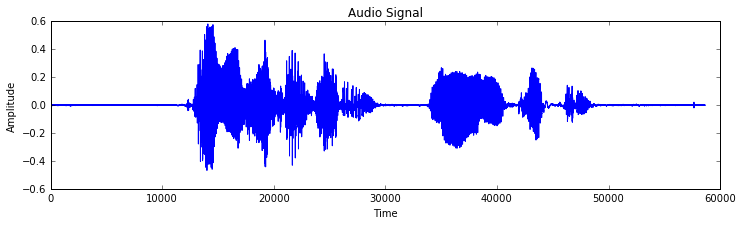

**Shape of Audio Signal** : (58653,)

**Transcript** : illustration long pepper

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [5]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

Using TensorFlow backend.


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [8]:
model_0 = simple_rnn_model(input_dim=161)  # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

In your neural architectures, if you notice that your gradient has exploded, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.

In [10]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20


  1/106 [..............................] - ETA: 158s - loss: 1498.6321

  2/106 [..............................] - ETA: 114s - loss: 1422.4428

  3/106 [..............................] - ETA: 98s - loss: 1387.2030 

  4/106 [>.............................] - ETA: 90s - loss: 1366.1428

  5/106 [>.............................] - ETA: 84s - loss: 1349.4306

  6/106 [>.............................] - ETA: 79s - loss: 1325.9660

  7/106 [>.............................] - ETA: 76s - loss: 1310.9417

  8/106 [=>............................] - ETA: 74s - loss: 1298.5239

  9/106 [=>............................] - ETA: 72s - loss: 1277.2847

 10/106 [=>............................] - ETA: 70s - loss: 1255.4992

 11/106 [==>...........................] - ETA: 68s - loss: 1234.5138

 12/106 [==>...........................] - ETA: 67s - loss: 1206.5638

 13/106 [==>...........................] - ETA: 67s - loss: 1240.9566

 14/106 [==>...........................] - ETA: 66s - loss: 1247.2093

 15/106 [===>..........................] - ETA: 64s - loss: 1223.7576

 16/106 [===>..........................] - ETA: 63s - loss: 1195.0066

 17/106 [===>..........................] - ETA: 62s - loss: 1179.6283

 18/106 [====>.........................] - ETA: 61s - loss: 1162.9483

 19/106 [====>.........................] - ETA: 60s - loss: 1142.5690

 20/106 [====>.........................] - ETA: 59s - loss: 1126.2328

 21/106 [====>.........................] - ETA: 58s - loss: 1112.5626

 22/106 [=====>........................] - ETA: 57s - loss: 1100.6491

 23/106 [=====>........................] - ETA: 57s - loss: 1084.4107

 24/106 [=====>........................] - ETA: 56s - loss: 1076.3976

 25/106 [======>.......................] - ETA: 55s - loss: 1060.3226

 26/106 [======>.......................] - ETA: 54s - loss: 1050.6059

 27/106 [======>.......................] - ETA: 54s - loss: 1042.1278

 28/106 [======>.......................] - ETA: 53s - loss: 1027.5485

 29/106 [=======>......................] - ETA: 52s - loss: 1025.7583

 30/106 [=======>......................] - ETA: 51s - loss: 1022.0472

 31/106 [=======>......................] - ETA: 50s - loss: 1014.2419

 32/106 [========>.....................] - ETA: 49s - loss: 1001.2037

 33/106 [========>.....................] - ETA: 48s - loss: 993.4812 

 34/106 [========>.....................] - ETA: 47s - loss: 984.6758

 35/106 [========>.....................] - ETA: 46s - loss: 974.7207

 36/106 [=========>....................] - ETA: 46s - loss: 970.6608

 37/106 [=========>....................] - ETA: 45s - loss: 971.4504

 38/106 [=========>....................] - ETA: 44s - loss: 969.9541

 39/106 [==========>...................] - ETA: 44s - loss: 963.9550

 40/106 [==========>...................] - ETA: 43s - loss: 956.9540

 41/106 [==========>...................] - ETA: 42s - loss: 950.2546

 42/106 [==========>...................] - ETA: 41s - loss: 943.0767

 43/106 [===========>..................] - ETA: 40s - loss: 933.5424

 44/106 [===========>..................] - ETA: 39s - loss: 926.4478

 45/106 [===========>..................] - ETA: 39s - loss: 918.4479

 46/106 [============>.................] - ETA: 38s - loss: 911.8181

 47/106 [============>.................] - ETA: 37s - loss: 908.5280

 48/106 [============>.................] - ETA: 36s - loss: 901.5802

 49/106 [============>.................] - ETA: 36s - loss: 897.6942

 50/106 [=============>................] - ETA: 35s - loss: 891.4723

 51/106 [=============>................] - ETA: 34s - loss: 892.5333

 52/106 [=============>................] - ETA: 34s - loss: 892.3420

 53/106 [==============>...............] - ETA: 33s - loss: 891.5820

 54/106 [==============>...............] - ETA: 32s - loss: 889.0725

 55/106 [==============>...............] - ETA: 32s - loss: 887.0624

 56/106 [==============>...............] - ETA: 31s - loss: 886.5309

 57/106 [===============>..............] - ETA: 30s - loss: 886.7073

 58/106 [===============>..............] - ETA: 30s - loss: 885.2192

 59/106 [===============>..............] - ETA: 29s - loss: 882.8976

 60/106 [===============>..............] - ETA: 28s - loss: 881.5008

 61/106 [================>.............] - ETA: 28s - loss: 877.0549

 62/106 [================>.............] - ETA: 27s - loss: 874.3008

 63/106 [================>.............] - ETA: 26s - loss: 873.6058

 64/106 [=================>............] - ETA: 26s - loss: 871.2734

 65/106 [=================>............] - ETA: 25s - loss: 871.8623

 66/106 [=================>............] - ETA: 24s - loss: 869.0413

 67/106 [=================>............] - ETA: 24s - loss: 867.1040

 68/106 [==================>...........] - ETA: 23s - loss: 865.0415

 69/106 [==================>...........] - ETA: 23s - loss: 864.6704

 70/106 [==================>...........] - ETA: 22s - loss: 865.0613

 71/106 [===================>..........] - ETA: 21s - loss: 861.9460

 72/106 [===================>..........] - ETA: 21s - loss: 859.1180

 73/106 [===================>..........] - ETA: 20s - loss: 855.5762

 74/106 [===================>..........] - ETA: 19s - loss: 852.6170

 75/106 [====================>.........] - ETA: 19s - loss: 851.9434

 76/106 [====================>.........] - ETA: 18s - loss: 852.7907

 77/106 [====================>.........] - ETA: 18s - loss: 853.1146

 78/106 [=====================>........] - ETA: 17s - loss: 850.9828

 79/106 [=====================>........] - ETA: 16s - loss: 849.9120

 80/106 [=====================>........] - ETA: 16s - loss: 848.6585

 81/106 [=====================>........] - ETA: 16s - loss: 848.4700

 82/106 [======================>.......] - ETA: 15s - loss: 845.7537

 83/106 [======================>.......] - ETA: 15s - loss: 847.9652

 84/106 [======================>.......] - ETA: 14s - loss: 846.9759

 85/106 [=======================>......] - ETA: 13s - loss: 846.1275

 86/106 [=======================>......] - ETA: 13s - loss: 846.0279

 87/106 [=======================>......] - ETA: 12s - loss: 845.1938

 88/106 [=======================>......] - ETA: 12s - loss: 845.6605

 89/106 [========================>.....] - ETA: 11s - loss: 845.5021

 90/106 [========================>.....] - ETA: 10s - loss: 846.3541

 91/106 [========================>.....] - ETA: 10s - loss: 845.3317

 92/106 [=========================>....] - ETA: 9s - loss: 843.8629 

 93/106 [=========================>....] - ETA: 8s - loss: 841.6822

 94/106 [=========================>....] - ETA: 8s - loss: 839.7363

 95/106 [=========================>....] - ETA: 7s - loss: 837.8886

 96/106 [==========================>...] - ETA: 6s - loss: 838.4994

 97/106 [==========================>...] - ETA: 6s - loss: 837.1702

 98/106 [==========================>...] - ETA: 5s - loss: 834.7205

 99/106 [===========================>..] - ETA: 4s - loss: 832.0585

100/106 [===========================>..] - ETA: 4s - loss: 831.8772

101/106 [===========================>..] - ETA: 3s - loss: 831.0928

102/106 [===========================>..] - ETA: 2s - loss: 829.0766

103/106 [============================>.] - ETA: 2s - loss: 828.3335

104/106 [============================>.] - ETA: 1s - loss: 828.4051

105/106 [============================>.] - ETA: 0s - loss: 828.8512

106/106 [==============================] - 97s - loss: 828.2968 - val_loss: 728.6126


Epoch 2/20


  1/106 [..............................] - ETA: 71s - loss: 831.0013

  2/106 [..............................] - ETA: 72s - loss: 812.3099

  3/106 [..............................] - ETA: 70s - loss: 807.3163

  4/106 [>.............................] - ETA: 67s - loss: 764.2092

  5/106 [>.............................] - ETA: 64s - loss: 751.0121

  6/106 [>.............................] - ETA: 63s - loss: 751.0625

  7/106 [>.............................] - ETA: 62s - loss: 745.3598

  8/106 [=>............................] - ETA: 61s - loss: 743.5744

  9/106 [=>............................] - ETA: 61s - loss: 743.0349

 10/106 [=>............................] - ETA: 60s - loss: 746.5937

 11/106 [==>...........................] - ETA: 63s - loss: 744.8041

 12/106 [==>...........................] - ETA: 64s - loss: 742.2236

 13/106 [==>...........................] - ETA: 64s - loss: 739.7780

 14/106 [==>...........................] - ETA: 63s - loss: 738.6364

 15/106 [===>..........................] - ETA: 62s - loss: 741.4258

 16/106 [===>..........................] - ETA: 61s - loss: 736.0582

 17/106 [===>..........................] - ETA: 60s - loss: 730.5258

 18/106 [====>.........................] - ETA: 59s - loss: 729.7066

 19/106 [====>.........................] - ETA: 58s - loss: 732.7883

 20/106 [====>.........................] - ETA: 58s - loss: 735.7674

 21/106 [====>.........................] - ETA: 57s - loss: 741.5680

 22/106 [=====>........................] - ETA: 56s - loss: 738.3712

 23/106 [=====>........................] - ETA: 55s - loss: 737.2979

 24/106 [=====>........................] - ETA: 54s - loss: 738.6596

 25/106 [======>.......................] - ETA: 54s - loss: 743.3930

 26/106 [======>.......................] - ETA: 53s - loss: 743.7308

 27/106 [======>.......................] - ETA: 52s - loss: 743.1198

 28/106 [======>.......................] - ETA: 51s - loss: 744.1900

 29/106 [=======>......................] - ETA: 51s - loss: 747.4576

 30/106 [=======>......................] - ETA: 50s - loss: 751.3322

 31/106 [=======>......................] - ETA: 50s - loss: 752.5633

 32/106 [========>.....................] - ETA: 49s - loss: 754.7449

 33/106 [========>.....................] - ETA: 48s - loss: 754.1124

 34/106 [========>.....................] - ETA: 48s - loss: 754.6870

 35/106 [========>.....................] - ETA: 47s - loss: 755.7391

 36/106 [=========>....................] - ETA: 46s - loss: 753.8036

 37/106 [=========>....................] - ETA: 45s - loss: 753.0362

 38/106 [=========>....................] - ETA: 44s - loss: 751.4082

 39/106 [==========>...................] - ETA: 44s - loss: 755.6717

 40/106 [==========>...................] - ETA: 43s - loss: 753.2087

 41/106 [==========>...................] - ETA: 42s - loss: 752.2494

 42/106 [==========>...................] - ETA: 42s - loss: 750.6941

 43/106 [===========>..................] - ETA: 41s - loss: 750.2592

 44/106 [===========>..................] - ETA: 40s - loss: 749.9890

 45/106 [===========>..................] - ETA: 39s - loss: 748.5268

 46/106 [============>.................] - ETA: 38s - loss: 748.0963

 47/106 [============>.................] - ETA: 38s - loss: 748.2942

 48/106 [============>.................] - ETA: 37s - loss: 751.8205

 49/106 [============>.................] - ETA: 36s - loss: 752.6990

 50/106 [=============>................] - ETA: 36s - loss: 752.3263

 51/106 [=============>................] - ETA: 35s - loss: 751.7432

 52/106 [=============>................] - ETA: 34s - loss: 750.0867

 53/106 [==============>...............] - ETA: 34s - loss: 747.9883

 54/106 [==============>...............] - ETA: 33s - loss: 747.4063

 55/106 [==============>...............] - ETA: 32s - loss: 747.4356

 56/106 [==============>...............] - ETA: 31s - loss: 748.1997

 57/106 [===============>..............] - ETA: 31s - loss: 750.5147

 58/106 [===============>..............] - ETA: 30s - loss: 752.1000

 59/106 [===============>..............] - ETA: 30s - loss: 751.1822

 60/106 [===============>..............] - ETA: 29s - loss: 750.3858

 61/106 [================>.............] - ETA: 28s - loss: 750.2473

 62/106 [================>.............] - ETA: 28s - loss: 750.8784

 63/106 [================>.............] - ETA: 27s - loss: 750.6382

 64/106 [=================>............] - ETA: 26s - loss: 750.0758

 65/106 [=================>............] - ETA: 26s - loss: 750.0018

 66/106 [=================>............] - ETA: 25s - loss: 751.6180

 67/106 [=================>............] - ETA: 24s - loss: 751.2207

 68/106 [==================>...........] - ETA: 24s - loss: 749.4999

 69/106 [==================>...........] - ETA: 23s - loss: 748.3401

 70/106 [==================>...........] - ETA: 22s - loss: 749.6214

 71/106 [===================>..........] - ETA: 22s - loss: 750.7076

 72/106 [===================>..........] - ETA: 21s - loss: 750.8225

 73/106 [===================>..........] - ETA: 20s - loss: 751.3106

 74/106 [===================>..........] - ETA: 20s - loss: 751.7199

 75/106 [====================>.........] - ETA: 19s - loss: 753.3517

 76/106 [====================>.........] - ETA: 18s - loss: 753.8488

 77/106 [====================>.........] - ETA: 18s - loss: 753.6393

 78/106 [=====================>........] - ETA: 17s - loss: 753.0892

 79/106 [=====================>........] - ETA: 17s - loss: 753.0771

 80/106 [=====================>........] - ETA: 16s - loss: 753.0273

 81/106 [=====================>........] - ETA: 15s - loss: 754.4867

 82/106 [======================>.......] - ETA: 15s - loss: 754.7773

 83/106 [======================>.......] - ETA: 14s - loss: 754.8141

 84/106 [======================>.......] - ETA: 13s - loss: 754.2721

 85/106 [=======================>......] - ETA: 13s - loss: 754.3642

 86/106 [=======================>......] - ETA: 12s - loss: 754.7139

 87/106 [=======================>......] - ETA: 11s - loss: 755.5028

 88/106 [=======================>......] - ETA: 11s - loss: 755.3096

 89/106 [========================>.....] - ETA: 10s - loss: 756.2689

 90/106 [========================>.....] - ETA: 10s - loss: 756.6356

 91/106 [========================>.....] - ETA: 9s - loss: 756.4984 

 92/106 [=========================>....] - ETA: 8s - loss: 755.9959

 93/106 [=========================>....] - ETA: 8s - loss: 755.9900

 94/106 [=========================>....] - ETA: 7s - loss: 756.7190

 95/106 [=========================>....] - ETA: 6s - loss: 756.6807

 96/106 [==========================>...] - ETA: 6s - loss: 755.9919

 97/106 [==========================>...] - ETA: 5s - loss: 754.9472

 98/106 [==========================>...] - ETA: 5s - loss: 755.6029

 99/106 [===========================>..] - ETA: 4s - loss: 755.5412

100/106 [===========================>..] - ETA: 3s - loss: 754.9276

101/106 [===========================>..] - ETA: 3s - loss: 755.1192

102/106 [===========================>..] - ETA: 2s - loss: 754.3445

103/106 [============================>.] - ETA: 1s - loss: 754.5909

104/106 [============================>.] - ETA: 1s - loss: 755.4912

105/106 [============================>.] - ETA: 0s - loss: 753.5838

106/106 [==============================] - 84s - loss: 754.7011 - val_loss: 729.5666


Epoch 3/20


  1/106 [..............................] - ETA: 56s - loss: 716.7685

  2/106 [..............................] - ETA: 52s - loss: 697.9624

  3/106 [..............................] - ETA: 54s - loss: 741.3691

  4/106 [>.............................] - ETA: 53s - loss: 737.8239

  5/106 [>.............................] - ETA: 53s - loss: 750.3060

  6/106 [>.............................] - ETA: 52s - loss: 747.1743

  7/106 [>.............................] - ETA: 52s - loss: 753.1396

  8/106 [=>............................] - ETA: 51s - loss: 739.2109

  9/106 [=>............................] - ETA: 51s - loss: 741.1889

 10/106 [=>............................] - ETA: 51s - loss: 748.3832

 11/106 [==>...........................] - ETA: 51s - loss: 750.4082

 12/106 [==>...........................] - ETA: 51s - loss: 750.1737

 13/106 [==>...........................] - ETA: 50s - loss: 747.6098

 14/106 [==>...........................] - ETA: 50s - loss: 744.0190

 15/106 [===>..........................] - ETA: 50s - loss: 747.1247

 16/106 [===>..........................] - ETA: 49s - loss: 742.3561

 17/106 [===>..........................] - ETA: 48s - loss: 739.1468

 18/106 [====>.........................] - ETA: 48s - loss: 740.7777

 19/106 [====>.........................] - ETA: 48s - loss: 741.7914

 20/106 [====>.........................] - ETA: 47s - loss: 750.5710

 21/106 [====>.........................] - ETA: 46s - loss: 748.4706

 22/106 [=====>........................] - ETA: 46s - loss: 745.9048

 23/106 [=====>........................] - ETA: 45s - loss: 741.8081

 24/106 [=====>........................] - ETA: 45s - loss: 737.1153

 25/106 [======>.......................] - ETA: 44s - loss: 737.1704

 26/106 [======>.......................] - ETA: 44s - loss: 735.7415

 27/106 [======>.......................] - ETA: 43s - loss: 734.8796

 28/106 [======>.......................] - ETA: 43s - loss: 732.3727

 29/106 [=======>......................] - ETA: 42s - loss: 735.7388

 30/106 [=======>......................] - ETA: 42s - loss: 735.3688

 31/106 [=======>......................] - ETA: 41s - loss: 736.7785

 32/106 [========>.....................] - ETA: 41s - loss: 737.7888

 33/106 [========>.....................] - ETA: 40s - loss: 736.0726

 34/106 [========>.....................] - ETA: 40s - loss: 739.4476

 35/106 [========>.....................] - ETA: 39s - loss: 738.3148

 36/106 [=========>....................] - ETA: 38s - loss: 735.1431

 37/106 [=========>....................] - ETA: 38s - loss: 736.3115

 38/106 [=========>....................] - ETA: 37s - loss: 735.9857

 39/106 [==========>...................] - ETA: 37s - loss: 740.0624

 40/106 [==========>...................] - ETA: 36s - loss: 742.6251

 41/106 [==========>...................] - ETA: 36s - loss: 743.3229

 42/106 [==========>...................] - ETA: 35s - loss: 745.2377

 43/106 [===========>..................] - ETA: 35s - loss: 745.2823

 44/106 [===========>..................] - ETA: 34s - loss: 746.4139

 45/106 [===========>..................] - ETA: 34s - loss: 746.0856

 46/106 [============>.................] - ETA: 33s - loss: 747.2943

 47/106 [============>.................] - ETA: 33s - loss: 748.3032

 48/106 [============>.................] - ETA: 32s - loss: 749.7390

 49/106 [============>.................] - ETA: 32s - loss: 751.7338

 50/106 [=============>................] - ETA: 31s - loss: 751.1098

 51/106 [=============>................] - ETA: 30s - loss: 750.3691

 52/106 [=============>................] - ETA: 30s - loss: 749.6356

 53/106 [==============>...............] - ETA: 29s - loss: 749.7031

 54/106 [==============>...............] - ETA: 29s - loss: 750.3896

 55/106 [==============>...............] - ETA: 28s - loss: 749.9650

 56/106 [==============>...............] - ETA: 27s - loss: 750.3246

 57/106 [===============>..............] - ETA: 27s - loss: 752.1749

 58/106 [===============>..............] - ETA: 26s - loss: 752.2725

 59/106 [===============>..............] - ETA: 26s - loss: 751.1126

 60/106 [===============>..............] - ETA: 25s - loss: 750.2441

 61/106 [================>.............] - ETA: 25s - loss: 749.7403

 62/106 [================>.............] - ETA: 24s - loss: 747.9558

 63/106 [================>.............] - ETA: 23s - loss: 748.3912

 64/106 [=================>............] - ETA: 23s - loss: 749.2464

 65/106 [=================>............] - ETA: 22s - loss: 749.0889

 66/106 [=================>............] - ETA: 22s - loss: 750.3087

 67/106 [=================>............] - ETA: 21s - loss: 749.6714

 68/106 [==================>...........] - ETA: 21s - loss: 751.0473

 69/106 [==================>...........] - ETA: 20s - loss: 750.0977

 70/106 [==================>...........] - ETA: 19s - loss: 748.6052

 71/106 [===================>..........] - ETA: 19s - loss: 749.6768

 72/106 [===================>..........] - ETA: 18s - loss: 750.5002

 73/106 [===================>..........] - ETA: 18s - loss: 751.6674

 74/106 [===================>..........] - ETA: 17s - loss: 751.3946

 75/106 [====================>.........] - ETA: 17s - loss: 751.7252

 76/106 [====================>.........] - ETA: 16s - loss: 750.7305

 77/106 [====================>.........] - ETA: 16s - loss: 750.3810

 78/106 [=====================>........] - ETA: 15s - loss: 751.7040

 79/106 [=====================>........] - ETA: 15s - loss: 752.1429

 80/106 [=====================>........] - ETA: 14s - loss: 752.4364

 81/106 [=====================>........] - ETA: 14s - loss: 753.0794

 82/106 [======================>.......] - ETA: 13s - loss: 753.9440

 83/106 [======================>.......] - ETA: 12s - loss: 753.8726

 84/106 [======================>.......] - ETA: 12s - loss: 755.4653

 85/106 [=======================>......] - ETA: 11s - loss: 756.3384

 86/106 [=======================>......] - ETA: 11s - loss: 756.4069

 87/106 [=======================>......] - ETA: 10s - loss: 755.6950

 88/106 [=======================>......] - ETA: 10s - loss: 755.5886

 89/106 [========================>.....] - ETA: 9s - loss: 755.4518 

 90/106 [========================>.....] - ETA: 9s - loss: 755.6005

 91/106 [========================>.....] - ETA: 8s - loss: 755.8866

 92/106 [=========================>....] - ETA: 8s - loss: 756.1567

 93/106 [=========================>....] - ETA: 7s - loss: 756.4825

 94/106 [=========================>....] - ETA: 6s - loss: 756.1384

 95/106 [=========================>....] - ETA: 6s - loss: 757.2618

 96/106 [==========================>...] - ETA: 5s - loss: 756.9364

 97/106 [==========================>...] - ETA: 5s - loss: 756.5866

 98/106 [==========================>...] - ETA: 4s - loss: 756.2621

 99/106 [===========================>..] - ETA: 4s - loss: 756.3141

100/106 [===========================>..] - ETA: 3s - loss: 755.4434

101/106 [===========================>..] - ETA: 2s - loss: 754.8049

102/106 [===========================>..] - ETA: 2s - loss: 754.5083

103/106 [============================>.] - ETA: 1s - loss: 753.4103

104/106 [============================>.] - ETA: 1s - loss: 753.9858

105/106 [============================>.] - ETA: 0s - loss: 753.7577

106/106 [==============================] - 81s - loss: 752.8400 - val_loss: 726.8236


Epoch 4/20


  1/106 [..............................] - ETA: 61s - loss: 719.1705

  2/106 [..............................] - ETA: 57s - loss: 703.9196

  3/106 [..............................] - ETA: 53s - loss: 641.3024

  4/106 [>.............................] - ETA: 51s - loss: 650.4503

  5/106 [>.............................] - ETA: 52s - loss: 661.4602

  6/106 [>.............................] - ETA: 52s - loss: 683.5655

  7/106 [>.............................] - ETA: 52s - loss: 693.3461

  8/106 [=>............................] - ETA: 52s - loss: 712.6815

  9/106 [=>............................] - ETA: 51s - loss: 714.0534

 10/106 [=>............................] - ETA: 51s - loss: 711.8398

 11/106 [==>...........................] - ETA: 50s - loss: 712.5817

 12/106 [==>...........................] - ETA: 50s - loss: 727.1258

 13/106 [==>...........................] - ETA: 50s - loss: 733.2091

 14/106 [==>...........................] - ETA: 50s - loss: 731.6488

 15/106 [===>..........................] - ETA: 50s - loss: 731.2467

 16/106 [===>..........................] - ETA: 49s - loss: 736.6996

 17/106 [===>..........................] - ETA: 48s - loss: 736.7856

 18/106 [====>.........................] - ETA: 48s - loss: 739.8227

 19/106 [====>.........................] - ETA: 48s - loss: 741.7790

 20/106 [====>.........................] - ETA: 47s - loss: 742.7912

 21/106 [====>.........................] - ETA: 46s - loss: 741.4316

 22/106 [=====>........................] - ETA: 46s - loss: 744.0541

 23/106 [=====>........................] - ETA: 45s - loss: 744.7667

 24/106 [=====>........................] - ETA: 45s - loss: 746.1743

 25/106 [======>.......................] - ETA: 44s - loss: 749.8636

 26/106 [======>.......................] - ETA: 44s - loss: 751.7676

 27/106 [======>.......................] - ETA: 43s - loss: 756.8794

 28/106 [======>.......................] - ETA: 43s - loss: 759.6336

 29/106 [=======>......................] - ETA: 42s - loss: 759.5673

 30/106 [=======>......................] - ETA: 42s - loss: 757.2206

 31/106 [=======>......................] - ETA: 41s - loss: 765.0410

 32/106 [========>.....................] - ETA: 41s - loss: 765.9794

 33/106 [========>.....................] - ETA: 40s - loss: 766.0800

 34/106 [========>.....................] - ETA: 40s - loss: 764.9602

 35/106 [========>.....................] - ETA: 39s - loss: 761.3516

 36/106 [=========>....................] - ETA: 38s - loss: 760.5675

 37/106 [=========>....................] - ETA: 38s - loss: 761.3758

 38/106 [=========>....................] - ETA: 37s - loss: 760.4429

 39/106 [==========>...................] - ETA: 37s - loss: 759.0370

 40/106 [==========>...................] - ETA: 36s - loss: 758.3262

 41/106 [==========>...................] - ETA: 36s - loss: 758.3624

 42/106 [==========>...................] - ETA: 35s - loss: 755.0453

 43/106 [===========>..................] - ETA: 35s - loss: 757.8712

 44/106 [===========>..................] - ETA: 34s - loss: 757.7484

 45/106 [===========>..................] - ETA: 34s - loss: 757.5919

 46/106 [============>.................] - ETA: 33s - loss: 752.4700

 47/106 [============>.................] - ETA: 32s - loss: 752.3963

 48/106 [============>.................] - ETA: 32s - loss: 751.8921

 49/106 [============>.................] - ETA: 31s - loss: 750.8843

 50/106 [=============>................] - ETA: 30s - loss: 751.0303

 51/106 [=============>................] - ETA: 30s - loss: 753.1911

 52/106 [=============>................] - ETA: 29s - loss: 753.9846

 53/106 [==============>...............] - ETA: 29s - loss: 753.9306

 54/106 [==============>...............] - ETA: 28s - loss: 752.0537

 55/106 [==============>...............] - ETA: 28s - loss: 753.2305

 56/106 [==============>...............] - ETA: 27s - loss: 752.9486

 57/106 [===============>..............] - ETA: 27s - loss: 753.0624

 58/106 [===============>..............] - ETA: 26s - loss: 752.0446

 59/106 [===============>..............] - ETA: 25s - loss: 752.0827

 60/106 [===============>..............] - ETA: 25s - loss: 751.3250

 61/106 [================>.............] - ETA: 25s - loss: 752.6894

 62/106 [================>.............] - ETA: 24s - loss: 752.7632

 63/106 [================>.............] - ETA: 24s - loss: 755.0878

 64/106 [=================>............] - ETA: 23s - loss: 753.0544

 65/106 [=================>............] - ETA: 22s - loss: 751.9828

 66/106 [=================>............] - ETA: 22s - loss: 749.5287

 67/106 [=================>............] - ETA: 21s - loss: 749.9304

 68/106 [==================>...........] - ETA: 21s - loss: 749.8365

 69/106 [==================>...........] - ETA: 20s - loss: 751.7566

 70/106 [==================>...........] - ETA: 20s - loss: 751.6092

 71/106 [===================>..........] - ETA: 19s - loss: 751.9990

 72/106 [===================>..........] - ETA: 19s - loss: 750.5128

 73/106 [===================>..........] - ETA: 18s - loss: 749.0585

 74/106 [===================>..........] - ETA: 17s - loss: 748.5287

 75/106 [====================>.........] - ETA: 17s - loss: 748.9199

 76/106 [====================>.........] - ETA: 16s - loss: 749.7731

 77/106 [====================>.........] - ETA: 16s - loss: 750.4008

 78/106 [=====================>........] - ETA: 15s - loss: 750.3631

 79/106 [=====================>........] - ETA: 15s - loss: 751.0855

 80/106 [=====================>........] - ETA: 14s - loss: 751.9686

 81/106 [=====================>........] - ETA: 14s - loss: 753.3944

 82/106 [======================>.......] - ETA: 13s - loss: 753.0816

 83/106 [======================>.......] - ETA: 12s - loss: 753.1339

 84/106 [======================>.......] - ETA: 12s - loss: 753.0729

 85/106 [=======================>......] - ETA: 11s - loss: 753.7860

 86/106 [=======================>......] - ETA: 11s - loss: 753.1721

 87/106 [=======================>......] - ETA: 10s - loss: 754.7643

 88/106 [=======================>......] - ETA: 10s - loss: 755.0626

 89/106 [========================>.....] - ETA: 9s - loss: 754.6942 

 90/106 [========================>.....] - ETA: 8s - loss: 755.4322

 91/106 [========================>.....] - ETA: 8s - loss: 756.6357

 92/106 [=========================>....] - ETA: 7s - loss: 755.5544

 93/106 [=========================>....] - ETA: 7s - loss: 755.0367

 94/106 [=========================>....] - ETA: 6s - loss: 754.8415

 95/106 [=========================>....] - ETA: 6s - loss: 755.1030

 96/106 [==========================>...] - ETA: 5s - loss: 754.6881

 97/106 [==========================>...] - ETA: 5s - loss: 754.4670

 98/106 [==========================>...] - ETA: 4s - loss: 754.6428

 99/106 [===========================>..] - ETA: 3s - loss: 754.4778

100/106 [===========================>..] - ETA: 3s - loss: 754.5853

101/106 [===========================>..] - ETA: 2s - loss: 753.7232

102/106 [===========================>..] - ETA: 2s - loss: 753.5667

103/106 [============================>.] - ETA: 1s - loss: 752.7744

104/106 [============================>.] - ETA: 1s - loss: 752.7347

105/106 [============================>.] - ETA: 0s - loss: 752.1924

106/106 [==============================] - 78s - loss: 751.9478 - val_loss: 725.5150


Epoch 5/20


  1/106 [..............................] - ETA: 75s - loss: 749.7014

  2/106 [..............................] - ETA: 71s - loss: 812.2957

  3/106 [..............................] - ETA: 67s - loss: 811.2337

  4/106 [>.............................] - ETA: 65s - loss: 804.0853

  5/106 [>.............................] - ETA: 63s - loss: 782.3383

  6/106 [>.............................] - ETA: 60s - loss: 776.1961

  7/106 [>.............................] - ETA: 59s - loss: 782.2440

  8/106 [=>............................] - ETA: 58s - loss: 783.5594

  9/106 [=>............................] - ETA: 58s - loss: 776.5030

 10/106 [=>............................] - ETA: 58s - loss: 762.9696

 11/106 [==>...........................] - ETA: 57s - loss: 755.2839

 12/106 [==>...........................] - ETA: 56s - loss: 762.4198

 13/106 [==>...........................] - ETA: 56s - loss: 767.3662

 14/106 [==>...........................] - ETA: 55s - loss: 765.8297

 15/106 [===>..........................] - ETA: 54s - loss: 763.9299

 16/106 [===>..........................] - ETA: 53s - loss: 756.9736

 17/106 [===>..........................] - ETA: 52s - loss: 754.9180

 18/106 [====>.........................] - ETA: 52s - loss: 754.3608

 19/106 [====>.........................] - ETA: 51s - loss: 754.7927

 20/106 [====>.........................] - ETA: 50s - loss: 760.4113

 21/106 [====>.........................] - ETA: 50s - loss: 759.7416

 22/106 [=====>........................] - ETA: 49s - loss: 760.0465

 23/106 [=====>........................] - ETA: 48s - loss: 761.4784

 24/106 [=====>........................] - ETA: 48s - loss: 766.4390

 25/106 [======>.......................] - ETA: 47s - loss: 766.0960

 26/106 [======>.......................] - ETA: 46s - loss: 764.9548

 27/106 [======>.......................] - ETA: 46s - loss: 767.4155

 28/106 [======>.......................] - ETA: 45s - loss: 765.3123

 29/106 [=======>......................] - ETA: 44s - loss: 761.6711

 30/106 [=======>......................] - ETA: 44s - loss: 764.4998

 31/106 [=======>......................] - ETA: 43s - loss: 765.1704

 32/106 [========>.....................] - ETA: 43s - loss: 767.1824

 33/106 [========>.....................] - ETA: 42s - loss: 768.5618

 34/106 [========>.....................] - ETA: 42s - loss: 768.9336

 35/106 [========>.....................] - ETA: 41s - loss: 771.3433

 36/106 [=========>....................] - ETA: 41s - loss: 771.0264

 37/106 [=========>....................] - ETA: 40s - loss: 766.8318

 38/106 [=========>....................] - ETA: 40s - loss: 769.4476

 39/106 [==========>...................] - ETA: 39s - loss: 767.5064

 40/106 [==========>...................] - ETA: 39s - loss: 768.4129

 41/106 [==========>...................] - ETA: 38s - loss: 767.7053

 42/106 [==========>...................] - ETA: 38s - loss: 766.5033

 43/106 [===========>..................] - ETA: 37s - loss: 767.2290

 44/106 [===========>..................] - ETA: 36s - loss: 766.1669

 45/106 [===========>..................] - ETA: 36s - loss: 765.3763

 46/106 [============>.................] - ETA: 35s - loss: 760.8270

 47/106 [============>.................] - ETA: 34s - loss: 760.5930

 48/106 [============>.................] - ETA: 34s - loss: 761.1963

 49/106 [============>.................] - ETA: 33s - loss: 760.0387

 50/106 [=============>................] - ETA: 32s - loss: 761.9086

 51/106 [=============>................] - ETA: 32s - loss: 764.1463

 52/106 [=============>................] - ETA: 31s - loss: 762.0668

 53/106 [==============>...............] - ETA: 31s - loss: 765.6075

 54/106 [==============>...............] - ETA: 30s - loss: 765.1645

 55/106 [==============>...............] - ETA: 30s - loss: 765.0193

 56/106 [==============>...............] - ETA: 29s - loss: 762.1325

 57/106 [===============>..............] - ETA: 28s - loss: 762.2800

 58/106 [===============>..............] - ETA: 28s - loss: 762.6447

 59/106 [===============>..............] - ETA: 27s - loss: 762.9015

 60/106 [===============>..............] - ETA: 26s - loss: 761.3838

 61/106 [================>.............] - ETA: 26s - loss: 762.5688

 62/106 [================>.............] - ETA: 25s - loss: 761.7082

 63/106 [================>.............] - ETA: 25s - loss: 760.8398

 64/106 [=================>............] - ETA: 24s - loss: 759.8601

 65/106 [=================>............] - ETA: 23s - loss: 759.5165

 66/106 [=================>............] - ETA: 23s - loss: 758.9436

 67/106 [=================>............] - ETA: 22s - loss: 758.2660

 68/106 [==================>...........] - ETA: 22s - loss: 758.0460

 69/106 [==================>...........] - ETA: 21s - loss: 754.9937

 70/106 [==================>...........] - ETA: 20s - loss: 754.0578

 71/106 [===================>..........] - ETA: 20s - loss: 754.4803

 72/106 [===================>..........] - ETA: 19s - loss: 753.3910

 73/106 [===================>..........] - ETA: 19s - loss: 751.6107

 74/106 [===================>..........] - ETA: 18s - loss: 751.5344

 75/106 [====================>.........] - ETA: 17s - loss: 750.5212

 76/106 [====================>.........] - ETA: 17s - loss: 750.2014

 77/106 [====================>.........] - ETA: 16s - loss: 749.4977

 78/106 [=====================>........] - ETA: 16s - loss: 748.7054

 79/106 [=====================>........] - ETA: 15s - loss: 747.9248

 80/106 [=====================>........] - ETA: 14s - loss: 748.8844

 81/106 [=====================>........] - ETA: 14s - loss: 748.5169

 82/106 [======================>.......] - ETA: 13s - loss: 750.0517

 83/106 [======================>.......] - ETA: 13s - loss: 750.1964

 84/106 [======================>.......] - ETA: 12s - loss: 751.7104

 85/106 [=======================>......] - ETA: 12s - loss: 750.6777

 86/106 [=======================>......] - ETA: 11s - loss: 750.6850

 87/106 [=======================>......] - ETA: 10s - loss: 750.0358

 88/106 [=======================>......] - ETA: 10s - loss: 750.5651

 89/106 [========================>.....] - ETA: 9s - loss: 750.9195 

 90/106 [========================>.....] - ETA: 9s - loss: 752.0829

 91/106 [========================>.....] - ETA: 8s - loss: 753.4055

 92/106 [=========================>....] - ETA: 8s - loss: 753.9866

 93/106 [=========================>....] - ETA: 7s - loss: 753.3580

 94/106 [=========================>....] - ETA: 6s - loss: 754.2543

 95/106 [=========================>....] - ETA: 6s - loss: 753.9037

 96/106 [==========================>...] - ETA: 5s - loss: 752.9353

 97/106 [==========================>...] - ETA: 5s - loss: 752.7336

 98/106 [==========================>...] - ETA: 4s - loss: 752.8703

 99/106 [===========================>..] - ETA: 4s - loss: 752.6023

100/106 [===========================>..] - ETA: 3s - loss: 752.8121

101/106 [===========================>..] - ETA: 2s - loss: 752.7191

102/106 [===========================>..] - ETA: 2s - loss: 752.2214

103/106 [============================>.] - ETA: 1s - loss: 751.8214

104/106 [============================>.] - ETA: 1s - loss: 750.4565

105/106 [============================>.] - ETA: 0s - loss: 750.7520

106/106 [==============================] - 78s - loss: 751.4254 - val_loss: 729.3668


Epoch 6/20


  1/106 [..............................] - ETA: 65s - loss: 708.8129

  2/106 [..............................] - ETA: 61s - loss: 838.0262

  3/106 [..............................] - ETA: 59s - loss: 761.2043

  4/106 [>.............................] - ETA: 59s - loss: 798.4256

  5/106 [>.............................] - ETA: 58s - loss: 799.8443

  6/106 [>.............................] - ETA: 58s - loss: 800.3449

  7/106 [>.............................] - ETA: 57s - loss: 805.6695

  8/106 [=>............................] - ETA: 56s - loss: 798.7450

  9/106 [=>............................] - ETA: 55s - loss: 795.6895

 10/106 [=>............................] - ETA: 54s - loss: 796.0025

 11/106 [==>...........................] - ETA: 53s - loss: 792.8512

 12/106 [==>...........................] - ETA: 53s - loss: 794.5235

 13/106 [==>...........................] - ETA: 52s - loss: 786.4642

 14/106 [==>...........................] - ETA: 52s - loss: 780.0888

 15/106 [===>..........................] - ETA: 51s - loss: 786.4888

 16/106 [===>..........................] - ETA: 51s - loss: 784.5885

 17/106 [===>..........................] - ETA: 50s - loss: 783.1401

 18/106 [====>.........................] - ETA: 49s - loss: 780.1635

 19/106 [====>.........................] - ETA: 48s - loss: 770.6062

 20/106 [====>.........................] - ETA: 48s - loss: 771.2961

 21/106 [====>.........................] - ETA: 47s - loss: 768.9034

 22/106 [=====>........................] - ETA: 47s - loss: 770.5137

 23/106 [=====>........................] - ETA: 46s - loss: 767.0694

 24/106 [=====>........................] - ETA: 45s - loss: 766.7336

 25/106 [======>.......................] - ETA: 45s - loss: 763.6316

 26/106 [======>.......................] - ETA: 44s - loss: 764.5865

 27/106 [======>.......................] - ETA: 44s - loss: 762.6348

 28/106 [======>.......................] - ETA: 43s - loss: 759.3792

 29/106 [=======>......................] - ETA: 43s - loss: 757.0605

 30/106 [=======>......................] - ETA: 42s - loss: 759.5668

 31/106 [=======>......................] - ETA: 41s - loss: 757.7234

 32/106 [========>.....................] - ETA: 41s - loss: 757.7031

 33/106 [========>.....................] - ETA: 40s - loss: 758.8435

 34/106 [========>.....................] - ETA: 40s - loss: 763.2028

 35/106 [========>.....................] - ETA: 39s - loss: 762.9994

 36/106 [=========>....................] - ETA: 39s - loss: 761.6389

 37/106 [=========>....................] - ETA: 38s - loss: 761.7865

 38/106 [=========>....................] - ETA: 37s - loss: 759.1222

 39/106 [==========>...................] - ETA: 37s - loss: 760.0126

 40/106 [==========>...................] - ETA: 36s - loss: 760.1342

 41/106 [==========>...................] - ETA: 36s - loss: 761.4345

 42/106 [==========>...................] - ETA: 35s - loss: 762.7472

 43/106 [===========>..................] - ETA: 34s - loss: 761.9723

 44/106 [===========>..................] - ETA: 34s - loss: 763.7820

 45/106 [===========>..................] - ETA: 33s - loss: 762.7504

 46/106 [============>.................] - ETA: 33s - loss: 761.5854

 47/106 [============>.................] - ETA: 32s - loss: 761.4809

 48/106 [============>.................] - ETA: 32s - loss: 760.2323

 49/106 [============>.................] - ETA: 31s - loss: 757.6067

 50/106 [=============>................] - ETA: 30s - loss: 758.2338

 51/106 [=============>................] - ETA: 30s - loss: 756.3702

 52/106 [=============>................] - ETA: 29s - loss: 755.7322

 53/106 [==============>...............] - ETA: 29s - loss: 756.8116

 54/106 [==============>...............] - ETA: 28s - loss: 756.7014

 55/106 [==============>...............] - ETA: 28s - loss: 756.3779

 56/106 [==============>...............] - ETA: 27s - loss: 755.1270

 57/106 [===============>..............] - ETA: 26s - loss: 753.7478

 58/106 [===============>..............] - ETA: 26s - loss: 752.9741

 59/106 [===============>..............] - ETA: 25s - loss: 751.1097

 60/106 [===============>..............] - ETA: 25s - loss: 750.7007

 61/106 [================>.............] - ETA: 24s - loss: 749.5014

 62/106 [================>.............] - ETA: 24s - loss: 749.5261

 63/106 [================>.............] - ETA: 23s - loss: 749.3495

 64/106 [=================>............] - ETA: 23s - loss: 750.0433

 65/106 [=================>............] - ETA: 22s - loss: 749.2588

 66/106 [=================>............] - ETA: 21s - loss: 749.5864

 67/106 [=================>............] - ETA: 21s - loss: 748.7187

 68/106 [==================>...........] - ETA: 20s - loss: 749.6731

 69/106 [==================>...........] - ETA: 20s - loss: 748.7808

 70/106 [==================>...........] - ETA: 19s - loss: 749.0838

 71/106 [===================>..........] - ETA: 19s - loss: 749.3229

 72/106 [===================>..........] - ETA: 18s - loss: 748.4368

 73/106 [===================>..........] - ETA: 18s - loss: 749.4891

 74/106 [===================>..........] - ETA: 17s - loss: 747.4745

 75/106 [====================>.........] - ETA: 16s - loss: 748.2206

 76/106 [====================>.........] - ETA: 16s - loss: 746.5592

 77/106 [====================>.........] - ETA: 15s - loss: 747.2849

 78/106 [=====================>........] - ETA: 15s - loss: 746.9174

 79/106 [=====================>........] - ETA: 14s - loss: 747.0607

 80/106 [=====================>........] - ETA: 14s - loss: 747.9853

 81/106 [=====================>........] - ETA: 13s - loss: 748.4990

 82/106 [======================>.......] - ETA: 13s - loss: 749.0749

 83/106 [======================>.......] - ETA: 12s - loss: 750.3492

 84/106 [======================>.......] - ETA: 12s - loss: 750.8509

 85/106 [=======================>......] - ETA: 11s - loss: 750.9011

 86/106 [=======================>......] - ETA: 10s - loss: 751.9008

 87/106 [=======================>......] - ETA: 10s - loss: 751.9344

 88/106 [=======================>......] - ETA: 9s - loss: 751.5033 

 89/106 [========================>.....] - ETA: 9s - loss: 752.7495

 90/106 [========================>.....] - ETA: 8s - loss: 750.7074

 91/106 [========================>.....] - ETA: 8s - loss: 749.3244

 92/106 [=========================>....] - ETA: 7s - loss: 749.5576

 93/106 [=========================>....] - ETA: 7s - loss: 749.4149

 94/106 [=========================>....] - ETA: 6s - loss: 749.8411

 95/106 [=========================>....] - ETA: 6s - loss: 749.2709

 96/106 [==========================>...] - ETA: 5s - loss: 748.1462

 97/106 [==========================>...] - ETA: 4s - loss: 746.9712

 98/106 [==========================>...] - ETA: 4s - loss: 747.4225

 99/106 [===========================>..] - ETA: 3s - loss: 748.7822

100/106 [===========================>..] - ETA: 3s - loss: 748.3663

101/106 [===========================>..] - ETA: 2s - loss: 748.6460

102/106 [===========================>..] - ETA: 2s - loss: 749.3649

103/106 [============================>.] - ETA: 1s - loss: 749.6256

104/106 [============================>.] - ETA: 1s - loss: 749.8839

105/106 [============================>.] - ETA: 0s - loss: 750.0271

106/106 [==============================] - 75s - loss: 750.4135 - val_loss: 719.3147


Epoch 7/20


  1/106 [..............................] - ETA: 63s - loss: 713.4563

  2/106 [..............................] - ETA: 59s - loss: 711.6758

  3/106 [..............................] - ETA: 57s - loss: 723.4098

  4/106 [>.............................] - ETA: 56s - loss: 716.9491

  5/106 [>.............................] - ETA: 55s - loss: 726.2983

  6/106 [>.............................] - ETA: 54s - loss: 700.2945

  7/106 [>.............................] - ETA: 54s - loss: 705.2835

  8/106 [=>............................] - ETA: 54s - loss: 710.7579

  9/106 [=>............................] - ETA: 53s - loss: 712.7390

 10/106 [=>............................] - ETA: 53s - loss: 726.4392

 11/106 [==>...........................] - ETA: 52s - loss: 731.7895

 12/106 [==>...........................] - ETA: 52s - loss: 731.2900

 13/106 [==>...........................] - ETA: 51s - loss: 734.6020

 14/106 [==>...........................] - ETA: 50s - loss: 726.0045

 15/106 [===>..........................] - ETA: 49s - loss: 731.1093

 16/106 [===>..........................] - ETA: 49s - loss: 739.8855

 17/106 [===>..........................] - ETA: 49s - loss: 749.0808

 18/106 [====>.........................] - ETA: 48s - loss: 748.6244

 19/106 [====>.........................] - ETA: 47s - loss: 745.5462

 20/106 [====>.........................] - ETA: 47s - loss: 746.4778

 21/106 [====>.........................] - ETA: 46s - loss: 746.9228

 22/106 [=====>........................] - ETA: 46s - loss: 745.9335

 23/106 [=====>........................] - ETA: 45s - loss: 749.9014

 24/106 [=====>........................] - ETA: 45s - loss: 751.8916

 25/106 [======>.......................] - ETA: 44s - loss: 750.5543

 26/106 [======>.......................] - ETA: 44s - loss: 748.1125

 27/106 [======>.......................] - ETA: 43s - loss: 747.9375

 28/106 [======>.......................] - ETA: 43s - loss: 751.0000

 29/106 [=======>......................] - ETA: 42s - loss: 756.1647

 30/106 [=======>......................] - ETA: 42s - loss: 759.0304

 31/106 [=======>......................] - ETA: 41s - loss: 759.6974

 32/106 [========>.....................] - ETA: 41s - loss: 757.7980

 33/106 [========>.....................] - ETA: 40s - loss: 757.4619

 34/106 [========>.....................] - ETA: 40s - loss: 759.9345

 35/106 [========>.....................] - ETA: 39s - loss: 756.7128

 36/106 [=========>....................] - ETA: 38s - loss: 755.7035

 37/106 [=========>....................] - ETA: 38s - loss: 753.9653

 38/106 [=========>....................] - ETA: 37s - loss: 753.7894

 39/106 [==========>...................] - ETA: 37s - loss: 752.2895

 40/106 [==========>...................] - ETA: 36s - loss: 751.6116

 41/106 [==========>...................] - ETA: 35s - loss: 749.2150

 42/106 [==========>...................] - ETA: 35s - loss: 753.5403

 43/106 [===========>..................] - ETA: 34s - loss: 755.8989

 44/106 [===========>..................] - ETA: 34s - loss: 753.1435

 45/106 [===========>..................] - ETA: 33s - loss: 752.8185

 46/106 [============>.................] - ETA: 33s - loss: 752.7880

 47/106 [============>.................] - ETA: 32s - loss: 752.8807

 48/106 [============>.................] - ETA: 31s - loss: 751.2395

 49/106 [============>.................] - ETA: 31s - loss: 751.9098

 50/106 [=============>................] - ETA: 30s - loss: 751.6084

 51/106 [=============>................] - ETA: 30s - loss: 750.2709

 52/106 [=============>................] - ETA: 29s - loss: 750.4954

 53/106 [==============>...............] - ETA: 29s - loss: 751.9917

 54/106 [==============>...............] - ETA: 28s - loss: 751.3607

 55/106 [==============>...............] - ETA: 27s - loss: 750.1597

 56/106 [==============>...............] - ETA: 27s - loss: 750.5801

 57/106 [===============>..............] - ETA: 26s - loss: 750.0111

 58/106 [===============>..............] - ETA: 26s - loss: 749.6100

 59/106 [===============>..............] - ETA: 25s - loss: 750.4397

 60/106 [===============>..............] - ETA: 25s - loss: 750.9137

 61/106 [================>.............] - ETA: 24s - loss: 751.8644

 62/106 [================>.............] - ETA: 24s - loss: 753.9388

 63/106 [================>.............] - ETA: 23s - loss: 755.5233

 64/106 [=================>............] - ETA: 23s - loss: 756.6517

 65/106 [=================>............] - ETA: 22s - loss: 758.2797

 66/106 [=================>............] - ETA: 22s - loss: 756.8789

 67/106 [=================>............] - ETA: 21s - loss: 756.2674

 68/106 [==================>...........] - ETA: 20s - loss: 755.6339

 69/106 [==================>...........] - ETA: 20s - loss: 755.4983

 70/106 [==================>...........] - ETA: 19s - loss: 755.1802

 71/106 [===================>..........] - ETA: 19s - loss: 754.0284

 72/106 [===================>..........] - ETA: 18s - loss: 753.1375

 73/106 [===================>..........] - ETA: 18s - loss: 751.6397

 74/106 [===================>..........] - ETA: 17s - loss: 751.2665

 75/106 [====================>.........] - ETA: 16s - loss: 749.3295

 76/106 [====================>.........] - ETA: 16s - loss: 751.0922

 77/106 [====================>.........] - ETA: 15s - loss: 751.5984

 78/106 [=====================>........] - ETA: 15s - loss: 751.1539

 79/106 [=====================>........] - ETA: 14s - loss: 749.8784

 80/106 [=====================>........] - ETA: 14s - loss: 750.2973

 81/106 [=====================>........] - ETA: 13s - loss: 750.7446

 82/106 [======================>.......] - ETA: 13s - loss: 750.4391

 83/106 [======================>.......] - ETA: 12s - loss: 750.8631

 84/106 [======================>.......] - ETA: 12s - loss: 751.4239

 85/106 [=======================>......] - ETA: 11s - loss: 751.6877

 86/106 [=======================>......] - ETA: 10s - loss: 751.5314

 87/106 [=======================>......] - ETA: 10s - loss: 753.0205

 88/106 [=======================>......] - ETA: 9s - loss: 752.2166 

 89/106 [========================>.....] - ETA: 9s - loss: 751.1943

 90/106 [========================>.....] - ETA: 8s - loss: 752.5221

 91/106 [========================>.....] - ETA: 8s - loss: 752.1787

 92/106 [=========================>....] - ETA: 7s - loss: 752.9377

 93/106 [=========================>....] - ETA: 7s - loss: 751.8986

 94/106 [=========================>....] - ETA: 6s - loss: 753.4851

 95/106 [=========================>....] - ETA: 6s - loss: 754.2500

 96/106 [==========================>...] - ETA: 5s - loss: 756.8638

 97/106 [==========================>...] - ETA: 4s - loss: 756.8890

 98/106 [==========================>...] - ETA: 4s - loss: 757.2913

 99/106 [===========================>..] - ETA: 3s - loss: 756.5918

100/106 [===========================>..] - ETA: 3s - loss: 755.0820

101/106 [===========================>..] - ETA: 2s - loss: 755.5470

102/106 [===========================>..] - ETA: 2s - loss: 753.6744

103/106 [============================>.] - ETA: 1s - loss: 752.8386

104/106 [============================>.] - ETA: 1s - loss: 752.1479

105/106 [============================>.] - ETA: 0s - loss: 751.8174

106/106 [==============================] - 76s - loss: 751.8323 - val_loss: 730.9075


Epoch 8/20


  1/106 [..............................] - ETA: 64s - loss: 749.2513

  2/106 [..............................] - ETA: 58s - loss: 737.1077

  3/106 [..............................] - ETA: 57s - loss: 735.6151

  4/106 [>.............................] - ETA: 55s - loss: 740.0210

  5/106 [>.............................] - ETA: 54s - loss: 728.6239

  6/106 [>.............................] - ETA: 54s - loss: 732.7560

  7/106 [>.............................] - ETA: 53s - loss: 733.3333

  8/106 [=>............................] - ETA: 53s - loss: 749.5258

  9/106 [=>............................] - ETA: 53s - loss: 744.6702

 10/106 [=>............................] - ETA: 52s - loss: 739.4322

 11/106 [==>...........................] - ETA: 51s - loss: 747.5389

 12/106 [==>...........................] - ETA: 51s - loss: 754.2148

 13/106 [==>...........................] - ETA: 51s - loss: 747.7315

 14/106 [==>...........................] - ETA: 50s - loss: 739.2989

 15/106 [===>..........................] - ETA: 50s - loss: 739.1663

 16/106 [===>..........................] - ETA: 49s - loss: 735.2635

 17/106 [===>..........................] - ETA: 49s - loss: 742.6471

 18/106 [====>.........................] - ETA: 48s - loss: 740.2153

 19/106 [====>.........................] - ETA: 48s - loss: 739.1611

 20/106 [====>.........................] - ETA: 47s - loss: 743.9804

 21/106 [====>.........................] - ETA: 47s - loss: 747.5514

 22/106 [=====>........................] - ETA: 46s - loss: 745.8518

 23/106 [=====>........................] - ETA: 46s - loss: 747.3264

 24/106 [=====>........................] - ETA: 45s - loss: 747.6379

 25/106 [======>.......................] - ETA: 45s - loss: 747.4753

 26/106 [======>.......................] - ETA: 44s - loss: 751.3191

 27/106 [======>.......................] - ETA: 44s - loss: 750.4914

 28/106 [======>.......................] - ETA: 43s - loss: 752.3417

 29/106 [=======>......................] - ETA: 43s - loss: 756.0510

 30/106 [=======>......................] - ETA: 42s - loss: 752.9713

 31/106 [=======>......................] - ETA: 41s - loss: 752.8334

 32/106 [========>.....................] - ETA: 41s - loss: 752.4738

 33/106 [========>.....................] - ETA: 40s - loss: 756.1303

 34/106 [========>.....................] - ETA: 40s - loss: 752.7768

 35/106 [========>.....................] - ETA: 39s - loss: 756.1356

 36/106 [=========>....................] - ETA: 38s - loss: 752.6387

 37/106 [=========>....................] - ETA: 38s - loss: 754.6516

 38/106 [=========>....................] - ETA: 37s - loss: 754.4456

 39/106 [==========>...................] - ETA: 37s - loss: 753.8292

 40/106 [==========>...................] - ETA: 36s - loss: 755.3345

 41/106 [==========>...................] - ETA: 35s - loss: 752.7372

 42/106 [==========>...................] - ETA: 35s - loss: 751.6421

 43/106 [===========>..................] - ETA: 34s - loss: 751.5760

 44/106 [===========>..................] - ETA: 34s - loss: 749.2960

 45/106 [===========>..................] - ETA: 33s - loss: 752.1078

 46/106 [============>.................] - ETA: 32s - loss: 751.0379

 47/106 [============>.................] - ETA: 32s - loss: 750.8482

 48/106 [============>.................] - ETA: 31s - loss: 749.3225

 49/106 [============>.................] - ETA: 31s - loss: 752.3140

 50/106 [=============>................] - ETA: 30s - loss: 750.5995

 51/106 [=============>................] - ETA: 30s - loss: 750.3418

 52/106 [=============>................] - ETA: 29s - loss: 751.8390

 53/106 [==============>...............] - ETA: 28s - loss: 749.2815

 54/106 [==============>...............] - ETA: 28s - loss: 751.1219

 55/106 [==============>...............] - ETA: 27s - loss: 751.1912

 56/106 [==============>...............] - ETA: 27s - loss: 753.3194

 57/106 [===============>..............] - ETA: 26s - loss: 753.0985

 58/106 [===============>..............] - ETA: 26s - loss: 752.7530

 59/106 [===============>..............] - ETA: 25s - loss: 750.7010

 60/106 [===============>..............] - ETA: 25s - loss: 749.4594

 61/106 [================>.............] - ETA: 24s - loss: 749.6753

 62/106 [================>.............] - ETA: 24s - loss: 750.0427

 63/106 [================>.............] - ETA: 23s - loss: 750.6856

 64/106 [=================>............] - ETA: 23s - loss: 748.5739

 65/106 [=================>............] - ETA: 22s - loss: 748.1699

 66/106 [=================>............] - ETA: 21s - loss: 747.7882

 67/106 [=================>............] - ETA: 21s - loss: 748.4692

 68/106 [==================>...........] - ETA: 20s - loss: 749.2745

 69/106 [==================>...........] - ETA: 20s - loss: 749.3306

 70/106 [==================>...........] - ETA: 19s - loss: 748.2957

 71/106 [===================>..........] - ETA: 19s - loss: 746.7845

 72/106 [===================>..........] - ETA: 18s - loss: 747.2771

 73/106 [===================>..........] - ETA: 18s - loss: 746.1216

 74/106 [===================>..........] - ETA: 17s - loss: 745.8842

 75/106 [====================>.........] - ETA: 16s - loss: 745.4175

 76/106 [====================>.........] - ETA: 16s - loss: 744.6614

 77/106 [====================>.........] - ETA: 15s - loss: 745.0469

 78/106 [=====================>........] - ETA: 15s - loss: 745.2865

 79/106 [=====================>........] - ETA: 14s - loss: 745.3587

 80/106 [=====================>........] - ETA: 14s - loss: 746.2475

 81/106 [=====================>........] - ETA: 13s - loss: 744.5562

 82/106 [======================>.......] - ETA: 13s - loss: 744.4687

 83/106 [======================>.......] - ETA: 12s - loss: 746.6917

 84/106 [======================>.......] - ETA: 12s - loss: 745.4062

 85/106 [=======================>......] - ETA: 11s - loss: 745.8295

 86/106 [=======================>......] - ETA: 10s - loss: 746.0463

 87/106 [=======================>......] - ETA: 10s - loss: 746.8626

 88/106 [=======================>......] - ETA: 9s - loss: 746.6757 

 89/106 [========================>.....] - ETA: 9s - loss: 747.1763

 90/106 [========================>.....] - ETA: 8s - loss: 746.8272

 91/106 [========================>.....] - ETA: 8s - loss: 747.8781

 92/106 [=========================>....] - ETA: 7s - loss: 748.8201

 93/106 [=========================>....] - ETA: 7s - loss: 749.2605

 94/106 [=========================>....] - ETA: 6s - loss: 750.3099

 95/106 [=========================>....] - ETA: 6s - loss: 750.5663

 96/106 [==========================>...] - ETA: 5s - loss: 750.5017

 97/106 [==========================>...] - ETA: 4s - loss: 750.9541

 98/106 [==========================>...] - ETA: 4s - loss: 751.0463

 99/106 [===========================>..] - ETA: 3s - loss: 751.7920

100/106 [===========================>..] - ETA: 3s - loss: 752.1468

101/106 [===========================>..] - ETA: 2s - loss: 751.5233

102/106 [===========================>..] - ETA: 2s - loss: 750.0969

103/106 [============================>.] - ETA: 1s - loss: 749.7299

104/106 [============================>.] - ETA: 1s - loss: 750.4762

105/106 [============================>.] - ETA: 0s - loss: 751.3771

106/106 [==============================] - 76s - loss: 751.0462 - val_loss: 725.6661


Epoch 9/20


  1/106 [..............................] - ETA: 62s - loss: 724.8376

  2/106 [..............................] - ETA: 55s - loss: 700.5305

  3/106 [..............................] - ETA: 53s - loss: 684.2129

  4/106 [>.............................] - ETA: 52s - loss: 696.3359

  5/106 [>.............................] - ETA: 53s - loss: 700.4168

  6/106 [>.............................] - ETA: 53s - loss: 718.8179

  7/106 [>.............................] - ETA: 52s - loss: 709.5584

  8/106 [=>............................] - ETA: 51s - loss: 709.5129

  9/106 [=>............................] - ETA: 51s - loss: 732.8514

 10/106 [=>............................] - ETA: 50s - loss: 735.8782

 11/106 [==>...........................] - ETA: 49s - loss: 733.2459

 12/106 [==>...........................] - ETA: 49s - loss: 735.4911

 13/106 [==>...........................] - ETA: 49s - loss: 736.8726

 14/106 [==>...........................] - ETA: 48s - loss: 728.3430

 15/106 [===>..........................] - ETA: 47s - loss: 731.2105

 16/106 [===>..........................] - ETA: 47s - loss: 730.8871

 17/106 [===>..........................] - ETA: 47s - loss: 731.2446

 18/106 [====>.........................] - ETA: 47s - loss: 733.9819

 19/106 [====>.........................] - ETA: 46s - loss: 737.6905

 20/106 [====>.........................] - ETA: 46s - loss: 743.1608

 21/106 [====>.........................] - ETA: 45s - loss: 746.4398

 22/106 [=====>........................] - ETA: 45s - loss: 749.6149

 23/106 [=====>........................] - ETA: 45s - loss: 753.0056

 24/106 [=====>........................] - ETA: 44s - loss: 755.1952

 25/106 [======>.......................] - ETA: 43s - loss: 753.9878

 26/106 [======>.......................] - ETA: 43s - loss: 759.8971

 27/106 [======>.......................] - ETA: 42s - loss: 756.7427

 28/106 [======>.......................] - ETA: 42s - loss: 758.3130

 29/106 [=======>......................] - ETA: 42s - loss: 760.8138

 30/106 [=======>......................] - ETA: 41s - loss: 761.2633

 31/106 [=======>......................] - ETA: 40s - loss: 762.6606

 32/106 [========>.....................] - ETA: 40s - loss: 760.9913

 33/106 [========>.....................] - ETA: 39s - loss: 761.2281

 34/106 [========>.....................] - ETA: 39s - loss: 759.4086

 35/106 [========>.....................] - ETA: 38s - loss: 758.4051

 36/106 [=========>....................] - ETA: 38s - loss: 757.6711

 37/106 [=========>....................] - ETA: 37s - loss: 754.7349

 38/106 [=========>....................] - ETA: 37s - loss: 751.6065

 39/106 [==========>...................] - ETA: 36s - loss: 751.5119

 40/106 [==========>...................] - ETA: 36s - loss: 752.2016

 41/106 [==========>...................] - ETA: 35s - loss: 750.3683

 42/106 [==========>...................] - ETA: 34s - loss: 751.7824

 43/106 [===========>..................] - ETA: 34s - loss: 751.5724

 44/106 [===========>..................] - ETA: 33s - loss: 752.7169

 45/106 [===========>..................] - ETA: 33s - loss: 752.4928

 46/106 [============>.................] - ETA: 32s - loss: 754.7395

 47/106 [============>.................] - ETA: 32s - loss: 753.4583

 48/106 [============>.................] - ETA: 31s - loss: 752.4102

 49/106 [============>.................] - ETA: 30s - loss: 754.9202

 50/106 [=============>................] - ETA: 30s - loss: 754.8230

 51/106 [=============>................] - ETA: 29s - loss: 756.9401

 52/106 [=============>................] - ETA: 29s - loss: 757.4914

 53/106 [==============>...............] - ETA: 28s - loss: 757.3377

 54/106 [==============>...............] - ETA: 28s - loss: 756.2691

 55/106 [==============>...............] - ETA: 27s - loss: 756.5465

 56/106 [==============>...............] - ETA: 27s - loss: 757.3151

 57/106 [===============>..............] - ETA: 26s - loss: 755.4038

 58/106 [===============>..............] - ETA: 26s - loss: 753.6928

 59/106 [===============>..............] - ETA: 25s - loss: 752.4686

 60/106 [===============>..............] - ETA: 25s - loss: 751.7153

 61/106 [================>.............] - ETA: 24s - loss: 751.3976

 62/106 [================>.............] - ETA: 23s - loss: 750.3012

 63/106 [================>.............] - ETA: 23s - loss: 749.5763

 64/106 [=================>............] - ETA: 22s - loss: 749.2073

 65/106 [=================>............] - ETA: 22s - loss: 749.4679

 66/106 [=================>............] - ETA: 21s - loss: 748.9007

 67/106 [=================>............] - ETA: 21s - loss: 749.3141

 68/106 [==================>...........] - ETA: 20s - loss: 749.0868

 69/106 [==================>...........] - ETA: 20s - loss: 749.9199

 70/106 [==================>...........] - ETA: 19s - loss: 751.3055

 71/106 [===================>..........] - ETA: 19s - loss: 750.5875

 72/106 [===================>..........] - ETA: 18s - loss: 752.2643

 73/106 [===================>..........] - ETA: 18s - loss: 751.4022

 74/106 [===================>..........] - ETA: 17s - loss: 753.3452

 75/106 [====================>.........] - ETA: 16s - loss: 751.8965

 76/106 [====================>.........] - ETA: 16s - loss: 750.4687

 77/106 [====================>.........] - ETA: 15s - loss: 750.9377

 78/106 [=====================>........] - ETA: 15s - loss: 750.1898

 79/106 [=====================>........] - ETA: 14s - loss: 749.8511

 80/106 [=====================>........] - ETA: 14s - loss: 748.3440

 81/106 [=====================>........] - ETA: 13s - loss: 748.4456

 82/106 [======================>.......] - ETA: 13s - loss: 750.3674

 83/106 [======================>.......] - ETA: 12s - loss: 749.9363

 84/106 [======================>.......] - ETA: 12s - loss: 751.1442

 85/106 [=======================>......] - ETA: 11s - loss: 751.7409

 86/106 [=======================>......] - ETA: 10s - loss: 752.1343

 87/106 [=======================>......] - ETA: 10s - loss: 752.8945

 88/106 [=======================>......] - ETA: 9s - loss: 751.2387 

 89/106 [========================>.....] - ETA: 9s - loss: 749.9322

 90/106 [========================>.....] - ETA: 8s - loss: 750.1132

 91/106 [========================>.....] - ETA: 8s - loss: 749.6487

 92/106 [=========================>....] - ETA: 7s - loss: 750.5461

 93/106 [=========================>....] - ETA: 7s - loss: 749.3704

 94/106 [=========================>....] - ETA: 6s - loss: 749.2794

 95/106 [=========================>....] - ETA: 6s - loss: 749.2663

 96/106 [==========================>...] - ETA: 5s - loss: 749.1934

 97/106 [==========================>...] - ETA: 4s - loss: 748.2775

 98/106 [==========================>...] - ETA: 4s - loss: 748.7986

 99/106 [===========================>..] - ETA: 3s - loss: 749.7323

100/106 [===========================>..] - ETA: 3s - loss: 750.5486

101/106 [===========================>..] - ETA: 2s - loss: 750.9849

102/106 [===========================>..] - ETA: 2s - loss: 750.3680

103/106 [============================>.] - ETA: 1s - loss: 751.1684

104/106 [============================>.] - ETA: 1s - loss: 750.2583

105/106 [============================>.] - ETA: 0s - loss: 750.4413

106/106 [==============================] - 75s - loss: 751.0695 - val_loss: 722.6710


Epoch 10/20


  1/106 [..............................] - ETA: 62s - loss: 694.3917

  2/106 [..............................] - ETA: 60s - loss: 755.9517

  3/106 [..............................] - ETA: 58s - loss: 755.4276

  4/106 [>.............................] - ETA: 58s - loss: 743.7975

  5/106 [>.............................] - ETA: 57s - loss: 735.9378

  6/106 [>.............................] - ETA: 57s - loss: 732.4148

  7/106 [>.............................] - ETA: 56s - loss: 736.6424

  8/106 [=>............................] - ETA: 56s - loss: 751.5250

  9/106 [=>............................] - ETA: 55s - loss: 753.7295

 10/106 [=>............................] - ETA: 54s - loss: 752.0786

 11/106 [==>...........................] - ETA: 54s - loss: 758.9231

 12/106 [==>...........................] - ETA: 53s - loss: 749.8844

 13/106 [==>...........................] - ETA: 52s - loss: 746.3794

 14/106 [==>...........................] - ETA: 51s - loss: 737.6872

 15/106 [===>..........................] - ETA: 50s - loss: 739.7453

 16/106 [===>..........................] - ETA: 50s - loss: 741.1887

 17/106 [===>..........................] - ETA: 49s - loss: 741.9965

 18/106 [====>.........................] - ETA: 48s - loss: 735.9642

 19/106 [====>.........................] - ETA: 47s - loss: 738.0840

 20/106 [====>.........................] - ETA: 47s - loss: 740.0494

 21/106 [====>.........................] - ETA: 46s - loss: 736.0325

 22/106 [=====>........................] - ETA: 46s - loss: 740.9846

 23/106 [=====>........................] - ETA: 45s - loss: 736.8236

 24/106 [=====>........................] - ETA: 44s - loss: 740.5475

 25/106 [======>.......................] - ETA: 44s - loss: 739.1924

 26/106 [======>.......................] - ETA: 44s - loss: 738.6840

 27/106 [======>.......................] - ETA: 43s - loss: 738.3464

 28/106 [======>.......................] - ETA: 42s - loss: 735.3954

 29/106 [=======>......................] - ETA: 42s - loss: 734.2035

 30/106 [=======>......................] - ETA: 41s - loss: 732.7093

 31/106 [=======>......................] - ETA: 41s - loss: 735.3038

 32/106 [========>.....................] - ETA: 40s - loss: 738.1902

 33/106 [========>.....................] - ETA: 40s - loss: 740.9156

 34/106 [========>.....................] - ETA: 39s - loss: 746.2426

 35/106 [========>.....................] - ETA: 39s - loss: 746.7531

 36/106 [=========>....................] - ETA: 38s - loss: 745.7460

 37/106 [=========>....................] - ETA: 38s - loss: 745.9848

 38/106 [=========>....................] - ETA: 37s - loss: 744.4636

 39/106 [==========>...................] - ETA: 37s - loss: 742.8195

 40/106 [==========>...................] - ETA: 36s - loss: 744.9573

 41/106 [==========>...................] - ETA: 36s - loss: 745.7186

 42/106 [==========>...................] - ETA: 35s - loss: 749.3137

 43/106 [===========>..................] - ETA: 35s - loss: 752.9975

 44/106 [===========>..................] - ETA: 34s - loss: 751.7588

 45/106 [===========>..................] - ETA: 33s - loss: 749.5145

 46/106 [============>.................] - ETA: 33s - loss: 748.6653

 47/106 [============>.................] - ETA: 32s - loss: 748.7007

 48/106 [============>.................] - ETA: 32s - loss: 747.6548

 49/106 [============>.................] - ETA: 31s - loss: 747.3201

 50/106 [=============>................] - ETA: 30s - loss: 749.8713

 51/106 [=============>................] - ETA: 30s - loss: 750.5542

 52/106 [=============>................] - ETA: 29s - loss: 750.2502

 53/106 [==============>...............] - ETA: 29s - loss: 749.0219

 54/106 [==============>...............] - ETA: 28s - loss: 748.3388

 55/106 [==============>...............] - ETA: 28s - loss: 746.7853

 56/106 [==============>...............] - ETA: 27s - loss: 745.7161

 57/106 [===============>..............] - ETA: 26s - loss: 743.8000

 58/106 [===============>..............] - ETA: 26s - loss: 744.6412

 59/106 [===============>..............] - ETA: 25s - loss: 743.8892

 60/106 [===============>..............] - ETA: 25s - loss: 743.0764

 61/106 [================>.............] - ETA: 24s - loss: 742.1813

 62/106 [================>.............] - ETA: 24s - loss: 743.1188

 63/106 [================>.............] - ETA: 23s - loss: 742.4104

 64/106 [=================>............] - ETA: 23s - loss: 742.8055

 65/106 [=================>............] - ETA: 22s - loss: 742.7327

 66/106 [=================>............] - ETA: 21s - loss: 741.3143

 67/106 [=================>............] - ETA: 21s - loss: 742.3768

 68/106 [==================>...........] - ETA: 20s - loss: 741.7514

 69/106 [==================>...........] - ETA: 20s - loss: 741.9112

 70/106 [==================>...........] - ETA: 19s - loss: 742.2805

 71/106 [===================>..........] - ETA: 19s - loss: 742.5753

 72/106 [===================>..........] - ETA: 18s - loss: 743.4552

 73/106 [===================>..........] - ETA: 18s - loss: 743.1642

 74/106 [===================>..........] - ETA: 17s - loss: 744.6695

 75/106 [====================>.........] - ETA: 17s - loss: 744.1916

 76/106 [====================>.........] - ETA: 16s - loss: 745.3772

 77/106 [====================>.........] - ETA: 15s - loss: 744.9295

 78/106 [=====================>........] - ETA: 15s - loss: 745.1673

 79/106 [=====================>........] - ETA: 14s - loss: 745.1884

 80/106 [=====================>........] - ETA: 14s - loss: 745.5046

 81/106 [=====================>........] - ETA: 13s - loss: 746.7415

 82/106 [======================>.......] - ETA: 13s - loss: 747.0454

 83/106 [======================>.......] - ETA: 12s - loss: 746.6019

 84/106 [======================>.......] - ETA: 12s - loss: 746.7407

 85/106 [=======================>......] - ETA: 11s - loss: 748.0945

 86/106 [=======================>......] - ETA: 11s - loss: 747.0267

 87/106 [=======================>......] - ETA: 10s - loss: 747.7625

 88/106 [=======================>......] - ETA: 9s - loss: 747.0818 

 89/106 [========================>.....] - ETA: 9s - loss: 748.4476

 90/106 [========================>.....] - ETA: 8s - loss: 748.3368

 91/106 [========================>.....] - ETA: 8s - loss: 747.9095

 92/106 [=========================>....] - ETA: 7s - loss: 747.8019

 93/106 [=========================>....] - ETA: 7s - loss: 748.4269

 94/106 [=========================>....] - ETA: 6s - loss: 748.6430

 95/106 [=========================>....] - ETA: 6s - loss: 747.2163

 96/106 [==========================>...] - ETA: 5s - loss: 747.9365

 97/106 [==========================>...] - ETA: 4s - loss: 747.7156

 98/106 [==========================>...] - ETA: 4s - loss: 749.0230

 99/106 [===========================>..] - ETA: 3s - loss: 748.0783

100/106 [===========================>..] - ETA: 3s - loss: 748.7788

101/106 [===========================>..] - ETA: 2s - loss: 749.5786

102/106 [===========================>..] - ETA: 2s - loss: 750.6928

103/106 [============================>.] - ETA: 1s - loss: 751.7987

104/106 [============================>.] - ETA: 1s - loss: 752.6640

105/106 [============================>.] - ETA: 0s - loss: 751.1706

106/106 [==============================] - 75s - loss: 750.6334 - val_loss: 729.9740


Epoch 11/20


  1/106 [..............................] - ETA: 60s - loss: 698.9535

  2/106 [..............................] - ETA: 58s - loss: 761.9289

  3/106 [..............................] - ETA: 59s - loss: 765.9855

  4/106 [>.............................] - ETA: 59s - loss: 764.9570

  5/106 [>.............................] - ETA: 58s - loss: 747.2104

  6/106 [>.............................] - ETA: 57s - loss: 750.1177

  7/106 [>.............................] - ETA: 57s - loss: 738.8883

  8/106 [=>............................] - ETA: 56s - loss: 745.1857

  9/106 [=>............................] - ETA: 55s - loss: 739.6066

 10/106 [=>............................] - ETA: 54s - loss: 744.7297

 11/106 [==>...........................] - ETA: 53s - loss: 735.2160

 12/106 [==>...........................] - ETA: 53s - loss: 739.9089

 13/106 [==>...........................] - ETA: 52s - loss: 742.7810

 14/106 [==>...........................] - ETA: 52s - loss: 739.5121

 15/106 [===>..........................] - ETA: 51s - loss: 731.9457

 16/106 [===>..........................] - ETA: 50s - loss: 734.7164

 17/106 [===>..........................] - ETA: 50s - loss: 737.5281

 18/106 [====>.........................] - ETA: 49s - loss: 742.8815

 19/106 [====>.........................] - ETA: 48s - loss: 742.7706

 20/106 [====>.........................] - ETA: 48s - loss: 736.2413

 21/106 [====>.........................] - ETA: 47s - loss: 733.3705

 22/106 [=====>........................] - ETA: 46s - loss: 734.1362

 23/106 [=====>........................] - ETA: 45s - loss: 733.2384

 24/106 [=====>........................] - ETA: 45s - loss: 737.3593

 25/106 [======>.......................] - ETA: 44s - loss: 738.7010

 26/106 [======>.......................] - ETA: 44s - loss: 738.4737

 27/106 [======>.......................] - ETA: 43s - loss: 736.4696

 28/106 [======>.......................] - ETA: 43s - loss: 734.9239

 29/106 [=======>......................] - ETA: 42s - loss: 733.4365

 30/106 [=======>......................] - ETA: 42s - loss: 731.9715

 31/106 [=======>......................] - ETA: 41s - loss: 733.3406

 32/106 [========>.....................] - ETA: 40s - loss: 734.8318

 33/106 [========>.....................] - ETA: 40s - loss: 734.6542

 34/106 [========>.....................] - ETA: 39s - loss: 732.1312

 35/106 [========>.....................] - ETA: 39s - loss: 733.9115

 36/106 [=========>....................] - ETA: 38s - loss: 732.6647

 37/106 [=========>....................] - ETA: 37s - loss: 730.7212

 38/106 [=========>....................] - ETA: 37s - loss: 727.5180

 39/106 [==========>...................] - ETA: 36s - loss: 728.5627

 40/106 [==========>...................] - ETA: 36s - loss: 729.3195

 41/106 [==========>...................] - ETA: 35s - loss: 726.5296

 42/106 [==========>...................] - ETA: 35s - loss: 725.7759

 43/106 [===========>..................] - ETA: 34s - loss: 727.4580

 44/106 [===========>..................] - ETA: 33s - loss: 728.3327

 45/106 [===========>..................] - ETA: 33s - loss: 727.9527

 46/106 [============>.................] - ETA: 32s - loss: 727.8686

 47/106 [============>.................] - ETA: 32s - loss: 729.3234

 48/106 [============>.................] - ETA: 31s - loss: 729.2744

 49/106 [============>.................] - ETA: 31s - loss: 730.7650

 50/106 [=============>................] - ETA: 30s - loss: 730.9801

 51/106 [=============>................] - ETA: 30s - loss: 731.1177

 52/106 [=============>................] - ETA: 29s - loss: 732.1500

 53/106 [==============>...............] - ETA: 29s - loss: 732.8744

 54/106 [==============>...............] - ETA: 28s - loss: 733.8112

 55/106 [==============>...............] - ETA: 27s - loss: 732.1218

 56/106 [==============>...............] - ETA: 27s - loss: 731.2701

 57/106 [===============>..............] - ETA: 26s - loss: 730.9882

 58/106 [===============>..............] - ETA: 26s - loss: 733.5670

 59/106 [===============>..............] - ETA: 25s - loss: 735.9598

 60/106 [===============>..............] - ETA: 25s - loss: 736.6859

 61/106 [================>.............] - ETA: 24s - loss: 736.0584

 62/106 [================>.............] - ETA: 24s - loss: 736.7934

 63/106 [================>.............] - ETA: 23s - loss: 737.8472

 64/106 [=================>............] - ETA: 23s - loss: 739.0312

 65/106 [=================>............] - ETA: 22s - loss: 738.0619

 66/106 [=================>............] - ETA: 21s - loss: 739.4294

 67/106 [=================>............] - ETA: 21s - loss: 739.6324

 68/106 [==================>...........] - ETA: 20s - loss: 739.1292

 69/106 [==================>...........] - ETA: 20s - loss: 739.9528

 70/106 [==================>...........] - ETA: 19s - loss: 739.8821

 71/106 [===================>..........] - ETA: 19s - loss: 739.3166

 72/106 [===================>..........] - ETA: 18s - loss: 739.0582

 73/106 [===================>..........] - ETA: 18s - loss: 739.3416

 74/106 [===================>..........] - ETA: 17s - loss: 741.4724

 75/106 [====================>.........] - ETA: 17s - loss: 741.5298

 76/106 [====================>.........] - ETA: 16s - loss: 740.7376

 77/106 [====================>.........] - ETA: 15s - loss: 741.7865

 78/106 [=====================>........] - ETA: 15s - loss: 741.7516

 79/106 [=====================>........] - ETA: 14s - loss: 741.2364

 80/106 [=====================>........] - ETA: 14s - loss: 740.4275

 81/106 [=====================>........] - ETA: 13s - loss: 741.2976

 82/106 [======================>.......] - ETA: 13s - loss: 741.9815

 83/106 [======================>.......] - ETA: 12s - loss: 741.9330

 84/106 [======================>.......] - ETA: 12s - loss: 742.1433

 85/106 [=======================>......] - ETA: 11s - loss: 742.3777

 86/106 [=======================>......] - ETA: 10s - loss: 743.6126

 87/106 [=======================>......] - ETA: 10s - loss: 744.7734

 88/106 [=======================>......] - ETA: 9s - loss: 745.1549 

 89/106 [========================>.....] - ETA: 9s - loss: 744.9511

 90/106 [========================>.....] - ETA: 8s - loss: 745.8410

 91/106 [========================>.....] - ETA: 8s - loss: 745.6697

 92/106 [=========================>....] - ETA: 7s - loss: 746.4026

 93/106 [=========================>....] - ETA: 7s - loss: 746.8021

 94/106 [=========================>....] - ETA: 6s - loss: 746.4473

 95/106 [=========================>....] - ETA: 6s - loss: 746.7373

 96/106 [==========================>...] - ETA: 5s - loss: 748.3046

 97/106 [==========================>...] - ETA: 4s - loss: 750.0321

 98/106 [==========================>...] - ETA: 4s - loss: 749.5171

 99/106 [===========================>..] - ETA: 3s - loss: 749.7767

100/106 [===========================>..] - ETA: 3s - loss: 749.5715

101/106 [===========================>..] - ETA: 2s - loss: 749.2826

102/106 [===========================>..] - ETA: 2s - loss: 748.6881

103/106 [============================>.] - ETA: 1s - loss: 749.1518

104/106 [============================>.] - ETA: 1s - loss: 748.8143

105/106 [============================>.] - ETA: 0s - loss: 749.8997

106/106 [==============================] - 76s - loss: 751.3224 - val_loss: 724.1726


Epoch 12/20


  1/106 [..............................] - ETA: 63s - loss: 797.4653

  2/106 [..............................] - ETA: 60s - loss: 771.4298

  3/106 [..............................] - ETA: 58s - loss: 762.2790

  4/106 [>.............................] - ETA: 58s - loss: 784.5678

  5/106 [>.............................] - ETA: 57s - loss: 800.5608

  6/106 [>.............................] - ETA: 56s - loss: 793.0475

  7/106 [>.............................] - ETA: 55s - loss: 779.9986

  8/106 [=>............................] - ETA: 54s - loss: 774.3001

  9/106 [=>............................] - ETA: 53s - loss: 768.4149

 10/106 [=>............................] - ETA: 53s - loss: 768.2893

 11/106 [==>...........................] - ETA: 52s - loss: 765.8338

 12/106 [==>...........................] - ETA: 52s - loss: 765.1844

 13/106 [==>...........................] - ETA: 52s - loss: 772.5975

 14/106 [==>...........................] - ETA: 51s - loss: 778.0891

 15/106 [===>..........................] - ETA: 51s - loss: 778.8786

 16/106 [===>..........................] - ETA: 50s - loss: 779.1447

 17/106 [===>..........................] - ETA: 49s - loss: 773.6094

 18/106 [====>.........................] - ETA: 48s - loss: 770.2001

 19/106 [====>.........................] - ETA: 48s - loss: 768.0387

 20/106 [====>.........................] - ETA: 47s - loss: 769.1177

 21/106 [====>.........................] - ETA: 47s - loss: 770.7819

 22/106 [=====>........................] - ETA: 46s - loss: 769.3198

 23/106 [=====>........................] - ETA: 46s - loss: 770.4626

 24/106 [=====>........................] - ETA: 45s - loss: 768.7616

 25/106 [======>.......................] - ETA: 44s - loss: 766.3550

 26/106 [======>.......................] - ETA: 44s - loss: 764.2011

 27/106 [======>.......................] - ETA: 43s - loss: 763.0004

 28/106 [======>.......................] - ETA: 43s - loss: 759.3427

 29/106 [=======>......................] - ETA: 42s - loss: 755.3988

 30/106 [=======>......................] - ETA: 42s - loss: 753.8199

 31/106 [=======>......................] - ETA: 41s - loss: 751.0160

 32/106 [========>.....................] - ETA: 40s - loss: 750.8474

 33/106 [========>.....................] - ETA: 40s - loss: 751.0002

 34/106 [========>.....................] - ETA: 39s - loss: 748.0638

 35/106 [========>.....................] - ETA: 38s - loss: 748.6423

 36/106 [=========>....................] - ETA: 38s - loss: 747.0653

 37/106 [=========>....................] - ETA: 37s - loss: 748.6312

 38/106 [=========>....................] - ETA: 37s - loss: 747.2128

 39/106 [==========>...................] - ETA: 36s - loss: 746.7185

 40/106 [==========>...................] - ETA: 36s - loss: 744.7522

 41/106 [==========>...................] - ETA: 35s - loss: 745.0268

 42/106 [==========>...................] - ETA: 35s - loss: 744.2979

 43/106 [===========>..................] - ETA: 34s - loss: 745.9776

 44/106 [===========>..................] - ETA: 33s - loss: 746.0779

 45/106 [===========>..................] - ETA: 33s - loss: 744.5187

 46/106 [============>.................] - ETA: 32s - loss: 748.3029

 47/106 [============>.................] - ETA: 32s - loss: 747.4107

 48/106 [============>.................] - ETA: 31s - loss: 749.1262

 49/106 [============>.................] - ETA: 31s - loss: 748.0049

 50/106 [=============>................] - ETA: 30s - loss: 747.6852

 51/106 [=============>................] - ETA: 30s - loss: 750.0819

 52/106 [=============>................] - ETA: 29s - loss: 749.3669

 53/106 [==============>...............] - ETA: 28s - loss: 748.3250

 54/106 [==============>...............] - ETA: 28s - loss: 747.0578

 55/106 [==============>...............] - ETA: 27s - loss: 748.3482

 56/106 [==============>...............] - ETA: 27s - loss: 745.9112

 57/106 [===============>..............] - ETA: 26s - loss: 748.4558

 58/106 [===============>..............] - ETA: 26s - loss: 747.8088

 59/106 [===============>..............] - ETA: 25s - loss: 748.2841

 60/106 [===============>..............] - ETA: 25s - loss: 750.0923

 61/106 [================>.............] - ETA: 24s - loss: 749.5506

 62/106 [================>.............] - ETA: 24s - loss: 750.6782

 63/106 [================>.............] - ETA: 23s - loss: 750.7834

 64/106 [=================>............] - ETA: 23s - loss: 750.7678

 65/106 [=================>............] - ETA: 22s - loss: 750.3371

 66/106 [=================>............] - ETA: 21s - loss: 751.6949

 67/106 [=================>............] - ETA: 21s - loss: 751.7729

 68/106 [==================>...........] - ETA: 20s - loss: 750.7987

 69/106 [==================>...........] - ETA: 20s - loss: 752.0677

 70/106 [==================>...........] - ETA: 19s - loss: 753.2194

 71/106 [===================>..........] - ETA: 19s - loss: 753.5947

 72/106 [===================>..........] - ETA: 18s - loss: 753.6535

 73/106 [===================>..........] - ETA: 18s - loss: 752.8849

 74/106 [===================>..........] - ETA: 17s - loss: 753.4853

 75/106 [====================>.........] - ETA: 17s - loss: 754.4792

 76/106 [====================>.........] - ETA: 16s - loss: 752.9076

 77/106 [====================>.........] - ETA: 15s - loss: 754.2822

 78/106 [=====================>........] - ETA: 15s - loss: 753.9453

 79/106 [=====================>........] - ETA: 14s - loss: 754.0778

 80/106 [=====================>........] - ETA: 14s - loss: 754.7406

 81/106 [=====================>........] - ETA: 13s - loss: 755.2282

 82/106 [======================>.......] - ETA: 13s - loss: 753.7531

 83/106 [======================>.......] - ETA: 12s - loss: 754.7716

 84/106 [======================>.......] - ETA: 12s - loss: 754.0900

 85/106 [=======================>......] - ETA: 11s - loss: 754.4122

 86/106 [=======================>......] - ETA: 11s - loss: 753.2249

 87/106 [=======================>......] - ETA: 10s - loss: 753.0622

 88/106 [=======================>......] - ETA: 9s - loss: 751.4948 

 89/106 [========================>.....] - ETA: 9s - loss: 752.3996

 90/106 [========================>.....] - ETA: 8s - loss: 752.7872

 91/106 [========================>.....] - ETA: 8s - loss: 752.7181

 92/106 [=========================>....] - ETA: 7s - loss: 751.9416

 93/106 [=========================>....] - ETA: 7s - loss: 751.4974

 94/106 [=========================>....] - ETA: 6s - loss: 750.3444

 95/106 [=========================>....] - ETA: 6s - loss: 749.3304

 96/106 [==========================>...] - ETA: 5s - loss: 748.9533

 97/106 [==========================>...] - ETA: 4s - loss: 749.5801

 98/106 [==========================>...] - ETA: 4s - loss: 750.6517

 99/106 [===========================>..] - ETA: 3s - loss: 750.1415

100/106 [===========================>..] - ETA: 3s - loss: 750.5118

101/106 [===========================>..] - ETA: 2s - loss: 750.4606

102/106 [===========================>..] - ETA: 2s - loss: 750.9165

103/106 [============================>.] - ETA: 1s - loss: 750.8976

104/106 [============================>.] - ETA: 1s - loss: 750.5900

105/106 [============================>.] - ETA: 0s - loss: 750.8487

106/106 [==============================] - 76s - loss: 750.3124 - val_loss: 726.1675


Epoch 13/20


  1/106 [..............................] - ETA: 65s - loss: 727.3323

  2/106 [..............................] - ETA: 59s - loss: 744.9732

  3/106 [..............................] - ETA: 58s - loss: 760.2201

  4/106 [>.............................] - ETA: 58s - loss: 758.9020

  5/106 [>.............................] - ETA: 57s - loss: 766.7318

  6/106 [>.............................] - ETA: 56s - loss: 751.1836

  7/106 [>.............................] - ETA: 55s - loss: 727.4357

  8/106 [=>............................] - ETA: 55s - loss: 745.4161

  9/106 [=>............................] - ETA: 54s - loss: 737.9196

 10/106 [=>............................] - ETA: 54s - loss: 737.1994

 11/106 [==>...........................] - ETA: 53s - loss: 742.7494

 12/106 [==>...........................] - ETA: 52s - loss: 736.0486

 13/106 [==>...........................] - ETA: 51s - loss: 730.9530

 14/106 [==>...........................] - ETA: 50s - loss: 733.1909

 15/106 [===>..........................] - ETA: 50s - loss: 731.5588

 16/106 [===>..........................] - ETA: 50s - loss: 736.3848

 17/106 [===>..........................] - ETA: 49s - loss: 737.3531

 18/106 [====>.........................] - ETA: 48s - loss: 737.9574

 19/106 [====>.........................] - ETA: 48s - loss: 735.9536

 20/106 [====>.........................] - ETA: 47s - loss: 741.1889

 21/106 [====>.........................] - ETA: 47s - loss: 736.5230

 22/106 [=====>........................] - ETA: 45s - loss: 726.8938

 23/106 [=====>........................] - ETA: 45s - loss: 727.1141

 24/106 [=====>........................] - ETA: 44s - loss: 725.4119

 25/106 [======>.......................] - ETA: 44s - loss: 728.0462

 26/106 [======>.......................] - ETA: 43s - loss: 730.2724

 27/106 [======>.......................] - ETA: 43s - loss: 732.0303

 28/106 [======>.......................] - ETA: 42s - loss: 734.5780

 29/106 [=======>......................] - ETA: 42s - loss: 736.2051

 30/106 [=======>......................] - ETA: 41s - loss: 738.2884

 31/106 [=======>......................] - ETA: 41s - loss: 736.8695

 32/106 [========>.....................] - ETA: 40s - loss: 738.8573

 33/106 [========>.....................] - ETA: 39s - loss: 737.3902

 34/106 [========>.....................] - ETA: 39s - loss: 743.1071

 35/106 [========>.....................] - ETA: 38s - loss: 746.3175

 36/106 [=========>....................] - ETA: 38s - loss: 745.1352

 37/106 [=========>....................] - ETA: 37s - loss: 743.2957

 38/106 [=========>....................] - ETA: 37s - loss: 743.7414

 39/106 [==========>...................] - ETA: 36s - loss: 741.6836

 40/106 [==========>...................] - ETA: 36s - loss: 742.2443

 41/106 [==========>...................] - ETA: 35s - loss: 742.4487

 42/106 [==========>...................] - ETA: 34s - loss: 742.9760

 43/106 [===========>..................] - ETA: 34s - loss: 745.6939

 44/106 [===========>..................] - ETA: 33s - loss: 743.2595

 45/106 [===========>..................] - ETA: 33s - loss: 744.3898

 46/106 [============>.................] - ETA: 32s - loss: 748.2287

 47/106 [============>.................] - ETA: 32s - loss: 749.3897

 48/106 [============>.................] - ETA: 31s - loss: 748.3783

 49/106 [============>.................] - ETA: 31s - loss: 748.6306

 50/106 [=============>................] - ETA: 30s - loss: 748.4964

 51/106 [=============>................] - ETA: 30s - loss: 747.6046

 52/106 [=============>................] - ETA: 29s - loss: 745.6700

 53/106 [==============>...............] - ETA: 28s - loss: 746.6698

 54/106 [==============>...............] - ETA: 28s - loss: 747.6782

 55/106 [==============>...............] - ETA: 27s - loss: 750.8059

 56/106 [==============>...............] - ETA: 27s - loss: 751.2564

 57/106 [===============>..............] - ETA: 26s - loss: 749.7708

 58/106 [===============>..............] - ETA: 26s - loss: 747.4550

 59/106 [===============>..............] - ETA: 25s - loss: 747.3115

 60/106 [===============>..............] - ETA: 25s - loss: 747.2860

 61/106 [================>.............] - ETA: 24s - loss: 747.4512

 62/106 [================>.............] - ETA: 23s - loss: 746.6973

 63/106 [================>.............] - ETA: 23s - loss: 745.4425

 64/106 [=================>............] - ETA: 22s - loss: 746.4605

 65/106 [=================>............] - ETA: 22s - loss: 745.1634

 66/106 [=================>............] - ETA: 21s - loss: 746.0189

 67/106 [=================>............] - ETA: 21s - loss: 746.3491

 68/106 [==================>...........] - ETA: 20s - loss: 748.6226

 69/106 [==================>...........] - ETA: 20s - loss: 750.3641

 70/106 [==================>...........] - ETA: 19s - loss: 749.0728

 71/106 [===================>..........] - ETA: 19s - loss: 750.9032

 72/106 [===================>..........] - ETA: 18s - loss: 749.0849

 73/106 [===================>..........] - ETA: 17s - loss: 750.3586

 74/106 [===================>..........] - ETA: 17s - loss: 750.4538

 75/106 [====================>.........] - ETA: 16s - loss: 751.3429

 76/106 [====================>.........] - ETA: 16s - loss: 751.9296

 77/106 [====================>.........] - ETA: 15s - loss: 751.5896

 78/106 [=====================>........] - ETA: 15s - loss: 750.9831

 79/106 [=====================>........] - ETA: 14s - loss: 752.4488

 80/106 [=====================>........] - ETA: 14s - loss: 751.0367

 81/106 [=====================>........] - ETA: 13s - loss: 750.6622

 82/106 [======================>.......] - ETA: 13s - loss: 752.5757

 83/106 [======================>.......] - ETA: 12s - loss: 751.3333

 84/106 [======================>.......] - ETA: 11s - loss: 752.2261

 85/106 [=======================>......] - ETA: 11s - loss: 752.0681

 86/106 [=======================>......] - ETA: 10s - loss: 750.1906

 87/106 [=======================>......] - ETA: 10s - loss: 750.0266

 88/106 [=======================>......] - ETA: 9s - loss: 750.4373 

 89/106 [========================>.....] - ETA: 9s - loss: 750.6777

 90/106 [========================>.....] - ETA: 8s - loss: 750.7346

 91/106 [========================>.....] - ETA: 8s - loss: 751.6673

 92/106 [=========================>....] - ETA: 7s - loss: 751.9775

 93/106 [=========================>....] - ETA: 7s - loss: 751.8080

 94/106 [=========================>....] - ETA: 6s - loss: 752.5475

 95/106 [=========================>....] - ETA: 5s - loss: 752.9486

 96/106 [==========================>...] - ETA: 5s - loss: 752.7296

 97/106 [==========================>...] - ETA: 4s - loss: 752.7372

 98/106 [==========================>...] - ETA: 4s - loss: 752.5766

 99/106 [===========================>..] - ETA: 3s - loss: 753.9739

100/106 [===========================>..] - ETA: 3s - loss: 754.0735

101/106 [===========================>..] - ETA: 2s - loss: 754.5258

102/106 [===========================>..] - ETA: 2s - loss: 754.8354

103/106 [============================>.] - ETA: 1s - loss: 754.1738

104/106 [============================>.] - ETA: 1s - loss: 753.1216

105/106 [============================>.] - ETA: 0s - loss: 751.6807

106/106 [==============================] - 75s - loss: 751.4042 - val_loss: 726.1255


Epoch 14/20


  1/106 [..............................] - ETA: 64s - loss: 841.0264

  2/106 [..............................] - ETA: 59s - loss: 778.8194

  3/106 [..............................] - ETA: 57s - loss: 772.6355

  4/106 [>.............................] - ETA: 57s - loss: 782.6530

  5/106 [>.............................] - ETA: 56s - loss: 763.4041

  6/106 [>.............................] - ETA: 55s - loss: 764.5690

  7/106 [>.............................] - ETA: 55s - loss: 754.2656

  8/106 [=>............................] - ETA: 54s - loss: 753.0079

  9/106 [=>............................] - ETA: 54s - loss: 755.6313

 10/106 [=>............................] - ETA: 53s - loss: 758.2256

 11/106 [==>...........................] - ETA: 53s - loss: 751.3162

 12/106 [==>...........................] - ETA: 52s - loss: 763.8566

 13/106 [==>...........................] - ETA: 51s - loss: 761.9681

 14/106 [==>...........................] - ETA: 51s - loss: 753.9670

 15/106 [===>..........................] - ETA: 50s - loss: 763.8073

 16/106 [===>..........................] - ETA: 49s - loss: 755.5011

 17/106 [===>..........................] - ETA: 49s - loss: 757.9087

 18/106 [====>.........................] - ETA: 48s - loss: 758.0282

 19/106 [====>.........................] - ETA: 47s - loss: 760.1887

 20/106 [====>.........................] - ETA: 47s - loss: 756.4603

 21/106 [====>.........................] - ETA: 46s - loss: 757.7141

 22/106 [=====>........................] - ETA: 45s - loss: 753.7978

 23/106 [=====>........................] - ETA: 45s - loss: 751.8148

 24/106 [=====>........................] - ETA: 44s - loss: 748.8644

 25/106 [======>.......................] - ETA: 43s - loss: 746.1857

 26/106 [======>.......................] - ETA: 42s - loss: 741.5100

 27/106 [======>.......................] - ETA: 42s - loss: 741.0650

 28/106 [======>.......................] - ETA: 41s - loss: 741.4885

 29/106 [=======>......................] - ETA: 41s - loss: 740.1285

 30/106 [=======>......................] - ETA: 40s - loss: 737.0818

 31/106 [=======>......................] - ETA: 40s - loss: 740.4605

 32/106 [========>.....................] - ETA: 39s - loss: 744.7251

 33/106 [========>.....................] - ETA: 39s - loss: 743.8343

 34/106 [========>.....................] - ETA: 38s - loss: 741.8435

 35/106 [========>.....................] - ETA: 38s - loss: 743.8589

 36/106 [=========>....................] - ETA: 37s - loss: 746.3480

 37/106 [=========>....................] - ETA: 37s - loss: 747.5262

 38/106 [=========>....................] - ETA: 36s - loss: 751.6595

 39/106 [==========>...................] - ETA: 36s - loss: 751.0405

 40/106 [==========>...................] - ETA: 35s - loss: 751.8241

 41/106 [==========>...................] - ETA: 35s - loss: 755.4415

 42/106 [==========>...................] - ETA: 34s - loss: 754.1254

 43/106 [===========>..................] - ETA: 34s - loss: 751.0094

 44/106 [===========>..................] - ETA: 33s - loss: 750.6353

 45/106 [===========>..................] - ETA: 33s - loss: 751.6791

 46/106 [============>.................] - ETA: 32s - loss: 752.4275

 47/106 [============>.................] - ETA: 32s - loss: 749.3984

 48/106 [============>.................] - ETA: 31s - loss: 750.4743

 49/106 [============>.................] - ETA: 31s - loss: 750.1532

 50/106 [=============>................] - ETA: 30s - loss: 750.3843

 51/106 [=============>................] - ETA: 29s - loss: 749.0877

 52/106 [=============>................] - ETA: 29s - loss: 751.0893

 53/106 [==============>...............] - ETA: 28s - loss: 751.4590

 54/106 [==============>...............] - ETA: 28s - loss: 750.7708

 55/106 [==============>...............] - ETA: 27s - loss: 750.1056

 56/106 [==============>...............] - ETA: 27s - loss: 749.4582

 57/106 [===============>..............] - ETA: 26s - loss: 750.6694

 58/106 [===============>..............] - ETA: 26s - loss: 750.6781

 59/106 [===============>..............] - ETA: 25s - loss: 751.2955

 60/106 [===============>..............] - ETA: 25s - loss: 752.1428

 61/106 [================>.............] - ETA: 24s - loss: 751.5331

 62/106 [================>.............] - ETA: 23s - loss: 751.2697

 63/106 [================>.............] - ETA: 23s - loss: 749.3591

 64/106 [=================>............] - ETA: 22s - loss: 750.1541

 65/106 [=================>............] - ETA: 22s - loss: 749.4089

 66/106 [=================>............] - ETA: 21s - loss: 750.2513

 67/106 [=================>............] - ETA: 21s - loss: 749.6042

 68/106 [==================>...........] - ETA: 20s - loss: 750.5268

 69/106 [==================>...........] - ETA: 20s - loss: 749.9914

 70/106 [==================>...........] - ETA: 19s - loss: 750.3583

 71/106 [===================>..........] - ETA: 19s - loss: 750.9855

 72/106 [===================>..........] - ETA: 18s - loss: 753.5087

 73/106 [===================>..........] - ETA: 18s - loss: 752.3115

 74/106 [===================>..........] - ETA: 17s - loss: 750.9517

 75/106 [====================>.........] - ETA: 17s - loss: 751.2949

 76/106 [====================>.........] - ETA: 16s - loss: 750.0794

 77/106 [====================>.........] - ETA: 16s - loss: 750.2591

 78/106 [=====================>........] - ETA: 15s - loss: 749.5646

 79/106 [=====================>........] - ETA: 14s - loss: 750.7952

 80/106 [=====================>........] - ETA: 14s - loss: 751.4588

 81/106 [=====================>........] - ETA: 13s - loss: 750.8594

 82/106 [======================>.......] - ETA: 13s - loss: 752.3011

 83/106 [======================>.......] - ETA: 12s - loss: 752.8631

 84/106 [======================>.......] - ETA: 12s - loss: 754.0759

 85/106 [=======================>......] - ETA: 11s - loss: 752.7237

 86/106 [=======================>......] - ETA: 11s - loss: 752.2138

 87/106 [=======================>......] - ETA: 10s - loss: 752.3817

 88/106 [=======================>......] - ETA: 9s - loss: 752.1044 

 89/106 [========================>.....] - ETA: 9s - loss: 751.0623

 90/106 [========================>.....] - ETA: 8s - loss: 750.8719

 91/106 [========================>.....] - ETA: 8s - loss: 751.6940

 92/106 [=========================>....] - ETA: 7s - loss: 750.9419

 93/106 [=========================>....] - ETA: 7s - loss: 749.1634

 94/106 [=========================>....] - ETA: 6s - loss: 748.9320

 95/106 [=========================>....] - ETA: 6s - loss: 750.0172

 96/106 [==========================>...] - ETA: 5s - loss: 750.1642

 97/106 [==========================>...] - ETA: 4s - loss: 750.5645

 98/106 [==========================>...] - ETA: 4s - loss: 751.2015

 99/106 [===========================>..] - ETA: 3s - loss: 750.2140

100/106 [===========================>..] - ETA: 3s - loss: 749.4289

101/106 [===========================>..] - ETA: 2s - loss: 748.8096

102/106 [===========================>..] - ETA: 2s - loss: 749.2724

103/106 [============================>.] - ETA: 1s - loss: 750.0431

104/106 [============================>.] - ETA: 1s - loss: 751.0109

105/106 [============================>.] - ETA: 0s - loss: 750.8923

106/106 [==============================] - 76s - loss: 751.5596 - val_loss: 727.4165


Epoch 15/20


  1/106 [..............................] - ETA: 53s - loss: 717.2484

  2/106 [..............................] - ETA: 56s - loss: 716.8735

  3/106 [..............................] - ETA: 55s - loss: 723.7433

  4/106 [>.............................] - ETA: 55s - loss: 717.6456

  5/106 [>.............................] - ETA: 54s - loss: 723.5022

  6/106 [>.............................] - ETA: 54s - loss: 732.9123

  7/106 [>.............................] - ETA: 54s - loss: 740.7952

  8/106 [=>............................] - ETA: 53s - loss: 742.4514

  9/106 [=>............................] - ETA: 53s - loss: 747.9920

 10/106 [=>............................] - ETA: 52s - loss: 749.6753

 11/106 [==>...........................] - ETA: 52s - loss: 752.5283

 12/106 [==>...........................] - ETA: 52s - loss: 742.7298

 13/106 [==>...........................] - ETA: 51s - loss: 734.3698

 14/106 [==>...........................] - ETA: 50s - loss: 732.9942

 15/106 [===>..........................] - ETA: 49s - loss: 735.9292

 16/106 [===>..........................] - ETA: 49s - loss: 735.2299

 17/106 [===>..........................] - ETA: 48s - loss: 738.8008

 18/106 [====>.........................] - ETA: 48s - loss: 737.2526

 19/106 [====>.........................] - ETA: 47s - loss: 734.6466

 20/106 [====>.........................] - ETA: 47s - loss: 740.1505

 21/106 [====>.........................] - ETA: 46s - loss: 740.7889

 22/106 [=====>........................] - ETA: 45s - loss: 740.6190

 23/106 [=====>........................] - ETA: 45s - loss: 743.5192

 24/106 [=====>........................] - ETA: 44s - loss: 745.3171

 25/106 [======>.......................] - ETA: 44s - loss: 746.8811

 26/106 [======>.......................] - ETA: 43s - loss: 748.3082

 27/106 [======>.......................] - ETA: 43s - loss: 748.5862

 28/106 [======>.......................] - ETA: 42s - loss: 747.8094

 29/106 [=======>......................] - ETA: 42s - loss: 750.3883

 30/106 [=======>......................] - ETA: 41s - loss: 745.0395

 31/106 [=======>......................] - ETA: 40s - loss: 751.0690

 32/106 [========>.....................] - ETA: 40s - loss: 751.7666

 33/106 [========>.....................] - ETA: 39s - loss: 750.7116

 34/106 [========>.....................] - ETA: 39s - loss: 750.7428

 35/106 [========>.....................] - ETA: 38s - loss: 751.0986

 36/106 [=========>....................] - ETA: 38s - loss: 752.9045

 37/106 [=========>....................] - ETA: 37s - loss: 748.9060

 38/106 [=========>....................] - ETA: 36s - loss: 748.6819

 39/106 [==========>...................] - ETA: 36s - loss: 747.4629

 40/106 [==========>...................] - ETA: 35s - loss: 749.6494

 41/106 [==========>...................] - ETA: 35s - loss: 749.0538

 42/106 [==========>...................] - ETA: 34s - loss: 749.6583

 43/106 [===========>..................] - ETA: 34s - loss: 748.1573

 44/106 [===========>..................] - ETA: 33s - loss: 749.4562

 45/106 [===========>..................] - ETA: 33s - loss: 748.9670

 46/106 [============>.................] - ETA: 32s - loss: 747.5610

 47/106 [============>.................] - ETA: 32s - loss: 746.9891

 48/106 [============>.................] - ETA: 31s - loss: 745.9425

 49/106 [============>.................] - ETA: 31s - loss: 746.7173

 50/106 [=============>................] - ETA: 30s - loss: 748.8534

 51/106 [=============>................] - ETA: 29s - loss: 748.3860

 52/106 [=============>................] - ETA: 29s - loss: 749.7209

 53/106 [==============>...............] - ETA: 28s - loss: 751.8194

 54/106 [==============>...............] - ETA: 28s - loss: 753.0710

 55/106 [==============>...............] - ETA: 27s - loss: 751.8297

 56/106 [==============>...............] - ETA: 27s - loss: 750.2746

 57/106 [===============>..............] - ETA: 26s - loss: 750.0048

 58/106 [===============>..............] - ETA: 26s - loss: 750.9935

 59/106 [===============>..............] - ETA: 25s - loss: 751.2701

 60/106 [===============>..............] - ETA: 25s - loss: 751.0703

 61/106 [================>.............] - ETA: 24s - loss: 752.2540

 62/106 [================>.............] - ETA: 24s - loss: 751.5524

 63/106 [================>.............] - ETA: 23s - loss: 751.1291

 64/106 [=================>............] - ETA: 22s - loss: 752.7089

 65/106 [=================>............] - ETA: 22s - loss: 752.5082

 66/106 [=================>............] - ETA: 21s - loss: 751.8311

 67/106 [=================>............] - ETA: 21s - loss: 752.1054

 68/106 [==================>...........] - ETA: 20s - loss: 752.8970

 69/106 [==================>...........] - ETA: 20s - loss: 750.3731

 70/106 [==================>...........] - ETA: 19s - loss: 750.0887

 71/106 [===================>..........] - ETA: 19s - loss: 749.7312

 72/106 [===================>..........] - ETA: 18s - loss: 749.3499

 73/106 [===================>..........] - ETA: 18s - loss: 749.5591

 74/106 [===================>..........] - ETA: 17s - loss: 748.4415

 75/106 [====================>.........] - ETA: 16s - loss: 747.9231

 76/106 [====================>.........] - ETA: 16s - loss: 747.5600

 77/106 [====================>.........] - ETA: 15s - loss: 747.9472

 78/106 [=====================>........] - ETA: 15s - loss: 747.2642

 79/106 [=====================>........] - ETA: 14s - loss: 747.4518

 80/106 [=====================>........] - ETA: 14s - loss: 747.4628

 81/106 [=====================>........] - ETA: 13s - loss: 747.1985

 82/106 [======================>.......] - ETA: 13s - loss: 747.4797

 83/106 [======================>.......] - ETA: 12s - loss: 747.7194

 84/106 [======================>.......] - ETA: 11s - loss: 746.9150

 85/106 [=======================>......] - ETA: 11s - loss: 749.7753

 86/106 [=======================>......] - ETA: 10s - loss: 749.5939

 87/106 [=======================>......] - ETA: 10s - loss: 748.5586

 88/106 [=======================>......] - ETA: 9s - loss: 747.8950 

 89/106 [========================>.....] - ETA: 9s - loss: 748.4835

 90/106 [========================>.....] - ETA: 8s - loss: 748.9789

 91/106 [========================>.....] - ETA: 8s - loss: 749.9367

 92/106 [=========================>....] - ETA: 7s - loss: 750.6889

 93/106 [=========================>....] - ETA: 7s - loss: 752.9433

 94/106 [=========================>....] - ETA: 6s - loss: 752.8646

 95/106 [=========================>....] - ETA: 6s - loss: 752.6933

 96/106 [==========================>...] - ETA: 5s - loss: 751.4793

 97/106 [==========================>...] - ETA: 4s - loss: 752.1281

 98/106 [==========================>...] - ETA: 4s - loss: 750.5630

 99/106 [===========================>..] - ETA: 3s - loss: 750.3224

100/106 [===========================>..] - ETA: 3s - loss: 750.9795

101/106 [===========================>..] - ETA: 2s - loss: 750.4864

102/106 [===========================>..] - ETA: 2s - loss: 751.4156

103/106 [============================>.] - ETA: 1s - loss: 750.9321

104/106 [============================>.] - ETA: 1s - loss: 750.9723

105/106 [============================>.] - ETA: 0s - loss: 750.8293

106/106 [==============================] - 75s - loss: 751.1118 - val_loss: 730.7099


Epoch 16/20


  1/106 [..............................] - ETA: 58s - loss: 661.4366

  2/106 [..............................] - ETA: 57s - loss: 657.4951

  3/106 [..............................] - ETA: 56s - loss: 670.2973

  4/106 [>.............................] - ETA: 56s - loss: 675.8636

  5/106 [>.............................] - ETA: 55s - loss: 700.0102

  6/106 [>.............................] - ETA: 54s - loss: 680.4556

  7/106 [>.............................] - ETA: 54s - loss: 686.2484

  8/106 [=>............................] - ETA: 53s - loss: 709.1744

  9/106 [=>............................] - ETA: 53s - loss: 717.4862

 10/106 [=>............................] - ETA: 53s - loss: 716.6882

 11/106 [==>...........................] - ETA: 52s - loss: 724.8491

 12/106 [==>...........................] - ETA: 52s - loss: 721.4198

 13/106 [==>...........................] - ETA: 50s - loss: 704.4665

 14/106 [==>...........................] - ETA: 50s - loss: 703.8265

 15/106 [===>..........................] - ETA: 49s - loss: 708.8264

 16/106 [===>..........................] - ETA: 49s - loss: 722.0672

 17/106 [===>..........................] - ETA: 48s - loss: 725.1755

 18/106 [====>.........................] - ETA: 48s - loss: 728.3824

 19/106 [====>.........................] - ETA: 47s - loss: 735.7773

 20/106 [====>.........................] - ETA: 46s - loss: 731.7170

 21/106 [====>.........................] - ETA: 45s - loss: 729.4968

 22/106 [=====>........................] - ETA: 45s - loss: 731.2920

 23/106 [=====>........................] - ETA: 44s - loss: 733.5702

 24/106 [=====>........................] - ETA: 44s - loss: 734.2699

 25/106 [======>.......................] - ETA: 43s - loss: 734.0071

 26/106 [======>.......................] - ETA: 43s - loss: 736.3539

 27/106 [======>.......................] - ETA: 42s - loss: 740.6552

 28/106 [======>.......................] - ETA: 42s - loss: 742.5071

 29/106 [=======>......................] - ETA: 42s - loss: 742.5695

 30/106 [=======>......................] - ETA: 41s - loss: 740.2566

 31/106 [=======>......................] - ETA: 40s - loss: 740.5793

 32/106 [========>.....................] - ETA: 40s - loss: 741.0766

 33/106 [========>.....................] - ETA: 39s - loss: 741.6795

 34/106 [========>.....................] - ETA: 39s - loss: 744.2815

 35/106 [========>.....................] - ETA: 38s - loss: 742.5373

 36/106 [=========>....................] - ETA: 38s - loss: 741.5748

 37/106 [=========>....................] - ETA: 37s - loss: 744.4065

 38/106 [=========>....................] - ETA: 37s - loss: 743.1786

 39/106 [==========>...................] - ETA: 36s - loss: 741.9777

 40/106 [==========>...................] - ETA: 36s - loss: 739.9672

 41/106 [==========>...................] - ETA: 35s - loss: 743.1868

 42/106 [==========>...................] - ETA: 35s - loss: 743.1700

 43/106 [===========>..................] - ETA: 34s - loss: 745.4258

 44/106 [===========>..................] - ETA: 34s - loss: 747.5978

 45/106 [===========>..................] - ETA: 33s - loss: 749.1240

 46/106 [============>.................] - ETA: 32s - loss: 747.4020

 47/106 [============>.................] - ETA: 32s - loss: 748.3878

 48/106 [============>.................] - ETA: 31s - loss: 749.0757

 49/106 [============>.................] - ETA: 31s - loss: 750.6542

 50/106 [=============>................] - ETA: 30s - loss: 751.0671

 51/106 [=============>................] - ETA: 30s - loss: 750.4424

 52/106 [=============>................] - ETA: 29s - loss: 749.9403

 53/106 [==============>...............] - ETA: 29s - loss: 748.8767

 54/106 [==============>...............] - ETA: 28s - loss: 750.9762

 55/106 [==============>...............] - ETA: 27s - loss: 751.0322

 56/106 [==============>...............] - ETA: 27s - loss: 749.0326

 57/106 [===============>..............] - ETA: 26s - loss: 747.8303

 58/106 [===============>..............] - ETA: 26s - loss: 746.9278

 59/106 [===============>..............] - ETA: 25s - loss: 746.0392

 60/106 [===============>..............] - ETA: 25s - loss: 746.3263

 61/106 [================>.............] - ETA: 24s - loss: 747.3192

 62/106 [================>.............] - ETA: 23s - loss: 747.4555

 63/106 [================>.............] - ETA: 23s - loss: 748.4897

 64/106 [=================>............] - ETA: 22s - loss: 747.1149

 65/106 [=================>............] - ETA: 22s - loss: 746.7542

 66/106 [=================>............] - ETA: 21s - loss: 747.5439

 67/106 [=================>............] - ETA: 21s - loss: 747.4410

 68/106 [==================>...........] - ETA: 20s - loss: 747.8822

 69/106 [==================>...........] - ETA: 20s - loss: 748.4081

 70/106 [==================>...........] - ETA: 19s - loss: 748.1769

 71/106 [===================>..........] - ETA: 19s - loss: 748.7815

 72/106 [===================>..........] - ETA: 18s - loss: 748.5186

 73/106 [===================>..........] - ETA: 18s - loss: 747.7749

 74/106 [===================>..........] - ETA: 17s - loss: 747.6213

 75/106 [====================>.........] - ETA: 17s - loss: 746.6168

 76/106 [====================>.........] - ETA: 16s - loss: 747.6231

 77/106 [====================>.........] - ETA: 16s - loss: 748.6628

 78/106 [=====================>........] - ETA: 15s - loss: 747.6884

 79/106 [=====================>........] - ETA: 14s - loss: 747.7105

 80/106 [=====================>........] - ETA: 14s - loss: 749.0108

 81/106 [=====================>........] - ETA: 13s - loss: 748.9333

 82/106 [======================>.......] - ETA: 13s - loss: 748.8893

 83/106 [======================>.......] - ETA: 12s - loss: 749.5240

 84/106 [======================>.......] - ETA: 12s - loss: 749.3511

 85/106 [=======================>......] - ETA: 11s - loss: 749.6405

 86/106 [=======================>......] - ETA: 11s - loss: 750.0766

 87/106 [=======================>......] - ETA: 10s - loss: 749.8351

 88/106 [=======================>......] - ETA: 9s - loss: 750.9200 

 89/106 [========================>.....] - ETA: 9s - loss: 751.3104

 90/106 [========================>.....] - ETA: 8s - loss: 751.9540

 91/106 [========================>.....] - ETA: 8s - loss: 751.0392

 92/106 [=========================>....] - ETA: 7s - loss: 750.0509

 93/106 [=========================>....] - ETA: 7s - loss: 749.8627

 94/106 [=========================>....] - ETA: 6s - loss: 751.2941

 95/106 [=========================>....] - ETA: 6s - loss: 751.1636

 96/106 [==========================>...] - ETA: 5s - loss: 750.9438

 97/106 [==========================>...] - ETA: 4s - loss: 750.7778

 98/106 [==========================>...] - ETA: 4s - loss: 750.3830

 99/106 [===========================>..] - ETA: 3s - loss: 750.4464

100/106 [===========================>..] - ETA: 3s - loss: 749.1194

101/106 [===========================>..] - ETA: 2s - loss: 749.5768

102/106 [===========================>..] - ETA: 2s - loss: 749.6362

103/106 [============================>.] - ETA: 1s - loss: 749.0732

104/106 [============================>.] - ETA: 1s - loss: 749.6542

105/106 [============================>.] - ETA: 0s - loss: 748.8880

106/106 [==============================] - 76s - loss: 750.2426 - val_loss: 718.9485


Epoch 17/20


  1/106 [..............................] - ETA: 65s - loss: 746.5121

  2/106 [..............................] - ETA: 59s - loss: 741.3415

  3/106 [..............................] - ETA: 58s - loss: 753.9375

  4/106 [>.............................] - ETA: 57s - loss: 732.8964

  5/106 [>.............................] - ETA: 57s - loss: 726.2689

  6/106 [>.............................] - ETA: 56s - loss: 720.8607

  7/106 [>.............................] - ETA: 56s - loss: 741.2755

  8/106 [=>............................] - ETA: 55s - loss: 741.6601

  9/106 [=>............................] - ETA: 54s - loss: 739.6819

 10/106 [=>............................] - ETA: 53s - loss: 740.0963

 11/106 [==>...........................] - ETA: 52s - loss: 738.2633

 12/106 [==>...........................] - ETA: 51s - loss: 744.8638

 13/106 [==>...........................] - ETA: 51s - loss: 747.4726

 14/106 [==>...........................] - ETA: 50s - loss: 741.6771

 15/106 [===>..........................] - ETA: 50s - loss: 745.6058

 16/106 [===>..........................] - ETA: 49s - loss: 743.7547

 17/106 [===>..........................] - ETA: 49s - loss: 745.7159

 18/106 [====>.........................] - ETA: 48s - loss: 739.0453

 19/106 [====>.........................] - ETA: 47s - loss: 734.5583

 20/106 [====>.........................] - ETA: 46s - loss: 731.5967

 21/106 [====>.........................] - ETA: 46s - loss: 736.7039

 22/106 [=====>........................] - ETA: 45s - loss: 739.8832

 23/106 [=====>........................] - ETA: 45s - loss: 741.5324

 24/106 [=====>........................] - ETA: 44s - loss: 739.5811

 25/106 [======>.......................] - ETA: 44s - loss: 737.2849

 26/106 [======>.......................] - ETA: 43s - loss: 738.8996

 27/106 [======>.......................] - ETA: 43s - loss: 736.1725

 28/106 [======>.......................] - ETA: 42s - loss: 735.4452

 29/106 [=======>......................] - ETA: 42s - loss: 734.6487

 30/106 [=======>......................] - ETA: 41s - loss: 736.4215

 31/106 [=======>......................] - ETA: 41s - loss: 737.2451

 32/106 [========>.....................] - ETA: 40s - loss: 739.7869

 33/106 [========>.....................] - ETA: 40s - loss: 741.2195

 34/106 [========>.....................] - ETA: 39s - loss: 741.8082

 35/106 [========>.....................] - ETA: 38s - loss: 738.7098

 36/106 [=========>....................] - ETA: 38s - loss: 740.7337

 37/106 [=========>....................] - ETA: 37s - loss: 743.2506

 38/106 [=========>....................] - ETA: 37s - loss: 741.9004

 39/106 [==========>...................] - ETA: 36s - loss: 742.3279

 40/106 [==========>...................] - ETA: 36s - loss: 743.8554

 41/106 [==========>...................] - ETA: 35s - loss: 748.2351

 42/106 [==========>...................] - ETA: 35s - loss: 752.7321

 43/106 [===========>..................] - ETA: 34s - loss: 755.2002

 44/106 [===========>..................] - ETA: 34s - loss: 753.4815

 45/106 [===========>..................] - ETA: 33s - loss: 754.3450

 46/106 [============>.................] - ETA: 33s - loss: 752.9340

 47/106 [============>.................] - ETA: 32s - loss: 755.8306

 48/106 [============>.................] - ETA: 31s - loss: 758.3997

 49/106 [============>.................] - ETA: 31s - loss: 756.8584

 50/106 [=============>................] - ETA: 30s - loss: 756.6305

 51/106 [=============>................] - ETA: 30s - loss: 756.6154

 52/106 [=============>................] - ETA: 29s - loss: 756.7603

 53/106 [==============>...............] - ETA: 29s - loss: 758.1625

 54/106 [==============>...............] - ETA: 28s - loss: 758.4407

 55/106 [==============>...............] - ETA: 28s - loss: 756.7972

 56/106 [==============>...............] - ETA: 27s - loss: 756.8847

 57/106 [===============>..............] - ETA: 27s - loss: 757.8281

 58/106 [===============>..............] - ETA: 26s - loss: 756.2472

 59/106 [===============>..............] - ETA: 25s - loss: 755.2441

 60/106 [===============>..............] - ETA: 25s - loss: 754.0057

 61/106 [================>.............] - ETA: 24s - loss: 753.4137

 62/106 [================>.............] - ETA: 24s - loss: 753.8898

 63/106 [================>.............] - ETA: 23s - loss: 751.7918

 64/106 [=================>............] - ETA: 23s - loss: 750.8463

 65/106 [=================>............] - ETA: 22s - loss: 749.7347

 66/106 [=================>............] - ETA: 22s - loss: 749.4645

 67/106 [=================>............] - ETA: 21s - loss: 751.2893

 68/106 [==================>...........] - ETA: 20s - loss: 750.2110

 69/106 [==================>...........] - ETA: 20s - loss: 749.7679

 70/106 [==================>...........] - ETA: 19s - loss: 747.4779

 71/106 [===================>..........] - ETA: 19s - loss: 747.9378

 72/106 [===================>..........] - ETA: 18s - loss: 749.7100

 73/106 [===================>..........] - ETA: 18s - loss: 751.3195

 74/106 [===================>..........] - ETA: 17s - loss: 750.5622

 75/106 [====================>.........] - ETA: 17s - loss: 751.3229

 76/106 [====================>.........] - ETA: 16s - loss: 750.5553

 77/106 [====================>.........] - ETA: 15s - loss: 751.3841

 78/106 [=====================>........] - ETA: 15s - loss: 753.3425

 79/106 [=====================>........] - ETA: 14s - loss: 753.3700

 80/106 [=====================>........] - ETA: 14s - loss: 751.9574

 81/106 [=====================>........] - ETA: 13s - loss: 753.2231

 82/106 [======================>.......] - ETA: 13s - loss: 752.4904

 83/106 [======================>.......] - ETA: 12s - loss: 751.3549

 84/106 [======================>.......] - ETA: 12s - loss: 751.0496

 85/106 [=======================>......] - ETA: 11s - loss: 751.1489

 86/106 [=======================>......] - ETA: 10s - loss: 751.4440

 87/106 [=======================>......] - ETA: 10s - loss: 751.0196

 88/106 [=======================>......] - ETA: 9s - loss: 750.2772 

 89/106 [========================>.....] - ETA: 9s - loss: 749.3226

 90/106 [========================>.....] - ETA: 8s - loss: 750.1183

 91/106 [========================>.....] - ETA: 8s - loss: 750.6703

 92/106 [=========================>....] - ETA: 7s - loss: 750.5347

 93/106 [=========================>....] - ETA: 7s - loss: 750.3193

 94/106 [=========================>....] - ETA: 6s - loss: 750.6608

 95/106 [=========================>....] - ETA: 6s - loss: 750.2201

 96/106 [==========================>...] - ETA: 5s - loss: 750.5034

 97/106 [==========================>...] - ETA: 4s - loss: 749.9608

 98/106 [==========================>...] - ETA: 4s - loss: 749.4267

 99/106 [===========================>..] - ETA: 3s - loss: 749.8535

100/106 [===========================>..] - ETA: 3s - loss: 749.9559

101/106 [===========================>..] - ETA: 2s - loss: 751.9531

102/106 [===========================>..] - ETA: 2s - loss: 751.7694

103/106 [============================>.] - ETA: 1s - loss: 751.1567

104/106 [============================>.] - ETA: 1s - loss: 750.2118

105/106 [============================>.] - ETA: 0s - loss: 749.6526

106/106 [==============================] - 75s - loss: 750.3927 - val_loss: 730.2417


Epoch 18/20


  1/106 [..............................] - ETA: 63s - loss: 755.5095

  2/106 [..............................] - ETA: 61s - loss: 745.1443

  3/106 [..............................] - ETA: 60s - loss: 776.1736

  4/106 [>.............................] - ETA: 59s - loss: 771.9597

  5/106 [>.............................] - ETA: 59s - loss: 782.2760

  6/106 [>.............................] - ETA: 58s - loss: 795.7777

  7/106 [>.............................] - ETA: 57s - loss: 791.6403

  8/106 [=>............................] - ETA: 56s - loss: 788.2836

  9/106 [=>............................] - ETA: 55s - loss: 778.5276

 10/106 [=>............................] - ETA: 54s - loss: 759.8399

 11/106 [==>...........................] - ETA: 53s - loss: 755.0619

 12/106 [==>...........................] - ETA: 53s - loss: 764.6763

 13/106 [==>...........................] - ETA: 52s - loss: 755.3387

 14/106 [==>...........................] - ETA: 51s - loss: 755.5339

 15/106 [===>..........................] - ETA: 51s - loss: 746.4551

 16/106 [===>..........................] - ETA: 50s - loss: 750.0421

 17/106 [===>..........................] - ETA: 49s - loss: 742.4086

 18/106 [====>.........................] - ETA: 49s - loss: 745.5012

 19/106 [====>.........................] - ETA: 48s - loss: 742.4785

 20/106 [====>.........................] - ETA: 47s - loss: 745.9363

 21/106 [====>.........................] - ETA: 47s - loss: 742.5041

 22/106 [=====>........................] - ETA: 46s - loss: 742.6788

 23/106 [=====>........................] - ETA: 46s - loss: 744.2419

 24/106 [=====>........................] - ETA: 45s - loss: 742.2671

 25/106 [======>.......................] - ETA: 45s - loss: 746.9560

 26/106 [======>.......................] - ETA: 44s - loss: 745.9891

 27/106 [======>.......................] - ETA: 43s - loss: 740.9161

 28/106 [======>.......................] - ETA: 43s - loss: 741.0031

 29/106 [=======>......................] - ETA: 42s - loss: 742.1406

 30/106 [=======>......................] - ETA: 42s - loss: 741.8262

 31/106 [=======>......................] - ETA: 41s - loss: 742.0664

 32/106 [========>.....................] - ETA: 41s - loss: 740.8762

 33/106 [========>.....................] - ETA: 40s - loss: 744.3274

 34/106 [========>.....................] - ETA: 39s - loss: 744.6606

 35/106 [========>.....................] - ETA: 39s - loss: 747.6863

 36/106 [=========>....................] - ETA: 38s - loss: 746.3754

 37/106 [=========>....................] - ETA: 38s - loss: 748.5024

 38/106 [=========>....................] - ETA: 37s - loss: 749.8680

 39/106 [==========>...................] - ETA: 37s - loss: 749.2790

 40/106 [==========>...................] - ETA: 36s - loss: 748.0128

 41/106 [==========>...................] - ETA: 36s - loss: 749.2700

 42/106 [==========>...................] - ETA: 35s - loss: 751.4074

 43/106 [===========>..................] - ETA: 34s - loss: 752.4465

 44/106 [===========>..................] - ETA: 34s - loss: 750.8576

 45/106 [===========>..................] - ETA: 33s - loss: 751.8533

 46/106 [============>.................] - ETA: 33s - loss: 751.7462

 47/106 [============>.................] - ETA: 32s - loss: 750.0805

 48/106 [============>.................] - ETA: 32s - loss: 751.0871

 49/106 [============>.................] - ETA: 31s - loss: 755.3480

 50/106 [=============>................] - ETA: 31s - loss: 754.9911

 51/106 [=============>................] - ETA: 30s - loss: 751.9272

 52/106 [=============>................] - ETA: 29s - loss: 752.6598

 53/106 [==============>...............] - ETA: 29s - loss: 753.8410

 54/106 [==============>...............] - ETA: 28s - loss: 752.9366

 55/106 [==============>...............] - ETA: 28s - loss: 752.8924

 56/106 [==============>...............] - ETA: 27s - loss: 752.6279

 57/106 [===============>..............] - ETA: 27s - loss: 752.7008

 58/106 [===============>..............] - ETA: 26s - loss: 753.9064

 59/106 [===============>..............] - ETA: 26s - loss: 756.5160

 60/106 [===============>..............] - ETA: 25s - loss: 756.1025

 61/106 [================>.............] - ETA: 24s - loss: 753.7611

 62/106 [================>.............] - ETA: 24s - loss: 754.4315

 63/106 [================>.............] - ETA: 23s - loss: 755.2880

 64/106 [=================>............] - ETA: 23s - loss: 755.4219

 65/106 [=================>............] - ETA: 22s - loss: 755.0757

 66/106 [=================>............] - ETA: 22s - loss: 753.9098

 67/106 [=================>............] - ETA: 21s - loss: 753.5472

 68/106 [==================>...........] - ETA: 21s - loss: 751.7098

 69/106 [==================>...........] - ETA: 20s - loss: 751.6517

 70/106 [==================>...........] - ETA: 19s - loss: 751.1273

 71/106 [===================>..........] - ETA: 19s - loss: 751.0383

 72/106 [===================>..........] - ETA: 18s - loss: 749.6222

 73/106 [===================>..........] - ETA: 18s - loss: 749.7449

 74/106 [===================>..........] - ETA: 17s - loss: 748.9578

 75/106 [====================>.........] - ETA: 17s - loss: 750.2166

 76/106 [====================>.........] - ETA: 16s - loss: 749.7815

 77/106 [====================>.........] - ETA: 16s - loss: 749.4952

 78/106 [=====================>........] - ETA: 15s - loss: 748.5743

 79/106 [=====================>........] - ETA: 14s - loss: 748.2783

 80/106 [=====================>........] - ETA: 14s - loss: 748.0145

 81/106 [=====================>........] - ETA: 13s - loss: 749.0102

 82/106 [======================>.......] - ETA: 13s - loss: 748.9974

 83/106 [======================>.......] - ETA: 12s - loss: 749.0764

 84/106 [======================>.......] - ETA: 12s - loss: 747.4397

 85/106 [=======================>......] - ETA: 11s - loss: 748.2801

 86/106 [=======================>......] - ETA: 11s - loss: 749.3212

 87/106 [=======================>......] - ETA: 10s - loss: 748.3833

 88/106 [=======================>......] - ETA: 9s - loss: 748.4859 

 89/106 [========================>.....] - ETA: 9s - loss: 749.2962

 90/106 [========================>.....] - ETA: 8s - loss: 749.4847

 91/106 [========================>.....] - ETA: 8s - loss: 750.2355

 92/106 [=========================>....] - ETA: 7s - loss: 749.5141

 93/106 [=========================>....] - ETA: 7s - loss: 750.1796

 94/106 [=========================>....] - ETA: 6s - loss: 750.9199

 95/106 [=========================>....] - ETA: 6s - loss: 750.7170

 96/106 [==========================>...] - ETA: 5s - loss: 750.6426

 97/106 [==========================>...] - ETA: 4s - loss: 750.6237

 98/106 [==========================>...] - ETA: 4s - loss: 750.9285

 99/106 [===========================>..] - ETA: 3s - loss: 750.3460

100/106 [===========================>..] - ETA: 3s - loss: 750.1307

101/106 [===========================>..] - ETA: 2s - loss: 751.2469

102/106 [===========================>..] - ETA: 2s - loss: 751.8766

103/106 [============================>.] - ETA: 1s - loss: 750.8623

104/106 [============================>.] - ETA: 1s - loss: 750.4577

105/106 [============================>.] - ETA: 0s - loss: 750.7262

106/106 [==============================] - 75s - loss: 750.7224 - val_loss: 715.9689


Epoch 19/20


  1/106 [..............................] - ETA: 68s - loss: 769.1437

  2/106 [..............................] - ETA: 64s - loss: 739.8445

  3/106 [..............................] - ETA: 61s - loss: 772.8485

  4/106 [>.............................] - ETA: 60s - loss: 763.1936

  5/106 [>.............................] - ETA: 58s - loss: 771.9951

  6/106 [>.............................] - ETA: 56s - loss: 765.6858

  7/106 [>.............................] - ETA: 56s - loss: 763.1382

  8/106 [=>............................] - ETA: 55s - loss: 765.7675

  9/106 [=>............................] - ETA: 54s - loss: 766.0457

 10/106 [=>............................] - ETA: 53s - loss: 766.0929

 11/106 [==>...........................] - ETA: 53s - loss: 765.8052

 12/106 [==>...........................] - ETA: 52s - loss: 757.1284

 13/106 [==>...........................] - ETA: 51s - loss: 760.0441

 14/106 [==>...........................] - ETA: 51s - loss: 766.6357

 15/106 [===>..........................] - ETA: 50s - loss: 759.7102

 16/106 [===>..........................] - ETA: 49s - loss: 758.0087

 17/106 [===>..........................] - ETA: 49s - loss: 753.1239

 18/106 [====>.........................] - ETA: 48s - loss: 749.8472

 19/106 [====>.........................] - ETA: 48s - loss: 755.9192

 20/106 [====>.........................] - ETA: 47s - loss: 758.6694

 21/106 [====>.........................] - ETA: 47s - loss: 761.5374

 22/106 [=====>........................] - ETA: 46s - loss: 762.0326

 23/106 [=====>........................] - ETA: 46s - loss: 756.5385

 24/106 [=====>........................] - ETA: 45s - loss: 756.9192

 25/106 [======>.......................] - ETA: 44s - loss: 756.7496

 26/106 [======>.......................] - ETA: 44s - loss: 751.5378

 27/106 [======>.......................] - ETA: 43s - loss: 748.1415

 28/106 [======>.......................] - ETA: 42s - loss: 746.5608

 29/106 [=======>......................] - ETA: 42s - loss: 750.7372

 30/106 [=======>......................] - ETA: 41s - loss: 750.5923

 31/106 [=======>......................] - ETA: 41s - loss: 750.4573

 32/106 [========>.....................] - ETA: 40s - loss: 748.2196

 33/106 [========>.....................] - ETA: 39s - loss: 750.2995

 34/106 [========>.....................] - ETA: 39s - loss: 750.0099

 35/106 [========>.....................] - ETA: 38s - loss: 746.3099

 36/106 [=========>....................] - ETA: 38s - loss: 746.9281

 37/106 [=========>....................] - ETA: 37s - loss: 747.1756

 38/106 [=========>....................] - ETA: 37s - loss: 749.9305

 39/106 [==========>...................] - ETA: 36s - loss: 750.7758

 40/106 [==========>...................] - ETA: 36s - loss: 750.4298

 41/106 [==========>...................] - ETA: 35s - loss: 748.2397

 42/106 [==========>...................] - ETA: 34s - loss: 745.7549

 43/106 [===========>..................] - ETA: 34s - loss: 744.3498

 44/106 [===========>..................] - ETA: 33s - loss: 746.1476

 45/106 [===========>..................] - ETA: 33s - loss: 746.8298

 46/106 [============>.................] - ETA: 32s - loss: 746.0131

 47/106 [============>.................] - ETA: 32s - loss: 745.2005

 48/106 [============>.................] - ETA: 31s - loss: 749.1722

 49/106 [============>.................] - ETA: 31s - loss: 747.3597

 50/106 [=============>................] - ETA: 30s - loss: 748.5763

 51/106 [=============>................] - ETA: 30s - loss: 745.8955

 52/106 [=============>................] - ETA: 29s - loss: 746.1693

 53/106 [==============>...............] - ETA: 28s - loss: 747.1592

 54/106 [==============>...............] - ETA: 28s - loss: 746.8322

 55/106 [==============>...............] - ETA: 27s - loss: 746.2681

 56/106 [==============>...............] - ETA: 27s - loss: 748.9762

 57/106 [===============>..............] - ETA: 26s - loss: 751.0904

 58/106 [===============>..............] - ETA: 26s - loss: 749.9481

 59/106 [===============>..............] - ETA: 25s - loss: 750.0900

 60/106 [===============>..............] - ETA: 25s - loss: 751.0760

 61/106 [================>.............] - ETA: 24s - loss: 751.7320

 62/106 [================>.............] - ETA: 23s - loss: 749.0922

 63/106 [================>.............] - ETA: 23s - loss: 749.1500

 64/106 [=================>............] - ETA: 22s - loss: 749.9042

 65/106 [=================>............] - ETA: 22s - loss: 752.2360

 66/106 [=================>............] - ETA: 21s - loss: 751.1503

 67/106 [=================>............] - ETA: 21s - loss: 752.5244

 68/106 [==================>...........] - ETA: 20s - loss: 752.0659

 69/106 [==================>...........] - ETA: 20s - loss: 754.2893

 70/106 [==================>...........] - ETA: 19s - loss: 755.6274

 71/106 [===================>..........] - ETA: 19s - loss: 756.7439

 72/106 [===================>..........] - ETA: 18s - loss: 754.7248

 73/106 [===================>..........] - ETA: 18s - loss: 756.5473

 74/106 [===================>..........] - ETA: 17s - loss: 754.9984

 75/106 [====================>.........] - ETA: 16s - loss: 754.3356

 76/106 [====================>.........] - ETA: 16s - loss: 752.7956

 77/106 [====================>.........] - ETA: 15s - loss: 750.9253

 78/106 [=====================>........] - ETA: 15s - loss: 750.6150

 79/106 [=====================>........] - ETA: 14s - loss: 750.2517

 80/106 [=====================>........] - ETA: 14s - loss: 750.6689

 81/106 [=====================>........] - ETA: 13s - loss: 750.7458

 82/106 [======================>.......] - ETA: 13s - loss: 751.2884

 83/106 [======================>.......] - ETA: 12s - loss: 751.6014

 84/106 [======================>.......] - ETA: 11s - loss: 751.9831

 85/106 [=======================>......] - ETA: 11s - loss: 751.6258

 86/106 [=======================>......] - ETA: 10s - loss: 750.1452

 87/106 [=======================>......] - ETA: 10s - loss: 749.0941

 88/106 [=======================>......] - ETA: 9s - loss: 750.0620 

 89/106 [========================>.....] - ETA: 9s - loss: 751.5684

 90/106 [========================>.....] - ETA: 8s - loss: 751.2217

 91/106 [========================>.....] - ETA: 8s - loss: 749.8198

 92/106 [=========================>....] - ETA: 7s - loss: 749.8105

 93/106 [=========================>....] - ETA: 7s - loss: 749.4713

 94/106 [=========================>....] - ETA: 6s - loss: 749.4985

 95/106 [=========================>....] - ETA: 6s - loss: 749.4995

 96/106 [==========================>...] - ETA: 5s - loss: 749.1520

 97/106 [==========================>...] - ETA: 4s - loss: 750.1309

 98/106 [==========================>...] - ETA: 4s - loss: 749.5965

 99/106 [===========================>..] - ETA: 3s - loss: 749.1275

100/106 [===========================>..] - ETA: 3s - loss: 748.5610

101/106 [===========================>..] - ETA: 2s - loss: 750.4469

102/106 [===========================>..] - ETA: 2s - loss: 750.5310

103/106 [============================>.] - ETA: 1s - loss: 750.3228

104/106 [============================>.] - ETA: 1s - loss: 750.0291

105/106 [============================>.] - ETA: 0s - loss: 750.7425

106/106 [==============================] - 75s - loss: 751.2935 - val_loss: 730.4600


Epoch 20/20


  1/106 [..............................] - ETA: 63s - loss: 770.2919

  2/106 [..............................] - ETA: 60s - loss: 737.0214

  3/106 [..............................] - ETA: 59s - loss: 758.3243

  4/106 [>.............................] - ETA: 56s - loss: 728.2805

  5/106 [>.............................] - ETA: 56s - loss: 740.7532

  6/106 [>.............................] - ETA: 55s - loss: 742.1268

  7/106 [>.............................] - ETA: 54s - loss: 742.4836

  8/106 [=>............................] - ETA: 54s - loss: 750.0617

  9/106 [=>............................] - ETA: 53s - loss: 745.7162

 10/106 [=>............................] - ETA: 52s - loss: 749.0251

 11/106 [==>...........................] - ETA: 52s - loss: 757.7882

 12/106 [==>...........................] - ETA: 51s - loss: 750.3437

 13/106 [==>...........................] - ETA: 51s - loss: 743.5478

 14/106 [==>...........................] - ETA: 50s - loss: 751.7003

 15/106 [===>..........................] - ETA: 50s - loss: 752.4584

 16/106 [===>..........................] - ETA: 49s - loss: 754.6048

 17/106 [===>..........................] - ETA: 48s - loss: 748.8767

 18/106 [====>.........................] - ETA: 48s - loss: 752.6731

 19/106 [====>.........................] - ETA: 48s - loss: 752.3960

 20/106 [====>.........................] - ETA: 47s - loss: 749.5796

 21/106 [====>.........................] - ETA: 46s - loss: 747.6982

 22/106 [=====>........................] - ETA: 46s - loss: 751.3553

 23/106 [=====>........................] - ETA: 45s - loss: 751.6313

 24/106 [=====>........................] - ETA: 45s - loss: 748.8564

 25/106 [======>.......................] - ETA: 44s - loss: 751.0436

 26/106 [======>.......................] - ETA: 44s - loss: 749.1689

 27/106 [======>.......................] - ETA: 43s - loss: 747.1737

 28/106 [======>.......................] - ETA: 42s - loss: 745.9097

 29/106 [=======>......................] - ETA: 42s - loss: 745.8530

 30/106 [=======>......................] - ETA: 41s - loss: 747.3984

 31/106 [=======>......................] - ETA: 41s - loss: 745.9383

 32/106 [========>.....................] - ETA: 40s - loss: 746.2011

 33/106 [========>.....................] - ETA: 40s - loss: 743.7640

 34/106 [========>.....................] - ETA: 39s - loss: 746.1648

 35/106 [========>.....................] - ETA: 39s - loss: 748.8020

 36/106 [=========>....................] - ETA: 38s - loss: 745.1639

 37/106 [=========>....................] - ETA: 37s - loss: 746.7546

 38/106 [=========>....................] - ETA: 37s - loss: 746.7591

 39/106 [==========>...................] - ETA: 36s - loss: 744.9043

 40/106 [==========>...................] - ETA: 36s - loss: 744.3604

 41/106 [==========>...................] - ETA: 35s - loss: 741.4565

 42/106 [==========>...................] - ETA: 35s - loss: 741.7021

 43/106 [===========>..................] - ETA: 34s - loss: 742.2606

 44/106 [===========>..................] - ETA: 33s - loss: 741.1911

 45/106 [===========>..................] - ETA: 33s - loss: 742.8473

 46/106 [============>.................] - ETA: 32s - loss: 741.8647

 47/106 [============>.................] - ETA: 32s - loss: 742.8573

 48/106 [============>.................] - ETA: 31s - loss: 742.8269

 49/106 [============>.................] - ETA: 31s - loss: 742.2844

 50/106 [=============>................] - ETA: 30s - loss: 744.2989

 51/106 [=============>................] - ETA: 30s - loss: 746.1153

 52/106 [=============>................] - ETA: 29s - loss: 746.4471

 53/106 [==============>...............] - ETA: 29s - loss: 743.9757

 54/106 [==============>...............] - ETA: 28s - loss: 741.0166

 55/106 [==============>...............] - ETA: 27s - loss: 739.0728

 56/106 [==============>...............] - ETA: 27s - loss: 737.8151

 57/106 [===============>..............] - ETA: 26s - loss: 738.4554

 58/106 [===============>..............] - ETA: 26s - loss: 739.8972

 59/106 [===============>..............] - ETA: 25s - loss: 739.6700

 60/106 [===============>..............] - ETA: 25s - loss: 739.5812

 61/106 [================>.............] - ETA: 24s - loss: 739.7969

 62/106 [================>.............] - ETA: 24s - loss: 739.3234

 63/106 [================>.............] - ETA: 23s - loss: 740.5095

 64/106 [=================>............] - ETA: 22s - loss: 740.0491

 65/106 [=================>............] - ETA: 22s - loss: 739.7028

 66/106 [=================>............] - ETA: 21s - loss: 740.9119

 67/106 [=================>............] - ETA: 21s - loss: 743.3531

 68/106 [==================>...........] - ETA: 20s - loss: 744.3880

 69/106 [==================>...........] - ETA: 20s - loss: 744.3523

 70/106 [==================>...........] - ETA: 19s - loss: 743.1798

 71/106 [===================>..........] - ETA: 19s - loss: 742.5188

 72/106 [===================>..........] - ETA: 18s - loss: 742.6003

 73/106 [===================>..........] - ETA: 18s - loss: 743.6786

 74/106 [===================>..........] - ETA: 17s - loss: 744.3130

 75/106 [====================>.........] - ETA: 16s - loss: 743.9196

 76/106 [====================>.........] - ETA: 16s - loss: 744.4589

 77/106 [====================>.........] - ETA: 15s - loss: 744.7986

 78/106 [=====================>........] - ETA: 15s - loss: 743.7269

 79/106 [=====================>........] - ETA: 14s - loss: 743.6830

 80/106 [=====================>........] - ETA: 14s - loss: 744.9036

 81/106 [=====================>........] - ETA: 13s - loss: 745.5084

 82/106 [======================>.......] - ETA: 13s - loss: 745.0908

 83/106 [======================>.......] - ETA: 12s - loss: 744.9098

 84/106 [======================>.......] - ETA: 12s - loss: 747.0759

 85/106 [=======================>......] - ETA: 11s - loss: 746.9282

 86/106 [=======================>......] - ETA: 10s - loss: 746.9365

 87/106 [=======================>......] - ETA: 10s - loss: 746.3872

 88/106 [=======================>......] - ETA: 9s - loss: 746.3946 

 89/106 [========================>.....] - ETA: 9s - loss: 746.9925

 90/106 [========================>.....] - ETA: 8s - loss: 747.2361

 91/106 [========================>.....] - ETA: 8s - loss: 749.2263

 92/106 [=========================>....] - ETA: 7s - loss: 749.6135

 93/106 [=========================>....] - ETA: 7s - loss: 748.3151

 94/106 [=========================>....] - ETA: 6s - loss: 748.2787

 95/106 [=========================>....] - ETA: 6s - loss: 748.2530

 96/106 [==========================>...] - ETA: 5s - loss: 747.5191

 97/106 [==========================>...] - ETA: 4s - loss: 745.6176

 98/106 [==========================>...] - ETA: 4s - loss: 746.9255

 99/106 [===========================>..] - ETA: 3s - loss: 746.9060

100/106 [===========================>..] - ETA: 3s - loss: 746.9399

101/106 [===========================>..] - ETA: 2s - loss: 747.0095

102/106 [===========================>..] - ETA: 2s - loss: 748.0141

103/106 [============================>.] - ETA: 1s - loss: 748.2500

104/106 [============================>.] - ETA: 1s - loss: 748.7664

105/106 [============================>.] - ETA: 0s - loss: 749.7748

106/106 [==============================] - 75s - loss: 750.8098 - val_loss: 726.8703

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [10]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [12]:
train_model(input_to_softmax=model_1, 
            pickle_path='..\\model_1.pickle', 
            save_model_path='..\\model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20


  1/106 [..............................] - ETA: 312s - loss: 1374.0305

  2/106 [..............................] - ETA: 255s - loss: 1089.5857

  3/106 [..............................] - ETA: 237s - loss: 943.4670 

  4/106 [>.............................] - ETA: 228s - loss: 866.0925

  5/106 [>.............................] - ETA: 216s - loss: 767.6379

  6/106 [>.............................] - ETA: 209s - loss: 696.3258

  7/106 [>.............................] - ETA: 206s - loss: 644.5241

  8/106 [=>............................] - ETA: 202s - loss: 608.5027

  9/106 [=>............................] - ETA: 198s - loss: 579.4863

 10/106 [=>............................] - ETA: 197s - loss: 561.4225

 11/106 [==>...........................] - ETA: 194s - loss: 539.4863

 12/106 [==>...........................] - ETA: 190s - loss: 518.2083

 13/106 [==>...........................] - ETA: 187s - loss: 522.0415

 14/106 [==>...........................] - ETA: 185s - loss: 512.7819

 15/106 [===>..........................] - ETA: 180s - loss: 496.4447

 16/106 [===>..........................] - ETA: 176s - loss: 482.2418

 17/106 [===>..........................] - ETA: 174s - loss: 473.8419

 18/106 [====>.........................] - ETA: 172s - loss: 462.6054

 19/106 [====>.........................] - ETA: 170s - loss: 451.4723

 20/106 [====>.........................] - ETA: 167s - loss: 440.7911

 21/106 [====>.........................] - ETA: 165s - loss: 434.0149

 22/106 [=====>........................] - ETA: 163s - loss: 427.8431

 23/106 [=====>........................] - ETA: 160s - loss: 419.7395

 24/106 [=====>........................] - ETA: 159s - loss: 416.3316

 25/106 [======>.......................] - ETA: 157s - loss: 410.0187

 26/106 [======>.......................] - ETA: 155s - loss: 403.0525

 27/106 [======>.......................] - ETA: 153s - loss: 397.6289

 28/106 [======>.......................] - ETA: 151s - loss: 392.2282

 29/106 [=======>......................] - ETA: 149s - loss: 392.1425

 30/106 [=======>......................] - ETA: 147s - loss: 391.1562

 31/106 [=======>......................] - ETA: 145s - loss: 387.7651

 32/106 [========>.....................] - ETA: 142s - loss: 383.5991

 33/106 [========>.....................] - ETA: 139s - loss: 380.1076

 34/106 [========>.....................] - ETA: 137s - loss: 377.6416

 35/106 [========>.....................] - ETA: 134s - loss: 373.8991

 36/106 [=========>....................] - ETA: 133s - loss: 379.3271

 37/106 [=========>....................] - ETA: 131s - loss: 378.5348

 38/106 [=========>....................] - ETA: 129s - loss: 377.8031

 39/106 [==========>...................] - ETA: 127s - loss: 375.4215

 40/106 [==========>...................] - ETA: 125s - loss: 372.7304

 41/106 [==========>...................] - ETA: 123s - loss: 370.8023

 42/106 [==========>...................] - ETA: 122s - loss: 367.4691

 43/106 [===========>..................] - ETA: 119s - loss: 363.5220

 44/106 [===========>..................] - ETA: 117s - loss: 360.3052

 45/106 [===========>..................] - ETA: 114s - loss: 357.7752

 46/106 [============>.................] - ETA: 112s - loss: 354.3548

 47/106 [============>.................] - ETA: 110s - loss: 353.4805

 48/106 [============>.................] - ETA: 108s - loss: 350.3410

 49/106 [============>.................] - ETA: 107s - loss: 348.4174

 50/106 [=============>................] - ETA: 104s - loss: 345.2397

 51/106 [=============>................] - ETA: 103s - loss: 346.2018

 52/106 [=============>................] - ETA: 101s - loss: 345.7892

 53/106 [==============>...............] - ETA: 99s - loss: 345.1780 

 54/106 [==============>...............] - ETA: 97s - loss: 343.6151

 55/106 [==============>...............] - ETA: 95s - loss: 341.8734

 56/106 [==============>...............] - ETA: 93s - loss: 341.5054

 57/106 [===============>..............] - ETA: 92s - loss: 341.3035

 58/106 [===============>..............] - ETA: 90s - loss: 341.8375

 59/106 [===============>..............] - ETA: 88s - loss: 341.8689

 60/106 [===============>..............] - ETA: 86s - loss: 341.7940

 61/106 [================>.............] - ETA: 84s - loss: 340.9229

 62/106 [================>.............] - ETA: 82s - loss: 339.9326

 63/106 [================>.............] - ETA: 81s - loss: 339.2882

 64/106 [=================>............] - ETA: 79s - loss: 337.9455

 65/106 [=================>............] - ETA: 77s - loss: 337.4079

 66/106 [=================>............] - ETA: 75s - loss: 336.1379

 67/106 [=================>............] - ETA: 73s - loss: 334.9133

 68/106 [==================>...........] - ETA: 71s - loss: 333.6433

 69/106 [==================>...........] - ETA: 69s - loss: 332.7209

 70/106 [==================>...........] - ETA: 67s - loss: 331.7163

 71/106 [===================>..........] - ETA: 66s - loss: 329.7235

 72/106 [===================>..........] - ETA: 64s - loss: 327.4266

 73/106 [===================>..........] - ETA: 62s - loss: 325.1230

 74/106 [===================>..........] - ETA: 60s - loss: 323.0354

 75/106 [====================>.........] - ETA: 58s - loss: 321.3244

 76/106 [====================>.........] - ETA: 56s - loss: 320.9355

 77/106 [====================>.........] - ETA: 54s - loss: 320.4403

 78/106 [=====================>........] - ETA: 53s - loss: 318.6817

 79/106 [=====================>........] - ETA: 51s - loss: 317.2070

 80/106 [=====================>........] - ETA: 49s - loss: 315.7974

 81/106 [=====================>........] - ETA: 47s - loss: 314.7955

 82/106 [======================>.......] - ETA: 45s - loss: 313.5162

 83/106 [======================>.......] - ETA: 43s - loss: 313.9098

 84/106 [======================>.......] - ETA: 41s - loss: 314.2841

 85/106 [=======================>......] - ETA: 39s - loss: 313.4684

 86/106 [=======================>......] - ETA: 38s - loss: 313.1357

 87/106 [=======================>......] - ETA: 36s - loss: 312.2042

 88/106 [=======================>......] - ETA: 34s - loss: 312.0419

 89/106 [========================>.....] - ETA: 32s - loss: 311.5531

 90/106 [========================>.....] - ETA: 30s - loss: 311.7380

 91/106 [========================>.....] - ETA: 28s - loss: 310.9022

 92/106 [=========================>....] - ETA: 26s - loss: 310.2289

 93/106 [=========================>....] - ETA: 24s - loss: 309.2189

 94/106 [=========================>....] - ETA: 22s - loss: 308.1493

 95/106 [=========================>....] - ETA: 20s - loss: 307.2566

 96/106 [==========================>...] - ETA: 19s - loss: 306.7967

 97/106 [==========================>...] - ETA: 17s - loss: 306.0679

 98/106 [==========================>...] - ETA: 15s - loss: 304.9322

 99/106 [===========================>..] - ETA: 13s - loss: 304.0578

100/106 [===========================>..] - ETA: 11s - loss: 303.9051

101/106 [===========================>..] - ETA: 9s - loss: 303.2751 

102/106 [===========================>..] - ETA: 7s - loss: 302.3987

103/106 [============================>.] - ETA: 5s - loss: 301.5438

104/106 [============================>.] - ETA: 3s - loss: 300.7151

105/106 [============================>.] - ETA: 1s - loss: 299.9577

106/106 [==============================] - 256s - loss: 299.3960 - val_loss: 240.1714


Epoch 2/20


  1/106 [..............................] - ETA: 204s - loss: 197.0572

  2/106 [..............................] - ETA: 204s - loss: 221.4104

  3/106 [..............................] - ETA: 206s - loss: 230.8392

  4/106 [>.............................] - ETA: 192s - loss: 216.9778

  5/106 [>.............................] - ETA: 185s - loss: 211.7327

  6/106 [>.............................] - ETA: 186s - loss: 213.1759

  7/106 [>.............................] - ETA: 187s - loss: 214.0012

  8/106 [=>............................] - ETA: 186s - loss: 211.6432

  9/106 [=>............................] - ETA: 185s - loss: 215.8708

 10/106 [=>............................] - ETA: 185s - loss: 217.6136

 11/106 [==>...........................] - ETA: 184s - loss: 219.6234

 12/106 [==>...........................] - ETA: 180s - loss: 216.8872

 13/106 [==>...........................] - ETA: 180s - loss: 214.7640

 14/106 [==>...........................] - ETA: 178s - loss: 214.4295

 15/106 [===>..........................] - ETA: 175s - loss: 212.1855

 16/106 [===>..........................] - ETA: 171s - loss: 210.3435

 17/106 [===>..........................] - ETA: 170s - loss: 212.6517

 18/106 [====>.........................] - ETA: 168s - loss: 214.7673

 19/106 [====>.........................] - ETA: 167s - loss: 216.2664

 20/106 [====>.........................] - ETA: 165s - loss: 216.0362

 21/106 [====>.........................] - ETA: 163s - loss: 216.7637

 22/106 [=====>........................] - ETA: 161s - loss: 216.4313

 23/106 [=====>........................] - ETA: 160s - loss: 216.6878

 24/106 [=====>........................] - ETA: 156s - loss: 214.6699

 25/106 [======>.......................] - ETA: 153s - loss: 214.8642

 26/106 [======>.......................] - ETA: 152s - loss: 215.0818

 27/106 [======>.......................] - ETA: 149s - loss: 214.4985

 28/106 [======>.......................] - ETA: 148s - loss: 213.1562

 29/106 [=======>......................] - ETA: 145s - loss: 213.0604

 30/106 [=======>......................] - ETA: 144s - loss: 212.7465

 31/106 [=======>......................] - ETA: 142s - loss: 211.9773

 32/106 [========>.....................] - ETA: 141s - loss: 213.6228

 33/106 [========>.....................] - ETA: 139s - loss: 213.0754

 34/106 [========>.....................] - ETA: 138s - loss: 214.6529

 35/106 [========>.....................] - ETA: 136s - loss: 215.3040

 36/106 [=========>....................] - ETA: 134s - loss: 214.6497

 37/106 [=========>....................] - ETA: 132s - loss: 214.8230

 38/106 [=========>....................] - ETA: 130s - loss: 213.7083

 39/106 [==========>...................] - ETA: 128s - loss: 213.4370

 40/106 [==========>...................] - ETA: 126s - loss: 213.7659

 41/106 [==========>...................] - ETA: 125s - loss: 214.2068

 42/106 [==========>...................] - ETA: 123s - loss: 213.6345

 43/106 [===========>..................] - ETA: 121s - loss: 213.0140

 44/106 [===========>..................] - ETA: 119s - loss: 213.7225

 45/106 [===========>..................] - ETA: 117s - loss: 212.6060

 46/106 [============>.................] - ETA: 115s - loss: 213.0437

 47/106 [============>.................] - ETA: 113s - loss: 213.8529

 48/106 [============>.................] - ETA: 111s - loss: 213.5430

 49/106 [============>.................] - ETA: 110s - loss: 212.6306

 50/106 [=============>................] - ETA: 108s - loss: 212.0245

 51/106 [=============>................] - ETA: 106s - loss: 212.2867

 52/106 [=============>................] - ETA: 104s - loss: 211.7377

 53/106 [==============>...............] - ETA: 102s - loss: 211.5932

 54/106 [==============>...............] - ETA: 100s - loss: 211.4543

 55/106 [==============>...............] - ETA: 98s - loss: 210.9315 

 56/106 [==============>...............] - ETA: 96s - loss: 210.3298

 57/106 [===============>..............] - ETA: 94s - loss: 211.0449

 58/106 [===============>..............] - ETA: 93s - loss: 210.7792

 59/106 [===============>..............] - ETA: 91s - loss: 210.0747

 60/106 [===============>..............] - ETA: 89s - loss: 210.5035

 61/106 [================>.............] - ETA: 87s - loss: 211.0982

 62/106 [================>.............] - ETA: 85s - loss: 211.4730

 63/106 [================>.............] - ETA: 83s - loss: 211.4571

 64/106 [=================>............] - ETA: 81s - loss: 211.2702

 65/106 [=================>............] - ETA: 79s - loss: 211.7886

 66/106 [=================>............] - ETA: 77s - loss: 211.4411

 67/106 [=================>............] - ETA: 76s - loss: 210.4904

 68/106 [==================>...........] - ETA: 74s - loss: 210.6847

 69/106 [==================>...........] - ETA: 72s - loss: 210.3669

 70/106 [==================>...........] - ETA: 70s - loss: 210.4221

 71/106 [===================>..........] - ETA: 68s - loss: 210.0306

 72/106 [===================>..........] - ETA: 66s - loss: 209.7168

 73/106 [===================>..........] - ETA: 64s - loss: 209.9151

 74/106 [===================>..........] - ETA: 62s - loss: 209.7132

 75/106 [====================>.........] - ETA: 60s - loss: 209.6417

 76/106 [====================>.........] - ETA: 58s - loss: 209.6004

 77/106 [====================>.........] - ETA: 56s - loss: 209.3464

 78/106 [=====================>........] - ETA: 54s - loss: 209.2126

 79/106 [=====================>........] - ETA: 52s - loss: 208.4301

 80/106 [=====================>........] - ETA: 50s - loss: 208.0597

 81/106 [=====================>........] - ETA: 48s - loss: 207.9371

 82/106 [======================>.......] - ETA: 47s - loss: 207.7203

 83/106 [======================>.......] - ETA: 45s - loss: 207.7895

 84/106 [======================>.......] - ETA: 43s - loss: 207.6245

 85/106 [=======================>......] - ETA: 41s - loss: 207.5137

 86/106 [=======================>......] - ETA: 39s - loss: 207.4337

 87/106 [=======================>......] - ETA: 37s - loss: 207.3039

 88/106 [=======================>......] - ETA: 35s - loss: 207.4211

 89/106 [========================>.....] - ETA: 33s - loss: 207.4563

 90/106 [========================>.....] - ETA: 31s - loss: 207.2277

 91/106 [========================>.....] - ETA: 29s - loss: 207.0333

 92/106 [=========================>....] - ETA: 27s - loss: 206.9072

 93/106 [=========================>....] - ETA: 25s - loss: 206.5854

 94/106 [=========================>....] - ETA: 23s - loss: 206.6300

 95/106 [=========================>....] - ETA: 21s - loss: 206.6074

 96/106 [==========================>...] - ETA: 19s - loss: 206.2179

 97/106 [==========================>...] - ETA: 17s - loss: 206.0294

 98/106 [==========================>...] - ETA: 15s - loss: 206.0366

 99/106 [===========================>..] - ETA: 13s - loss: 205.7821

100/106 [===========================>..] - ETA: 11s - loss: 205.8220

101/106 [===========================>..] - ETA: 9s - loss: 205.6138 

102/106 [===========================>..] - ETA: 7s - loss: 205.5165

103/106 [============================>.] - ETA: 5s - loss: 205.3034

104/106 [============================>.] - ETA: 3s - loss: 205.2866

105/106 [============================>.] - ETA: 1s - loss: 205.1507

106/106 [==============================] - 266s - loss: 204.9035 - val_loss: 186.7818


Epoch 3/20


  1/106 [..............................] - ETA: 219s - loss: 197.8452

  2/106 [..............................] - ETA: 219s - loss: 201.4812

  3/106 [..............................] - ETA: 217s - loss: 201.3108

  4/106 [>.............................] - ETA: 209s - loss: 197.1608

  5/106 [>.............................] - ETA: 209s - loss: 194.2637

  6/106 [>.............................] - ETA: 205s - loss: 188.9944

  7/106 [>.............................] - ETA: 194s - loss: 185.1870

  8/106 [=>............................] - ETA: 193s - loss: 185.0362

  9/106 [=>............................] - ETA: 188s - loss: 185.2782

 10/106 [=>............................] - ETA: 187s - loss: 189.7257

 11/106 [==>...........................] - ETA: 187s - loss: 189.8791

 12/106 [==>...........................] - ETA: 187s - loss: 189.6314

 13/106 [==>...........................] - ETA: 186s - loss: 190.0341

 14/106 [==>...........................] - ETA: 184s - loss: 188.7030

 15/106 [===>..........................] - ETA: 183s - loss: 188.9244

 16/106 [===>..........................] - ETA: 182s - loss: 190.0307

 17/106 [===>..........................] - ETA: 181s - loss: 189.3475

 18/106 [====>.........................] - ETA: 179s - loss: 188.3445

 19/106 [====>.........................] - ETA: 177s - loss: 189.0734

 20/106 [====>.........................] - ETA: 174s - loss: 187.8847

 21/106 [====>.........................] - ETA: 171s - loss: 187.5701

 22/106 [=====>........................] - ETA: 169s - loss: 187.6944

 23/106 [=====>........................] - ETA: 167s - loss: 187.8301

 24/106 [=====>........................] - ETA: 166s - loss: 188.1627

 25/106 [======>.......................] - ETA: 162s - loss: 186.3238

 26/106 [======>.......................] - ETA: 160s - loss: 186.6694

 27/106 [======>.......................] - ETA: 158s - loss: 186.6953

 28/106 [======>.......................] - ETA: 156s - loss: 188.0382

 29/106 [=======>......................] - ETA: 154s - loss: 188.0690

 30/106 [=======>......................] - ETA: 152s - loss: 187.8820

 31/106 [=======>......................] - ETA: 149s - loss: 187.2403

 32/106 [========>.....................] - ETA: 148s - loss: 187.5280

 33/106 [========>.....................] - ETA: 146s - loss: 187.2107

 34/106 [========>.....................] - ETA: 144s - loss: 186.6463

 35/106 [========>.....................] - ETA: 142s - loss: 185.9145

 36/106 [=========>....................] - ETA: 139s - loss: 185.6993

 37/106 [=========>....................] - ETA: 138s - loss: 185.9848

 38/106 [=========>....................] - ETA: 136s - loss: 186.1970

 39/106 [==========>...................] - ETA: 134s - loss: 186.1649

 40/106 [==========>...................] - ETA: 132s - loss: 186.2035

 41/106 [==========>...................] - ETA: 129s - loss: 185.4911

 42/106 [==========>...................] - ETA: 128s - loss: 185.5853

 43/106 [===========>..................] - ETA: 126s - loss: 186.0505

 44/106 [===========>..................] - ETA: 124s - loss: 185.6726

 45/106 [===========>..................] - ETA: 122s - loss: 186.1069

 46/106 [============>.................] - ETA: 120s - loss: 185.5117

 47/106 [============>.................] - ETA: 118s - loss: 184.9553

 48/106 [============>.................] - ETA: 116s - loss: 185.4568

 49/106 [============>.................] - ETA: 114s - loss: 185.7191

 50/106 [=============>................] - ETA: 112s - loss: 185.0272

 51/106 [=============>................] - ETA: 110s - loss: 184.5043

 52/106 [=============>................] - ETA: 108s - loss: 185.1859

 53/106 [==============>...............] - ETA: 106s - loss: 185.2009

 54/106 [==============>...............] - ETA: 104s - loss: 185.2347

 55/106 [==============>...............] - ETA: 102s - loss: 185.4322

 56/106 [==============>...............] - ETA: 100s - loss: 185.1664

 57/106 [===============>..............] - ETA: 98s - loss: 185.3878 

 58/106 [===============>..............] - ETA: 97s - loss: 185.7675

 59/106 [===============>..............] - ETA: 95s - loss: 186.2121

 60/106 [===============>..............] - ETA: 93s - loss: 185.6156

 61/106 [================>.............] - ETA: 91s - loss: 185.4412

 62/106 [================>.............] - ETA: 89s - loss: 185.6970

 63/106 [================>.............] - ETA: 87s - loss: 185.3822

 64/106 [=================>............] - ETA: 85s - loss: 185.3013

 65/106 [=================>............] - ETA: 83s - loss: 185.2119

 66/106 [=================>............] - ETA: 81s - loss: 184.8942

 67/106 [=================>............] - ETA: 79s - loss: 184.8339

 68/106 [==================>...........] - ETA: 77s - loss: 184.1556

 69/106 [==================>...........] - ETA: 75s - loss: 184.1676

 70/106 [==================>...........] - ETA: 73s - loss: 184.4473

 71/106 [===================>..........] - ETA: 71s - loss: 184.0760

 72/106 [===================>..........] - ETA: 69s - loss: 184.1883

 73/106 [===================>..........] - ETA: 67s - loss: 183.9667

 74/106 [===================>..........] - ETA: 65s - loss: 184.1847

 75/106 [====================>.........] - ETA: 63s - loss: 184.0327

 76/106 [====================>.........] - ETA: 61s - loss: 183.9849

 77/106 [====================>.........] - ETA: 59s - loss: 183.8821

 78/106 [=====================>........] - ETA: 57s - loss: 183.6852

 79/106 [=====================>........] - ETA: 55s - loss: 183.4836

 80/106 [=====================>........] - ETA: 53s - loss: 183.8250

 81/106 [=====================>........] - ETA: 51s - loss: 183.4763

 82/106 [======================>.......] - ETA: 49s - loss: 183.3960

 83/106 [======================>.......] - ETA: 47s - loss: 183.1410

 84/106 [======================>.......] - ETA: 45s - loss: 183.1722

 85/106 [=======================>......] - ETA: 43s - loss: 183.3500

 86/106 [=======================>......] - ETA: 41s - loss: 183.3263

 87/106 [=======================>......] - ETA: 38s - loss: 183.0907

 88/106 [=======================>......] - ETA: 36s - loss: 183.1653

 89/106 [========================>.....] - ETA: 34s - loss: 182.9336

 90/106 [========================>.....] - ETA: 32s - loss: 182.7122

 91/106 [========================>.....] - ETA: 30s - loss: 182.5518

 92/106 [=========================>....] - ETA: 28s - loss: 182.5764

 93/106 [=========================>....] - ETA: 26s - loss: 182.2391

 94/106 [=========================>....] - ETA: 24s - loss: 182.0989

 95/106 [=========================>....] - ETA: 22s - loss: 181.8642

 96/106 [==========================>...] - ETA: 20s - loss: 181.9529

 97/106 [==========================>...] - ETA: 18s - loss: 182.0334

 98/106 [==========================>...] - ETA: 16s - loss: 182.3383

 99/106 [===========================>..] - ETA: 14s - loss: 182.1152

100/106 [===========================>..] - ETA: 12s - loss: 182.0037

101/106 [===========================>..] - ETA: 10s - loss: 182.3384

102/106 [===========================>..] - ETA: 8s - loss: 182.2239 

103/106 [============================>.] - ETA: 6s - loss: 182.0275

104/106 [============================>.] - ETA: 4s - loss: 181.8771

105/106 [============================>.] - ETA: 2s - loss: 181.6397

106/106 [==============================] - 277s - loss: 181.5935 - val_loss: 174.0471


Epoch 4/20


  1/106 [..............................] - ETA: 207s - loss: 161.2772

  2/106 [..............................] - ETA: 218s - loss: 172.2526

  3/106 [..............................] - ETA: 218s - loss: 177.7384

  4/106 [>.............................] - ETA: 215s - loss: 179.9115

  5/106 [>.............................] - ETA: 213s - loss: 180.6464

  6/106 [>.............................] - ETA: 211s - loss: 181.1416

  7/106 [>.............................] - ETA: 211s - loss: 181.1170

  8/106 [=>............................] - ETA: 208s - loss: 181.4929

  9/106 [=>............................] - ETA: 204s - loss: 180.5691

 10/106 [=>............................] - ETA: 204s - loss: 179.2459

 11/106 [==>...........................] - ETA: 204s - loss: 179.3502

 12/106 [==>...........................] - ETA: 203s - loss: 176.3995

 13/106 [==>...........................] - ETA: 199s - loss: 174.6848

 14/106 [==>...........................] - ETA: 197s - loss: 176.7313

 15/106 [===>..........................] - ETA: 195s - loss: 175.0615

 16/106 [===>..........................] - ETA: 194s - loss: 173.3979

 17/106 [===>..........................] - ETA: 190s - loss: 172.7727

 18/106 [====>.........................] - ETA: 188s - loss: 174.2074

 19/106 [====>.........................] - ETA: 185s - loss: 173.9566

 20/106 [====>.........................] - ETA: 183s - loss: 173.6042

 21/106 [====>.........................] - ETA: 181s - loss: 172.5559

 22/106 [=====>........................] - ETA: 179s - loss: 171.6093

 23/106 [=====>........................] - ETA: 175s - loss: 170.5582

 24/106 [=====>........................] - ETA: 174s - loss: 171.6111

 25/106 [======>.......................] - ETA: 172s - loss: 170.7830

 26/106 [======>.......................] - ETA: 169s - loss: 172.1997

 27/106 [======>.......................] - ETA: 166s - loss: 171.0712

 28/106 [======>.......................] - ETA: 163s - loss: 169.7159

 29/106 [=======>......................] - ETA: 160s - loss: 170.0875

 30/106 [=======>......................] - ETA: 158s - loss: 169.5848

 31/106 [=======>......................] - ETA: 156s - loss: 169.6728

 32/106 [========>.....................] - ETA: 154s - loss: 170.2947

 33/106 [========>.....................] - ETA: 152s - loss: 170.8285

 34/106 [========>.....................] - ETA: 150s - loss: 171.1428

 35/106 [========>.....................] - ETA: 148s - loss: 170.5804

 36/106 [=========>....................] - ETA: 146s - loss: 170.4043

 37/106 [=========>....................] - ETA: 144s - loss: 171.0995

 38/106 [=========>....................] - ETA: 141s - loss: 170.7003

 39/106 [==========>...................] - ETA: 140s - loss: 170.5944

 40/106 [==========>...................] - ETA: 138s - loss: 170.0524

 41/106 [==========>...................] - ETA: 136s - loss: 170.2694

 42/106 [==========>...................] - ETA: 134s - loss: 169.9670

 43/106 [===========>..................] - ETA: 132s - loss: 169.5581

 44/106 [===========>..................] - ETA: 130s - loss: 170.0605

 45/106 [===========>..................] - ETA: 127s - loss: 168.6521

 46/106 [============>.................] - ETA: 125s - loss: 168.5757

 47/106 [============>.................] - ETA: 123s - loss: 168.0017

 48/106 [============>.................] - ETA: 121s - loss: 167.8283

 49/106 [============>.................] - ETA: 119s - loss: 167.3494

 50/106 [=============>................] - ETA: 117s - loss: 166.6775

 51/106 [=============>................] - ETA: 115s - loss: 167.8996

 52/106 [=============>................] - ETA: 113s - loss: 167.9693

 53/106 [==============>...............] - ETA: 110s - loss: 167.3881

 54/106 [==============>...............] - ETA: 108s - loss: 167.3213

 55/106 [==============>...............] - ETA: 106s - loss: 167.4404

 56/106 [==============>...............] - ETA: 104s - loss: 168.2757

 57/106 [===============>..............] - ETA: 102s - loss: 168.2736

 58/106 [===============>..............] - ETA: 100s - loss: 168.4191

 59/106 [===============>..............] - ETA: 98s - loss: 168.2728 

 60/106 [===============>..............] - ETA: 96s - loss: 168.0960

 61/106 [================>.............] - ETA: 94s - loss: 167.6720

 62/106 [================>.............] - ETA: 92s - loss: 167.3573

 63/106 [================>.............] - ETA: 90s - loss: 167.8553

 64/106 [=================>............] - ETA: 88s - loss: 167.9440

 65/106 [=================>............] - ETA: 86s - loss: 167.7765

 66/106 [=================>............] - ETA: 84s - loss: 168.0001

 67/106 [=================>............] - ETA: 82s - loss: 168.1652

 68/106 [==================>...........] - ETA: 80s - loss: 168.1938

 69/106 [==================>...........] - ETA: 78s - loss: 168.0994

 70/106 [==================>...........] - ETA: 76s - loss: 168.4511

 71/106 [===================>..........] - ETA: 73s - loss: 168.1700

 72/106 [===================>..........] - ETA: 71s - loss: 167.7792

 73/106 [===================>..........] - ETA: 69s - loss: 167.3527

 74/106 [===================>..........] - ETA: 67s - loss: 167.4020

 75/106 [====================>.........] - ETA: 65s - loss: 166.8444

 76/106 [====================>.........] - ETA: 63s - loss: 166.6782

 77/106 [====================>.........] - ETA: 61s - loss: 166.5036

 78/106 [=====================>........] - ETA: 58s - loss: 166.5879

 79/106 [=====================>........] - ETA: 56s - loss: 166.6385

 80/106 [=====================>........] - ETA: 54s - loss: 166.6727

 81/106 [=====================>........] - ETA: 52s - loss: 166.3576

 82/106 [======================>.......] - ETA: 50s - loss: 166.3225

 83/106 [======================>.......] - ETA: 48s - loss: 166.4177

 84/106 [======================>.......] - ETA: 46s - loss: 166.3370

 85/106 [=======================>......] - ETA: 44s - loss: 166.0976

 86/106 [=======================>......] - ETA: 42s - loss: 166.2213

 87/106 [=======================>......] - ETA: 39s - loss: 166.0686

 88/106 [=======================>......] - ETA: 37s - loss: 166.0196

 89/106 [========================>.....] - ETA: 35s - loss: 165.8248

 90/106 [========================>.....] - ETA: 33s - loss: 165.8372

 91/106 [========================>.....] - ETA: 31s - loss: 165.4320

 92/106 [=========================>....] - ETA: 29s - loss: 165.3665

 93/106 [=========================>....] - ETA: 27s - loss: 165.5332

 94/106 [=========================>....] - ETA: 25s - loss: 165.4463

 95/106 [=========================>....] - ETA: 23s - loss: 165.1421

 96/106 [==========================>...] - ETA: 21s - loss: 165.0987

 97/106 [==========================>...] - ETA: 18s - loss: 165.1706

 98/106 [==========================>...] - ETA: 16s - loss: 165.0532

 99/106 [===========================>..] - ETA: 14s - loss: 164.8473

100/106 [===========================>..] - ETA: 12s - loss: 164.6428

101/106 [===========================>..] - ETA: 10s - loss: 164.7028

102/106 [===========================>..] - ETA: 8s - loss: 164.9633 

103/106 [============================>.] - ETA: 6s - loss: 165.1869

104/106 [============================>.] - ETA: 4s - loss: 165.0870

105/106 [============================>.] - ETA: 2s - loss: 165.0369

106/106 [==============================] - 282s - loss: 165.1298 - val_loss: 165.6761


Epoch 5/20


  1/106 [..............................] - ETA: 225s - loss: 139.0062

  2/106 [..............................] - ETA: 233s - loss: 158.6891

  3/106 [..............................] - ETA: 223s - loss: 159.8492

  4/106 [>.............................] - ETA: 220s - loss: 155.2293

  5/106 [>.............................] - ETA: 219s - loss: 158.9873

  6/106 [>.............................] - ETA: 217s - loss: 153.6187

  7/106 [>.............................] - ETA: 215s - loss: 154.8198

  8/106 [=>............................] - ETA: 212s - loss: 158.7704

  9/106 [=>............................] - ETA: 210s - loss: 158.4919

 10/106 [=>............................] - ETA: 208s - loss: 160.0210

 11/106 [==>...........................] - ETA: 206s - loss: 160.6693

 12/106 [==>...........................] - ETA: 203s - loss: 161.5583

 13/106 [==>...........................] - ETA: 201s - loss: 160.5309

 14/106 [==>...........................] - ETA: 199s - loss: 158.9788

 15/106 [===>..........................] - ETA: 197s - loss: 159.4237

 16/106 [===>..........................] - ETA: 195s - loss: 160.9640

 17/106 [===>..........................] - ETA: 191s - loss: 159.1212

 18/106 [====>.........................] - ETA: 189s - loss: 158.1341

 19/106 [====>.........................] - ETA: 187s - loss: 158.3386

 20/106 [====>.........................] - ETA: 184s - loss: 158.8414

 21/106 [====>.........................] - ETA: 183s - loss: 158.4602

 22/106 [=====>........................] - ETA: 180s - loss: 157.6761

 23/106 [=====>........................] - ETA: 178s - loss: 156.9441

 24/106 [=====>........................] - ETA: 175s - loss: 156.5929

 25/106 [======>.......................] - ETA: 173s - loss: 155.8727

 26/106 [======>.......................] - ETA: 171s - loss: 156.3410

 27/106 [======>.......................] - ETA: 170s - loss: 156.6304

 28/106 [======>.......................] - ETA: 168s - loss: 156.1239

 29/106 [=======>......................] - ETA: 165s - loss: 156.5123

 30/106 [=======>......................] - ETA: 163s - loss: 156.6479

 31/106 [=======>......................] - ETA: 161s - loss: 155.7896

 32/106 [========>.....................] - ETA: 159s - loss: 155.9990

 33/106 [========>.....................] - ETA: 157s - loss: 156.4692

 34/106 [========>.....................] - ETA: 155s - loss: 156.7429

 35/106 [========>.....................] - ETA: 154s - loss: 156.2132

 36/106 [=========>....................] - ETA: 152s - loss: 156.1325

 37/106 [=========>....................] - ETA: 149s - loss: 156.1810

 38/106 [=========>....................] - ETA: 147s - loss: 156.1770

 39/106 [==========>...................] - ETA: 145s - loss: 156.6246

 40/106 [==========>...................] - ETA: 143s - loss: 156.3473

 41/106 [==========>...................] - ETA: 141s - loss: 157.2420

 42/106 [==========>...................] - ETA: 138s - loss: 156.5393

 43/106 [===========>..................] - ETA: 136s - loss: 156.6318

 44/106 [===========>..................] - ETA: 134s - loss: 156.9902

 45/106 [===========>..................] - ETA: 132s - loss: 157.0080

 46/106 [============>.................] - ETA: 130s - loss: 156.7257

 47/106 [============>.................] - ETA: 127s - loss: 157.1003

 48/106 [============>.................] - ETA: 125s - loss: 157.3530

 49/106 [============>.................] - ETA: 123s - loss: 157.7405

 50/106 [=============>................] - ETA: 121s - loss: 158.0169

 51/106 [=============>................] - ETA: 119s - loss: 158.3903

 52/106 [=============>................] - ETA: 117s - loss: 157.9063

 53/106 [==============>...............] - ETA: 115s - loss: 157.5822

 54/106 [==============>...............] - ETA: 113s - loss: 157.6741

 55/106 [==============>...............] - ETA: 110s - loss: 157.7172

 56/106 [==============>...............] - ETA: 108s - loss: 157.2662

 57/106 [===============>..............] - ETA: 106s - loss: 157.3422

 58/106 [===============>..............] - ETA: 104s - loss: 156.9931

 59/106 [===============>..............] - ETA: 102s - loss: 156.8746

 60/106 [===============>..............] - ETA: 100s - loss: 157.0963

 61/106 [================>.............] - ETA: 97s - loss: 156.5660 

 62/106 [================>.............] - ETA: 95s - loss: 156.6967

 63/106 [================>.............] - ETA: 93s - loss: 156.8576

 64/106 [=================>............] - ETA: 91s - loss: 156.5933

 65/106 [=================>............] - ETA: 88s - loss: 157.1467

 66/106 [=================>............] - ETA: 86s - loss: 157.1600

 67/106 [=================>............] - ETA: 84s - loss: 157.3302

 68/106 [==================>...........] - ETA: 82s - loss: 157.1401

 69/106 [==================>...........] - ETA: 80s - loss: 157.1539

 70/106 [==================>...........] - ETA: 78s - loss: 157.2732

 71/106 [===================>..........] - ETA: 75s - loss: 157.1577

 72/106 [===================>..........] - ETA: 73s - loss: 156.9351

 73/106 [===================>..........] - ETA: 71s - loss: 157.3045

 74/106 [===================>..........] - ETA: 69s - loss: 157.3983

 75/106 [====================>.........] - ETA: 67s - loss: 157.2377

 76/106 [====================>.........] - ETA: 65s - loss: 157.0339

 77/106 [====================>.........] - ETA: 63s - loss: 156.9726

 78/106 [=====================>........] - ETA: 60s - loss: 157.4548

 79/106 [=====================>........] - ETA: 58s - loss: 157.9154

 80/106 [=====================>........] - ETA: 56s - loss: 158.1115

 81/106 [=====================>........] - ETA: 54s - loss: 157.9944

 82/106 [======================>.......] - ETA: 52s - loss: 158.1036

 83/106 [======================>.......] - ETA: 50s - loss: 157.8191

 84/106 [======================>.......] - ETA: 47s - loss: 157.5779

 85/106 [=======================>......] - ETA: 45s - loss: 157.9251

 86/106 [=======================>......] - ETA: 43s - loss: 157.6660

 87/106 [=======================>......] - ETA: 41s - loss: 157.6703

 88/106 [=======================>......] - ETA: 39s - loss: 157.4165

 89/106 [========================>.....] - ETA: 37s - loss: 157.0428

 90/106 [========================>.....] - ETA: 34s - loss: 157.1069

 91/106 [========================>.....] - ETA: 32s - loss: 156.9206

 92/106 [=========================>....] - ETA: 30s - loss: 156.9965

 93/106 [=========================>....] - ETA: 28s - loss: 156.9599

 94/106 [=========================>....] - ETA: 26s - loss: 157.1633

 95/106 [=========================>....] - ETA: 23s - loss: 156.9369

 96/106 [==========================>...] - ETA: 21s - loss: 156.6893

 97/106 [==========================>...] - ETA: 19s - loss: 156.4490

 98/106 [==========================>...] - ETA: 17s - loss: 156.6707

 99/106 [===========================>..] - ETA: 15s - loss: 156.3531

100/106 [===========================>..] - ETA: 13s - loss: 156.3218

101/106 [===========================>..] - ETA: 10s - loss: 156.2128

102/106 [===========================>..] - ETA: 8s - loss: 156.0773 

103/106 [============================>.] - ETA: 6s - loss: 156.1051

104/106 [============================>.] - ETA: 4s - loss: 155.9642

105/106 [============================>.] - ETA: 2s - loss: 155.7607

106/106 [==============================] - 288s - loss: 155.6011 - val_loss: 157.0601


Epoch 6/20


  1/106 [..............................] - ETA: 238s - loss: 130.1296

  2/106 [..............................] - ETA: 225s - loss: 142.5297

  3/106 [..............................] - ETA: 225s - loss: 148.2611

  4/106 [>.............................] - ETA: 227s - loss: 151.4484

  5/106 [>.............................] - ETA: 226s - loss: 150.6812

  6/106 [>.............................] - ETA: 219s - loss: 145.1553

  7/106 [>.............................] - ETA: 217s - loss: 146.1656

  8/106 [=>............................] - ETA: 216s - loss: 151.1438

  9/106 [=>............................] - ETA: 214s - loss: 152.8289

 10/106 [=>............................] - ETA: 211s - loss: 151.7488

 11/106 [==>...........................] - ETA: 207s - loss: 152.6344

 12/106 [==>...........................] - ETA: 205s - loss: 151.4833

 13/106 [==>...........................] - ETA: 200s - loss: 150.6760

 14/106 [==>...........................] - ETA: 199s - loss: 150.2537

 15/106 [===>..........................] - ETA: 197s - loss: 148.3330

 16/106 [===>..........................] - ETA: 195s - loss: 149.6281

 17/106 [===>..........................] - ETA: 192s - loss: 149.6518

 18/106 [====>.........................] - ETA: 191s - loss: 149.7980

 19/106 [====>.........................] - ETA: 189s - loss: 150.5945

 20/106 [====>.........................] - ETA: 186s - loss: 150.0304

 21/106 [====>.........................] - ETA: 185s - loss: 149.9406

 22/106 [=====>........................] - ETA: 183s - loss: 151.3895

 23/106 [=====>........................] - ETA: 182s - loss: 152.2033

 24/106 [=====>........................] - ETA: 179s - loss: 152.3591

 25/106 [======>.......................] - ETA: 176s - loss: 151.5110

 26/106 [======>.......................] - ETA: 174s - loss: 151.1918

 27/106 [======>.......................] - ETA: 171s - loss: 151.2325

 28/106 [======>.......................] - ETA: 169s - loss: 150.6474

 29/106 [=======>......................] - ETA: 166s - loss: 149.3554

 30/106 [=======>......................] - ETA: 164s - loss: 149.9343

 31/106 [=======>......................] - ETA: 162s - loss: 149.6551

 32/106 [========>.....................] - ETA: 160s - loss: 150.5367

 33/106 [========>.....................] - ETA: 157s - loss: 149.1338

 34/106 [========>.....................] - ETA: 154s - loss: 148.6754

 35/106 [========>.....................] - ETA: 152s - loss: 149.0107

 36/106 [=========>....................] - ETA: 149s - loss: 148.6605

 37/106 [=========>....................] - ETA: 148s - loss: 148.6114

 38/106 [=========>....................] - ETA: 146s - loss: 148.4545

 39/106 [==========>...................] - ETA: 144s - loss: 148.6026

 40/106 [==========>...................] - ETA: 141s - loss: 148.6300

 41/106 [==========>...................] - ETA: 139s - loss: 148.9533

 42/106 [==========>...................] - ETA: 137s - loss: 148.7600

 43/106 [===========>..................] - ETA: 135s - loss: 148.4995

 44/106 [===========>..................] - ETA: 133s - loss: 148.9647

 45/106 [===========>..................] - ETA: 131s - loss: 148.9493

 46/106 [============>.................] - ETA: 129s - loss: 148.7335

 47/106 [============>.................] - ETA: 127s - loss: 149.0710

 48/106 [============>.................] - ETA: 125s - loss: 149.3637

 49/106 [============>.................] - ETA: 122s - loss: 148.7358

 50/106 [=============>................] - ETA: 120s - loss: 148.9885

 51/106 [=============>................] - ETA: 118s - loss: 148.5810

 52/106 [=============>................] - ETA: 115s - loss: 148.3551

 53/106 [==============>...............] - ETA: 113s - loss: 148.4300

 54/106 [==============>...............] - ETA: 111s - loss: 148.5039

 55/106 [==============>...............] - ETA: 109s - loss: 148.5703

 56/106 [==============>...............] - ETA: 107s - loss: 148.6387

 57/106 [===============>..............] - ETA: 105s - loss: 147.9451

 58/106 [===============>..............] - ETA: 103s - loss: 147.9537

 59/106 [===============>..............] - ETA: 101s - loss: 148.2818

 60/106 [===============>..............] - ETA: 98s - loss: 148.2921 

 61/106 [================>.............] - ETA: 96s - loss: 148.2760

 62/106 [================>.............] - ETA: 94s - loss: 148.1926

 63/106 [================>.............] - ETA: 92s - loss: 148.0363

 64/106 [=================>............] - ETA: 90s - loss: 148.1586

 65/106 [=================>............] - ETA: 88s - loss: 148.4073

 66/106 [=================>............] - ETA: 86s - loss: 148.5176

 67/106 [=================>............] - ETA: 84s - loss: 148.5769

 68/106 [==================>...........] - ETA: 82s - loss: 148.5269

 69/106 [==================>...........] - ETA: 80s - loss: 148.9638

 70/106 [==================>...........] - ETA: 78s - loss: 148.8646

 71/106 [===================>..........] - ETA: 75s - loss: 148.3438

 72/106 [===================>..........] - ETA: 73s - loss: 148.5022

 73/106 [===================>..........] - ETA: 71s - loss: 148.3460

 74/106 [===================>..........] - ETA: 69s - loss: 148.0925

 75/106 [====================>.........] - ETA: 67s - loss: 148.2833

 76/106 [====================>.........] - ETA: 64s - loss: 148.2895

 77/106 [====================>.........] - ETA: 62s - loss: 148.0966

 78/106 [=====================>........] - ETA: 60s - loss: 147.8836

 79/106 [=====================>........] - ETA: 58s - loss: 148.0348

 80/106 [=====================>........] - ETA: 56s - loss: 147.9048

 81/106 [=====================>........] - ETA: 53s - loss: 147.9342

 82/106 [======================>.......] - ETA: 51s - loss: 147.9656

 83/106 [======================>.......] - ETA: 49s - loss: 148.3010

 84/106 [======================>.......] - ETA: 47s - loss: 148.5316

 85/106 [=======================>......] - ETA: 45s - loss: 148.6985

 86/106 [=======================>......] - ETA: 43s - loss: 148.7098

 87/106 [=======================>......] - ETA: 41s - loss: 148.6811

 88/106 [=======================>......] - ETA: 38s - loss: 148.9345

 89/106 [========================>.....] - ETA: 36s - loss: 148.8721

 90/106 [========================>.....] - ETA: 34s - loss: 148.8906

 91/106 [========================>.....] - ETA: 32s - loss: 148.8236

 92/106 [=========================>....] - ETA: 30s - loss: 148.7531

 93/106 [=========================>....] - ETA: 28s - loss: 148.4065

 94/106 [=========================>....] - ETA: 26s - loss: 149.0193

 95/106 [=========================>....] - ETA: 23s - loss: 149.1321

 96/106 [==========================>...] - ETA: 21s - loss: 149.2265

 97/106 [==========================>...] - ETA: 19s - loss: 149.4333

 98/106 [==========================>...] - ETA: 17s - loss: 149.2922

 99/106 [===========================>..] - ETA: 15s - loss: 149.2561

100/106 [===========================>..] - ETA: 13s - loss: 149.2178

101/106 [===========================>..] - ETA: 10s - loss: 149.4359

102/106 [===========================>..] - ETA: 8s - loss: 149.4478 

103/106 [============================>.] - ETA: 6s - loss: 149.1259

104/106 [============================>.] - ETA: 4s - loss: 149.1022

105/106 [============================>.] - ETA: 2s - loss: 149.2379

106/106 [==============================] - 287s - loss: 149.2645 - val_loss: 155.2020


Epoch 7/20


  1/106 [..............................] - ETA: 259s - loss: 175.5437

  2/106 [..............................] - ETA: 253s - loss: 165.8680

  3/106 [..............................] - ETA: 251s - loss: 159.3413

  4/106 [>.............................] - ETA: 246s - loss: 149.1683

  5/106 [>.............................] - ETA: 242s - loss: 148.0297

  6/106 [>.............................] - ETA: 239s - loss: 152.5815

  7/106 [>.............................] - ETA: 234s - loss: 150.1589

  8/106 [=>............................] - ETA: 229s - loss: 150.4848

  9/106 [=>............................] - ETA: 222s - loss: 147.4733

 10/106 [=>............................] - ETA: 218s - loss: 143.8603

 11/106 [==>...........................] - ETA: 214s - loss: 144.5029

 12/106 [==>...........................] - ETA: 211s - loss: 143.7327

 13/106 [==>...........................] - ETA: 207s - loss: 145.2283

 14/106 [==>...........................] - ETA: 202s - loss: 144.5785

 15/106 [===>..........................] - ETA: 199s - loss: 143.6378

 16/106 [===>..........................] - ETA: 197s - loss: 144.0814

 17/106 [===>..........................] - ETA: 194s - loss: 144.7478

 18/106 [====>.........................] - ETA: 192s - loss: 145.1633

 19/106 [====>.........................] - ETA: 189s - loss: 143.9088

 20/106 [====>.........................] - ETA: 187s - loss: 143.5579

 21/106 [====>.........................] - ETA: 186s - loss: 143.2902

 22/106 [=====>........................] - ETA: 184s - loss: 142.8787

 23/106 [=====>........................] - ETA: 182s - loss: 142.1513

 24/106 [=====>........................] - ETA: 180s - loss: 142.4072

 25/106 [======>.......................] - ETA: 178s - loss: 143.0451

 26/106 [======>.......................] - ETA: 175s - loss: 143.9303

 27/106 [======>.......................] - ETA: 172s - loss: 143.7467

 28/106 [======>.......................] - ETA: 168s - loss: 142.5641

 29/106 [=======>......................] - ETA: 166s - loss: 141.8257

 30/106 [=======>......................] - ETA: 163s - loss: 141.3469

 31/106 [=======>......................] - ETA: 161s - loss: 141.2492

 32/106 [========>.....................] - ETA: 159s - loss: 140.9502

 33/106 [========>.....................] - ETA: 156s - loss: 140.6716

 34/106 [========>.....................] - ETA: 154s - loss: 141.3252

 35/106 [========>.....................] - ETA: 152s - loss: 141.4617

 36/106 [=========>....................] - ETA: 150s - loss: 141.7644

 37/106 [=========>....................] - ETA: 148s - loss: 141.8768

 38/106 [=========>....................] - ETA: 146s - loss: 141.3781

 39/106 [==========>...................] - ETA: 144s - loss: 141.1881

 40/106 [==========>...................] - ETA: 142s - loss: 141.4154

 41/106 [==========>...................] - ETA: 140s - loss: 141.7133

 42/106 [==========>...................] - ETA: 138s - loss: 141.3945

 43/106 [===========>..................] - ETA: 135s - loss: 141.0832

 44/106 [===========>..................] - ETA: 133s - loss: 141.7383

 45/106 [===========>..................] - ETA: 131s - loss: 141.6246

 46/106 [============>.................] - ETA: 129s - loss: 141.8445

 47/106 [============>.................] - ETA: 127s - loss: 141.2230

 48/106 [============>.................] - ETA: 125s - loss: 141.2448

 49/106 [============>.................] - ETA: 122s - loss: 141.4285

 50/106 [=============>................] - ETA: 120s - loss: 140.7772

 51/106 [=============>................] - ETA: 118s - loss: 140.7449

 52/106 [=============>................] - ETA: 115s - loss: 140.8955

 53/106 [==============>...............] - ETA: 113s - loss: 141.2470

 54/106 [==============>...............] - ETA: 111s - loss: 140.8211

 55/106 [==============>...............] - ETA: 109s - loss: 140.8915

 56/106 [==============>...............] - ETA: 107s - loss: 141.3102

 57/106 [===============>..............] - ETA: 105s - loss: 141.5865

 58/106 [===============>..............] - ETA: 102s - loss: 141.8480

 59/106 [===============>..............] - ETA: 100s - loss: 141.8765

 60/106 [===============>..............] - ETA: 98s - loss: 142.2983 

 61/106 [================>.............] - ETA: 96s - loss: 142.5527

 62/106 [================>.............] - ETA: 94s - loss: 142.6703

 63/106 [================>.............] - ETA: 92s - loss: 143.3836

 64/106 [=================>............] - ETA: 90s - loss: 143.2738

 65/106 [=================>............] - ETA: 87s - loss: 143.2180

 66/106 [=================>............] - ETA: 85s - loss: 143.5223

 67/106 [=================>............] - ETA: 83s - loss: 143.3689

 68/106 [==================>...........] - ETA: 81s - loss: 143.7134

 69/106 [==================>...........] - ETA: 79s - loss: 143.5001

 70/106 [==================>...........] - ETA: 77s - loss: 143.5830

 71/106 [===================>..........] - ETA: 75s - loss: 143.4238

 72/106 [===================>..........] - ETA: 72s - loss: 143.2595

 73/106 [===================>..........] - ETA: 70s - loss: 143.5334

 74/106 [===================>..........] - ETA: 68s - loss: 143.5986

 75/106 [====================>.........] - ETA: 66s - loss: 143.7845

 76/106 [====================>.........] - ETA: 64s - loss: 143.8804

 77/106 [====================>.........] - ETA: 62s - loss: 144.0311

 78/106 [=====================>........] - ETA: 60s - loss: 144.3268

 79/106 [=====================>........] - ETA: 57s - loss: 144.3132

 80/106 [=====================>........] - ETA: 55s - loss: 144.4603

 81/106 [=====================>........] - ETA: 53s - loss: 144.3594

 82/106 [======================>.......] - ETA: 51s - loss: 144.0411

 83/106 [======================>.......] - ETA: 49s - loss: 143.8099

 84/106 [======================>.......] - ETA: 47s - loss: 143.5946

 85/106 [=======================>......] - ETA: 45s - loss: 143.6143

 86/106 [=======================>......] - ETA: 42s - loss: 143.6626

 87/106 [=======================>......] - ETA: 40s - loss: 143.1880

 88/106 [=======================>......] - ETA: 38s - loss: 143.4137

 89/106 [========================>.....] - ETA: 36s - loss: 143.6327

 90/106 [========================>.....] - ETA: 34s - loss: 143.8473

 91/106 [========================>.....] - ETA: 32s - loss: 143.9386

 92/106 [=========================>....] - ETA: 30s - loss: 144.1330

 93/106 [=========================>....] - ETA: 27s - loss: 143.9405

 94/106 [=========================>....] - ETA: 25s - loss: 144.0406

 95/106 [=========================>....] - ETA: 23s - loss: 144.0959

 96/106 [==========================>...] - ETA: 21s - loss: 144.0301

 97/106 [==========================>...] - ETA: 19s - loss: 143.9030

 98/106 [==========================>...] - ETA: 17s - loss: 144.1168

 99/106 [===========================>..] - ETA: 15s - loss: 143.9581

100/106 [===========================>..] - ETA: 12s - loss: 144.0653

101/106 [===========================>..] - ETA: 10s - loss: 144.1533

102/106 [===========================>..] - ETA: 8s - loss: 144.1516 

103/106 [============================>.] - ETA: 6s - loss: 144.0824

104/106 [============================>.] - ETA: 4s - loss: 144.1065

105/106 [============================>.] - ETA: 2s - loss: 144.0966

106/106 [==============================] - 286s - loss: 144.1755 - val_loss: 151.1035


Epoch 8/20


  1/106 [..............................] - ETA: 238s - loss: 132.5832

  2/106 [..............................] - ETA: 233s - loss: 138.0079

  3/106 [..............................] - ETA: 230s - loss: 138.3477

  4/106 [>.............................] - ETA: 221s - loss: 134.7596

  5/106 [>.............................] - ETA: 220s - loss: 135.9612

  6/106 [>.............................] - ETA: 217s - loss: 138.5405

  7/106 [>.............................] - ETA: 216s - loss: 136.9225

  8/106 [=>............................] - ETA: 217s - loss: 139.9527

  9/106 [=>............................] - ETA: 215s - loss: 138.8902

 10/106 [=>............................] - ETA: 214s - loss: 139.4748

 11/106 [==>...........................] - ETA: 211s - loss: 137.5823

 12/106 [==>...........................] - ETA: 209s - loss: 140.8619

 13/106 [==>...........................] - ETA: 204s - loss: 139.4152

 14/106 [==>...........................] - ETA: 203s - loss: 141.0239

 15/106 [===>..........................] - ETA: 201s - loss: 142.6879

 16/106 [===>..........................] - ETA: 198s - loss: 142.5237

 17/106 [===>..........................] - ETA: 196s - loss: 142.3554

 18/106 [====>.........................] - ETA: 192s - loss: 141.4997

 19/106 [====>.........................] - ETA: 189s - loss: 141.6485

 20/106 [====>.........................] - ETA: 186s - loss: 142.1861

 21/106 [====>.........................] - ETA: 184s - loss: 141.7249

 22/106 [=====>........................] - ETA: 182s - loss: 141.6117

 23/106 [=====>........................] - ETA: 180s - loss: 141.9834

 24/106 [=====>........................] - ETA: 178s - loss: 142.3510

 25/106 [======>.......................] - ETA: 177s - loss: 142.6034

 26/106 [======>.......................] - ETA: 174s - loss: 142.1202

 27/106 [======>.......................] - ETA: 171s - loss: 141.5811

 28/106 [======>.......................] - ETA: 168s - loss: 141.4400

 29/106 [=======>......................] - ETA: 166s - loss: 140.9085

 30/106 [=======>......................] - ETA: 164s - loss: 140.6674

 31/106 [=======>......................] - ETA: 162s - loss: 140.8429

 32/106 [========>.....................] - ETA: 160s - loss: 140.8935

 33/106 [========>.....................] - ETA: 158s - loss: 141.2318

 34/106 [========>.....................] - ETA: 155s - loss: 140.4776

 35/106 [========>.....................] - ETA: 153s - loss: 139.4614

 36/106 [=========>....................] - ETA: 151s - loss: 139.0478

 37/106 [=========>....................] - ETA: 149s - loss: 138.5849

 38/106 [=========>....................] - ETA: 147s - loss: 139.3041

 39/106 [==========>...................] - ETA: 145s - loss: 139.7741

 40/106 [==========>...................] - ETA: 143s - loss: 140.2383

 41/106 [==========>...................] - ETA: 141s - loss: 140.6091

 42/106 [==========>...................] - ETA: 139s - loss: 141.0298

 43/106 [===========>..................] - ETA: 137s - loss: 140.9675

 44/106 [===========>..................] - ETA: 135s - loss: 140.6907

 45/106 [===========>..................] - ETA: 133s - loss: 140.4248

 46/106 [============>.................] - ETA: 131s - loss: 140.1554

 47/106 [============>.................] - ETA: 128s - loss: 140.0134

 48/106 [============>.................] - ETA: 126s - loss: 139.9825

 49/106 [============>.................] - ETA: 124s - loss: 140.1185

 50/106 [=============>................] - ETA: 122s - loss: 140.4763

 51/106 [=============>................] - ETA: 119s - loss: 139.7943

 52/106 [=============>................] - ETA: 117s - loss: 139.6212

 53/106 [==============>...............] - ETA: 115s - loss: 140.1804

 54/106 [==============>...............] - ETA: 113s - loss: 140.2855

 55/106 [==============>...............] - ETA: 111s - loss: 140.1404

 56/106 [==============>...............] - ETA: 109s - loss: 140.1373

 57/106 [===============>..............] - ETA: 106s - loss: 140.0299

 58/106 [===============>..............] - ETA: 104s - loss: 140.2050

 59/106 [===============>..............] - ETA: 102s - loss: 140.1158

 60/106 [===============>..............] - ETA: 100s - loss: 139.9490

 61/106 [================>.............] - ETA: 98s - loss: 140.1419 

 62/106 [================>.............] - ETA: 96s - loss: 139.9289

 63/106 [================>.............] - ETA: 93s - loss: 139.9353

 64/106 [=================>............] - ETA: 91s - loss: 140.1366

 65/106 [=================>............] - ETA: 89s - loss: 140.0369

 66/106 [=================>............] - ETA: 87s - loss: 140.1485

 67/106 [=================>............] - ETA: 85s - loss: 140.2137

 68/106 [==================>...........] - ETA: 82s - loss: 140.0959

 69/106 [==================>...........] - ETA: 80s - loss: 140.3606

 70/106 [==================>...........] - ETA: 78s - loss: 140.4932

 71/106 [===================>..........] - ETA: 76s - loss: 140.3992

 72/106 [===================>..........] - ETA: 74s - loss: 140.2716

 73/106 [===================>..........] - ETA: 71s - loss: 140.2396

 74/106 [===================>..........] - ETA: 69s - loss: 140.4199

 75/106 [====================>.........] - ETA: 67s - loss: 140.3197

 76/106 [====================>.........] - ETA: 65s - loss: 140.0573

 77/106 [====================>.........] - ETA: 63s - loss: 140.2380

 78/106 [=====================>........] - ETA: 61s - loss: 140.5884

 79/106 [=====================>........] - ETA: 58s - loss: 140.5987

 80/106 [=====================>........] - ETA: 56s - loss: 140.7407

 81/106 [=====================>........] - ETA: 54s - loss: 140.8120

 82/106 [======================>.......] - ETA: 52s - loss: 140.6676

 83/106 [======================>.......] - ETA: 50s - loss: 140.7629

 84/106 [======================>.......] - ETA: 48s - loss: 140.6227

 85/106 [=======================>......] - ETA: 45s - loss: 140.5282

 86/106 [=======================>......] - ETA: 43s - loss: 140.5161

 87/106 [=======================>......] - ETA: 41s - loss: 140.5099

 88/106 [=======================>......] - ETA: 39s - loss: 140.2294

 89/106 [========================>.....] - ETA: 36s - loss: 140.2447

 90/106 [========================>.....] - ETA: 34s - loss: 140.2177

 91/106 [========================>.....] - ETA: 32s - loss: 140.4627

 92/106 [=========================>....] - ETA: 30s - loss: 140.2146

 93/106 [=========================>....] - ETA: 28s - loss: 140.2777

 94/106 [=========================>....] - ETA: 26s - loss: 140.1704

 95/106 [=========================>....] - ETA: 23s - loss: 140.3266

 96/106 [==========================>...] - ETA: 21s - loss: 140.0968

 97/106 [==========================>...] - ETA: 19s - loss: 140.0125

 98/106 [==========================>...] - ETA: 17s - loss: 140.1794

 99/106 [===========================>..] - ETA: 15s - loss: 140.1199

100/106 [===========================>..] - ETA: 13s - loss: 140.0295

101/106 [===========================>..] - ETA: 10s - loss: 140.1066

102/106 [===========================>..] - ETA: 8s - loss: 140.0475 

103/106 [============================>.] - ETA: 6s - loss: 139.7770

104/106 [============================>.] - ETA: 4s - loss: 139.5625

105/106 [============================>.] - ETA: 2s - loss: 139.4527

106/106 [==============================] - 288s - loss: 139.3262 - val_loss: 144.3443


Epoch 9/20


  1/106 [..............................] - ETA: 199s - loss: 139.2617

  2/106 [..............................] - ETA: 214s - loss: 145.9291

  3/106 [..............................] - ETA: 218s - loss: 149.9315

  4/106 [>.............................] - ETA: 219s - loss: 144.3432

  5/106 [>.............................] - ETA: 210s - loss: 143.0433

  6/106 [>.............................] - ETA: 208s - loss: 142.6492

  7/106 [>.............................] - ETA: 207s - loss: 141.2690

  8/106 [=>............................] - ETA: 203s - loss: 138.7761

  9/106 [=>............................] - ETA: 203s - loss: 138.3406

 10/106 [=>............................] - ETA: 200s - loss: 138.8666

 11/106 [==>...........................] - ETA: 200s - loss: 140.2920

 12/106 [==>...........................] - ETA: 197s - loss: 142.2180

 13/106 [==>...........................] - ETA: 196s - loss: 143.2567

 14/106 [==>...........................] - ETA: 195s - loss: 141.8219

 15/106 [===>..........................] - ETA: 194s - loss: 141.6904

 16/106 [===>..........................] - ETA: 192s - loss: 142.2159

 17/106 [===>..........................] - ETA: 191s - loss: 140.4368

 18/106 [====>.........................] - ETA: 189s - loss: 141.4598

 19/106 [====>.........................] - ETA: 187s - loss: 141.5169

 20/106 [====>.........................] - ETA: 184s - loss: 140.9154

 21/106 [====>.........................] - ETA: 182s - loss: 141.4758

 22/106 [=====>........................] - ETA: 179s - loss: 140.1932

 23/106 [=====>........................] - ETA: 176s - loss: 139.0218

 24/106 [=====>........................] - ETA: 175s - loss: 139.2045

 25/106 [======>.......................] - ETA: 173s - loss: 140.8194

 26/106 [======>.......................] - ETA: 172s - loss: 140.7402

 27/106 [======>.......................] - ETA: 170s - loss: 141.2148

 28/106 [======>.......................] - ETA: 168s - loss: 141.5101

 29/106 [=======>......................] - ETA: 166s - loss: 141.2004

 30/106 [=======>......................] - ETA: 164s - loss: 141.5651

 31/106 [=======>......................] - ETA: 162s - loss: 140.8257

 32/106 [========>.....................] - ETA: 160s - loss: 140.3821

 33/106 [========>.....................] - ETA: 158s - loss: 140.0184

 34/106 [========>.....................] - ETA: 156s - loss: 140.1604

 35/106 [========>.....................] - ETA: 153s - loss: 140.7222

 36/106 [=========>....................] - ETA: 151s - loss: 141.5124

 37/106 [=========>....................] - ETA: 148s - loss: 141.4260

 38/106 [=========>....................] - ETA: 146s - loss: 141.1190

 39/106 [==========>...................] - ETA: 145s - loss: 140.6600

 40/106 [==========>...................] - ETA: 144s - loss: 140.9908

 41/106 [==========>...................] - ETA: 142s - loss: 140.5941

 42/106 [==========>...................] - ETA: 140s - loss: 140.1463

 43/106 [===========>..................] - ETA: 139s - loss: 139.6443

 44/106 [===========>..................] - ETA: 137s - loss: 139.3294

 45/106 [===========>..................] - ETA: 135s - loss: 139.6948

 46/106 [============>.................] - ETA: 133s - loss: 138.9033

 47/106 [============>.................] - ETA: 131s - loss: 138.9160

 48/106 [============>.................] - ETA: 129s - loss: 139.3295

 49/106 [============>.................] - ETA: 127s - loss: 139.1614

 50/106 [=============>................] - ETA: 126s - loss: 139.2236

 51/106 [=============>................] - ETA: 123s - loss: 138.9740

 52/106 [=============>................] - ETA: 121s - loss: 139.1058

 53/106 [==============>...............] - ETA: 119s - loss: 138.7296

 54/106 [==============>...............] - ETA: 117s - loss: 138.7618

 55/106 [==============>...............] - ETA: 115s - loss: 138.9105

 56/106 [==============>...............] - ETA: 113s - loss: 138.6960

 57/106 [===============>..............] - ETA: 111s - loss: 138.5738

 58/106 [===============>..............] - ETA: 108s - loss: 138.2164

 59/106 [===============>..............] - ETA: 106s - loss: 137.8154

 60/106 [===============>..............] - ETA: 104s - loss: 137.7378

 61/106 [================>.............] - ETA: 102s - loss: 137.5630

 62/106 [================>.............] - ETA: 100s - loss: 137.7153

 63/106 [================>.............] - ETA: 98s - loss: 137.6486 

 64/106 [=================>............] - ETA: 95s - loss: 137.2473

 65/106 [=================>............] - ETA: 93s - loss: 137.3502

 66/106 [=================>............] - ETA: 91s - loss: 137.6265

 67/106 [=================>............] - ETA: 89s - loss: 137.4611

 68/106 [==================>...........] - ETA: 87s - loss: 137.2393

 69/106 [==================>...........] - ETA: 84s - loss: 136.8411

 70/106 [==================>...........] - ETA: 82s - loss: 136.8276

 71/106 [===================>..........] - ETA: 80s - loss: 137.2852

 72/106 [===================>..........] - ETA: 78s - loss: 137.0973

 73/106 [===================>..........] - ETA: 76s - loss: 137.0520

 74/106 [===================>..........] - ETA: 73s - loss: 137.0563

 75/106 [====================>.........] - ETA: 71s - loss: 136.9546

 76/106 [====================>.........] - ETA: 69s - loss: 136.8322

 77/106 [====================>.........] - ETA: 67s - loss: 136.6210

 78/106 [=====================>........] - ETA: 65s - loss: 136.4374

 79/106 [=====================>........] - ETA: 62s - loss: 136.3434

 80/106 [=====================>........] - ETA: 60s - loss: 136.2646

 81/106 [=====================>........] - ETA: 58s - loss: 136.2850

 82/106 [======================>.......] - ETA: 55s - loss: 136.2839

 83/106 [======================>.......] - ETA: 53s - loss: 136.1345

 84/106 [======================>.......] - ETA: 50s - loss: 136.2375

 85/106 [=======================>......] - ETA: 48s - loss: 136.1891

 86/106 [=======================>......] - ETA: 46s - loss: 136.3913

 87/106 [=======================>......] - ETA: 43s - loss: 136.1299

 88/106 [=======================>......] - ETA: 41s - loss: 136.0686

 89/106 [========================>.....] - ETA: 39s - loss: 135.8759

 90/106 [========================>.....] - ETA: 36s - loss: 135.8117

 91/106 [========================>.....] - ETA: 34s - loss: 136.0450

 92/106 [=========================>....] - ETA: 32s - loss: 135.9995

 93/106 [=========================>....] - ETA: 29s - loss: 135.9068

 94/106 [=========================>....] - ETA: 27s - loss: 135.8244

 95/106 [=========================>....] - ETA: 25s - loss: 135.8112

 96/106 [==========================>...] - ETA: 22s - loss: 136.0358

 97/106 [==========================>...] - ETA: 20s - loss: 136.0830

 98/106 [==========================>...] - ETA: 18s - loss: 136.1587

 99/106 [===========================>..] - ETA: 16s - loss: 135.9966

100/106 [===========================>..] - ETA: 13s - loss: 136.1546

101/106 [===========================>..] - ETA: 11s - loss: 135.9527

102/106 [===========================>..] - ETA: 9s - loss: 136.1944 

103/106 [============================>.] - ETA: 6s - loss: 136.1912

104/106 [============================>.] - ETA: 4s - loss: 136.1613

105/106 [============================>.] - ETA: 2s - loss: 136.0876

106/106 [==============================] - 299s - loss: 136.1240 - val_loss: 142.0105


Epoch 10/20


  1/106 [..............................] - ETA: 238s - loss: 118.1187

  2/106 [..............................] - ETA: 233s - loss: 119.9368

  3/106 [..............................] - ETA: 224s - loss: 126.9475

  4/106 [>.............................] - ETA: 220s - loss: 128.1269

  5/106 [>.............................] - ETA: 220s - loss: 130.6597

  6/106 [>.............................] - ETA: 221s - loss: 136.1084

  7/106 [>.............................] - ETA: 218s - loss: 134.9572

  8/106 [=>............................] - ETA: 217s - loss: 132.1548

  9/106 [=>............................] - ETA: 213s - loss: 131.1137

 10/106 [=>............................] - ETA: 211s - loss: 129.9634

 11/106 [==>...........................] - ETA: 209s - loss: 130.1399

 12/106 [==>...........................] - ETA: 207s - loss: 131.2726

 13/106 [==>...........................] - ETA: 205s - loss: 131.0611

 14/106 [==>...........................] - ETA: 204s - loss: 131.1849

 15/106 [===>..........................] - ETA: 202s - loss: 130.9805

 16/106 [===>..........................] - ETA: 200s - loss: 131.3398

 17/106 [===>..........................] - ETA: 198s - loss: 132.1234

 18/106 [====>.........................] - ETA: 196s - loss: 133.1564

 19/106 [====>.........................] - ETA: 194s - loss: 133.3237

 20/106 [====>.........................] - ETA: 193s - loss: 133.8324

 21/106 [====>.........................] - ETA: 191s - loss: 134.1131

 22/106 [=====>........................] - ETA: 188s - loss: 132.8498

 23/106 [=====>........................] - ETA: 186s - loss: 133.9524

 24/106 [=====>........................] - ETA: 184s - loss: 135.4920

 25/106 [======>.......................] - ETA: 181s - loss: 135.6100

 26/106 [======>.......................] - ETA: 179s - loss: 135.3749

 27/106 [======>.......................] - ETA: 176s - loss: 135.5974

 28/106 [======>.......................] - ETA: 174s - loss: 134.9321

 29/106 [=======>......................] - ETA: 172s - loss: 135.7579

 30/106 [=======>......................] - ETA: 169s - loss: 135.7922

 31/106 [=======>......................] - ETA: 167s - loss: 135.3548

 32/106 [========>.....................] - ETA: 164s - loss: 135.6143

 33/106 [========>.....................] - ETA: 162s - loss: 135.9599

 34/106 [========>.....................] - ETA: 160s - loss: 135.7266

 35/106 [========>.....................] - ETA: 158s - loss: 135.9349

 36/106 [=========>....................] - ETA: 155s - loss: 135.6895

 37/106 [=========>....................] - ETA: 153s - loss: 135.2890

 38/106 [=========>....................] - ETA: 151s - loss: 135.4031

 39/106 [==========>...................] - ETA: 149s - loss: 135.5702

 40/106 [==========>...................] - ETA: 146s - loss: 135.9068

 41/106 [==========>...................] - ETA: 144s - loss: 135.8599

 42/106 [==========>...................] - ETA: 142s - loss: 135.8473

 43/106 [===========>..................] - ETA: 140s - loss: 136.3056

 44/106 [===========>..................] - ETA: 137s - loss: 136.3343

 45/106 [===========>..................] - ETA: 135s - loss: 135.9338

 46/106 [============>.................] - ETA: 132s - loss: 135.0184

 47/106 [============>.................] - ETA: 130s - loss: 134.7994

 48/106 [============>.................] - ETA: 127s - loss: 134.4656

 49/106 [============>.................] - ETA: 125s - loss: 134.3201

 50/106 [=============>................] - ETA: 123s - loss: 134.0507

 51/106 [=============>................] - ETA: 121s - loss: 133.6915

 52/106 [=============>................] - ETA: 118s - loss: 133.3022

 53/106 [==============>...............] - ETA: 116s - loss: 133.3296

 54/106 [==============>...............] - ETA: 113s - loss: 132.9990

 55/106 [==============>...............] - ETA: 111s - loss: 132.7874

 56/106 [==============>...............] - ETA: 109s - loss: 132.8027

 57/106 [===============>..............] - ETA: 107s - loss: 132.2973

 58/106 [===============>..............] - ETA: 105s - loss: 132.5334

 59/106 [===============>..............] - ETA: 102s - loss: 132.4399

 60/106 [===============>..............] - ETA: 100s - loss: 132.6311

 61/106 [================>.............] - ETA: 98s - loss: 132.9504 

 62/106 [================>.............] - ETA: 96s - loss: 132.7554

 63/106 [================>.............] - ETA: 94s - loss: 132.6015

 64/106 [=================>............] - ETA: 91s - loss: 133.4585

 65/106 [=================>............] - ETA: 89s - loss: 133.3720

 66/106 [=================>............] - ETA: 87s - loss: 132.9043

 67/106 [=================>............] - ETA: 85s - loss: 133.1709

 68/106 [==================>...........] - ETA: 82s - loss: 132.8692

 69/106 [==================>...........] - ETA: 80s - loss: 133.2057

 70/106 [==================>...........] - ETA: 78s - loss: 133.0944

 71/106 [===================>..........] - ETA: 76s - loss: 133.3997

 72/106 [===================>..........] - ETA: 74s - loss: 133.3805

 73/106 [===================>..........] - ETA: 72s - loss: 133.2109

 74/106 [===================>..........] - ETA: 69s - loss: 133.2208

 75/106 [====================>.........] - ETA: 67s - loss: 133.1392

 76/106 [====================>.........] - ETA: 65s - loss: 133.3972

 77/106 [====================>.........] - ETA: 63s - loss: 133.5579

 78/106 [=====================>........] - ETA: 61s - loss: 133.5647

 79/106 [=====================>........] - ETA: 58s - loss: 133.3894

 80/106 [=====================>........] - ETA: 56s - loss: 133.2538

 81/106 [=====================>........] - ETA: 54s - loss: 133.3052

 82/106 [======================>.......] - ETA: 52s - loss: 133.2718

 83/106 [======================>.......] - ETA: 50s - loss: 133.3778

 84/106 [======================>.......] - ETA: 47s - loss: 133.3319

 85/106 [=======================>......] - ETA: 45s - loss: 133.4186

 86/106 [=======================>......] - ETA: 43s - loss: 133.4707

 87/106 [=======================>......] - ETA: 41s - loss: 133.6259

 88/106 [=======================>......] - ETA: 39s - loss: 133.6216

 89/106 [========================>.....] - ETA: 37s - loss: 133.5635

 90/106 [========================>.....] - ETA: 34s - loss: 133.4355

 91/106 [========================>.....] - ETA: 32s - loss: 133.4936

 92/106 [=========================>....] - ETA: 30s - loss: 133.4007

 93/106 [=========================>....] - ETA: 28s - loss: 133.6943

 94/106 [=========================>....] - ETA: 26s - loss: 133.4601

 95/106 [=========================>....] - ETA: 23s - loss: 133.5270

 96/106 [==========================>...] - ETA: 21s - loss: 133.3052

 97/106 [==========================>...] - ETA: 19s - loss: 133.3939

 98/106 [==========================>...] - ETA: 17s - loss: 133.5617

 99/106 [===========================>..] - ETA: 15s - loss: 133.6234

100/106 [===========================>..] - ETA: 13s - loss: 133.6029

101/106 [===========================>..] - ETA: 10s - loss: 133.5657

102/106 [===========================>..] - ETA: 8s - loss: 133.3519 

103/106 [============================>.] - ETA: 6s - loss: 133.3187

104/106 [============================>.] - ETA: 4s - loss: 133.3878

105/106 [============================>.] - ETA: 2s - loss: 133.2855

106/106 [==============================] - 288s - loss: 133.4966 - val_loss: 144.3922


Epoch 11/20


  1/106 [..............................] - ETA: 220s - loss: 128.0734

  2/106 [..............................] - ETA: 211s - loss: 128.7604

  3/106 [..............................] - ETA: 207s - loss: 123.5652

  4/106 [>.............................] - ETA: 210s - loss: 118.5787

  5/106 [>.............................] - ETA: 207s - loss: 122.1806

  6/106 [>.............................] - ETA: 208s - loss: 123.8688

  7/106 [>.............................] - ETA: 210s - loss: 127.1709

  8/106 [=>............................] - ETA: 205s - loss: 129.2707

  9/106 [=>............................] - ETA: 203s - loss: 127.8546

 10/106 [=>............................] - ETA: 200s - loss: 129.0157

 11/106 [==>...........................] - ETA: 198s - loss: 128.7820

 12/106 [==>...........................] - ETA: 197s - loss: 128.6742

 13/106 [==>...........................] - ETA: 195s - loss: 130.2170

 14/106 [==>...........................] - ETA: 194s - loss: 131.7036

 15/106 [===>..........................] - ETA: 192s - loss: 131.5042

 16/106 [===>..........................] - ETA: 189s - loss: 131.1919

 17/106 [===>..........................] - ETA: 187s - loss: 131.0672

 18/106 [====>.........................] - ETA: 186s - loss: 130.9646

 19/106 [====>.........................] - ETA: 184s - loss: 131.0662

 20/106 [====>.........................] - ETA: 182s - loss: 131.1192

 21/106 [====>.........................] - ETA: 181s - loss: 130.5425

 22/106 [=====>........................] - ETA: 179s - loss: 130.7193

 23/106 [=====>........................] - ETA: 177s - loss: 130.3708

 24/106 [=====>........................] - ETA: 175s - loss: 130.5422

 25/106 [======>.......................] - ETA: 174s - loss: 130.6452

 26/106 [======>.......................] - ETA: 172s - loss: 130.7072

 27/106 [======>.......................] - ETA: 170s - loss: 130.6587

 28/106 [======>.......................] - ETA: 168s - loss: 129.6571

 29/106 [=======>......................] - ETA: 166s - loss: 129.6831

 30/106 [=======>......................] - ETA: 164s - loss: 129.6366

 31/106 [=======>......................] - ETA: 162s - loss: 129.7912

 32/106 [========>.....................] - ETA: 160s - loss: 130.3458

 33/106 [========>.....................] - ETA: 158s - loss: 130.4499

 34/106 [========>.....................] - ETA: 156s - loss: 130.7532

 35/106 [========>.....................] - ETA: 154s - loss: 131.0209

 36/106 [=========>....................] - ETA: 152s - loss: 131.4823

 37/106 [=========>....................] - ETA: 150s - loss: 131.5873

 38/106 [=========>....................] - ETA: 148s - loss: 130.6921

 39/106 [==========>...................] - ETA: 146s - loss: 130.9572

 40/106 [==========>...................] - ETA: 144s - loss: 130.9323

 41/106 [==========>...................] - ETA: 141s - loss: 130.8248

 42/106 [==========>...................] - ETA: 139s - loss: 130.2323

 43/106 [===========>..................] - ETA: 137s - loss: 129.6055

 44/106 [===========>..................] - ETA: 135s - loss: 129.6414

 45/106 [===========>..................] - ETA: 133s - loss: 129.7475

 46/106 [============>.................] - ETA: 130s - loss: 129.5918

 47/106 [============>.................] - ETA: 128s - loss: 129.1418

 48/106 [============>.................] - ETA: 126s - loss: 129.2187

 49/106 [============>.................] - ETA: 123s - loss: 128.6679

 50/106 [=============>................] - ETA: 121s - loss: 128.7287

 51/106 [=============>................] - ETA: 119s - loss: 128.9081

 52/106 [=============>................] - ETA: 117s - loss: 129.1610

 53/106 [==============>...............] - ETA: 115s - loss: 129.3011

 54/106 [==============>...............] - ETA: 113s - loss: 129.3443

 55/106 [==============>...............] - ETA: 111s - loss: 129.0935

 56/106 [==============>...............] - ETA: 109s - loss: 129.1830

 57/106 [===============>..............] - ETA: 106s - loss: 129.4344

 58/106 [===============>..............] - ETA: 104s - loss: 129.3653

 59/106 [===============>..............] - ETA: 102s - loss: 129.5585

 60/106 [===============>..............] - ETA: 100s - loss: 129.5705

 61/106 [================>.............] - ETA: 98s - loss: 129.3834 

 62/106 [================>.............] - ETA: 96s - loss: 129.4170

 63/106 [================>.............] - ETA: 93s - loss: 129.5827

 64/106 [=================>............] - ETA: 91s - loss: 129.7131

 65/106 [=================>............] - ETA: 89s - loss: 129.5467

 66/106 [=================>............] - ETA: 87s - loss: 129.4805

 67/106 [=================>............] - ETA: 85s - loss: 129.6916

 68/106 [==================>...........] - ETA: 83s - loss: 129.7688

 69/106 [==================>...........] - ETA: 80s - loss: 130.0125

 70/106 [==================>...........] - ETA: 78s - loss: 130.1668

 71/106 [===================>..........] - ETA: 76s - loss: 130.2952

 72/106 [===================>..........] - ETA: 74s - loss: 130.2571

 73/106 [===================>..........] - ETA: 72s - loss: 130.0956

 74/106 [===================>..........] - ETA: 69s - loss: 129.9682

 75/106 [====================>.........] - ETA: 67s - loss: 130.2205

 76/106 [====================>.........] - ETA: 65s - loss: 130.2513

 77/106 [====================>.........] - ETA: 63s - loss: 130.2891

 78/106 [=====================>........] - ETA: 61s - loss: 130.1244

 79/106 [=====================>........] - ETA: 59s - loss: 130.7872

 80/106 [=====================>........] - ETA: 56s - loss: 130.8003

 81/106 [=====================>........] - ETA: 54s - loss: 130.5773

 82/106 [======================>.......] - ETA: 52s - loss: 130.7116

 83/106 [======================>.......] - ETA: 50s - loss: 130.7146

 84/106 [======================>.......] - ETA: 48s - loss: 131.1711

 85/106 [=======================>......] - ETA: 45s - loss: 131.2655

 86/106 [=======================>......] - ETA: 43s - loss: 131.3913

 87/106 [=======================>......] - ETA: 41s - loss: 131.3925

 88/106 [=======================>......] - ETA: 39s - loss: 131.2673

 89/106 [========================>.....] - ETA: 37s - loss: 131.3217

 90/106 [========================>.....] - ETA: 34s - loss: 131.1824

 91/106 [========================>.....] - ETA: 32s - loss: 131.1060

 92/106 [=========================>....] - ETA: 30s - loss: 130.8145

 93/106 [=========================>....] - ETA: 28s - loss: 130.9933

 94/106 [=========================>....] - ETA: 26s - loss: 131.0960

 95/106 [=========================>....] - ETA: 24s - loss: 131.0730

 96/106 [==========================>...] - ETA: 21s - loss: 131.1183

 97/106 [==========================>...] - ETA: 19s - loss: 131.1937

 98/106 [==========================>...] - ETA: 17s - loss: 131.3098

 99/106 [===========================>..] - ETA: 15s - loss: 131.1654

100/106 [===========================>..] - ETA: 13s - loss: 131.0392

101/106 [===========================>..] - ETA: 10s - loss: 131.0450

102/106 [===========================>..] - ETA: 8s - loss: 130.8362 

103/106 [============================>.] - ETA: 6s - loss: 130.6089

104/106 [============================>.] - ETA: 4s - loss: 130.7211

105/106 [============================>.] - ETA: 2s - loss: 130.7030

106/106 [==============================] - 288s - loss: 130.4867 - val_loss: 139.8732


Epoch 12/20


  1/106 [..............................] - ETA: 208s - loss: 110.7405

  2/106 [..............................] - ETA: 200s - loss: 112.7811

  3/106 [..............................] - ETA: 214s - loss: 116.3740

  4/106 [>.............................] - ETA: 198s - loss: 113.7069

  5/106 [>.............................] - ETA: 192s - loss: 116.2770

  6/106 [>.............................] - ETA: 193s - loss: 119.5642

  7/106 [>.............................] - ETA: 192s - loss: 118.7355

  8/106 [=>............................] - ETA: 195s - loss: 118.6984

  9/106 [=>............................] - ETA: 196s - loss: 119.6431

 10/106 [=>............................] - ETA: 196s - loss: 121.0328

 11/106 [==>...........................] - ETA: 196s - loss: 122.1091

 12/106 [==>...........................] - ETA: 194s - loss: 121.2403

 13/106 [==>...........................] - ETA: 193s - loss: 121.5384

 14/106 [==>...........................] - ETA: 189s - loss: 120.9356

 15/106 [===>..........................] - ETA: 188s - loss: 122.2415

 16/106 [===>..........................] - ETA: 188s - loss: 122.5605

 17/106 [===>..........................] - ETA: 187s - loss: 124.5690

 18/106 [====>.........................] - ETA: 185s - loss: 124.0401

 19/106 [====>.........................] - ETA: 184s - loss: 125.3790

 20/106 [====>.........................] - ETA: 181s - loss: 125.3192

 21/106 [====>.........................] - ETA: 179s - loss: 125.5586

 22/106 [=====>........................] - ETA: 177s - loss: 125.6417

 23/106 [=====>........................] - ETA: 176s - loss: 125.8861

 24/106 [=====>........................] - ETA: 175s - loss: 126.0360

 25/106 [======>.......................] - ETA: 173s - loss: 125.3203

 26/106 [======>.......................] - ETA: 171s - loss: 124.4205

 27/106 [======>.......................] - ETA: 170s - loss: 124.4609

 28/106 [======>.......................] - ETA: 168s - loss: 124.4278

 29/106 [=======>......................] - ETA: 166s - loss: 125.5025

 30/106 [=======>......................] - ETA: 164s - loss: 125.2879

 31/106 [=======>......................] - ETA: 163s - loss: 125.5696

 32/106 [========>.....................] - ETA: 160s - loss: 125.2403

 33/106 [========>.....................] - ETA: 158s - loss: 125.7683

 34/106 [========>.....................] - ETA: 156s - loss: 125.5006

 35/106 [========>.....................] - ETA: 154s - loss: 125.6743

 36/106 [=========>....................] - ETA: 152s - loss: 125.3724

 37/106 [=========>....................] - ETA: 149s - loss: 125.5931

 38/106 [=========>....................] - ETA: 148s - loss: 126.1485

 39/106 [==========>...................] - ETA: 146s - loss: 126.3111

 40/106 [==========>...................] - ETA: 143s - loss: 125.7402

 41/106 [==========>...................] - ETA: 141s - loss: 125.4365

 42/106 [==========>...................] - ETA: 138s - loss: 125.2837

 43/106 [===========>..................] - ETA: 136s - loss: 125.4494

 44/106 [===========>..................] - ETA: 134s - loss: 126.1189

 45/106 [===========>..................] - ETA: 132s - loss: 126.3100

 46/106 [============>.................] - ETA: 130s - loss: 126.0781

 47/106 [============>.................] - ETA: 128s - loss: 125.9121

 48/106 [============>.................] - ETA: 125s - loss: 125.6704

 49/106 [============>.................] - ETA: 123s - loss: 125.9729

 50/106 [=============>................] - ETA: 121s - loss: 125.4568

 51/106 [=============>................] - ETA: 119s - loss: 125.6164

 52/106 [=============>................] - ETA: 117s - loss: 125.7892

 53/106 [==============>...............] - ETA: 115s - loss: 125.5461

 54/106 [==============>...............] - ETA: 113s - loss: 125.5121

 55/106 [==============>...............] - ETA: 110s - loss: 125.5698

 56/106 [==============>...............] - ETA: 108s - loss: 125.7223

 57/106 [===============>..............] - ETA: 106s - loss: 125.6918

 58/106 [===============>..............] - ETA: 104s - loss: 125.6623

 59/106 [===============>..............] - ETA: 102s - loss: 125.5474

 60/106 [===============>..............] - ETA: 100s - loss: 125.3652

 61/106 [================>.............] - ETA: 97s - loss: 125.4931 

 62/106 [================>.............] - ETA: 95s - loss: 125.7894

 63/106 [================>.............] - ETA: 93s - loss: 125.6259

 64/106 [=================>............] - ETA: 91s - loss: 125.6371

 65/106 [=================>............] - ETA: 88s - loss: 125.9975

 66/106 [=================>............] - ETA: 86s - loss: 125.9317

 67/106 [=================>............] - ETA: 84s - loss: 125.6081

 68/106 [==================>...........] - ETA: 82s - loss: 125.5306

 69/106 [==================>...........] - ETA: 80s - loss: 125.6859

 70/106 [==================>...........] - ETA: 78s - loss: 125.3632

 71/106 [===================>..........] - ETA: 75s - loss: 125.5285

 72/106 [===================>..........] - ETA: 73s - loss: 125.3358

 73/106 [===================>..........] - ETA: 71s - loss: 125.2377

 74/106 [===================>..........] - ETA: 69s - loss: 125.2666

 75/106 [====================>.........] - ETA: 67s - loss: 125.2879

 76/106 [====================>.........] - ETA: 65s - loss: 125.5704

 77/106 [====================>.........] - ETA: 63s - loss: 125.7762

 78/106 [=====================>........] - ETA: 60s - loss: 125.8544

 79/106 [=====================>........] - ETA: 58s - loss: 125.9682

 80/106 [=====================>........] - ETA: 56s - loss: 126.2275

 81/106 [=====================>........] - ETA: 54s - loss: 126.3028

 82/106 [======================>.......] - ETA: 52s - loss: 126.2232

 83/106 [======================>.......] - ETA: 50s - loss: 126.3915

 84/106 [======================>.......] - ETA: 47s - loss: 126.5645

 85/106 [=======================>......] - ETA: 45s - loss: 126.7151

 86/106 [=======================>......] - ETA: 43s - loss: 126.6524

 87/106 [=======================>......] - ETA: 41s - loss: 126.6782

 88/106 [=======================>......] - ETA: 39s - loss: 126.9240

 89/106 [========================>.....] - ETA: 37s - loss: 126.8468

 90/106 [========================>.....] - ETA: 34s - loss: 126.7834

 91/106 [========================>.....] - ETA: 32s - loss: 126.8351

 92/106 [=========================>....] - ETA: 30s - loss: 126.7778

 93/106 [=========================>....] - ETA: 28s - loss: 126.9213

 94/106 [=========================>....] - ETA: 26s - loss: 126.9000

 95/106 [=========================>....] - ETA: 23s - loss: 126.6914

 96/106 [==========================>...] - ETA: 21s - loss: 126.8605

 97/106 [==========================>...] - ETA: 19s - loss: 127.0917

 98/106 [==========================>...] - ETA: 17s - loss: 127.1642

 99/106 [===========================>..] - ETA: 15s - loss: 127.0915

100/106 [===========================>..] - ETA: 13s - loss: 127.1395

101/106 [===========================>..] - ETA: 10s - loss: 127.4344

102/106 [===========================>..] - ETA: 8s - loss: 127.4669 

103/106 [============================>.] - ETA: 6s - loss: 127.5483

104/106 [============================>.] - ETA: 4s - loss: 127.6574

105/106 [============================>.] - ETA: 2s - loss: 127.7915

106/106 [==============================] - 289s - loss: 127.8193 - val_loss: 145.6942


Epoch 13/20


  1/106 [..............................] - ETA: 226s - loss: 119.2965

  2/106 [..............................] - ETA: 222s - loss: 117.5889

  3/106 [..............................] - ETA: 219s - loss: 113.8572

  4/106 [>.............................] - ETA: 216s - loss: 118.1358

  5/106 [>.............................] - ETA: 216s - loss: 116.6121

  6/106 [>.............................] - ETA: 214s - loss: 115.4476

  7/106 [>.............................] - ETA: 210s - loss: 114.4908

  8/106 [=>............................] - ETA: 211s - loss: 114.8257

  9/106 [=>............................] - ETA: 210s - loss: 115.3656

 10/106 [=>............................] - ETA: 210s - loss: 116.6793

 11/106 [==>...........................] - ETA: 206s - loss: 115.9512

 12/106 [==>...........................] - ETA: 202s - loss: 116.1254

 13/106 [==>...........................] - ETA: 202s - loss: 116.4513

 14/106 [==>...........................] - ETA: 199s - loss: 116.9514

 15/106 [===>..........................] - ETA: 197s - loss: 116.0805

 16/106 [===>..........................] - ETA: 194s - loss: 116.3946

 17/106 [===>..........................] - ETA: 193s - loss: 117.6653

 18/106 [====>.........................] - ETA: 191s - loss: 118.2465

 19/106 [====>.........................] - ETA: 191s - loss: 118.3525

 20/106 [====>.........................] - ETA: 189s - loss: 118.6181

 21/106 [====>.........................] - ETA: 187s - loss: 119.6255

 22/106 [=====>........................] - ETA: 185s - loss: 120.7036

 23/106 [=====>........................] - ETA: 182s - loss: 121.1524

 24/106 [=====>........................] - ETA: 180s - loss: 121.2035

 25/106 [======>.......................] - ETA: 178s - loss: 121.3052

 26/106 [======>.......................] - ETA: 174s - loss: 120.5461

 27/106 [======>.......................] - ETA: 172s - loss: 120.5007

 28/106 [======>.......................] - ETA: 170s - loss: 121.0569

 29/106 [=======>......................] - ETA: 169s - loss: 121.3858

 30/106 [=======>......................] - ETA: 167s - loss: 121.8814

 31/106 [=======>......................] - ETA: 165s - loss: 122.9977

 32/106 [========>.....................] - ETA: 163s - loss: 122.8215

 33/106 [========>.....................] - ETA: 160s - loss: 121.9840

 34/106 [========>.....................] - ETA: 158s - loss: 121.9510

 35/106 [========>.....................] - ETA: 156s - loss: 121.9932

 36/106 [=========>....................] - ETA: 153s - loss: 121.8028

 37/106 [=========>....................] - ETA: 151s - loss: 121.8974

 38/106 [=========>....................] - ETA: 149s - loss: 122.1395

 39/106 [==========>...................] - ETA: 146s - loss: 122.0909

 40/106 [==========>...................] - ETA: 143s - loss: 122.2859

 41/106 [==========>...................] - ETA: 141s - loss: 122.7056

 42/106 [==========>...................] - ETA: 139s - loss: 122.1683

 43/106 [===========>..................] - ETA: 136s - loss: 122.2180

 44/106 [===========>..................] - ETA: 134s - loss: 122.3993

 45/106 [===========>..................] - ETA: 132s - loss: 122.8126

 46/106 [============>.................] - ETA: 129s - loss: 122.8570

 47/106 [============>.................] - ETA: 127s - loss: 123.0075

 48/106 [============>.................] - ETA: 125s - loss: 123.1851

 49/106 [============>.................] - ETA: 123s - loss: 123.1015

 50/106 [=============>................] - ETA: 120s - loss: 122.8796

 51/106 [=============>................] - ETA: 118s - loss: 122.8707

 52/106 [=============>................] - ETA: 116s - loss: 123.1388

 53/106 [==============>...............] - ETA: 114s - loss: 123.3327

 54/106 [==============>...............] - ETA: 112s - loss: 123.1060

 55/106 [==============>...............] - ETA: 110s - loss: 122.9798

 56/106 [==============>...............] - ETA: 108s - loss: 123.1122

 57/106 [===============>..............] - ETA: 106s - loss: 123.3186

 58/106 [===============>..............] - ETA: 104s - loss: 123.9677

 59/106 [===============>..............] - ETA: 102s - loss: 124.4493

 60/106 [===============>..............] - ETA: 99s - loss: 124.3817 

 61/106 [================>.............] - ETA: 97s - loss: 124.4900

 62/106 [================>.............] - ETA: 95s - loss: 124.5040

 63/106 [================>.............] - ETA: 93s - loss: 124.8650

 64/106 [=================>............] - ETA: 91s - loss: 124.5523

 65/106 [=================>............] - ETA: 89s - loss: 124.8892

 66/106 [=================>............] - ETA: 87s - loss: 125.1557

 67/106 [=================>............] - ETA: 85s - loss: 125.2020

 68/106 [==================>...........] - ETA: 82s - loss: 125.3783

 69/106 [==================>...........] - ETA: 80s - loss: 125.3666

 70/106 [==================>...........] - ETA: 78s - loss: 125.4916

 71/106 [===================>..........] - ETA: 76s - loss: 125.6332

 72/106 [===================>..........] - ETA: 74s - loss: 125.8711

 73/106 [===================>..........] - ETA: 72s - loss: 126.0270

 74/106 [===================>..........] - ETA: 69s - loss: 125.9447

 75/106 [====================>.........] - ETA: 67s - loss: 126.1483

 76/106 [====================>.........] - ETA: 65s - loss: 126.1948

 77/106 [====================>.........] - ETA: 63s - loss: 126.0192

 78/106 [=====================>........] - ETA: 61s - loss: 126.0535

 79/106 [=====================>........] - ETA: 58s - loss: 126.0420

 80/106 [=====================>........] - ETA: 56s - loss: 126.1400

 81/106 [=====================>........] - ETA: 54s - loss: 126.3149

 82/106 [======================>.......] - ETA: 52s - loss: 126.2514

 83/106 [======================>.......] - ETA: 50s - loss: 126.4161

 84/106 [======================>.......] - ETA: 48s - loss: 126.4850

 85/106 [=======================>......] - ETA: 45s - loss: 126.4895

 86/106 [=======================>......] - ETA: 43s - loss: 126.8512

 87/106 [=======================>......] - ETA: 41s - loss: 126.6098

 88/106 [=======================>......] - ETA: 39s - loss: 126.6221

 89/106 [========================>.....] - ETA: 37s - loss: 126.6785

 90/106 [========================>.....] - ETA: 34s - loss: 126.6972

 91/106 [========================>.....] - ETA: 32s - loss: 126.8111

 92/106 [=========================>....] - ETA: 30s - loss: 126.6554

 93/106 [=========================>....] - ETA: 28s - loss: 126.5938

 94/106 [=========================>....] - ETA: 26s - loss: 126.3649

 95/106 [=========================>....] - ETA: 24s - loss: 126.5222

 96/106 [==========================>...] - ETA: 21s - loss: 127.0957

 97/106 [==========================>...] - ETA: 19s - loss: 126.9160

 98/106 [==========================>...] - ETA: 17s - loss: 126.6731

 99/106 [===========================>..] - ETA: 15s - loss: 126.7916

100/106 [===========================>..] - ETA: 13s - loss: 126.9609

101/106 [===========================>..] - ETA: 10s - loss: 126.8985

102/106 [===========================>..] - ETA: 8s - loss: 126.8407 

103/106 [============================>.] - ETA: 6s - loss: 126.7944

104/106 [============================>.] - ETA: 4s - loss: 126.7262

105/106 [============================>.] - ETA: 2s - loss: 126.5030

106/106 [==============================] - 288s - loss: 126.4496 - val_loss: 141.7920


Epoch 14/20


  1/106 [..............................] - ETA: 243s - loss: 137.6756

  2/106 [..............................] - ETA: 234s - loss: 131.6004

  3/106 [..............................] - ETA: 233s - loss: 136.8438

  4/106 [>.............................] - ETA: 230s - loss: 133.4556

  5/106 [>.............................] - ETA: 231s - loss: 130.5639

  6/106 [>.............................] - ETA: 226s - loss: 130.5189

  7/106 [>.............................] - ETA: 222s - loss: 132.5483

  8/106 [=>............................] - ETA: 220s - loss: 136.1802

  9/106 [=>............................] - ETA: 215s - loss: 133.5349

 10/106 [=>............................] - ETA: 213s - loss: 131.9427

 11/106 [==>...........................] - ETA: 210s - loss: 131.3274

 12/106 [==>...........................] - ETA: 209s - loss: 132.9428

 13/106 [==>...........................] - ETA: 205s - loss: 131.9359

 14/106 [==>...........................] - ETA: 203s - loss: 132.0928

 15/106 [===>..........................] - ETA: 199s - loss: 131.4162

 16/106 [===>..........................] - ETA: 198s - loss: 130.4659

 17/106 [===>..........................] - ETA: 194s - loss: 129.1448

 18/106 [====>.........................] - ETA: 192s - loss: 129.6700

 19/106 [====>.........................] - ETA: 190s - loss: 129.1005

 20/106 [====>.........................] - ETA: 186s - loss: 128.7143

 21/106 [====>.........................] - ETA: 184s - loss: 127.9782

 22/106 [=====>........................] - ETA: 182s - loss: 127.8989

 23/106 [=====>........................] - ETA: 180s - loss: 127.7056

 24/106 [=====>........................] - ETA: 178s - loss: 128.0083

 25/106 [======>.......................] - ETA: 175s - loss: 127.4720

 26/106 [======>.......................] - ETA: 174s - loss: 127.0824

 27/106 [======>.......................] - ETA: 172s - loss: 126.3513

 28/106 [======>.......................] - ETA: 170s - loss: 125.7733

 29/106 [=======>......................] - ETA: 167s - loss: 125.8187

 30/106 [=======>......................] - ETA: 165s - loss: 125.1864

 31/106 [=======>......................] - ETA: 163s - loss: 125.0655

 32/106 [========>.....................] - ETA: 160s - loss: 125.2035

 33/106 [========>.....................] - ETA: 159s - loss: 125.2274

 34/106 [========>.....................] - ETA: 157s - loss: 125.0632

 35/106 [========>.....................] - ETA: 155s - loss: 125.1410

 36/106 [=========>....................] - ETA: 153s - loss: 125.7347

 37/106 [=========>....................] - ETA: 151s - loss: 125.6135

 38/106 [=========>....................] - ETA: 149s - loss: 125.1707

 39/106 [==========>...................] - ETA: 146s - loss: 125.0997

 40/106 [==========>...................] - ETA: 144s - loss: 125.5413

 41/106 [==========>...................] - ETA: 142s - loss: 125.4345

 42/106 [==========>...................] - ETA: 140s - loss: 125.3129

 43/106 [===========>..................] - ETA: 138s - loss: 125.4079

 44/106 [===========>..................] - ETA: 136s - loss: 125.6730

 45/106 [===========>..................] - ETA: 134s - loss: 125.5779

 46/106 [============>.................] - ETA: 131s - loss: 125.9165

 47/106 [============>.................] - ETA: 129s - loss: 125.6701

 48/106 [============>.................] - ETA: 127s - loss: 125.5432

 49/106 [============>.................] - ETA: 124s - loss: 125.6735

 50/106 [=============>................] - ETA: 122s - loss: 125.2431

 51/106 [=============>................] - ETA: 120s - loss: 125.3661

 52/106 [=============>................] - ETA: 118s - loss: 125.2774

 53/106 [==============>...............] - ETA: 115s - loss: 124.8535

 54/106 [==============>...............] - ETA: 113s - loss: 124.7274

 55/106 [==============>...............] - ETA: 111s - loss: 124.4150

 56/106 [==============>...............] - ETA: 109s - loss: 124.5878

 57/106 [===============>..............] - ETA: 107s - loss: 124.6481

 58/106 [===============>..............] - ETA: 104s - loss: 124.7415

 59/106 [===============>..............] - ETA: 102s - loss: 124.7129

 60/106 [===============>..............] - ETA: 100s - loss: 124.9389

 61/106 [================>.............] - ETA: 98s - loss: 124.7259 

 62/106 [================>.............] - ETA: 95s - loss: 124.6392

 63/106 [================>.............] - ETA: 93s - loss: 124.2315

 64/106 [=================>............] - ETA: 91s - loss: 124.2434

 65/106 [=================>............] - ETA: 88s - loss: 124.1681

 66/106 [=================>............] - ETA: 86s - loss: 124.7292

 67/106 [=================>............] - ETA: 84s - loss: 125.1238

 68/106 [==================>...........] - ETA: 82s - loss: 125.1603

 69/106 [==================>...........] - ETA: 80s - loss: 124.8694

 70/106 [==================>...........] - ETA: 78s - loss: 124.5968

 71/106 [===================>..........] - ETA: 75s - loss: 124.7520

 72/106 [===================>..........] - ETA: 73s - loss: 124.7064

 73/106 [===================>..........] - ETA: 71s - loss: 124.7972

 74/106 [===================>..........] - ETA: 69s - loss: 124.6411

 75/106 [====================>.........] - ETA: 67s - loss: 124.4731

 76/106 [====================>.........] - ETA: 64s - loss: 124.5790

 77/106 [====================>.........] - ETA: 62s - loss: 124.3443

 78/106 [=====================>........] - ETA: 60s - loss: 124.4285

 79/106 [=====================>........] - ETA: 58s - loss: 124.6281

 80/106 [=====================>........] - ETA: 56s - loss: 124.6967

 81/106 [=====================>........] - ETA: 54s - loss: 124.6015

 82/106 [======================>.......] - ETA: 51s - loss: 124.7651

 83/106 [======================>.......] - ETA: 49s - loss: 124.7482

 84/106 [======================>.......] - ETA: 47s - loss: 124.8318

 85/106 [=======================>......] - ETA: 45s - loss: 124.7111

 86/106 [=======================>......] - ETA: 43s - loss: 125.0334

 87/106 [=======================>......] - ETA: 41s - loss: 125.1794

 88/106 [=======================>......] - ETA: 38s - loss: 125.2093

 89/106 [========================>.....] - ETA: 36s - loss: 125.3609

 90/106 [========================>.....] - ETA: 34s - loss: 125.3220

 91/106 [========================>.....] - ETA: 32s - loss: 125.7248

 92/106 [=========================>....] - ETA: 30s - loss: 125.8655

 93/106 [=========================>....] - ETA: 28s - loss: 125.7833

 94/106 [=========================>....] - ETA: 25s - loss: 125.7430

 95/106 [=========================>....] - ETA: 23s - loss: 125.5726

 96/106 [==========================>...] - ETA: 21s - loss: 125.8239

 97/106 [==========================>...] - ETA: 19s - loss: 125.9366

 98/106 [==========================>...] - ETA: 17s - loss: 125.8285

 99/106 [===========================>..] - ETA: 15s - loss: 125.8191

100/106 [===========================>..] - ETA: 12s - loss: 125.5630

101/106 [===========================>..] - ETA: 10s - loss: 125.4624

102/106 [===========================>..] - ETA: 8s - loss: 125.4426 

103/106 [============================>.] - ETA: 6s - loss: 125.3433

104/106 [============================>.] - ETA: 4s - loss: 125.4664

105/106 [============================>.] - ETA: 2s - loss: 125.3656

106/106 [==============================] - 286s - loss: 125.3242 - val_loss: 140.1445


Epoch 15/20


  1/106 [..............................] - ETA: 251s - loss: 140.3288

  2/106 [..............................] - ETA: 243s - loss: 141.7081

  3/106 [..............................] - ETA: 225s - loss: 133.9674

  4/106 [>.............................] - ETA: 226s - loss: 129.1192

  5/106 [>.............................] - ETA: 223s - loss: 134.0795

  6/106 [>.............................] - ETA: 217s - loss: 131.9141

  7/106 [>.............................] - ETA: 215s - loss: 131.4918

  8/106 [=>............................] - ETA: 213s - loss: 128.3565

  9/106 [=>............................] - ETA: 211s - loss: 127.3412

 10/106 [=>............................] - ETA: 210s - loss: 126.8891

 11/106 [==>...........................] - ETA: 207s - loss: 129.7131

 12/106 [==>...........................] - ETA: 205s - loss: 129.4965

 13/106 [==>...........................] - ETA: 201s - loss: 127.0964

 14/106 [==>...........................] - ETA: 200s - loss: 125.4182

 15/106 [===>..........................] - ETA: 197s - loss: 123.9112

 16/106 [===>..........................] - ETA: 196s - loss: 124.4785

 17/106 [===>..........................] - ETA: 194s - loss: 123.5961

 18/106 [====>.........................] - ETA: 192s - loss: 124.2738

 19/106 [====>.........................] - ETA: 191s - loss: 123.3503

 20/106 [====>.........................] - ETA: 188s - loss: 123.7346

 21/106 [====>.........................] - ETA: 186s - loss: 123.8380

 22/106 [=====>........................] - ETA: 184s - loss: 123.9347

 23/106 [=====>........................] - ETA: 181s - loss: 124.5865

 24/106 [=====>........................] - ETA: 178s - loss: 124.0140

 25/106 [======>.......................] - ETA: 176s - loss: 124.1239

 26/106 [======>.......................] - ETA: 174s - loss: 124.1248

 27/106 [======>.......................] - ETA: 173s - loss: 124.2510

 28/106 [======>.......................] - ETA: 170s - loss: 124.8957

 29/106 [=======>......................] - ETA: 168s - loss: 125.1713

 30/106 [=======>......................] - ETA: 166s - loss: 125.2671

 31/106 [=======>......................] - ETA: 163s - loss: 125.0704

 32/106 [========>.....................] - ETA: 161s - loss: 125.3778

 33/106 [========>.....................] - ETA: 159s - loss: 125.0693

 34/106 [========>.....................] - ETA: 157s - loss: 124.8021

 35/106 [========>.....................] - ETA: 155s - loss: 124.9390

 36/106 [=========>....................] - ETA: 153s - loss: 125.2562

 37/106 [=========>....................] - ETA: 151s - loss: 124.8576

 38/106 [=========>....................] - ETA: 149s - loss: 124.9916

 39/106 [==========>...................] - ETA: 147s - loss: 125.9655

 40/106 [==========>...................] - ETA: 145s - loss: 126.1459

 41/106 [==========>...................] - ETA: 143s - loss: 126.3568

 42/106 [==========>...................] - ETA: 142s - loss: 126.1945

 43/106 [===========>..................] - ETA: 140s - loss: 126.1141

 44/106 [===========>..................] - ETA: 137s - loss: 126.3273

 45/106 [===========>..................] - ETA: 135s - loss: 125.9285

 46/106 [============>.................] - ETA: 133s - loss: 126.0648

 47/106 [============>.................] - ETA: 130s - loss: 126.4679

 48/106 [============>.................] - ETA: 128s - loss: 126.0863

 49/106 [============>.................] - ETA: 126s - loss: 126.0137

 50/106 [=============>................] - ETA: 124s - loss: 125.8833

 51/106 [=============>................] - ETA: 121s - loss: 125.5577

 52/106 [=============>................] - ETA: 119s - loss: 125.4783

 53/106 [==============>...............] - ETA: 117s - loss: 125.4722

 54/106 [==============>...............] - ETA: 115s - loss: 125.8313

 55/106 [==============>...............] - ETA: 112s - loss: 125.7269

 56/106 [==============>...............] - ETA: 110s - loss: 125.7053

 57/106 [===============>..............] - ETA: 108s - loss: 125.6191

 58/106 [===============>..............] - ETA: 105s - loss: 125.5593

 59/106 [===============>..............] - ETA: 103s - loss: 125.3285

 60/106 [===============>..............] - ETA: 100s - loss: 125.1537

 61/106 [================>.............] - ETA: 98s - loss: 124.6938 

 62/106 [================>.............] - ETA: 96s - loss: 124.7849

 63/106 [================>.............] - ETA: 93s - loss: 124.5387

 64/106 [=================>............] - ETA: 91s - loss: 124.4306

 65/106 [=================>............] - ETA: 89s - loss: 124.6584

 66/106 [=================>............] - ETA: 87s - loss: 124.3261

 67/106 [=================>............] - ETA: 84s - loss: 124.2603

 68/106 [==================>...........] - ETA: 82s - loss: 124.1666

 69/106 [==================>...........] - ETA: 80s - loss: 124.3064

 70/106 [==================>...........] - ETA: 78s - loss: 124.5659

 71/106 [===================>..........] - ETA: 76s - loss: 124.6185

 72/106 [===================>..........] - ETA: 73s - loss: 124.4548

 73/106 [===================>..........] - ETA: 71s - loss: 124.4938

 74/106 [===================>..........] - ETA: 69s - loss: 124.5432

 75/106 [====================>.........] - ETA: 67s - loss: 124.7361

 76/106 [====================>.........] - ETA: 65s - loss: 124.8552

 77/106 [====================>.........] - ETA: 63s - loss: 124.8297

 78/106 [=====================>........] - ETA: 61s - loss: 125.0163

 79/106 [=====================>........] - ETA: 58s - loss: 124.9782

 80/106 [=====================>........] - ETA: 56s - loss: 124.9212

 81/106 [=====================>........] - ETA: 54s - loss: 124.9164

 82/106 [======================>.......] - ETA: 52s - loss: 124.9251

 83/106 [======================>.......] - ETA: 50s - loss: 124.9213

 84/106 [======================>.......] - ETA: 47s - loss: 124.7219

 85/106 [=======================>......] - ETA: 45s - loss: 124.4303

 86/106 [=======================>......] - ETA: 43s - loss: 124.4892

 87/106 [=======================>......] - ETA: 41s - loss: 124.4134

 88/106 [=======================>......] - ETA: 39s - loss: 124.3562

 89/106 [========================>.....] - ETA: 36s - loss: 124.3206

 90/106 [========================>.....] - ETA: 34s - loss: 124.2623

 91/106 [========================>.....] - ETA: 32s - loss: 124.1097

 92/106 [=========================>....] - ETA: 30s - loss: 124.0361

 93/106 [=========================>....] - ETA: 28s - loss: 123.7742

 94/106 [=========================>....] - ETA: 25s - loss: 123.6355

 95/106 [=========================>....] - ETA: 23s - loss: 123.7148

 96/106 [==========================>...] - ETA: 21s - loss: 123.7501

 97/106 [==========================>...] - ETA: 19s - loss: 123.7227

 98/106 [==========================>...] - ETA: 17s - loss: 123.7969

 99/106 [===========================>..] - ETA: 15s - loss: 123.7069

100/106 [===========================>..] - ETA: 12s - loss: 123.5740

101/106 [===========================>..] - ETA: 10s - loss: 123.5452

102/106 [===========================>..] - ETA: 8s - loss: 123.6532 

103/106 [============================>.] - ETA: 6s - loss: 123.5605

104/106 [============================>.] - ETA: 4s - loss: 123.6783

105/106 [============================>.] - ETA: 2s - loss: 123.6320

106/106 [==============================] - 287s - loss: 123.6374 - val_loss: 138.1209


Epoch 16/20


  1/106 [..............................] - ETA: 238s - loss: 107.4372

  2/106 [..............................] - ETA: 229s - loss: 108.4589

  3/106 [..............................] - ETA: 231s - loss: 113.7797

  4/106 [>.............................] - ETA: 228s - loss: 110.6571

  5/106 [>.............................] - ETA: 225s - loss: 117.1132

  6/106 [>.............................] - ETA: 223s - loss: 120.8246

  7/106 [>.............................] - ETA: 223s - loss: 124.3741

  8/106 [=>............................] - ETA: 222s - loss: 124.3454

  9/106 [=>............................] - ETA: 220s - loss: 122.6582

 10/106 [=>............................] - ETA: 217s - loss: 121.3832

 11/106 [==>...........................] - ETA: 215s - loss: 121.2127

 12/106 [==>...........................] - ETA: 213s - loss: 121.3280

 13/106 [==>...........................] - ETA: 209s - loss: 122.1128

 14/106 [==>...........................] - ETA: 207s - loss: 122.4860

 15/106 [===>..........................] - ETA: 204s - loss: 122.7571

 16/106 [===>..........................] - ETA: 201s - loss: 122.5460

 17/106 [===>..........................] - ETA: 199s - loss: 123.4082

 18/106 [====>.........................] - ETA: 197s - loss: 124.0240

 19/106 [====>.........................] - ETA: 195s - loss: 124.1505

 20/106 [====>.........................] - ETA: 193s - loss: 123.2332

 21/106 [====>.........................] - ETA: 190s - loss: 122.3598

 22/106 [=====>........................] - ETA: 187s - loss: 121.3190

 23/106 [=====>........................] - ETA: 185s - loss: 121.2706

 24/106 [=====>........................] - ETA: 183s - loss: 121.6487

 25/106 [======>.......................] - ETA: 181s - loss: 121.3793

 26/106 [======>.......................] - ETA: 177s - loss: 121.0819

 27/106 [======>.......................] - ETA: 174s - loss: 121.1160

 28/106 [======>.......................] - ETA: 171s - loss: 121.1250

 29/106 [=======>......................] - ETA: 169s - loss: 120.7423

 30/106 [=======>......................] - ETA: 166s - loss: 121.6395

 31/106 [=======>......................] - ETA: 164s - loss: 121.6701

 32/106 [========>.....................] - ETA: 162s - loss: 121.6995

 33/106 [========>.....................] - ETA: 160s - loss: 121.9727

 34/106 [========>.....................] - ETA: 158s - loss: 121.0565

 35/106 [========>.....................] - ETA: 155s - loss: 120.6592

 36/106 [=========>....................] - ETA: 153s - loss: 120.7649

 37/106 [=========>....................] - ETA: 150s - loss: 120.5783

 38/106 [=========>....................] - ETA: 148s - loss: 120.8215

 39/106 [==========>...................] - ETA: 146s - loss: 120.6956

 40/106 [==========>...................] - ETA: 144s - loss: 120.5827

 41/106 [==========>...................] - ETA: 141s - loss: 120.7466

 42/106 [==========>...................] - ETA: 139s - loss: 120.8686

 43/106 [===========>..................] - ETA: 137s - loss: 121.0934

 44/106 [===========>..................] - ETA: 135s - loss: 120.7608

 45/106 [===========>..................] - ETA: 133s - loss: 121.0515

 46/106 [============>.................] - ETA: 131s - loss: 120.5331

 47/106 [============>.................] - ETA: 129s - loss: 120.5958

 48/106 [============>.................] - ETA: 127s - loss: 120.2253

 49/106 [============>.................] - ETA: 125s - loss: 120.5036

 50/106 [=============>................] - ETA: 123s - loss: 120.8564

 51/106 [=============>................] - ETA: 121s - loss: 120.9015

 52/106 [=============>................] - ETA: 119s - loss: 121.2071

 53/106 [==============>...............] - ETA: 117s - loss: 121.4867

 54/106 [==============>...............] - ETA: 114s - loss: 121.1704

 55/106 [==============>...............] - ETA: 112s - loss: 120.9403

 56/106 [==============>...............] - ETA: 110s - loss: 120.8296

 57/106 [===============>..............] - ETA: 108s - loss: 120.6541

 58/106 [===============>..............] - ETA: 105s - loss: 120.5378

 59/106 [===============>..............] - ETA: 103s - loss: 120.9051

 60/106 [===============>..............] - ETA: 101s - loss: 120.6732

 61/106 [================>.............] - ETA: 98s - loss: 121.1266 

 62/106 [================>.............] - ETA: 96s - loss: 120.9150

 63/106 [================>.............] - ETA: 94s - loss: 120.9292

 64/106 [=================>............] - ETA: 92s - loss: 120.9331

 65/106 [=================>............] - ETA: 89s - loss: 121.0233

 66/106 [=================>............] - ETA: 87s - loss: 121.4364

 67/106 [=================>............] - ETA: 85s - loss: 121.6657

 68/106 [==================>...........] - ETA: 83s - loss: 121.6681

 69/106 [==================>...........] - ETA: 81s - loss: 121.8469

 70/106 [==================>...........] - ETA: 78s - loss: 121.8201

 71/106 [===================>..........] - ETA: 76s - loss: 122.1808

 72/106 [===================>..........] - ETA: 74s - loss: 122.1015

 73/106 [===================>..........] - ETA: 72s - loss: 121.9871

 74/106 [===================>..........] - ETA: 70s - loss: 121.7365

 75/106 [====================>.........] - ETA: 67s - loss: 121.8556

 76/106 [====================>.........] - ETA: 65s - loss: 122.2735

 77/106 [====================>.........] - ETA: 63s - loss: 122.3366

 78/106 [=====================>........] - ETA: 61s - loss: 122.1706

 79/106 [=====================>........] - ETA: 59s - loss: 122.5113

 80/106 [=====================>........] - ETA: 56s - loss: 122.3382

 81/106 [=====================>........] - ETA: 54s - loss: 122.0941

 82/106 [======================>.......] - ETA: 52s - loss: 121.9806

 83/106 [======================>.......] - ETA: 50s - loss: 121.9915

 84/106 [======================>.......] - ETA: 48s - loss: 121.6999

 85/106 [=======================>......] - ETA: 45s - loss: 121.7564

 86/106 [=======================>......] - ETA: 43s - loss: 121.7638

 87/106 [=======================>......] - ETA: 41s - loss: 121.6248

 88/106 [=======================>......] - ETA: 39s - loss: 121.8949

 89/106 [========================>.....] - ETA: 37s - loss: 121.9127

 90/106 [========================>.....] - ETA: 34s - loss: 121.9030

 91/106 [========================>.....] - ETA: 32s - loss: 121.9682

 92/106 [=========================>....] - ETA: 30s - loss: 121.7373

 93/106 [=========================>....] - ETA: 28s - loss: 121.8002

 94/106 [=========================>....] - ETA: 26s - loss: 121.5638

 95/106 [=========================>....] - ETA: 23s - loss: 121.6163

 96/106 [==========================>...] - ETA: 21s - loss: 121.6881

 97/106 [==========================>...] - ETA: 19s - loss: 121.5608

 98/106 [==========================>...] - ETA: 17s - loss: 121.4247

 99/106 [===========================>..] - ETA: 15s - loss: 121.6681

100/106 [===========================>..] - ETA: 12s - loss: 121.9610

101/106 [===========================>..] - ETA: 10s - loss: 122.1730

102/106 [===========================>..] - ETA: 8s - loss: 122.3180 

103/106 [============================>.] - ETA: 6s - loss: 122.2883

104/106 [============================>.] - ETA: 4s - loss: 122.4504

105/106 [============================>.] - ETA: 2s - loss: 122.4637

106/106 [==============================] - 288s - loss: 122.8219 - val_loss: 139.5704


Epoch 17/20


  1/106 [..............................] - ETA: 245s - loss: 137.8035

  2/106 [..............................] - ETA: 228s - loss: 120.6897

  3/106 [..............................] - ETA: 222s - loss: 115.5438

  4/106 [>.............................] - ETA: 215s - loss: 116.1077

  5/106 [>.............................] - ETA: 216s - loss: 123.2707

  6/106 [>.............................] - ETA: 215s - loss: 122.4615

  7/106 [>.............................] - ETA: 214s - loss: 120.1812

  8/106 [=>............................] - ETA: 207s - loss: 117.9282

  9/106 [=>............................] - ETA: 207s - loss: 118.8561

 10/106 [=>............................] - ETA: 206s - loss: 117.5938

 11/106 [==>...........................] - ETA: 204s - loss: 117.5680

 12/106 [==>...........................] - ETA: 201s - loss: 118.9060

 13/106 [==>...........................] - ETA: 198s - loss: 119.3291

 14/106 [==>...........................] - ETA: 198s - loss: 120.0345

 15/106 [===>..........................] - ETA: 195s - loss: 120.4915

 16/106 [===>..........................] - ETA: 193s - loss: 120.7030

 17/106 [===>..........................] - ETA: 190s - loss: 120.5606

 18/106 [====>.........................] - ETA: 189s - loss: 120.9247

 19/106 [====>.........................] - ETA: 187s - loss: 121.6947

 20/106 [====>.........................] - ETA: 184s - loss: 121.0241

 21/106 [====>.........................] - ETA: 180s - loss: 119.8974

 22/106 [=====>........................] - ETA: 178s - loss: 119.9756

 23/106 [=====>........................] - ETA: 175s - loss: 119.4964

 24/106 [=====>........................] - ETA: 173s - loss: 119.3177

 25/106 [======>.......................] - ETA: 169s - loss: 118.0947

 26/106 [======>.......................] - ETA: 166s - loss: 117.3115

 27/106 [======>.......................] - ETA: 164s - loss: 117.5905

 28/106 [======>.......................] - ETA: 162s - loss: 117.7244

 29/106 [=======>......................] - ETA: 161s - loss: 118.3139

 30/106 [=======>......................] - ETA: 159s - loss: 118.1939

 31/106 [=======>......................] - ETA: 157s - loss: 118.4453

 32/106 [========>.....................] - ETA: 155s - loss: 118.7117

 33/106 [========>.....................] - ETA: 153s - loss: 118.5769

 34/106 [========>.....................] - ETA: 151s - loss: 118.6538

 35/106 [========>.....................] - ETA: 149s - loss: 119.1926

 36/106 [=========>....................] - ETA: 148s - loss: 119.2971

 37/106 [=========>....................] - ETA: 145s - loss: 119.5313

 38/106 [=========>....................] - ETA: 143s - loss: 120.2933

 39/106 [==========>...................] - ETA: 141s - loss: 120.7552

 40/106 [==========>...................] - ETA: 140s - loss: 120.4634

 41/106 [==========>...................] - ETA: 138s - loss: 120.2839

 42/106 [==========>...................] - ETA: 135s - loss: 120.4627

 43/106 [===========>..................] - ETA: 133s - loss: 120.6272

 44/106 [===========>..................] - ETA: 131s - loss: 120.7605

 45/106 [===========>..................] - ETA: 129s - loss: 120.4959

 46/106 [============>.................] - ETA: 127s - loss: 120.4203

 47/106 [============>.................] - ETA: 125s - loss: 120.9055

 48/106 [============>.................] - ETA: 123s - loss: 120.9383

 49/106 [============>.................] - ETA: 121s - loss: 120.6669

 50/106 [=============>................] - ETA: 118s - loss: 120.8106

 51/106 [=============>................] - ETA: 117s - loss: 121.0775

 52/106 [=============>................] - ETA: 115s - loss: 120.8338

 53/106 [==============>...............] - ETA: 113s - loss: 120.7501

 54/106 [==============>...............] - ETA: 111s - loss: 121.2485

 55/106 [==============>...............] - ETA: 109s - loss: 121.4687

 56/106 [==============>...............] - ETA: 107s - loss: 121.3895

 57/106 [===============>..............] - ETA: 104s - loss: 121.6342

 58/106 [===============>..............] - ETA: 102s - loss: 121.5213

 59/106 [===============>..............] - ETA: 100s - loss: 121.5438

 60/106 [===============>..............] - ETA: 98s - loss: 121.3329 

 61/106 [================>.............] - ETA: 96s - loss: 121.1022

 62/106 [================>.............] - ETA: 94s - loss: 120.8161

 63/106 [================>.............] - ETA: 91s - loss: 120.6883

 64/106 [=================>............] - ETA: 89s - loss: 120.6430

 65/106 [=================>............] - ETA: 87s - loss: 120.5720

 66/106 [=================>............] - ETA: 85s - loss: 120.4036

 67/106 [=================>............] - ETA: 83s - loss: 120.6879

 68/106 [==================>...........] - ETA: 81s - loss: 120.9503

 69/106 [==================>...........] - ETA: 79s - loss: 120.9153

 70/106 [==================>...........] - ETA: 77s - loss: 120.6143

 71/106 [===================>..........] - ETA: 75s - loss: 120.6259

 72/106 [===================>..........] - ETA: 73s - loss: 120.6656

 73/106 [===================>..........] - ETA: 70s - loss: 120.7228

 74/106 [===================>..........] - ETA: 68s - loss: 120.4126

 75/106 [====================>.........] - ETA: 66s - loss: 120.4138

 76/106 [====================>.........] - ETA: 64s - loss: 120.2813

 77/106 [====================>.........] - ETA: 62s - loss: 120.1143

 78/106 [=====================>........] - ETA: 60s - loss: 120.3517

 79/106 [=====================>........] - ETA: 58s - loss: 120.6275

 80/106 [=====================>........] - ETA: 56s - loss: 120.8509

 81/106 [=====================>........] - ETA: 53s - loss: 120.8934

 82/106 [======================>.......] - ETA: 51s - loss: 120.6208

 83/106 [======================>.......] - ETA: 49s - loss: 120.8549

 84/106 [======================>.......] - ETA: 47s - loss: 120.9903

 85/106 [=======================>......] - ETA: 45s - loss: 121.0291

 86/106 [=======================>......] - ETA: 42s - loss: 121.0765

 87/106 [=======================>......] - ETA: 40s - loss: 121.1533

 88/106 [=======================>......] - ETA: 38s - loss: 120.9773

 89/106 [========================>.....] - ETA: 36s - loss: 120.9765

 90/106 [========================>.....] - ETA: 34s - loss: 120.7927

 91/106 [========================>.....] - ETA: 32s - loss: 120.6426

 92/106 [=========================>....] - ETA: 30s - loss: 120.7542

 93/106 [=========================>....] - ETA: 27s - loss: 120.8266

 94/106 [=========================>....] - ETA: 25s - loss: 121.0022

 95/106 [=========================>....] - ETA: 23s - loss: 121.1225

 96/106 [==========================>...] - ETA: 21s - loss: 121.1705

 97/106 [==========================>...] - ETA: 19s - loss: 121.1823

 98/106 [==========================>...] - ETA: 17s - loss: 121.3203

 99/106 [===========================>..] - ETA: 15s - loss: 121.3840

100/106 [===========================>..] - ETA: 12s - loss: 121.2566

101/106 [===========================>..] - ETA: 10s - loss: 121.0647

102/106 [===========================>..] - ETA: 8s - loss: 121.0063 

103/106 [============================>.] - ETA: 6s - loss: 120.8089

104/106 [============================>.] - ETA: 4s - loss: 120.5894

105/106 [============================>.] - ETA: 2s - loss: 120.5744

106/106 [==============================] - 285s - loss: 120.4610 - val_loss: 138.3621


Epoch 18/20


  1/106 [..............................] - ETA: 249s - loss: 138.3476

  2/106 [..............................] - ETA: 243s - loss: 142.5741

  3/106 [..............................] - ETA: 229s - loss: 136.8254

  4/106 [>.............................] - ETA: 225s - loss: 138.2668

  5/106 [>.............................] - ETA: 215s - loss: 131.6012

  6/106 [>.............................] - ETA: 214s - loss: 130.5559

  7/106 [>.............................] - ETA: 215s - loss: 129.6749

  8/106 [=>............................] - ETA: 207s - loss: 127.2536

  9/106 [=>............................] - ETA: 207s - loss: 126.6162

 10/106 [=>............................] - ETA: 203s - loss: 125.0899

 11/106 [==>...........................] - ETA: 200s - loss: 125.4210

 12/106 [==>...........................] - ETA: 197s - loss: 123.7963

 13/106 [==>...........................] - ETA: 194s - loss: 123.5327

 14/106 [==>...........................] - ETA: 192s - loss: 124.3168

 15/106 [===>..........................] - ETA: 189s - loss: 123.7143

 16/106 [===>..........................] - ETA: 189s - loss: 123.6080

 17/106 [===>..........................] - ETA: 187s - loss: 122.4039

 18/106 [====>.........................] - ETA: 186s - loss: 122.1375

 19/106 [====>.........................] - ETA: 184s - loss: 122.4725

 20/106 [====>.........................] - ETA: 182s - loss: 122.3972

 21/106 [====>.........................] - ETA: 181s - loss: 121.6514

 22/106 [=====>........................] - ETA: 179s - loss: 121.8936

 23/106 [=====>........................] - ETA: 177s - loss: 121.7905

 24/106 [=====>........................] - ETA: 175s - loss: 122.4038

 25/106 [======>.......................] - ETA: 173s - loss: 122.5383

 26/106 [======>.......................] - ETA: 171s - loss: 122.3850

 27/106 [======>.......................] - ETA: 169s - loss: 122.7475

 28/106 [======>.......................] - ETA: 167s - loss: 122.9439

 29/106 [=======>......................] - ETA: 164s - loss: 122.2542

 30/106 [=======>......................] - ETA: 162s - loss: 122.4936

 31/106 [=======>......................] - ETA: 160s - loss: 123.1310

 32/106 [========>.....................] - ETA: 158s - loss: 122.4267

 33/106 [========>.....................] - ETA: 156s - loss: 122.4432

 34/106 [========>.....................] - ETA: 154s - loss: 122.3982

 35/106 [========>.....................] - ETA: 152s - loss: 122.6590

 36/106 [=========>....................] - ETA: 150s - loss: 122.5017

 37/106 [=========>....................] - ETA: 147s - loss: 121.8548

 38/106 [=========>....................] - ETA: 145s - loss: 122.2361

 39/106 [==========>...................] - ETA: 143s - loss: 122.3373

 40/106 [==========>...................] - ETA: 141s - loss: 122.2364

 41/106 [==========>...................] - ETA: 139s - loss: 122.5117

 42/106 [==========>...................] - ETA: 137s - loss: 122.3032

 43/106 [===========>..................] - ETA: 134s - loss: 121.6534

 44/106 [===========>..................] - ETA: 132s - loss: 121.3365

 45/106 [===========>..................] - ETA: 131s - loss: 122.2636

 46/106 [============>.................] - ETA: 129s - loss: 122.2507

 47/106 [============>.................] - ETA: 127s - loss: 122.1175

 48/106 [============>.................] - ETA: 124s - loss: 121.9419

 49/106 [============>.................] - ETA: 122s - loss: 121.5592

 50/106 [=============>................] - ETA: 120s - loss: 121.7521

 51/106 [=============>................] - ETA: 118s - loss: 121.8682

 52/106 [=============>................] - ETA: 116s - loss: 121.8968

 53/106 [==============>...............] - ETA: 114s - loss: 121.7161

 54/106 [==============>...............] - ETA: 112s - loss: 121.9667

 55/106 [==============>...............] - ETA: 110s - loss: 122.2076

 56/106 [==============>...............] - ETA: 108s - loss: 122.3821

 57/106 [===============>..............] - ETA: 106s - loss: 122.1755

 58/106 [===============>..............] - ETA: 104s - loss: 122.3023

 59/106 [===============>..............] - ETA: 102s - loss: 122.2621

 60/106 [===============>..............] - ETA: 100s - loss: 122.2026

 61/106 [================>.............] - ETA: 98s - loss: 122.1643 

 62/106 [================>.............] - ETA: 96s - loss: 122.3110

 63/106 [================>.............] - ETA: 93s - loss: 121.9412

 64/106 [=================>............] - ETA: 91s - loss: 121.6130

 65/106 [=================>............] - ETA: 89s - loss: 121.4834

 66/106 [=================>............] - ETA: 87s - loss: 121.6201

 67/106 [=================>............] - ETA: 85s - loss: 121.2566

 68/106 [==================>...........] - ETA: 83s - loss: 121.4039

 69/106 [==================>...........] - ETA: 80s - loss: 121.1840

 70/106 [==================>...........] - ETA: 78s - loss: 121.0696

 71/106 [===================>..........] - ETA: 76s - loss: 121.0356

 72/106 [===================>..........] - ETA: 74s - loss: 121.0268

 73/106 [===================>..........] - ETA: 72s - loss: 120.9079

 74/106 [===================>..........] - ETA: 69s - loss: 120.8265

 75/106 [====================>.........] - ETA: 67s - loss: 120.9721

 76/106 [====================>.........] - ETA: 65s - loss: 121.0214

 77/106 [====================>.........] - ETA: 63s - loss: 120.8928

 78/106 [=====================>........] - ETA: 61s - loss: 120.8095

 79/106 [=====================>........] - ETA: 58s - loss: 120.4455

 80/106 [=====================>........] - ETA: 56s - loss: 120.4358

 81/106 [=====================>........] - ETA: 54s - loss: 120.3688

 82/106 [======================>.......] - ETA: 52s - loss: 120.4354

 83/106 [======================>.......] - ETA: 50s - loss: 120.2228

 84/106 [======================>.......] - ETA: 48s - loss: 120.2953

 85/106 [=======================>......] - ETA: 45s - loss: 120.5225

 86/106 [=======================>......] - ETA: 43s - loss: 120.5150

 87/106 [=======================>......] - ETA: 41s - loss: 120.4830

 88/106 [=======================>......] - ETA: 39s - loss: 120.6618

 89/106 [========================>.....] - ETA: 37s - loss: 120.5211

 90/106 [========================>.....] - ETA: 34s - loss: 120.2433

 91/106 [========================>.....] - ETA: 32s - loss: 120.2014

 92/106 [=========================>....] - ETA: 30s - loss: 120.3777

 93/106 [=========================>....] - ETA: 28s - loss: 120.5783

 94/106 [=========================>....] - ETA: 26s - loss: 120.5911

 95/106 [=========================>....] - ETA: 23s - loss: 120.4017

 96/106 [==========================>...] - ETA: 21s - loss: 120.2796

 97/106 [==========================>...] - ETA: 19s - loss: 120.1802

 98/106 [==========================>...] - ETA: 17s - loss: 120.2051

 99/106 [===========================>..] - ETA: 15s - loss: 120.5068

100/106 [===========================>..] - ETA: 13s - loss: 120.5312

101/106 [===========================>..] - ETA: 10s - loss: 120.5717

102/106 [===========================>..] - ETA: 8s - loss: 120.4015 

103/106 [============================>.] - ETA: 6s - loss: 120.4642

104/106 [============================>.] - ETA: 4s - loss: 120.5089

105/106 [============================>.] - ETA: 2s - loss: 120.5091

106/106 [==============================] - 288s - loss: 120.5368 - val_loss: 135.4804


Epoch 19/20


  1/106 [..............................] - ETA: 250s - loss: 125.0851

  2/106 [..............................] - ETA: 244s - loss: 134.4965

  3/106 [..............................] - ETA: 236s - loss: 128.7377

  4/106 [>.............................] - ETA: 230s - loss: 126.3609

  5/106 [>.............................] - ETA: 222s - loss: 122.9123

  6/106 [>.............................] - ETA: 223s - loss: 121.9141

  7/106 [>.............................] - ETA: 221s - loss: 122.1584

  8/106 [=>............................] - ETA: 219s - loss: 121.5863

  9/106 [=>............................] - ETA: 212s - loss: 120.2418

 10/106 [=>............................] - ETA: 206s - loss: 118.6737

 11/106 [==>...........................] - ETA: 205s - loss: 119.1026

 12/106 [==>...........................] - ETA: 204s - loss: 118.4102

 13/106 [==>...........................] - ETA: 201s - loss: 118.9971

 14/106 [==>...........................] - ETA: 198s - loss: 118.7499

 15/106 [===>..........................] - ETA: 196s - loss: 119.2837

 16/106 [===>..........................] - ETA: 195s - loss: 118.4764

 17/106 [===>..........................] - ETA: 194s - loss: 119.6921

 18/106 [====>.........................] - ETA: 191s - loss: 119.7737

 19/106 [====>.........................] - ETA: 187s - loss: 118.7019

 20/106 [====>.........................] - ETA: 185s - loss: 119.0407

 21/106 [====>.........................] - ETA: 182s - loss: 117.6094

 22/106 [=====>........................] - ETA: 180s - loss: 118.9651

 23/106 [=====>........................] - ETA: 179s - loss: 118.5750

 24/106 [=====>........................] - ETA: 177s - loss: 118.0683

 25/106 [======>.......................] - ETA: 175s - loss: 118.2028

 26/106 [======>.......................] - ETA: 172s - loss: 117.9604

 27/106 [======>.......................] - ETA: 169s - loss: 118.3774

 28/106 [======>.......................] - ETA: 167s - loss: 118.1780

 29/106 [=======>......................] - ETA: 165s - loss: 117.8281

 30/106 [=======>......................] - ETA: 163s - loss: 117.4605

 31/106 [=======>......................] - ETA: 161s - loss: 117.9381

 32/106 [========>.....................] - ETA: 159s - loss: 118.8228

 33/106 [========>.....................] - ETA: 157s - loss: 118.1179

 34/106 [========>.....................] - ETA: 155s - loss: 118.4599

 35/106 [========>.....................] - ETA: 153s - loss: 118.3846

 36/106 [=========>....................] - ETA: 151s - loss: 119.0719

 37/106 [=========>....................] - ETA: 149s - loss: 118.5267

 38/106 [=========>....................] - ETA: 147s - loss: 118.5676

 39/106 [==========>...................] - ETA: 145s - loss: 118.4107

 40/106 [==========>...................] - ETA: 143s - loss: 118.8946

 41/106 [==========>...................] - ETA: 141s - loss: 118.7861

 42/106 [==========>...................] - ETA: 137s - loss: 118.1808

 43/106 [===========>..................] - ETA: 135s - loss: 118.4630

 44/106 [===========>..................] - ETA: 133s - loss: 118.4971

 45/106 [===========>..................] - ETA: 131s - loss: 118.6702

 46/106 [============>.................] - ETA: 128s - loss: 118.7479

 47/106 [============>.................] - ETA: 126s - loss: 118.5319

 48/106 [============>.................] - ETA: 123s - loss: 118.5881

 49/106 [============>.................] - ETA: 121s - loss: 118.6604

 50/106 [=============>................] - ETA: 119s - loss: 118.5563

 51/106 [=============>................] - ETA: 117s - loss: 118.6430

 52/106 [=============>................] - ETA: 115s - loss: 118.2984

 53/106 [==============>...............] - ETA: 113s - loss: 118.1123

 54/106 [==============>...............] - ETA: 111s - loss: 118.3917

 55/106 [==============>...............] - ETA: 109s - loss: 118.5360

 56/106 [==============>...............] - ETA: 107s - loss: 118.8355

 57/106 [===============>..............] - ETA: 104s - loss: 118.5703

 58/106 [===============>..............] - ETA: 102s - loss: 118.2083

 59/106 [===============>..............] - ETA: 100s - loss: 118.5261

 60/106 [===============>..............] - ETA: 98s - loss: 118.6688 

 61/106 [================>.............] - ETA: 96s - loss: 118.4104

 62/106 [================>.............] - ETA: 94s - loss: 118.5457

 63/106 [================>.............] - ETA: 92s - loss: 118.5721

 64/106 [=================>............] - ETA: 89s - loss: 118.4655

 65/106 [=================>............] - ETA: 88s - loss: 118.5488

 66/106 [=================>............] - ETA: 86s - loss: 118.6651

 67/106 [=================>............] - ETA: 84s - loss: 118.6739

 68/106 [==================>...........] - ETA: 81s - loss: 118.5223

 69/106 [==================>...........] - ETA: 79s - loss: 118.6644

 70/106 [==================>...........] - ETA: 77s - loss: 118.5114

 71/106 [===================>..........] - ETA: 75s - loss: 118.3401

 72/106 [===================>..........] - ETA: 73s - loss: 118.0390

 73/106 [===================>..........] - ETA: 71s - loss: 118.1300

 74/106 [===================>..........] - ETA: 69s - loss: 118.4252

 75/106 [====================>.........] - ETA: 67s - loss: 118.7044

 76/106 [====================>.........] - ETA: 64s - loss: 118.7584

 77/106 [====================>.........] - ETA: 62s - loss: 118.4987

 78/106 [=====================>........] - ETA: 60s - loss: 118.6179

 79/106 [=====================>........] - ETA: 58s - loss: 118.3106

 80/106 [=====================>........] - ETA: 56s - loss: 118.4077

 81/106 [=====================>........] - ETA: 54s - loss: 118.4889

 82/106 [======================>.......] - ETA: 51s - loss: 118.2741

 83/106 [======================>.......] - ETA: 49s - loss: 118.1021

 84/106 [======================>.......] - ETA: 47s - loss: 117.9272

 85/106 [=======================>......] - ETA: 45s - loss: 117.8713

 86/106 [=======================>......] - ETA: 43s - loss: 117.9626

 87/106 [=======================>......] - ETA: 41s - loss: 117.9577

 88/106 [=======================>......] - ETA: 38s - loss: 117.6858

 89/106 [========================>.....] - ETA: 36s - loss: 117.7396

 90/106 [========================>.....] - ETA: 34s - loss: 117.7831

 91/106 [========================>.....] - ETA: 32s - loss: 117.9378

 92/106 [=========================>....] - ETA: 30s - loss: 118.0784

 93/106 [=========================>....] - ETA: 28s - loss: 118.0616

 94/106 [=========================>....] - ETA: 25s - loss: 118.1136

 95/106 [=========================>....] - ETA: 23s - loss: 118.1837

 96/106 [==========================>...] - ETA: 21s - loss: 118.2104

 97/106 [==========================>...] - ETA: 19s - loss: 118.2573

 98/106 [==========================>...] - ETA: 17s - loss: 118.3895

 99/106 [===========================>..] - ETA: 15s - loss: 118.3406

100/106 [===========================>..] - ETA: 12s - loss: 118.4859

101/106 [===========================>..] - ETA: 10s - loss: 118.2589

102/106 [===========================>..] - ETA: 8s - loss: 118.3883 

103/106 [============================>.] - ETA: 6s - loss: 118.4416

104/106 [============================>.] - ETA: 4s - loss: 118.4947

105/106 [============================>.] - ETA: 2s - loss: 118.5406

106/106 [==============================] - 287s - loss: 118.6537 - val_loss: 134.8570


Epoch 20/20


  1/106 [..............................] - ETA: 238s - loss: 130.7219

  2/106 [..............................] - ETA: 237s - loss: 117.0014

  3/106 [..............................] - ETA: 234s - loss: 121.4133

  4/106 [>.............................] - ETA: 215s - loss: 116.8644

  5/106 [>.............................] - ETA: 214s - loss: 120.0440

  6/106 [>.............................] - ETA: 210s - loss: 117.5330

  7/106 [>.............................] - ETA: 206s - loss: 117.1854

  8/106 [=>............................] - ETA: 206s - loss: 118.5799

  9/106 [=>............................] - ETA: 202s - loss: 116.7078

 10/106 [=>............................] - ETA: 203s - loss: 116.5193

 11/106 [==>...........................] - ETA: 202s - loss: 118.3427

 12/106 [==>...........................] - ETA: 200s - loss: 119.5765

 13/106 [==>...........................] - ETA: 200s - loss: 120.1813

 14/106 [==>...........................] - ETA: 197s - loss: 120.0848

 15/106 [===>..........................] - ETA: 194s - loss: 120.6319

 16/106 [===>..........................] - ETA: 192s - loss: 119.4706

 17/106 [===>..........................] - ETA: 189s - loss: 118.2375

 18/106 [====>.........................] - ETA: 188s - loss: 118.5081

 19/106 [====>.........................] - ETA: 186s - loss: 118.9613

 20/106 [====>.........................] - ETA: 185s - loss: 118.2597

 21/106 [====>.........................] - ETA: 183s - loss: 118.5558

 22/106 [=====>........................] - ETA: 181s - loss: 119.5092

 23/106 [=====>........................] - ETA: 180s - loss: 120.2872

 24/106 [=====>........................] - ETA: 177s - loss: 119.6296

 25/106 [======>.......................] - ETA: 175s - loss: 120.0535

 26/106 [======>.......................] - ETA: 173s - loss: 119.7039

 27/106 [======>.......................] - ETA: 171s - loss: 119.6545

 28/106 [======>.......................] - ETA: 169s - loss: 119.5627

 29/106 [=======>......................] - ETA: 166s - loss: 119.0991

 30/106 [=======>......................] - ETA: 164s - loss: 118.6792

 31/106 [=======>......................] - ETA: 163s - loss: 118.2927

 32/106 [========>.....................] - ETA: 160s - loss: 118.1277

 33/106 [========>.....................] - ETA: 158s - loss: 117.8633

 34/106 [========>.....................] - ETA: 156s - loss: 117.5775

 35/106 [========>.....................] - ETA: 154s - loss: 117.1416

 36/106 [=========>....................] - ETA: 152s - loss: 116.5556

 37/106 [=========>....................] - ETA: 149s - loss: 116.5530

 38/106 [=========>....................] - ETA: 147s - loss: 116.4362

 39/106 [==========>...................] - ETA: 145s - loss: 116.9337

 40/106 [==========>...................] - ETA: 143s - loss: 117.1644

 41/106 [==========>...................] - ETA: 141s - loss: 117.8724

 42/106 [==========>...................] - ETA: 139s - loss: 118.0075

 43/106 [===========>..................] - ETA: 137s - loss: 118.1033

 44/106 [===========>..................] - ETA: 135s - loss: 118.2959

 45/106 [===========>..................] - ETA: 133s - loss: 118.0964

 46/106 [============>.................] - ETA: 131s - loss: 118.1074

 47/106 [============>.................] - ETA: 128s - loss: 117.7783

 48/106 [============>.................] - ETA: 125s - loss: 118.0007

 49/106 [============>.................] - ETA: 123s - loss: 118.6171

 50/106 [=============>................] - ETA: 121s - loss: 118.5964

 51/106 [=============>................] - ETA: 119s - loss: 118.5396

 52/106 [=============>................] - ETA: 117s - loss: 118.0726

 53/106 [==============>...............] - ETA: 115s - loss: 118.0831

 54/106 [==============>...............] - ETA: 112s - loss: 117.9011

 55/106 [==============>...............] - ETA: 110s - loss: 117.9769

 56/106 [==============>...............] - ETA: 108s - loss: 118.1663

 57/106 [===============>..............] - ETA: 106s - loss: 117.8804

 58/106 [===============>..............] - ETA: 104s - loss: 117.6310

 59/106 [===============>..............] - ETA: 101s - loss: 117.6584

 60/106 [===============>..............] - ETA: 99s - loss: 117.5534 

 61/106 [================>.............] - ETA: 97s - loss: 117.6689

 62/106 [================>.............] - ETA: 95s - loss: 117.8511

 63/106 [================>.............] - ETA: 93s - loss: 117.8486

 64/106 [=================>............] - ETA: 91s - loss: 118.0208

 65/106 [=================>............] - ETA: 89s - loss: 118.1755

 66/106 [=================>............] - ETA: 87s - loss: 118.0842

 67/106 [=================>............] - ETA: 84s - loss: 117.7594

 68/106 [==================>...........] - ETA: 82s - loss: 117.8549

 69/106 [==================>...........] - ETA: 80s - loss: 117.8057

 70/106 [==================>...........] - ETA: 78s - loss: 117.7514

 71/106 [===================>..........] - ETA: 76s - loss: 117.9873

 72/106 [===================>..........] - ETA: 74s - loss: 118.0870

 73/106 [===================>..........] - ETA: 72s - loss: 118.3826

 74/106 [===================>..........] - ETA: 69s - loss: 118.4742

 75/106 [====================>.........] - ETA: 67s - loss: 118.5484

 76/106 [====================>.........] - ETA: 65s - loss: 118.4656

 77/106 [====================>.........] - ETA: 63s - loss: 118.5982

 78/106 [=====================>........] - ETA: 61s - loss: 119.1082

 79/106 [=====================>........] - ETA: 58s - loss: 118.9879

 80/106 [=====================>........] - ETA: 56s - loss: 119.2036

 81/106 [=====================>........] - ETA: 54s - loss: 119.2335

 82/106 [======================>.......] - ETA: 52s - loss: 119.2206

 83/106 [======================>.......] - ETA: 50s - loss: 119.2020

 84/106 [======================>.......] - ETA: 48s - loss: 119.3093

 85/106 [=======================>......] - ETA: 45s - loss: 119.3682

 86/106 [=======================>......] - ETA: 43s - loss: 119.6051

 87/106 [=======================>......] - ETA: 41s - loss: 119.5762

 88/106 [=======================>......] - ETA: 39s - loss: 119.6454

 89/106 [========================>.....] - ETA: 37s - loss: 119.6460

 90/106 [========================>.....] - ETA: 34s - loss: 119.3785

 91/106 [========================>.....] - ETA: 32s - loss: 119.1738

 92/106 [=========================>....] - ETA: 30s - loss: 119.2293

 93/106 [=========================>....] - ETA: 28s - loss: 119.0137

 94/106 [=========================>....] - ETA: 26s - loss: 119.0383

 95/106 [=========================>....] - ETA: 23s - loss: 118.7765

 96/106 [==========================>...] - ETA: 21s - loss: 118.8597

 97/106 [==========================>...] - ETA: 19s - loss: 118.7545

 98/106 [==========================>...] - ETA: 17s - loss: 118.6359

 99/106 [===========================>..] - ETA: 15s - loss: 118.5986

100/106 [===========================>..] - ETA: 12s - loss: 118.5702

101/106 [===========================>..] - ETA: 10s - loss: 118.7521

102/106 [===========================>..] - ETA: 8s - loss: 118.6899 

103/106 [============================>.] - ETA: 6s - loss: 118.6852

104/106 [============================>.] - ETA: 4s - loss: 118.6655

105/106 [============================>.] - ETA: 2s - loss: 118.7828

106/106 [==============================] - 287s - loss: 118.7544 - val_loss: 139.4512

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [13]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
batch_conv_1d (BatchNormaliz (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_cnn_rnn (BatchNormaliz (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [14]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20


  1/106 [..............................] - ETA: 185s - loss: 761.8371

  2/106 [..............................] - ETA: 124s - loss: 596.2962

  3/106 [..............................] - ETA: 103s - loss: 524.6770

  4/106 [>.............................] - ETA: 92s - loss: 489.0518 

  5/106 [>.............................] - ETA: 85s - loss: 455.9075

  6/106 [>.............................] - ETA: 79s - loss: 426.1215

  7/106 [>.............................] - ETA: 76s - loss: 408.4902

  8/106 [=>............................] - ETA: 73s - loss: 397.6470

  9/106 [=>............................] - ETA: 71s - loss: 386.7597

 10/106 [=>............................] - ETA: 70s - loss: 371.9155

 11/106 [==>...........................] - ETA: 68s - loss: 357.9406

 12/106 [==>...........................] - ETA: 66s - loss: 347.1680

 13/106 [==>...........................] - ETA: 65s - loss: 359.6265

 14/106 [==>...........................] - ETA: 64s - loss: 357.8237

 15/106 [===>..........................] - ETA: 62s - loss: 350.1123

 16/106 [===>..........................] - ETA: 60s - loss: 340.7639

 17/106 [===>..........................] - ETA: 59s - loss: 335.7567

 18/106 [====>.........................] - ETA: 58s - loss: 330.8525

 19/106 [====>.........................] - ETA: 57s - loss: 322.8583

 20/106 [====>.........................] - ETA: 56s - loss: 316.4521

 21/106 [====>.........................] - ETA: 56s - loss: 313.1112

 22/106 [=====>........................] - ETA: 55s - loss: 310.6617

 23/106 [=====>........................] - ETA: 54s - loss: 306.1334

 24/106 [=====>........................] - ETA: 53s - loss: 305.4210

 25/106 [======>.......................] - ETA: 53s - loss: 301.8513

 26/106 [======>.......................] - ETA: 52s - loss: 297.2506

 27/106 [======>.......................] - ETA: 51s - loss: 293.9350

 28/106 [======>.......................] - ETA: 50s - loss: 290.6307

 29/106 [=======>......................] - ETA: 50s - loss: 292.0751

 30/106 [=======>......................] - ETA: 49s - loss: 291.7319

 31/106 [=======>......................] - ETA: 48s - loss: 290.5323

 32/106 [========>.....................] - ETA: 47s - loss: 287.5142

 33/106 [========>.....................] - ETA: 46s - loss: 285.8839

 34/106 [========>.....................] - ETA: 45s - loss: 284.0104

 35/106 [========>.....................] - ETA: 44s - loss: 281.8927

 36/106 [=========>....................] - ETA: 44s - loss: 280.9668

 37/106 [=========>....................] - ETA: 43s - loss: 281.7375

 38/106 [=========>....................] - ETA: 42s - loss: 282.6107

 39/106 [==========>...................] - ETA: 42s - loss: 281.3827

 40/106 [==========>...................] - ETA: 41s - loss: 279.8958

 41/106 [==========>...................] - ETA: 40s - loss: 279.9730

 42/106 [==========>...................] - ETA: 40s - loss: 277.7845

 43/106 [===========>..................] - ETA: 39s - loss: 275.0152

 44/106 [===========>..................] - ETA: 38s - loss: 273.2463

 45/106 [===========>..................] - ETA: 37s - loss: 270.8743

 46/106 [============>.................] - ETA: 36s - loss: 268.7834

 47/106 [============>.................] - ETA: 36s - loss: 267.8471

 48/106 [============>.................] - ETA: 35s - loss: 265.6910

 49/106 [============>.................] - ETA: 35s - loss: 264.4834

 50/106 [=============>................] - ETA: 34s - loss: 262.3158

 51/106 [=============>................] - ETA: 33s - loss: 263.3443

 52/106 [=============>................] - ETA: 33s - loss: 263.7634

 53/106 [==============>...............] - ETA: 32s - loss: 263.4543

 54/106 [==============>...............] - ETA: 31s - loss: 262.5368

 55/106 [==============>...............] - ETA: 31s - loss: 261.6635

 56/106 [==============>...............] - ETA: 30s - loss: 261.6189

 57/106 [===============>..............] - ETA: 29s - loss: 262.0609

 58/106 [===============>..............] - ETA: 29s - loss: 261.7185

 59/106 [===============>..............] - ETA: 28s - loss: 260.7262

 60/106 [===============>..............] - ETA: 28s - loss: 260.0091

 61/106 [================>.............] - ETA: 27s - loss: 258.4513

 62/106 [================>.............] - ETA: 26s - loss: 257.5524

 63/106 [================>.............] - ETA: 26s - loss: 256.9888

 64/106 [=================>............] - ETA: 25s - loss: 256.1989

 65/106 [=================>............] - ETA: 25s - loss: 256.0340

 66/106 [=================>............] - ETA: 24s - loss: 255.0340

 67/106 [=================>............] - ETA: 23s - loss: 254.1537

 68/106 [==================>...........] - ETA: 23s - loss: 253.3754

 69/106 [==================>...........] - ETA: 22s - loss: 252.7084

 70/106 [==================>...........] - ETA: 21s - loss: 252.1181

 71/106 [===================>..........] - ETA: 21s - loss: 251.0936

 72/106 [===================>..........] - ETA: 20s - loss: 249.7873

 73/106 [===================>..........] - ETA: 20s - loss: 248.4225

 74/106 [===================>..........] - ETA: 19s - loss: 246.8935

 75/106 [====================>.........] - ETA: 18s - loss: 245.9134

 76/106 [====================>.........] - ETA: 18s - loss: 245.7461

 77/106 [====================>.........] - ETA: 17s - loss: 245.5373

 78/106 [=====================>........] - ETA: 17s - loss: 244.5511

 79/106 [=====================>........] - ETA: 16s - loss: 243.8736

 80/106 [=====================>........] - ETA: 15s - loss: 243.1205

 81/106 [=====================>........] - ETA: 15s - loss: 242.7613

 82/106 [======================>.......] - ETA: 14s - loss: 241.8812

 83/106 [======================>.......] - ETA: 13s - loss: 243.0288

 84/106 [======================>.......] - ETA: 13s - loss: 243.0428

 85/106 [=======================>......] - ETA: 12s - loss: 242.8370

 86/106 [=======================>......] - ETA: 12s - loss: 242.9347

 87/106 [=======================>......] - ETA: 11s - loss: 242.5452

 88/106 [=======================>......] - ETA: 10s - loss: 242.8595

 89/106 [========================>.....] - ETA: 10s - loss: 242.8094

 90/106 [========================>.....] - ETA: 9s - loss: 243.1548 

 91/106 [========================>.....] - ETA: 9s - loss: 242.9374

 92/106 [=========================>....] - ETA: 8s - loss: 242.7327

 93/106 [=========================>....] - ETA: 7s - loss: 242.1355

 94/106 [=========================>....] - ETA: 7s - loss: 241.5730

 95/106 [=========================>....] - ETA: 6s - loss: 241.1247

 96/106 [==========================>...] - ETA: 6s - loss: 241.1995

 97/106 [==========================>...] - ETA: 5s - loss: 240.8592

 98/106 [==========================>...] - ETA: 4s - loss: 240.1305

 99/106 [===========================>..] - ETA: 4s - loss: 239.4327

100/106 [===========================>..] - ETA: 3s - loss: 239.6232

101/106 [===========================>..] - ETA: 3s - loss: 239.3331

102/106 [===========================>..] - ETA: 2s - loss: 238.8870

103/106 [============================>.] - ETA: 1s - loss: 238.5469

104/106 [============================>.] - ETA: 1s - loss: 238.1811

105/106 [============================>.] - ETA: 0s - loss: 237.8130

106/106 [==============================] - 89s - loss: 237.5849 - val_loss: 211.9142


Epoch 2/20


  1/106 [..............................] - ETA: 66s - loss: 220.3853

  2/106 [..............................] - ETA: 66s - loss: 221.5789

  3/106 [..............................] - ETA: 63s - loss: 212.0904

  4/106 [>.............................] - ETA: 61s - loss: 206.7727

  5/106 [>.............................] - ETA: 59s - loss: 205.5052

  6/106 [>.............................] - ETA: 59s - loss: 208.5486

  7/106 [>.............................] - ETA: 59s - loss: 203.5585

  8/106 [=>............................] - ETA: 57s - loss: 198.8467

  9/106 [=>............................] - ETA: 57s - loss: 201.2083

 10/106 [=>............................] - ETA: 57s - loss: 200.9018

 11/106 [==>...........................] - ETA: 57s - loss: 202.1339

 12/106 [==>...........................] - ETA: 56s - loss: 201.6130

 13/106 [==>...........................] - ETA: 55s - loss: 199.6370

 14/106 [==>...........................] - ETA: 55s - loss: 199.6154

 15/106 [===>..........................] - ETA: 54s - loss: 199.9475

 16/106 [===>..........................] - ETA: 54s - loss: 197.0074

 17/106 [===>..........................] - ETA: 53s - loss: 196.7655

 18/106 [====>.........................] - ETA: 53s - loss: 195.9446

 19/106 [====>.........................] - ETA: 52s - loss: 196.0366

 20/106 [====>.........................] - ETA: 51s - loss: 196.3592

 21/106 [====>.........................] - ETA: 51s - loss: 196.8866

 22/106 [=====>........................] - ETA: 50s - loss: 195.3099

 23/106 [=====>........................] - ETA: 50s - loss: 196.6791

 24/106 [=====>........................] - ETA: 49s - loss: 196.5391

 25/106 [======>.......................] - ETA: 48s - loss: 195.7570

 26/106 [======>.......................] - ETA: 48s - loss: 195.2857

 27/106 [======>.......................] - ETA: 47s - loss: 194.2097

 28/106 [======>.......................] - ETA: 46s - loss: 194.3527

 29/106 [=======>......................] - ETA: 46s - loss: 194.9804

 30/106 [=======>......................] - ETA: 45s - loss: 194.1137

 31/106 [=======>......................] - ETA: 45s - loss: 193.2733

 32/106 [========>.....................] - ETA: 44s - loss: 191.6580

 33/106 [========>.....................] - ETA: 43s - loss: 191.4939

 34/106 [========>.....................] - ETA: 43s - loss: 191.2774

 35/106 [========>.....................] - ETA: 42s - loss: 189.7422

 36/106 [=========>....................] - ETA: 41s - loss: 188.7976

 37/106 [=========>....................] - ETA: 41s - loss: 188.2846

 38/106 [=========>....................] - ETA: 40s - loss: 188.5070

 39/106 [==========>...................] - ETA: 40s - loss: 188.6952

 40/106 [==========>...................] - ETA: 39s - loss: 188.6142

 41/106 [==========>...................] - ETA: 38s - loss: 188.0721

 42/106 [==========>...................] - ETA: 38s - loss: 187.2747

 43/106 [===========>..................] - ETA: 37s - loss: 187.1636

 44/106 [===========>..................] - ETA: 36s - loss: 186.6549

 45/106 [===========>..................] - ETA: 36s - loss: 186.0601

 46/106 [============>.................] - ETA: 35s - loss: 185.8485

 47/106 [============>.................] - ETA: 35s - loss: 185.5033

 48/106 [============>.................] - ETA: 34s - loss: 184.8120

 49/106 [============>.................] - ETA: 33s - loss: 185.0568

 50/106 [=============>................] - ETA: 33s - loss: 184.3938

 51/106 [=============>................] - ETA: 32s - loss: 183.9645

 52/106 [=============>................] - ETA: 32s - loss: 183.6893

 53/106 [==============>...............] - ETA: 31s - loss: 183.1329

 54/106 [==============>...............] - ETA: 30s - loss: 183.0004

 55/106 [==============>...............] - ETA: 30s - loss: 182.8674

 56/106 [==============>...............] - ETA: 29s - loss: 182.4170

 57/106 [===============>..............] - ETA: 29s - loss: 182.1870

 58/106 [===============>..............] - ETA: 28s - loss: 182.4234

 59/106 [===============>..............] - ETA: 27s - loss: 182.4892

 60/106 [===============>..............] - ETA: 27s - loss: 182.0053

 61/106 [================>.............] - ETA: 26s - loss: 181.3880

 62/106 [================>.............] - ETA: 26s - loss: 181.1287

 63/106 [================>.............] - ETA: 25s - loss: 180.7494

 64/106 [=================>............] - ETA: 24s - loss: 180.7922

 65/106 [=================>............] - ETA: 24s - loss: 180.4981

 66/106 [=================>............] - ETA: 23s - loss: 180.3101

 67/106 [=================>............] - ETA: 23s - loss: 180.3674

 68/106 [==================>...........] - ETA: 22s - loss: 180.0258

 69/106 [==================>...........] - ETA: 21s - loss: 180.4359

 70/106 [==================>...........] - ETA: 21s - loss: 179.8578

 71/106 [===================>..........] - ETA: 20s - loss: 179.9860

 72/106 [===================>..........] - ETA: 20s - loss: 179.7894

 73/106 [===================>..........] - ETA: 19s - loss: 179.9143

 74/106 [===================>..........] - ETA: 18s - loss: 180.2196

 75/106 [====================>.........] - ETA: 18s - loss: 180.1133

 76/106 [====================>.........] - ETA: 17s - loss: 180.0438

 77/106 [====================>.........] - ETA: 17s - loss: 179.7975

 78/106 [=====================>........] - ETA: 16s - loss: 179.6801

 79/106 [=====================>........] - ETA: 15s - loss: 179.2413

 80/106 [=====================>........] - ETA: 15s - loss: 179.4008

 81/106 [=====================>........] - ETA: 14s - loss: 179.2282

 82/106 [======================>.......] - ETA: 14s - loss: 179.6687

 83/106 [======================>.......] - ETA: 13s - loss: 179.4842

 84/106 [======================>.......] - ETA: 13s - loss: 179.3860

 85/106 [=======================>......] - ETA: 12s - loss: 179.1991

 86/106 [=======================>......] - ETA: 11s - loss: 178.8463

 87/106 [=======================>......] - ETA: 11s - loss: 178.5461

 88/106 [=======================>......] - ETA: 10s - loss: 178.5095

 89/106 [========================>.....] - ETA: 10s - loss: 178.1889

 90/106 [========================>.....] - ETA: 9s - loss: 178.0959 

 91/106 [========================>.....] - ETA: 8s - loss: 177.6022

 92/106 [=========================>....] - ETA: 8s - loss: 177.5422

 93/106 [=========================>....] - ETA: 7s - loss: 177.2131

 94/106 [=========================>....] - ETA: 7s - loss: 176.8506

 95/106 [=========================>....] - ETA: 6s - loss: 176.8139

 96/106 [==========================>...] - ETA: 5s - loss: 176.7089

 97/106 [==========================>...] - ETA: 5s - loss: 176.6791

 98/106 [==========================>...] - ETA: 4s - loss: 176.3638

 99/106 [===========================>..] - ETA: 4s - loss: 176.4003

100/106 [===========================>..] - ETA: 3s - loss: 175.9611

101/106 [===========================>..] - ETA: 2s - loss: 175.9064

102/106 [===========================>..] - ETA: 2s - loss: 175.7234

103/106 [============================>.] - ETA: 1s - loss: 175.6597

104/106 [============================>.] - ETA: 1s - loss: 175.2109

105/106 [============================>.] - ETA: 0s - loss: 175.1842

106/106 [==============================] - 90s - loss: 175.0703 - val_loss: 161.5974


Epoch 3/20


  1/106 [..............................] - ETA: 64s - loss: 185.9092

  2/106 [..............................] - ETA: 62s - loss: 176.5848

  3/106 [..............................] - ETA: 62s - loss: 172.1900

  4/106 [>.............................] - ETA: 62s - loss: 169.0878

  5/106 [>.............................] - ETA: 60s - loss: 161.5894

  6/106 [>.............................] - ETA: 60s - loss: 160.6779

  7/106 [>.............................] - ETA: 58s - loss: 160.9738

  8/106 [=>............................] - ETA: 58s - loss: 162.3197

  9/106 [=>............................] - ETA: 58s - loss: 163.1907

 10/106 [=>............................] - ETA: 57s - loss: 162.7786

 11/106 [==>...........................] - ETA: 56s - loss: 159.1404

 12/106 [==>...........................] - ETA: 56s - loss: 158.0502

 13/106 [==>...........................] - ETA: 55s - loss: 157.0231

 14/106 [==>...........................] - ETA: 54s - loss: 157.0288

 15/106 [===>..........................] - ETA: 53s - loss: 157.0232

 16/106 [===>..........................] - ETA: 53s - loss: 156.7635

 17/106 [===>..........................] - ETA: 52s - loss: 154.8629

 18/106 [====>.........................] - ETA: 51s - loss: 154.4377

 19/106 [====>.........................] - ETA: 50s - loss: 153.2278

 20/106 [====>.........................] - ETA: 50s - loss: 153.7307

 21/106 [====>.........................] - ETA: 49s - loss: 153.7882

 22/106 [=====>........................] - ETA: 48s - loss: 153.2268

 23/106 [=====>........................] - ETA: 48s - loss: 153.7338

 24/106 [=====>........................] - ETA: 47s - loss: 154.3752

 25/106 [======>.......................] - ETA: 47s - loss: 153.7334

 26/106 [======>.......................] - ETA: 46s - loss: 153.9941

 27/106 [======>.......................] - ETA: 46s - loss: 154.5483

 28/106 [======>.......................] - ETA: 45s - loss: 153.9305

 29/106 [=======>......................] - ETA: 45s - loss: 154.1134

 30/106 [=======>......................] - ETA: 44s - loss: 154.1649

 31/106 [=======>......................] - ETA: 43s - loss: 154.2659

 32/106 [========>.....................] - ETA: 43s - loss: 155.4460

 33/106 [========>.....................] - ETA: 42s - loss: 155.0137

 34/106 [========>.....................] - ETA: 42s - loss: 154.7872

 35/106 [========>.....................] - ETA: 41s - loss: 154.7476

 36/106 [=========>....................] - ETA: 41s - loss: 155.0355

 37/106 [=========>....................] - ETA: 40s - loss: 155.4554

 38/106 [=========>....................] - ETA: 39s - loss: 155.4224

 39/106 [==========>...................] - ETA: 39s - loss: 155.0801

 40/106 [==========>...................] - ETA: 38s - loss: 155.6506

 41/106 [==========>...................] - ETA: 38s - loss: 155.8008

 42/106 [==========>...................] - ETA: 37s - loss: 156.0910

 43/106 [===========>..................] - ETA: 37s - loss: 155.7481

 44/106 [===========>..................] - ETA: 36s - loss: 155.6501

 45/106 [===========>..................] - ETA: 35s - loss: 155.4372

 46/106 [============>.................] - ETA: 35s - loss: 154.9591

 47/106 [============>.................] - ETA: 34s - loss: 154.5219

 48/106 [============>.................] - ETA: 34s - loss: 154.9870

 49/106 [============>.................] - ETA: 33s - loss: 155.3437

 50/106 [=============>................] - ETA: 32s - loss: 155.0989

 51/106 [=============>................] - ETA: 32s - loss: 155.0773

 52/106 [=============>................] - ETA: 31s - loss: 154.6439

 53/106 [==============>...............] - ETA: 31s - loss: 155.1168

 54/106 [==============>...............] - ETA: 30s - loss: 155.0334

 55/106 [==============>...............] - ETA: 30s - loss: 154.5389

 56/106 [==============>...............] - ETA: 29s - loss: 154.5810

 57/106 [===============>..............] - ETA: 28s - loss: 154.5610

 58/106 [===============>..............] - ETA: 28s - loss: 154.1980

 59/106 [===============>..............] - ETA: 27s - loss: 154.0151

 60/106 [===============>..............] - ETA: 27s - loss: 153.7526

 61/106 [================>.............] - ETA: 26s - loss: 153.6940

 62/106 [================>.............] - ETA: 25s - loss: 153.7447

 63/106 [================>.............] - ETA: 25s - loss: 153.3989

 64/106 [=================>............] - ETA: 24s - loss: 153.1314

 65/106 [=================>............] - ETA: 24s - loss: 153.0690

 66/106 [=================>............] - ETA: 23s - loss: 152.8226

 67/106 [=================>............] - ETA: 22s - loss: 152.8818

 68/106 [==================>...........] - ETA: 22s - loss: 152.5259

 69/106 [==================>...........] - ETA: 21s - loss: 152.2295

 70/106 [==================>...........] - ETA: 21s - loss: 152.2020

 71/106 [===================>..........] - ETA: 20s - loss: 152.5341

 72/106 [===================>..........] - ETA: 20s - loss: 152.2985

 73/106 [===================>..........] - ETA: 19s - loss: 152.1788

 74/106 [===================>..........] - ETA: 18s - loss: 152.2083

 75/106 [====================>.........] - ETA: 18s - loss: 152.0435

 76/106 [====================>.........] - ETA: 17s - loss: 152.0474

 77/106 [====================>.........] - ETA: 17s - loss: 152.0117

 78/106 [=====================>........] - ETA: 16s - loss: 152.1544

 79/106 [=====================>........] - ETA: 15s - loss: 152.0115

 80/106 [=====================>........] - ETA: 15s - loss: 151.7732

 81/106 [=====================>........] - ETA: 14s - loss: 151.5448

 82/106 [======================>.......] - ETA: 14s - loss: 151.8467

 83/106 [======================>.......] - ETA: 13s - loss: 151.6839

 84/106 [======================>.......] - ETA: 13s - loss: 151.6004

 85/106 [=======================>......] - ETA: 12s - loss: 151.5668

 86/106 [=======================>......] - ETA: 11s - loss: 151.2133

 87/106 [=======================>......] - ETA: 11s - loss: 151.0404

 88/106 [=======================>......] - ETA: 10s - loss: 151.0403

 89/106 [========================>.....] - ETA: 10s - loss: 150.7828

 90/106 [========================>.....] - ETA: 9s - loss: 150.9005 

 91/106 [========================>.....] - ETA: 8s - loss: 151.2276

 92/106 [=========================>....] - ETA: 8s - loss: 151.1622

 93/106 [=========================>....] - ETA: 7s - loss: 151.4381

 94/106 [=========================>....] - ETA: 7s - loss: 151.3687

 95/106 [=========================>....] - ETA: 6s - loss: 151.0992

 96/106 [==========================>...] - ETA: 5s - loss: 151.0166

 97/106 [==========================>...] - ETA: 5s - loss: 151.1738

 98/106 [==========================>...] - ETA: 4s - loss: 151.4327

 99/106 [===========================>..] - ETA: 4s - loss: 151.2193

100/106 [===========================>..] - ETA: 3s - loss: 151.0791

101/106 [===========================>..] - ETA: 2s - loss: 151.0827

102/106 [===========================>..] - ETA: 2s - loss: 151.1557

103/106 [============================>.] - ETA: 1s - loss: 151.0439

104/106 [============================>.] - ETA: 1s - loss: 151.0974

105/106 [============================>.] - ETA: 0s - loss: 150.7913

106/106 [==============================] - 89s - loss: 150.9240 - val_loss: 147.0404


Epoch 4/20


  1/106 [..............................] - ETA: 67s - loss: 190.3655

  2/106 [..............................] - ETA: 63s - loss: 165.7021

  3/106 [..............................] - ETA: 63s - loss: 161.5295

  4/106 [>.............................] - ETA: 62s - loss: 155.5647

  5/106 [>.............................] - ETA: 61s - loss: 150.2174

  6/106 [>.............................] - ETA: 59s - loss: 147.8355

  7/106 [>.............................] - ETA: 58s - loss: 146.6013

  8/106 [=>............................] - ETA: 58s - loss: 142.2299

  9/106 [=>............................] - ETA: 57s - loss: 142.9914

 10/106 [=>............................] - ETA: 56s - loss: 143.9686

 11/106 [==>...........................] - ETA: 55s - loss: 143.5422

 12/106 [==>...........................] - ETA: 54s - loss: 142.8676

 13/106 [==>...........................] - ETA: 54s - loss: 141.8745

 14/106 [==>...........................] - ETA: 53s - loss: 141.5775

 15/106 [===>..........................] - ETA: 52s - loss: 140.8290

 16/106 [===>..........................] - ETA: 51s - loss: 141.0527

 17/106 [===>..........................] - ETA: 51s - loss: 140.8328

 18/106 [====>.........................] - ETA: 51s - loss: 141.0253

 19/106 [====>.........................] - ETA: 50s - loss: 141.2034

 20/106 [====>.........................] - ETA: 50s - loss: 141.3899

 21/106 [====>.........................] - ETA: 49s - loss: 141.6643

 22/106 [=====>........................] - ETA: 49s - loss: 143.5381

 23/106 [=====>........................] - ETA: 48s - loss: 143.2767

 24/106 [=====>........................] - ETA: 47s - loss: 142.8095

 25/106 [======>.......................] - ETA: 47s - loss: 142.7887

 26/106 [======>.......................] - ETA: 46s - loss: 142.6243

 27/106 [======>.......................] - ETA: 45s - loss: 140.4266

 28/106 [======>.......................] - ETA: 44s - loss: 140.2943

 29/106 [=======>......................] - ETA: 44s - loss: 139.6586

 30/106 [=======>......................] - ETA: 43s - loss: 138.9397

 31/106 [=======>......................] - ETA: 43s - loss: 139.2432

 32/106 [========>.....................] - ETA: 42s - loss: 139.9720

 33/106 [========>.....................] - ETA: 42s - loss: 140.3870

 34/106 [========>.....................] - ETA: 41s - loss: 140.3890

 35/106 [========>.....................] - ETA: 41s - loss: 140.0027

 36/106 [=========>....................] - ETA: 40s - loss: 139.1717

 37/106 [=========>....................] - ETA: 39s - loss: 138.9435

 38/106 [=========>....................] - ETA: 39s - loss: 138.8232

 39/106 [==========>...................] - ETA: 38s - loss: 138.7102

 40/106 [==========>...................] - ETA: 38s - loss: 138.2564

 41/106 [==========>...................] - ETA: 37s - loss: 138.1257

 42/106 [==========>...................] - ETA: 37s - loss: 138.1274

 43/106 [===========>..................] - ETA: 36s - loss: 138.1676

 44/106 [===========>..................] - ETA: 36s - loss: 138.1075

 45/106 [===========>..................] - ETA: 35s - loss: 137.7159

 46/106 [============>.................] - ETA: 34s - loss: 137.1667

 47/106 [============>.................] - ETA: 34s - loss: 137.9595

 48/106 [============>.................] - ETA: 33s - loss: 138.2298

 49/106 [============>.................] - ETA: 33s - loss: 137.9565

 50/106 [=============>................] - ETA: 32s - loss: 136.9206

 51/106 [=============>................] - ETA: 31s - loss: 136.3549

 52/106 [=============>................] - ETA: 30s - loss: 136.2672

 53/106 [==============>...............] - ETA: 30s - loss: 135.9600

 54/106 [==============>...............] - ETA: 29s - loss: 135.9720

 55/106 [==============>...............] - ETA: 29s - loss: 136.2142

 56/106 [==============>...............] - ETA: 28s - loss: 136.1733

 57/106 [===============>..............] - ETA: 28s - loss: 136.1102

 58/106 [===============>..............] - ETA: 27s - loss: 135.8915

 59/106 [===============>..............] - ETA: 27s - loss: 135.8557

 60/106 [===============>..............] - ETA: 26s - loss: 135.8446

 61/106 [================>.............] - ETA: 25s - loss: 135.6953

 62/106 [================>.............] - ETA: 25s - loss: 135.5244

 63/106 [================>.............] - ETA: 24s - loss: 135.6402

 64/106 [=================>............] - ETA: 24s - loss: 135.8410

 65/106 [=================>............] - ETA: 23s - loss: 135.7460

 66/106 [=================>............] - ETA: 23s - loss: 135.9177

 67/106 [=================>............] - ETA: 22s - loss: 135.7551

 68/106 [==================>...........] - ETA: 21s - loss: 135.6680

 69/106 [==================>...........] - ETA: 21s - loss: 135.5825

 70/106 [==================>...........] - ETA: 20s - loss: 135.5760

 71/106 [===================>..........] - ETA: 20s - loss: 135.5696

 72/106 [===================>..........] - ETA: 19s - loss: 135.6298

 73/106 [===================>..........] - ETA: 19s - loss: 135.9354

 74/106 [===================>..........] - ETA: 18s - loss: 135.9722

 75/106 [====================>.........] - ETA: 17s - loss: 136.1154

 76/106 [====================>.........] - ETA: 17s - loss: 136.1354

 77/106 [====================>.........] - ETA: 16s - loss: 136.5267

 78/106 [=====================>........] - ETA: 16s - loss: 136.4457

 79/106 [=====================>........] - ETA: 15s - loss: 136.4131

 80/106 [=====================>........] - ETA: 15s - loss: 136.3042

 81/106 [=====================>........] - ETA: 14s - loss: 136.2784

 82/106 [======================>.......] - ETA: 13s - loss: 136.0696

 83/106 [======================>.......] - ETA: 13s - loss: 136.3278

 84/106 [======================>.......] - ETA: 12s - loss: 136.3600

 85/106 [=======================>......] - ETA: 12s - loss: 136.3048

 86/106 [=======================>......] - ETA: 11s - loss: 136.2549

 87/106 [=======================>......] - ETA: 11s - loss: 136.2879

 88/106 [=======================>......] - ETA: 10s - loss: 136.3491

 89/106 [========================>.....] - ETA: 9s - loss: 136.1240 

 90/106 [========================>.....] - ETA: 9s - loss: 136.3241

 91/106 [========================>.....] - ETA: 8s - loss: 136.6567

 92/106 [=========================>....] - ETA: 8s - loss: 136.8367

 93/106 [=========================>....] - ETA: 7s - loss: 136.9445

 94/106 [=========================>....] - ETA: 7s - loss: 137.1203

 95/106 [=========================>....] - ETA: 6s - loss: 137.0967

 96/106 [==========================>...] - ETA: 5s - loss: 136.9945

 97/106 [==========================>...] - ETA: 5s - loss: 137.2999

 98/106 [==========================>...] - ETA: 4s - loss: 137.5243

 99/106 [===========================>..] - ETA: 4s - loss: 137.7447

100/106 [===========================>..] - ETA: 3s - loss: 137.8422

101/106 [===========================>..] - ETA: 2s - loss: 137.8076

102/106 [===========================>..] - ETA: 2s - loss: 138.0123

103/106 [============================>.] - ETA: 1s - loss: 137.6772

104/106 [============================>.] - ETA: 1s - loss: 137.8121

105/106 [============================>.] - ETA: 0s - loss: 137.5421

106/106 [==============================] - 89s - loss: 137.6931 - val_loss: 140.8608


Epoch 5/20


  1/106 [..............................] - ETA: 55s - loss: 102.8025

  2/106 [..............................] - ETA: 58s - loss: 114.7399

  3/106 [..............................] - ETA: 56s - loss: 112.9035

  4/106 [>.............................] - ETA: 57s - loss: 117.4164

  5/106 [>.............................] - ETA: 57s - loss: 120.8562

  6/106 [>.............................] - ETA: 58s - loss: 123.1163

  7/106 [>.............................] - ETA: 57s - loss: 121.3482

  8/106 [=>............................] - ETA: 57s - loss: 124.0266

  9/106 [=>............................] - ETA: 56s - loss: 124.3816

 10/106 [=>............................] - ETA: 55s - loss: 126.9473

 11/106 [==>...........................] - ETA: 54s - loss: 127.3636

 12/106 [==>...........................] - ETA: 54s - loss: 126.3377

 13/106 [==>...........................] - ETA: 53s - loss: 126.5453

 14/106 [==>...........................] - ETA: 52s - loss: 126.4750

 15/106 [===>..........................] - ETA: 52s - loss: 126.0792

 16/106 [===>..........................] - ETA: 52s - loss: 126.7477

 17/106 [===>..........................] - ETA: 51s - loss: 126.0840

 18/106 [====>.........................] - ETA: 50s - loss: 127.3826

 19/106 [====>.........................] - ETA: 50s - loss: 127.5233

 20/106 [====>.........................] - ETA: 50s - loss: 127.9630

 21/106 [====>.........................] - ETA: 49s - loss: 126.4329

 22/106 [=====>........................] - ETA: 48s - loss: 126.3106

 23/106 [=====>........................] - ETA: 47s - loss: 126.6821

 24/106 [=====>........................] - ETA: 47s - loss: 127.0914

 25/106 [======>.......................] - ETA: 46s - loss: 126.7642

 26/106 [======>.......................] - ETA: 46s - loss: 127.7026

 27/106 [======>.......................] - ETA: 45s - loss: 127.7655

 28/106 [======>.......................] - ETA: 45s - loss: 127.6808

 29/106 [=======>......................] - ETA: 44s - loss: 127.5484

 30/106 [=======>......................] - ETA: 44s - loss: 127.5811

 31/106 [=======>......................] - ETA: 43s - loss: 127.4683

 32/106 [========>.....................] - ETA: 43s - loss: 127.2020

 33/106 [========>.....................] - ETA: 42s - loss: 127.5574

 34/106 [========>.....................] - ETA: 42s - loss: 127.2341

 35/106 [========>.....................] - ETA: 41s - loss: 126.7923

 36/106 [=========>....................] - ETA: 40s - loss: 126.5298

 37/106 [=========>....................] - ETA: 40s - loss: 126.0242

 38/106 [=========>....................] - ETA: 39s - loss: 126.5553

 39/106 [==========>...................] - ETA: 39s - loss: 126.4181

 40/106 [==========>...................] - ETA: 38s - loss: 126.1305

 41/106 [==========>...................] - ETA: 38s - loss: 126.2637

 42/106 [==========>...................] - ETA: 37s - loss: 126.3163

 43/106 [===========>..................] - ETA: 36s - loss: 126.5913

 44/106 [===========>..................] - ETA: 36s - loss: 127.0875

 45/106 [===========>..................] - ETA: 35s - loss: 127.7981

 46/106 [============>.................] - ETA: 35s - loss: 128.1370

 47/106 [============>.................] - ETA: 34s - loss: 128.1906

 48/106 [============>.................] - ETA: 33s - loss: 128.4845

 49/106 [============>.................] - ETA: 33s - loss: 128.5241

 50/106 [=============>................] - ETA: 32s - loss: 128.7810

 51/106 [=============>................] - ETA: 32s - loss: 128.4691

 52/106 [=============>................] - ETA: 31s - loss: 128.4910

 53/106 [==============>...............] - ETA: 31s - loss: 128.4198

 54/106 [==============>...............] - ETA: 30s - loss: 128.5333

 55/106 [==============>...............] - ETA: 29s - loss: 128.3236

 56/106 [==============>...............] - ETA: 29s - loss: 128.6400

 57/106 [===============>..............] - ETA: 28s - loss: 128.5129

 58/106 [===============>..............] - ETA: 28s - loss: 128.2477

 59/106 [===============>..............] - ETA: 27s - loss: 128.1090

 60/106 [===============>..............] - ETA: 27s - loss: 128.4182

 61/106 [================>.............] - ETA: 26s - loss: 128.2641

 62/106 [================>.............] - ETA: 25s - loss: 128.1624

 63/106 [================>.............] - ETA: 25s - loss: 128.3247

 64/106 [=================>............] - ETA: 24s - loss: 128.4709

 65/106 [=================>............] - ETA: 24s - loss: 128.4349

 66/106 [=================>............] - ETA: 23s - loss: 128.6049

 67/106 [=================>............] - ETA: 23s - loss: 128.7124

 68/106 [==================>...........] - ETA: 22s - loss: 128.6387

 69/106 [==================>...........] - ETA: 21s - loss: 128.8213

 70/106 [==================>...........] - ETA: 21s - loss: 129.0722

 71/106 [===================>..........] - ETA: 20s - loss: 129.1627

 72/106 [===================>..........] - ETA: 20s - loss: 129.2749

 73/106 [===================>..........] - ETA: 19s - loss: 129.1240

 74/106 [===================>..........] - ETA: 18s - loss: 129.1149

 75/106 [====================>.........] - ETA: 18s - loss: 129.0278

 76/106 [====================>.........] - ETA: 17s - loss: 128.8931

 77/106 [====================>.........] - ETA: 17s - loss: 128.9808

 78/106 [=====================>........] - ETA: 16s - loss: 128.9774

 79/106 [=====================>........] - ETA: 16s - loss: 129.1969

 80/106 [=====================>........] - ETA: 15s - loss: 128.9153

 81/106 [=====================>........] - ETA: 14s - loss: 128.8731

 82/106 [======================>.......] - ETA: 14s - loss: 128.9948

 83/106 [======================>.......] - ETA: 13s - loss: 128.8515

 84/106 [======================>.......] - ETA: 13s - loss: 128.5964

 85/106 [=======================>......] - ETA: 12s - loss: 128.5856

 86/106 [=======================>......] - ETA: 11s - loss: 128.5435

 87/106 [=======================>......] - ETA: 11s - loss: 128.5220

 88/106 [=======================>......] - ETA: 10s - loss: 128.3617

 89/106 [========================>.....] - ETA: 10s - loss: 128.7385

 90/106 [========================>.....] - ETA: 9s - loss: 128.8284 

 91/106 [========================>.....] - ETA: 8s - loss: 128.6999

 92/106 [=========================>....] - ETA: 8s - loss: 128.5761

 93/106 [=========================>....] - ETA: 7s - loss: 129.0396

 94/106 [=========================>....] - ETA: 7s - loss: 128.8681

 95/106 [=========================>....] - ETA: 6s - loss: 128.9777

 96/106 [==========================>...] - ETA: 5s - loss: 128.7090

 97/106 [==========================>...] - ETA: 5s - loss: 128.7585

 98/106 [==========================>...] - ETA: 4s - loss: 128.8311

 99/106 [===========================>..] - ETA: 4s - loss: 128.6890

100/106 [===========================>..] - ETA: 3s - loss: 128.8638

101/106 [===========================>..] - ETA: 2s - loss: 128.9349

102/106 [===========================>..] - ETA: 2s - loss: 128.8639

103/106 [============================>.] - ETA: 1s - loss: 128.8796

104/106 [============================>.] - ETA: 1s - loss: 128.8288

105/106 [============================>.] - ETA: 0s - loss: 128.8108

106/106 [==============================] - 89s - loss: 128.8706 - val_loss: 137.5550


Epoch 6/20


  1/106 [..............................] - ETA: 69s - loss: 126.3084

  2/106 [..............................] - ETA: 65s - loss: 119.8415

  3/106 [..............................] - ETA: 63s - loss: 118.8100

  4/106 [>.............................] - ETA: 63s - loss: 123.4149

  5/106 [>.............................] - ETA: 61s - loss: 123.1898

  6/106 [>.............................] - ETA: 60s - loss: 122.5278

  7/106 [>.............................] - ETA: 59s - loss: 121.7133

  8/106 [=>............................] - ETA: 58s - loss: 124.1842

  9/106 [=>............................] - ETA: 57s - loss: 124.5528

 10/106 [=>............................] - ETA: 56s - loss: 125.2833

 11/106 [==>...........................] - ETA: 56s - loss: 123.3081

 12/106 [==>...........................] - ETA: 56s - loss: 123.4631

 13/106 [==>...........................] - ETA: 56s - loss: 125.4181

 14/106 [==>...........................] - ETA: 55s - loss: 126.8322

 15/106 [===>..........................] - ETA: 55s - loss: 126.7889

 16/106 [===>..........................] - ETA: 54s - loss: 125.2179

 17/106 [===>..........................] - ETA: 54s - loss: 125.2178

 18/106 [====>.........................] - ETA: 53s - loss: 125.2843

 19/106 [====>.........................] - ETA: 53s - loss: 125.1151

 20/106 [====>.........................] - ETA: 52s - loss: 125.0933

 21/106 [====>.........................] - ETA: 52s - loss: 125.0023

 22/106 [=====>........................] - ETA: 51s - loss: 124.8035

 23/106 [=====>........................] - ETA: 51s - loss: 124.7614

 24/106 [=====>........................] - ETA: 50s - loss: 124.4835

 25/106 [======>.......................] - ETA: 50s - loss: 124.3314

 26/106 [======>.......................] - ETA: 49s - loss: 122.9863

 27/106 [======>.......................] - ETA: 48s - loss: 122.0771

 28/106 [======>.......................] - ETA: 48s - loss: 122.5289

 29/106 [=======>......................] - ETA: 47s - loss: 122.8787

 30/106 [=======>......................] - ETA: 47s - loss: 122.9610

 31/106 [=======>......................] - ETA: 46s - loss: 123.0158

 32/106 [========>.....................] - ETA: 45s - loss: 122.8045

 33/106 [========>.....................] - ETA: 45s - loss: 122.4101

 34/106 [========>.....................] - ETA: 44s - loss: 122.7899

 35/106 [========>.....................] - ETA: 43s - loss: 122.6536

 36/106 [=========>....................] - ETA: 43s - loss: 122.9551

 37/106 [=========>....................] - ETA: 42s - loss: 123.0238

 38/106 [=========>....................] - ETA: 41s - loss: 122.5349

 39/106 [==========>...................] - ETA: 41s - loss: 122.7030

 40/106 [==========>...................] - ETA: 40s - loss: 122.2337

 41/106 [==========>...................] - ETA: 39s - loss: 122.1798

 42/106 [==========>...................] - ETA: 39s - loss: 121.9780

 43/106 [===========>..................] - ETA: 38s - loss: 121.8427

 44/106 [===========>..................] - ETA: 37s - loss: 121.7492

 45/106 [===========>..................] - ETA: 37s - loss: 122.2158

 46/106 [============>.................] - ETA: 36s - loss: 122.5614

 47/106 [============>.................] - ETA: 35s - loss: 122.5558

 48/106 [============>.................] - ETA: 35s - loss: 122.9677

 49/106 [============>.................] - ETA: 34s - loss: 123.0326

 50/106 [=============>................] - ETA: 34s - loss: 122.8663

 51/106 [=============>................] - ETA: 33s - loss: 122.9361

 52/106 [=============>................] - ETA: 32s - loss: 122.9020

 53/106 [==============>...............] - ETA: 32s - loss: 122.8431

 54/106 [==============>...............] - ETA: 31s - loss: 122.8532

 55/106 [==============>...............] - ETA: 30s - loss: 122.9051

 56/106 [==============>...............] - ETA: 30s - loss: 122.7353

 57/106 [===============>..............] - ETA: 29s - loss: 122.9918

 58/106 [===============>..............] - ETA: 29s - loss: 122.5341

 59/106 [===============>..............] - ETA: 28s - loss: 122.2253

 60/106 [===============>..............] - ETA: 27s - loss: 122.0646

 61/106 [================>.............] - ETA: 27s - loss: 121.7047

 62/106 [================>.............] - ETA: 26s - loss: 121.9778

 63/106 [================>.............] - ETA: 25s - loss: 121.8297

 64/106 [=================>............] - ETA: 25s - loss: 121.5112

 65/106 [=================>............] - ETA: 24s - loss: 121.5589

 66/106 [=================>............] - ETA: 24s - loss: 121.4911

 67/106 [=================>............] - ETA: 23s - loss: 121.5390

 68/106 [==================>...........] - ETA: 22s - loss: 121.8561

 69/106 [==================>...........] - ETA: 22s - loss: 121.9897

 70/106 [==================>...........] - ETA: 21s - loss: 122.1785

 71/106 [===================>..........] - ETA: 21s - loss: 122.1896

 72/106 [===================>..........] - ETA: 20s - loss: 121.9007

 73/106 [===================>..........] - ETA: 19s - loss: 121.8525

 74/106 [===================>..........] - ETA: 19s - loss: 121.9866

 75/106 [====================>.........] - ETA: 18s - loss: 122.1790

 76/106 [====================>.........] - ETA: 18s - loss: 122.3366

 77/106 [====================>.........] - ETA: 17s - loss: 122.2659

 78/106 [=====================>........] - ETA: 16s - loss: 122.3378

 79/106 [=====================>........] - ETA: 16s - loss: 122.4627

 80/106 [=====================>........] - ETA: 15s - loss: 122.8645

 81/106 [=====================>........] - ETA: 15s - loss: 123.0152

 82/106 [======================>.......] - ETA: 14s - loss: 123.2093

 83/106 [======================>.......] - ETA: 13s - loss: 123.2670

 84/106 [======================>.......] - ETA: 13s - loss: 123.3114

 85/106 [=======================>......] - ETA: 12s - loss: 123.3995

 86/106 [=======================>......] - ETA: 12s - loss: 123.4580

 87/106 [=======================>......] - ETA: 11s - loss: 123.6551

 88/106 [=======================>......] - ETA: 10s - loss: 123.3727

 89/106 [========================>.....] - ETA: 10s - loss: 123.4150

 90/106 [========================>.....] - ETA: 9s - loss: 123.3789 

 91/106 [========================>.....] - ETA: 9s - loss: 123.5409

 92/106 [=========================>....] - ETA: 8s - loss: 123.5315

 93/106 [=========================>....] - ETA: 7s - loss: 123.2146

 94/106 [=========================>....] - ETA: 7s - loss: 123.1000

 95/106 [=========================>....] - ETA: 6s - loss: 123.2247

 96/106 [==========================>...] - ETA: 6s - loss: 123.4340

 97/106 [==========================>...] - ETA: 5s - loss: 123.4845

 98/106 [==========================>...] - ETA: 4s - loss: 123.5524

 99/106 [===========================>..] - ETA: 4s - loss: 123.6698

100/106 [===========================>..] - ETA: 3s - loss: 123.4717

101/106 [===========================>..] - ETA: 3s - loss: 123.1198

102/106 [===========================>..] - ETA: 2s - loss: 123.0912

103/106 [============================>.] - ETA: 1s - loss: 123.2042

104/106 [============================>.] - ETA: 1s - loss: 123.2290

105/106 [============================>.] - ETA: 0s - loss: 123.0821

106/106 [==============================] - 90s - loss: 122.8930 - val_loss: 133.7038


Epoch 7/20


  1/106 [..............................] - ETA: 67s - loss: 123.3582

  2/106 [..............................] - ETA: 66s - loss: 133.3031

  3/106 [..............................] - ETA: 64s - loss: 123.7364

  4/106 [>.............................] - ETA: 63s - loss: 120.7843

  5/106 [>.............................] - ETA: 62s - loss: 118.7429

  6/106 [>.............................] - ETA: 61s - loss: 121.1084

  7/106 [>.............................] - ETA: 59s - loss: 120.1930

  8/106 [=>............................] - ETA: 59s - loss: 119.3182

  9/106 [=>............................] - ETA: 58s - loss: 121.1791

 10/106 [=>............................] - ETA: 57s - loss: 121.9441

 11/106 [==>...........................] - ETA: 56s - loss: 119.7254

 12/106 [==>...........................] - ETA: 56s - loss: 119.4530

 13/106 [==>...........................] - ETA: 56s - loss: 120.4792

 14/106 [==>...........................] - ETA: 55s - loss: 120.3026

 15/106 [===>..........................] - ETA: 54s - loss: 119.3697

 16/106 [===>..........................] - ETA: 53s - loss: 118.7937

 17/106 [===>..........................] - ETA: 52s - loss: 118.4133

 18/106 [====>.........................] - ETA: 51s - loss: 117.0113

 19/106 [====>.........................] - ETA: 51s - loss: 116.7808

 20/106 [====>.........................] - ETA: 50s - loss: 116.4496

 21/106 [====>.........................] - ETA: 50s - loss: 116.9872

 22/106 [=====>........................] - ETA: 49s - loss: 117.9085

 23/106 [=====>........................] - ETA: 48s - loss: 117.5007

 24/106 [=====>........................] - ETA: 48s - loss: 118.4240

 25/106 [======>.......................] - ETA: 47s - loss: 117.8855

 26/106 [======>.......................] - ETA: 46s - loss: 117.1897

 27/106 [======>.......................] - ETA: 46s - loss: 116.3361

 28/106 [======>.......................] - ETA: 45s - loss: 116.0494

 29/106 [=======>......................] - ETA: 45s - loss: 116.2925

 30/106 [=======>......................] - ETA: 44s - loss: 115.7613

 31/106 [=======>......................] - ETA: 43s - loss: 115.2627

 32/106 [========>.....................] - ETA: 43s - loss: 114.8900

 33/106 [========>.....................] - ETA: 42s - loss: 115.2403

 34/106 [========>.....................] - ETA: 42s - loss: 115.0623

 35/106 [========>.....................] - ETA: 41s - loss: 115.1721

 36/106 [=========>....................] - ETA: 40s - loss: 115.1359

 37/106 [=========>....................] - ETA: 40s - loss: 114.7864

 38/106 [=========>....................] - ETA: 39s - loss: 114.7108

 39/106 [==========>...................] - ETA: 39s - loss: 114.6133

 40/106 [==========>...................] - ETA: 38s - loss: 114.6671

 41/106 [==========>...................] - ETA: 38s - loss: 114.1550

 42/106 [==========>...................] - ETA: 37s - loss: 114.5333

 43/106 [===========>..................] - ETA: 36s - loss: 115.0193

 44/106 [===========>..................] - ETA: 36s - loss: 115.0036

 45/106 [===========>..................] - ETA: 35s - loss: 114.9613

 46/106 [============>.................] - ETA: 35s - loss: 115.1013

 47/106 [============>.................] - ETA: 34s - loss: 114.8590

 48/106 [============>.................] - ETA: 34s - loss: 114.6833

 49/106 [============>.................] - ETA: 33s - loss: 114.6364

 50/106 [=============>................] - ETA: 32s - loss: 114.6221

 51/106 [=============>................] - ETA: 32s - loss: 114.6001

 52/106 [=============>................] - ETA: 31s - loss: 114.4652

 53/106 [==============>...............] - ETA: 31s - loss: 114.7533

 54/106 [==============>...............] - ETA: 30s - loss: 114.6746

 55/106 [==============>...............] - ETA: 29s - loss: 114.8644

 56/106 [==============>...............] - ETA: 29s - loss: 115.1105

 57/106 [===============>..............] - ETA: 28s - loss: 115.0209

 58/106 [===============>..............] - ETA: 28s - loss: 115.3542

 59/106 [===============>..............] - ETA: 27s - loss: 114.9430

 60/106 [===============>..............] - ETA: 27s - loss: 114.8670

 61/106 [================>.............] - ETA: 26s - loss: 115.0962

 62/106 [================>.............] - ETA: 25s - loss: 115.4986

 63/106 [================>.............] - ETA: 25s - loss: 115.4473

 64/106 [=================>............] - ETA: 24s - loss: 115.9973

 65/106 [=================>............] - ETA: 24s - loss: 116.1224

 66/106 [=================>............] - ETA: 23s - loss: 116.5721

 67/106 [=================>............] - ETA: 23s - loss: 116.9452

 68/106 [==================>...........] - ETA: 22s - loss: 117.1737

 69/106 [==================>...........] - ETA: 21s - loss: 117.4424

 70/106 [==================>...........] - ETA: 21s - loss: 117.4164

 71/106 [===================>..........] - ETA: 20s - loss: 117.0797

 72/106 [===================>..........] - ETA: 20s - loss: 116.9769

 73/106 [===================>..........] - ETA: 19s - loss: 116.8861

 74/106 [===================>..........] - ETA: 18s - loss: 117.0623

 75/106 [====================>.........] - ETA: 18s - loss: 116.7665

 76/106 [====================>.........] - ETA: 17s - loss: 117.0242

 77/106 [====================>.........] - ETA: 17s - loss: 117.1054

 78/106 [=====================>........] - ETA: 16s - loss: 116.7162

 79/106 [=====================>........] - ETA: 15s - loss: 116.6926

 80/106 [=====================>........] - ETA: 15s - loss: 116.8432

 81/106 [=====================>........] - ETA: 14s - loss: 116.9588

 82/106 [======================>.......] - ETA: 14s - loss: 116.9913

 83/106 [======================>.......] - ETA: 13s - loss: 117.0162

 84/106 [======================>.......] - ETA: 12s - loss: 117.0735

 85/106 [=======================>......] - ETA: 12s - loss: 117.0397

 86/106 [=======================>......] - ETA: 11s - loss: 116.8746

 87/106 [=======================>......] - ETA: 11s - loss: 116.5874

 88/106 [=======================>......] - ETA: 10s - loss: 116.7008

 89/106 [========================>.....] - ETA: 10s - loss: 116.6734

 90/106 [========================>.....] - ETA: 9s - loss: 116.4228 

 91/106 [========================>.....] - ETA: 8s - loss: 116.5115

 92/106 [=========================>....] - ETA: 8s - loss: 116.7157

 93/106 [=========================>....] - ETA: 7s - loss: 116.7029

 94/106 [=========================>....] - ETA: 7s - loss: 116.9374

 95/106 [=========================>....] - ETA: 6s - loss: 117.0135

 96/106 [==========================>...] - ETA: 5s - loss: 117.0349

 97/106 [==========================>...] - ETA: 5s - loss: 117.0848

 98/106 [==========================>...] - ETA: 4s - loss: 116.9852

 99/106 [===========================>..] - ETA: 4s - loss: 117.0694

100/106 [===========================>..] - ETA: 3s - loss: 117.0596

101/106 [===========================>..] - ETA: 2s - loss: 117.1302

102/106 [===========================>..] - ETA: 2s - loss: 117.2180

103/106 [============================>.] - ETA: 1s - loss: 117.0557

104/106 [============================>.] - ETA: 1s - loss: 117.2480

105/106 [============================>.] - ETA: 0s - loss: 117.2287

106/106 [==============================] - 89s - loss: 117.2697 - val_loss: 130.2706


Epoch 8/20


  1/106 [..............................] - ETA: 63s - loss: 113.8050

  2/106 [..............................] - ETA: 63s - loss: 114.1232

  3/106 [..............................] - ETA: 63s - loss: 111.6942

  4/106 [>.............................] - ETA: 59s - loss: 110.6061

  5/106 [>.............................] - ETA: 59s - loss: 116.2708

  6/106 [>.............................] - ETA: 59s - loss: 115.4337

  7/106 [>.............................] - ETA: 58s - loss: 113.7529

  8/106 [=>............................] - ETA: 58s - loss: 114.0539

  9/106 [=>............................] - ETA: 57s - loss: 112.8159

 10/106 [=>............................] - ETA: 57s - loss: 113.5988

 11/106 [==>...........................] - ETA: 56s - loss: 112.5276

 12/106 [==>...........................] - ETA: 55s - loss: 113.2745

 13/106 [==>...........................] - ETA: 54s - loss: 111.7796

 14/106 [==>...........................] - ETA: 54s - loss: 112.9331

 15/106 [===>..........................] - ETA: 53s - loss: 114.5783

 16/106 [===>..........................] - ETA: 53s - loss: 114.1110

 17/106 [===>..........................] - ETA: 51s - loss: 112.2420

 18/106 [====>.........................] - ETA: 51s - loss: 112.0636

 19/106 [====>.........................] - ETA: 50s - loss: 111.7534

 20/106 [====>.........................] - ETA: 50s - loss: 111.4379

 21/106 [====>.........................] - ETA: 49s - loss: 110.1241

 22/106 [=====>........................] - ETA: 48s - loss: 110.4612

 23/106 [=====>........................] - ETA: 47s - loss: 109.0468

 24/106 [=====>........................] - ETA: 47s - loss: 108.7409

 25/106 [======>.......................] - ETA: 47s - loss: 108.7166

 26/106 [======>.......................] - ETA: 46s - loss: 109.0806

 27/106 [======>.......................] - ETA: 45s - loss: 108.4696

 28/106 [======>.......................] - ETA: 45s - loss: 108.3843

 29/106 [=======>......................] - ETA: 44s - loss: 108.7288

 30/106 [=======>......................] - ETA: 44s - loss: 108.6184

 31/106 [=======>......................] - ETA: 43s - loss: 108.3726

 32/106 [========>.....................] - ETA: 42s - loss: 108.4967

 33/106 [========>.....................] - ETA: 42s - loss: 108.3761

 34/106 [========>.....................] - ETA: 41s - loss: 108.0804

 35/106 [========>.....................] - ETA: 41s - loss: 108.3748

 36/106 [=========>....................] - ETA: 40s - loss: 108.6059

 37/106 [=========>....................] - ETA: 40s - loss: 109.4317

 38/106 [=========>....................] - ETA: 39s - loss: 108.9507

 39/106 [==========>...................] - ETA: 39s - loss: 109.1610

 40/106 [==========>...................] - ETA: 38s - loss: 109.2017

 41/106 [==========>...................] - ETA: 37s - loss: 109.8179

 42/106 [==========>...................] - ETA: 37s - loss: 109.5385

 43/106 [===========>..................] - ETA: 36s - loss: 110.0829

 44/106 [===========>..................] - ETA: 36s - loss: 110.3507

 45/106 [===========>..................] - ETA: 35s - loss: 110.9505

 46/106 [============>.................] - ETA: 35s - loss: 110.8523

 47/106 [============>.................] - ETA: 34s - loss: 111.3034

 48/106 [============>.................] - ETA: 33s - loss: 111.2499

 49/106 [============>.................] - ETA: 33s - loss: 111.1350

 50/106 [=============>................] - ETA: 32s - loss: 111.6134

 51/106 [=============>................] - ETA: 32s - loss: 111.5367

 52/106 [=============>................] - ETA: 31s - loss: 111.8170

 53/106 [==============>...............] - ETA: 31s - loss: 112.1781

 54/106 [==============>...............] - ETA: 30s - loss: 112.3814

 55/106 [==============>...............] - ETA: 30s - loss: 112.4677

 56/106 [==============>...............] - ETA: 29s - loss: 112.0639

 57/106 [===============>..............] - ETA: 28s - loss: 112.1105

 58/106 [===============>..............] - ETA: 28s - loss: 112.2154

 59/106 [===============>..............] - ETA: 27s - loss: 112.0618

 60/106 [===============>..............] - ETA: 26s - loss: 111.8492

 61/106 [================>.............] - ETA: 26s - loss: 111.7729

 62/106 [================>.............] - ETA: 25s - loss: 111.8142

 63/106 [================>.............] - ETA: 25s - loss: 111.6269

 64/106 [=================>............] - ETA: 24s - loss: 111.2448

 65/106 [=================>............] - ETA: 23s - loss: 110.9140

 66/106 [=================>............] - ETA: 23s - loss: 110.7692

 67/106 [=================>............] - ETA: 22s - loss: 111.0399

 68/106 [==================>...........] - ETA: 22s - loss: 110.8734

 69/106 [==================>...........] - ETA: 21s - loss: 111.1024

 70/106 [==================>...........] - ETA: 21s - loss: 111.2979

 71/106 [===================>..........] - ETA: 20s - loss: 111.3729

 72/106 [===================>..........] - ETA: 19s - loss: 111.7184

 73/106 [===================>..........] - ETA: 19s - loss: 111.9608

 74/106 [===================>..........] - ETA: 18s - loss: 112.2534

 75/106 [====================>.........] - ETA: 18s - loss: 112.5368

 76/106 [====================>.........] - ETA: 17s - loss: 112.7129

 77/106 [====================>.........] - ETA: 17s - loss: 112.6964

 78/106 [=====================>........] - ETA: 16s - loss: 112.8075

 79/106 [=====================>........] - ETA: 15s - loss: 112.7381

 80/106 [=====================>........] - ETA: 15s - loss: 112.3297

 81/106 [=====================>........] - ETA: 14s - loss: 112.3466

 82/106 [======================>.......] - ETA: 14s - loss: 112.2961

 83/106 [======================>.......] - ETA: 13s - loss: 112.3636

 84/106 [======================>.......] - ETA: 12s - loss: 112.3680

 85/106 [=======================>......] - ETA: 12s - loss: 112.1830

 86/106 [=======================>......] - ETA: 11s - loss: 112.0245

 87/106 [=======================>......] - ETA: 11s - loss: 112.1321

 88/106 [=======================>......] - ETA: 10s - loss: 112.1922

 89/106 [========================>.....] - ETA: 9s - loss: 112.4325 

 90/106 [========================>.....] - ETA: 9s - loss: 112.4667

 91/106 [========================>.....] - ETA: 8s - loss: 112.3102

 92/106 [=========================>....] - ETA: 8s - loss: 112.2470

 93/106 [=========================>....] - ETA: 7s - loss: 112.6455

 94/106 [=========================>....] - ETA: 7s - loss: 112.5577

 95/106 [=========================>....] - ETA: 6s - loss: 112.7672

 96/106 [==========================>...] - ETA: 5s - loss: 112.8859

 97/106 [==========================>...] - ETA: 5s - loss: 112.8551

 98/106 [==========================>...] - ETA: 4s - loss: 112.7034

 99/106 [===========================>..] - ETA: 4s - loss: 112.6924

100/106 [===========================>..] - ETA: 3s - loss: 112.6283

101/106 [===========================>..] - ETA: 2s - loss: 112.4194

102/106 [===========================>..] - ETA: 2s - loss: 112.4414

103/106 [============================>.] - ETA: 1s - loss: 112.4458

104/106 [============================>.] - ETA: 1s - loss: 112.4417

105/106 [============================>.] - ETA: 0s - loss: 112.5552

106/106 [==============================] - 88s - loss: 112.6441 - val_loss: 128.7677


Epoch 9/20


  1/106 [..............................] - ETA: 64s - loss: 114.8229

  2/106 [..............................] - ETA: 64s - loss: 120.5960

  3/106 [..............................] - ETA: 62s - loss: 113.7893

  4/106 [>.............................] - ETA: 61s - loss: 111.9619

  5/106 [>.............................] - ETA: 60s - loss: 112.2278

  6/106 [>.............................] - ETA: 59s - loss: 109.6821

  7/106 [>.............................] - ETA: 59s - loss: 108.3573

  8/106 [=>............................] - ETA: 59s - loss: 109.4760

  9/106 [=>............................] - ETA: 58s - loss: 109.8865

 10/106 [=>............................] - ETA: 56s - loss: 107.2665

 11/106 [==>...........................] - ETA: 56s - loss: 105.6805

 12/106 [==>...........................] - ETA: 55s - loss: 103.2233

 13/106 [==>...........................] - ETA: 54s - loss: 104.3860

 14/106 [==>...........................] - ETA: 54s - loss: 104.7917

 15/106 [===>..........................] - ETA: 53s - loss: 105.3736

 16/106 [===>..........................] - ETA: 53s - loss: 105.4036

 17/106 [===>..........................] - ETA: 52s - loss: 106.1998

 18/106 [====>.........................] - ETA: 52s - loss: 107.6541

 19/106 [====>.........................] - ETA: 51s - loss: 108.0372

 20/106 [====>.........................] - ETA: 51s - loss: 108.7609

 21/106 [====>.........................] - ETA: 50s - loss: 109.7261

 22/106 [=====>........................] - ETA: 49s - loss: 109.7108

 23/106 [=====>........................] - ETA: 49s - loss: 109.2085

 24/106 [=====>........................] - ETA: 48s - loss: 108.5366

 25/106 [======>.......................] - ETA: 48s - loss: 108.7822

 26/106 [======>.......................] - ETA: 47s - loss: 108.7799

 27/106 [======>.......................] - ETA: 47s - loss: 108.6132

 28/106 [======>.......................] - ETA: 46s - loss: 108.2036

 29/106 [=======>......................] - ETA: 45s - loss: 107.6340

 30/106 [=======>......................] - ETA: 45s - loss: 107.3972

 31/106 [=======>......................] - ETA: 44s - loss: 107.7017

 32/106 [========>.....................] - ETA: 43s - loss: 107.4021

 33/106 [========>.....................] - ETA: 43s - loss: 107.4477

 34/106 [========>.....................] - ETA: 42s - loss: 107.4968

 35/106 [========>.....................] - ETA: 42s - loss: 107.5633

 36/106 [=========>....................] - ETA: 41s - loss: 107.5714

 37/106 [=========>....................] - ETA: 40s - loss: 108.1999

 38/106 [=========>....................] - ETA: 40s - loss: 107.9429

 39/106 [==========>...................] - ETA: 39s - loss: 107.7729

 40/106 [==========>...................] - ETA: 39s - loss: 107.6361

 41/106 [==========>...................] - ETA: 38s - loss: 107.4775

 42/106 [==========>...................] - ETA: 37s - loss: 107.7354

 43/106 [===========>..................] - ETA: 37s - loss: 108.1726

 44/106 [===========>..................] - ETA: 36s - loss: 107.9500

 45/106 [===========>..................] - ETA: 36s - loss: 108.1475

 46/106 [============>.................] - ETA: 35s - loss: 107.8609

 47/106 [============>.................] - ETA: 34s - loss: 107.5579

 48/106 [============>.................] - ETA: 34s - loss: 107.7226

 49/106 [============>.................] - ETA: 33s - loss: 107.6887

 50/106 [=============>................] - ETA: 33s - loss: 107.5011

 51/106 [=============>................] - ETA: 32s - loss: 107.6247

 52/106 [=============>................] - ETA: 32s - loss: 107.6644

 53/106 [==============>...............] - ETA: 31s - loss: 108.1269

 54/106 [==============>...............] - ETA: 30s - loss: 108.0129

 55/106 [==============>...............] - ETA: 30s - loss: 108.1704

 56/106 [==============>...............] - ETA: 29s - loss: 107.9177

 57/106 [===============>..............] - ETA: 29s - loss: 107.8490

 58/106 [===============>..............] - ETA: 28s - loss: 107.8174

 59/106 [===============>..............] - ETA: 27s - loss: 107.8749

 60/106 [===============>..............] - ETA: 27s - loss: 107.6903

 61/106 [================>.............] - ETA: 26s - loss: 107.7121

 62/106 [================>.............] - ETA: 26s - loss: 107.9145

 63/106 [================>.............] - ETA: 25s - loss: 107.8591

 64/106 [=================>............] - ETA: 25s - loss: 108.0625

 65/106 [=================>............] - ETA: 24s - loss: 108.5512

 66/106 [=================>............] - ETA: 23s - loss: 108.3762

 67/106 [=================>............] - ETA: 23s - loss: 108.2804

 68/106 [==================>...........] - ETA: 22s - loss: 108.2925

 69/106 [==================>...........] - ETA: 22s - loss: 108.2107

 70/106 [==================>...........] - ETA: 21s - loss: 107.9687

 71/106 [===================>..........] - ETA: 21s - loss: 107.8447

 72/106 [===================>..........] - ETA: 20s - loss: 108.3707

 73/106 [===================>..........] - ETA: 19s - loss: 108.4530

 74/106 [===================>..........] - ETA: 19s - loss: 108.4381

 75/106 [====================>.........] - ETA: 18s - loss: 108.2749

 76/106 [====================>.........] - ETA: 18s - loss: 108.4968

 77/106 [====================>.........] - ETA: 17s - loss: 108.5395

 78/106 [=====================>........] - ETA: 16s - loss: 108.8551

 79/106 [=====================>........] - ETA: 16s - loss: 109.0065

 80/106 [=====================>........] - ETA: 15s - loss: 108.7821

 81/106 [=====================>........] - ETA: 15s - loss: 108.7256

 82/106 [======================>.......] - ETA: 14s - loss: 108.7868

 83/106 [======================>.......] - ETA: 13s - loss: 108.7451

 84/106 [======================>.......] - ETA: 13s - loss: 108.7268

 85/106 [=======================>......] - ETA: 12s - loss: 108.6409

 86/106 [=======================>......] - ETA: 12s - loss: 108.5555

 87/106 [=======================>......] - ETA: 11s - loss: 108.5712

 88/106 [=======================>......] - ETA: 10s - loss: 108.3063

 89/106 [========================>.....] - ETA: 10s - loss: 108.3851

 90/106 [========================>.....] - ETA: 9s - loss: 108.4118 

 91/106 [========================>.....] - ETA: 9s - loss: 108.5474

 92/106 [=========================>....] - ETA: 8s - loss: 108.6826

 93/106 [=========================>....] - ETA: 7s - loss: 108.7941

 94/106 [=========================>....] - ETA: 7s - loss: 108.8314

 95/106 [=========================>....] - ETA: 6s - loss: 108.5636

 96/106 [==========================>...] - ETA: 6s - loss: 108.6798

 97/106 [==========================>...] - ETA: 5s - loss: 108.6663

 98/106 [==========================>...] - ETA: 4s - loss: 108.7900

 99/106 [===========================>..] - ETA: 4s - loss: 108.8751

100/106 [===========================>..] - ETA: 3s - loss: 108.6602

101/106 [===========================>..] - ETA: 2s - loss: 108.7609

102/106 [===========================>..] - ETA: 2s - loss: 109.0072

103/106 [============================>.] - ETA: 1s - loss: 109.0674

104/106 [============================>.] - ETA: 1s - loss: 109.0176

105/106 [============================>.] - ETA: 0s - loss: 108.7842

106/106 [==============================] - 90s - loss: 108.8010 - val_loss: 130.7646


Epoch 10/20


  1/106 [..............................] - ETA: 63s - loss: 119.8630

  2/106 [..............................] - ETA: 64s - loss: 117.2093

  3/106 [..............................] - ETA: 62s - loss: 115.1433

  4/106 [>.............................] - ETA: 62s - loss: 111.9119

  5/106 [>.............................] - ETA: 61s - loss: 111.0606

  6/106 [>.............................] - ETA: 60s - loss: 110.3682

  7/106 [>.............................] - ETA: 59s - loss: 110.0487

  8/106 [=>............................] - ETA: 59s - loss: 108.9852

  9/106 [=>............................] - ETA: 58s - loss: 110.9305

 10/106 [=>............................] - ETA: 57s - loss: 109.1379

 11/106 [==>...........................] - ETA: 57s - loss: 108.2320

 12/106 [==>...........................] - ETA: 56s - loss: 107.3885

 13/106 [==>...........................] - ETA: 56s - loss: 106.9167

 14/106 [==>...........................] - ETA: 55s - loss: 106.9064

 15/106 [===>..........................] - ETA: 54s - loss: 107.0830

 16/106 [===>..........................] - ETA: 54s - loss: 106.5558

 17/106 [===>..........................] - ETA: 53s - loss: 107.2097

 18/106 [====>.........................] - ETA: 53s - loss: 107.2705

 19/106 [====>.........................] - ETA: 52s - loss: 107.4818

 20/106 [====>.........................] - ETA: 52s - loss: 108.2066

 21/106 [====>.........................] - ETA: 51s - loss: 108.0531

 22/106 [=====>........................] - ETA: 50s - loss: 107.7762

 23/106 [=====>........................] - ETA: 49s - loss: 107.3790

 24/106 [=====>........................] - ETA: 49s - loss: 106.9087

 25/106 [======>.......................] - ETA: 48s - loss: 106.3905

 26/106 [======>.......................] - ETA: 48s - loss: 106.2574

 27/106 [======>.......................] - ETA: 47s - loss: 105.6425

 28/106 [======>.......................] - ETA: 46s - loss: 105.1245

 29/106 [=======>......................] - ETA: 45s - loss: 105.3733

 30/106 [=======>......................] - ETA: 45s - loss: 104.9497

 31/106 [=======>......................] - ETA: 44s - loss: 104.8442

 32/106 [========>.....................] - ETA: 44s - loss: 105.4125

 33/106 [========>.....................] - ETA: 43s - loss: 104.5503

 34/106 [========>.....................] - ETA: 42s - loss: 104.8358

 35/106 [========>.....................] - ETA: 42s - loss: 104.8248

 36/106 [=========>....................] - ETA: 41s - loss: 104.3711

 37/106 [=========>....................] - ETA: 41s - loss: 104.0919

 38/106 [=========>....................] - ETA: 40s - loss: 103.6564

 39/106 [==========>...................] - ETA: 40s - loss: 104.0315

 40/106 [==========>...................] - ETA: 39s - loss: 104.0189

 41/106 [==========>...................] - ETA: 39s - loss: 103.9455

 42/106 [==========>...................] - ETA: 38s - loss: 103.5266

 43/106 [===========>..................] - ETA: 38s - loss: 103.6610

 44/106 [===========>..................] - ETA: 38s - loss: 104.2135

 45/106 [===========>..................] - ETA: 37s - loss: 104.5886

 46/106 [============>.................] - ETA: 36s - loss: 104.6439

 47/106 [============>.................] - ETA: 36s - loss: 104.7063

 48/106 [============>.................] - ETA: 35s - loss: 104.4928

 49/106 [============>.................] - ETA: 35s - loss: 104.4051

 50/106 [=============>................] - ETA: 34s - loss: 104.9208

 51/106 [=============>................] - ETA: 34s - loss: 105.0347

 52/106 [=============>................] - ETA: 33s - loss: 104.9811

 53/106 [==============>...............] - ETA: 32s - loss: 105.0937

 54/106 [==============>...............] - ETA: 32s - loss: 105.4449

 55/106 [==============>...............] - ETA: 31s - loss: 105.3505

 56/106 [==============>...............] - ETA: 30s - loss: 105.8603

 57/106 [===============>..............] - ETA: 30s - loss: 105.3799

 58/106 [===============>..............] - ETA: 29s - loss: 105.1350

 59/106 [===============>..............] - ETA: 28s - loss: 105.3125

 60/106 [===============>..............] - ETA: 28s - loss: 105.2234

 61/106 [================>.............] - ETA: 27s - loss: 105.2058

 62/106 [================>.............] - ETA: 27s - loss: 105.4356

 63/106 [================>.............] - ETA: 26s - loss: 105.2367

 64/106 [=================>............] - ETA: 25s - loss: 105.2835

 65/106 [=================>............] - ETA: 25s - loss: 105.6225

 66/106 [=================>............] - ETA: 24s - loss: 105.6168

 67/106 [=================>............] - ETA: 23s - loss: 105.4069

 68/106 [==================>...........] - ETA: 23s - loss: 105.4023

 69/106 [==================>...........] - ETA: 22s - loss: 105.6000

 70/106 [==================>...........] - ETA: 22s - loss: 105.6046

 71/106 [===================>..........] - ETA: 21s - loss: 105.5044

 72/106 [===================>..........] - ETA: 20s - loss: 105.7453

 73/106 [===================>..........] - ETA: 20s - loss: 105.7562

 74/106 [===================>..........] - ETA: 19s - loss: 105.7045

 75/106 [====================>.........] - ETA: 18s - loss: 105.5590

 76/106 [====================>.........] - ETA: 18s - loss: 105.4916

 77/106 [====================>.........] - ETA: 17s - loss: 105.4206

 78/106 [=====================>........] - ETA: 17s - loss: 105.4785

 79/106 [=====================>........] - ETA: 16s - loss: 105.3884

 80/106 [=====================>........] - ETA: 15s - loss: 105.0716

 81/106 [=====================>........] - ETA: 15s - loss: 105.1854

 82/106 [======================>.......] - ETA: 14s - loss: 105.2798

 83/106 [======================>.......] - ETA: 13s - loss: 105.5944

 84/106 [======================>.......] - ETA: 13s - loss: 105.4392

 85/106 [=======================>......] - ETA: 12s - loss: 105.3627

 86/106 [=======================>......] - ETA: 12s - loss: 105.3674

 87/106 [=======================>......] - ETA: 11s - loss: 105.3943

 88/106 [=======================>......] - ETA: 10s - loss: 105.4583

 89/106 [========================>.....] - ETA: 10s - loss: 105.3015

 90/106 [========================>.....] - ETA: 9s - loss: 105.2806 

 91/106 [========================>.....] - ETA: 9s - loss: 105.3694

 92/106 [=========================>....] - ETA: 8s - loss: 105.4663

 93/106 [=========================>....] - ETA: 7s - loss: 105.2626

 94/106 [=========================>....] - ETA: 7s - loss: 105.3440

 95/106 [=========================>....] - ETA: 6s - loss: 105.2862

 96/106 [==========================>...] - ETA: 6s - loss: 105.2457

 97/106 [==========================>...] - ETA: 5s - loss: 105.1858

 98/106 [==========================>...] - ETA: 4s - loss: 105.0788

 99/106 [===========================>..] - ETA: 4s - loss: 104.9494

100/106 [===========================>..] - ETA: 3s - loss: 104.8475

101/106 [===========================>..] - ETA: 3s - loss: 104.9797

102/106 [===========================>..] - ETA: 2s - loss: 105.1595

103/106 [============================>.] - ETA: 1s - loss: 105.1696

104/106 [============================>.] - ETA: 1s - loss: 105.1421

105/106 [============================>.] - ETA: 0s - loss: 105.0231

106/106 [==============================] - 91s - loss: 105.2263 - val_loss: 129.8535


Epoch 11/20


  1/106 [..............................] - ETA: 66s - loss: 96.3428

  2/106 [..............................] - ETA: 64s - loss: 111.3055

  3/106 [..............................] - ETA: 64s - loss: 112.2837

  4/106 [>.............................] - ETA: 62s - loss: 108.4618

  5/106 [>.............................] - ETA: 61s - loss: 108.4148

  6/106 [>.............................] - ETA: 61s - loss: 108.0181

  7/106 [>.............................] - ETA: 60s - loss: 109.2722

  8/106 [=>............................] - ETA: 59s - loss: 106.9213

  9/106 [=>............................] - ETA: 58s - loss: 105.1808

 10/106 [=>............................] - ETA: 58s - loss: 104.9907

 11/106 [==>...........................] - ETA: 57s - loss: 107.2916

 12/106 [==>...........................] - ETA: 56s - loss: 107.6453

 13/106 [==>...........................] - ETA: 56s - loss: 108.5030

 14/106 [==>...........................] - ETA: 55s - loss: 108.7698

 15/106 [===>..........................] - ETA: 55s - loss: 107.7237

 16/106 [===>..........................] - ETA: 55s - loss: 107.8879

 17/106 [===>..........................] - ETA: 54s - loss: 107.4199

 18/106 [====>.........................] - ETA: 53s - loss: 107.2254

 19/106 [====>.........................] - ETA: 52s - loss: 106.9686

 20/106 [====>.........................] - ETA: 52s - loss: 106.8251

 21/106 [====>.........................] - ETA: 51s - loss: 107.3447

 22/106 [=====>........................] - ETA: 51s - loss: 108.0246

 23/106 [=====>........................] - ETA: 49s - loss: 106.8275

 24/106 [=====>........................] - ETA: 49s - loss: 106.2252

 25/106 [======>.......................] - ETA: 48s - loss: 105.7346

 26/106 [======>.......................] - ETA: 47s - loss: 105.2702

 27/106 [======>.......................] - ETA: 47s - loss: 104.9414

 28/106 [======>.......................] - ETA: 46s - loss: 104.6888

 29/106 [=======>......................] - ETA: 46s - loss: 104.8808

 30/106 [=======>......................] - ETA: 45s - loss: 104.0590

 31/106 [=======>......................] - ETA: 44s - loss: 103.5767

 32/106 [========>.....................] - ETA: 44s - loss: 103.2215

 33/106 [========>.....................] - ETA: 43s - loss: 102.9856

 34/106 [========>.....................] - ETA: 42s - loss: 103.2290

 35/106 [========>.....................] - ETA: 42s - loss: 102.7269

 36/106 [=========>....................] - ETA: 41s - loss: 102.4072

 37/106 [=========>....................] - ETA: 40s - loss: 102.2340

 38/106 [=========>....................] - ETA: 40s - loss: 102.0508

 39/106 [==========>...................] - ETA: 39s - loss: 102.0114

 40/106 [==========>...................] - ETA: 38s - loss: 102.3715

 41/106 [==========>...................] - ETA: 38s - loss: 102.5815

 42/106 [==========>...................] - ETA: 37s - loss: 102.6929

 43/106 [===========>..................] - ETA: 37s - loss: 102.9968

 44/106 [===========>..................] - ETA: 36s - loss: 102.6515

 45/106 [===========>..................] - ETA: 36s - loss: 102.3526

 46/106 [============>.................] - ETA: 35s - loss: 102.5111

 47/106 [============>.................] - ETA: 34s - loss: 102.6300

 48/106 [============>.................] - ETA: 34s - loss: 103.0660

 49/106 [============>.................] - ETA: 33s - loss: 102.8290

 50/106 [=============>................] - ETA: 33s - loss: 102.4975

 51/106 [=============>................] - ETA: 32s - loss: 102.5396

 52/106 [=============>................] - ETA: 32s - loss: 102.9114

 53/106 [==============>...............] - ETA: 31s - loss: 103.0548

 54/106 [==============>...............] - ETA: 30s - loss: 102.9413

 55/106 [==============>...............] - ETA: 30s - loss: 102.7163

 56/106 [==============>...............] - ETA: 29s - loss: 102.2398

 57/106 [===============>..............] - ETA: 29s - loss: 102.0509

 58/106 [===============>..............] - ETA: 28s - loss: 102.3022

 59/106 [===============>..............] - ETA: 27s - loss: 101.9737

 60/106 [===============>..............] - ETA: 27s - loss: 101.8076

 61/106 [================>.............] - ETA: 26s - loss: 101.6166

 62/106 [================>.............] - ETA: 26s - loss: 101.7564

 63/106 [================>.............] - ETA: 25s - loss: 101.9011

 64/106 [=================>............] - ETA: 24s - loss: 101.7648

 65/106 [=================>............] - ETA: 24s - loss: 101.3977

 66/106 [=================>............] - ETA: 23s - loss: 101.0936

 67/106 [=================>............] - ETA: 22s - loss: 100.9699

 68/106 [==================>...........] - ETA: 22s - loss: 101.0232

 69/106 [==================>...........] - ETA: 21s - loss: 100.9433

 70/106 [==================>...........] - ETA: 21s - loss: 100.9721

 71/106 [===================>..........] - ETA: 20s - loss: 101.0998

 72/106 [===================>..........] - ETA: 20s - loss: 101.2109

 73/106 [===================>..........] - ETA: 19s - loss: 100.9919

 74/106 [===================>..........] - ETA: 18s - loss: 101.2005

 75/106 [====================>.........] - ETA: 18s - loss: 101.2012

 76/106 [====================>.........] - ETA: 17s - loss: 101.0122

 77/106 [====================>.........] - ETA: 17s - loss: 100.9469

 78/106 [=====================>........] - ETA: 16s - loss: 100.8440

 79/106 [=====================>........] - ETA: 15s - loss: 100.5741

 80/106 [=====================>........] - ETA: 15s - loss: 100.6939

 81/106 [=====================>........] - ETA: 14s - loss: 100.5801

 82/106 [======================>.......] - ETA: 14s - loss: 100.7009

 83/106 [======================>.......] - ETA: 13s - loss: 100.5964

 84/106 [======================>.......] - ETA: 12s - loss: 100.4579

 85/106 [=======================>......] - ETA: 12s - loss: 100.6305

 86/106 [=======================>......] - ETA: 11s - loss: 100.7025

 87/106 [=======================>......] - ETA: 11s - loss: 100.7337

 88/106 [=======================>......] - ETA: 10s - loss: 100.7432

 89/106 [========================>.....] - ETA: 9s - loss: 100.7001 

 90/106 [========================>.....] - ETA: 9s - loss: 100.5774

 91/106 [========================>.....] - ETA: 8s - loss: 100.6591

 92/106 [=========================>....] - ETA: 8s - loss: 100.9090

 93/106 [=========================>....] - ETA: 7s - loss: 101.0947

 94/106 [=========================>....] - ETA: 7s - loss: 101.0752

 95/106 [=========================>....] - ETA: 6s - loss: 101.2306

 96/106 [==========================>...] - ETA: 5s - loss: 101.2937

 97/106 [==========================>...] - ETA: 5s - loss: 101.3229

 98/106 [==========================>...] - ETA: 4s - loss: 101.4121

 99/106 [===========================>..] - ETA: 4s - loss: 101.5532

100/106 [===========================>..] - ETA: 3s - loss: 101.7570

101/106 [===========================>..] - ETA: 2s - loss: 101.9738

102/106 [===========================>..] - ETA: 2s - loss: 102.0642

103/106 [============================>.] - ETA: 1s - loss: 102.0346

104/106 [============================>.] - ETA: 1s - loss: 102.1905

105/106 [============================>.] - ETA: 0s - loss: 102.1646

106/106 [==============================] - 89s - loss: 102.0194 - val_loss: 131.3999


Epoch 12/20


  1/106 [..............................] - ETA: 71s - loss: 85.0966

  2/106 [..............................] - ETA: 67s - loss: 84.1953

  3/106 [..............................] - ETA: 65s - loss: 90.3549

  4/106 [>.............................] - ETA: 63s - loss: 93.2174

  5/106 [>.............................] - ETA: 62s - loss: 91.1094

  6/106 [>.............................] - ETA: 62s - loss: 95.9637

  7/106 [>.............................] - ETA: 62s - loss: 97.9698

  8/106 [=>............................] - ETA: 61s - loss: 98.9371

  9/106 [=>............................] - ETA: 60s - loss: 99.4057

 10/106 [=>............................] - ETA: 59s - loss: 98.7512

 11/106 [==>...........................] - ETA: 58s - loss: 99.2043

 12/106 [==>...........................] - ETA: 57s - loss: 98.9893

 13/106 [==>...........................] - ETA: 57s - loss: 99.1616

 14/106 [==>...........................] - ETA: 56s - loss: 97.9469

 15/106 [===>..........................] - ETA: 55s - loss: 97.3835

 16/106 [===>..........................] - ETA: 55s - loss: 98.2760

 17/106 [===>..........................] - ETA: 54s - loss: 97.8282

 18/106 [====>.........................] - ETA: 54s - loss: 97.8986

 19/106 [====>.........................] - ETA: 53s - loss: 98.3104

 20/106 [====>.........................] - ETA: 52s - loss: 98.3933

 21/106 [====>.........................] - ETA: 52s - loss: 98.4783

 22/106 [=====>........................] - ETA: 51s - loss: 97.9898

 23/106 [=====>........................] - ETA: 50s - loss: 98.0365

 24/106 [=====>........................] - ETA: 49s - loss: 98.8359

 25/106 [======>.......................] - ETA: 49s - loss: 99.1499

 26/106 [======>.......................] - ETA: 48s - loss: 99.4108

 27/106 [======>.......................] - ETA: 47s - loss: 99.3593

 28/106 [======>.......................] - ETA: 47s - loss: 99.4145

 29/106 [=======>......................] - ETA: 46s - loss: 99.3208

 30/106 [=======>......................] - ETA: 45s - loss: 98.5867

 31/106 [=======>......................] - ETA: 45s - loss: 98.2587

 32/106 [========>.....................] - ETA: 44s - loss: 98.5647

 33/106 [========>.....................] - ETA: 44s - loss: 98.5906

 34/106 [========>.....................] - ETA: 43s - loss: 98.0833

 35/106 [========>.....................] - ETA: 42s - loss: 98.3008

 36/106 [=========>....................] - ETA: 42s - loss: 97.9730

 37/106 [=========>....................] - ETA: 41s - loss: 98.4954

 38/106 [=========>....................] - ETA: 41s - loss: 98.5913

 39/106 [==========>...................] - ETA: 40s - loss: 98.4894

 40/106 [==========>...................] - ETA: 39s - loss: 98.5626

 41/106 [==========>...................] - ETA: 39s - loss: 98.4997

 42/106 [==========>...................] - ETA: 38s - loss: 98.5988

 43/106 [===========>..................] - ETA: 37s - loss: 98.8305

 44/106 [===========>..................] - ETA: 37s - loss: 98.8769

 45/106 [===========>..................] - ETA: 36s - loss: 98.8146

 46/106 [============>.................] - ETA: 36s - loss: 98.7151

 47/106 [============>.................] - ETA: 35s - loss: 98.7315

 48/106 [============>.................] - ETA: 34s - loss: 98.5812

 49/106 [============>.................] - ETA: 34s - loss: 98.6214

 50/106 [=============>................] - ETA: 33s - loss: 98.7224

 51/106 [=============>................] - ETA: 33s - loss: 98.8098

 52/106 [=============>................] - ETA: 32s - loss: 98.7565

 53/106 [==============>...............] - ETA: 31s - loss: 99.1183

 54/106 [==============>...............] - ETA: 31s - loss: 99.1317

 55/106 [==============>...............] - ETA: 30s - loss: 98.9580

 56/106 [==============>...............] - ETA: 30s - loss: 98.9892

 57/106 [===============>..............] - ETA: 29s - loss: 98.9702

 58/106 [===============>..............] - ETA: 28s - loss: 99.1352

 59/106 [===============>..............] - ETA: 28s - loss: 98.8952

 60/106 [===============>..............] - ETA: 27s - loss: 98.7648

 61/106 [================>.............] - ETA: 27s - loss: 98.6808

 62/106 [================>.............] - ETA: 26s - loss: 98.5940

 63/106 [================>.............] - ETA: 25s - loss: 98.4016

 64/106 [=================>............] - ETA: 25s - loss: 98.2571

 65/106 [=================>............] - ETA: 24s - loss: 98.2292

 66/106 [=================>............] - ETA: 24s - loss: 98.1564

 67/106 [=================>............] - ETA: 23s - loss: 98.2549

 68/106 [==================>...........] - ETA: 22s - loss: 98.3795

 69/106 [==================>...........] - ETA: 22s - loss: 98.7464

 70/106 [==================>...........] - ETA: 21s - loss: 98.8769

 71/106 [===================>..........] - ETA: 21s - loss: 99.1879

 72/106 [===================>..........] - ETA: 20s - loss: 99.2080

 73/106 [===================>..........] - ETA: 19s - loss: 99.7014

 74/106 [===================>..........] - ETA: 19s - loss: 99.7318

 75/106 [====================>.........] - ETA: 18s - loss: 99.4166

 76/106 [====================>.........] - ETA: 18s - loss: 99.5006

 77/106 [====================>.........] - ETA: 17s - loss: 99.7629

 78/106 [=====================>........] - ETA: 16s - loss: 99.7767

 79/106 [=====================>........] - ETA: 16s - loss: 99.6780

 80/106 [=====================>........] - ETA: 15s - loss: 99.3423

 81/106 [=====================>........] - ETA: 15s - loss: 99.0155

 82/106 [======================>.......] - ETA: 14s - loss: 98.9914

 83/106 [======================>.......] - ETA: 13s - loss: 98.7576

 84/106 [======================>.......] - ETA: 13s - loss: 99.1156

 85/106 [=======================>......] - ETA: 12s - loss: 98.7935

 86/106 [=======================>......] - ETA: 11s - loss: 98.6917

 87/106 [=======================>......] - ETA: 11s - loss: 98.7907

 88/106 [=======================>......] - ETA: 10s - loss: 98.7578

 89/106 [========================>.....] - ETA: 10s - loss: 98.7028

 90/106 [========================>.....] - ETA: 9s - loss: 98.6483 

 91/106 [========================>.....] - ETA: 8s - loss: 98.6807

 92/106 [=========================>....] - ETA: 8s - loss: 98.7531

 93/106 [=========================>....] - ETA: 7s - loss: 98.5480

 94/106 [=========================>....] - ETA: 7s - loss: 98.6931

 95/106 [=========================>....] - ETA: 6s - loss: 98.5967

 96/106 [==========================>...] - ETA: 5s - loss: 98.6528

 97/106 [==========================>...] - ETA: 5s - loss: 98.7564

 98/106 [==========================>...] - ETA: 4s - loss: 98.5770

 99/106 [===========================>..] - ETA: 4s - loss: 98.5698

100/106 [===========================>..] - ETA: 3s - loss: 98.6428

101/106 [===========================>..] - ETA: 2s - loss: 98.4125

102/106 [===========================>..] - ETA: 2s - loss: 98.4208

103/106 [============================>.] - ETA: 1s - loss: 98.4057

104/106 [============================>.] - ETA: 1s - loss: 98.5792

105/106 [============================>.] - ETA: 0s - loss: 98.6113

106/106 [==============================] - 90s - loss: 98.4737 - val_loss: 129.5313


Epoch 13/20


  1/106 [..............................] - ETA: 66s - loss: 99.7364

  2/106 [..............................] - ETA: 64s - loss: 100.8198

  3/106 [..............................] - ETA: 63s - loss: 96.0713 

  4/106 [>.............................] - ETA: 62s - loss: 91.4630

  5/106 [>.............................] - ETA: 61s - loss: 88.9021

  6/106 [>.............................] - ETA: 59s - loss: 87.7689

  7/106 [>.............................] - ETA: 58s - loss: 88.7788

  8/106 [=>............................] - ETA: 58s - loss: 90.9676

  9/106 [=>............................] - ETA: 58s - loss: 92.9033

 10/106 [=>............................] - ETA: 57s - loss: 91.6997

 11/106 [==>...........................] - ETA: 56s - loss: 91.5571

 12/106 [==>...........................] - ETA: 56s - loss: 92.0389

 13/106 [==>...........................] - ETA: 55s - loss: 92.0897

 14/106 [==>...........................] - ETA: 55s - loss: 93.6529

 15/106 [===>..........................] - ETA: 54s - loss: 93.6064

 16/106 [===>..........................] - ETA: 53s - loss: 92.7547

 17/106 [===>..........................] - ETA: 53s - loss: 92.4678

 18/106 [====>.........................] - ETA: 52s - loss: 93.1659

 19/106 [====>.........................] - ETA: 51s - loss: 93.0424

 20/106 [====>.........................] - ETA: 51s - loss: 92.0639

 21/106 [====>.........................] - ETA: 50s - loss: 92.7075

 22/106 [=====>........................] - ETA: 50s - loss: 92.8733

 23/106 [=====>........................] - ETA: 49s - loss: 93.2554

 24/106 [=====>........................] - ETA: 48s - loss: 92.4896

 25/106 [======>.......................] - ETA: 48s - loss: 92.0736

 26/106 [======>.......................] - ETA: 47s - loss: 92.1908

 27/106 [======>.......................] - ETA: 47s - loss: 92.2929

 28/106 [======>.......................] - ETA: 46s - loss: 92.4083

 29/106 [=======>......................] - ETA: 46s - loss: 92.0350

 30/106 [=======>......................] - ETA: 45s - loss: 92.0384

 31/106 [=======>......................] - ETA: 44s - loss: 91.8969

 32/106 [========>.....................] - ETA: 44s - loss: 92.1587

 33/106 [========>.....................] - ETA: 43s - loss: 92.5178

 34/106 [========>.....................] - ETA: 43s - loss: 92.5915

 35/106 [========>.....................] - ETA: 42s - loss: 93.0520

 36/106 [=========>....................] - ETA: 41s - loss: 92.6499

 37/106 [=========>....................] - ETA: 41s - loss: 92.5690

 38/106 [=========>....................] - ETA: 40s - loss: 92.4649

 39/106 [==========>...................] - ETA: 40s - loss: 92.3860

 40/106 [==========>...................] - ETA: 39s - loss: 92.5191

 41/106 [==========>...................] - ETA: 38s - loss: 92.5517

 42/106 [==========>...................] - ETA: 38s - loss: 92.4644

 43/106 [===========>..................] - ETA: 37s - loss: 92.3917

 44/106 [===========>..................] - ETA: 36s - loss: 92.3889

 45/106 [===========>..................] - ETA: 36s - loss: 92.4163

 46/106 [============>.................] - ETA: 35s - loss: 92.2578

 47/106 [============>.................] - ETA: 35s - loss: 91.9786

 48/106 [============>.................] - ETA: 34s - loss: 91.8926

 49/106 [============>.................] - ETA: 33s - loss: 92.0641

 50/106 [=============>................] - ETA: 33s - loss: 91.6654

 51/106 [=============>................] - ETA: 32s - loss: 91.6352

 52/106 [=============>................] - ETA: 32s - loss: 91.8019

 53/106 [==============>...............] - ETA: 31s - loss: 91.9707

 54/106 [==============>...............] - ETA: 30s - loss: 91.8257

 55/106 [==============>...............] - ETA: 30s - loss: 92.0204

 56/106 [==============>...............] - ETA: 29s - loss: 92.3561

 57/106 [===============>..............] - ETA: 29s - loss: 93.0038

 58/106 [===============>..............] - ETA: 28s - loss: 93.2070

 59/106 [===============>..............] - ETA: 28s - loss: 93.4118

 60/106 [===============>..............] - ETA: 27s - loss: 93.8192

 61/106 [================>.............] - ETA: 26s - loss: 93.7107

 62/106 [================>.............] - ETA: 26s - loss: 93.8639

 63/106 [================>.............] - ETA: 25s - loss: 93.9628

 64/106 [=================>............] - ETA: 25s - loss: 94.2492

 65/106 [=================>............] - ETA: 24s - loss: 94.4032

 66/106 [=================>............] - ETA: 23s - loss: 94.2886

 67/106 [=================>............] - ETA: 23s - loss: 94.3083

 68/106 [==================>...........] - ETA: 22s - loss: 94.1921

 69/106 [==================>...........] - ETA: 22s - loss: 94.0170

 70/106 [==================>...........] - ETA: 21s - loss: 94.1662

 71/106 [===================>..........] - ETA: 20s - loss: 94.2358

 72/106 [===================>..........] - ETA: 20s - loss: 94.0054

 73/106 [===================>..........] - ETA: 19s - loss: 94.0541

 74/106 [===================>..........] - ETA: 19s - loss: 93.9478

 75/106 [====================>.........] - ETA: 18s - loss: 93.8257

 76/106 [====================>.........] - ETA: 17s - loss: 93.6633

 77/106 [====================>.........] - ETA: 17s - loss: 93.6530

 78/106 [=====================>........] - ETA: 16s - loss: 93.7713

 79/106 [=====================>........] - ETA: 16s - loss: 93.8005

 80/106 [=====================>........] - ETA: 15s - loss: 93.8993

 81/106 [=====================>........] - ETA: 14s - loss: 94.0728

 82/106 [======================>.......] - ETA: 14s - loss: 93.9830

 83/106 [======================>.......] - ETA: 13s - loss: 94.1184

 84/106 [======================>.......] - ETA: 13s - loss: 94.1657

 85/106 [=======================>......] - ETA: 12s - loss: 94.2369

 86/106 [=======================>......] - ETA: 11s - loss: 94.4005

 87/106 [=======================>......] - ETA: 11s - loss: 94.5821

 88/106 [=======================>......] - ETA: 10s - loss: 94.8190

 89/106 [========================>.....] - ETA: 10s - loss: 94.6722

 90/106 [========================>.....] - ETA: 9s - loss: 94.7010 

 91/106 [========================>.....] - ETA: 8s - loss: 94.6367

 92/106 [=========================>....] - ETA: 8s - loss: 94.6975

 93/106 [=========================>....] - ETA: 7s - loss: 94.9566

 94/106 [=========================>....] - ETA: 7s - loss: 94.8104

 95/106 [=========================>....] - ETA: 6s - loss: 94.7815

 96/106 [==========================>...] - ETA: 5s - loss: 94.6741

 97/106 [==========================>...] - ETA: 5s - loss: 94.7193

 98/106 [==========================>...] - ETA: 4s - loss: 94.8309

 99/106 [===========================>..] - ETA: 4s - loss: 94.9787

100/106 [===========================>..] - ETA: 3s - loss: 94.9455

101/106 [===========================>..] - ETA: 2s - loss: 94.9014

102/106 [===========================>..] - ETA: 2s - loss: 94.9689

103/106 [============================>.] - ETA: 1s - loss: 95.0708

104/106 [============================>.] - ETA: 1s - loss: 95.1902

105/106 [============================>.] - ETA: 0s - loss: 95.1066

106/106 [==============================] - 90s - loss: 95.1584 - val_loss: 130.2291


Epoch 14/20


  1/106 [..............................] - ETA: 64s - loss: 87.7340

  2/106 [..............................] - ETA: 63s - loss: 86.9238

  3/106 [..............................] - ETA: 62s - loss: 86.2198

  4/106 [>.............................] - ETA: 61s - loss: 83.1682

  5/106 [>.............................] - ETA: 60s - loss: 83.3009

  6/106 [>.............................] - ETA: 58s - loss: 84.5738

  7/106 [>.............................] - ETA: 58s - loss: 83.2756

  8/106 [=>............................] - ETA: 57s - loss: 84.9493

  9/106 [=>............................] - ETA: 56s - loss: 84.5314

 10/106 [=>............................] - ETA: 55s - loss: 85.7216

 11/106 [==>...........................] - ETA: 55s - loss: 87.5149

 12/106 [==>...........................] - ETA: 53s - loss: 86.1783

 13/106 [==>...........................] - ETA: 53s - loss: 86.3598

 14/106 [==>...........................] - ETA: 53s - loss: 87.7266

 15/106 [===>..........................] - ETA: 52s - loss: 88.1910

 16/106 [===>..........................] - ETA: 52s - loss: 87.3066

 17/106 [===>..........................] - ETA: 51s - loss: 88.2679

 18/106 [====>.........................] - ETA: 51s - loss: 88.1296

 19/106 [====>.........................] - ETA: 50s - loss: 88.6269

 20/106 [====>.........................] - ETA: 50s - loss: 88.8306

 21/106 [====>.........................] - ETA: 49s - loss: 88.5540

 22/106 [=====>........................] - ETA: 49s - loss: 89.4343

 23/106 [=====>........................] - ETA: 48s - loss: 90.1099

 24/106 [=====>........................] - ETA: 48s - loss: 90.6071

 25/106 [======>.......................] - ETA: 47s - loss: 90.2962

 26/106 [======>.......................] - ETA: 47s - loss: 90.0370

 27/106 [======>.......................] - ETA: 46s - loss: 89.9300

 28/106 [======>.......................] - ETA: 46s - loss: 89.4686

 29/106 [=======>......................] - ETA: 45s - loss: 89.4331

 30/106 [=======>......................] - ETA: 44s - loss: 88.8968

 31/106 [=======>......................] - ETA: 44s - loss: 88.4057

 32/106 [========>.....................] - ETA: 43s - loss: 89.4611

 33/106 [========>.....................] - ETA: 42s - loss: 89.2751

 34/106 [========>.....................] - ETA: 42s - loss: 88.9971

 35/106 [========>.....................] - ETA: 41s - loss: 89.4809

 36/106 [=========>....................] - ETA: 41s - loss: 89.5666

 37/106 [=========>....................] - ETA: 40s - loss: 89.5933

 38/106 [=========>....................] - ETA: 40s - loss: 90.0587

 39/106 [==========>...................] - ETA: 39s - loss: 90.2321

 40/106 [==========>...................] - ETA: 38s - loss: 90.2027

 41/106 [==========>...................] - ETA: 38s - loss: 90.2120

 42/106 [==========>...................] - ETA: 37s - loss: 90.3582

 43/106 [===========>..................] - ETA: 37s - loss: 90.5091

 44/106 [===========>..................] - ETA: 36s - loss: 90.9939

 45/106 [===========>..................] - ETA: 36s - loss: 90.7393

 46/106 [============>.................] - ETA: 35s - loss: 90.6702

 47/106 [============>.................] - ETA: 34s - loss: 90.9602

 48/106 [============>.................] - ETA: 34s - loss: 90.7648

 49/106 [============>.................] - ETA: 33s - loss: 90.9270

 50/106 [=============>................] - ETA: 33s - loss: 90.9637

 51/106 [=============>................] - ETA: 32s - loss: 90.6804

 52/106 [=============>................] - ETA: 31s - loss: 90.6736

 53/106 [==============>...............] - ETA: 31s - loss: 90.2183

 54/106 [==============>...............] - ETA: 30s - loss: 90.4322

 55/106 [==============>...............] - ETA: 30s - loss: 90.7577

 56/106 [==============>...............] - ETA: 29s - loss: 90.7525

 57/106 [===============>..............] - ETA: 29s - loss: 91.1247

 58/106 [===============>..............] - ETA: 28s - loss: 91.3058

 59/106 [===============>..............] - ETA: 27s - loss: 91.3206

 60/106 [===============>..............] - ETA: 27s - loss: 91.0029

 61/106 [================>.............] - ETA: 26s - loss: 91.2365

 62/106 [================>.............] - ETA: 26s - loss: 91.6073

 63/106 [================>.............] - ETA: 25s - loss: 91.6014

 64/106 [=================>............] - ETA: 24s - loss: 91.7562

 65/106 [=================>............] - ETA: 24s - loss: 92.3798

 66/106 [=================>............] - ETA: 23s - loss: 92.4766

 67/106 [=================>............] - ETA: 23s - loss: 92.4096

 68/106 [==================>...........] - ETA: 22s - loss: 92.3934

 69/106 [==================>...........] - ETA: 21s - loss: 92.2905

 70/106 [==================>...........] - ETA: 21s - loss: 92.5052

 71/106 [===================>..........] - ETA: 20s - loss: 92.4583

 72/106 [===================>..........] - ETA: 20s - loss: 92.2010

 73/106 [===================>..........] - ETA: 19s - loss: 92.0560

 74/106 [===================>..........] - ETA: 18s - loss: 92.0386

 75/106 [====================>.........] - ETA: 18s - loss: 92.0265

 76/106 [====================>.........] - ETA: 17s - loss: 92.1176

 77/106 [====================>.........] - ETA: 17s - loss: 91.9103

 78/106 [=====================>........] - ETA: 16s - loss: 91.6753

 79/106 [=====================>........] - ETA: 15s - loss: 91.6403

 80/106 [=====================>........] - ETA: 15s - loss: 91.5693

 81/106 [=====================>........] - ETA: 14s - loss: 91.5348

 82/106 [======================>.......] - ETA: 14s - loss: 91.3584

 83/106 [======================>.......] - ETA: 13s - loss: 91.4846

 84/106 [======================>.......] - ETA: 13s - loss: 91.7640

 85/106 [=======================>......] - ETA: 12s - loss: 91.8832

 86/106 [=======================>......] - ETA: 11s - loss: 91.9159

 87/106 [=======================>......] - ETA: 11s - loss: 91.9573

 88/106 [=======================>......] - ETA: 10s - loss: 92.0447

 89/106 [========================>.....] - ETA: 10s - loss: 92.2024

 90/106 [========================>.....] - ETA: 9s - loss: 92.4144 

 91/106 [========================>.....] - ETA: 8s - loss: 92.4391

 92/106 [=========================>....] - ETA: 8s - loss: 92.4421

 93/106 [=========================>....] - ETA: 7s - loss: 92.3110

 94/106 [=========================>....] - ETA: 7s - loss: 92.2808

 95/106 [=========================>....] - ETA: 6s - loss: 92.4235

 96/106 [==========================>...] - ETA: 5s - loss: 92.5599

 97/106 [==========================>...] - ETA: 5s - loss: 92.4951

 98/106 [==========================>...] - ETA: 4s - loss: 92.3630

 99/106 [===========================>..] - ETA: 4s - loss: 92.3175

100/106 [===========================>..] - ETA: 3s - loss: 92.3510

101/106 [===========================>..] - ETA: 2s - loss: 92.1902

102/106 [===========================>..] - ETA: 2s - loss: 92.3373

103/106 [============================>.] - ETA: 1s - loss: 92.5042

104/106 [============================>.] - ETA: 1s - loss: 92.4978

105/106 [============================>.] - ETA: 0s - loss: 92.4383

106/106 [==============================] - 89s - loss: 92.5893 - val_loss: 131.4216


Epoch 15/20


  1/106 [..............................] - ETA: 69s - loss: 104.5958

  2/106 [..............................] - ETA: 66s - loss: 90.2807 

  3/106 [..............................] - ETA: 64s - loss: 87.6596

  4/106 [>.............................] - ETA: 60s - loss: 82.3305

  5/106 [>.............................] - ETA: 60s - loss: 83.4502

  6/106 [>.............................] - ETA: 60s - loss: 81.4337

  7/106 [>.............................] - ETA: 59s - loss: 81.0822

  8/106 [=>............................] - ETA: 58s - loss: 81.4342

  9/106 [=>............................] - ETA: 57s - loss: 82.4721

 10/106 [=>............................] - ETA: 55s - loss: 80.7785

 11/106 [==>...........................] - ETA: 55s - loss: 81.9514

 12/106 [==>...........................] - ETA: 55s - loss: 81.5413

 13/106 [==>...........................] - ETA: 54s - loss: 81.4770

 14/106 [==>...........................] - ETA: 54s - loss: 81.8306

 15/106 [===>..........................] - ETA: 53s - loss: 82.3238

 16/106 [===>..........................] - ETA: 53s - loss: 82.8424

 17/106 [===>..........................] - ETA: 51s - loss: 82.6049

 18/106 [====>.........................] - ETA: 51s - loss: 82.8318

 19/106 [====>.........................] - ETA: 50s - loss: 83.8909

 20/106 [====>.........................] - ETA: 50s - loss: 83.7982

 21/106 [====>.........................] - ETA: 49s - loss: 84.1771

 22/106 [=====>........................] - ETA: 49s - loss: 84.3942

 23/106 [=====>........................] - ETA: 48s - loss: 84.5822

 24/106 [=====>........................] - ETA: 47s - loss: 84.5822

 25/106 [======>.......................] - ETA: 47s - loss: 84.3659

 26/106 [======>.......................] - ETA: 46s - loss: 84.9595

 27/106 [======>.......................] - ETA: 46s - loss: 84.8781

 28/106 [======>.......................] - ETA: 45s - loss: 85.3491

 29/106 [=======>......................] - ETA: 45s - loss: 85.2590

 30/106 [=======>......................] - ETA: 44s - loss: 84.9580

 31/106 [=======>......................] - ETA: 44s - loss: 84.7042

 32/106 [========>.....................] - ETA: 43s - loss: 85.4992

 33/106 [========>.....................] - ETA: 42s - loss: 85.2457

 34/106 [========>.....................] - ETA: 42s - loss: 85.4286

 35/106 [========>.....................] - ETA: 41s - loss: 85.5664

 36/106 [=========>....................] - ETA: 40s - loss: 85.1039

 37/106 [=========>....................] - ETA: 40s - loss: 85.5449

 38/106 [=========>....................] - ETA: 39s - loss: 86.0244

 39/106 [==========>...................] - ETA: 39s - loss: 86.4968

 40/106 [==========>...................] - ETA: 38s - loss: 86.9866

 41/106 [==========>...................] - ETA: 38s - loss: 87.1636

 42/106 [==========>...................] - ETA: 37s - loss: 87.5633

 43/106 [===========>..................] - ETA: 36s - loss: 87.4832

 44/106 [===========>..................] - ETA: 36s - loss: 87.7084

 45/106 [===========>..................] - ETA: 35s - loss: 88.0565

 46/106 [============>.................] - ETA: 35s - loss: 88.5099

 47/106 [============>.................] - ETA: 34s - loss: 88.5599

 48/106 [============>.................] - ETA: 34s - loss: 88.9951

 49/106 [============>.................] - ETA: 33s - loss: 89.1083

 50/106 [=============>................] - ETA: 32s - loss: 88.8020

 51/106 [=============>................] - ETA: 32s - loss: 88.7426

 52/106 [=============>................] - ETA: 31s - loss: 88.7299

 53/106 [==============>...............] - ETA: 31s - loss: 88.7474

 54/106 [==============>...............] - ETA: 30s - loss: 88.5942

 55/106 [==============>...............] - ETA: 29s - loss: 88.5601

 56/106 [==============>...............] - ETA: 29s - loss: 88.9052

 57/106 [===============>..............] - ETA: 28s - loss: 88.6397

 58/106 [===============>..............] - ETA: 28s - loss: 88.6511

 59/106 [===============>..............] - ETA: 27s - loss: 88.6208

 60/106 [===============>..............] - ETA: 26s - loss: 88.4127

 61/106 [================>.............] - ETA: 26s - loss: 88.5074

 62/106 [================>.............] - ETA: 25s - loss: 88.8167

 63/106 [================>.............] - ETA: 25s - loss: 88.5656

 64/106 [=================>............] - ETA: 24s - loss: 88.7994

 65/106 [=================>............] - ETA: 23s - loss: 88.8473

 66/106 [=================>............] - ETA: 23s - loss: 88.8417

 67/106 [=================>............] - ETA: 22s - loss: 88.8701

 68/106 [==================>...........] - ETA: 22s - loss: 88.8128

 69/106 [==================>...........] - ETA: 21s - loss: 88.9622

 70/106 [==================>...........] - ETA: 21s - loss: 89.0863

 71/106 [===================>..........] - ETA: 20s - loss: 89.0952

 72/106 [===================>..........] - ETA: 19s - loss: 89.1462

 73/106 [===================>..........] - ETA: 19s - loss: 89.5505

 74/106 [===================>..........] - ETA: 18s - loss: 89.5507

 75/106 [====================>.........] - ETA: 18s - loss: 89.5117

 76/106 [====================>.........] - ETA: 17s - loss: 89.7257

 77/106 [====================>.........] - ETA: 17s - loss: 89.7612

 78/106 [=====================>........] - ETA: 16s - loss: 89.6933

 79/106 [=====================>........] - ETA: 15s - loss: 89.6986

 80/106 [=====================>........] - ETA: 15s - loss: 89.5764

 81/106 [=====================>........] - ETA: 14s - loss: 89.7908

 82/106 [======================>.......] - ETA: 14s - loss: 90.1333

 83/106 [======================>.......] - ETA: 13s - loss: 90.2552

 84/106 [======================>.......] - ETA: 12s - loss: 90.2396

 85/106 [=======================>......] - ETA: 12s - loss: 90.1562

 86/106 [=======================>......] - ETA: 11s - loss: 90.1302

 87/106 [=======================>......] - ETA: 11s - loss: 90.1570

 88/106 [=======================>......] - ETA: 10s - loss: 90.2817

 89/106 [========================>.....] - ETA: 10s - loss: 90.2641

 90/106 [========================>.....] - ETA: 9s - loss: 90.2035 

 91/106 [========================>.....] - ETA: 8s - loss: 90.1441

 92/106 [=========================>....] - ETA: 8s - loss: 90.2028

 93/106 [=========================>....] - ETA: 7s - loss: 90.2910

 94/106 [=========================>....] - ETA: 7s - loss: 90.2933

 95/106 [=========================>....] - ETA: 6s - loss: 90.2610

 96/106 [==========================>...] - ETA: 5s - loss: 90.1907

 97/106 [==========================>...] - ETA: 5s - loss: 90.1995

 98/106 [==========================>...] - ETA: 4s - loss: 90.2269

 99/106 [===========================>..] - ETA: 4s - loss: 90.2663

100/106 [===========================>..] - ETA: 3s - loss: 90.4902

101/106 [===========================>..] - ETA: 2s - loss: 90.4249

102/106 [===========================>..] - ETA: 2s - loss: 90.4587

103/106 [============================>.] - ETA: 1s - loss: 90.3853

104/106 [============================>.] - ETA: 1s - loss: 90.2659

105/106 [============================>.] - ETA: 0s - loss: 90.3079

106/106 [==============================] - 89s - loss: 90.2404 - val_loss: 133.4540


Epoch 16/20


  1/106 [..............................] - ETA: 66s - loss: 95.5597

  2/106 [..............................] - ETA: 64s - loss: 99.4129

  3/106 [..............................] - ETA: 62s - loss: 92.3738

  4/106 [>.............................] - ETA: 62s - loss: 97.1149

  5/106 [>.............................] - ETA: 59s - loss: 94.6760

  6/106 [>.............................] - ETA: 57s - loss: 90.5954

  7/106 [>.............................] - ETA: 55s - loss: 88.1385

  8/106 [=>............................] - ETA: 56s - loss: 87.8769

  9/106 [=>............................] - ETA: 56s - loss: 87.6188

 10/106 [=>............................] - ETA: 55s - loss: 88.0553

 11/106 [==>...........................] - ETA: 55s - loss: 87.3367

 12/106 [==>...........................] - ETA: 54s - loss: 87.7911

 13/106 [==>...........................] - ETA: 54s - loss: 86.8722

 14/106 [==>...........................] - ETA: 53s - loss: 86.6185

 15/106 [===>..........................] - ETA: 53s - loss: 85.6523

 16/106 [===>..........................] - ETA: 52s - loss: 85.0689

 17/106 [===>..........................] - ETA: 52s - loss: 85.1466

 18/106 [====>.........................] - ETA: 52s - loss: 85.0141

 19/106 [====>.........................] - ETA: 52s - loss: 84.7394

 20/106 [====>.........................] - ETA: 51s - loss: 85.7652

 21/106 [====>.........................] - ETA: 51s - loss: 85.8144

 22/106 [=====>........................] - ETA: 50s - loss: 85.1308

 23/106 [=====>........................] - ETA: 50s - loss: 86.0806

 24/106 [=====>........................] - ETA: 49s - loss: 85.1520

 25/106 [======>.......................] - ETA: 49s - loss: 85.3377

 26/106 [======>.......................] - ETA: 48s - loss: 85.4416

 27/106 [======>.......................] - ETA: 48s - loss: 85.2640

 28/106 [======>.......................] - ETA: 47s - loss: 84.9383

 29/106 [=======>......................] - ETA: 46s - loss: 85.1919

 30/106 [=======>......................] - ETA: 46s - loss: 85.2377

 31/106 [=======>......................] - ETA: 45s - loss: 85.3458

 32/106 [========>.....................] - ETA: 45s - loss: 85.3422

 33/106 [========>.....................] - ETA: 44s - loss: 84.8321

 34/106 [========>.....................] - ETA: 43s - loss: 84.9126

 35/106 [========>.....................] - ETA: 43s - loss: 84.7890

 36/106 [=========>....................] - ETA: 42s - loss: 84.8175

 37/106 [=========>....................] - ETA: 41s - loss: 85.0993

 38/106 [=========>....................] - ETA: 41s - loss: 84.9135

 39/106 [==========>...................] - ETA: 40s - loss: 85.5407

 40/106 [==========>...................] - ETA: 40s - loss: 85.5276

 41/106 [==========>...................] - ETA: 39s - loss: 85.2780

 42/106 [==========>...................] - ETA: 38s - loss: 85.4634

 43/106 [===========>..................] - ETA: 38s - loss: 85.4607

 44/106 [===========>..................] - ETA: 37s - loss: 85.5573

 45/106 [===========>..................] - ETA: 36s - loss: 85.3155

 46/106 [============>.................] - ETA: 36s - loss: 85.6122

 47/106 [============>.................] - ETA: 35s - loss: 85.5798

 48/106 [============>.................] - ETA: 34s - loss: 85.7054

 49/106 [============>.................] - ETA: 34s - loss: 85.7112

 50/106 [=============>................] - ETA: 33s - loss: 85.7088

 51/106 [=============>................] - ETA: 33s - loss: 85.7390

 52/106 [=============>................] - ETA: 32s - loss: 85.5260

 53/106 [==============>...............] - ETA: 31s - loss: 85.6216

 54/106 [==============>...............] - ETA: 31s - loss: 85.6614

 55/106 [==============>...............] - ETA: 30s - loss: 85.6409

 56/106 [==============>...............] - ETA: 29s - loss: 85.5914

 57/106 [===============>..............] - ETA: 29s - loss: 85.9233

 58/106 [===============>..............] - ETA: 28s - loss: 85.5998

 59/106 [===============>..............] - ETA: 28s - loss: 85.6581

 60/106 [===============>..............] - ETA: 27s - loss: 85.9483

 61/106 [================>.............] - ETA: 27s - loss: 85.9019

 62/106 [================>.............] - ETA: 26s - loss: 85.8179

 63/106 [================>.............] - ETA: 25s - loss: 85.7725

 64/106 [=================>............] - ETA: 25s - loss: 85.7566

 65/106 [=================>............] - ETA: 24s - loss: 85.7382

 66/106 [=================>............] - ETA: 23s - loss: 85.9430

 67/106 [=================>............] - ETA: 23s - loss: 85.9467

 68/106 [==================>...........] - ETA: 22s - loss: 86.1347

 69/106 [==================>...........] - ETA: 22s - loss: 86.3856

 70/106 [==================>...........] - ETA: 21s - loss: 86.5309

 71/106 [===================>..........] - ETA: 20s - loss: 86.5067

 72/106 [===================>..........] - ETA: 20s - loss: 86.4187

 73/106 [===================>..........] - ETA: 19s - loss: 86.1670

 74/106 [===================>..........] - ETA: 19s - loss: 86.0601

 75/106 [====================>.........] - ETA: 18s - loss: 86.2825

 76/106 [====================>.........] - ETA: 17s - loss: 86.5822

 77/106 [====================>.........] - ETA: 17s - loss: 86.7157

 78/106 [=====================>........] - ETA: 16s - loss: 86.6917

 79/106 [=====================>........] - ETA: 16s - loss: 86.7624

 80/106 [=====================>........] - ETA: 15s - loss: 87.0703

 81/106 [=====================>........] - ETA: 14s - loss: 86.9293

 82/106 [======================>.......] - ETA: 14s - loss: 87.0063

 83/106 [======================>.......] - ETA: 13s - loss: 87.1456

 84/106 [======================>.......] - ETA: 13s - loss: 87.0637

 85/106 [=======================>......] - ETA: 12s - loss: 87.1634

 86/106 [=======================>......] - ETA: 11s - loss: 87.1146

 87/106 [=======================>......] - ETA: 11s - loss: 87.0615

 88/106 [=======================>......] - ETA: 10s - loss: 87.1079

 89/106 [========================>.....] - ETA: 10s - loss: 87.3066

 90/106 [========================>.....] - ETA: 9s - loss: 87.4061 

 91/106 [========================>.....] - ETA: 8s - loss: 87.3919

 92/106 [=========================>....] - ETA: 8s - loss: 87.4240

 93/106 [=========================>....] - ETA: 7s - loss: 87.3693

 94/106 [=========================>....] - ETA: 7s - loss: 87.2750

 95/106 [=========================>....] - ETA: 6s - loss: 87.3625

 96/106 [==========================>...] - ETA: 5s - loss: 87.4462

 97/106 [==========================>...] - ETA: 5s - loss: 87.4193

 98/106 [==========================>...] - ETA: 4s - loss: 87.3658

 99/106 [===========================>..] - ETA: 4s - loss: 87.1662

100/106 [===========================>..] - ETA: 3s - loss: 87.2002

101/106 [===========================>..] - ETA: 2s - loss: 87.0414

102/106 [===========================>..] - ETA: 2s - loss: 87.1497

103/106 [============================>.] - ETA: 1s - loss: 87.1481

104/106 [============================>.] - ETA: 1s - loss: 87.1796

105/106 [============================>.] - ETA: 0s - loss: 87.2133

106/106 [==============================] - 89s - loss: 87.2800 - val_loss: 132.7085


Epoch 17/20


  1/106 [..............................] - ETA: 69s - loss: 79.3114

  2/106 [..............................] - ETA: 64s - loss: 66.9819

  3/106 [..............................] - ETA: 64s - loss: 66.9355

  4/106 [>.............................] - ETA: 64s - loss: 71.2475

  5/106 [>.............................] - ETA: 62s - loss: 73.4541

  6/106 [>.............................] - ETA: 61s - loss: 71.6649

  7/106 [>.............................] - ETA: 60s - loss: 73.1895

  8/106 [=>............................] - ETA: 59s - loss: 76.4350

  9/106 [=>............................] - ETA: 58s - loss: 77.1399

 10/106 [=>............................] - ETA: 58s - loss: 76.8704

 11/106 [==>...........................] - ETA: 57s - loss: 77.6772

 12/106 [==>...........................] - ETA: 57s - loss: 80.2478

 13/106 [==>...........................] - ETA: 56s - loss: 79.3470

 14/106 [==>...........................] - ETA: 56s - loss: 78.8198

 15/106 [===>..........................] - ETA: 55s - loss: 78.9575

 16/106 [===>..........................] - ETA: 54s - loss: 78.4473

 17/106 [===>..........................] - ETA: 53s - loss: 79.1746

 18/106 [====>.........................] - ETA: 53s - loss: 79.5209

 19/106 [====>.........................] - ETA: 52s - loss: 80.0791

 20/106 [====>.........................] - ETA: 51s - loss: 80.9067

 21/106 [====>.........................] - ETA: 51s - loss: 81.0576

 22/106 [=====>........................] - ETA: 50s - loss: 81.6925

 23/106 [=====>........................] - ETA: 50s - loss: 81.9041

 24/106 [=====>........................] - ETA: 49s - loss: 81.5687

 25/106 [======>.......................] - ETA: 49s - loss: 82.0083

 26/106 [======>.......................] - ETA: 48s - loss: 81.7775

 27/106 [======>.......................] - ETA: 47s - loss: 81.4297

 28/106 [======>.......................] - ETA: 46s - loss: 81.1985

 29/106 [=======>......................] - ETA: 46s - loss: 80.7412

 30/106 [=======>......................] - ETA: 45s - loss: 81.0752

 31/106 [=======>......................] - ETA: 44s - loss: 81.1591

 32/106 [========>.....................] - ETA: 44s - loss: 81.0902

 33/106 [========>.....................] - ETA: 43s - loss: 81.4886

 34/106 [========>.....................] - ETA: 42s - loss: 81.3388

 35/106 [========>.....................] - ETA: 42s - loss: 80.8936

 36/106 [=========>....................] - ETA: 41s - loss: 80.9824

 37/106 [=========>....................] - ETA: 41s - loss: 81.1851

 38/106 [=========>....................] - ETA: 40s - loss: 81.0934

 39/106 [==========>...................] - ETA: 39s - loss: 81.1227

 40/106 [==========>...................] - ETA: 39s - loss: 80.9724

 41/106 [==========>...................] - ETA: 38s - loss: 81.1442

 42/106 [==========>...................] - ETA: 37s - loss: 81.3675

 43/106 [===========>..................] - ETA: 37s - loss: 81.0297

 44/106 [===========>..................] - ETA: 36s - loss: 80.8683

 45/106 [===========>..................] - ETA: 36s - loss: 81.0727

 46/106 [============>.................] - ETA: 35s - loss: 80.7355

 47/106 [============>.................] - ETA: 34s - loss: 80.5868

 48/106 [============>.................] - ETA: 34s - loss: 80.7350

 49/106 [============>.................] - ETA: 33s - loss: 80.6752

 50/106 [=============>................] - ETA: 33s - loss: 80.9636

 51/106 [=============>................] - ETA: 32s - loss: 81.1858

 52/106 [=============>................] - ETA: 31s - loss: 81.4203

 53/106 [==============>...............] - ETA: 31s - loss: 81.3594

 54/106 [==============>...............] - ETA: 30s - loss: 81.5823

 55/106 [==============>...............] - ETA: 30s - loss: 81.7349

 56/106 [==============>...............] - ETA: 29s - loss: 81.9824

 57/106 [===============>..............] - ETA: 29s - loss: 82.2896

 58/106 [===============>..............] - ETA: 28s - loss: 82.2208

 59/106 [===============>..............] - ETA: 27s - loss: 82.2739

 60/106 [===============>..............] - ETA: 27s - loss: 82.2913

 61/106 [================>.............] - ETA: 26s - loss: 82.6706

 62/106 [================>.............] - ETA: 26s - loss: 82.6699

 63/106 [================>.............] - ETA: 25s - loss: 82.6078

 64/106 [=================>............] - ETA: 24s - loss: 82.5764

 65/106 [=================>............] - ETA: 24s - loss: 82.6893

 66/106 [=================>............] - ETA: 23s - loss: 82.6719

 67/106 [=================>............] - ETA: 23s - loss: 82.7817

 68/106 [==================>...........] - ETA: 22s - loss: 82.7010

 69/106 [==================>...........] - ETA: 21s - loss: 82.8933

 70/106 [==================>...........] - ETA: 21s - loss: 82.7339

 71/106 [===================>..........] - ETA: 20s - loss: 82.8644

 72/106 [===================>..........] - ETA: 20s - loss: 83.0836

 73/106 [===================>..........] - ETA: 19s - loss: 83.1445

 74/106 [===================>..........] - ETA: 19s - loss: 83.3552

 75/106 [====================>.........] - ETA: 18s - loss: 83.2648

 76/106 [====================>.........] - ETA: 17s - loss: 83.3619

 77/106 [====================>.........] - ETA: 17s - loss: 83.4405

 78/106 [=====================>........] - ETA: 16s - loss: 83.5542

 79/106 [=====================>........] - ETA: 16s - loss: 83.8394

 80/106 [=====================>........] - ETA: 15s - loss: 83.7397

 81/106 [=====================>........] - ETA: 14s - loss: 83.7528

 82/106 [======================>.......] - ETA: 14s - loss: 84.0963

 83/106 [======================>.......] - ETA: 13s - loss: 84.0687

 84/106 [======================>.......] - ETA: 13s - loss: 84.1720

 85/106 [=======================>......] - ETA: 12s - loss: 84.1600

 86/106 [=======================>......] - ETA: 11s - loss: 84.2504

 87/106 [=======================>......] - ETA: 11s - loss: 84.4022

 88/106 [=======================>......] - ETA: 10s - loss: 84.3110

 89/106 [========================>.....] - ETA: 10s - loss: 84.3133

 90/106 [========================>.....] - ETA: 9s - loss: 84.4332 

 91/106 [========================>.....] - ETA: 8s - loss: 84.5000

 92/106 [=========================>....] - ETA: 8s - loss: 84.5517

 93/106 [=========================>....] - ETA: 7s - loss: 84.4731

 94/106 [=========================>....] - ETA: 7s - loss: 84.4184

 95/106 [=========================>....] - ETA: 6s - loss: 84.4280

 96/106 [==========================>...] - ETA: 5s - loss: 84.4876

 97/106 [==========================>...] - ETA: 5s - loss: 84.6004

 98/106 [==========================>...] - ETA: 4s - loss: 84.5458

 99/106 [===========================>..] - ETA: 4s - loss: 84.4824

100/106 [===========================>..] - ETA: 3s - loss: 84.3502

101/106 [===========================>..] - ETA: 2s - loss: 84.3684

102/106 [===========================>..] - ETA: 2s - loss: 84.4491

103/106 [============================>.] - ETA: 1s - loss: 84.5062

104/106 [============================>.] - ETA: 1s - loss: 84.5612

105/106 [============================>.] - ETA: 0s - loss: 84.6519

106/106 [==============================] - 89s - loss: 84.7780 - val_loss: 136.0708


Epoch 18/20


  1/106 [..............................] - ETA: 66s - loss: 80.2674

  2/106 [..............................] - ETA: 62s - loss: 71.6068

  3/106 [..............................] - ETA: 63s - loss: 75.3452

  4/106 [>.............................] - ETA: 62s - loss: 77.2249

  5/106 [>.............................] - ETA: 61s - loss: 78.3354

  6/106 [>.............................] - ETA: 61s - loss: 82.3448

  7/106 [>.............................] - ETA: 60s - loss: 82.4917

  8/106 [=>............................] - ETA: 58s - loss: 82.4496

  9/106 [=>............................] - ETA: 58s - loss: 83.8812

 10/106 [=>............................] - ETA: 58s - loss: 84.1228

 11/106 [==>...........................] - ETA: 57s - loss: 84.1435

 12/106 [==>...........................] - ETA: 57s - loss: 84.0745

 13/106 [==>...........................] - ETA: 56s - loss: 83.1289

 14/106 [==>...........................] - ETA: 55s - loss: 82.5900

 15/106 [===>..........................] - ETA: 54s - loss: 81.8772

 16/106 [===>..........................] - ETA: 53s - loss: 81.5783

 17/106 [===>..........................] - ETA: 53s - loss: 80.6161

 18/106 [====>.........................] - ETA: 52s - loss: 79.3908

 19/106 [====>.........................] - ETA: 52s - loss: 80.1826

 20/106 [====>.........................] - ETA: 50s - loss: 79.5359

 21/106 [====>.........................] - ETA: 50s - loss: 80.0359

 22/106 [=====>........................] - ETA: 49s - loss: 80.3944

 23/106 [=====>........................] - ETA: 49s - loss: 80.1291

 24/106 [=====>........................] - ETA: 48s - loss: 79.8656

 25/106 [======>.......................] - ETA: 47s - loss: 79.7287

 26/106 [======>.......................] - ETA: 47s - loss: 79.8405

 27/106 [======>.......................] - ETA: 46s - loss: 80.3878

 28/106 [======>.......................] - ETA: 45s - loss: 80.4795

 29/106 [=======>......................] - ETA: 45s - loss: 80.4424

 30/106 [=======>......................] - ETA: 44s - loss: 80.2799

 31/106 [=======>......................] - ETA: 43s - loss: 80.5152

 32/106 [========>.....................] - ETA: 43s - loss: 80.1112

 33/106 [========>.....................] - ETA: 42s - loss: 79.6577

 34/106 [========>.....................] - ETA: 42s - loss: 79.6471

 35/106 [========>.....................] - ETA: 41s - loss: 80.0637

 36/106 [=========>....................] - ETA: 40s - loss: 80.3079

 37/106 [=========>....................] - ETA: 40s - loss: 80.4691

 38/106 [=========>....................] - ETA: 39s - loss: 80.6760

 39/106 [==========>...................] - ETA: 39s - loss: 80.4608

 40/106 [==========>...................] - ETA: 38s - loss: 80.7341

 41/106 [==========>...................] - ETA: 38s - loss: 80.8511

 42/106 [==========>...................] - ETA: 37s - loss: 81.1182

 43/106 [===========>..................] - ETA: 37s - loss: 81.4453

 44/106 [===========>..................] - ETA: 36s - loss: 81.5313

 45/106 [===========>..................] - ETA: 35s - loss: 81.4873

 46/106 [============>.................] - ETA: 35s - loss: 81.3475

 47/106 [============>.................] - ETA: 34s - loss: 81.3101

 48/106 [============>.................] - ETA: 34s - loss: 81.1385

 49/106 [============>.................] - ETA: 33s - loss: 80.9725

 50/106 [=============>................] - ETA: 32s - loss: 80.7508

 51/106 [=============>................] - ETA: 32s - loss: 81.0028

 52/106 [=============>................] - ETA: 31s - loss: 81.2897

 53/106 [==============>...............] - ETA: 31s - loss: 81.2831

 54/106 [==============>...............] - ETA: 30s - loss: 81.1461

 55/106 [==============>...............] - ETA: 29s - loss: 81.0100

 56/106 [==============>...............] - ETA: 29s - loss: 81.0085

 57/106 [===============>..............] - ETA: 28s - loss: 81.1056

 58/106 [===============>..............] - ETA: 28s - loss: 81.1464

 59/106 [===============>..............] - ETA: 27s - loss: 81.6144

 60/106 [===============>..............] - ETA: 27s - loss: 81.4593

 61/106 [================>.............] - ETA: 26s - loss: 81.6778

 62/106 [================>.............] - ETA: 25s - loss: 81.9257

 63/106 [================>.............] - ETA: 25s - loss: 82.1161

 64/106 [=================>............] - ETA: 24s - loss: 81.9695

 65/106 [=================>............] - ETA: 24s - loss: 82.0024

 66/106 [=================>............] - ETA: 23s - loss: 81.6495

 67/106 [=================>............] - ETA: 22s - loss: 81.6370

 68/106 [==================>...........] - ETA: 22s - loss: 82.0113

 69/106 [==================>...........] - ETA: 21s - loss: 81.9856

 70/106 [==================>...........] - ETA: 21s - loss: 81.9624

 71/106 [===================>..........] - ETA: 20s - loss: 81.9367

 72/106 [===================>..........] - ETA: 19s - loss: 81.9325

 73/106 [===================>..........] - ETA: 19s - loss: 81.7596

 74/106 [===================>..........] - ETA: 18s - loss: 81.8409

 75/106 [====================>.........] - ETA: 18s - loss: 81.7477

 76/106 [====================>.........] - ETA: 17s - loss: 81.8419

 77/106 [====================>.........] - ETA: 17s - loss: 81.9281

 78/106 [=====================>........] - ETA: 16s - loss: 81.8103

 79/106 [=====================>........] - ETA: 15s - loss: 81.8184

 80/106 [=====================>........] - ETA: 15s - loss: 81.7870

 81/106 [=====================>........] - ETA: 14s - loss: 81.7515

 82/106 [======================>.......] - ETA: 14s - loss: 81.9175

 83/106 [======================>.......] - ETA: 13s - loss: 82.0558

 84/106 [======================>.......] - ETA: 12s - loss: 81.9606

 85/106 [=======================>......] - ETA: 12s - loss: 82.2303

 86/106 [=======================>......] - ETA: 11s - loss: 82.3837

 87/106 [=======================>......] - ETA: 11s - loss: 82.3469

 88/106 [=======================>......] - ETA: 10s - loss: 82.2779

 89/106 [========================>.....] - ETA: 10s - loss: 82.5183

 90/106 [========================>.....] - ETA: 9s - loss: 82.4955 

 91/106 [========================>.....] - ETA: 8s - loss: 82.6209

 92/106 [=========================>....] - ETA: 8s - loss: 82.6374

 93/106 [=========================>....] - ETA: 7s - loss: 82.6373

 94/106 [=========================>....] - ETA: 7s - loss: 82.8099

 95/106 [=========================>....] - ETA: 6s - loss: 82.7224

 96/106 [==========================>...] - ETA: 5s - loss: 82.7771

 97/106 [==========================>...] - ETA: 5s - loss: 82.7894

 98/106 [==========================>...] - ETA: 4s - loss: 82.8205

 99/106 [===========================>..] - ETA: 4s - loss: 82.7616

100/106 [===========================>..] - ETA: 3s - loss: 82.8447

101/106 [===========================>..] - ETA: 2s - loss: 82.9209

102/106 [===========================>..] - ETA: 2s - loss: 82.9157

103/106 [============================>.] - ETA: 1s - loss: 82.9518

104/106 [============================>.] - ETA: 1s - loss: 83.0593

105/106 [============================>.] - ETA: 0s - loss: 83.3114

106/106 [==============================] - 89s - loss: 83.2123 - val_loss: 133.6163


Epoch 19/20


  1/106 [..............................] - ETA: 69s - loss: 81.3941

  2/106 [..............................] - ETA: 67s - loss: 85.9274

  3/106 [..............................] - ETA: 65s - loss: 83.1515

  4/106 [>.............................] - ETA: 63s - loss: 77.2841

  5/106 [>.............................] - ETA: 61s - loss: 77.4093

  6/106 [>.............................] - ETA: 60s - loss: 76.2826

  7/106 [>.............................] - ETA: 59s - loss: 77.5607

  8/106 [=>............................] - ETA: 59s - loss: 75.4870

  9/106 [=>............................] - ETA: 58s - loss: 75.9030

 10/106 [=>............................] - ETA: 56s - loss: 74.7935

 11/106 [==>...........................] - ETA: 56s - loss: 74.8511

 12/106 [==>...........................] - ETA: 55s - loss: 74.1833

 13/106 [==>...........................] - ETA: 54s - loss: 73.6425

 14/106 [==>...........................] - ETA: 54s - loss: 73.1913

 15/106 [===>..........................] - ETA: 53s - loss: 73.1734

 16/106 [===>..........................] - ETA: 52s - loss: 73.4610

 17/106 [===>..........................] - ETA: 52s - loss: 72.7849

 18/106 [====>.........................] - ETA: 51s - loss: 72.8288

 19/106 [====>.........................] - ETA: 51s - loss: 72.8123

 20/106 [====>.........................] - ETA: 50s - loss: 72.9313

 21/106 [====>.........................] - ETA: 49s - loss: 72.8424

 22/106 [=====>........................] - ETA: 49s - loss: 73.0270

 23/106 [=====>........................] - ETA: 48s - loss: 73.0219

 24/106 [=====>........................] - ETA: 48s - loss: 73.0272

 25/106 [======>.......................] - ETA: 47s - loss: 73.3242

 26/106 [======>.......................] - ETA: 47s - loss: 73.6390

 27/106 [======>.......................] - ETA: 46s - loss: 73.6904

 28/106 [======>.......................] - ETA: 46s - loss: 74.2238

 29/106 [=======>......................] - ETA: 45s - loss: 73.9403

 30/106 [=======>......................] - ETA: 44s - loss: 73.8426

 31/106 [=======>......................] - ETA: 44s - loss: 74.8681

 32/106 [========>.....................] - ETA: 43s - loss: 75.9749

 33/106 [========>.....................] - ETA: 43s - loss: 76.0684

 34/106 [========>.....................] - ETA: 42s - loss: 75.6430

 35/106 [========>.....................] - ETA: 41s - loss: 75.5448

 36/106 [=========>....................] - ETA: 41s - loss: 75.6155

 37/106 [=========>....................] - ETA: 40s - loss: 75.2939

 38/106 [=========>....................] - ETA: 40s - loss: 75.6840

 39/106 [==========>...................] - ETA: 39s - loss: 75.9093

 40/106 [==========>...................] - ETA: 38s - loss: 75.6522

 41/106 [==========>...................] - ETA: 38s - loss: 75.8168

 42/106 [==========>...................] - ETA: 37s - loss: 75.8951

 43/106 [===========>..................] - ETA: 37s - loss: 75.7148

 44/106 [===========>..................] - ETA: 36s - loss: 75.7567

 45/106 [===========>..................] - ETA: 35s - loss: 75.8336

 46/106 [============>.................] - ETA: 35s - loss: 75.9571

 47/106 [============>.................] - ETA: 34s - loss: 75.7115

 48/106 [============>.................] - ETA: 34s - loss: 75.7518

 49/106 [============>.................] - ETA: 33s - loss: 75.8400

 50/106 [=============>................] - ETA: 33s - loss: 76.2506

 51/106 [=============>................] - ETA: 32s - loss: 76.1610

 52/106 [=============>................] - ETA: 31s - loss: 76.1612

 53/106 [==============>...............] - ETA: 31s - loss: 75.8803

 54/106 [==============>...............] - ETA: 30s - loss: 76.0885

 55/106 [==============>...............] - ETA: 29s - loss: 76.3102

 56/106 [==============>...............] - ETA: 29s - loss: 76.3745

 57/106 [===============>..............] - ETA: 28s - loss: 76.5783

 58/106 [===============>..............] - ETA: 28s - loss: 76.8556

 59/106 [===============>..............] - ETA: 27s - loss: 76.9346

 60/106 [===============>..............] - ETA: 27s - loss: 77.2575

 61/106 [================>.............] - ETA: 26s - loss: 77.4443

 62/106 [================>.............] - ETA: 25s - loss: 77.4823

 63/106 [================>.............] - ETA: 25s - loss: 77.6238

 64/106 [=================>............] - ETA: 24s - loss: 77.6843

 65/106 [=================>............] - ETA: 24s - loss: 77.8244

 66/106 [=================>............] - ETA: 23s - loss: 78.0884

 67/106 [=================>............] - ETA: 23s - loss: 78.1112

 68/106 [==================>...........] - ETA: 22s - loss: 77.8550

 69/106 [==================>...........] - ETA: 21s - loss: 78.2421

 70/106 [==================>...........] - ETA: 21s - loss: 78.0296

 71/106 [===================>..........] - ETA: 20s - loss: 77.9975

 72/106 [===================>..........] - ETA: 20s - loss: 78.0896

 73/106 [===================>..........] - ETA: 19s - loss: 78.1639

 74/106 [===================>..........] - ETA: 19s - loss: 78.2064

 75/106 [====================>.........] - ETA: 18s - loss: 78.2520

 76/106 [====================>.........] - ETA: 17s - loss: 78.3907

 77/106 [====================>.........] - ETA: 17s - loss: 78.7708

 78/106 [=====================>........] - ETA: 16s - loss: 78.8805

 79/106 [=====================>........] - ETA: 16s - loss: 78.9810

 80/106 [=====================>........] - ETA: 15s - loss: 78.8989

 81/106 [=====================>........] - ETA: 15s - loss: 78.9103

 82/106 [======================>.......] - ETA: 14s - loss: 79.0032

 83/106 [======================>.......] - ETA: 13s - loss: 78.7979

 84/106 [======================>.......] - ETA: 13s - loss: 78.7038

 85/106 [=======================>......] - ETA: 12s - loss: 78.8893

 86/106 [=======================>......] - ETA: 12s - loss: 79.0697

 87/106 [=======================>......] - ETA: 11s - loss: 79.1182

 88/106 [=======================>......] - ETA: 10s - loss: 79.3225

 89/106 [========================>.....] - ETA: 10s - loss: 79.4756

 90/106 [========================>.....] - ETA: 9s - loss: 79.3823 

 91/106 [========================>.....] - ETA: 9s - loss: 79.4800

 92/106 [=========================>....] - ETA: 8s - loss: 79.6963

 93/106 [=========================>....] - ETA: 7s - loss: 79.7952

 94/106 [=========================>....] - ETA: 7s - loss: 79.6919

 95/106 [=========================>....] - ETA: 6s - loss: 79.6512

 96/106 [==========================>...] - ETA: 6s - loss: 79.7750

 97/106 [==========================>...] - ETA: 5s - loss: 79.9883

 98/106 [==========================>...] - ETA: 4s - loss: 79.9821

 99/106 [===========================>..] - ETA: 4s - loss: 79.9997

100/106 [===========================>..] - ETA: 3s - loss: 79.9779

101/106 [===========================>..] - ETA: 3s - loss: 80.1397

102/106 [===========================>..] - ETA: 2s - loss: 80.3050

103/106 [============================>.] - ETA: 1s - loss: 80.3148

104/106 [============================>.] - ETA: 1s - loss: 80.2013

105/106 [============================>.] - ETA: 0s - loss: 80.1557

106/106 [==============================] - 90s - loss: 80.1201 - val_loss: 136.3707


Epoch 20/20


  1/106 [..............................] - ETA: 67s - loss: 80.1434

  2/106 [..............................] - ETA: 62s - loss: 76.8506

  3/106 [..............................] - ETA: 60s - loss: 72.0090

  4/106 [>.............................] - ETA: 59s - loss: 72.4091

  5/106 [>.............................] - ETA: 59s - loss: 72.1203

  6/106 [>.............................] - ETA: 59s - loss: 74.5423

  7/106 [>.............................] - ETA: 58s - loss: 73.6027

  8/106 [=>............................] - ETA: 57s - loss: 74.8019

  9/106 [=>............................] - ETA: 57s - loss: 75.9640

 10/106 [=>............................] - ETA: 57s - loss: 76.1223

 11/106 [==>...........................] - ETA: 56s - loss: 75.9598

 12/106 [==>...........................] - ETA: 56s - loss: 76.1392

 13/106 [==>...........................] - ETA: 55s - loss: 76.1549

 14/106 [==>...........................] - ETA: 54s - loss: 76.2006

 15/106 [===>..........................] - ETA: 54s - loss: 75.9391

 16/106 [===>..........................] - ETA: 53s - loss: 75.6712

 17/106 [===>..........................] - ETA: 53s - loss: 75.1665

 18/106 [====>.........................] - ETA: 52s - loss: 75.1680

 19/106 [====>.........................] - ETA: 51s - loss: 74.9971

 20/106 [====>.........................] - ETA: 51s - loss: 75.9598

 21/106 [====>.........................] - ETA: 51s - loss: 76.7405

 22/106 [=====>........................] - ETA: 50s - loss: 77.0979

 23/106 [=====>........................] - ETA: 48s - loss: 76.1845

 24/106 [=====>........................] - ETA: 48s - loss: 75.8962

 25/106 [======>.......................] - ETA: 47s - loss: 75.6410

 26/106 [======>.......................] - ETA: 47s - loss: 75.9712

 27/106 [======>.......................] - ETA: 46s - loss: 75.6704

 28/106 [======>.......................] - ETA: 46s - loss: 75.0717

 29/106 [=======>......................] - ETA: 45s - loss: 74.9461

 30/106 [=======>......................] - ETA: 45s - loss: 75.3187

 31/106 [=======>......................] - ETA: 44s - loss: 75.0730

 32/106 [========>.....................] - ETA: 43s - loss: 74.9207

 33/106 [========>.....................] - ETA: 43s - loss: 74.7278

 34/106 [========>.....................] - ETA: 42s - loss: 75.1078

 35/106 [========>.....................] - ETA: 41s - loss: 75.5032

 36/106 [=========>....................] - ETA: 40s - loss: 75.6178

 37/106 [=========>....................] - ETA: 40s - loss: 75.7324

 38/106 [=========>....................] - ETA: 39s - loss: 75.9838

 39/106 [==========>...................] - ETA: 39s - loss: 76.3389

 40/106 [==========>...................] - ETA: 38s - loss: 76.4052

 41/106 [==========>...................] - ETA: 38s - loss: 76.3994

 42/106 [==========>...................] - ETA: 37s - loss: 76.3112

 43/106 [===========>..................] - ETA: 36s - loss: 76.5331

 44/106 [===========>..................] - ETA: 36s - loss: 76.2359

 45/106 [===========>..................] - ETA: 35s - loss: 76.2439

 46/106 [============>.................] - ETA: 35s - loss: 76.6825

 47/106 [============>.................] - ETA: 34s - loss: 76.5010

 48/106 [============>.................] - ETA: 33s - loss: 76.3362

 49/106 [============>.................] - ETA: 33s - loss: 76.1642

 50/106 [=============>................] - ETA: 32s - loss: 76.3640

 51/106 [=============>................] - ETA: 32s - loss: 76.5220

 52/106 [=============>................] - ETA: 31s - loss: 76.5863

 53/106 [==============>...............] - ETA: 31s - loss: 76.4848

 54/106 [==============>...............] - ETA: 30s - loss: 76.3151

 55/106 [==============>...............] - ETA: 29s - loss: 76.0170

 56/106 [==============>...............] - ETA: 29s - loss: 76.2321

 57/106 [===============>..............] - ETA: 28s - loss: 76.2652

 58/106 [===============>..............] - ETA: 28s - loss: 76.2450

 59/106 [===============>..............] - ETA: 27s - loss: 76.1771

 60/106 [===============>..............] - ETA: 26s - loss: 76.0960

 61/106 [================>.............] - ETA: 26s - loss: 76.1327

 62/106 [================>.............] - ETA: 25s - loss: 76.0908

 63/106 [================>.............] - ETA: 25s - loss: 76.0551

 64/106 [=================>............] - ETA: 24s - loss: 76.2554

 65/106 [=================>............] - ETA: 24s - loss: 76.1815

 66/106 [=================>............] - ETA: 23s - loss: 76.0981

 67/106 [=================>............] - ETA: 22s - loss: 76.0162

 68/106 [==================>...........] - ETA: 22s - loss: 75.8728

 69/106 [==================>...........] - ETA: 21s - loss: 75.8106

 70/106 [==================>...........] - ETA: 21s - loss: 75.7944

 71/106 [===================>..........] - ETA: 20s - loss: 75.7395

 72/106 [===================>..........] - ETA: 19s - loss: 75.7982

 73/106 [===================>..........] - ETA: 19s - loss: 75.8221

 74/106 [===================>..........] - ETA: 18s - loss: 75.9121

 75/106 [====================>.........] - ETA: 18s - loss: 76.0758

 76/106 [====================>.........] - ETA: 17s - loss: 76.1592

 77/106 [====================>.........] - ETA: 17s - loss: 76.2510

 78/106 [=====================>........] - ETA: 16s - loss: 76.3420

 79/106 [=====================>........] - ETA: 15s - loss: 76.4831

 80/106 [=====================>........] - ETA: 15s - loss: 76.5789

 81/106 [=====================>........] - ETA: 14s - loss: 76.8638

 82/106 [======================>.......] - ETA: 14s - loss: 76.8388

 83/106 [======================>.......] - ETA: 13s - loss: 76.7935

 84/106 [======================>.......] - ETA: 12s - loss: 76.8223

 85/106 [=======================>......] - ETA: 12s - loss: 76.9523

 86/106 [=======================>......] - ETA: 11s - loss: 76.9927

 87/106 [=======================>......] - ETA: 11s - loss: 77.0663

 88/106 [=======================>......] - ETA: 10s - loss: 77.1512

 89/106 [========================>.....] - ETA: 10s - loss: 77.2413

 90/106 [========================>.....] - ETA: 9s - loss: 77.2917 

 91/106 [========================>.....] - ETA: 8s - loss: 77.3866

 92/106 [=========================>....] - ETA: 8s - loss: 77.4933

 93/106 [=========================>....] - ETA: 7s - loss: 77.5006

 94/106 [=========================>....] - ETA: 7s - loss: 77.5048

 95/106 [=========================>....] - ETA: 6s - loss: 77.4390

 96/106 [==========================>...] - ETA: 5s - loss: 77.6079

 97/106 [==========================>...] - ETA: 5s - loss: 77.5891

 98/106 [==========================>...] - ETA: 4s - loss: 77.6596

 99/106 [===========================>..] - ETA: 4s - loss: 77.6024

100/106 [===========================>..] - ETA: 3s - loss: 77.5076

101/106 [===========================>..] - ETA: 2s - loss: 77.5785

102/106 [===========================>..] - ETA: 2s - loss: 77.7930

103/106 [============================>.] - ETA: 1s - loss: 77.7358

104/106 [============================>.] - ETA: 1s - loss: 77.7298

105/106 [============================>.] - ETA: 0s - loss: 77.8246

106/106 [==============================] - 89s - loss: 77.9903 - val_loss: 138.4245

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [15]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_rnn_1 (BatchNormalizat (None, None, 200)         800       
_________________________________________________________________
rnn_2 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_rnn_2 (BatchNormalizat (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [16]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20


  1/106 [..............................] - ETA: 757s - loss: 1460.3445

  2/106 [..............................] - ETA: 642s - loss: 1216.4579

  3/106 [..............................] - ETA: 602s - loss: 1022.1678

  4/106 [>.............................] - ETA: 575s - loss: 906.8538 

  5/106 [>.............................] - ETA: 551s - loss: 834.0286

  6/106 [>.............................] - ETA: 530s - loss: 764.7595

  7/106 [>.............................] - ETA: 522s - loss: 710.0232

  8/106 [=>............................] - ETA: 517s - loss: 672.9524

  9/106 [=>............................] - ETA: 513s - loss: 646.0898

 10/106 [=>............................] - ETA: 511s - loss: 643.9593

 11/106 [==>...........................] - ETA: 509s - loss: 617.3239

 12/106 [==>...........................] - ETA: 504s - loss: 596.7872

 13/106 [==>...........................] - ETA: 499s - loss: 660.1527

 14/106 [==>...........................] - ETA: 497s - loss: 653.9773

 15/106 [===>..........................] - ETA: 484s - loss: 634.9678

 16/106 [===>..........................] - ETA: 474s - loss: 616.6363

 17/106 [===>..........................] - ETA: 471s - loss: 601.9439

 18/106 [====>.........................] - ETA: 468s - loss: 589.1105

 19/106 [====>.........................] - ETA: 465s - loss: 573.2098

 20/106 [====>.........................] - ETA: 457s - loss: 559.7028

 21/106 [====>.........................] - ETA: 453s - loss: 550.3841

 22/106 [=====>........................] - ETA: 449s - loss: 542.2704

 23/106 [=====>........................] - ETA: 444s - loss: 530.4889

 24/106 [=====>........................] - ETA: 439s - loss: 524.5765

 25/106 [======>.......................] - ETA: 435s - loss: 516.4057

 26/106 [======>.......................] - ETA: 432s - loss: 506.1375

 27/106 [======>.......................] - ETA: 428s - loss: 501.3626

 28/106 [======>.......................] - ETA: 422s - loss: 498.8482

 29/106 [=======>......................] - ETA: 418s - loss: 500.1443

 30/106 [=======>......................] - ETA: 415s - loss: 497.7232

 31/106 [=======>......................] - ETA: 409s - loss: 492.8388

 32/106 [========>.....................] - ETA: 401s - loss: 485.6907

 33/106 [========>.....................] - ETA: 394s - loss: 481.7011

 34/106 [========>.....................] - ETA: 387s - loss: 476.3497

 35/106 [========>.....................] - ETA: 381s - loss: 471.8483

 36/106 [=========>....................] - ETA: 376s - loss: 469.0154

 37/106 [=========>....................] - ETA: 372s - loss: 468.3406

 38/106 [=========>....................] - ETA: 367s - loss: 467.3055

 39/106 [==========>...................] - ETA: 362s - loss: 463.1217

 40/106 [==========>...................] - ETA: 357s - loss: 458.5458

 41/106 [==========>...................] - ETA: 352s - loss: 455.5400

 42/106 [==========>...................] - ETA: 347s - loss: 453.4939

 43/106 [===========>..................] - ETA: 338s - loss: 447.9168

 44/106 [===========>..................] - ETA: 333s - loss: 445.7588

 45/106 [===========>..................] - ETA: 326s - loss: 443.0431

 46/106 [============>.................] - ETA: 321s - loss: 441.3241

 47/106 [============>.................] - ETA: 316s - loss: 438.8866

 48/106 [============>.................] - ETA: 311s - loss: 435.5065

 49/106 [============>.................] - ETA: 306s - loss: 433.1356

 50/106 [=============>................] - ETA: 300s - loss: 428.2306

 51/106 [=============>................] - ETA: 295s - loss: 429.1725

 52/106 [=============>................] - ETA: 290s - loss: 429.4596

 53/106 [==============>...............] - ETA: 286s - loss: 427.5634

 54/106 [==============>...............] - ETA: 281s - loss: 424.6760

 55/106 [==============>...............] - ETA: 274s - loss: 422.8476

 56/106 [==============>...............] - ETA: 269s - loss: 422.3741

 57/106 [===============>..............] - ETA: 264s - loss: 422.0917

 58/106 [===============>..............] - ETA: 260s - loss: 421.7643

 59/106 [===============>..............] - ETA: 255s - loss: 420.4875

 60/106 [===============>..............] - ETA: 250s - loss: 419.4545

 61/106 [================>.............] - ETA: 244s - loss: 417.7946

 62/106 [================>.............] - ETA: 238s - loss: 416.3969

 63/106 [================>.............] - ETA: 234s - loss: 414.8548

 64/106 [=================>............] - ETA: 228s - loss: 412.8449

 65/106 [=================>............] - ETA: 223s - loss: 411.9684

 66/106 [=================>............] - ETA: 218s - loss: 411.7458

 67/106 [=================>............] - ETA: 213s - loss: 409.5790

 68/106 [==================>...........] - ETA: 207s - loss: 407.3514

 69/106 [==================>...........] - ETA: 202s - loss: 406.2307

 70/106 [==================>...........] - ETA: 197s - loss: 404.5996

 71/106 [===================>..........] - ETA: 192s - loss: 405.0255

 72/106 [===================>..........] - ETA: 187s - loss: 402.7296

 73/106 [===================>..........] - ETA: 181s - loss: 400.8646

 74/106 [===================>..........] - ETA: 176s - loss: 400.5503

 75/106 [====================>.........] - ETA: 170s - loss: 399.3998

 76/106 [====================>.........] - ETA: 165s - loss: 399.1244

 77/106 [====================>.........] - ETA: 160s - loss: 398.2813

 78/106 [=====================>........] - ETA: 155s - loss: 397.2444

 79/106 [=====================>........] - ETA: 149s - loss: 395.2495

 80/106 [=====================>........] - ETA: 144s - loss: 394.2126

 81/106 [=====================>........] - ETA: 138s - loss: 393.0885

 82/106 [======================>.......] - ETA: 133s - loss: 392.9434

 83/106 [======================>.......] - ETA: 128s - loss: 394.1437

 84/106 [======================>.......] - ETA: 122s - loss: 393.3800

 85/106 [=======================>......] - ETA: 117s - loss: 392.3308

 86/106 [=======================>......] - ETA: 111s - loss: 391.8123

 87/106 [=======================>......] - ETA: 106s - loss: 390.8262

 88/106 [=======================>......] - ETA: 100s - loss: 391.4596

 89/106 [========================>.....] - ETA: 95s - loss: 391.2089 

 90/106 [========================>.....] - ETA: 89s - loss: 391.5382

 91/106 [========================>.....] - ETA: 84s - loss: 390.8288

 92/106 [=========================>....] - ETA: 78s - loss: 390.5566

 93/106 [=========================>....] - ETA: 73s - loss: 389.9792

 94/106 [=========================>....] - ETA: 67s - loss: 389.0815

 95/106 [=========================>....] - ETA: 61s - loss: 388.8330

 96/106 [==========================>...] - ETA: 56s - loss: 388.7497

 97/106 [==========================>...] - ETA: 50s - loss: 387.6407

 98/106 [==========================>...] - ETA: 45s - loss: 386.1007

 99/106 [===========================>..] - ETA: 39s - loss: 385.2680

100/106 [===========================>..] - ETA: 33s - loss: 384.9685

101/106 [===========================>..] - ETA: 28s - loss: 384.5390

102/106 [===========================>..] - ETA: 22s - loss: 384.2591

103/106 [============================>.] - ETA: 16s - loss: 383.3992

104/106 [============================>.] - ETA: 11s - loss: 382.6685

105/106 [============================>.] - ETA: 5s - loss: 382.2026 

106/106 [==============================] - 714s - loss: 381.4200 - val_loss: 358.4194


Epoch 2/20


  1/106 [..............................] - ETA: 623s - loss: 279.3417

  2/106 [..............................] - ETA: 645s - loss: 307.0620

  3/106 [..............................] - ETA: 582s - loss: 280.8609

  4/106 [>.............................] - ETA: 566s - loss: 265.7759

  5/106 [>.............................] - ETA: 580s - loss: 273.9409

  6/106 [>.............................] - ETA: 584s - loss: 280.8564

  7/106 [>.............................] - ETA: 582s - loss: 282.3865

  8/106 [=>............................] - ETA: 585s - loss: 284.7966

  9/106 [=>............................] - ETA: 586s - loss: 284.8807

 10/106 [=>............................] - ETA: 586s - loss: 289.7976

 11/106 [==>...........................] - ETA: 582s - loss: 296.9209

 12/106 [==>...........................] - ETA: 575s - loss: 295.9355

 13/106 [==>...........................] - ETA: 573s - loss: 295.2718

 14/106 [==>...........................] - ETA: 568s - loss: 298.0333

 15/106 [===>..........................] - ETA: 563s - loss: 295.4091

 16/106 [===>..........................] - ETA: 558s - loss: 295.3767

 17/106 [===>..........................] - ETA: 553s - loss: 291.3642

 18/106 [====>.........................] - ETA: 546s - loss: 298.4952

 19/106 [====>.........................] - ETA: 542s - loss: 301.6709

 20/106 [====>.........................] - ETA: 532s - loss: 296.2029

 21/106 [====>.........................] - ETA: 526s - loss: 295.0316

 22/106 [=====>........................] - ETA: 522s - loss: 297.2681

 23/106 [=====>........................] - ETA: 516s - loss: 295.7784

 24/106 [=====>........................] - ETA: 510s - loss: 293.3543

 25/106 [======>.......................] - ETA: 504s - loss: 290.8983

 26/106 [======>.......................] - ETA: 499s - loss: 289.9733

 27/106 [======>.......................] - ETA: 492s - loss: 286.6163

 28/106 [======>.......................] - ETA: 485s - loss: 286.3401

 29/106 [=======>......................] - ETA: 480s - loss: 285.5804

 30/106 [=======>......................] - ETA: 475s - loss: 284.8978

 31/106 [=======>......................] - ETA: 470s - loss: 284.2334

 32/106 [========>.....................] - ETA: 463s - loss: 283.6496

 33/106 [========>.....................] - ETA: 458s - loss: 283.0904

 34/106 [========>.....................] - ETA: 447s - loss: 279.1945

 35/106 [========>.....................] - ETA: 441s - loss: 278.4012

 36/106 [=========>....................] - ETA: 436s - loss: 277.8302

 37/106 [=========>....................] - ETA: 429s - loss: 276.5478

 38/106 [=========>....................] - ETA: 423s - loss: 276.0181

 39/106 [==========>...................] - ETA: 418s - loss: 274.4668

 40/106 [==========>...................] - ETA: 413s - loss: 274.8272

 41/106 [==========>...................] - ETA: 407s - loss: 272.8707

 42/106 [==========>...................] - ETA: 401s - loss: 274.2622

 43/106 [===========>..................] - ETA: 395s - loss: 273.5643

 44/106 [===========>..................] - ETA: 390s - loss: 273.4627

 45/106 [===========>..................] - ETA: 385s - loss: 272.1163

 46/106 [============>.................] - ETA: 379s - loss: 270.7287

 47/106 [============>.................] - ETA: 373s - loss: 271.2730

 48/106 [============>.................] - ETA: 367s - loss: 271.2277

 49/106 [============>.................] - ETA: 361s - loss: 270.5677

 50/106 [=============>................] - ETA: 355s - loss: 269.2874

 51/106 [=============>................] - ETA: 348s - loss: 268.4926

 52/106 [=============>................] - ETA: 341s - loss: 268.2493

 53/106 [==============>...............] - ETA: 335s - loss: 267.8183

 54/106 [==============>...............] - ETA: 329s - loss: 267.6611

 55/106 [==============>...............] - ETA: 322s - loss: 266.5748

 56/106 [==============>...............] - ETA: 316s - loss: 267.1212

 57/106 [===============>..............] - ETA: 310s - loss: 266.5347

 58/106 [===============>..............] - ETA: 304s - loss: 267.9484

 59/106 [===============>..............] - ETA: 298s - loss: 267.4569

 60/106 [===============>..............] - ETA: 292s - loss: 267.2661

 61/106 [================>.............] - ETA: 286s - loss: 267.1263

 62/106 [================>.............] - ETA: 280s - loss: 266.4812

 63/106 [================>.............] - ETA: 274s - loss: 266.9803

 64/106 [=================>............] - ETA: 267s - loss: 266.1144

 65/106 [=================>............] - ETA: 261s - loss: 265.3169

 66/106 [=================>............] - ETA: 255s - loss: 264.5764

 67/106 [=================>............] - ETA: 248s - loss: 264.1193

 68/106 [==================>...........] - ETA: 242s - loss: 264.1654

 69/106 [==================>...........] - ETA: 235s - loss: 264.6324

 70/106 [==================>...........] - ETA: 229s - loss: 264.6608

 71/106 [===================>..........] - ETA: 223s - loss: 263.7670

 72/106 [===================>..........] - ETA: 216s - loss: 263.4421

 73/106 [===================>..........] - ETA: 210s - loss: 263.4671

 74/106 [===================>..........] - ETA: 204s - loss: 263.3008

 75/106 [====================>.........] - ETA: 197s - loss: 263.1048

 76/106 [====================>.........] - ETA: 191s - loss: 262.7959

 77/106 [====================>.........] - ETA: 185s - loss: 261.9351

 78/106 [=====================>........] - ETA: 178s - loss: 261.2451

 79/106 [=====================>........] - ETA: 172s - loss: 261.5917

 80/106 [=====================>........] - ETA: 166s - loss: 260.7338

 81/106 [=====================>........] - ETA: 159s - loss: 260.3165

 82/106 [======================>.......] - ETA: 153s - loss: 260.6918

 83/106 [======================>.......] - ETA: 147s - loss: 261.8259

 84/106 [======================>.......] - ETA: 140s - loss: 261.4555

 85/106 [=======================>......] - ETA: 134s - loss: 260.8843

 86/106 [=======================>......] - ETA: 127s - loss: 260.8435

 87/106 [=======================>......] - ETA: 121s - loss: 260.5180

 88/106 [=======================>......] - ETA: 114s - loss: 260.2598

 89/106 [========================>.....] - ETA: 108s - loss: 259.7492

 90/106 [========================>.....] - ETA: 102s - loss: 259.5996

 91/106 [========================>.....] - ETA: 95s - loss: 258.6148 

 92/106 [=========================>....] - ETA: 89s - loss: 258.0631

 93/106 [=========================>....] - ETA: 82s - loss: 257.9087

 94/106 [=========================>....] - ETA: 76s - loss: 257.6317

 95/106 [=========================>....] - ETA: 70s - loss: 256.8911

 96/106 [==========================>...] - ETA: 63s - loss: 256.7814

 97/106 [==========================>...] - ETA: 57s - loss: 256.8332

 98/106 [==========================>...] - ETA: 51s - loss: 256.5111

 99/106 [===========================>..] - ETA: 44s - loss: 256.8536

100/106 [===========================>..] - ETA: 38s - loss: 256.1961

101/106 [===========================>..] - ETA: 31s - loss: 255.5264

102/106 [===========================>..] - ETA: 25s - loss: 255.5979

103/106 [============================>.] - ETA: 19s - loss: 255.6947

104/106 [============================>.] - ETA: 12s - loss: 255.3669

105/106 [============================>.] - ETA: 6s - loss: 254.5669 

106/106 [==============================] - 805s - loss: 254.8906 - val_loss: 282.3627


Epoch 3/20


  1/106 [..............................] - ETA: 747s - loss: 158.8322

  2/106 [..............................] - ETA: 662s - loss: 172.9748

  3/106 [..............................] - ETA: 626s - loss: 185.8819

  4/106 [>.............................] - ETA: 643s - loss: 208.8377

  5/106 [>.............................] - ETA: 634s - loss: 213.5673

  6/106 [>.............................] - ETA: 622s - loss: 212.0264

  7/106 [>.............................] - ETA: 613s - loss: 216.0937

  8/106 [=>............................] - ETA: 614s - loss: 218.4288

  9/106 [=>............................] - ETA: 614s - loss: 217.9738

 10/106 [=>............................] - ETA: 609s - loss: 219.2029

 11/106 [==>...........................] - ETA: 601s - loss: 217.8036

 12/106 [==>...........................] - ETA: 596s - loss: 214.1493

 13/106 [==>...........................] - ETA: 594s - loss: 212.4936

 14/106 [==>...........................] - ETA: 592s - loss: 216.7171

 15/106 [===>..........................] - ETA: 587s - loss: 214.9019

 16/106 [===>..........................] - ETA: 581s - loss: 217.2057

 17/106 [===>..........................] - ETA: 576s - loss: 220.5072

 18/106 [====>.........................] - ETA: 573s - loss: 223.6327

 19/106 [====>.........................] - ETA: 567s - loss: 223.8985

 20/106 [====>.........................] - ETA: 559s - loss: 222.8132

 21/106 [====>.........................] - ETA: 556s - loss: 224.5161

 22/106 [=====>........................] - ETA: 551s - loss: 223.3282

 23/106 [=====>........................] - ETA: 544s - loss: 222.0115

 24/106 [=====>........................] - ETA: 538s - loss: 222.1058

 25/106 [======>.......................] - ETA: 530s - loss: 221.0285

 26/106 [======>.......................] - ETA: 521s - loss: 219.5657

 27/106 [======>.......................] - ETA: 516s - loss: 219.9532

 28/106 [======>.......................] - ETA: 510s - loss: 220.2423

 29/106 [=======>......................] - ETA: 501s - loss: 218.8962

 30/106 [=======>......................] - ETA: 495s - loss: 220.9617

 31/106 [=======>......................] - ETA: 490s - loss: 220.9208

 32/106 [========>.....................] - ETA: 484s - loss: 222.0858

 33/106 [========>.....................] - ETA: 479s - loss: 224.0385

 34/106 [========>.....................] - ETA: 473s - loss: 223.3852

 35/106 [========>.....................] - ETA: 466s - loss: 223.3515

 36/106 [=========>....................] - ETA: 461s - loss: 223.8344

 37/106 [=========>....................] - ETA: 455s - loss: 223.5144

 38/106 [=========>....................] - ETA: 449s - loss: 223.2157

 39/106 [==========>...................] - ETA: 443s - loss: 223.4031

 40/106 [==========>...................] - ETA: 437s - loss: 224.1613

 41/106 [==========>...................] - ETA: 431s - loss: 225.0669

 42/106 [==========>...................] - ETA: 426s - loss: 224.4745

 43/106 [===========>..................] - ETA: 418s - loss: 222.9514

 44/106 [===========>..................] - ETA: 413s - loss: 222.7765

 45/106 [===========>..................] - ETA: 407s - loss: 223.0190

 46/106 [============>.................] - ETA: 401s - loss: 222.5254

 47/106 [============>.................] - ETA: 394s - loss: 221.6498

 48/106 [============>.................] - ETA: 387s - loss: 221.7463

 49/106 [============>.................] - ETA: 381s - loss: 221.3249

 50/106 [=============>................] - ETA: 373s - loss: 220.9107

 51/106 [=============>................] - ETA: 366s - loss: 220.7627

 52/106 [=============>................] - ETA: 360s - loss: 220.4988

 53/106 [==============>...............] - ETA: 352s - loss: 220.5388

 54/106 [==============>...............] - ETA: 345s - loss: 220.2573

 55/106 [==============>...............] - ETA: 338s - loss: 219.9795

 56/106 [==============>...............] - ETA: 332s - loss: 220.5703

 57/106 [===============>..............] - ETA: 324s - loss: 219.8681

 58/106 [===============>..............] - ETA: 318s - loss: 219.6248

 59/106 [===============>..............] - ETA: 312s - loss: 218.9193

 60/106 [===============>..............] - ETA: 305s - loss: 219.4074

 61/106 [================>.............] - ETA: 299s - loss: 219.1926

 62/106 [================>.............] - ETA: 293s - loss: 218.8750

 63/106 [================>.............] - ETA: 286s - loss: 218.5754

 64/106 [=================>............] - ETA: 280s - loss: 218.3278

 65/106 [=================>............] - ETA: 273s - loss: 218.1508

 66/106 [=================>............] - ETA: 266s - loss: 217.3200

 67/106 [=================>............] - ETA: 260s - loss: 217.1227

 68/106 [==================>...........] - ETA: 253s - loss: 216.9016

 69/106 [==================>...........] - ETA: 247s - loss: 216.8657

 70/106 [==================>...........] - ETA: 239s - loss: 216.3935

 71/106 [===================>..........] - ETA: 232s - loss: 215.9665

 72/106 [===================>..........] - ETA: 226s - loss: 216.0363

 73/106 [===================>..........] - ETA: 219s - loss: 216.0724

 74/106 [===================>..........] - ETA: 213s - loss: 215.7775

 75/106 [====================>.........] - ETA: 206s - loss: 215.6978

 76/106 [====================>.........] - ETA: 200s - loss: 215.8500

 77/106 [====================>.........] - ETA: 193s - loss: 215.8120

 78/106 [=====================>........] - ETA: 186s - loss: 215.5891

 79/106 [=====================>........] - ETA: 180s - loss: 215.3016

 80/106 [=====================>........] - ETA: 173s - loss: 215.0623

 81/106 [=====================>........] - ETA: 166s - loss: 215.2055

 82/106 [======================>.......] - ETA: 160s - loss: 215.1412

 83/106 [======================>.......] - ETA: 153s - loss: 215.1944

 84/106 [======================>.......] - ETA: 147s - loss: 215.1319

 85/106 [=======================>......] - ETA: 140s - loss: 214.9403

 86/106 [=======================>......] - ETA: 133s - loss: 214.9590

 87/106 [=======================>......] - ETA: 127s - loss: 215.5193

 88/106 [=======================>......] - ETA: 120s - loss: 215.8656

 89/106 [========================>.....] - ETA: 114s - loss: 215.8175

 90/106 [========================>.....] - ETA: 107s - loss: 216.0061

 91/106 [========================>.....] - ETA: 100s - loss: 215.9847

 92/106 [=========================>....] - ETA: 93s - loss: 215.7491 

 93/106 [=========================>....] - ETA: 87s - loss: 215.3770

 94/106 [=========================>....] - ETA: 80s - loss: 215.0097

 95/106 [=========================>....] - ETA: 73s - loss: 214.7852

 96/106 [==========================>...] - ETA: 67s - loss: 214.7059

 97/106 [==========================>...] - ETA: 60s - loss: 214.5938

 98/106 [==========================>...] - ETA: 53s - loss: 214.2597

 99/106 [===========================>..] - ETA: 46s - loss: 213.9255

100/106 [===========================>..] - ETA: 40s - loss: 213.5031

101/106 [===========================>..] - ETA: 33s - loss: 213.1514

102/106 [===========================>..] - ETA: 26s - loss: 213.1690

103/106 [============================>.] - ETA: 20s - loss: 213.1719

104/106 [============================>.] - ETA: 13s - loss: 213.0599

105/106 [============================>.] - ETA: 6s - loss: 213.3351 

106/106 [==============================] - 840s - loss: 212.8292 - val_loss: 199.9850


Epoch 4/20


  1/106 [..............................] - ETA: 732s - loss: 225.9722

  2/106 [..............................] - ETA: 692s - loss: 210.7387

  3/106 [..............................] - ETA: 690s - loss: 215.2455

  4/106 [>.............................] - ETA: 683s - loss: 208.2259

  5/106 [>.............................] - ETA: 687s - loss: 208.2575

  6/106 [>.............................] - ETA: 687s - loss: 204.1627

  7/106 [>.............................] - ETA: 685s - loss: 201.3305

  8/106 [=>............................] - ETA: 653s - loss: 194.0222

  9/106 [=>............................] - ETA: 649s - loss: 191.9689

 10/106 [=>............................] - ETA: 643s - loss: 191.1140

 11/106 [==>...........................] - ETA: 638s - loss: 188.5998

 12/106 [==>...........................] - ETA: 635s - loss: 186.7791

 13/106 [==>...........................] - ETA: 624s - loss: 185.7551

 14/106 [==>...........................] - ETA: 617s - loss: 185.0882

 15/106 [===>..........................] - ETA: 614s - loss: 185.4640

 16/106 [===>..........................] - ETA: 605s - loss: 186.7064

 17/106 [===>..........................] - ETA: 601s - loss: 186.8867

 18/106 [====>.........................] - ETA: 596s - loss: 185.6494

 19/106 [====>.........................] - ETA: 592s - loss: 186.7436

 20/106 [====>.........................] - ETA: 583s - loss: 186.6410

 21/106 [====>.........................] - ETA: 578s - loss: 185.3746

 22/106 [=====>........................] - ETA: 572s - loss: 186.0804

 23/106 [=====>........................] - ETA: 566s - loss: 186.6181

 24/106 [=====>........................] - ETA: 559s - loss: 185.2449

 25/106 [======>.......................] - ETA: 554s - loss: 186.0541

 26/106 [======>.......................] - ETA: 548s - loss: 187.0131

 27/106 [======>.......................] - ETA: 540s - loss: 187.1770

 28/106 [======>.......................] - ETA: 534s - loss: 187.4124

 29/106 [=======>......................] - ETA: 529s - loss: 188.7162

 30/106 [=======>......................] - ETA: 522s - loss: 189.0667

 31/106 [=======>......................] - ETA: 515s - loss: 189.1239

 32/106 [========>.....................] - ETA: 510s - loss: 189.1339

 33/106 [========>.....................] - ETA: 503s - loss: 188.8129

 34/106 [========>.....................] - ETA: 494s - loss: 187.6799

 35/106 [========>.....................] - ETA: 487s - loss: 188.5268

 36/106 [=========>....................] - ETA: 481s - loss: 188.7210

 37/106 [=========>....................] - ETA: 473s - loss: 187.9641

 38/106 [=========>....................] - ETA: 466s - loss: 187.6264

 39/106 [==========>...................] - ETA: 460s - loss: 187.9842

 40/106 [==========>...................] - ETA: 454s - loss: 187.3694

 41/106 [==========>...................] - ETA: 446s - loss: 186.6979

 42/106 [==========>...................] - ETA: 439s - loss: 186.3680

 43/106 [===========>..................] - ETA: 433s - loss: 186.7006

 44/106 [===========>..................] - ETA: 426s - loss: 186.1182

 45/106 [===========>..................] - ETA: 418s - loss: 186.0946

 46/106 [============>.................] - ETA: 410s - loss: 186.2465

 47/106 [============>.................] - ETA: 404s - loss: 186.6371

 48/106 [============>.................] - ETA: 396s - loss: 186.6315

 49/106 [============>.................] - ETA: 389s - loss: 186.4513

 50/106 [=============>................] - ETA: 383s - loss: 186.2944

 51/106 [=============>................] - ETA: 377s - loss: 186.1369

 52/106 [=============>................] - ETA: 370s - loss: 186.2211

 53/106 [==============>...............] - ETA: 363s - loss: 185.8358

 54/106 [==============>...............] - ETA: 354s - loss: 185.3087

 55/106 [==============>...............] - ETA: 347s - loss: 184.7227

 56/106 [==============>...............] - ETA: 341s - loss: 184.8795

 57/106 [===============>..............] - ETA: 334s - loss: 184.8458

 58/106 [===============>..............] - ETA: 327s - loss: 184.8247

 59/106 [===============>..............] - ETA: 320s - loss: 184.9076

 60/106 [===============>..............] - ETA: 314s - loss: 184.7355

 61/106 [================>.............] - ETA: 307s - loss: 184.5257

 62/106 [================>.............] - ETA: 300s - loss: 184.4628

 63/106 [================>.............] - ETA: 294s - loss: 184.5995

 64/106 [=================>............] - ETA: 286s - loss: 184.4585

 65/106 [=================>............] - ETA: 280s - loss: 183.8642

 66/106 [=================>............] - ETA: 272s - loss: 183.4033

 67/106 [=================>............] - ETA: 265s - loss: 183.6842

 68/106 [==================>...........] - ETA: 258s - loss: 183.2236

 69/106 [==================>...........] - ETA: 252s - loss: 183.4120

 70/106 [==================>...........] - ETA: 245s - loss: 183.4861

 71/106 [===================>..........] - ETA: 238s - loss: 182.8684

 72/106 [===================>..........] - ETA: 231s - loss: 182.5135

 73/106 [===================>..........] - ETA: 224s - loss: 182.5798

 74/106 [===================>..........] - ETA: 217s - loss: 182.0139

 75/106 [====================>.........] - ETA: 210s - loss: 181.6541

 76/106 [====================>.........] - ETA: 203s - loss: 181.4910

 77/106 [====================>.........] - ETA: 196s - loss: 180.9526

 78/106 [=====================>........] - ETA: 190s - loss: 181.1341

 79/106 [=====================>........] - ETA: 183s - loss: 181.1467

 80/106 [=====================>........] - ETA: 176s - loss: 180.8267

 81/106 [=====================>........] - ETA: 169s - loss: 181.0226

 82/106 [======================>.......] - ETA: 163s - loss: 180.9155

 83/106 [======================>.......] - ETA: 156s - loss: 180.8868

 84/106 [======================>.......] - ETA: 149s - loss: 180.4629

 85/106 [=======================>......] - ETA: 142s - loss: 180.1504

 86/106 [=======================>......] - ETA: 135s - loss: 180.1892

 87/106 [=======================>......] - ETA: 129s - loss: 180.0320

 88/106 [=======================>......] - ETA: 122s - loss: 179.6952

 89/106 [========================>.....] - ETA: 115s - loss: 179.9740

 90/106 [========================>.....] - ETA: 108s - loss: 180.1511

 91/106 [========================>.....] - ETA: 102s - loss: 180.1938

 92/106 [=========================>....] - ETA: 95s - loss: 180.0926 

 93/106 [=========================>....] - ETA: 88s - loss: 179.7925

 94/106 [=========================>....] - ETA: 81s - loss: 179.5372

 95/106 [=========================>....] - ETA: 74s - loss: 179.3148

 96/106 [==========================>...] - ETA: 67s - loss: 179.5164

 97/106 [==========================>...] - ETA: 61s - loss: 179.4060

 98/106 [==========================>...] - ETA: 54s - loss: 179.3116

 99/106 [===========================>..] - ETA: 47s - loss: 179.1477

100/106 [===========================>..] - ETA: 40s - loss: 179.2845

101/106 [===========================>..] - ETA: 34s - loss: 179.0428

102/106 [===========================>..] - ETA: 27s - loss: 178.7944

103/106 [============================>.] - ETA: 20s - loss: 178.5337

104/106 [============================>.] - ETA: 13s - loss: 178.1191

105/106 [============================>.] - ETA: 6s - loss: 177.9826 

106/106 [==============================] - 853s - loss: 177.6065 - val_loss: 166.1001


Epoch 5/20


  1/106 [..............................] - ETA: 729s - loss: 174.4452

  2/106 [..............................] - ETA: 722s - loss: 168.1615

  3/106 [..............................] - ETA: 704s - loss: 171.9976

  4/106 [>.............................] - ETA: 717s - loss: 172.2379

  5/106 [>.............................] - ETA: 700s - loss: 168.4873

  6/106 [>.............................] - ETA: 702s - loss: 171.1166

  7/106 [>.............................] - ETA: 688s - loss: 166.7576

  8/106 [=>............................] - ETA: 687s - loss: 165.6218

  9/106 [=>............................] - ETA: 685s - loss: 166.9157

 10/106 [=>............................] - ETA: 676s - loss: 168.9668

 11/106 [==>...........................] - ETA: 657s - loss: 164.8019

 12/106 [==>...........................] - ETA: 640s - loss: 165.0229

 13/106 [==>...........................] - ETA: 633s - loss: 164.7377

 14/106 [==>...........................] - ETA: 629s - loss: 163.1213

 15/106 [===>..........................] - ETA: 621s - loss: 163.8529

 16/106 [===>..........................] - ETA: 618s - loss: 163.8658

 17/106 [===>..........................] - ETA: 615s - loss: 163.6889

 18/106 [====>.........................] - ETA: 608s - loss: 163.3812

 19/106 [====>.........................] - ETA: 601s - loss: 163.3617

 20/106 [====>.........................] - ETA: 592s - loss: 162.1023

 21/106 [====>.........................] - ETA: 588s - loss: 161.2011

 22/106 [=====>........................] - ETA: 583s - loss: 161.1811

 23/106 [=====>........................] - ETA: 574s - loss: 160.9549

 24/106 [=====>........................] - ETA: 561s - loss: 159.6516

 25/106 [======>.......................] - ETA: 556s - loss: 160.6450

 26/106 [======>.......................] - ETA: 550s - loss: 160.7856

 27/106 [======>.......................] - ETA: 545s - loss: 160.8532

 28/106 [======>.......................] - ETA: 537s - loss: 161.3678

 29/106 [=======>......................] - ETA: 532s - loss: 162.3550

 30/106 [=======>......................] - ETA: 526s - loss: 162.6127

 31/106 [=======>......................] - ETA: 519s - loss: 162.9858

 32/106 [========>.....................] - ETA: 513s - loss: 162.4043

 33/106 [========>.....................] - ETA: 508s - loss: 161.9478

 34/106 [========>.....................] - ETA: 501s - loss: 162.5725

 35/106 [========>.....................] - ETA: 489s - loss: 161.0686

 36/106 [=========>....................] - ETA: 482s - loss: 160.5856

 37/106 [=========>....................] - ETA: 476s - loss: 160.8229

 38/106 [=========>....................] - ETA: 467s - loss: 159.9289

 39/106 [==========>...................] - ETA: 457s - loss: 158.9396

 40/106 [==========>...................] - ETA: 448s - loss: 158.5116

 41/106 [==========>...................] - ETA: 440s - loss: 158.5221

 42/106 [==========>...................] - ETA: 432s - loss: 157.9469

 43/106 [===========>..................] - ETA: 426s - loss: 158.4460

 44/106 [===========>..................] - ETA: 419s - loss: 158.2737

 45/106 [===========>..................] - ETA: 413s - loss: 158.5731

 46/106 [============>.................] - ETA: 406s - loss: 158.3443

 47/106 [============>.................] - ETA: 397s - loss: 157.6508

 48/106 [============>.................] - ETA: 390s - loss: 157.9350

 49/106 [============>.................] - ETA: 384s - loss: 158.4225

 50/106 [=============>................] - ETA: 376s - loss: 158.7860

 51/106 [=============>................] - ETA: 369s - loss: 158.6533

 52/106 [=============>................] - ETA: 362s - loss: 158.4654

 53/106 [==============>...............] - ETA: 355s - loss: 158.4063

 54/106 [==============>...............] - ETA: 349s - loss: 158.8954

 55/106 [==============>...............] - ETA: 343s - loss: 159.5220

 56/106 [==============>...............] - ETA: 337s - loss: 159.3940

 57/106 [===============>..............] - ETA: 331s - loss: 159.3175

 58/106 [===============>..............] - ETA: 324s - loss: 159.5267

 59/106 [===============>..............] - ETA: 318s - loss: 159.4476

 60/106 [===============>..............] - ETA: 312s - loss: 159.6856

 61/106 [================>.............] - ETA: 305s - loss: 159.6740

 62/106 [================>.............] - ETA: 298s - loss: 159.5243

 63/106 [================>.............] - ETA: 292s - loss: 159.6295

 64/106 [=================>............] - ETA: 285s - loss: 159.3394

 65/106 [=================>............] - ETA: 278s - loss: 158.7748

 66/106 [=================>............] - ETA: 271s - loss: 158.3992

 67/106 [=================>............] - ETA: 264s - loss: 158.5997

 68/106 [==================>...........] - ETA: 258s - loss: 159.1622

 69/106 [==================>...........] - ETA: 251s - loss: 159.2109

 70/106 [==================>...........] - ETA: 244s - loss: 158.9269

 71/106 [===================>..........] - ETA: 237s - loss: 158.8343

 72/106 [===================>..........] - ETA: 230s - loss: 159.1321

 73/106 [===================>..........] - ETA: 224s - loss: 158.7270

 74/106 [===================>..........] - ETA: 217s - loss: 158.6864

 75/106 [====================>.........] - ETA: 210s - loss: 158.2429

 76/106 [====================>.........] - ETA: 204s - loss: 158.5064

 77/106 [====================>.........] - ETA: 197s - loss: 158.7542

 78/106 [=====================>........] - ETA: 190s - loss: 158.7405

 79/106 [=====================>........] - ETA: 183s - loss: 158.6587

 80/106 [=====================>........] - ETA: 176s - loss: 158.4214

 81/106 [=====================>........] - ETA: 169s - loss: 158.2794

 82/106 [======================>.......] - ETA: 162s - loss: 158.3669

 83/106 [======================>.......] - ETA: 155s - loss: 158.0657

 84/106 [======================>.......] - ETA: 149s - loss: 157.7902

 85/106 [=======================>......] - ETA: 142s - loss: 157.4008

 86/106 [=======================>......] - ETA: 135s - loss: 157.3185

 87/106 [=======================>......] - ETA: 129s - loss: 157.3238

 88/106 [=======================>......] - ETA: 122s - loss: 157.3889

 89/106 [========================>.....] - ETA: 115s - loss: 157.2693

 90/106 [========================>.....] - ETA: 109s - loss: 157.1386

 91/106 [========================>.....] - ETA: 102s - loss: 157.0154

 92/106 [=========================>....] - ETA: 95s - loss: 156.7793 

 93/106 [=========================>....] - ETA: 88s - loss: 156.7159

 94/106 [=========================>....] - ETA: 81s - loss: 156.7530

 95/106 [=========================>....] - ETA: 74s - loss: 156.6740

 96/106 [==========================>...] - ETA: 68s - loss: 156.6139

 97/106 [==========================>...] - ETA: 61s - loss: 156.7663

 98/106 [==========================>...] - ETA: 54s - loss: 156.8637

 99/106 [===========================>..] - ETA: 47s - loss: 157.1549

100/106 [===========================>..] - ETA: 40s - loss: 157.2529

101/106 [===========================>..] - ETA: 34s - loss: 157.1600

102/106 [===========================>..] - ETA: 27s - loss: 157.1041

103/106 [============================>.] - ETA: 20s - loss: 157.0354

104/106 [============================>.] - ETA: 13s - loss: 156.7303

105/106 [============================>.] - ETA: 6s - loss: 156.6227 

106/106 [==============================] - 855s - loss: 156.5446 - val_loss: 151.3142


Epoch 6/20


  1/106 [..............................] - ETA: 670s - loss: 137.5163

  2/106 [..............................] - ETA: 689s - loss: 143.3860

  3/106 [..............................] - ETA: 709s - loss: 147.9355

  4/106 [>.............................] - ETA: 720s - loss: 155.5735

  5/106 [>.............................] - ETA: 708s - loss: 147.8514

  6/106 [>.............................] - ETA: 673s - loss: 144.4739

  7/106 [>.............................] - ETA: 662s - loss: 145.5562

  8/106 [=>............................] - ETA: 648s - loss: 145.3400

  9/106 [=>............................] - ETA: 643s - loss: 147.6431

 10/106 [=>............................] - ETA: 644s - loss: 149.9837

 11/106 [==>...........................] - ETA: 645s - loss: 149.3141

 12/106 [==>...........................] - ETA: 641s - loss: 148.4448

 13/106 [==>...........................] - ETA: 635s - loss: 148.4124

 14/106 [==>...........................] - ETA: 628s - loss: 150.4543

 15/106 [===>..........................] - ETA: 610s - loss: 147.5160

 16/106 [===>..........................] - ETA: 609s - loss: 151.2406

 17/106 [===>..........................] - ETA: 603s - loss: 151.4178

 18/106 [====>.........................] - ETA: 592s - loss: 149.2927

 19/106 [====>.........................] - ETA: 583s - loss: 149.1480

 20/106 [====>.........................] - ETA: 574s - loss: 149.3356

 21/106 [====>.........................] - ETA: 571s - loss: 149.5027

 22/106 [=====>........................] - ETA: 564s - loss: 150.2078

 23/106 [=====>........................] - ETA: 559s - loss: 150.8713

 24/106 [=====>........................] - ETA: 555s - loss: 149.4910

 25/106 [======>.......................] - ETA: 549s - loss: 149.2181

 26/106 [======>.......................] - ETA: 544s - loss: 150.1725

 27/106 [======>.......................] - ETA: 538s - loss: 149.6417

 28/106 [======>.......................] - ETA: 531s - loss: 150.2393

 29/106 [=======>......................] - ETA: 526s - loss: 149.9398

 30/106 [=======>......................] - ETA: 519s - loss: 150.1434

 31/106 [=======>......................] - ETA: 514s - loss: 150.4761

 32/106 [========>.....................] - ETA: 509s - loss: 150.0564

 33/106 [========>.....................] - ETA: 502s - loss: 149.8789

 34/106 [========>.....................] - ETA: 494s - loss: 149.9267

 35/106 [========>.....................] - ETA: 484s - loss: 148.8661

 36/106 [=========>....................] - ETA: 478s - loss: 148.8458

 37/106 [=========>....................] - ETA: 471s - loss: 148.2335

 38/106 [=========>....................] - ETA: 463s - loss: 148.3114

 39/106 [==========>...................] - ETA: 454s - loss: 147.6090

 40/106 [==========>...................] - ETA: 448s - loss: 147.6630

 41/106 [==========>...................] - ETA: 442s - loss: 147.9332

 42/106 [==========>...................] - ETA: 435s - loss: 148.0981

 43/106 [===========>..................] - ETA: 429s - loss: 148.2854

 44/106 [===========>..................] - ETA: 423s - loss: 147.9485

 45/106 [===========>..................] - ETA: 417s - loss: 147.8184

 46/106 [============>.................] - ETA: 410s - loss: 147.8166

 47/106 [============>.................] - ETA: 404s - loss: 147.9713

 48/106 [============>.................] - ETA: 397s - loss: 147.8910

 49/106 [============>.................] - ETA: 391s - loss: 147.7589

 50/106 [=============>................] - ETA: 384s - loss: 147.5860

 51/106 [=============>................] - ETA: 377s - loss: 146.8111

 52/106 [=============>................] - ETA: 371s - loss: 146.4826

 53/106 [==============>...............] - ETA: 362s - loss: 145.8698

 54/106 [==============>...............] - ETA: 356s - loss: 145.7157

 55/106 [==============>...............] - ETA: 348s - loss: 145.5194

 56/106 [==============>...............] - ETA: 342s - loss: 145.8433

 57/106 [===============>..............] - ETA: 335s - loss: 145.8226

 58/106 [===============>..............] - ETA: 328s - loss: 146.0447

 59/106 [===============>..............] - ETA: 320s - loss: 146.2504

 60/106 [===============>..............] - ETA: 312s - loss: 146.0788

 61/106 [================>.............] - ETA: 304s - loss: 145.8484

 62/106 [================>.............] - ETA: 298s - loss: 146.2203

 63/106 [================>.............] - ETA: 291s - loss: 145.7215

 64/106 [=================>............] - ETA: 285s - loss: 145.7163

 65/106 [=================>............] - ETA: 277s - loss: 145.3747

 66/106 [=================>............] - ETA: 270s - loss: 145.5446

 67/106 [=================>............] - ETA: 264s - loss: 145.9747

 68/106 [==================>...........] - ETA: 257s - loss: 145.7004

 69/106 [==================>...........] - ETA: 250s - loss: 145.8483

 70/106 [==================>...........] - ETA: 244s - loss: 145.7305

 71/106 [===================>..........] - ETA: 237s - loss: 145.7267

 72/106 [===================>..........] - ETA: 230s - loss: 145.8888

 73/106 [===================>..........] - ETA: 224s - loss: 146.2017

 74/106 [===================>..........] - ETA: 217s - loss: 146.0631

 75/106 [====================>.........] - ETA: 210s - loss: 145.8345

 76/106 [====================>.........] - ETA: 204s - loss: 145.8445

 77/106 [====================>.........] - ETA: 197s - loss: 145.8477

 78/106 [=====================>........] - ETA: 190s - loss: 145.8468

 79/106 [=====================>........] - ETA: 183s - loss: 145.6373

 80/106 [=====================>........] - ETA: 177s - loss: 145.4054

 81/106 [=====================>........] - ETA: 169s - loss: 145.0656

 82/106 [======================>.......] - ETA: 163s - loss: 145.1358

 83/106 [======================>.......] - ETA: 156s - loss: 145.2512

 84/106 [======================>.......] - ETA: 149s - loss: 145.1811

 85/106 [=======================>......] - ETA: 142s - loss: 145.1768

 86/106 [=======================>......] - ETA: 136s - loss: 145.2550

 87/106 [=======================>......] - ETA: 129s - loss: 145.4673

 88/106 [=======================>......] - ETA: 122s - loss: 145.1727

 89/106 [========================>.....] - ETA: 115s - loss: 145.0760

 90/106 [========================>.....] - ETA: 108s - loss: 144.7466

 91/106 [========================>.....] - ETA: 102s - loss: 144.7991

 92/106 [=========================>....] - ETA: 95s - loss: 144.7590 

 93/106 [=========================>....] - ETA: 88s - loss: 144.7052

 94/106 [=========================>....] - ETA: 81s - loss: 144.7606

 95/106 [=========================>....] - ETA: 75s - loss: 144.6191

 96/106 [==========================>...] - ETA: 68s - loss: 144.5612

 97/106 [==========================>...] - ETA: 61s - loss: 144.6599

 98/106 [==========================>...] - ETA: 54s - loss: 144.4670

 99/106 [===========================>..] - ETA: 47s - loss: 144.5547

100/106 [===========================>..] - ETA: 41s - loss: 144.3689

101/106 [===========================>..] - ETA: 34s - loss: 144.2959

102/106 [===========================>..] - ETA: 27s - loss: 144.3891

103/106 [============================>.] - ETA: 20s - loss: 144.5104

104/106 [============================>.] - ETA: 13s - loss: 144.6524

105/106 [============================>.] - ETA: 6s - loss: 144.7282 

106/106 [==============================] - 855s - loss: 144.5798 - val_loss: 146.8096


Epoch 7/20


  1/106 [..............................] - ETA: 724s - loss: 145.1482

  2/106 [..............................] - ETA: 700s - loss: 140.2515

  3/106 [..............................] - ETA: 667s - loss: 147.6362

  4/106 [>.............................] - ETA: 656s - loss: 143.2358

  5/106 [>.............................] - ETA: 680s - loss: 144.0319

  6/106 [>.............................] - ETA: 690s - loss: 143.4776

  7/106 [>.............................] - ETA: 653s - loss: 139.7218

  8/106 [=>............................] - ETA: 659s - loss: 139.8214

  9/106 [=>............................] - ETA: 648s - loss: 139.6116

 10/106 [=>............................] - ETA: 644s - loss: 143.0376

 11/106 [==>...........................] - ETA: 643s - loss: 143.6243

 12/106 [==>...........................] - ETA: 633s - loss: 143.3055

 13/106 [==>...........................] - ETA: 623s - loss: 140.9659

 14/106 [==>...........................] - ETA: 617s - loss: 141.9186

 15/106 [===>..........................] - ETA: 614s - loss: 140.3094

 16/106 [===>..........................] - ETA: 611s - loss: 141.2257

 17/106 [===>..........................] - ETA: 605s - loss: 141.3224

 18/106 [====>.........................] - ETA: 598s - loss: 141.6509

 19/106 [====>.........................] - ETA: 593s - loss: 141.7541

 20/106 [====>.........................] - ETA: 584s - loss: 141.6122

 21/106 [====>.........................] - ETA: 579s - loss: 143.0771

 22/106 [=====>........................] - ETA: 573s - loss: 143.6412

 23/106 [=====>........................] - ETA: 569s - loss: 145.1229

 24/106 [=====>........................] - ETA: 559s - loss: 144.4953

 25/106 [======>.......................] - ETA: 552s - loss: 143.9525

 26/106 [======>.......................] - ETA: 543s - loss: 143.5396

 27/106 [======>.......................] - ETA: 536s - loss: 143.5051

 28/106 [======>.......................] - ETA: 529s - loss: 142.7335

 29/106 [=======>......................] - ETA: 525s - loss: 142.5318

 30/106 [=======>......................] - ETA: 516s - loss: 142.2426

 31/106 [=======>......................] - ETA: 510s - loss: 141.8121

 32/106 [========>.....................] - ETA: 504s - loss: 141.8604

 33/106 [========>.....................] - ETA: 498s - loss: 141.7421

 34/106 [========>.....................] - ETA: 490s - loss: 141.6377

 35/106 [========>.....................] - ETA: 484s - loss: 141.2623

 36/106 [=========>....................] - ETA: 478s - loss: 141.0435

 37/106 [=========>....................] - ETA: 470s - loss: 140.5388

 38/106 [=========>....................] - ETA: 463s - loss: 140.0531

 39/106 [==========>...................] - ETA: 457s - loss: 139.9135

 40/106 [==========>...................] - ETA: 451s - loss: 140.4991

 41/106 [==========>...................] - ETA: 445s - loss: 139.9200

 42/106 [==========>...................] - ETA: 435s - loss: 139.1683

 43/106 [===========>..................] - ETA: 429s - loss: 138.8910

 44/106 [===========>..................] - ETA: 422s - loss: 138.7657

 45/106 [===========>..................] - ETA: 412s - loss: 138.5606

 46/106 [============>.................] - ETA: 406s - loss: 138.7358

 47/106 [============>.................] - ETA: 400s - loss: 138.4375

 48/106 [============>.................] - ETA: 393s - loss: 137.9100

 49/106 [============>.................] - ETA: 385s - loss: 137.7861

 50/106 [=============>................] - ETA: 380s - loss: 137.5874

 51/106 [=============>................] - ETA: 370s - loss: 137.2435

 52/106 [=============>................] - ETA: 364s - loss: 137.5782

 53/106 [==============>...............] - ETA: 356s - loss: 137.5803

 54/106 [==============>...............] - ETA: 350s - loss: 137.9863

 55/106 [==============>...............] - ETA: 342s - loss: 137.6383

 56/106 [==============>...............] - ETA: 336s - loss: 137.9151

 57/106 [===============>..............] - ETA: 330s - loss: 137.7989

 58/106 [===============>..............] - ETA: 324s - loss: 137.9653

 59/106 [===============>..............] - ETA: 317s - loss: 137.9356

 60/106 [===============>..............] - ETA: 311s - loss: 137.6002

 61/106 [================>.............] - ETA: 305s - loss: 137.8368

 62/106 [================>.............] - ETA: 298s - loss: 137.9734

 63/106 [================>.............] - ETA: 292s - loss: 137.6561

 64/106 [=================>............] - ETA: 285s - loss: 137.6373

 65/106 [=================>............] - ETA: 279s - loss: 137.7075

 66/106 [=================>............] - ETA: 272s - loss: 137.7487

 67/106 [=================>............] - ETA: 265s - loss: 137.7267

 68/106 [==================>...........] - ETA: 258s - loss: 137.5814

 69/106 [==================>...........] - ETA: 252s - loss: 137.4668

 70/106 [==================>...........] - ETA: 245s - loss: 137.2604

 71/106 [===================>..........] - ETA: 239s - loss: 137.4613

 72/106 [===================>..........] - ETA: 231s - loss: 137.1060

 73/106 [===================>..........] - ETA: 225s - loss: 136.9893

 74/106 [===================>..........] - ETA: 217s - loss: 136.8653

 75/106 [====================>.........] - ETA: 211s - loss: 137.1674

 76/106 [====================>.........] - ETA: 204s - loss: 136.8777

 77/106 [====================>.........] - ETA: 197s - loss: 137.0455

 78/106 [=====================>........] - ETA: 191s - loss: 136.8346

 79/106 [=====================>........] - ETA: 184s - loss: 136.8985

 80/106 [=====================>........] - ETA: 177s - loss: 136.9508

 81/106 [=====================>........] - ETA: 170s - loss: 136.9806

 82/106 [======================>.......] - ETA: 164s - loss: 136.8436

 83/106 [======================>.......] - ETA: 157s - loss: 136.8751

 84/106 [======================>.......] - ETA: 150s - loss: 136.5356

 85/106 [=======================>......] - ETA: 143s - loss: 136.3892

 86/106 [=======================>......] - ETA: 136s - loss: 136.3833

 87/106 [=======================>......] - ETA: 129s - loss: 136.5077

 88/106 [=======================>......] - ETA: 123s - loss: 136.8001

 89/106 [========================>.....] - ETA: 116s - loss: 136.6125

 90/106 [========================>.....] - ETA: 109s - loss: 136.9309

 91/106 [========================>.....] - ETA: 103s - loss: 136.8864

 92/106 [=========================>....] - ETA: 96s - loss: 136.6425 

 93/106 [=========================>....] - ETA: 89s - loss: 136.6479

 94/106 [=========================>....] - ETA: 82s - loss: 136.7291

 95/106 [=========================>....] - ETA: 75s - loss: 136.8914

 96/106 [==========================>...] - ETA: 68s - loss: 137.1745

 97/106 [==========================>...] - ETA: 61s - loss: 137.1804

 98/106 [==========================>...] - ETA: 54s - loss: 136.9362

 99/106 [===========================>..] - ETA: 48s - loss: 136.9469

100/106 [===========================>..] - ETA: 41s - loss: 137.0627

101/106 [===========================>..] - ETA: 34s - loss: 137.2440

102/106 [===========================>..] - ETA: 27s - loss: 137.0423

103/106 [============================>.] - ETA: 20s - loss: 136.8808

104/106 [============================>.] - ETA: 13s - loss: 137.0487

105/106 [============================>.] - ETA: 6s - loss: 137.0537 

106/106 [==============================] - 858s - loss: 136.7477 - val_loss: 148.7779


Epoch 8/20


  1/106 [..............................] - ETA: 745s - loss: 118.2805

  2/106 [..............................] - ETA: 763s - loss: 126.3046

  3/106 [..............................] - ETA: 755s - loss: 133.7735

  4/106 [>.............................] - ETA: 713s - loss: 131.0839

  5/106 [>.............................] - ETA: 705s - loss: 133.6930

  6/106 [>.............................] - ETA: 707s - loss: 135.5487

  7/106 [>.............................] - ETA: 679s - loss: 135.3917

  8/106 [=>............................] - ETA: 664s - loss: 133.6400

  9/106 [=>............................] - ETA: 654s - loss: 136.5678

 10/106 [=>............................] - ETA: 630s - loss: 135.4730

 11/106 [==>...........................] - ETA: 628s - loss: 134.1635

 12/106 [==>...........................] - ETA: 632s - loss: 133.5165

 13/106 [==>...........................] - ETA: 620s - loss: 131.9093

 14/106 [==>...........................] - ETA: 615s - loss: 131.0853

 15/106 [===>..........................] - ETA: 612s - loss: 130.9744

 16/106 [===>..........................] - ETA: 604s - loss: 130.2270

 17/106 [===>..........................] - ETA: 585s - loss: 128.1424

 18/106 [====>.........................] - ETA: 582s - loss: 127.8753

 19/106 [====>.........................] - ETA: 577s - loss: 127.1622

 20/106 [====>.........................] - ETA: 573s - loss: 128.5746

 21/106 [====>.........................] - ETA: 565s - loss: 128.6725

 22/106 [=====>........................] - ETA: 560s - loss: 128.3830

 23/106 [=====>........................] - ETA: 552s - loss: 128.0589

 24/106 [=====>........................] - ETA: 546s - loss: 128.1799

 25/106 [======>.......................] - ETA: 542s - loss: 129.1354

 26/106 [======>.......................] - ETA: 536s - loss: 129.1302

 27/106 [======>.......................] - ETA: 528s - loss: 129.0246

 28/106 [======>.......................] - ETA: 522s - loss: 129.0769

 29/106 [=======>......................] - ETA: 515s - loss: 129.2595

 30/106 [=======>......................] - ETA: 508s - loss: 128.7328

 31/106 [=======>......................] - ETA: 503s - loss: 129.1691

 32/106 [========>.....................] - ETA: 497s - loss: 129.2007

 33/106 [========>.....................] - ETA: 490s - loss: 128.4828

 34/106 [========>.....................] - ETA: 485s - loss: 128.7615

 35/106 [========>.....................] - ETA: 478s - loss: 128.0130

 36/106 [=========>....................] - ETA: 471s - loss: 127.8761

 37/106 [=========>....................] - ETA: 466s - loss: 127.5720

 38/106 [=========>....................] - ETA: 460s - loss: 127.5938

 39/106 [==========>...................] - ETA: 453s - loss: 127.6356

 40/106 [==========>...................] - ETA: 445s - loss: 128.2557

 41/106 [==========>...................] - ETA: 440s - loss: 128.1880

 42/106 [==========>...................] - ETA: 434s - loss: 127.7723

 43/106 [===========>..................] - ETA: 427s - loss: 127.4486

 44/106 [===========>..................] - ETA: 418s - loss: 127.0222

 45/106 [===========>..................] - ETA: 411s - loss: 127.3191

 46/106 [============>.................] - ETA: 406s - loss: 128.0258

 47/106 [============>.................] - ETA: 400s - loss: 128.5330

 48/106 [============>.................] - ETA: 393s - loss: 128.8254

 49/106 [============>.................] - ETA: 386s - loss: 129.0699

 50/106 [=============>................] - ETA: 378s - loss: 129.0545

 51/106 [=============>................] - ETA: 372s - loss: 129.5899

 52/106 [=============>................] - ETA: 365s - loss: 129.8535

 53/106 [==============>...............] - ETA: 358s - loss: 130.1606

 54/106 [==============>...............] - ETA: 352s - loss: 130.3056

 55/106 [==============>...............] - ETA: 345s - loss: 130.1877

 56/106 [==============>...............] - ETA: 339s - loss: 129.8852

 57/106 [===============>..............] - ETA: 333s - loss: 129.4839

 58/106 [===============>..............] - ETA: 326s - loss: 129.2595

 59/106 [===============>..............] - ETA: 319s - loss: 129.4920

 60/106 [===============>..............] - ETA: 312s - loss: 129.8443

 61/106 [================>.............] - ETA: 306s - loss: 129.9853

 62/106 [================>.............] - ETA: 299s - loss: 130.4550

 63/106 [================>.............] - ETA: 292s - loss: 130.3792

 64/106 [=================>............] - ETA: 286s - loss: 130.6243

 65/106 [=================>............] - ETA: 279s - loss: 130.4932

 66/106 [=================>............] - ETA: 272s - loss: 130.2204

 67/106 [=================>............] - ETA: 265s - loss: 130.3457

 68/106 [==================>...........] - ETA: 258s - loss: 129.7753

 69/106 [==================>...........] - ETA: 252s - loss: 129.8288

 70/106 [==================>...........] - ETA: 245s - loss: 130.3069

 71/106 [===================>..........] - ETA: 239s - loss: 130.7013

 72/106 [===================>..........] - ETA: 232s - loss: 130.8113

 73/106 [===================>..........] - ETA: 225s - loss: 130.4858

 74/106 [===================>..........] - ETA: 218s - loss: 130.6791

 75/106 [====================>.........] - ETA: 212s - loss: 130.6138

 76/106 [====================>.........] - ETA: 205s - loss: 130.4013

 77/106 [====================>.........] - ETA: 198s - loss: 130.2411

 78/106 [=====================>........] - ETA: 191s - loss: 130.0918

 79/106 [=====================>........] - ETA: 184s - loss: 129.9740

 80/106 [=====================>........] - ETA: 177s - loss: 129.8682

 81/106 [=====================>........] - ETA: 170s - loss: 129.7413

 82/106 [======================>.......] - ETA: 163s - loss: 129.7100

 83/106 [======================>.......] - ETA: 156s - loss: 129.7818

 84/106 [======================>.......] - ETA: 149s - loss: 129.6562

 85/106 [=======================>......] - ETA: 142s - loss: 129.8044

 86/106 [=======================>......] - ETA: 136s - loss: 129.8929

 87/106 [=======================>......] - ETA: 129s - loss: 129.9172

 88/106 [=======================>......] - ETA: 122s - loss: 130.1021

 89/106 [========================>.....] - ETA: 115s - loss: 130.0873

 90/106 [========================>.....] - ETA: 109s - loss: 130.0252

 91/106 [========================>.....] - ETA: 102s - loss: 130.3934

 92/106 [=========================>....] - ETA: 95s - loss: 130.3217 

 93/106 [=========================>....] - ETA: 88s - loss: 130.4980

 94/106 [=========================>....] - ETA: 82s - loss: 130.4232

 95/106 [=========================>....] - ETA: 75s - loss: 130.4508

 96/106 [==========================>...] - ETA: 68s - loss: 130.4647

 97/106 [==========================>...] - ETA: 61s - loss: 130.5606

 98/106 [==========================>...] - ETA: 54s - loss: 130.5473

 99/106 [===========================>..] - ETA: 47s - loss: 130.3731

100/106 [===========================>..] - ETA: 41s - loss: 130.2726

101/106 [===========================>..] - ETA: 34s - loss: 130.1974

102/106 [===========================>..] - ETA: 27s - loss: 130.2205

103/106 [============================>.] - ETA: 20s - loss: 130.0189

104/106 [============================>.] - ETA: 13s - loss: 130.0111

105/106 [============================>.] - ETA: 6s - loss: 129.9832 

106/106 [==============================] - 859s - loss: 129.9415 - val_loss: 139.2092


Epoch 9/20


  1/106 [..............................] - ETA: 725s - loss: 116.0562

  2/106 [..............................] - ETA: 705s - loss: 110.6103

  3/106 [..............................] - ETA: 654s - loss: 107.7111

  4/106 [>.............................] - ETA: 673s - loss: 113.4071

  5/106 [>.............................] - ETA: 682s - loss: 115.0356

  6/106 [>.............................] - ETA: 688s - loss: 115.9569

  7/106 [>.............................] - ETA: 675s - loss: 114.9472

  8/106 [=>............................] - ETA: 663s - loss: 112.5133

  9/106 [=>............................] - ETA: 656s - loss: 113.9307

 10/106 [=>............................] - ETA: 652s - loss: 117.9171

 11/106 [==>...........................] - ETA: 638s - loss: 116.6110

 12/106 [==>...........................] - ETA: 633s - loss: 117.1265

 13/106 [==>...........................] - ETA: 627s - loss: 119.1729

 14/106 [==>...........................] - ETA: 626s - loss: 121.8252

 15/106 [===>..........................] - ETA: 617s - loss: 121.5169

 16/106 [===>..........................] - ETA: 611s - loss: 120.5413

 17/106 [===>..........................] - ETA: 606s - loss: 119.6966

 18/106 [====>.........................] - ETA: 603s - loss: 120.8845

 19/106 [====>.........................] - ETA: 596s - loss: 120.6474

 20/106 [====>.........................] - ETA: 590s - loss: 121.5385

 21/106 [====>.........................] - ETA: 582s - loss: 122.0130

 22/106 [=====>........................] - ETA: 573s - loss: 122.5224

 23/106 [=====>........................] - ETA: 567s - loss: 122.0575

 24/106 [=====>........................] - ETA: 561s - loss: 122.6154

 25/106 [======>.......................] - ETA: 552s - loss: 122.1656

 26/106 [======>.......................] - ETA: 547s - loss: 122.3439

 27/106 [======>.......................] - ETA: 541s - loss: 122.3803

 28/106 [======>.......................] - ETA: 535s - loss: 122.9426

 29/106 [=======>......................] - ETA: 529s - loss: 123.3702

 30/106 [=======>......................] - ETA: 521s - loss: 122.8388

 31/106 [=======>......................] - ETA: 512s - loss: 122.5470

 32/106 [========>.....................] - ETA: 507s - loss: 123.2772

 33/106 [========>.....................] - ETA: 496s - loss: 122.6822

 34/106 [========>.....................] - ETA: 486s - loss: 122.6696

 35/106 [========>.....................] - ETA: 480s - loss: 122.5028

 36/106 [=========>....................] - ETA: 474s - loss: 122.8674

 37/106 [=========>....................] - ETA: 469s - loss: 122.9535

 38/106 [=========>....................] - ETA: 462s - loss: 122.8645

 39/106 [==========>...................] - ETA: 456s - loss: 123.7736

 40/106 [==========>...................] - ETA: 449s - loss: 123.6935

 41/106 [==========>...................] - ETA: 443s - loss: 123.6898

 42/106 [==========>...................] - ETA: 435s - loss: 123.9352

 43/106 [===========>..................] - ETA: 429s - loss: 124.9885

 44/106 [===========>..................] - ETA: 423s - loss: 125.6540

 45/106 [===========>..................] - ETA: 418s - loss: 125.5260

 46/106 [============>.................] - ETA: 412s - loss: 126.0496

 47/106 [============>.................] - ETA: 405s - loss: 126.2121

 48/106 [============>.................] - ETA: 398s - loss: 126.0393

 49/106 [============>.................] - ETA: 392s - loss: 126.5093

 50/106 [=============>................] - ETA: 385s - loss: 126.6143

 51/106 [=============>................] - ETA: 379s - loss: 126.4580

 52/106 [=============>................] - ETA: 371s - loss: 126.6656

 53/106 [==============>...............] - ETA: 365s - loss: 126.8213

 54/106 [==============>...............] - ETA: 358s - loss: 127.0389

 55/106 [==============>...............] - ETA: 352s - loss: 126.8831

 56/106 [==============>...............] - ETA: 345s - loss: 126.6163

 57/106 [===============>..............] - ETA: 338s - loss: 126.5684

 58/106 [===============>..............] - ETA: 332s - loss: 126.2267

 59/106 [===============>..............] - ETA: 325s - loss: 126.1216

 60/106 [===============>..............] - ETA: 319s - loss: 126.3390

 61/106 [================>.............] - ETA: 311s - loss: 125.9607

 62/106 [================>.............] - ETA: 304s - loss: 125.6898

 63/106 [================>.............] - ETA: 297s - loss: 125.4627

 64/106 [=================>............] - ETA: 290s - loss: 125.7870

 65/106 [=================>............] - ETA: 284s - loss: 125.9202

 66/106 [=================>............] - ETA: 277s - loss: 126.1762

 67/106 [=================>............] - ETA: 269s - loss: 125.7529

 68/106 [==================>...........] - ETA: 262s - loss: 125.9626

 69/106 [==================>...........] - ETA: 256s - loss: 125.9624

 70/106 [==================>...........] - ETA: 248s - loss: 125.7635

 71/106 [===================>..........] - ETA: 242s - loss: 125.5364

 72/106 [===================>..........] - ETA: 234s - loss: 125.0541

 73/106 [===================>..........] - ETA: 227s - loss: 125.3249

 74/106 [===================>..........] - ETA: 220s - loss: 125.4845

 75/106 [====================>.........] - ETA: 213s - loss: 125.3996

 76/106 [====================>.........] - ETA: 206s - loss: 125.4950

 77/106 [====================>.........] - ETA: 199s - loss: 125.6329

 78/106 [=====================>........] - ETA: 192s - loss: 125.3818

 79/106 [=====================>........] - ETA: 186s - loss: 125.6123

 80/106 [=====================>........] - ETA: 179s - loss: 125.5866

 81/106 [=====================>........] - ETA: 172s - loss: 125.5054

 82/106 [======================>.......] - ETA: 165s - loss: 125.6396

 83/106 [======================>.......] - ETA: 158s - loss: 125.8546

 84/106 [======================>.......] - ETA: 151s - loss: 125.7154

 85/106 [=======================>......] - ETA: 144s - loss: 125.8105

 86/106 [=======================>......] - ETA: 137s - loss: 125.6781

 87/106 [=======================>......] - ETA: 130s - loss: 125.5044

 88/106 [=======================>......] - ETA: 123s - loss: 125.5852

 89/106 [========================>.....] - ETA: 117s - loss: 125.6215

 90/106 [========================>.....] - ETA: 109s - loss: 125.3787

 91/106 [========================>.....] - ETA: 103s - loss: 125.2801

 92/106 [=========================>....] - ETA: 96s - loss: 125.0369 

 93/106 [=========================>....] - ETA: 89s - loss: 125.1218

 94/106 [=========================>....] - ETA: 82s - loss: 125.3497

 95/106 [=========================>....] - ETA: 75s - loss: 125.4450

 96/106 [==========================>...] - ETA: 68s - loss: 125.1313

 97/106 [==========================>...] - ETA: 61s - loss: 124.9085

 98/106 [==========================>...] - ETA: 55s - loss: 124.9568

 99/106 [===========================>..] - ETA: 48s - loss: 124.9722

100/106 [===========================>..] - ETA: 41s - loss: 125.2792

101/106 [===========================>..] - ETA: 34s - loss: 125.3792

102/106 [===========================>..] - ETA: 27s - loss: 125.3307

103/106 [============================>.] - ETA: 20s - loss: 125.3771

104/106 [============================>.] - ETA: 13s - loss: 125.2296

105/106 [============================>.] - ETA: 6s - loss: 125.6023 

106/106 [==============================] - 861s - loss: 125.3960 - val_loss: 136.6497


Epoch 10/20


  1/106 [..............................] - ETA: 763s - loss: 138.9386

  2/106 [..............................] - ETA: 735s - loss: 122.6458

  3/106 [..............................] - ETA: 714s - loss: 122.3024

  4/106 [>.............................] - ETA: 717s - loss: 122.4026

  5/106 [>.............................] - ETA: 720s - loss: 125.9605

  6/106 [>.............................] - ETA: 713s - loss: 126.9817

  7/106 [>.............................] - ETA: 675s - loss: 124.1192

  8/106 [=>............................] - ETA: 662s - loss: 123.5721

  9/106 [=>............................] - ETA: 655s - loss: 123.0884

 10/106 [=>............................] - ETA: 650s - loss: 121.7725

 11/106 [==>...........................] - ETA: 637s - loss: 121.2295

 12/106 [==>...........................] - ETA: 636s - loss: 123.0197

 13/106 [==>...........................] - ETA: 634s - loss: 122.7205

 14/106 [==>...........................] - ETA: 629s - loss: 122.7736

 15/106 [===>..........................] - ETA: 626s - loss: 122.2502

 16/106 [===>..........................] - ETA: 621s - loss: 123.9022

 17/106 [===>..........................] - ETA: 614s - loss: 123.8195

 18/106 [====>.........................] - ETA: 606s - loss: 123.5057

 19/106 [====>.........................] - ETA: 602s - loss: 123.8581

 20/106 [====>.........................] - ETA: 591s - loss: 123.8406

 21/106 [====>.........................] - ETA: 585s - loss: 123.8778

 22/106 [=====>........................] - ETA: 581s - loss: 123.0294

 23/106 [=====>........................] - ETA: 576s - loss: 121.8039

 24/106 [=====>........................] - ETA: 568s - loss: 121.9355

 25/106 [======>.......................] - ETA: 563s - loss: 122.2877

 26/106 [======>.......................] - ETA: 556s - loss: 122.2959

 27/106 [======>.......................] - ETA: 547s - loss: 121.8955

 28/106 [======>.......................] - ETA: 538s - loss: 121.8010

 29/106 [=======>......................] - ETA: 528s - loss: 121.5945

 30/106 [=======>......................] - ETA: 523s - loss: 122.5578

 31/106 [=======>......................] - ETA: 515s - loss: 123.0664

 32/106 [========>.....................] - ETA: 508s - loss: 123.3898

 33/106 [========>.....................] - ETA: 501s - loss: 123.3634

 34/106 [========>.....................] - ETA: 492s - loss: 122.4696

 35/106 [========>.....................] - ETA: 485s - loss: 123.3295

 36/106 [=========>....................] - ETA: 477s - loss: 123.0699

 37/106 [=========>....................] - ETA: 472s - loss: 123.2244

 38/106 [=========>....................] - ETA: 465s - loss: 122.6090

 39/106 [==========>...................] - ETA: 459s - loss: 122.6612

 40/106 [==========>...................] - ETA: 452s - loss: 123.1728

 41/106 [==========>...................] - ETA: 446s - loss: 123.7318

 42/106 [==========>...................] - ETA: 439s - loss: 123.2519

 43/106 [===========>..................] - ETA: 433s - loss: 123.4000

 44/106 [===========>..................] - ETA: 426s - loss: 123.3716

 45/106 [===========>..................] - ETA: 420s - loss: 123.4737

 46/106 [============>.................] - ETA: 413s - loss: 123.4381

 47/106 [============>.................] - ETA: 407s - loss: 123.2650

 48/106 [============>.................] - ETA: 400s - loss: 123.1006

 49/106 [============>.................] - ETA: 393s - loss: 123.2258

 50/106 [=============>................] - ETA: 387s - loss: 122.9840

 51/106 [=============>................] - ETA: 380s - loss: 123.2011

 52/106 [=============>................] - ETA: 372s - loss: 123.1017

 53/106 [==============>...............] - ETA: 366s - loss: 122.5860

 54/106 [==============>...............] - ETA: 357s - loss: 121.9528

 55/106 [==============>...............] - ETA: 350s - loss: 122.0675

 56/106 [==============>...............] - ETA: 344s - loss: 122.2390

 57/106 [===============>..............] - ETA: 337s - loss: 121.8675

 58/106 [===============>..............] - ETA: 330s - loss: 121.9562

 59/106 [===============>..............] - ETA: 323s - loss: 122.1908

 60/106 [===============>..............] - ETA: 316s - loss: 122.0351

 61/106 [================>.............] - ETA: 310s - loss: 122.0177

 62/106 [================>.............] - ETA: 303s - loss: 122.0923

 63/106 [================>.............] - ETA: 296s - loss: 121.8977

 64/106 [=================>............] - ETA: 288s - loss: 121.6930

 65/106 [=================>............] - ETA: 281s - loss: 121.5373

 66/106 [=================>............] - ETA: 275s - loss: 121.9532

 67/106 [=================>............] - ETA: 268s - loss: 122.0813

 68/106 [==================>...........] - ETA: 261s - loss: 122.0277

 69/106 [==================>...........] - ETA: 255s - loss: 122.4598

 70/106 [==================>...........] - ETA: 248s - loss: 122.4947

 71/106 [===================>..........] - ETA: 242s - loss: 122.3658

 72/106 [===================>..........] - ETA: 235s - loss: 122.1231

 73/106 [===================>..........] - ETA: 228s - loss: 122.3167

 74/106 [===================>..........] - ETA: 220s - loss: 121.9930

 75/106 [====================>.........] - ETA: 213s - loss: 122.2874

 76/106 [====================>.........] - ETA: 206s - loss: 122.3721

 77/106 [====================>.........] - ETA: 200s - loss: 122.3172

 78/106 [=====================>........] - ETA: 193s - loss: 122.2470

 79/106 [=====================>........] - ETA: 186s - loss: 122.2688

 80/106 [=====================>........] - ETA: 179s - loss: 122.2276

 81/106 [=====================>........] - ETA: 172s - loss: 122.1693

 82/106 [======================>.......] - ETA: 165s - loss: 121.8762

 83/106 [======================>.......] - ETA: 158s - loss: 121.5917

 84/106 [======================>.......] - ETA: 151s - loss: 121.5573

 85/106 [=======================>......] - ETA: 144s - loss: 121.6872

 86/106 [=======================>......] - ETA: 137s - loss: 121.5292

 87/106 [=======================>......] - ETA: 130s - loss: 121.4635

 88/106 [=======================>......] - ETA: 123s - loss: 121.4955

 89/106 [========================>.....] - ETA: 116s - loss: 121.3313

 90/106 [========================>.....] - ETA: 109s - loss: 121.2606

 91/106 [========================>.....] - ETA: 102s - loss: 121.1396

 92/106 [=========================>....] - ETA: 96s - loss: 120.9555 

 93/106 [=========================>....] - ETA: 89s - loss: 121.1117

 94/106 [=========================>....] - ETA: 82s - loss: 121.0521

 95/106 [=========================>....] - ETA: 75s - loss: 120.8143

 96/106 [==========================>...] - ETA: 68s - loss: 120.9556

 97/106 [==========================>...] - ETA: 61s - loss: 120.9791

 98/106 [==========================>...] - ETA: 55s - loss: 120.9140

 99/106 [===========================>..] - ETA: 48s - loss: 120.8555

100/106 [===========================>..] - ETA: 41s - loss: 120.7232

101/106 [===========================>..] - ETA: 34s - loss: 120.8513

102/106 [===========================>..] - ETA: 27s - loss: 120.6112

103/106 [============================>.] - ETA: 20s - loss: 120.6987

104/106 [============================>.] - ETA: 13s - loss: 120.4827

105/106 [============================>.] - ETA: 6s - loss: 120.3406 

106/106 [==============================] - 856s - loss: 120.4441 - val_loss: 141.3555


Epoch 11/20


  1/106 [..............................] - ETA: 790s - loss: 125.6408

  2/106 [..............................] - ETA: 781s - loss: 123.2288

  3/106 [..............................] - ETA: 729s - loss: 120.4241

  4/106 [>.............................] - ETA: 734s - loss: 119.1929

  5/106 [>.............................] - ETA: 722s - loss: 117.5162

  6/106 [>.............................] - ETA: 691s - loss: 116.7140

  7/106 [>.............................] - ETA: 687s - loss: 118.7983

  8/106 [=>............................] - ETA: 683s - loss: 119.7734

  9/106 [=>............................] - ETA: 670s - loss: 118.4056

 10/106 [=>............................] - ETA: 663s - loss: 117.8882

 11/106 [==>...........................] - ETA: 659s - loss: 118.6888

 12/106 [==>...........................] - ETA: 647s - loss: 117.0261

 13/106 [==>...........................] - ETA: 646s - loss: 117.5673

 14/106 [==>...........................] - ETA: 641s - loss: 117.4250

 15/106 [===>..........................] - ETA: 636s - loss: 117.9234

 16/106 [===>..........................] - ETA: 628s - loss: 117.8710

 17/106 [===>..........................] - ETA: 624s - loss: 119.2156

 18/106 [====>.........................] - ETA: 612s - loss: 117.8900

 19/106 [====>.........................] - ETA: 605s - loss: 116.8140

 20/106 [====>.........................] - ETA: 598s - loss: 117.3367

 21/106 [====>.........................] - ETA: 592s - loss: 116.9895

 22/106 [=====>........................] - ETA: 587s - loss: 116.7086

 23/106 [=====>........................] - ETA: 576s - loss: 116.3634

 24/106 [=====>........................] - ETA: 569s - loss: 116.3214

 25/106 [======>.......................] - ETA: 563s - loss: 116.9996

 26/106 [======>.......................] - ETA: 555s - loss: 116.9415

 27/106 [======>.......................] - ETA: 549s - loss: 116.6193

 28/106 [======>.......................] - ETA: 543s - loss: 116.8011

 29/106 [=======>......................] - ETA: 535s - loss: 116.5201

 30/106 [=======>......................] - ETA: 528s - loss: 116.5784

 31/106 [=======>......................] - ETA: 522s - loss: 116.4535

 32/106 [========>.....................] - ETA: 516s - loss: 116.4066

 33/106 [========>.....................] - ETA: 509s - loss: 116.3143

 34/106 [========>.....................] - ETA: 502s - loss: 117.1148

 35/106 [========>.....................] - ETA: 494s - loss: 117.0095

 36/106 [=========>....................] - ETA: 488s - loss: 117.3488

 37/106 [=========>....................] - ETA: 481s - loss: 117.5030

 38/106 [=========>....................] - ETA: 475s - loss: 117.8986

 39/106 [==========>...................] - ETA: 467s - loss: 117.9493

 40/106 [==========>...................] - ETA: 460s - loss: 117.5143

 41/106 [==========>...................] - ETA: 453s - loss: 117.3694

 42/106 [==========>...................] - ETA: 445s - loss: 116.7690

 43/106 [===========>..................] - ETA: 437s - loss: 116.9905

 44/106 [===========>..................] - ETA: 430s - loss: 117.1754

 45/106 [===========>..................] - ETA: 424s - loss: 117.8037

 46/106 [============>.................] - ETA: 417s - loss: 117.8964

 47/106 [============>.................] - ETA: 411s - loss: 118.1661

 48/106 [============>.................] - ETA: 404s - loss: 118.5084

 49/106 [============>.................] - ETA: 397s - loss: 118.6980

 50/106 [=============>................] - ETA: 388s - loss: 117.6993

 51/106 [=============>................] - ETA: 381s - loss: 117.4593

 52/106 [=============>................] - ETA: 374s - loss: 117.5148

 53/106 [==============>...............] - ETA: 367s - loss: 117.8327

 54/106 [==============>...............] - ETA: 360s - loss: 117.9968

 55/106 [==============>...............] - ETA: 351s - loss: 117.8249

 56/106 [==============>...............] - ETA: 345s - loss: 117.8647

 57/106 [===============>..............] - ETA: 338s - loss: 118.0819

 58/106 [===============>..............] - ETA: 332s - loss: 117.6719

 59/106 [===============>..............] - ETA: 325s - loss: 118.0516

 60/106 [===============>..............] - ETA: 318s - loss: 117.6875

 61/106 [================>.............] - ETA: 312s - loss: 117.9898

 62/106 [================>.............] - ETA: 305s - loss: 118.0917

 63/106 [================>.............] - ETA: 298s - loss: 118.1786

 64/106 [=================>............] - ETA: 291s - loss: 117.9111

 65/106 [=================>............] - ETA: 284s - loss: 118.0726

 66/106 [=================>............] - ETA: 277s - loss: 118.2092

 67/106 [=================>............] - ETA: 271s - loss: 118.4100

 68/106 [==================>...........] - ETA: 263s - loss: 118.4241

 69/106 [==================>...........] - ETA: 257s - loss: 118.2796

 70/106 [==================>...........] - ETA: 250s - loss: 118.4600

 71/106 [===================>..........] - ETA: 243s - loss: 118.3544

 72/106 [===================>..........] - ETA: 236s - loss: 118.3328

 73/106 [===================>..........] - ETA: 229s - loss: 118.3411

 74/106 [===================>..........] - ETA: 222s - loss: 118.3489

 75/106 [====================>.........] - ETA: 215s - loss: 118.0690

 76/106 [====================>.........] - ETA: 208s - loss: 118.0636

 77/106 [====================>.........] - ETA: 201s - loss: 118.0395

 78/106 [=====================>........] - ETA: 193s - loss: 117.7987

 79/106 [=====================>........] - ETA: 186s - loss: 117.9191

 80/106 [=====================>........] - ETA: 179s - loss: 117.8010

 81/106 [=====================>........] - ETA: 173s - loss: 117.9046

 82/106 [======================>.......] - ETA: 166s - loss: 118.0181

 83/106 [======================>.......] - ETA: 159s - loss: 118.0069

 84/106 [======================>.......] - ETA: 152s - loss: 118.1794

 85/106 [=======================>......] - ETA: 145s - loss: 118.1299

 86/106 [=======================>......] - ETA: 138s - loss: 118.2858

 87/106 [=======================>......] - ETA: 131s - loss: 118.1074

 88/106 [=======================>......] - ETA: 124s - loss: 118.1980

 89/106 [========================>.....] - ETA: 117s - loss: 118.2811

 90/106 [========================>.....] - ETA: 110s - loss: 118.2030

 91/106 [========================>.....] - ETA: 103s - loss: 118.3586

 92/106 [=========================>....] - ETA: 96s - loss: 118.4652 

 93/106 [=========================>....] - ETA: 89s - loss: 118.2425

 94/106 [=========================>....] - ETA: 82s - loss: 118.5054

 95/106 [=========================>....] - ETA: 75s - loss: 118.5980

 96/106 [==========================>...] - ETA: 69s - loss: 118.6315

 97/106 [==========================>...] - ETA: 62s - loss: 118.5992

 98/106 [==========================>...] - ETA: 55s - loss: 118.4830

 99/106 [===========================>..] - ETA: 48s - loss: 118.4257

100/106 [===========================>..] - ETA: 41s - loss: 118.3715

101/106 [===========================>..] - ETA: 34s - loss: 118.2753

102/106 [===========================>..] - ETA: 27s - loss: 118.3803

103/106 [============================>.] - ETA: 20s - loss: 118.3272

104/106 [============================>.] - ETA: 13s - loss: 118.4024

105/106 [============================>.] - ETA: 6s - loss: 118.3741 

106/106 [==============================] - 858s - loss: 118.4330 - val_loss: 131.8737


Epoch 12/20


  1/106 [..............................] - ETA: 674s - loss: 98.2855

  2/106 [..............................] - ETA: 714s - loss: 116.5401

  3/106 [..............................] - ETA: 723s - loss: 119.5188

  4/106 [>.............................] - ETA: 697s - loss: 114.0182

  5/106 [>.............................] - ETA: 702s - loss: 120.1674

  6/106 [>.............................] - ETA: 697s - loss: 118.3228

  7/106 [>.............................] - ETA: 689s - loss: 120.0071

  8/106 [=>............................] - ETA: 676s - loss: 117.4878

  9/106 [=>............................] - ETA: 669s - loss: 117.9161

 10/106 [=>............................] - ETA: 656s - loss: 116.9257

 11/106 [==>...........................] - ETA: 650s - loss: 115.4962

 12/106 [==>...........................] - ETA: 647s - loss: 115.2296

 13/106 [==>...........................] - ETA: 638s - loss: 115.2521

 14/106 [==>...........................] - ETA: 631s - loss: 115.5832

 15/106 [===>..........................] - ETA: 628s - loss: 115.9187

 16/106 [===>..........................] - ETA: 621s - loss: 115.8430

 17/106 [===>..........................] - ETA: 616s - loss: 116.2364

 18/106 [====>.........................] - ETA: 611s - loss: 116.5762

 19/106 [====>.........................] - ETA: 600s - loss: 116.0784

 20/106 [====>.........................] - ETA: 594s - loss: 115.2906

 21/106 [====>.........................] - ETA: 590s - loss: 114.8932

 22/106 [=====>........................] - ETA: 582s - loss: 115.1009

 23/106 [=====>........................] - ETA: 572s - loss: 115.5026

 24/106 [=====>........................] - ETA: 567s - loss: 115.9189

 25/106 [======>.......................] - ETA: 562s - loss: 116.1510

 26/106 [======>.......................] - ETA: 555s - loss: 115.8390

 27/106 [======>.......................] - ETA: 549s - loss: 115.7235

 28/106 [======>.......................] - ETA: 541s - loss: 115.8623

 29/106 [=======>......................] - ETA: 532s - loss: 115.8278

 30/106 [=======>......................] - ETA: 525s - loss: 115.5209

 31/106 [=======>......................] - ETA: 518s - loss: 115.7545

 32/106 [========>.....................] - ETA: 511s - loss: 115.4784

 33/106 [========>.....................] - ETA: 505s - loss: 115.6559

 34/106 [========>.....................] - ETA: 499s - loss: 115.9561

 35/106 [========>.....................] - ETA: 493s - loss: 115.6388

 36/106 [=========>....................] - ETA: 487s - loss: 115.6835

 37/106 [=========>....................] - ETA: 479s - loss: 116.1035

 38/106 [=========>....................] - ETA: 468s - loss: 115.5518

 39/106 [==========>...................] - ETA: 461s - loss: 115.7737

 40/106 [==========>...................] - ETA: 455s - loss: 116.0228

 41/106 [==========>...................] - ETA: 448s - loss: 115.5636

 42/106 [==========>...................] - ETA: 440s - loss: 115.1974

 43/106 [===========>..................] - ETA: 432s - loss: 114.8625

 44/106 [===========>..................] - ETA: 426s - loss: 114.6734

 45/106 [===========>..................] - ETA: 417s - loss: 114.2175

 46/106 [============>.................] - ETA: 410s - loss: 114.2752

 47/106 [============>.................] - ETA: 404s - loss: 114.5578

 48/106 [============>.................] - ETA: 397s - loss: 114.8785

 49/106 [============>.................] - ETA: 391s - loss: 114.4893

 50/106 [=============>................] - ETA: 383s - loss: 114.4000

 51/106 [=============>................] - ETA: 376s - loss: 114.1810

 52/106 [=============>................] - ETA: 370s - loss: 114.4916

 53/106 [==============>...............] - ETA: 363s - loss: 114.2985

 54/106 [==============>...............] - ETA: 357s - loss: 114.3047

 55/106 [==============>...............] - ETA: 350s - loss: 114.4034

 56/106 [==============>...............] - ETA: 344s - loss: 114.7100

 57/106 [===============>..............] - ETA: 337s - loss: 114.3252

 58/106 [===============>..............] - ETA: 329s - loss: 114.3008

 59/106 [===============>..............] - ETA: 323s - loss: 114.3828

 60/106 [===============>..............] - ETA: 315s - loss: 114.0992

 61/106 [================>.............] - ETA: 308s - loss: 114.1473

 62/106 [================>.............] - ETA: 301s - loss: 114.1681

 63/106 [================>.............] - ETA: 294s - loss: 114.2607

 64/106 [=================>............] - ETA: 287s - loss: 114.4494

 65/106 [=================>............] - ETA: 280s - loss: 113.9511

 66/106 [=================>............] - ETA: 273s - loss: 113.7150

 67/106 [=================>............] - ETA: 267s - loss: 113.9095

 68/106 [==================>...........] - ETA: 261s - loss: 113.8942

 69/106 [==================>...........] - ETA: 253s - loss: 113.7509

 70/106 [==================>...........] - ETA: 246s - loss: 113.9845

 71/106 [===================>..........] - ETA: 240s - loss: 113.8241

 72/106 [===================>..........] - ETA: 233s - loss: 113.9551

 73/106 [===================>..........] - ETA: 226s - loss: 113.8991

 74/106 [===================>..........] - ETA: 220s - loss: 114.1339

 75/106 [====================>.........] - ETA: 213s - loss: 114.3461

 76/106 [====================>.........] - ETA: 205s - loss: 114.1792

 77/106 [====================>.........] - ETA: 198s - loss: 114.3261

 78/106 [=====================>........] - ETA: 191s - loss: 114.3412

 79/106 [=====================>........] - ETA: 185s - loss: 114.1940

 80/106 [=====================>........] - ETA: 178s - loss: 114.4461

 81/106 [=====================>........] - ETA: 171s - loss: 114.4468

 82/106 [======================>.......] - ETA: 164s - loss: 114.4696

 83/106 [======================>.......] - ETA: 157s - loss: 114.5792

 84/106 [======================>.......] - ETA: 150s - loss: 114.6065

 85/106 [=======================>......] - ETA: 144s - loss: 114.5578

 86/106 [=======================>......] - ETA: 137s - loss: 114.7910

 87/106 [=======================>......] - ETA: 130s - loss: 114.9724

 88/106 [=======================>......] - ETA: 123s - loss: 114.9647

 89/106 [========================>.....] - ETA: 116s - loss: 114.9563

 90/106 [========================>.....] - ETA: 109s - loss: 114.9326

 91/106 [========================>.....] - ETA: 103s - loss: 115.0255

 92/106 [=========================>....] - ETA: 96s - loss: 114.9438 

 93/106 [=========================>....] - ETA: 89s - loss: 114.6000

 94/106 [=========================>....] - ETA: 82s - loss: 114.5756

 95/106 [=========================>....] - ETA: 75s - loss: 114.5343

 96/106 [==========================>...] - ETA: 68s - loss: 114.3833

 97/106 [==========================>...] - ETA: 61s - loss: 114.3744

 98/106 [==========================>...] - ETA: 54s - loss: 114.5048

 99/106 [===========================>..] - ETA: 48s - loss: 114.5800

100/106 [===========================>..] - ETA: 41s - loss: 114.7033

101/106 [===========================>..] - ETA: 34s - loss: 114.8546

102/106 [===========================>..] - ETA: 27s - loss: 115.0315

103/106 [============================>.] - ETA: 20s - loss: 115.0448

104/106 [============================>.] - ETA: 13s - loss: 115.1366

105/106 [============================>.] - ETA: 6s - loss: 115.0779 

106/106 [==============================] - 856s - loss: 115.0579 - val_loss: 131.3338


Epoch 13/20


  1/106 [..............................] - ETA: 791s - loss: 123.4760

  2/106 [..............................] - ETA: 778s - loss: 119.2021

  3/106 [..............................] - ETA: 764s - loss: 119.8913

  4/106 [>.............................] - ETA: 739s - loss: 118.5498

  5/106 [>.............................] - ETA: 731s - loss: 120.9243

  6/106 [>.............................] - ETA: 727s - loss: 121.1553

  7/106 [>.............................] - ETA: 717s - loss: 122.1391

  8/106 [=>............................] - ETA: 705s - loss: 121.7153

  9/106 [=>............................] - ETA: 683s - loss: 119.2335

 10/106 [=>............................] - ETA: 680s - loss: 117.5411

 11/106 [==>...........................] - ETA: 666s - loss: 116.3210

 12/106 [==>...........................] - ETA: 664s - loss: 116.6736

 13/106 [==>...........................] - ETA: 660s - loss: 116.9888

 14/106 [==>...........................] - ETA: 656s - loss: 116.4395

 15/106 [===>..........................] - ETA: 640s - loss: 117.2315

 16/106 [===>..........................] - ETA: 633s - loss: 116.7634

 17/106 [===>..........................] - ETA: 626s - loss: 116.8852

 18/106 [====>.........................] - ETA: 618s - loss: 115.5557

 19/106 [====>.........................] - ETA: 612s - loss: 114.2460

 20/106 [====>.........................] - ETA: 605s - loss: 114.4676

 21/106 [====>.........................] - ETA: 598s - loss: 113.5687

 22/106 [=====>........................] - ETA: 592s - loss: 113.4397

 23/106 [=====>........................] - ETA: 585s - loss: 113.0872

 24/106 [=====>........................] - ETA: 579s - loss: 112.2692

 25/106 [======>.......................] - ETA: 571s - loss: 112.8185

 26/106 [======>.......................] - ETA: 562s - loss: 112.1665

 27/106 [======>.......................] - ETA: 556s - loss: 112.5655

 28/106 [======>.......................] - ETA: 546s - loss: 112.2141

 29/106 [=======>......................] - ETA: 539s - loss: 112.4692

 30/106 [=======>......................] - ETA: 532s - loss: 112.4087

 31/106 [=======>......................] - ETA: 525s - loss: 111.8646

 32/106 [========>.....................] - ETA: 518s - loss: 111.9785

 33/106 [========>.....................] - ETA: 512s - loss: 112.0997

 34/106 [========>.....................] - ETA: 503s - loss: 111.7452

 35/106 [========>.....................] - ETA: 497s - loss: 111.5240

 36/106 [=========>....................] - ETA: 490s - loss: 111.6392

 37/106 [=========>....................] - ETA: 483s - loss: 111.5742

 38/106 [=========>....................] - ETA: 477s - loss: 111.9943

 39/106 [==========>...................] - ETA: 467s - loss: 112.1292

 40/106 [==========>...................] - ETA: 461s - loss: 112.2024

 41/106 [==========>...................] - ETA: 455s - loss: 112.3964

 42/106 [==========>...................] - ETA: 448s - loss: 112.6546

 43/106 [===========>..................] - ETA: 440s - loss: 112.5201

 44/106 [===========>..................] - ETA: 431s - loss: 111.9871

 45/106 [===========>..................] - ETA: 424s - loss: 111.9681

 46/106 [============>.................] - ETA: 418s - loss: 111.7452

 47/106 [============>.................] - ETA: 409s - loss: 111.6529

 48/106 [============>.................] - ETA: 402s - loss: 111.6814

 49/106 [============>.................] - ETA: 394s - loss: 111.9362

 50/106 [=============>................] - ETA: 387s - loss: 112.3875

 51/106 [=============>................] - ETA: 378s - loss: 112.2131

 52/106 [=============>................] - ETA: 371s - loss: 112.2173

 53/106 [==============>...............] - ETA: 365s - loss: 112.1344

 54/106 [==============>...............] - ETA: 359s - loss: 112.5028

 55/106 [==============>...............] - ETA: 351s - loss: 111.9745

 56/106 [==============>...............] - ETA: 344s - loss: 111.6587

 57/106 [===============>..............] - ETA: 337s - loss: 111.4352

 58/106 [===============>..............] - ETA: 331s - loss: 111.8295

 59/106 [===============>..............] - ETA: 323s - loss: 112.0564

 60/106 [===============>..............] - ETA: 317s - loss: 112.4187

 61/106 [================>.............] - ETA: 311s - loss: 112.3872

 62/106 [================>.............] - ETA: 304s - loss: 112.4277

 63/106 [================>.............] - ETA: 297s - loss: 112.8418

 64/106 [=================>............] - ETA: 291s - loss: 112.7901

 65/106 [=================>............] - ETA: 283s - loss: 112.7960

 66/106 [=================>............] - ETA: 275s - loss: 112.6677

 67/106 [=================>............] - ETA: 269s - loss: 112.9107

 68/106 [==================>...........] - ETA: 262s - loss: 112.7338

 69/106 [==================>...........] - ETA: 256s - loss: 112.8906

 70/106 [==================>...........] - ETA: 249s - loss: 113.3974

 71/106 [===================>..........] - ETA: 242s - loss: 113.2294

 72/106 [===================>..........] - ETA: 235s - loss: 113.3510

 73/106 [===================>..........] - ETA: 228s - loss: 113.2673

 74/106 [===================>..........] - ETA: 221s - loss: 113.1647

 75/106 [====================>.........] - ETA: 214s - loss: 112.9622

 76/106 [====================>.........] - ETA: 207s - loss: 112.8251

 77/106 [====================>.........] - ETA: 200s - loss: 112.7248

 78/106 [=====================>........] - ETA: 193s - loss: 112.6464

 79/106 [=====================>........] - ETA: 186s - loss: 112.5233

 80/106 [=====================>........] - ETA: 179s - loss: 112.4891

 81/106 [=====================>........] - ETA: 172s - loss: 112.4752

 82/106 [======================>.......] - ETA: 165s - loss: 112.6493

 83/106 [======================>.......] - ETA: 158s - loss: 112.4684

 84/106 [======================>.......] - ETA: 151s - loss: 112.5135

 85/106 [=======================>......] - ETA: 144s - loss: 112.9477

 86/106 [=======================>......] - ETA: 138s - loss: 113.3803

 87/106 [=======================>......] - ETA: 131s - loss: 113.5793

 88/106 [=======================>......] - ETA: 123s - loss: 113.3963

 89/106 [========================>.....] - ETA: 117s - loss: 113.4634

 90/106 [========================>.....] - ETA: 110s - loss: 113.4089

 91/106 [========================>.....] - ETA: 103s - loss: 113.4445

 92/106 [=========================>....] - ETA: 96s - loss: 113.4849 

 93/106 [=========================>....] - ETA: 89s - loss: 113.6620

 94/106 [=========================>....] - ETA: 82s - loss: 113.4840

 95/106 [=========================>....] - ETA: 75s - loss: 113.4387

 96/106 [==========================>...] - ETA: 68s - loss: 113.7008

 97/106 [==========================>...] - ETA: 62s - loss: 113.8069

 98/106 [==========================>...] - ETA: 55s - loss: 113.8802

 99/106 [===========================>..] - ETA: 48s - loss: 113.8280

100/106 [===========================>..] - ETA: 41s - loss: 113.9774

101/106 [===========================>..] - ETA: 34s - loss: 113.9520

102/106 [===========================>..] - ETA: 27s - loss: 113.8367

103/106 [============================>.] - ETA: 20s - loss: 113.8841

104/106 [============================>.] - ETA: 13s - loss: 113.8468

105/106 [============================>.] - ETA: 6s - loss: 113.9772 

106/106 [==============================] - 860s - loss: 114.0203 - val_loss: 134.6936


Epoch 14/20


  1/106 [..............................] - ETA: 768s - loss: 113.9587

  2/106 [..............................] - ETA: 692s - loss: 99.3149 

  3/106 [..............................] - ETA: 720s - loss: 108.2681

  4/106 [>.............................] - ETA: 715s - loss: 108.5153

  5/106 [>.............................] - ETA: 717s - loss: 109.7723

  6/106 [>.............................] - ETA: 712s - loss: 112.1604

  7/106 [>.............................] - ETA: 710s - loss: 111.5344

  8/106 [=>............................] - ETA: 697s - loss: 113.9559

  9/106 [=>............................] - ETA: 695s - loss: 112.4959

 10/106 [=>............................] - ETA: 688s - loss: 111.0218

 11/106 [==>...........................] - ETA: 683s - loss: 111.3592

 12/106 [==>...........................] - ETA: 674s - loss: 112.1878

 13/106 [==>...........................] - ETA: 662s - loss: 112.4814

 14/106 [==>...........................] - ETA: 656s - loss: 112.2249

 15/106 [===>..........................] - ETA: 649s - loss: 110.7247

 16/106 [===>..........................] - ETA: 640s - loss: 110.1608

 17/106 [===>..........................] - ETA: 635s - loss: 111.3103

 18/106 [====>.........................] - ETA: 622s - loss: 111.1710

 19/106 [====>.........................] - ETA: 614s - loss: 111.0665

 20/106 [====>.........................] - ETA: 605s - loss: 110.7862

 21/106 [====>.........................] - ETA: 595s - loss: 110.5208

 22/106 [=====>........................] - ETA: 585s - loss: 110.6761

 23/106 [=====>........................] - ETA: 576s - loss: 110.3254

 24/106 [=====>........................] - ETA: 571s - loss: 110.5690

 25/106 [======>.......................] - ETA: 563s - loss: 110.1674

 26/106 [======>.......................] - ETA: 557s - loss: 111.0320

 27/106 [======>.......................] - ETA: 549s - loss: 110.3887

 28/106 [======>.......................] - ETA: 538s - loss: 110.4289

 29/106 [=======>......................] - ETA: 532s - loss: 110.3765

 30/106 [=======>......................] - ETA: 527s - loss: 110.6426

 31/106 [=======>......................] - ETA: 519s - loss: 110.8433

 32/106 [========>.....................] - ETA: 510s - loss: 110.4318

 33/106 [========>.....................] - ETA: 503s - loss: 110.9271

 34/106 [========>.....................] - ETA: 497s - loss: 111.1775

 35/106 [========>.....................] - ETA: 491s - loss: 111.7226

 36/106 [=========>....................] - ETA: 484s - loss: 111.0257

 37/106 [=========>....................] - ETA: 478s - loss: 111.3232

 38/106 [=========>....................] - ETA: 472s - loss: 111.2740

 39/106 [==========>...................] - ETA: 465s - loss: 110.8527

 40/106 [==========>...................] - ETA: 459s - loss: 111.2875

 41/106 [==========>...................] - ETA: 452s - loss: 111.3163

 42/106 [==========>...................] - ETA: 445s - loss: 111.3690

 43/106 [===========>..................] - ETA: 438s - loss: 111.2888

 44/106 [===========>..................] - ETA: 430s - loss: 111.3237

 45/106 [===========>..................] - ETA: 423s - loss: 111.3099

 46/106 [============>.................] - ETA: 417s - loss: 111.3003

 47/106 [============>.................] - ETA: 410s - loss: 111.2155

 48/106 [============>.................] - ETA: 403s - loss: 111.0436

 49/106 [============>.................] - ETA: 396s - loss: 110.9363

 50/106 [=============>................] - ETA: 388s - loss: 110.7682

 51/106 [=============>................] - ETA: 381s - loss: 111.1361

 52/106 [=============>................] - ETA: 375s - loss: 111.4082

 53/106 [==============>...............] - ETA: 368s - loss: 111.7400

 54/106 [==============>...............] - ETA: 362s - loss: 112.2280

 55/106 [==============>...............] - ETA: 355s - loss: 112.6536

 56/106 [==============>...............] - ETA: 348s - loss: 112.6615

 57/106 [===============>..............] - ETA: 341s - loss: 112.4057

 58/106 [===============>..............] - ETA: 334s - loss: 112.5157

 59/106 [===============>..............] - ETA: 328s - loss: 112.6926

 60/106 [===============>..............] - ETA: 320s - loss: 112.6157

 61/106 [================>.............] - ETA: 313s - loss: 113.1265

 62/106 [================>.............] - ETA: 306s - loss: 113.5187

 63/106 [================>.............] - ETA: 298s - loss: 113.4301

 64/106 [=================>............] - ETA: 291s - loss: 113.2316

 65/106 [=================>............] - ETA: 285s - loss: 113.4600

 66/106 [=================>............] - ETA: 277s - loss: 113.3260

 67/106 [=================>............] - ETA: 271s - loss: 113.3289

 68/106 [==================>...........] - ETA: 264s - loss: 113.3530

 69/106 [==================>...........] - ETA: 257s - loss: 113.2661

 70/106 [==================>...........] - ETA: 250s - loss: 113.1834

 71/106 [===================>..........] - ETA: 243s - loss: 112.7408

 72/106 [===================>..........] - ETA: 236s - loss: 112.7965

 73/106 [===================>..........] - ETA: 229s - loss: 112.8936

 74/106 [===================>..........] - ETA: 221s - loss: 112.8923

 75/106 [====================>.........] - ETA: 215s - loss: 113.0271

 76/106 [====================>.........] - ETA: 208s - loss: 113.0545

 77/106 [====================>.........] - ETA: 201s - loss: 112.9014

 78/106 [=====================>........] - ETA: 193s - loss: 112.7028

 79/106 [=====================>........] - ETA: 186s - loss: 112.4353

 80/106 [=====================>........] - ETA: 179s - loss: 112.2481

 81/106 [=====================>........] - ETA: 173s - loss: 112.4186

 82/106 [======================>.......] - ETA: 166s - loss: 112.3048

 83/106 [======================>.......] - ETA: 158s - loss: 111.9591

 84/106 [======================>.......] - ETA: 151s - loss: 112.2190

 85/106 [=======================>......] - ETA: 145s - loss: 112.0407

 86/106 [=======================>......] - ETA: 138s - loss: 112.1541

 87/106 [=======================>......] - ETA: 131s - loss: 111.9682

 88/106 [=======================>......] - ETA: 124s - loss: 111.9184

 89/106 [========================>.....] - ETA: 117s - loss: 111.8987

 90/106 [========================>.....] - ETA: 110s - loss: 111.8036

 91/106 [========================>.....] - ETA: 103s - loss: 111.9820

 92/106 [=========================>....] - ETA: 96s - loss: 111.9264 

 93/106 [=========================>....] - ETA: 89s - loss: 112.0151

 94/106 [=========================>....] - ETA: 82s - loss: 112.1172

 95/106 [=========================>....] - ETA: 75s - loss: 112.3688

 96/106 [==========================>...] - ETA: 69s - loss: 112.6326

 97/106 [==========================>...] - ETA: 62s - loss: 112.8498

 98/106 [==========================>...] - ETA: 55s - loss: 112.8169

 99/106 [===========================>..] - ETA: 48s - loss: 112.8756

100/106 [===========================>..] - ETA: 41s - loss: 113.0079

101/106 [===========================>..] - ETA: 34s - loss: 113.2272

102/106 [===========================>..] - ETA: 27s - loss: 113.5288

103/106 [============================>.] - ETA: 20s - loss: 113.7430

104/106 [============================>.] - ETA: 13s - loss: 113.7222

105/106 [============================>.] - ETA: 6s - loss: 113.5566 

106/106 [==============================] - 862s - loss: 113.6250 - val_loss: 134.5299


Epoch 15/20


  1/106 [..............................] - ETA: 740s - loss: 121.6532

  2/106 [..............................] - ETA: 706s - loss: 111.4470

  3/106 [..............................] - ETA: 688s - loss: 113.0308

  4/106 [>.............................] - ETA: 698s - loss: 115.8056

  5/106 [>.............................] - ETA: 681s - loss: 112.4007

  6/106 [>.............................] - ETA: 643s - loss: 109.5092

  7/106 [>.............................] - ETA: 651s - loss: 110.3336

  8/106 [=>............................] - ETA: 650s - loss: 109.6413

  9/106 [=>............................] - ETA: 651s - loss: 108.0764

 10/106 [=>............................] - ETA: 649s - loss: 109.3479

 11/106 [==>...........................] - ETA: 643s - loss: 109.1323

 12/106 [==>...........................] - ETA: 641s - loss: 109.9878

 13/106 [==>...........................] - ETA: 639s - loss: 110.3976

 14/106 [==>...........................] - ETA: 627s - loss: 110.8120

 15/106 [===>..........................] - ETA: 619s - loss: 110.0235

 16/106 [===>..........................] - ETA: 615s - loss: 108.5926

 17/106 [===>..........................] - ETA: 610s - loss: 110.0009

 18/106 [====>.........................] - ETA: 601s - loss: 109.4503

 19/106 [====>.........................] - ETA: 594s - loss: 110.1164

 20/106 [====>.........................] - ETA: 588s - loss: 109.8992

 21/106 [====>.........................] - ETA: 578s - loss: 109.2759

 22/106 [=====>........................] - ETA: 574s - loss: 109.1207

 23/106 [=====>........................] - ETA: 569s - loss: 110.2811

 24/106 [=====>........................] - ETA: 562s - loss: 110.6734

 25/106 [======>.......................] - ETA: 556s - loss: 111.2419

 26/106 [======>.......................] - ETA: 551s - loss: 111.8230

 27/106 [======>.......................] - ETA: 542s - loss: 111.5311

 28/106 [======>.......................] - ETA: 536s - loss: 111.3864

 29/106 [=======>......................] - ETA: 526s - loss: 111.0162

 30/106 [=======>......................] - ETA: 520s - loss: 110.3720

 31/106 [=======>......................] - ETA: 512s - loss: 110.6008

 32/106 [========>.....................] - ETA: 505s - loss: 110.9333

 33/106 [========>.....................] - ETA: 498s - loss: 110.6222

 34/106 [========>.....................] - ETA: 491s - loss: 111.1445

 35/106 [========>.....................] - ETA: 486s - loss: 111.2144

 36/106 [=========>....................] - ETA: 479s - loss: 111.3164

 37/106 [=========>....................] - ETA: 473s - loss: 111.0571

 38/106 [=========>....................] - ETA: 465s - loss: 110.5177

 39/106 [==========>...................] - ETA: 459s - loss: 110.3159

 40/106 [==========>...................] - ETA: 453s - loss: 110.9860

 41/106 [==========>...................] - ETA: 443s - loss: 110.3819

 42/106 [==========>...................] - ETA: 437s - loss: 110.7456

 43/106 [===========>..................] - ETA: 429s - loss: 110.0638

 44/106 [===========>..................] - ETA: 422s - loss: 109.9675

 45/106 [===========>..................] - ETA: 415s - loss: 110.1345

 46/106 [============>.................] - ETA: 409s - loss: 110.4660

 47/106 [============>.................] - ETA: 401s - loss: 110.4563

 48/106 [============>.................] - ETA: 395s - loss: 110.2676

 49/106 [============>.................] - ETA: 389s - loss: 110.2876

 50/106 [=============>................] - ETA: 381s - loss: 110.3702

 51/106 [=============>................] - ETA: 374s - loss: 110.1030

 52/106 [=============>................] - ETA: 366s - loss: 110.0951

 53/106 [==============>...............] - ETA: 359s - loss: 109.8285

 54/106 [==============>...............] - ETA: 353s - loss: 109.7590

 55/106 [==============>...............] - ETA: 346s - loss: 109.8967

 56/106 [==============>...............] - ETA: 339s - loss: 110.0335

 57/106 [===============>..............] - ETA: 332s - loss: 109.6137

 58/106 [===============>..............] - ETA: 326s - loss: 109.3986

 59/106 [===============>..............] - ETA: 320s - loss: 109.6933

 60/106 [===============>..............] - ETA: 313s - loss: 110.1677

 61/106 [================>.............] - ETA: 307s - loss: 109.9346

 62/106 [================>.............] - ETA: 300s - loss: 110.1536

 63/106 [================>.............] - ETA: 293s - loss: 110.0165

 64/106 [=================>............] - ETA: 285s - loss: 109.8664

 65/106 [=================>............] - ETA: 278s - loss: 110.1720

 66/106 [=================>............] - ETA: 272s - loss: 110.3858

 67/106 [=================>............] - ETA: 265s - loss: 110.4250

 68/106 [==================>...........] - ETA: 259s - loss: 110.4130

 69/106 [==================>...........] - ETA: 251s - loss: 110.2701

 70/106 [==================>...........] - ETA: 244s - loss: 110.3364

 71/106 [===================>..........] - ETA: 238s - loss: 110.6414

 72/106 [===================>..........] - ETA: 230s - loss: 110.4947

 73/106 [===================>..........] - ETA: 223s - loss: 110.3907

 74/106 [===================>..........] - ETA: 217s - loss: 110.6003

 75/106 [====================>.........] - ETA: 210s - loss: 110.6193

 76/106 [====================>.........] - ETA: 204s - loss: 110.6641

 77/106 [====================>.........] - ETA: 197s - loss: 110.6084

 78/106 [=====================>........] - ETA: 190s - loss: 110.5976

 79/106 [=====================>........] - ETA: 183s - loss: 110.5449

 80/106 [=====================>........] - ETA: 176s - loss: 110.4219

 81/106 [=====================>........] - ETA: 170s - loss: 110.5127

 82/106 [======================>.......] - ETA: 163s - loss: 110.4023

 83/106 [======================>.......] - ETA: 156s - loss: 110.3047

 84/106 [======================>.......] - ETA: 149s - loss: 110.2147

 85/106 [=======================>......] - ETA: 143s - loss: 110.1082

 86/106 [=======================>......] - ETA: 136s - loss: 109.8352

 87/106 [=======================>......] - ETA: 129s - loss: 109.8556

 88/106 [=======================>......] - ETA: 122s - loss: 110.1042

 89/106 [========================>.....] - ETA: 116s - loss: 110.3723

 90/106 [========================>.....] - ETA: 109s - loss: 110.4909

 91/106 [========================>.....] - ETA: 102s - loss: 110.5257

 92/106 [=========================>....] - ETA: 95s - loss: 110.8384 

 93/106 [=========================>....] - ETA: 88s - loss: 110.9869

 94/106 [=========================>....] - ETA: 82s - loss: 110.8097

 95/106 [=========================>....] - ETA: 75s - loss: 110.7144

 96/106 [==========================>...] - ETA: 68s - loss: 110.8958

 97/106 [==========================>...] - ETA: 61s - loss: 110.9682

 98/106 [==========================>...] - ETA: 54s - loss: 111.0510

 99/106 [===========================>..] - ETA: 48s - loss: 110.9781

100/106 [===========================>..] - ETA: 41s - loss: 110.9639

101/106 [===========================>..] - ETA: 34s - loss: 110.9840

102/106 [===========================>..] - ETA: 27s - loss: 111.1678

103/106 [============================>.] - ETA: 20s - loss: 111.3187

104/106 [============================>.] - ETA: 13s - loss: 111.2439

105/106 [============================>.] - ETA: 6s - loss: 111.2451 

106/106 [==============================] - 858s - loss: 111.2428 - val_loss: 129.1532


Epoch 16/20


  1/106 [..............................] - ETA: 656s - loss: 107.5028

  2/106 [..............................] - ETA: 586s - loss: 102.1883

  3/106 [..............................] - ETA: 648s - loss: 104.1421

  4/106 [>.............................] - ETA: 646s - loss: 102.6616

  5/106 [>.............................] - ETA: 661s - loss: 101.1516

  6/106 [>.............................] - ETA: 666s - loss: 100.8838

  7/106 [>.............................] - ETA: 663s - loss: 102.1155

  8/106 [=>............................] - ETA: 661s - loss: 102.0757

  9/106 [=>............................] - ETA: 663s - loss: 103.1805

 10/106 [=>............................] - ETA: 661s - loss: 103.2672

 11/106 [==>...........................] - ETA: 658s - loss: 104.5426

 12/106 [==>...........................] - ETA: 651s - loss: 105.4455

 13/106 [==>...........................] - ETA: 648s - loss: 104.8535

 14/106 [==>...........................] - ETA: 641s - loss: 105.6214

 15/106 [===>..........................] - ETA: 627s - loss: 104.6925

 16/106 [===>..........................] - ETA: 617s - loss: 104.1633

 17/106 [===>..........................] - ETA: 612s - loss: 104.1403

 18/106 [====>.........................] - ETA: 602s - loss: 103.4921

 19/106 [====>.........................] - ETA: 590s - loss: 103.5762

 20/106 [====>.........................] - ETA: 586s - loss: 104.8242

 21/106 [====>.........................] - ETA: 582s - loss: 105.7177

 22/106 [=====>........................] - ETA: 578s - loss: 106.5872

 23/106 [=====>........................] - ETA: 573s - loss: 106.4897

 24/106 [=====>........................] - ETA: 565s - loss: 106.9055

 25/106 [======>.......................] - ETA: 558s - loss: 107.1451

 26/106 [======>.......................] - ETA: 553s - loss: 107.8025

 27/106 [======>.......................] - ETA: 547s - loss: 108.2535

 28/106 [======>.......................] - ETA: 536s - loss: 107.5997

 29/106 [=======>......................] - ETA: 529s - loss: 107.5974

 30/106 [=======>......................] - ETA: 521s - loss: 107.8266

 31/106 [=======>......................] - ETA: 515s - loss: 107.5160

 32/106 [========>.....................] - ETA: 510s - loss: 108.2040

 33/106 [========>.....................] - ETA: 504s - loss: 108.9808

 34/106 [========>.....................] - ETA: 495s - loss: 108.5217

 35/106 [========>.....................] - ETA: 487s - loss: 108.3175

 36/106 [=========>....................] - ETA: 480s - loss: 107.9705

 37/106 [=========>....................] - ETA: 472s - loss: 107.8022

 38/106 [=========>....................] - ETA: 466s - loss: 108.2575

 39/106 [==========>...................] - ETA: 458s - loss: 107.7405

 40/106 [==========>...................] - ETA: 451s - loss: 107.1930

 41/106 [==========>...................] - ETA: 444s - loss: 107.0899

 42/106 [==========>...................] - ETA: 438s - loss: 106.8935

 43/106 [===========>..................] - ETA: 430s - loss: 106.6941

 44/106 [===========>..................] - ETA: 424s - loss: 106.8544

 45/106 [===========>..................] - ETA: 417s - loss: 106.6046

 46/106 [============>.................] - ETA: 410s - loss: 106.5296

 47/106 [============>.................] - ETA: 404s - loss: 106.9240

 48/106 [============>.................] - ETA: 398s - loss: 106.6914

 49/106 [============>.................] - ETA: 391s - loss: 107.0563

 50/106 [=============>................] - ETA: 385s - loss: 107.0770

 51/106 [=============>................] - ETA: 379s - loss: 107.0129

 52/106 [=============>................] - ETA: 372s - loss: 106.9044

 53/106 [==============>...............] - ETA: 365s - loss: 106.7986

 54/106 [==============>...............] - ETA: 359s - loss: 106.6557

 55/106 [==============>...............] - ETA: 352s - loss: 106.2601

 56/106 [==============>...............] - ETA: 346s - loss: 106.6761

 57/106 [===============>..............] - ETA: 339s - loss: 106.8276

 58/106 [===============>..............] - ETA: 333s - loss: 106.8486

 59/106 [===============>..............] - ETA: 327s - loss: 107.0477

 60/106 [===============>..............] - ETA: 320s - loss: 107.0218

 61/106 [================>.............] - ETA: 313s - loss: 107.2946

 62/106 [================>.............] - ETA: 306s - loss: 107.1627

 63/106 [================>.............] - ETA: 299s - loss: 107.2483

 64/106 [=================>............] - ETA: 292s - loss: 107.0894

 65/106 [=================>............] - ETA: 285s - loss: 107.4063

 66/106 [=================>............] - ETA: 278s - loss: 107.3925

 67/106 [=================>............] - ETA: 271s - loss: 107.1390

 68/106 [==================>...........] - ETA: 264s - loss: 107.1492

 69/106 [==================>...........] - ETA: 257s - loss: 107.3576

 70/106 [==================>...........] - ETA: 250s - loss: 107.5480

 71/106 [===================>..........] - ETA: 241s - loss: 107.1368

 72/106 [===================>..........] - ETA: 234s - loss: 106.9355

 73/106 [===================>..........] - ETA: 227s - loss: 107.0041

 74/106 [===================>..........] - ETA: 220s - loss: 107.0304

 75/106 [====================>.........] - ETA: 213s - loss: 107.1578

 76/106 [====================>.........] - ETA: 206s - loss: 107.0625

 77/106 [====================>.........] - ETA: 199s - loss: 107.1408

 78/106 [=====================>........] - ETA: 192s - loss: 107.2470

 79/106 [=====================>........] - ETA: 186s - loss: 107.3077

 80/106 [=====================>........] - ETA: 179s - loss: 107.3920

 81/106 [=====================>........] - ETA: 172s - loss: 107.3429

 82/106 [======================>.......] - ETA: 165s - loss: 107.4095

 83/106 [======================>.......] - ETA: 158s - loss: 107.3521

 84/106 [======================>.......] - ETA: 152s - loss: 107.4388

 85/106 [=======================>......] - ETA: 145s - loss: 107.5121

 86/106 [=======================>......] - ETA: 138s - loss: 107.6123

 87/106 [=======================>......] - ETA: 131s - loss: 107.8535

 88/106 [=======================>......] - ETA: 124s - loss: 108.0881

 89/106 [========================>.....] - ETA: 117s - loss: 108.2494

 90/106 [========================>.....] - ETA: 110s - loss: 108.2574

 91/106 [========================>.....] - ETA: 103s - loss: 108.3953

 92/106 [=========================>....] - ETA: 97s - loss: 108.3289 

 93/106 [=========================>....] - ETA: 89s - loss: 108.1864

 94/106 [=========================>....] - ETA: 83s - loss: 107.8383

 95/106 [=========================>....] - ETA: 76s - loss: 107.9000

 96/106 [==========================>...] - ETA: 69s - loss: 107.8577

 97/106 [==========================>...] - ETA: 62s - loss: 107.9102

 98/106 [==========================>...] - ETA: 55s - loss: 107.9010

 99/106 [===========================>..] - ETA: 48s - loss: 108.0153

100/106 [===========================>..] - ETA: 41s - loss: 108.0546

101/106 [===========================>..] - ETA: 34s - loss: 107.9613

102/106 [===========================>..] - ETA: 27s - loss: 107.8368

103/106 [============================>.] - ETA: 20s - loss: 107.6866

104/106 [============================>.] - ETA: 13s - loss: 107.7006

105/106 [============================>.] - ETA: 6s - loss: 107.7516 

106/106 [==============================] - 868s - loss: 107.7745 - val_loss: 129.2398


Epoch 17/20


  1/106 [..............................] - ETA: 609s - loss: 93.0256

  2/106 [..............................] - ETA: 700s - loss: 106.9985

  3/106 [..............................] - ETA: 703s - loss: 111.6390

  4/106 [>.............................] - ETA: 718s - loss: 111.0218

  5/106 [>.............................] - ETA: 692s - loss: 108.6942

  6/106 [>.............................] - ETA: 695s - loss: 107.2387

  7/106 [>.............................] - ETA: 697s - loss: 107.9642

  8/106 [=>............................] - ETA: 698s - loss: 110.3865

  9/106 [=>............................] - ETA: 692s - loss: 109.0787

 10/106 [=>............................] - ETA: 689s - loss: 110.1328

 11/106 [==>...........................] - ETA: 685s - loss: 111.1262

 12/106 [==>...........................] - ETA: 681s - loss: 109.9432

 13/106 [==>...........................] - ETA: 665s - loss: 108.6455

 14/106 [==>...........................] - ETA: 658s - loss: 109.0704

 15/106 [===>..........................] - ETA: 651s - loss: 108.1894

 16/106 [===>..........................] - ETA: 644s - loss: 108.7178

 17/106 [===>..........................] - ETA: 637s - loss: 107.3113

 18/106 [====>.........................] - ETA: 632s - loss: 107.9716

 19/106 [====>.........................] - ETA: 625s - loss: 108.6752

 20/106 [====>.........................] - ETA: 619s - loss: 109.6809

 21/106 [====>.........................] - ETA: 609s - loss: 109.0958

 22/106 [=====>........................] - ETA: 601s - loss: 108.4072

 23/106 [=====>........................] - ETA: 596s - loss: 108.2078

 24/106 [=====>........................] - ETA: 584s - loss: 107.1916

 25/106 [======>.......................] - ETA: 578s - loss: 106.7705

 26/106 [======>.......................] - ETA: 572s - loss: 106.2579

 27/106 [======>.......................] - ETA: 566s - loss: 106.1840

 28/106 [======>.......................] - ETA: 558s - loss: 105.7511

 29/106 [=======>......................] - ETA: 543s - loss: 104.9357

 30/106 [=======>......................] - ETA: 532s - loss: 104.2794

 31/106 [=======>......................] - ETA: 527s - loss: 104.6134

 32/106 [========>.....................] - ETA: 518s - loss: 103.9094

 33/106 [========>.....................] - ETA: 510s - loss: 103.6514

 34/106 [========>.....................] - ETA: 504s - loss: 103.8483

 35/106 [========>.....................] - ETA: 498s - loss: 104.4292

 36/106 [=========>....................] - ETA: 492s - loss: 104.9448

 37/106 [=========>....................] - ETA: 486s - loss: 105.4593

 38/106 [=========>....................] - ETA: 479s - loss: 105.4717

 39/106 [==========>...................] - ETA: 470s - loss: 104.8735

 40/106 [==========>...................] - ETA: 463s - loss: 104.7006

 41/106 [==========>...................] - ETA: 457s - loss: 104.5517

 42/106 [==========>...................] - ETA: 449s - loss: 104.9535

 43/106 [===========>..................] - ETA: 442s - loss: 105.0365

 44/106 [===========>..................] - ETA: 435s - loss: 104.5168

 45/106 [===========>..................] - ETA: 424s - loss: 104.0700

 46/106 [============>.................] - ETA: 417s - loss: 103.8359

 47/106 [============>.................] - ETA: 409s - loss: 103.9508

 48/106 [============>.................] - ETA: 402s - loss: 104.1346

 49/106 [============>.................] - ETA: 393s - loss: 103.7158

 50/106 [=============>................] - ETA: 386s - loss: 103.6686

 51/106 [=============>................] - ETA: 380s - loss: 103.4986

 52/106 [=============>................] - ETA: 373s - loss: 103.4867

 53/106 [==============>...............] - ETA: 366s - loss: 103.6925

 54/106 [==============>...............] - ETA: 359s - loss: 104.1369

 55/106 [==============>...............] - ETA: 352s - loss: 104.2748

 56/106 [==============>...............] - ETA: 346s - loss: 104.4658

 57/106 [===============>..............] - ETA: 339s - loss: 104.7868

 58/106 [===============>..............] - ETA: 333s - loss: 104.6087

 59/106 [===============>..............] - ETA: 326s - loss: 104.7209

 60/106 [===============>..............] - ETA: 319s - loss: 104.8195

 61/106 [================>.............] - ETA: 312s - loss: 104.8795

 62/106 [================>.............] - ETA: 306s - loss: 105.0884

 63/106 [================>.............] - ETA: 299s - loss: 105.0424

 64/106 [=================>............] - ETA: 292s - loss: 105.0617

 65/106 [=================>............] - ETA: 286s - loss: 105.2325

 66/106 [=================>............] - ETA: 279s - loss: 105.4051

 67/106 [=================>............] - ETA: 273s - loss: 105.3823

 68/106 [==================>...........] - ETA: 266s - loss: 105.4922

 69/106 [==================>...........] - ETA: 259s - loss: 105.4640

 70/106 [==================>...........] - ETA: 252s - loss: 105.4876

 71/106 [===================>..........] - ETA: 244s - loss: 105.4896

 72/106 [===================>..........] - ETA: 237s - loss: 105.5327

 73/106 [===================>..........] - ETA: 230s - loss: 105.3533

 74/106 [===================>..........] - ETA: 223s - loss: 105.4452

 75/106 [====================>.........] - ETA: 216s - loss: 105.2297

 76/106 [====================>.........] - ETA: 209s - loss: 105.4357

 77/106 [====================>.........] - ETA: 202s - loss: 105.4508

 78/106 [=====================>........] - ETA: 195s - loss: 105.3754

 79/106 [=====================>........] - ETA: 188s - loss: 105.2310

 80/106 [=====================>........] - ETA: 181s - loss: 105.3690

 81/106 [=====================>........] - ETA: 174s - loss: 105.2347

 82/106 [======================>.......] - ETA: 167s - loss: 105.2737

 83/106 [======================>.......] - ETA: 160s - loss: 105.3369

 84/106 [======================>.......] - ETA: 153s - loss: 105.3133

 85/106 [=======================>......] - ETA: 146s - loss: 105.4682

 86/106 [=======================>......] - ETA: 139s - loss: 105.5062

 87/106 [=======================>......] - ETA: 132s - loss: 105.3169

 88/106 [=======================>......] - ETA: 125s - loss: 105.3335

 89/106 [========================>.....] - ETA: 118s - loss: 105.6326

 90/106 [========================>.....] - ETA: 111s - loss: 105.8303

 91/106 [========================>.....] - ETA: 104s - loss: 105.7753

 92/106 [=========================>....] - ETA: 98s - loss: 105.7269 

 93/106 [=========================>....] - ETA: 90s - loss: 105.7118

 94/106 [=========================>....] - ETA: 83s - loss: 105.8138

 95/106 [=========================>....] - ETA: 76s - loss: 105.7899

 96/106 [==========================>...] - ETA: 69s - loss: 105.5716

 97/106 [==========================>...] - ETA: 62s - loss: 105.6299

 98/106 [==========================>...] - ETA: 55s - loss: 105.6197

 99/106 [===========================>..] - ETA: 48s - loss: 105.7196

100/106 [===========================>..] - ETA: 41s - loss: 105.8908

101/106 [===========================>..] - ETA: 34s - loss: 105.9123

102/106 [===========================>..] - ETA: 27s - loss: 106.0307

103/106 [============================>.] - ETA: 20s - loss: 106.0717

104/106 [============================>.] - ETA: 13s - loss: 106.0717

105/106 [============================>.] - ETA: 6s - loss: 105.9479 

106/106 [==============================] - 876s - loss: 105.9491 - val_loss: 128.1270


Epoch 18/20


  1/106 [..............................] - ETA: 759s - loss: 107.5718

  2/106 [..............................] - ETA: 748s - loss: 107.3741

  3/106 [..............................] - ETA: 727s - loss: 107.0948

  4/106 [>.............................] - ETA: 661s - loss: 97.2051 

  5/106 [>.............................] - ETA: 679s - loss: 104.9457

  6/106 [>.............................] - ETA: 676s - loss: 103.8132

  7/106 [>.............................] - ETA: 667s - loss: 106.4151

  8/106 [=>............................] - ETA: 654s - loss: 103.7916

  9/106 [=>............................] - ETA: 653s - loss: 104.2281

 10/106 [=>............................] - ETA: 646s - loss: 103.4700

 11/106 [==>...........................] - ETA: 638s - loss: 102.3305

 12/106 [==>...........................] - ETA: 636s - loss: 103.3615

 13/106 [==>...........................] - ETA: 635s - loss: 105.0659

 14/106 [==>...........................] - ETA: 632s - loss: 105.8248

 15/106 [===>..........................] - ETA: 626s - loss: 105.0259

 16/106 [===>..........................] - ETA: 615s - loss: 104.9667

 17/106 [===>..........................] - ETA: 610s - loss: 104.5645

 18/106 [====>.........................] - ETA: 605s - loss: 104.0500

 19/106 [====>.........................] - ETA: 601s - loss: 104.2921

 20/106 [====>.........................] - ETA: 597s - loss: 104.7774

 21/106 [====>.........................] - ETA: 593s - loss: 105.2382

 22/106 [=====>........................] - ETA: 581s - loss: 104.4174

 23/106 [=====>........................] - ETA: 578s - loss: 104.1003

 24/106 [=====>........................] - ETA: 572s - loss: 105.6127

 25/106 [======>.......................] - ETA: 565s - loss: 105.5776

 26/106 [======>.......................] - ETA: 551s - loss: 104.8327

 27/106 [======>.......................] - ETA: 543s - loss: 103.9480

 28/106 [======>.......................] - ETA: 536s - loss: 103.6133

 29/106 [=======>......................] - ETA: 529s - loss: 103.1556

 30/106 [=======>......................] - ETA: 521s - loss: 103.0879

 31/106 [=======>......................] - ETA: 515s - loss: 102.5790

 32/106 [========>.....................] - ETA: 509s - loss: 102.8864

 33/106 [========>.....................] - ETA: 503s - loss: 103.4650

 34/106 [========>.....................] - ETA: 497s - loss: 103.3473

 35/106 [========>.....................] - ETA: 490s - loss: 103.4093

 36/106 [=========>....................] - ETA: 485s - loss: 104.5591

 37/106 [=========>....................] - ETA: 478s - loss: 104.5068

 38/106 [=========>....................] - ETA: 473s - loss: 104.6968

 39/106 [==========>...................] - ETA: 467s - loss: 104.8933

 40/106 [==========>...................] - ETA: 459s - loss: 105.0017

 41/106 [==========>...................] - ETA: 453s - loss: 104.3537

 42/106 [==========>...................] - ETA: 447s - loss: 104.6908

 43/106 [===========>..................] - ETA: 440s - loss: 104.7047

 44/106 [===========>..................] - ETA: 434s - loss: 105.2118

 45/106 [===========>..................] - ETA: 427s - loss: 105.0551

 46/106 [============>.................] - ETA: 421s - loss: 105.0529

 47/106 [============>.................] - ETA: 414s - loss: 105.0814

 48/106 [============>.................] - ETA: 407s - loss: 105.4350

 49/106 [============>.................] - ETA: 400s - loss: 105.1908

 50/106 [=============>................] - ETA: 393s - loss: 104.7877

 51/106 [=============>................] - ETA: 386s - loss: 105.2732

 52/106 [=============>................] - ETA: 379s - loss: 105.8335

 53/106 [==============>...............] - ETA: 372s - loss: 105.4436

 54/106 [==============>...............] - ETA: 365s - loss: 105.1559

 55/106 [==============>...............] - ETA: 357s - loss: 105.1766

 56/106 [==============>...............] - ETA: 351s - loss: 105.1210

 57/106 [===============>..............] - ETA: 343s - loss: 105.0730

 58/106 [===============>..............] - ETA: 336s - loss: 105.0898

 59/106 [===============>..............] - ETA: 328s - loss: 104.7965

 60/106 [===============>..............] - ETA: 322s - loss: 104.9336

 61/106 [================>.............] - ETA: 315s - loss: 104.8599

 62/106 [================>.............] - ETA: 308s - loss: 104.8814

 63/106 [================>.............] - ETA: 301s - loss: 104.8831

 64/106 [=================>............] - ETA: 294s - loss: 105.0133

 65/106 [=================>............] - ETA: 287s - loss: 105.3395

 66/106 [=================>............] - ETA: 280s - loss: 105.2981

 67/106 [=================>............] - ETA: 273s - loss: 105.2288

 68/106 [==================>...........] - ETA: 266s - loss: 105.0211

 69/106 [==================>...........] - ETA: 259s - loss: 105.0556

 70/106 [==================>...........] - ETA: 252s - loss: 105.2947

 71/106 [===================>..........] - ETA: 245s - loss: 105.4025

 72/106 [===================>..........] - ETA: 237s - loss: 105.1883

 73/106 [===================>..........] - ETA: 231s - loss: 105.1692

 74/106 [===================>..........] - ETA: 224s - loss: 105.1000

 75/106 [====================>.........] - ETA: 218s - loss: 105.1048

 76/106 [====================>.........] - ETA: 211s - loss: 105.2959

 77/106 [====================>.........] - ETA: 204s - loss: 105.0330

 78/106 [=====================>........] - ETA: 197s - loss: 105.1202

 79/106 [=====================>........] - ETA: 190s - loss: 105.3171

 80/106 [=====================>........] - ETA: 183s - loss: 105.1607

 81/106 [=====================>........] - ETA: 176s - loss: 105.2317

 82/106 [======================>.......] - ETA: 169s - loss: 105.0114

 83/106 [======================>.......] - ETA: 162s - loss: 105.2752

 84/106 [======================>.......] - ETA: 155s - loss: 105.1594

 85/106 [=======================>......] - ETA: 148s - loss: 105.0096

 86/106 [=======================>......] - ETA: 141s - loss: 104.9368

 87/106 [=======================>......] - ETA: 134s - loss: 104.8127

 88/106 [=======================>......] - ETA: 126s - loss: 104.7444

 89/106 [========================>.....] - ETA: 119s - loss: 104.8150

 90/106 [========================>.....] - ETA: 113s - loss: 104.7869

 91/106 [========================>.....] - ETA: 106s - loss: 104.9138

 92/106 [=========================>....] - ETA: 98s - loss: 104.8805 

 93/106 [=========================>....] - ETA: 91s - loss: 104.8091

 94/106 [=========================>....] - ETA: 84s - loss: 104.8056

 95/106 [=========================>....] - ETA: 77s - loss: 104.6312

 96/106 [==========================>...] - ETA: 70s - loss: 104.5303

 97/106 [==========================>...] - ETA: 63s - loss: 104.6185

 98/106 [==========================>...] - ETA: 56s - loss: 104.7402

 99/106 [===========================>..] - ETA: 49s - loss: 104.8188

100/106 [===========================>..] - ETA: 42s - loss: 104.7692

101/106 [===========================>..] - ETA: 35s - loss: 105.1019

102/106 [===========================>..] - ETA: 28s - loss: 104.9753

103/106 [============================>.] - ETA: 21s - loss: 104.8384

104/106 [============================>.] - ETA: 14s - loss: 104.7543

105/106 [============================>.] - ETA: 7s - loss: 104.7614 

106/106 [==============================] - 880s - loss: 104.5410 - val_loss: 127.4718


Epoch 19/20


  1/106 [..............................] - ETA: 777s - loss: 127.4312

  2/106 [..............................] - ETA: 764s - loss: 110.6684

  3/106 [..............................] - ETA: 704s - loss: 103.5162

  4/106 [>.............................] - ETA: 716s - loss: 104.8401

  5/106 [>.............................] - ETA: 717s - loss: 106.4277

  6/106 [>.............................] - ETA: 704s - loss: 104.9410

  7/106 [>.............................] - ETA: 704s - loss: 102.9764

  8/106 [=>............................] - ETA: 698s - loss: 102.3431

  9/106 [=>............................] - ETA: 693s - loss: 103.3994

 10/106 [=>............................] - ETA: 685s - loss: 104.9533

 11/106 [==>...........................] - ETA: 680s - loss: 105.8997

 12/106 [==>...........................] - ETA: 668s - loss: 105.6184

 13/106 [==>...........................] - ETA: 661s - loss: 105.0641

 14/106 [==>...........................] - ETA: 658s - loss: 104.9039

 15/106 [===>..........................] - ETA: 644s - loss: 104.0314

 16/106 [===>..........................] - ETA: 622s - loss: 102.9345

 17/106 [===>..........................] - ETA: 618s - loss: 102.4906

 18/106 [====>.........................] - ETA: 610s - loss: 101.7659

 19/106 [====>.........................] - ETA: 600s - loss: 101.8088

 20/106 [====>.........................] - ETA: 591s - loss: 101.3646

 21/106 [====>.........................] - ETA: 586s - loss: 101.5248

 22/106 [=====>........................] - ETA: 576s - loss: 101.5156

 23/106 [=====>........................] - ETA: 573s - loss: 101.3627

 24/106 [=====>........................] - ETA: 564s - loss: 101.1518

 25/106 [======>.......................] - ETA: 561s - loss: 101.8300

 26/106 [======>.......................] - ETA: 557s - loss: 101.2956

 27/106 [======>.......................] - ETA: 549s - loss: 101.2189

 28/106 [======>.......................] - ETA: 540s - loss: 101.3579

 29/106 [=======>......................] - ETA: 535s - loss: 100.9861

 30/106 [=======>......................] - ETA: 525s - loss: 100.8499

 31/106 [=======>......................] - ETA: 517s - loss: 100.1314

 32/106 [========>.....................] - ETA: 507s - loss: 99.7304 

 33/106 [========>.....................] - ETA: 499s - loss: 99.6825

 34/106 [========>.....................] - ETA: 492s - loss: 100.0561

 35/106 [========>.....................] - ETA: 487s - loss: 100.9498

 36/106 [=========>....................] - ETA: 478s - loss: 100.6701

 37/106 [=========>....................] - ETA: 473s - loss: 100.6372

 38/106 [=========>....................] - ETA: 468s - loss: 100.8711

 39/106 [==========>...................] - ETA: 459s - loss: 100.6059

 40/106 [==========>...................] - ETA: 453s - loss: 100.3450

 41/106 [==========>...................] - ETA: 446s - loss: 100.0500

 42/106 [==========>...................] - ETA: 440s - loss: 100.2722

 43/106 [===========>..................] - ETA: 432s - loss: 100.2020

 44/106 [===========>..................] - ETA: 424s - loss: 99.9966 

 45/106 [===========>..................] - ETA: 418s - loss: 99.8632

 46/106 [============>.................] - ETA: 411s - loss: 99.6949

 47/106 [============>.................] - ETA: 404s - loss: 99.6682

 48/106 [============>.................] - ETA: 397s - loss: 99.9717

 49/106 [============>.................] - ETA: 390s - loss: 100.0287

 50/106 [=============>................] - ETA: 384s - loss: 100.2227

 51/106 [=============>................] - ETA: 377s - loss: 100.0241

 52/106 [=============>................] - ETA: 371s - loss: 100.0754

 53/106 [==============>...............] - ETA: 364s - loss: 99.7430 

 54/106 [==============>...............] - ETA: 357s - loss: 100.2445

 55/106 [==============>...............] - ETA: 351s - loss: 100.3187

 56/106 [==============>...............] - ETA: 344s - loss: 100.7145

 57/106 [===============>..............] - ETA: 338s - loss: 100.7676

 58/106 [===============>..............] - ETA: 331s - loss: 101.0874

 59/106 [===============>..............] - ETA: 324s - loss: 101.0358

 60/106 [===============>..............] - ETA: 317s - loss: 101.0904

 61/106 [================>.............] - ETA: 310s - loss: 101.0531

 62/106 [================>.............] - ETA: 303s - loss: 100.7821

 63/106 [================>.............] - ETA: 297s - loss: 101.4060

 64/106 [=================>............] - ETA: 290s - loss: 101.7667

 65/106 [=================>............] - ETA: 284s - loss: 101.8930

 66/106 [=================>............] - ETA: 277s - loss: 101.5951

 67/106 [=================>............] - ETA: 270s - loss: 101.7109

 68/106 [==================>...........] - ETA: 263s - loss: 101.7823

 69/106 [==================>...........] - ETA: 257s - loss: 101.9818

 70/106 [==================>...........] - ETA: 251s - loss: 102.0369

 71/106 [===================>..........] - ETA: 244s - loss: 102.3040

 72/106 [===================>..........] - ETA: 237s - loss: 102.1704

 73/106 [===================>..........] - ETA: 230s - loss: 102.2873

 74/106 [===================>..........] - ETA: 224s - loss: 102.2609

 75/106 [====================>.........] - ETA: 217s - loss: 102.2887

 76/106 [====================>.........] - ETA: 210s - loss: 102.3499

 77/106 [====================>.........] - ETA: 203s - loss: 102.3295

 78/106 [=====================>........] - ETA: 196s - loss: 102.6334

 79/106 [=====================>........] - ETA: 189s - loss: 102.8235

 80/106 [=====================>........] - ETA: 182s - loss: 102.6180

 81/106 [=====================>........] - ETA: 175s - loss: 102.6363

 82/106 [======================>.......] - ETA: 168s - loss: 102.7193

 83/106 [======================>.......] - ETA: 161s - loss: 102.6409

 84/106 [======================>.......] - ETA: 154s - loss: 102.8607

 85/106 [=======================>......] - ETA: 147s - loss: 102.9567

 86/106 [=======================>......] - ETA: 140s - loss: 102.8566

 87/106 [=======================>......] - ETA: 133s - loss: 102.7803

 88/106 [=======================>......] - ETA: 126s - loss: 102.8877

 89/106 [========================>.....] - ETA: 119s - loss: 102.6189

 90/106 [========================>.....] - ETA: 112s - loss: 102.3850

 91/106 [========================>.....] - ETA: 105s - loss: 102.4284

 92/106 [=========================>....] - ETA: 98s - loss: 102.5833 

 93/106 [=========================>....] - ETA: 91s - loss: 102.5898

 94/106 [=========================>....] - ETA: 84s - loss: 102.7506

 95/106 [=========================>....] - ETA: 77s - loss: 102.9238

 96/106 [==========================>...] - ETA: 70s - loss: 103.1338

 97/106 [==========================>...] - ETA: 63s - loss: 103.0001

 98/106 [==========================>...] - ETA: 56s - loss: 102.8830

 99/106 [===========================>..] - ETA: 49s - loss: 102.7330

100/106 [===========================>..] - ETA: 42s - loss: 102.7098

101/106 [===========================>..] - ETA: 35s - loss: 102.6440

102/106 [===========================>..] - ETA: 28s - loss: 102.8204

103/106 [============================>.] - ETA: 21s - loss: 102.6949

104/106 [============================>.] - ETA: 14s - loss: 102.7902

105/106 [============================>.] - ETA: 7s - loss: 102.8327 

106/106 [==============================] - 881s - loss: 102.8151 - val_loss: 126.6209


Epoch 20/20


  1/106 [..............................] - ETA: 705s - loss: 104.3236

  2/106 [..............................] - ETA: 760s - loss: 97.6932 

  3/106 [..............................] - ETA: 771s - loss: 101.8486

  4/106 [>.............................] - ETA: 781s - loss: 101.5980

  5/106 [>.............................] - ETA: 776s - loss: 102.1327

  6/106 [>.............................] - ETA: 749s - loss: 98.9326 

  7/106 [>.............................] - ETA: 747s - loss: 102.8065

  8/106 [=>............................] - ETA: 730s - loss: 99.0579 

  9/106 [=>............................] - ETA: 708s - loss: 98.8090

 10/106 [=>............................] - ETA: 708s - loss: 97.8872

 11/106 [==>...........................] - ETA: 697s - loss: 98.9375

 12/106 [==>...........................] - ETA: 693s - loss: 98.3374

 13/106 [==>...........................] - ETA: 686s - loss: 98.7119

 14/106 [==>...........................] - ETA: 674s - loss: 99.5637

 15/106 [===>..........................] - ETA: 670s - loss: 101.0625

 16/106 [===>..........................] - ETA: 662s - loss: 102.1631

 17/106 [===>..........................] - ETA: 649s - loss: 100.9777

 18/106 [====>.........................] - ETA: 644s - loss: 100.5335

 19/106 [====>.........................] - ETA: 638s - loss: 101.5241

 20/106 [====>.........................] - ETA: 630s - loss: 101.2821

 21/106 [====>.........................] - ETA: 622s - loss: 100.9590

 22/106 [=====>........................] - ETA: 610s - loss: 100.6447

 23/106 [=====>........................] - ETA: 602s - loss: 101.2852

 24/106 [=====>........................] - ETA: 596s - loss: 100.9630

 25/106 [======>.......................] - ETA: 591s - loss: 101.2012

 26/106 [======>.......................] - ETA: 585s - loss: 100.6907

 27/106 [======>.......................] - ETA: 580s - loss: 100.0080

 28/106 [======>.......................] - ETA: 570s - loss: 99.9184 

 29/106 [=======>......................] - ETA: 565s - loss: 99.7023

 30/106 [=======>......................] - ETA: 557s - loss: 99.3755

 31/106 [=======>......................] - ETA: 550s - loss: 99.7632

 32/106 [========>.....................] - ETA: 544s - loss: 100.0571

 33/106 [========>.....................] - ETA: 536s - loss: 100.3498

 34/106 [========>.....................] - ETA: 528s - loss: 100.0020

 35/106 [========>.....................] - ETA: 520s - loss: 99.7768 

 36/106 [=========>....................] - ETA: 511s - loss: 100.0620

 37/106 [=========>....................] - ETA: 504s - loss: 99.8820 

 38/106 [=========>....................] - ETA: 497s - loss: 100.1448

 39/106 [==========>...................] - ETA: 490s - loss: 100.5045

 40/106 [==========>...................] - ETA: 484s - loss: 100.8902

 41/106 [==========>...................] - ETA: 476s - loss: 101.0228

 42/106 [==========>...................] - ETA: 468s - loss: 101.2787

 43/106 [===========>..................] - ETA: 461s - loss: 101.5761

 44/106 [===========>..................] - ETA: 453s - loss: 101.7819

 45/106 [===========>..................] - ETA: 446s - loss: 101.5926

 46/106 [============>.................] - ETA: 440s - loss: 101.5262

 47/106 [============>.................] - ETA: 432s - loss: 101.6507

 48/106 [============>.................] - ETA: 424s - loss: 101.7933

 49/106 [============>.................] - ETA: 417s - loss: 101.4773

 50/106 [=============>................] - ETA: 410s - loss: 102.0545

 51/106 [=============>................] - ETA: 402s - loss: 101.9906

 52/106 [=============>................] - ETA: 395s - loss: 101.7064

 53/106 [==============>...............] - ETA: 388s - loss: 101.7975

 54/106 [==============>...............] - ETA: 379s - loss: 101.5869

 55/106 [==============>...............] - ETA: 372s - loss: 101.3085

 56/106 [==============>...............] - ETA: 365s - loss: 101.3788

 57/106 [===============>..............] - ETA: 357s - loss: 101.0860

 58/106 [===============>..............] - ETA: 350s - loss: 101.0509

 59/106 [===============>..............] - ETA: 343s - loss: 101.1155

 60/106 [===============>..............] - ETA: 336s - loss: 101.3519

 61/106 [================>.............] - ETA: 328s - loss: 100.8191

 62/106 [================>.............] - ETA: 321s - loss: 101.0201

 63/106 [================>.............] - ETA: 314s - loss: 101.3166

 64/106 [=================>............] - ETA: 307s - loss: 101.4632

 65/106 [=================>............] - ETA: 300s - loss: 101.5135

 66/106 [=================>............] - ETA: 293s - loss: 101.4896

 67/106 [=================>............] - ETA: 285s - loss: 101.3592

 68/106 [==================>...........] - ETA: 278s - loss: 101.4363

 69/106 [==================>...........] - ETA: 270s - loss: 101.3434

 70/106 [==================>...........] - ETA: 263s - loss: 101.2128

 71/106 [===================>..........] - ETA: 255s - loss: 101.2694

 72/106 [===================>..........] - ETA: 248s - loss: 101.2562

 73/106 [===================>..........] - ETA: 241s - loss: 101.5772

 74/106 [===================>..........] - ETA: 233s - loss: 101.7309

 75/106 [====================>.........] - ETA: 226s - loss: 101.8230

 76/106 [====================>.........] - ETA: 218s - loss: 101.6580

 77/106 [====================>.........] - ETA: 211s - loss: 101.8878

 78/106 [=====================>........] - ETA: 204s - loss: 101.7545

 79/106 [=====================>........] - ETA: 196s - loss: 101.5398

 80/106 [=====================>........] - ETA: 189s - loss: 101.6702

 81/106 [=====================>........] - ETA: 182s - loss: 101.6274

 82/106 [======================>.......] - ETA: 175s - loss: 101.6238

 83/106 [======================>.......] - ETA: 167s - loss: 101.6321

 84/106 [======================>.......] - ETA: 160s - loss: 101.5511

 85/106 [=======================>......] - ETA: 153s - loss: 101.4600

 86/106 [=======================>......] - ETA: 145s - loss: 101.2424

 87/106 [=======================>......] - ETA: 138s - loss: 101.3674

 88/106 [=======================>......] - ETA: 131s - loss: 101.3121

 89/106 [========================>.....] - ETA: 123s - loss: 101.4017

 90/106 [========================>.....] - ETA: 116s - loss: 101.4542

 91/106 [========================>.....] - ETA: 109s - loss: 101.2969

 92/106 [=========================>....] - ETA: 102s - loss: 101.2814

 93/106 [=========================>....] - ETA: 94s - loss: 101.1750 

 94/106 [=========================>....] - ETA: 87s - loss: 101.2209

 95/106 [=========================>....] - ETA: 79s - loss: 101.3061

 96/106 [==========================>...] - ETA: 72s - loss: 101.2832

 97/106 [==========================>...] - ETA: 65s - loss: 101.1478

 98/106 [==========================>...] - ETA: 58s - loss: 101.3697

 99/106 [===========================>..] - ETA: 50s - loss: 101.3369

100/106 [===========================>..] - ETA: 43s - loss: 101.5025

101/106 [===========================>..] - ETA: 36s - loss: 101.3280

102/106 [===========================>..] - ETA: 28s - loss: 101.1202

103/106 [============================>.] - ETA: 21s - loss: 100.9516

104/106 [============================>.] - ETA: 14s - loss: 100.8642

105/106 [============================>.] - ETA: 7s - loss: 100.8101 

106/106 [==============================] - 900s - loss: 100.9242 - val_loss: 126.7142

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [6]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         144800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 156,429
Trainable params: 156,429
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [7]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20


  1/106 [..............................] - ETA: 164s - loss: 1377.6100

  2/106 [..............................] - ETA: 120s - loss: 1009.7759

  3/106 [..............................] - ETA: 107s - loss: 869.3702 

  4/106 [>.............................] - ETA: 98s - loss: 803.8942 

  5/106 [>.............................] - ETA: 92s - loss: 748.8595

  6/106 [>.............................] - ETA: 88s - loss: 714.8667

  7/106 [>.............................] - ETA: 85s - loss: 663.9638

  8/106 [=>............................] - ETA: 83s - loss: 636.4032

  9/106 [=>............................] - ETA: 82s - loss: 607.7108

 10/106 [=>............................] - ETA: 81s - loss: 574.1812

 11/106 [==>...........................] - ETA: 79s - loss: 555.7340

 12/106 [==>...........................] - ETA: 77s - loss: 541.6782

 13/106 [==>...........................] - ETA: 77s - loss: 545.0406

 14/106 [==>...........................] - ETA: 76s - loss: 537.4352

 15/106 [===>..........................] - ETA: 74s - loss: 522.2653

 16/106 [===>..........................] - ETA: 72s - loss: 510.5198

 17/106 [===>..........................] - ETA: 71s - loss: 504.8885

 18/106 [====>.........................] - ETA: 70s - loss: 495.2351

 19/106 [====>.........................] - ETA: 70s - loss: 485.8944

 20/106 [====>.........................] - ETA: 68s - loss: 481.1376

 21/106 [====>.........................] - ETA: 67s - loss: 475.0895

 22/106 [=====>........................] - ETA: 67s - loss: 469.3929

 23/106 [=====>........................] - ETA: 66s - loss: 464.6434

 24/106 [=====>........................] - ETA: 65s - loss: 463.7718

 25/106 [======>.......................] - ETA: 64s - loss: 459.6711

 26/106 [======>.......................] - ETA: 63s - loss: 451.3589

 27/106 [======>.......................] - ETA: 62s - loss: 448.1105

 28/106 [======>.......................] - ETA: 61s - loss: 444.6577

 29/106 [=======>......................] - ETA: 61s - loss: 445.6852

 30/106 [=======>......................] - ETA: 60s - loss: 444.2344

 31/106 [=======>......................] - ETA: 59s - loss: 440.5588

 32/106 [========>.....................] - ETA: 58s - loss: 437.9976

 33/106 [========>.....................] - ETA: 57s - loss: 434.8581

 34/106 [========>.....................] - ETA: 56s - loss: 431.0311

 35/106 [========>.....................] - ETA: 55s - loss: 429.1295

 36/106 [=========>....................] - ETA: 54s - loss: 428.1653

 37/106 [=========>....................] - ETA: 53s - loss: 428.9351

 38/106 [=========>....................] - ETA: 52s - loss: 427.7980

 39/106 [==========>...................] - ETA: 51s - loss: 426.7127

 40/106 [==========>...................] - ETA: 51s - loss: 422.5894

 41/106 [==========>...................] - ETA: 50s - loss: 421.1891

 42/106 [==========>...................] - ETA: 49s - loss: 418.4831

 43/106 [===========>..................] - ETA: 48s - loss: 415.0542

 44/106 [===========>..................] - ETA: 47s - loss: 412.1308

 45/106 [===========>..................] - ETA: 46s - loss: 409.1063

 46/106 [============>.................] - ETA: 45s - loss: 407.2327

 47/106 [============>.................] - ETA: 44s - loss: 405.9823

 48/106 [============>.................] - ETA: 44s - loss: 402.7852

 49/106 [============>.................] - ETA: 43s - loss: 401.2114

 50/106 [=============>................] - ETA: 42s - loss: 397.5597

 51/106 [=============>................] - ETA: 41s - loss: 398.5604

 52/106 [=============>................] - ETA: 41s - loss: 398.0725

 53/106 [==============>...............] - ETA: 40s - loss: 397.7890

 54/106 [==============>...............] - ETA: 39s - loss: 396.6837

 55/106 [==============>...............] - ETA: 38s - loss: 394.5891

 56/106 [==============>...............] - ETA: 37s - loss: 394.3397

 57/106 [===============>..............] - ETA: 37s - loss: 394.6778

 58/106 [===============>..............] - ETA: 36s - loss: 393.4533

 59/106 [===============>..............] - ETA: 35s - loss: 392.8707

 60/106 [===============>..............] - ETA: 34s - loss: 392.2345

 61/106 [================>.............] - ETA: 34s - loss: 390.4277

 62/106 [================>.............] - ETA: 33s - loss: 388.6677

 63/106 [================>.............] - ETA: 32s - loss: 387.5043

 64/106 [=================>............] - ETA: 31s - loss: 385.9665

 65/106 [=================>............] - ETA: 31s - loss: 385.6003

 66/106 [=================>............] - ETA: 30s - loss: 383.4490

 67/106 [=================>............] - ETA: 29s - loss: 383.3682

 68/106 [==================>...........] - ETA: 28s - loss: 382.7104

 69/106 [==================>...........] - ETA: 27s - loss: 381.0153

 70/106 [==================>...........] - ETA: 27s - loss: 379.6352

 71/106 [===================>..........] - ETA: 26s - loss: 378.6971

 72/106 [===================>..........] - ETA: 25s - loss: 377.2053

 73/106 [===================>..........] - ETA: 24s - loss: 376.7037

 74/106 [===================>..........] - ETA: 24s - loss: 375.1876

 75/106 [====================>.........] - ETA: 23s - loss: 373.2916

 76/106 [====================>.........] - ETA: 22s - loss: 380.6721

 77/106 [====================>.........] - ETA: 21s - loss: 383.2143

 78/106 [=====================>........] - ETA: 21s - loss: 384.7999

 79/106 [=====================>........] - ETA: 20s - loss: 384.1279

 80/106 [=====================>........] - ETA: 19s - loss: 382.4440

 81/106 [=====================>........] - ETA: 18s - loss: 381.4246

 82/106 [======================>.......] - ETA: 18s - loss: 379.7932

 83/106 [======================>.......] - ETA: 17s - loss: 380.6581

 84/106 [======================>.......] - ETA: 16s - loss: 380.0190

 85/106 [=======================>......] - ETA: 15s - loss: 379.9499

 86/106 [=======================>......] - ETA: 15s - loss: 379.7478

 87/106 [=======================>......] - ETA: 14s - loss: 379.2673

 88/106 [=======================>......] - ETA: 13s - loss: 380.0697

 89/106 [========================>.....] - ETA: 12s - loss: 380.4523

 90/106 [========================>.....] - ETA: 12s - loss: 381.0584

 91/106 [========================>.....] - ETA: 11s - loss: 380.1901

 92/106 [=========================>....] - ETA: 10s - loss: 379.7659

 93/106 [=========================>....] - ETA: 9s - loss: 378.6320 

 94/106 [=========================>....] - ETA: 9s - loss: 379.4952

 95/106 [=========================>....] - ETA: 8s - loss: 379.3157

 96/106 [==========================>...] - ETA: 7s - loss: 378.9958

 97/106 [==========================>...] - ETA: 6s - loss: 377.8091

 98/106 [==========================>...] - ETA: 5s - loss: 376.3567

 99/106 [===========================>..] - ETA: 5s - loss: 375.2705

100/106 [===========================>..] - ETA: 4s - loss: 376.1647

101/106 [===========================>..] - ETA: 3s - loss: 375.9359

102/106 [===========================>..] - ETA: 2s - loss: 375.3884

103/106 [============================>.] - ETA: 2s - loss: 374.8369

104/106 [============================>.] - ETA: 1s - loss: 374.6919

105/106 [============================>.] - ETA: 0s - loss: 374.9057

106/106 [==============================] - 118s - loss: 374.5131 - val_loss: 332.8125


Epoch 2/20


  1/106 [..............................] - ETA: 74s - loss: 386.6093

  2/106 [..............................] - ETA: 69s - loss: 342.8091

  3/106 [..............................] - ETA: 71s - loss: 328.9037

  4/106 [>.............................] - ETA: 71s - loss: 325.9072

  5/106 [>.............................] - ETA: 71s - loss: 347.7264

  6/106 [>.............................] - ETA: 74s - loss: 357.1937

  7/106 [>.............................] - ETA: 74s - loss: 365.6887

  8/106 [=>............................] - ETA: 73s - loss: 364.7959

  9/106 [=>............................] - ETA: 72s - loss: 369.9139

 10/106 [=>............................] - ETA: 71s - loss: 364.6930

 11/106 [==>...........................] - ETA: 71s - loss: 357.7220

 12/106 [==>...........................] - ETA: 70s - loss: 356.4954

 13/106 [==>...........................] - ETA: 69s - loss: 355.5234

 14/106 [==>...........................] - ETA: 68s - loss: 355.7206

 15/106 [===>..........................] - ETA: 67s - loss: 351.4956

 16/106 [===>..........................] - ETA: 67s - loss: 349.3416

 17/106 [===>..........................] - ETA: 66s - loss: 348.9696

 18/106 [====>.........................] - ETA: 65s - loss: 347.7210

 19/106 [====>.........................] - ETA: 64s - loss: 342.9335

 20/106 [====>.........................] - ETA: 63s - loss: 337.8115

 21/106 [====>.........................] - ETA: 63s - loss: 335.7649

 22/106 [=====>........................] - ETA: 62s - loss: 338.3160

 23/106 [=====>........................] - ETA: 61s - loss: 339.3589

 24/106 [=====>........................] - ETA: 61s - loss: 338.0811

 25/106 [======>.......................] - ETA: 60s - loss: 335.6588

 26/106 [======>.......................] - ETA: 59s - loss: 336.6073

 27/106 [======>.......................] - ETA: 59s - loss: 335.6727

 28/106 [======>.......................] - ETA: 58s - loss: 331.6056

 29/106 [=======>......................] - ETA: 57s - loss: 330.9306

 30/106 [=======>......................] - ETA: 56s - loss: 330.3211

 31/106 [=======>......................] - ETA: 55s - loss: 330.9118

 32/106 [========>.....................] - ETA: 54s - loss: 331.1657

 33/106 [========>.....................] - ETA: 53s - loss: 332.1227

 34/106 [========>.....................] - ETA: 53s - loss: 332.5153

 35/106 [========>.....................] - ETA: 52s - loss: 332.7216

 36/106 [=========>....................] - ETA: 51s - loss: 331.6696

 37/106 [=========>....................] - ETA: 50s - loss: 332.1693

 38/106 [=========>....................] - ETA: 50s - loss: 332.1470

 39/106 [==========>...................] - ETA: 49s - loss: 334.4647

 40/106 [==========>...................] - ETA: 48s - loss: 333.9053

 41/106 [==========>...................] - ETA: 47s - loss: 333.7539

 42/106 [==========>...................] - ETA: 46s - loss: 333.3588

 43/106 [===========>..................] - ETA: 46s - loss: 333.1042

 44/106 [===========>..................] - ETA: 45s - loss: 331.5328

 45/106 [===========>..................] - ETA: 44s - loss: 332.1356

 46/106 [============>.................] - ETA: 43s - loss: 333.1370

 47/106 [============>.................] - ETA: 42s - loss: 331.7285

 48/106 [============>.................] - ETA: 42s - loss: 331.7015

 49/106 [============>.................] - ETA: 41s - loss: 331.5500

 50/106 [=============>................] - ETA: 40s - loss: 331.2017

 51/106 [=============>................] - ETA: 40s - loss: 330.7122

 52/106 [=============>................] - ETA: 39s - loss: 329.9286

 53/106 [==============>...............] - ETA: 38s - loss: 329.1609

 54/106 [==============>...............] - ETA: 37s - loss: 329.1185

 55/106 [==============>...............] - ETA: 37s - loss: 328.6364

 56/106 [==============>...............] - ETA: 36s - loss: 328.2828

 57/106 [===============>..............] - ETA: 35s - loss: 326.9427

 58/106 [===============>..............] - ETA: 34s - loss: 326.3969

 59/106 [===============>..............] - ETA: 34s - loss: 326.9485

 60/106 [===============>..............] - ETA: 33s - loss: 326.7201

 61/106 [================>.............] - ETA: 32s - loss: 326.1663

 62/106 [================>.............] - ETA: 32s - loss: 326.2994

 63/106 [================>.............] - ETA: 31s - loss: 326.3813

 64/106 [=================>............] - ETA: 30s - loss: 326.3445

 65/106 [=================>............] - ETA: 29s - loss: 324.5853

 66/106 [=================>............] - ETA: 29s - loss: 325.7562

 67/106 [=================>............] - ETA: 28s - loss: 325.5636

 68/106 [==================>...........] - ETA: 27s - loss: 325.0636

 69/106 [==================>...........] - ETA: 26s - loss: 325.6280

 70/106 [==================>...........] - ETA: 26s - loss: 324.9533

 71/106 [===================>..........] - ETA: 25s - loss: 324.4376

 72/106 [===================>..........] - ETA: 24s - loss: 324.1182

 73/106 [===================>..........] - ETA: 23s - loss: 323.9107

 74/106 [===================>..........] - ETA: 23s - loss: 324.8043

 75/106 [====================>.........] - ETA: 22s - loss: 324.4149

 76/106 [====================>.........] - ETA: 21s - loss: 324.3945

 77/106 [====================>.........] - ETA: 21s - loss: 323.7736

 78/106 [=====================>........] - ETA: 20s - loss: 324.7564

 79/106 [=====================>........] - ETA: 19s - loss: 323.8548

 80/106 [=====================>........] - ETA: 18s - loss: 322.9574

 81/106 [=====================>........] - ETA: 18s - loss: 322.1977

 82/106 [======================>.......] - ETA: 17s - loss: 321.6003

 83/106 [======================>.......] - ETA: 16s - loss: 321.2954

 84/106 [======================>.......] - ETA: 15s - loss: 322.1276

 85/106 [=======================>......] - ETA: 15s - loss: 322.3008

 86/106 [=======================>......] - ETA: 14s - loss: 321.7103

 87/106 [=======================>......] - ETA: 13s - loss: 322.0169

 88/106 [=======================>......] - ETA: 13s - loss: 322.2023

 89/106 [========================>.....] - ETA: 12s - loss: 322.4051

 90/106 [========================>.....] - ETA: 11s - loss: 322.4554

 91/106 [========================>.....] - ETA: 10s - loss: 322.5037

 92/106 [=========================>....] - ETA: 10s - loss: 322.1617

 93/106 [=========================>....] - ETA: 9s - loss: 322.5681 

 94/106 [=========================>....] - ETA: 8s - loss: 322.9875

 95/106 [=========================>....] - ETA: 7s - loss: 322.3195

 96/106 [==========================>...] - ETA: 7s - loss: 322.8106

 97/106 [==========================>...] - ETA: 6s - loss: 322.4679

 98/106 [==========================>...] - ETA: 5s - loss: 322.4220

 99/106 [===========================>..] - ETA: 5s - loss: 322.5449

100/106 [===========================>..] - ETA: 4s - loss: 322.0969

101/106 [===========================>..] - ETA: 3s - loss: 321.3594

102/106 [===========================>..] - ETA: 2s - loss: 321.5712

103/106 [============================>.] - ETA: 2s - loss: 321.6339

104/106 [============================>.] - ETA: 1s - loss: 320.8186

105/106 [============================>.] - ETA: 0s - loss: 321.4590

106/106 [==============================] - 109s - loss: 321.6022 - val_loss: 302.0155


Epoch 3/20


  1/106 [..............................] - ETA: 88s - loss: 258.9023

  2/106 [..............................] - ETA: 83s - loss: 280.9842

  3/106 [..............................] - ETA: 81s - loss: 304.6409

  4/106 [>.............................] - ETA: 78s - loss: 317.1312

  5/106 [>.............................] - ETA: 77s - loss: 324.5769

  6/106 [>.............................] - ETA: 76s - loss: 337.5062

  7/106 [>.............................] - ETA: 73s - loss: 329.5283

  8/106 [=>............................] - ETA: 71s - loss: 321.7630

  9/106 [=>............................] - ETA: 69s - loss: 318.5626

 10/106 [=>............................] - ETA: 68s - loss: 316.9648

 11/106 [==>...........................] - ETA: 68s - loss: 324.1975

 12/106 [==>...........................] - ETA: 67s - loss: 324.7716

 13/106 [==>...........................] - ETA: 67s - loss: 323.1917

 14/106 [==>...........................] - ETA: 66s - loss: 319.1074

 15/106 [===>..........................] - ETA: 65s - loss: 320.8502

 16/106 [===>..........................] - ETA: 64s - loss: 317.0387

 17/106 [===>..........................] - ETA: 63s - loss: 316.6556

 18/106 [====>.........................] - ETA: 62s - loss: 316.6472

 19/106 [====>.........................] - ETA: 62s - loss: 312.7350

 20/106 [====>.........................] - ETA: 61s - loss: 315.3361

 21/106 [====>.........................] - ETA: 60s - loss: 314.2660

 22/106 [=====>........................] - ETA: 60s - loss: 313.9218

 23/106 [=====>........................] - ETA: 59s - loss: 310.5570

 24/106 [=====>........................] - ETA: 58s - loss: 309.9843

 25/106 [======>.......................] - ETA: 58s - loss: 311.5635

 26/106 [======>.......................] - ETA: 57s - loss: 312.0098

 27/106 [======>.......................] - ETA: 57s - loss: 313.2499

 28/106 [======>.......................] - ETA: 56s - loss: 312.7719

 29/106 [=======>......................] - ETA: 55s - loss: 313.2049

 30/106 [=======>......................] - ETA: 55s - loss: 312.7851

 31/106 [=======>......................] - ETA: 53s - loss: 312.0421

 32/106 [========>.....................] - ETA: 53s - loss: 311.2240

 33/106 [========>.....................] - ETA: 52s - loss: 311.0677

 34/106 [========>.....................] - ETA: 52s - loss: 338.3189

 35/106 [========>.....................] - ETA: 51s - loss: 358.5891

 36/106 [=========>....................] - ETA: 50s - loss: 356.0054

 37/106 [=========>....................] - ETA: 50s - loss: 354.0374

 38/106 [=========>....................] - ETA: 49s - loss: 359.9824

 39/106 [==========>...................] - ETA: 48s - loss: 358.5922

 40/106 [==========>...................] - ETA: 47s - loss: 356.3339

 41/106 [==========>...................] - ETA: 47s - loss: 356.1600

 42/106 [==========>...................] - ETA: 46s - loss: 353.3798

 43/106 [===========>..................] - ETA: 45s - loss: 351.3416

 44/106 [===========>..................] - ETA: 45s - loss: 349.6830

 45/106 [===========>..................] - ETA: 44s - loss: 347.3973

 46/106 [============>.................] - ETA: 43s - loss: 345.9160

 47/106 [============>.................] - ETA: 42s - loss: 344.5792

 48/106 [============>.................] - ETA: 42s - loss: 343.0868

 49/106 [============>.................] - ETA: 41s - loss: 341.6056

 50/106 [=============>................] - ETA: 40s - loss: 342.3661

 51/106 [=============>................] - ETA: 40s - loss: 340.5290

 52/106 [=============>................] - ETA: 39s - loss: 338.3767

 53/106 [==============>...............] - ETA: 38s - loss: 337.5052

 54/106 [==============>...............] - ETA: 37s - loss: 336.5406

 55/106 [==============>...............] - ETA: 37s - loss: 335.8723

 56/106 [==============>...............] - ETA: 36s - loss: 334.2293

 57/106 [===============>..............] - ETA: 35s - loss: 333.4522

 58/106 [===============>..............] - ETA: 34s - loss: 331.7705

 59/106 [===============>..............] - ETA: 34s - loss: 330.7488

 60/106 [===============>..............] - ETA: 33s - loss: 330.3709

 61/106 [================>.............] - ETA: 32s - loss: 328.9583

 62/106 [================>.............] - ETA: 32s - loss: 327.6937

 63/106 [================>.............] - ETA: 31s - loss: 326.2563

 64/106 [=================>............] - ETA: 30s - loss: 326.0156

 65/106 [=================>............] - ETA: 29s - loss: 324.1943

 66/106 [=================>............] - ETA: 29s - loss: 323.2033

 67/106 [=================>............] - ETA: 28s - loss: 321.6383

 68/106 [==================>...........] - ETA: 27s - loss: 319.9262

 69/106 [==================>...........] - ETA: 26s - loss: 318.2650

 70/106 [==================>...........] - ETA: 26s - loss: 316.4519

 71/106 [===================>..........] - ETA: 25s - loss: 315.4688

 72/106 [===================>..........] - ETA: 24s - loss: 314.3118

 73/106 [===================>..........] - ETA: 23s - loss: 313.5990

 74/106 [===================>..........] - ETA: 23s - loss: 312.1483

 75/106 [====================>.........] - ETA: 22s - loss: 311.0573

 76/106 [====================>.........] - ETA: 21s - loss: 309.9192

 77/106 [====================>.........] - ETA: 21s - loss: 308.8837

 78/106 [=====================>........] - ETA: 20s - loss: 307.8758

 79/106 [=====================>........] - ETA: 19s - loss: 307.0123

 80/106 [=====================>........] - ETA: 18s - loss: 305.7727

 81/106 [=====================>........] - ETA: 18s - loss: 304.9854

 82/106 [======================>.......] - ETA: 17s - loss: 303.7940

 83/106 [======================>.......] - ETA: 16s - loss: 303.0364

 84/106 [======================>.......] - ETA: 15s - loss: 301.5212

 85/106 [=======================>......] - ETA: 15s - loss: 300.3658

 86/106 [=======================>......] - ETA: 14s - loss: 299.2083

 87/106 [=======================>......] - ETA: 13s - loss: 298.9198

 88/106 [=======================>......] - ETA: 13s - loss: 298.1700

 89/106 [========================>.....] - ETA: 12s - loss: 297.4456

 90/106 [========================>.....] - ETA: 11s - loss: 296.4586

 91/106 [========================>.....] - ETA: 10s - loss: 295.8245

 92/106 [=========================>....] - ETA: 10s - loss: 294.9069

 93/106 [=========================>....] - ETA: 9s - loss: 294.0699 

 94/106 [=========================>....] - ETA: 8s - loss: 293.3959

 95/106 [=========================>....] - ETA: 7s - loss: 292.6350

 96/106 [==========================>...] - ETA: 7s - loss: 292.4147

 97/106 [==========================>...] - ETA: 6s - loss: 291.6461

 98/106 [==========================>...] - ETA: 5s - loss: 290.8305

 99/106 [===========================>..] - ETA: 5s - loss: 290.1134

100/106 [===========================>..] - ETA: 4s - loss: 289.2017

101/106 [===========================>..] - ETA: 3s - loss: 288.2053

102/106 [===========================>..] - ETA: 2s - loss: 287.9867

103/106 [============================>.] - ETA: 2s - loss: 287.3306

104/106 [============================>.] - ETA: 1s - loss: 286.8534

105/106 [============================>.] - ETA: 0s - loss: 286.0961

106/106 [==============================] - 108s - loss: 285.7034 - val_loss: 208.1516


Epoch 4/20


  1/106 [..............................] - ETA: 74s - loss: 219.9121

  2/106 [..............................] - ETA: 76s - loss: 234.3419

  3/106 [..............................] - ETA: 77s - loss: 239.0888

  4/106 [>.............................] - ETA: 74s - loss: 230.9582

  5/106 [>.............................] - ETA: 74s - loss: 230.4624

  6/106 [>.............................] - ETA: 73s - loss: 229.5640

  7/106 [>.............................] - ETA: 72s - loss: 226.7339

  8/106 [=>............................] - ETA: 71s - loss: 225.1992

  9/106 [=>............................] - ETA: 71s - loss: 226.3097

 10/106 [=>............................] - ETA: 69s - loss: 226.9993

 11/106 [==>...........................] - ETA: 69s - loss: 225.8666

 12/106 [==>...........................] - ETA: 68s - loss: 222.3120

 13/106 [==>...........................] - ETA: 68s - loss: 220.5137

 14/106 [==>...........................] - ETA: 67s - loss: 220.5176

 15/106 [===>..........................] - ETA: 66s - loss: 221.7768

 16/106 [===>..........................] - ETA: 65s - loss: 222.1012

 17/106 [===>..........................] - ETA: 64s - loss: 221.5396

 18/106 [====>.........................] - ETA: 62s - loss: 220.8649

 19/106 [====>.........................] - ETA: 62s - loss: 220.8198

 20/106 [====>.........................] - ETA: 61s - loss: 220.6905

 21/106 [====>.........................] - ETA: 60s - loss: 220.1080

 22/106 [=====>........................] - ETA: 60s - loss: 220.3379

 23/106 [=====>........................] - ETA: 59s - loss: 220.0271

 24/106 [=====>........................] - ETA: 58s - loss: 217.6418

 25/106 [======>.......................] - ETA: 57s - loss: 217.6368

 26/106 [======>.......................] - ETA: 57s - loss: 216.6908

 27/106 [======>.......................] - ETA: 56s - loss: 216.7648

 28/106 [======>.......................] - ETA: 55s - loss: 217.5854

 29/106 [=======>......................] - ETA: 54s - loss: 217.0159

 30/106 [=======>......................] - ETA: 54s - loss: 216.8754

 31/106 [=======>......................] - ETA: 53s - loss: 216.4342

 32/106 [========>.....................] - ETA: 53s - loss: 216.0930

 33/106 [========>.....................] - ETA: 52s - loss: 215.6251

 34/106 [========>.....................] - ETA: 51s - loss: 215.1176

 35/106 [========>.....................] - ETA: 50s - loss: 215.0176

 36/106 [=========>....................] - ETA: 50s - loss: 214.6227

 37/106 [=========>....................] - ETA: 49s - loss: 214.8716

 38/106 [=========>....................] - ETA: 48s - loss: 214.7099

 39/106 [==========>...................] - ETA: 48s - loss: 213.8818

 40/106 [==========>...................] - ETA: 47s - loss: 214.0876

 41/106 [==========>...................] - ETA: 46s - loss: 214.7924

 42/106 [==========>...................] - ETA: 46s - loss: 214.4480

 43/106 [===========>..................] - ETA: 45s - loss: 213.6659

 44/106 [===========>..................] - ETA: 44s - loss: 212.6895

 45/106 [===========>..................] - ETA: 43s - loss: 211.8312

 46/106 [============>.................] - ETA: 43s - loss: 212.1562

 47/106 [============>.................] - ETA: 42s - loss: 212.4986

 48/106 [============>.................] - ETA: 41s - loss: 212.0561

 49/106 [============>.................] - ETA: 41s - loss: 212.3639

 50/106 [=============>................] - ETA: 40s - loss: 211.8886

 51/106 [=============>................] - ETA: 39s - loss: 211.8798

 52/106 [=============>................] - ETA: 39s - loss: 212.6025

 53/106 [==============>...............] - ETA: 38s - loss: 212.6710

 54/106 [==============>...............] - ETA: 37s - loss: 212.3943

 55/106 [==============>...............] - ETA: 36s - loss: 212.1682

 56/106 [==============>...............] - ETA: 36s - loss: 211.7557

 57/106 [===============>..............] - ETA: 35s - loss: 212.1661

 58/106 [===============>..............] - ETA: 34s - loss: 211.7360

 59/106 [===============>..............] - ETA: 34s - loss: 211.1543

 60/106 [===============>..............] - ETA: 33s - loss: 211.2598

 61/106 [================>.............] - ETA: 32s - loss: 211.3653

 62/106 [================>.............] - ETA: 31s - loss: 210.9980

 63/106 [================>.............] - ETA: 31s - loss: 211.7545

 64/106 [=================>............] - ETA: 30s - loss: 211.3724

 65/106 [=================>............] - ETA: 29s - loss: 211.0779

 66/106 [=================>............] - ETA: 28s - loss: 210.8641

 67/106 [=================>............] - ETA: 28s - loss: 211.1032

 68/106 [==================>...........] - ETA: 27s - loss: 211.2830

 69/106 [==================>...........] - ETA: 26s - loss: 210.6097

 70/106 [==================>...........] - ETA: 26s - loss: 210.6337

 71/106 [===================>..........] - ETA: 25s - loss: 210.8381

 72/106 [===================>..........] - ETA: 24s - loss: 210.7526

 73/106 [===================>..........] - ETA: 23s - loss: 210.8969

 74/106 [===================>..........] - ETA: 23s - loss: 211.0808

 75/106 [====================>.........] - ETA: 22s - loss: 210.5876

 76/106 [====================>.........] - ETA: 21s - loss: 210.1693

 77/106 [====================>.........] - ETA: 21s - loss: 209.7524

 78/106 [=====================>........] - ETA: 20s - loss: 210.1208

 79/106 [=====================>........] - ETA: 19s - loss: 210.2393

 80/106 [=====================>........] - ETA: 18s - loss: 209.5143

 81/106 [=====================>........] - ETA: 18s - loss: 209.0821

 82/106 [======================>.......] - ETA: 17s - loss: 208.7787

 83/106 [======================>.......] - ETA: 16s - loss: 208.9132

 84/106 [======================>.......] - ETA: 15s - loss: 209.2493

 85/106 [=======================>......] - ETA: 15s - loss: 208.7693

 86/106 [=======================>......] - ETA: 14s - loss: 208.7533

 87/106 [=======================>......] - ETA: 13s - loss: 208.5435

 88/106 [=======================>......] - ETA: 13s - loss: 208.5472

 89/106 [========================>.....] - ETA: 12s - loss: 208.4272

 90/106 [========================>.....] - ETA: 11s - loss: 208.7172

 91/106 [========================>.....] - ETA: 10s - loss: 208.7384

 92/106 [=========================>....] - ETA: 10s - loss: 208.5597

 93/106 [=========================>....] - ETA: 9s - loss: 208.3595 

 94/106 [=========================>....] - ETA: 8s - loss: 208.3331

 95/106 [=========================>....] - ETA: 8s - loss: 208.5435

 96/106 [==========================>...] - ETA: 7s - loss: 208.3062

 97/106 [==========================>...] - ETA: 6s - loss: 208.3615

 98/106 [==========================>...] - ETA: 5s - loss: 208.1195

 99/106 [===========================>..] - ETA: 5s - loss: 208.2757

100/106 [===========================>..] - ETA: 4s - loss: 208.1130

101/106 [===========================>..] - ETA: 3s - loss: 208.2581

102/106 [===========================>..] - ETA: 2s - loss: 207.9093

103/106 [============================>.] - ETA: 2s - loss: 208.2326

104/106 [============================>.] - ETA: 1s - loss: 208.3608

105/106 [============================>.] - ETA: 0s - loss: 207.7817

106/106 [==============================] - 108s - loss: 207.4413 - val_loss: 192.6569


Epoch 5/20


  1/106 [..............................] - ETA: 81s - loss: 216.7597

  2/106 [..............................] - ETA: 75s - loss: 186.9174

  3/106 [..............................] - ETA: 72s - loss: 183.4242

  4/106 [>.............................] - ETA: 72s - loss: 176.3106

  5/106 [>.............................] - ETA: 72s - loss: 180.8289

  6/106 [>.............................] - ETA: 73s - loss: 186.7803

  7/106 [>.............................] - ETA: 72s - loss: 189.9959

  8/106 [=>............................] - ETA: 71s - loss: 187.6565

  9/106 [=>............................] - ETA: 71s - loss: 193.5881

 10/106 [=>............................] - ETA: 70s - loss: 193.9592

 11/106 [==>...........................] - ETA: 70s - loss: 192.4578

 12/106 [==>...........................] - ETA: 69s - loss: 193.1193

 13/106 [==>...........................] - ETA: 68s - loss: 194.1681

 14/106 [==>...........................] - ETA: 67s - loss: 193.4329

 15/106 [===>..........................] - ETA: 66s - loss: 193.3962

 16/106 [===>..........................] - ETA: 65s - loss: 196.7998

 17/106 [===>..........................] - ETA: 65s - loss: 198.9672

 18/106 [====>.........................] - ETA: 64s - loss: 200.1169

 19/106 [====>.........................] - ETA: 64s - loss: 198.3977

 20/106 [====>.........................] - ETA: 63s - loss: 198.9391

 21/106 [====>.........................] - ETA: 62s - loss: 198.3668

 22/106 [=====>........................] - ETA: 61s - loss: 197.2759

 23/106 [=====>........................] - ETA: 61s - loss: 199.9762

 24/106 [=====>........................] - ETA: 59s - loss: 197.3344

 25/106 [======>.......................] - ETA: 59s - loss: 196.7485

 26/106 [======>.......................] - ETA: 58s - loss: 198.1109

 27/106 [======>.......................] - ETA: 58s - loss: 198.4349

 28/106 [======>.......................] - ETA: 57s - loss: 199.6794

 29/106 [=======>......................] - ETA: 56s - loss: 198.6888

 30/106 [=======>......................] - ETA: 55s - loss: 199.2303

 31/106 [=======>......................] - ETA: 55s - loss: 199.8997

 32/106 [========>.....................] - ETA: 54s - loss: 199.2917

 33/106 [========>.....................] - ETA: 53s - loss: 199.8217

 34/106 [========>.....................] - ETA: 53s - loss: 200.6086

 35/106 [========>.....................] - ETA: 52s - loss: 200.4863

 36/106 [=========>....................] - ETA: 51s - loss: 200.4983

 37/106 [=========>....................] - ETA: 50s - loss: 200.8446

 38/106 [=========>....................] - ETA: 50s - loss: 200.0139

 39/106 [==========>...................] - ETA: 49s - loss: 199.0765

 40/106 [==========>...................] - ETA: 48s - loss: 198.6004

 41/106 [==========>...................] - ETA: 47s - loss: 198.0007

 42/106 [==========>...................] - ETA: 47s - loss: 197.1223

 43/106 [===========>..................] - ETA: 46s - loss: 196.4398

 44/106 [===========>..................] - ETA: 45s - loss: 196.1290

 45/106 [===========>..................] - ETA: 44s - loss: 195.7754

 46/106 [============>.................] - ETA: 43s - loss: 195.7194

 47/106 [============>.................] - ETA: 43s - loss: 195.7136

 48/106 [============>.................] - ETA: 42s - loss: 196.1141

 49/106 [============>.................] - ETA: 42s - loss: 195.9696

 50/106 [=============>................] - ETA: 41s - loss: 195.7520

 51/106 [=============>................] - ETA: 40s - loss: 195.1070

 52/106 [=============>................] - ETA: 39s - loss: 194.4501

 53/106 [==============>...............] - ETA: 39s - loss: 194.6668

 54/106 [==============>...............] - ETA: 38s - loss: 194.3558

 55/106 [==============>...............] - ETA: 37s - loss: 194.3384

 56/106 [==============>...............] - ETA: 36s - loss: 193.8831

 57/106 [===============>..............] - ETA: 36s - loss: 193.6370

 58/106 [===============>..............] - ETA: 35s - loss: 193.7128

 59/106 [===============>..............] - ETA: 34s - loss: 193.7934

 60/106 [===============>..............] - ETA: 33s - loss: 193.6200

 61/106 [================>.............] - ETA: 33s - loss: 194.1402

 62/106 [================>.............] - ETA: 32s - loss: 194.7023

 63/106 [================>.............] - ETA: 31s - loss: 195.3719

 64/106 [=================>............] - ETA: 30s - loss: 195.4807

 65/106 [=================>............] - ETA: 30s - loss: 195.6092

 66/106 [=================>............] - ETA: 29s - loss: 195.4749

 67/106 [=================>............] - ETA: 28s - loss: 195.6361

 68/106 [==================>...........] - ETA: 27s - loss: 195.4559

 69/106 [==================>...........] - ETA: 27s - loss: 195.1895

 70/106 [==================>...........] - ETA: 26s - loss: 195.2781

 71/106 [===================>..........] - ETA: 25s - loss: 195.0105

 72/106 [===================>..........] - ETA: 24s - loss: 194.8790

 73/106 [===================>..........] - ETA: 24s - loss: 194.6773

 74/106 [===================>..........] - ETA: 23s - loss: 194.4305

 75/106 [====================>.........] - ETA: 22s - loss: 194.5649

 76/106 [====================>.........] - ETA: 21s - loss: 194.9656

 77/106 [====================>.........] - ETA: 21s - loss: 194.7766

 78/106 [=====================>........] - ETA: 20s - loss: 194.5182

 79/106 [=====================>........] - ETA: 19s - loss: 194.3066

 80/106 [=====================>........] - ETA: 19s - loss: 194.2025

 81/106 [=====================>........] - ETA: 18s - loss: 194.0510

 82/106 [======================>.......] - ETA: 17s - loss: 193.9879

 83/106 [======================>.......] - ETA: 16s - loss: 193.6226

 84/106 [======================>.......] - ETA: 16s - loss: 193.4305

 85/106 [=======================>......] - ETA: 15s - loss: 193.3661

 86/106 [=======================>......] - ETA: 14s - loss: 193.2137

 87/106 [=======================>......] - ETA: 13s - loss: 193.2124

 88/106 [=======================>......] - ETA: 13s - loss: 193.6905

 89/106 [========================>.....] - ETA: 12s - loss: 193.3062

 90/106 [========================>.....] - ETA: 11s - loss: 193.3285

 91/106 [========================>.....] - ETA: 10s - loss: 192.8353

 92/106 [=========================>....] - ETA: 10s - loss: 192.9642

 93/106 [=========================>....] - ETA: 9s - loss: 193.1844 

 94/106 [=========================>....] - ETA: 8s - loss: 193.4807

 95/106 [=========================>....] - ETA: 8s - loss: 193.5672

 96/106 [==========================>...] - ETA: 7s - loss: 193.7295

 97/106 [==========================>...] - ETA: 6s - loss: 193.7715

 98/106 [==========================>...] - ETA: 5s - loss: 193.5076

 99/106 [===========================>..] - ETA: 5s - loss: 193.1286

100/106 [===========================>..] - ETA: 4s - loss: 192.7908

101/106 [===========================>..] - ETA: 3s - loss: 192.8498

102/106 [===========================>..] - ETA: 2s - loss: 192.6267

103/106 [============================>.] - ETA: 2s - loss: 192.6363

104/106 [============================>.] - ETA: 1s - loss: 192.7137

105/106 [============================>.] - ETA: 0s - loss: 192.8900

106/106 [==============================] - 110s - loss: 192.7131 - val_loss: 183.3981


Epoch 6/20


  1/106 [..............................] - ETA: 84s - loss: 156.1606

  2/106 [..............................] - ETA: 76s - loss: 161.5899

  3/106 [..............................] - ETA: 76s - loss: 173.1737

  4/106 [>.............................] - ETA: 76s - loss: 177.3751

  5/106 [>.............................] - ETA: 75s - loss: 181.4249

  6/106 [>.............................] - ETA: 75s - loss: 178.3406

  7/106 [>.............................] - ETA: 73s - loss: 176.7298

  8/106 [=>............................] - ETA: 71s - loss: 176.1098

  9/106 [=>............................] - ETA: 70s - loss: 178.4653

 10/106 [=>............................] - ETA: 70s - loss: 178.0195

 11/106 [==>...........................] - ETA: 70s - loss: 182.0846

 12/106 [==>...........................] - ETA: 70s - loss: 182.2478

 13/106 [==>...........................] - ETA: 69s - loss: 181.5206

 14/106 [==>...........................] - ETA: 68s - loss: 181.0591

 15/106 [===>..........................] - ETA: 67s - loss: 180.3652

 16/106 [===>..........................] - ETA: 66s - loss: 179.9841

 17/106 [===>..........................] - ETA: 66s - loss: 181.6393

 18/106 [====>.........................] - ETA: 65s - loss: 183.3673

 19/106 [====>.........................] - ETA: 64s - loss: 184.9565

 20/106 [====>.........................] - ETA: 63s - loss: 184.2459

 21/106 [====>.........................] - ETA: 62s - loss: 185.7766

 22/106 [=====>........................] - ETA: 62s - loss: 185.8218

 23/106 [=====>........................] - ETA: 61s - loss: 186.4186

 24/106 [=====>........................] - ETA: 60s - loss: 187.0796

 25/106 [======>.......................] - ETA: 59s - loss: 186.5183

 26/106 [======>.......................] - ETA: 59s - loss: 186.7995

 27/106 [======>.......................] - ETA: 58s - loss: 186.0774

 28/106 [======>.......................] - ETA: 57s - loss: 185.7070

 29/106 [=======>......................] - ETA: 56s - loss: 185.2835

 30/106 [=======>......................] - ETA: 55s - loss: 186.7737

 31/106 [=======>......................] - ETA: 55s - loss: 185.1760

 32/106 [========>.....................] - ETA: 54s - loss: 185.1834

 33/106 [========>.....................] - ETA: 53s - loss: 184.8725

 34/106 [========>.....................] - ETA: 52s - loss: 183.6401

 35/106 [========>.....................] - ETA: 51s - loss: 182.4892

 36/106 [=========>....................] - ETA: 51s - loss: 183.1011

 37/106 [=========>....................] - ETA: 50s - loss: 182.5882

 38/106 [=========>....................] - ETA: 49s - loss: 182.7955

 39/106 [==========>...................] - ETA: 49s - loss: 183.1980

 40/106 [==========>...................] - ETA: 48s - loss: 184.1919

 41/106 [==========>...................] - ETA: 47s - loss: 184.1719

 42/106 [==========>...................] - ETA: 47s - loss: 184.4111

 43/106 [===========>..................] - ETA: 46s - loss: 184.7114

 44/106 [===========>..................] - ETA: 45s - loss: 185.2926

 45/106 [===========>..................] - ETA: 44s - loss: 185.5914

 46/106 [============>.................] - ETA: 43s - loss: 185.0507

 47/106 [============>.................] - ETA: 43s - loss: 184.6126

 48/106 [============>.................] - ETA: 42s - loss: 184.3476

 49/106 [============>.................] - ETA: 41s - loss: 185.1766

 50/106 [=============>................] - ETA: 41s - loss: 185.0081

 51/106 [=============>................] - ETA: 40s - loss: 184.6662

 52/106 [=============>................] - ETA: 39s - loss: 184.3682

 53/106 [==============>...............] - ETA: 39s - loss: 184.2529

 54/106 [==============>...............] - ETA: 38s - loss: 183.8923

 55/106 [==============>...............] - ETA: 37s - loss: 183.6403

 56/106 [==============>...............] - ETA: 36s - loss: 183.5114

 57/106 [===============>..............] - ETA: 36s - loss: 183.5426

 58/106 [===============>..............] - ETA: 35s - loss: 182.6529

 59/106 [===============>..............] - ETA: 34s - loss: 182.7808

 60/106 [===============>..............] - ETA: 33s - loss: 182.6568

 61/106 [================>.............] - ETA: 33s - loss: 182.6828

 62/106 [================>.............] - ETA: 32s - loss: 183.0437

 63/106 [================>.............] - ETA: 31s - loss: 183.0649

 64/106 [=================>............] - ETA: 30s - loss: 183.1902

 65/106 [=================>............] - ETA: 30s - loss: 182.8929

 66/106 [=================>............] - ETA: 29s - loss: 182.9231

 67/106 [=================>............] - ETA: 28s - loss: 182.9019

 68/106 [==================>...........] - ETA: 28s - loss: 182.6964

 69/106 [==================>...........] - ETA: 27s - loss: 182.9796

 70/106 [==================>...........] - ETA: 26s - loss: 182.9434

 71/106 [===================>..........] - ETA: 25s - loss: 182.8260

 72/106 [===================>..........] - ETA: 25s - loss: 182.3032

 73/106 [===================>..........] - ETA: 24s - loss: 182.5671

 74/106 [===================>..........] - ETA: 23s - loss: 182.7928

 75/106 [====================>.........] - ETA: 22s - loss: 182.9727

 76/106 [====================>.........] - ETA: 22s - loss: 183.0950

 77/106 [====================>.........] - ETA: 21s - loss: 183.2191

 78/106 [=====================>........] - ETA: 20s - loss: 183.4431

 79/106 [=====================>........] - ETA: 19s - loss: 183.2416

 80/106 [=====================>........] - ETA: 19s - loss: 183.0681

 81/106 [=====================>........] - ETA: 18s - loss: 183.1158

 82/106 [======================>.......] - ETA: 17s - loss: 183.3454

 83/106 [======================>.......] - ETA: 16s - loss: 183.6206

 84/106 [======================>.......] - ETA: 16s - loss: 183.6648

 85/106 [=======================>......] - ETA: 15s - loss: 183.2448

 86/106 [=======================>......] - ETA: 14s - loss: 183.3957

 87/106 [=======================>......] - ETA: 13s - loss: 183.3845

 88/106 [=======================>......] - ETA: 13s - loss: 183.4498

 89/106 [========================>.....] - ETA: 12s - loss: 183.6651

 90/106 [========================>.....] - ETA: 11s - loss: 183.4172

 91/106 [========================>.....] - ETA: 11s - loss: 183.5190

 92/106 [=========================>....] - ETA: 10s - loss: 183.7513

 93/106 [=========================>....] - ETA: 9s - loss: 183.3595 

 94/106 [=========================>....] - ETA: 8s - loss: 183.1491

 95/106 [=========================>....] - ETA: 8s - loss: 183.2205

 96/106 [==========================>...] - ETA: 7s - loss: 182.7351

 97/106 [==========================>...] - ETA: 6s - loss: 182.9395

 98/106 [==========================>...] - ETA: 5s - loss: 182.4282

 99/106 [===========================>..] - ETA: 5s - loss: 182.6539

100/106 [===========================>..] - ETA: 4s - loss: 182.4121

101/106 [===========================>..] - ETA: 3s - loss: 182.7715

102/106 [===========================>..] - ETA: 2s - loss: 182.3437

103/106 [============================>.] - ETA: 2s - loss: 182.2515

104/106 [============================>.] - ETA: 1s - loss: 182.3020

105/106 [============================>.] - ETA: 0s - loss: 182.2915

106/106 [==============================] - 110s - loss: 182.3413 - val_loss: 174.3462


Epoch 7/20


  1/106 [..............................] - ETA: 81s - loss: 183.2306

  2/106 [..............................] - ETA: 74s - loss: 174.3074

  3/106 [..............................] - ETA: 72s - loss: 172.2856

  4/106 [>.............................] - ETA: 71s - loss: 173.1345

  5/106 [>.............................] - ETA: 71s - loss: 179.4709

  6/106 [>.............................] - ETA: 70s - loss: 170.7728

  7/106 [>.............................] - ETA: 70s - loss: 169.8674

  8/106 [=>............................] - ETA: 69s - loss: 165.6499

  9/106 [=>............................] - ETA: 67s - loss: 164.0204

 10/106 [=>............................] - ETA: 67s - loss: 167.0058

 11/106 [==>...........................] - ETA: 67s - loss: 166.8016

 12/106 [==>...........................] - ETA: 66s - loss: 166.7431

 13/106 [==>...........................] - ETA: 66s - loss: 168.0617

 14/106 [==>...........................] - ETA: 65s - loss: 169.9242

 15/106 [===>..........................] - ETA: 64s - loss: 171.1754

 16/106 [===>..........................] - ETA: 64s - loss: 171.3755

 17/106 [===>..........................] - ETA: 63s - loss: 171.3794

 18/106 [====>.........................] - ETA: 63s - loss: 170.7403

 19/106 [====>.........................] - ETA: 62s - loss: 169.4292

 20/106 [====>.........................] - ETA: 61s - loss: 168.1451

 21/106 [====>.........................] - ETA: 61s - loss: 168.7362

 22/106 [=====>........................] - ETA: 60s - loss: 170.6826

 23/106 [=====>........................] - ETA: 60s - loss: 171.7118

 24/106 [=====>........................] - ETA: 59s - loss: 171.5145

 25/106 [======>.......................] - ETA: 58s - loss: 171.4581

 26/106 [======>.......................] - ETA: 57s - loss: 170.8276

 27/106 [======>.......................] - ETA: 57s - loss: 171.9966

 28/106 [======>.......................] - ETA: 56s - loss: 172.1093

 29/106 [=======>......................] - ETA: 56s - loss: 171.5233

 30/106 [=======>......................] - ETA: 55s - loss: 172.4031

 31/106 [=======>......................] - ETA: 54s - loss: 172.2773

 32/106 [========>.....................] - ETA: 54s - loss: 171.9533

 33/106 [========>.....................] - ETA: 53s - loss: 171.6389

 34/106 [========>.....................] - ETA: 52s - loss: 170.7667

 35/106 [========>.....................] - ETA: 51s - loss: 170.5597

 36/106 [=========>....................] - ETA: 51s - loss: 171.2285

 37/106 [=========>....................] - ETA: 50s - loss: 171.1436

 38/106 [=========>....................] - ETA: 49s - loss: 171.2348

 39/106 [==========>...................] - ETA: 48s - loss: 171.7587

 40/106 [==========>...................] - ETA: 48s - loss: 171.8032

 41/106 [==========>...................] - ETA: 47s - loss: 171.9282

 42/106 [==========>...................] - ETA: 46s - loss: 172.1137

 43/106 [===========>..................] - ETA: 46s - loss: 172.4143

 44/106 [===========>..................] - ETA: 45s - loss: 172.7949

 45/106 [===========>..................] - ETA: 44s - loss: 173.2012

 46/106 [============>.................] - ETA: 43s - loss: 173.3163

 47/106 [============>.................] - ETA: 43s - loss: 172.9785

 48/106 [============>.................] - ETA: 42s - loss: 173.6854

 49/106 [============>.................] - ETA: 41s - loss: 173.8166

 50/106 [=============>................] - ETA: 41s - loss: 173.1616

 51/106 [=============>................] - ETA: 40s - loss: 172.8028

 52/106 [=============>................] - ETA: 39s - loss: 173.5602

 53/106 [==============>...............] - ETA: 38s - loss: 174.1176

 54/106 [==============>...............] - ETA: 38s - loss: 173.5693

 55/106 [==============>...............] - ETA: 37s - loss: 173.8740

 56/106 [==============>...............] - ETA: 36s - loss: 173.4936

 57/106 [===============>..............] - ETA: 35s - loss: 173.7647

 58/106 [===============>..............] - ETA: 35s - loss: 173.3854

 59/106 [===============>..............] - ETA: 34s - loss: 173.6531

 60/106 [===============>..............] - ETA: 33s - loss: 173.0612

 61/106 [================>.............] - ETA: 33s - loss: 172.9080

 62/106 [================>.............] - ETA: 32s - loss: 173.0050

 63/106 [================>.............] - ETA: 31s - loss: 172.8311

 64/106 [=================>............] - ETA: 30s - loss: 172.8501

 65/106 [=================>............] - ETA: 30s - loss: 173.1730

 66/106 [=================>............] - ETA: 29s - loss: 173.6241

 67/106 [=================>............] - ETA: 28s - loss: 173.3962

 68/106 [==================>...........] - ETA: 27s - loss: 173.4909

 69/106 [==================>...........] - ETA: 27s - loss: 173.7765

 70/106 [==================>...........] - ETA: 26s - loss: 173.7259

 71/106 [===================>..........] - ETA: 25s - loss: 173.6179

 72/106 [===================>..........] - ETA: 25s - loss: 173.9460

 73/106 [===================>..........] - ETA: 24s - loss: 173.6756

 74/106 [===================>..........] - ETA: 23s - loss: 173.6105

 75/106 [====================>.........] - ETA: 22s - loss: 173.4049

 76/106 [====================>.........] - ETA: 22s - loss: 173.3812

 77/106 [====================>.........] - ETA: 21s - loss: 173.3349

 78/106 [=====================>........] - ETA: 20s - loss: 173.6865

 79/106 [=====================>........] - ETA: 19s - loss: 173.5499

 80/106 [=====================>........] - ETA: 19s - loss: 173.2702

 81/106 [=====================>........] - ETA: 18s - loss: 173.8359

 82/106 [======================>.......] - ETA: 17s - loss: 173.8623

 83/106 [======================>.......] - ETA: 16s - loss: 173.7422

 84/106 [======================>.......] - ETA: 16s - loss: 173.5128

 85/106 [=======================>......] - ETA: 15s - loss: 173.3936

 86/106 [=======================>......] - ETA: 14s - loss: 173.4459

 87/106 [=======================>......] - ETA: 14s - loss: 173.3444

 88/106 [=======================>......] - ETA: 13s - loss: 173.0988

 89/106 [========================>.....] - ETA: 12s - loss: 172.9209

 90/106 [========================>.....] - ETA: 11s - loss: 173.1532

 91/106 [========================>.....] - ETA: 11s - loss: 173.1209

 92/106 [=========================>....] - ETA: 10s - loss: 173.0832

 93/106 [=========================>....] - ETA: 9s - loss: 173.1822 

 94/106 [=========================>....] - ETA: 8s - loss: 173.0015

 95/106 [=========================>....] - ETA: 8s - loss: 172.9535

 96/106 [==========================>...] - ETA: 7s - loss: 172.6842

 97/106 [==========================>...] - ETA: 6s - loss: 172.5811

 98/106 [==========================>...] - ETA: 5s - loss: 172.5178

 99/106 [===========================>..] - ETA: 5s - loss: 172.4901

100/106 [===========================>..] - ETA: 4s - loss: 172.3458

101/106 [===========================>..] - ETA: 3s - loss: 172.2524

102/106 [===========================>..] - ETA: 2s - loss: 172.0850

103/106 [============================>.] - ETA: 2s - loss: 172.3248

104/106 [============================>.] - ETA: 1s - loss: 172.3132

105/106 [============================>.] - ETA: 0s - loss: 172.3421

106/106 [==============================] - 110s - loss: 172.4647 - val_loss: 169.8412


Epoch 8/20


  1/106 [..............................] - ETA: 92s - loss: 171.7225

  2/106 [..............................] - ETA: 80s - loss: 162.5371

  3/106 [..............................] - ETA: 78s - loss: 161.6339

  4/106 [>.............................] - ETA: 78s - loss: 159.2946

  5/106 [>.............................] - ETA: 76s - loss: 159.5157

  6/106 [>.............................] - ETA: 76s - loss: 164.6395

  7/106 [>.............................] - ETA: 76s - loss: 165.1569

  8/106 [=>............................] - ETA: 74s - loss: 164.5987

  9/106 [=>............................] - ETA: 73s - loss: 164.5112

 10/106 [=>............................] - ETA: 72s - loss: 165.8195

 11/106 [==>...........................] - ETA: 72s - loss: 167.3800

 12/106 [==>...........................] - ETA: 71s - loss: 169.3103

 13/106 [==>...........................] - ETA: 70s - loss: 167.9001

 14/106 [==>...........................] - ETA: 69s - loss: 168.7480

 15/106 [===>..........................] - ETA: 68s - loss: 167.0499

 16/106 [===>..........................] - ETA: 67s - loss: 167.0521

 17/106 [===>..........................] - ETA: 66s - loss: 166.0265

 18/106 [====>.........................] - ETA: 66s - loss: 165.8528

 19/106 [====>.........................] - ETA: 65s - loss: 166.7389

 20/106 [====>.........................] - ETA: 64s - loss: 166.6245

 21/106 [====>.........................] - ETA: 63s - loss: 166.6393

 22/106 [=====>........................] - ETA: 62s - loss: 165.6804

 23/106 [=====>........................] - ETA: 62s - loss: 165.8465

 24/106 [=====>........................] - ETA: 61s - loss: 165.2837

 25/106 [======>.......................] - ETA: 60s - loss: 165.3849

 26/106 [======>.......................] - ETA: 60s - loss: 165.4397

 27/106 [======>.......................] - ETA: 59s - loss: 164.4352

 28/106 [======>.......................] - ETA: 58s - loss: 164.3770

 29/106 [=======>......................] - ETA: 57s - loss: 164.7163

 30/106 [=======>......................] - ETA: 56s - loss: 164.5047

 31/106 [=======>......................] - ETA: 55s - loss: 164.1502

 32/106 [========>.....................] - ETA: 55s - loss: 164.8489

 33/106 [========>.....................] - ETA: 54s - loss: 164.3680

 34/106 [========>.....................] - ETA: 53s - loss: 163.9479

 35/106 [========>.....................] - ETA: 52s - loss: 164.5983

 36/106 [=========>....................] - ETA: 51s - loss: 164.7348

 37/106 [=========>....................] - ETA: 51s - loss: 165.2360

 38/106 [=========>....................] - ETA: 50s - loss: 165.1118

 39/106 [==========>...................] - ETA: 49s - loss: 164.7061

 40/106 [==========>...................] - ETA: 48s - loss: 164.7612

 41/106 [==========>...................] - ETA: 48s - loss: 164.8716

 42/106 [==========>...................] - ETA: 47s - loss: 165.0211

 43/106 [===========>..................] - ETA: 46s - loss: 165.4227

 44/106 [===========>..................] - ETA: 45s - loss: 165.2783

 45/106 [===========>..................] - ETA: 45s - loss: 166.2007

 46/106 [============>.................] - ETA: 44s - loss: 165.9660

 47/106 [============>.................] - ETA: 43s - loss: 165.5370

 48/106 [============>.................] - ETA: 42s - loss: 165.2674

 49/106 [============>.................] - ETA: 42s - loss: 165.7835

 50/106 [=============>................] - ETA: 41s - loss: 166.3560

 51/106 [=============>................] - ETA: 40s - loss: 166.3071

 52/106 [=============>................] - ETA: 39s - loss: 166.3233

 53/106 [==============>...............] - ETA: 39s - loss: 166.3053

 54/106 [==============>...............] - ETA: 38s - loss: 166.0195

 55/106 [==============>...............] - ETA: 37s - loss: 165.9312

 56/106 [==============>...............] - ETA: 37s - loss: 166.1362

 57/106 [===============>..............] - ETA: 36s - loss: 166.3313

 58/106 [===============>..............] - ETA: 35s - loss: 166.1819

 59/106 [===============>..............] - ETA: 35s - loss: 166.1276

 60/106 [===============>..............] - ETA: 34s - loss: 165.9484

 61/106 [================>.............] - ETA: 33s - loss: 165.9762

 62/106 [================>.............] - ETA: 33s - loss: 165.9992

 63/106 [================>.............] - ETA: 32s - loss: 166.0776

 64/106 [=================>............] - ETA: 31s - loss: 166.0947

 65/106 [=================>............] - ETA: 30s - loss: 166.2118

 66/106 [=================>............] - ETA: 30s - loss: 166.5847

 67/106 [=================>............] - ETA: 29s - loss: 166.8027

 68/106 [==================>...........] - ETA: 28s - loss: 166.9962

 69/106 [==================>...........] - ETA: 28s - loss: 167.0161

 70/106 [==================>...........] - ETA: 27s - loss: 166.8740

 71/106 [===================>..........] - ETA: 26s - loss: 166.9222

 72/106 [===================>..........] - ETA: 25s - loss: 166.8154

 73/106 [===================>..........] - ETA: 25s - loss: 167.1724

 74/106 [===================>..........] - ETA: 24s - loss: 167.3331

 75/106 [====================>.........] - ETA: 23s - loss: 167.5745

 76/106 [====================>.........] - ETA: 22s - loss: 167.4271

 77/106 [====================>.........] - ETA: 22s - loss: 167.2497

 78/106 [=====================>........] - ETA: 21s - loss: 167.1340

 79/106 [=====================>........] - ETA: 20s - loss: 167.5118

 80/106 [=====================>........] - ETA: 19s - loss: 167.3493

 81/106 [=====================>........] - ETA: 19s - loss: 167.0714

 82/106 [======================>.......] - ETA: 18s - loss: 166.8239

 83/106 [======================>.......] - ETA: 17s - loss: 166.7354

 84/106 [======================>.......] - ETA: 16s - loss: 166.4113

 85/106 [=======================>......] - ETA: 16s - loss: 166.5292

 86/106 [=======================>......] - ETA: 15s - loss: 166.1627

 87/106 [=======================>......] - ETA: 14s - loss: 165.7838

 88/106 [=======================>......] - ETA: 13s - loss: 165.7613

 89/106 [========================>.....] - ETA: 12s - loss: 165.6356

 90/106 [========================>.....] - ETA: 12s - loss: 165.6407

 91/106 [========================>.....] - ETA: 11s - loss: 165.6211

 92/106 [=========================>....] - ETA: 10s - loss: 165.7307

 93/106 [=========================>....] - ETA: 9s - loss: 165.6267 

 94/106 [=========================>....] - ETA: 9s - loss: 165.6817

 95/106 [=========================>....] - ETA: 8s - loss: 165.6905

 96/106 [==========================>...] - ETA: 7s - loss: 165.7173

 97/106 [==========================>...] - ETA: 6s - loss: 165.4672

 98/106 [==========================>...] - ETA: 6s - loss: 165.4874

 99/106 [===========================>..] - ETA: 5s - loss: 165.4604

100/106 [===========================>..] - ETA: 4s - loss: 165.6171

101/106 [===========================>..] - ETA: 3s - loss: 165.5440

102/106 [===========================>..] - ETA: 3s - loss: 165.3178

103/106 [============================>.] - ETA: 2s - loss: 165.1196

104/106 [============================>.] - ETA: 1s - loss: 165.0487

105/106 [============================>.] - ETA: 0s - loss: 165.2469

106/106 [==============================] - 112s - loss: 165.2654 - val_loss: 160.2770


Epoch 9/20


  1/106 [..............................] - ETA: 82s - loss: 186.7029

  2/106 [..............................] - ETA: 74s - loss: 159.6295

  3/106 [..............................] - ETA: 74s - loss: 156.5919

  4/106 [>.............................] - ETA: 76s - loss: 166.5831

  5/106 [>.............................] - ETA: 76s - loss: 161.5690

  6/106 [>.............................] - ETA: 74s - loss: 162.5461

  7/106 [>.............................] - ETA: 74s - loss: 168.9379

  8/106 [=>............................] - ETA: 74s - loss: 170.6983

  9/106 [=>............................] - ETA: 73s - loss: 172.3604

 10/106 [=>............................] - ETA: 71s - loss: 171.2000

 11/106 [==>...........................] - ETA: 71s - loss: 169.9323

 12/106 [==>...........................] - ETA: 69s - loss: 165.5652

 13/106 [==>...........................] - ETA: 68s - loss: 164.9449

 14/106 [==>...........................] - ETA: 68s - loss: 167.9972

 15/106 [===>..........................] - ETA: 67s - loss: 167.6728

 16/106 [===>..........................] - ETA: 67s - loss: 167.5631

 17/106 [===>..........................] - ETA: 66s - loss: 167.3552

 18/106 [====>.........................] - ETA: 65s - loss: 166.5868

 19/106 [====>.........................] - ETA: 64s - loss: 165.6598

 20/106 [====>.........................] - ETA: 63s - loss: 163.5982

 21/106 [====>.........................] - ETA: 63s - loss: 162.4395

 22/106 [=====>........................] - ETA: 62s - loss: 162.7424

 23/106 [=====>........................] - ETA: 61s - loss: 163.1381

 24/106 [=====>........................] - ETA: 60s - loss: 163.0344

 25/106 [======>.......................] - ETA: 60s - loss: 163.1415

 26/106 [======>.......................] - ETA: 59s - loss: 163.1919

 27/106 [======>.......................] - ETA: 58s - loss: 162.2594

 28/106 [======>.......................] - ETA: 57s - loss: 161.5828

 29/106 [=======>......................] - ETA: 56s - loss: 162.2795

 30/106 [=======>......................] - ETA: 56s - loss: 162.6357

 31/106 [=======>......................] - ETA: 55s - loss: 161.9890

 32/106 [========>.....................] - ETA: 54s - loss: 162.1259

 33/106 [========>.....................] - ETA: 53s - loss: 162.7848

 34/106 [========>.....................] - ETA: 52s - loss: 162.2293

 35/106 [========>.....................] - ETA: 52s - loss: 161.9598

 36/106 [=========>....................] - ETA: 51s - loss: 161.3479

 37/106 [=========>....................] - ETA: 50s - loss: 160.6649

 38/106 [=========>....................] - ETA: 49s - loss: 161.1195

 39/106 [==========>...................] - ETA: 48s - loss: 160.7028

 40/106 [==========>...................] - ETA: 48s - loss: 160.3815

 41/106 [==========>...................] - ETA: 47s - loss: 160.5338

 42/106 [==========>...................] - ETA: 46s - loss: 160.4389

 43/106 [===========>..................] - ETA: 46s - loss: 160.2493

 44/106 [===========>..................] - ETA: 45s - loss: 159.9479

 45/106 [===========>..................] - ETA: 44s - loss: 159.8705

 46/106 [============>.................] - ETA: 44s - loss: 160.3307

 47/106 [============>.................] - ETA: 43s - loss: 160.3373

 48/106 [============>.................] - ETA: 42s - loss: 160.2176

 49/106 [============>.................] - ETA: 41s - loss: 159.9875

 50/106 [=============>................] - ETA: 41s - loss: 159.8499

 51/106 [=============>................] - ETA: 40s - loss: 159.8783

 52/106 [=============>................] - ETA: 39s - loss: 159.7536

 53/106 [==============>...............] - ETA: 38s - loss: 159.9312

 54/106 [==============>...............] - ETA: 38s - loss: 160.2180

 55/106 [==============>...............] - ETA: 37s - loss: 159.8259

 56/106 [==============>...............] - ETA: 36s - loss: 159.8103

 57/106 [===============>..............] - ETA: 35s - loss: 159.6026

 58/106 [===============>..............] - ETA: 35s - loss: 159.3770

 59/106 [===============>..............] - ETA: 34s - loss: 159.2760

 60/106 [===============>..............] - ETA: 33s - loss: 159.4206

 61/106 [================>.............] - ETA: 33s - loss: 159.2464

 62/106 [================>.............] - ETA: 32s - loss: 159.3967

 63/106 [================>.............] - ETA: 31s - loss: 159.4467

 64/106 [=================>............] - ETA: 30s - loss: 159.3137

 65/106 [=================>............] - ETA: 30s - loss: 159.2124

 66/106 [=================>............] - ETA: 29s - loss: 159.0614

 67/106 [=================>............] - ETA: 28s - loss: 158.7209

 68/106 [==================>...........] - ETA: 27s - loss: 158.6187

 69/106 [==================>...........] - ETA: 27s - loss: 158.2503

 70/106 [==================>...........] - ETA: 26s - loss: 158.3059

 71/106 [===================>..........] - ETA: 25s - loss: 158.1287

 72/106 [===================>..........] - ETA: 25s - loss: 158.2071

 73/106 [===================>..........] - ETA: 24s - loss: 157.7970

 74/106 [===================>..........] - ETA: 23s - loss: 157.8065

 75/106 [====================>.........] - ETA: 22s - loss: 157.9323

 76/106 [====================>.........] - ETA: 22s - loss: 157.7235

 77/106 [====================>.........] - ETA: 21s - loss: 157.7123

 78/106 [=====================>........] - ETA: 20s - loss: 157.7750

 79/106 [=====================>........] - ETA: 19s - loss: 157.5884

 80/106 [=====================>........] - ETA: 19s - loss: 157.5952

 81/106 [=====================>........] - ETA: 18s - loss: 157.8897

 82/106 [======================>.......] - ETA: 17s - loss: 158.2460

 83/106 [======================>.......] - ETA: 16s - loss: 158.4742

 84/106 [======================>.......] - ETA: 16s - loss: 158.3812

 85/106 [=======================>......] - ETA: 15s - loss: 158.0130

 86/106 [=======================>......] - ETA: 14s - loss: 157.6479

 87/106 [=======================>......] - ETA: 14s - loss: 157.4518

 88/106 [=======================>......] - ETA: 13s - loss: 157.5546

 89/106 [========================>.....] - ETA: 12s - loss: 157.7482

 90/106 [========================>.....] - ETA: 11s - loss: 157.8049

 91/106 [========================>.....] - ETA: 11s - loss: 157.7466

 92/106 [=========================>....] - ETA: 10s - loss: 157.9532

 93/106 [=========================>....] - ETA: 9s - loss: 157.9598 

 94/106 [=========================>....] - ETA: 8s - loss: 158.0163

 95/106 [=========================>....] - ETA: 8s - loss: 158.1264

 96/106 [==========================>...] - ETA: 7s - loss: 158.4017

 97/106 [==========================>...] - ETA: 6s - loss: 158.4591

 98/106 [==========================>...] - ETA: 5s - loss: 158.2700

 99/106 [===========================>..] - ETA: 5s - loss: 158.4849

100/106 [===========================>..] - ETA: 4s - loss: 158.3633

101/106 [===========================>..] - ETA: 3s - loss: 158.4731

102/106 [===========================>..] - ETA: 2s - loss: 158.2214

103/106 [============================>.] - ETA: 2s - loss: 158.4306

104/106 [============================>.] - ETA: 1s - loss: 158.3603

105/106 [============================>.] - ETA: 0s - loss: 158.4368

106/106 [==============================] - 110s - loss: 158.3837 - val_loss: 159.6447


Epoch 10/20


  1/106 [..............................] - ETA: 83s - loss: 163.3243

  2/106 [..............................] - ETA: 81s - loss: 163.5298

  3/106 [..............................] - ETA: 80s - loss: 154.8584

  4/106 [>.............................] - ETA: 79s - loss: 155.1704

  5/106 [>.............................] - ETA: 78s - loss: 155.5212

  6/106 [>.............................] - ETA: 75s - loss: 154.0945

  7/106 [>.............................] - ETA: 74s - loss: 154.1090

  8/106 [=>............................] - ETA: 73s - loss: 153.7218

  9/106 [=>............................] - ETA: 72s - loss: 152.4648

 10/106 [=>............................] - ETA: 72s - loss: 154.1730

 11/106 [==>...........................] - ETA: 70s - loss: 150.7834

 12/106 [==>...........................] - ETA: 70s - loss: 149.1986

 13/106 [==>...........................] - ETA: 69s - loss: 148.9123

 14/106 [==>...........................] - ETA: 68s - loss: 148.3313

 15/106 [===>..........................] - ETA: 68s - loss: 149.9815

 16/106 [===>..........................] - ETA: 66s - loss: 148.5025

 17/106 [===>..........................] - ETA: 65s - loss: 148.4595

 18/106 [====>.........................] - ETA: 65s - loss: 150.1174

 19/106 [====>.........................] - ETA: 64s - loss: 149.2532

 20/106 [====>.........................] - ETA: 63s - loss: 149.0402

 21/106 [====>.........................] - ETA: 62s - loss: 149.6609

 22/106 [=====>........................] - ETA: 61s - loss: 151.1620

 23/106 [=====>........................] - ETA: 61s - loss: 152.2460

 24/106 [=====>........................] - ETA: 60s - loss: 151.6122

 25/106 [======>.......................] - ETA: 59s - loss: 152.0505

 26/106 [======>.......................] - ETA: 59s - loss: 152.1155

 27/106 [======>.......................] - ETA: 58s - loss: 153.3457

 28/106 [======>.......................] - ETA: 57s - loss: 153.4686

 29/106 [=======>......................] - ETA: 57s - loss: 153.4118

 30/106 [=======>......................] - ETA: 56s - loss: 152.8827

 31/106 [=======>......................] - ETA: 55s - loss: 152.8087

 32/106 [========>.....................] - ETA: 54s - loss: 152.3306

 33/106 [========>.....................] - ETA: 53s - loss: 152.0538

 34/106 [========>.....................] - ETA: 53s - loss: 151.8873

 35/106 [========>.....................] - ETA: 52s - loss: 151.9857

 36/106 [=========>....................] - ETA: 52s - loss: 153.1821

 37/106 [=========>....................] - ETA: 51s - loss: 152.4131

 38/106 [=========>....................] - ETA: 50s - loss: 152.7272

 39/106 [==========>...................] - ETA: 49s - loss: 152.9256

 40/106 [==========>...................] - ETA: 48s - loss: 153.0677

 41/106 [==========>...................] - ETA: 48s - loss: 152.9788

 42/106 [==========>...................] - ETA: 47s - loss: 152.2606

 43/106 [===========>..................] - ETA: 46s - loss: 151.9913

 44/106 [===========>..................] - ETA: 46s - loss: 152.8774

 45/106 [===========>..................] - ETA: 45s - loss: 152.7240

 46/106 [============>.................] - ETA: 44s - loss: 153.0868

 47/106 [============>.................] - ETA: 43s - loss: 153.2316

 48/106 [============>.................] - ETA: 42s - loss: 153.2412

 49/106 [============>.................] - ETA: 42s - loss: 152.9661

 50/106 [=============>................] - ETA: 41s - loss: 153.4895

 51/106 [=============>................] - ETA: 40s - loss: 153.5821

 52/106 [=============>................] - ETA: 40s - loss: 153.5642

 53/106 [==============>...............] - ETA: 39s - loss: 153.4208

 54/106 [==============>...............] - ETA: 38s - loss: 153.7843

 55/106 [==============>...............] - ETA: 38s - loss: 153.4049

 56/106 [==============>...............] - ETA: 37s - loss: 153.4012

 57/106 [===============>..............] - ETA: 36s - loss: 153.1215

 58/106 [===============>..............] - ETA: 35s - loss: 153.0689

 59/106 [===============>..............] - ETA: 35s - loss: 153.4202

 60/106 [===============>..............] - ETA: 34s - loss: 153.5427

 61/106 [================>.............] - ETA: 33s - loss: 153.3362

 62/106 [================>.............] - ETA: 32s - loss: 153.2348

 63/106 [================>.............] - ETA: 32s - loss: 153.2727

 64/106 [=================>............] - ETA: 31s - loss: 153.0616

 65/106 [=================>............] - ETA: 30s - loss: 152.9754

 66/106 [=================>............] - ETA: 29s - loss: 153.1996

 67/106 [=================>............] - ETA: 29s - loss: 153.0244

 68/106 [==================>...........] - ETA: 28s - loss: 152.4873

 69/106 [==================>...........] - ETA: 27s - loss: 152.5747

 70/106 [==================>...........] - ETA: 26s - loss: 152.4201

 71/106 [===================>..........] - ETA: 26s - loss: 152.5940

 72/106 [===================>..........] - ETA: 25s - loss: 152.7538

 73/106 [===================>..........] - ETA: 24s - loss: 152.7871

 74/106 [===================>..........] - ETA: 23s - loss: 152.9849

 75/106 [====================>.........] - ETA: 23s - loss: 152.9924

 76/106 [====================>.........] - ETA: 22s - loss: 152.9243

 77/106 [====================>.........] - ETA: 21s - loss: 152.9764

 78/106 [=====================>........] - ETA: 20s - loss: 153.0005

 79/106 [=====================>........] - ETA: 20s - loss: 153.3196

 80/106 [=====================>........] - ETA: 19s - loss: 153.5484

 81/106 [=====================>........] - ETA: 18s - loss: 153.3378

 82/106 [======================>.......] - ETA: 17s - loss: 153.2809

 83/106 [======================>.......] - ETA: 17s - loss: 152.9892

 84/106 [======================>.......] - ETA: 16s - loss: 153.1657

 85/106 [=======================>......] - ETA: 15s - loss: 153.3486

 86/106 [=======================>......] - ETA: 14s - loss: 153.6575

 87/106 [=======================>......] - ETA: 14s - loss: 153.8381

 88/106 [=======================>......] - ETA: 13s - loss: 153.5711

 89/106 [========================>.....] - ETA: 12s - loss: 153.3357

 90/106 [========================>.....] - ETA: 11s - loss: 153.4958

 91/106 [========================>.....] - ETA: 11s - loss: 153.6753

 92/106 [=========================>....] - ETA: 10s - loss: 153.6585

 93/106 [=========================>....] - ETA: 9s - loss: 153.7357 

 94/106 [=========================>....] - ETA: 8s - loss: 153.8515

 95/106 [=========================>....] - ETA: 8s - loss: 153.6503

 96/106 [==========================>...] - ETA: 7s - loss: 153.3947

 97/106 [==========================>...] - ETA: 6s - loss: 153.3052

 98/106 [==========================>...] - ETA: 5s - loss: 153.4123

 99/106 [===========================>..] - ETA: 5s - loss: 153.3886

100/106 [===========================>..] - ETA: 4s - loss: 153.1295

101/106 [===========================>..] - ETA: 3s - loss: 152.9505

102/106 [===========================>..] - ETA: 2s - loss: 153.2584

103/106 [============================>.] - ETA: 2s - loss: 153.3469

104/106 [============================>.] - ETA: 1s - loss: 153.0961

105/106 [============================>.] - ETA: 0s - loss: 152.8930

106/106 [==============================] - 112s - loss: 152.9486 - val_loss: 157.7079


Epoch 11/20


  1/106 [..............................] - ETA: 72s - loss: 132.8530

  2/106 [..............................] - ETA: 71s - loss: 131.0664

  3/106 [..............................] - ETA: 75s - loss: 140.6787

  4/106 [>.............................] - ETA: 75s - loss: 139.9614

  5/106 [>.............................] - ETA: 74s - loss: 144.0654

  6/106 [>.............................] - ETA: 74s - loss: 143.0036

  7/106 [>.............................] - ETA: 75s - loss: 145.1450

  8/106 [=>............................] - ETA: 74s - loss: 150.3952

  9/106 [=>............................] - ETA: 74s - loss: 152.9668

 10/106 [=>............................] - ETA: 74s - loss: 152.9573

 11/106 [==>...........................] - ETA: 74s - loss: 156.4506

 12/106 [==>...........................] - ETA: 73s - loss: 156.0370

 13/106 [==>...........................] - ETA: 72s - loss: 155.6945

 14/106 [==>...........................] - ETA: 70s - loss: 153.2934

 15/106 [===>..........................] - ETA: 70s - loss: 152.9667

 16/106 [===>..........................] - ETA: 69s - loss: 150.5839

 17/106 [===>..........................] - ETA: 68s - loss: 150.2270

 18/106 [====>.........................] - ETA: 67s - loss: 150.7683

 19/106 [====>.........................] - ETA: 67s - loss: 150.8773

 20/106 [====>.........................] - ETA: 66s - loss: 150.8120

 21/106 [====>.........................] - ETA: 65s - loss: 151.4762

 22/106 [=====>........................] - ETA: 65s - loss: 151.2719

 23/106 [=====>........................] - ETA: 64s - loss: 150.7431

 24/106 [=====>........................] - ETA: 63s - loss: 150.2965

 25/106 [======>.......................] - ETA: 62s - loss: 151.2916

 26/106 [======>.......................] - ETA: 61s - loss: 150.4342

 27/106 [======>.......................] - ETA: 61s - loss: 150.4372

 28/106 [======>.......................] - ETA: 59s - loss: 150.0305

 29/106 [=======>......................] - ETA: 58s - loss: 148.9662

 30/106 [=======>......................] - ETA: 57s - loss: 148.3967

 31/106 [=======>......................] - ETA: 57s - loss: 148.0420

 32/106 [========>.....................] - ETA: 56s - loss: 148.3261

 33/106 [========>.....................] - ETA: 55s - loss: 148.0901

 34/106 [========>.....................] - ETA: 54s - loss: 149.0575

 35/106 [========>.....................] - ETA: 54s - loss: 149.0291

 36/106 [=========>....................] - ETA: 53s - loss: 148.8652

 37/106 [=========>....................] - ETA: 52s - loss: 149.3015

 38/106 [=========>....................] - ETA: 51s - loss: 149.0205

 39/106 [==========>...................] - ETA: 50s - loss: 149.2315

 40/106 [==========>...................] - ETA: 50s - loss: 149.3856

 41/106 [==========>...................] - ETA: 49s - loss: 148.6248

 42/106 [==========>...................] - ETA: 48s - loss: 148.2865

 43/106 [===========>..................] - ETA: 47s - loss: 148.4857

 44/106 [===========>..................] - ETA: 47s - loss: 148.8599

 45/106 [===========>..................] - ETA: 46s - loss: 148.1671

 46/106 [============>.................] - ETA: 45s - loss: 149.0687

 47/106 [============>.................] - ETA: 44s - loss: 148.9428

 48/106 [============>.................] - ETA: 43s - loss: 149.1912

 49/106 [============>.................] - ETA: 42s - loss: 149.0507

 50/106 [=============>................] - ETA: 42s - loss: 148.9276

 51/106 [=============>................] - ETA: 41s - loss: 148.6454

 52/106 [=============>................] - ETA: 40s - loss: 149.3123

 53/106 [==============>...............] - ETA: 39s - loss: 149.4409

 54/106 [==============>...............] - ETA: 39s - loss: 149.3117

 55/106 [==============>...............] - ETA: 38s - loss: 149.3630

 56/106 [==============>...............] - ETA: 37s - loss: 149.0370

 57/106 [===============>..............] - ETA: 36s - loss: 149.3736

 58/106 [===============>..............] - ETA: 36s - loss: 149.7358

 59/106 [===============>..............] - ETA: 35s - loss: 149.7097

 60/106 [===============>..............] - ETA: 34s - loss: 149.2483

 61/106 [================>.............] - ETA: 33s - loss: 149.1645

 62/106 [================>.............] - ETA: 32s - loss: 149.3756

 63/106 [================>.............] - ETA: 32s - loss: 149.0972

 64/106 [=================>............] - ETA: 31s - loss: 149.3372

 65/106 [=================>............] - ETA: 30s - loss: 149.3036

 66/106 [=================>............] - ETA: 29s - loss: 148.9978

 67/106 [=================>............] - ETA: 29s - loss: 149.3374

 68/106 [==================>...........] - ETA: 28s - loss: 149.1156

 69/106 [==================>...........] - ETA: 27s - loss: 149.0130

 70/106 [==================>...........] - ETA: 26s - loss: 148.6203

 71/106 [===================>..........] - ETA: 26s - loss: 148.6861

 72/106 [===================>..........] - ETA: 25s - loss: 148.2002

 73/106 [===================>..........] - ETA: 24s - loss: 147.9592

 74/106 [===================>..........] - ETA: 23s - loss: 148.3076

 75/106 [====================>.........] - ETA: 23s - loss: 148.0754

 76/106 [====================>.........] - ETA: 22s - loss: 148.1094

 77/106 [====================>.........] - ETA: 21s - loss: 148.1610

 78/106 [=====================>........] - ETA: 20s - loss: 147.8975

 79/106 [=====================>........] - ETA: 20s - loss: 148.1475

 80/106 [=====================>........] - ETA: 19s - loss: 148.0636

 81/106 [=====================>........] - ETA: 18s - loss: 148.0098

 82/106 [======================>.......] - ETA: 17s - loss: 148.1259

 83/106 [======================>.......] - ETA: 17s - loss: 147.8293

 84/106 [======================>.......] - ETA: 16s - loss: 147.6583

 85/106 [=======================>......] - ETA: 15s - loss: 147.8704

 86/106 [=======================>......] - ETA: 14s - loss: 147.9168

 87/106 [=======================>......] - ETA: 14s - loss: 147.5798

 88/106 [=======================>......] - ETA: 13s - loss: 147.7604

 89/106 [========================>.....] - ETA: 12s - loss: 147.7835

 90/106 [========================>.....] - ETA: 11s - loss: 147.5913

 91/106 [========================>.....] - ETA: 11s - loss: 147.4943

 92/106 [=========================>....] - ETA: 10s - loss: 147.7389

 93/106 [=========================>....] - ETA: 9s - loss: 147.9680 

 94/106 [=========================>....] - ETA: 8s - loss: 147.9757

 95/106 [=========================>....] - ETA: 8s - loss: 148.3200

 96/106 [==========================>...] - ETA: 7s - loss: 148.6064

 97/106 [==========================>...] - ETA: 6s - loss: 148.6145

 98/106 [==========================>...] - ETA: 5s - loss: 148.5462

 99/106 [===========================>..] - ETA: 5s - loss: 148.4027

100/106 [===========================>..] - ETA: 4s - loss: 148.4657

101/106 [===========================>..] - ETA: 3s - loss: 147.9749

102/106 [===========================>..] - ETA: 2s - loss: 147.8911

103/106 [============================>.] - ETA: 2s - loss: 147.9058

104/106 [============================>.] - ETA: 1s - loss: 147.9979

105/106 [============================>.] - ETA: 0s - loss: 148.1314

106/106 [==============================] - 118s - loss: 148.3002 - val_loss: 155.4332


Epoch 12/20


  1/106 [..............................] - ETA: 93s - loss: 146.2148

  2/106 [..............................] - ETA: 95s - loss: 143.0604

  3/106 [..............................] - ETA: 94s - loss: 148.0577

  4/106 [>.............................] - ETA: 88s - loss: 145.5081

  5/106 [>.............................] - ETA: 87s - loss: 141.1723

  6/106 [>.............................] - ETA: 85s - loss: 143.8236

  7/106 [>.............................] - ETA: 85s - loss: 144.3272

  8/106 [=>............................] - ETA: 84s - loss: 145.5156

  9/106 [=>............................] - ETA: 84s - loss: 142.1588

 10/106 [=>............................] - ETA: 82s - loss: 143.6634

 11/106 [==>...........................] - ETA: 83s - loss: 144.8898

 12/106 [==>...........................] - ETA: 83s - loss: 143.3229

 13/106 [==>...........................] - ETA: 82s - loss: 145.3280

 14/106 [==>...........................] - ETA: 82s - loss: 146.6159

 15/106 [===>..........................] - ETA: 82s - loss: 148.0912

 16/106 [===>..........................] - ETA: 83s - loss: 148.7917

 17/106 [===>..........................] - ETA: 86s - loss: 149.6602

 18/106 [====>.........................] - ETA: 85s - loss: 149.8765

 19/106 [====>.........................] - ETA: 84s - loss: 148.6717

 20/106 [====>.........................] - ETA: 84s - loss: 147.4806

 21/106 [====>.........................] - ETA: 83s - loss: 147.0080

 22/106 [=====>........................] - ETA: 83s - loss: 148.2239

 23/106 [=====>........................] - ETA: 82s - loss: 147.3428

 24/106 [=====>........................] - ETA: 81s - loss: 148.6863

 25/106 [======>.......................] - ETA: 80s - loss: 147.3370

 26/106 [======>.......................] - ETA: 79s - loss: 147.2806

 27/106 [======>.......................] - ETA: 77s - loss: 147.4176

 28/106 [======>.......................] - ETA: 76s - loss: 147.5113

 29/106 [=======>......................] - ETA: 74s - loss: 147.2415

 30/106 [=======>......................] - ETA: 73s - loss: 146.8839

 31/106 [=======>......................] - ETA: 71s - loss: 146.1565

 32/106 [========>.....................] - ETA: 70s - loss: 145.8699

 33/106 [========>.....................] - ETA: 69s - loss: 145.7022

 34/106 [========>.....................] - ETA: 68s - loss: 146.0494

 35/106 [========>.....................] - ETA: 67s - loss: 146.0640

 36/106 [=========>....................] - ETA: 66s - loss: 145.9910

 37/106 [=========>....................] - ETA: 65s - loss: 145.1831

 38/106 [=========>....................] - ETA: 64s - loss: 144.7794

 39/106 [==========>...................] - ETA: 63s - loss: 144.7287

 40/106 [==========>...................] - ETA: 62s - loss: 144.7454

 41/106 [==========>...................] - ETA: 61s - loss: 144.3909

 42/106 [==========>...................] - ETA: 60s - loss: 144.3536

 43/106 [===========>..................] - ETA: 59s - loss: 144.6857

 44/106 [===========>..................] - ETA: 58s - loss: 145.7008

 45/106 [===========>..................] - ETA: 57s - loss: 145.6243

 46/106 [============>.................] - ETA: 56s - loss: 145.4850

 47/106 [============>.................] - ETA: 54s - loss: 145.7348

 48/106 [============>.................] - ETA: 53s - loss: 145.5836

 49/106 [============>.................] - ETA: 52s - loss: 145.5604

 50/106 [=============>................] - ETA: 51s - loss: 145.2407

 51/106 [=============>................] - ETA: 50s - loss: 145.2187

 52/106 [=============>................] - ETA: 49s - loss: 145.3434

 53/106 [==============>...............] - ETA: 48s - loss: 144.9275

 54/106 [==============>...............] - ETA: 47s - loss: 144.8041

 55/106 [==============>...............] - ETA: 46s - loss: 144.9868

 56/106 [==============>...............] - ETA: 45s - loss: 145.1225

 57/106 [===============>..............] - ETA: 44s - loss: 145.4705

 58/106 [===============>..............] - ETA: 43s - loss: 145.6662

 59/106 [===============>..............] - ETA: 42s - loss: 145.1820

 60/106 [===============>..............] - ETA: 41s - loss: 144.9990

 61/106 [================>.............] - ETA: 40s - loss: 145.4120

 62/106 [================>.............] - ETA: 39s - loss: 145.2988

 63/106 [================>.............] - ETA: 38s - loss: 145.2273

 64/106 [=================>............] - ETA: 37s - loss: 145.2560

 65/106 [=================>............] - ETA: 36s - loss: 145.3904

 66/106 [=================>............] - ETA: 35s - loss: 145.5564

 67/106 [=================>............] - ETA: 34s - loss: 145.1910

 68/106 [==================>...........] - ETA: 33s - loss: 145.0774

 69/106 [==================>...........] - ETA: 32s - loss: 144.7418

 70/106 [==================>...........] - ETA: 31s - loss: 145.0343

 71/106 [===================>..........] - ETA: 30s - loss: 145.4296

 72/106 [===================>..........] - ETA: 29s - loss: 144.9905

 73/106 [===================>..........] - ETA: 28s - loss: 144.8072

 74/106 [===================>..........] - ETA: 28s - loss: 144.9689

 75/106 [====================>.........] - ETA: 27s - loss: 145.0377

 76/106 [====================>.........] - ETA: 26s - loss: 145.1482

 77/106 [====================>.........] - ETA: 25s - loss: 144.6463

 78/106 [=====================>........] - ETA: 24s - loss: 144.8348

 79/106 [=====================>........] - ETA: 23s - loss: 144.8301

 80/106 [=====================>........] - ETA: 22s - loss: 144.7743

 81/106 [=====================>........] - ETA: 21s - loss: 144.6055

 82/106 [======================>.......] - ETA: 20s - loss: 144.2215

 83/106 [======================>.......] - ETA: 19s - loss: 144.3241

 84/106 [======================>.......] - ETA: 18s - loss: 144.4084

 85/106 [=======================>......] - ETA: 18s - loss: 144.2803

 86/106 [=======================>......] - ETA: 17s - loss: 144.4226

 87/106 [=======================>......] - ETA: 16s - loss: 144.2468

 88/106 [=======================>......] - ETA: 15s - loss: 144.2575

 89/106 [========================>.....] - ETA: 14s - loss: 144.4852

 90/106 [========================>.....] - ETA: 13s - loss: 144.3904

 91/106 [========================>.....] - ETA: 12s - loss: 144.3492

 92/106 [=========================>....] - ETA: 11s - loss: 144.4933

 93/106 [=========================>....] - ETA: 11s - loss: 144.7146

 94/106 [=========================>....] - ETA: 10s - loss: 144.4817

 95/106 [=========================>....] - ETA: 9s - loss: 144.2620 

 96/106 [==========================>...] - ETA: 8s - loss: 144.2697

 97/106 [==========================>...] - ETA: 7s - loss: 144.5199

 98/106 [==========================>...] - ETA: 6s - loss: 144.7281

 99/106 [===========================>..] - ETA: 5s - loss: 144.6067

100/106 [===========================>..] - ETA: 5s - loss: 144.3219

101/106 [===========================>..] - ETA: 4s - loss: 144.4542

102/106 [===========================>..] - ETA: 3s - loss: 144.4398

103/106 [============================>.] - ETA: 2s - loss: 144.5974

104/106 [============================>.] - ETA: 1s - loss: 144.8548

105/106 [============================>.] - ETA: 0s - loss: 144.8370

106/106 [==============================] - 123s - loss: 144.7409 - val_loss: 153.0661


Epoch 13/20


  1/106 [..............................] - ETA: 80s - loss: 134.7262

  2/106 [..............................] - ETA: 85s - loss: 137.8268

  3/106 [..............................] - ETA: 81s - loss: 145.1777

  4/106 [>.............................] - ETA: 77s - loss: 143.3963

  5/106 [>.............................] - ETA: 77s - loss: 143.2801

  6/106 [>.............................] - ETA: 76s - loss: 139.6699

  7/106 [>.............................] - ETA: 74s - loss: 138.5760

  8/106 [=>............................] - ETA: 75s - loss: 136.1483

  9/106 [=>............................] - ETA: 76s - loss: 133.0333

 10/106 [=>............................] - ETA: 75s - loss: 134.2510

 11/106 [==>...........................] - ETA: 74s - loss: 132.9750

 12/106 [==>...........................] - ETA: 74s - loss: 133.8172

 13/106 [==>...........................] - ETA: 73s - loss: 132.6339

 14/106 [==>...........................] - ETA: 72s - loss: 133.3426

 15/106 [===>..........................] - ETA: 72s - loss: 134.9408

 16/106 [===>..........................] - ETA: 71s - loss: 135.5283

 17/106 [===>..........................] - ETA: 70s - loss: 137.2171

 18/106 [====>.........................] - ETA: 70s - loss: 138.3409

 19/106 [====>.........................] - ETA: 69s - loss: 138.4724

 20/106 [====>.........................] - ETA: 68s - loss: 137.1972

 21/106 [====>.........................] - ETA: 66s - loss: 135.6996

 22/106 [=====>........................] - ETA: 66s - loss: 135.7298

 23/106 [=====>........................] - ETA: 65s - loss: 134.9336

 24/106 [=====>........................] - ETA: 64s - loss: 136.1255

 25/106 [======>.......................] - ETA: 65s - loss: 135.9032

 26/106 [======>.......................] - ETA: 63s - loss: 135.5732

 27/106 [======>.......................] - ETA: 63s - loss: 135.8945

 28/106 [======>.......................] - ETA: 62s - loss: 136.8293

 29/106 [=======>......................] - ETA: 61s - loss: 137.0841

 30/106 [=======>......................] - ETA: 60s - loss: 137.2572

 31/106 [=======>......................] - ETA: 59s - loss: 137.0068

 32/106 [========>.....................] - ETA: 58s - loss: 137.1787

 33/106 [========>.....................] - ETA: 58s - loss: 137.9964

 34/106 [========>.....................] - ETA: 57s - loss: 138.6950

 35/106 [========>.....................] - ETA: 56s - loss: 139.2017

 36/106 [=========>....................] - ETA: 55s - loss: 139.9375

 37/106 [=========>....................] - ETA: 55s - loss: 139.8193

 38/106 [=========>....................] - ETA: 54s - loss: 140.2076

 39/106 [==========>...................] - ETA: 53s - loss: 140.2919

 40/106 [==========>...................] - ETA: 52s - loss: 139.9022

 41/106 [==========>...................] - ETA: 52s - loss: 140.1412

 42/106 [==========>...................] - ETA: 51s - loss: 140.0099

 43/106 [===========>..................] - ETA: 50s - loss: 139.2068

 44/106 [===========>..................] - ETA: 49s - loss: 139.6301

 45/106 [===========>..................] - ETA: 48s - loss: 139.3856

 46/106 [============>.................] - ETA: 48s - loss: 139.3945

 47/106 [============>.................] - ETA: 47s - loss: 139.8314

 48/106 [============>.................] - ETA: 46s - loss: 140.0110

 49/106 [============>.................] - ETA: 45s - loss: 139.9359

 50/106 [=============>................] - ETA: 44s - loss: 139.3930

 51/106 [=============>................] - ETA: 43s - loss: 138.9443

 52/106 [=============>................] - ETA: 43s - loss: 138.8196

 53/106 [==============>...............] - ETA: 42s - loss: 139.5912

 54/106 [==============>...............] - ETA: 41s - loss: 139.7195

 55/106 [==============>...............] - ETA: 41s - loss: 139.8530

 56/106 [==============>...............] - ETA: 40s - loss: 139.7334

 57/106 [===============>..............] - ETA: 39s - loss: 139.7747

 58/106 [===============>..............] - ETA: 38s - loss: 139.7974

 59/106 [===============>..............] - ETA: 37s - loss: 139.6686

 60/106 [===============>..............] - ETA: 36s - loss: 139.5442

 61/106 [================>.............] - ETA: 36s - loss: 139.3344

 62/106 [================>.............] - ETA: 35s - loss: 139.1319

 63/106 [================>.............] - ETA: 34s - loss: 139.5085

 64/106 [=================>............] - ETA: 33s - loss: 139.6186

 65/106 [=================>............] - ETA: 32s - loss: 139.7753

 66/106 [=================>............] - ETA: 32s - loss: 140.2747

 67/106 [=================>............] - ETA: 31s - loss: 140.3265

 68/106 [==================>...........] - ETA: 30s - loss: 140.5169

 69/106 [==================>...........] - ETA: 29s - loss: 140.4106

 70/106 [==================>...........] - ETA: 28s - loss: 140.2046

 71/106 [===================>..........] - ETA: 28s - loss: 140.4698

 72/106 [===================>..........] - ETA: 27s - loss: 140.7332

 73/106 [===================>..........] - ETA: 26s - loss: 140.7132

 74/106 [===================>..........] - ETA: 25s - loss: 140.7273

 75/106 [====================>.........] - ETA: 24s - loss: 140.7470

 76/106 [====================>.........] - ETA: 24s - loss: 140.7486

 77/106 [====================>.........] - ETA: 23s - loss: 140.9989

 78/106 [=====================>........] - ETA: 22s - loss: 141.2267

 79/106 [=====================>........] - ETA: 21s - loss: 141.2385

 80/106 [=====================>........] - ETA: 20s - loss: 141.5596

 81/106 [=====================>........] - ETA: 20s - loss: 141.3244

 82/106 [======================>.......] - ETA: 19s - loss: 141.2629

 83/106 [======================>.......] - ETA: 18s - loss: 141.1804

 84/106 [======================>.......] - ETA: 17s - loss: 140.9914

 85/106 [=======================>......] - ETA: 16s - loss: 140.9062

 86/106 [=======================>......] - ETA: 16s - loss: 141.2098

 87/106 [=======================>......] - ETA: 15s - loss: 141.4401

 88/106 [=======================>......] - ETA: 14s - loss: 141.5331

 89/106 [========================>.....] - ETA: 13s - loss: 141.4709

 90/106 [========================>.....] - ETA: 12s - loss: 141.2582

 91/106 [========================>.....] - ETA: 12s - loss: 141.3334

 92/106 [=========================>....] - ETA: 11s - loss: 141.1776

 93/106 [=========================>....] - ETA: 10s - loss: 141.0961

 94/106 [=========================>....] - ETA: 9s - loss: 141.1423 

 95/106 [=========================>....] - ETA: 8s - loss: 141.1687

 96/106 [==========================>...] - ETA: 8s - loss: 141.4575

 97/106 [==========================>...] - ETA: 7s - loss: 141.6570

 98/106 [==========================>...] - ETA: 6s - loss: 141.5406

 99/106 [===========================>..] - ETA: 5s - loss: 141.6210

100/106 [===========================>..] - ETA: 4s - loss: 141.6001

101/106 [===========================>..] - ETA: 4s - loss: 141.7912

102/106 [===========================>..] - ETA: 3s - loss: 141.8442

103/106 [============================>.] - ETA: 2s - loss: 141.9813

104/106 [============================>.] - ETA: 1s - loss: 141.9431

105/106 [============================>.] - ETA: 0s - loss: 141.8929

106/106 [==============================] - 123s - loss: 141.6900 - val_loss: 152.2150


Epoch 14/20


  1/106 [..............................] - ETA: 83s - loss: 138.9610

  2/106 [..............................] - ETA: 87s - loss: 139.0200

  3/106 [..............................] - ETA: 92s - loss: 137.2108

  4/106 [>.............................] - ETA: 89s - loss: 134.0921

  5/106 [>.............................] - ETA: 87s - loss: 135.8295

  6/106 [>.............................] - ETA: 89s - loss: 138.4566

  7/106 [>.............................] - ETA: 89s - loss: 137.1847

  8/106 [=>............................] - ETA: 87s - loss: 134.9470

  9/106 [=>............................] - ETA: 86s - loss: 134.9476

 10/106 [=>............................] - ETA: 87s - loss: 135.5945

 11/106 [==>...........................] - ETA: 83s - loss: 134.1312

 12/106 [==>...........................] - ETA: 82s - loss: 135.3702

 13/106 [==>...........................] - ETA: 81s - loss: 132.5736

 14/106 [==>...........................] - ETA: 81s - loss: 135.1810

 15/106 [===>..........................] - ETA: 80s - loss: 134.5515

 16/106 [===>..........................] - ETA: 80s - loss: 134.5172

 17/106 [===>..........................] - ETA: 79s - loss: 136.3282

 18/106 [====>.........................] - ETA: 77s - loss: 137.0882

 19/106 [====>.........................] - ETA: 76s - loss: 137.8209

 20/106 [====>.........................] - ETA: 75s - loss: 138.9114

 21/106 [====>.........................] - ETA: 73s - loss: 137.2064

 22/106 [=====>........................] - ETA: 72s - loss: 136.6935

 23/106 [=====>........................] - ETA: 71s - loss: 136.9433

 24/106 [=====>........................] - ETA: 70s - loss: 137.1835

 25/106 [======>.......................] - ETA: 69s - loss: 137.3827

 26/106 [======>.......................] - ETA: 68s - loss: 137.9182

 27/106 [======>.......................] - ETA: 67s - loss: 137.3393

 28/106 [======>.......................] - ETA: 67s - loss: 138.0242

 29/106 [=======>......................] - ETA: 66s - loss: 138.1224

 30/106 [=======>......................] - ETA: 65s - loss: 138.3009

 31/106 [=======>......................] - ETA: 65s - loss: 138.3107

 32/106 [========>.....................] - ETA: 64s - loss: 138.5753

 33/106 [========>.....................] - ETA: 63s - loss: 139.4892

 34/106 [========>.....................] - ETA: 62s - loss: 138.9628

 35/106 [========>.....................] - ETA: 61s - loss: 138.9256

 36/106 [=========>....................] - ETA: 61s - loss: 139.1757

 37/106 [=========>....................] - ETA: 60s - loss: 139.1656

 38/106 [=========>....................] - ETA: 59s - loss: 138.7306

 39/106 [==========>...................] - ETA: 57s - loss: 138.3075

 40/106 [==========>...................] - ETA: 56s - loss: 138.1412

 41/106 [==========>...................] - ETA: 55s - loss: 138.3959

 42/106 [==========>...................] - ETA: 54s - loss: 138.7494

 43/106 [===========>..................] - ETA: 54s - loss: 138.6560

 44/106 [===========>..................] - ETA: 53s - loss: 138.3561

 45/106 [===========>..................] - ETA: 52s - loss: 138.3021

 46/106 [============>.................] - ETA: 51s - loss: 138.0453

 47/106 [============>.................] - ETA: 50s - loss: 138.4604

 48/106 [============>.................] - ETA: 49s - loss: 138.8169

 49/106 [============>.................] - ETA: 48s - loss: 138.4330

 50/106 [=============>................] - ETA: 47s - loss: 138.5032

 51/106 [=============>................] - ETA: 46s - loss: 138.0254

 52/106 [=============>................] - ETA: 45s - loss: 137.9322

 53/106 [==============>...............] - ETA: 44s - loss: 138.0036

 54/106 [==============>...............] - ETA: 43s - loss: 138.0307

 55/106 [==============>...............] - ETA: 42s - loss: 138.2200

 56/106 [==============>...............] - ETA: 41s - loss: 138.4982

 57/106 [===============>..............] - ETA: 40s - loss: 138.5738

 58/106 [===============>..............] - ETA: 39s - loss: 138.9688

 59/106 [===============>..............] - ETA: 38s - loss: 138.7648

 60/106 [===============>..............] - ETA: 38s - loss: 138.9171

 61/106 [================>.............] - ETA: 37s - loss: 139.2193

 62/106 [================>.............] - ETA: 36s - loss: 139.1043

 63/106 [================>.............] - ETA: 35s - loss: 138.7373

 64/106 [=================>............] - ETA: 34s - loss: 138.4533

 65/106 [=================>............] - ETA: 33s - loss: 138.6213

 66/106 [=================>............] - ETA: 32s - loss: 138.9906

 67/106 [=================>............] - ETA: 31s - loss: 138.4778

 68/106 [==================>...........] - ETA: 30s - loss: 138.3281

 69/106 [==================>...........] - ETA: 30s - loss: 138.2883

 70/106 [==================>...........] - ETA: 29s - loss: 138.4551

 71/106 [===================>..........] - ETA: 28s - loss: 138.5014

 72/106 [===================>..........] - ETA: 27s - loss: 138.5684

 73/106 [===================>..........] - ETA: 26s - loss: 138.5583

 74/106 [===================>..........] - ETA: 25s - loss: 138.1948

 75/106 [====================>.........] - ETA: 25s - loss: 138.1414

 76/106 [====================>.........] - ETA: 24s - loss: 138.6349

 77/106 [====================>.........] - ETA: 23s - loss: 138.5483

 78/106 [=====================>........] - ETA: 22s - loss: 138.4398

 79/106 [=====================>........] - ETA: 21s - loss: 138.2446

 80/106 [=====================>........] - ETA: 20s - loss: 138.1483

 81/106 [=====================>........] - ETA: 20s - loss: 137.9907

 82/106 [======================>.......] - ETA: 19s - loss: 137.9615

 83/106 [======================>.......] - ETA: 18s - loss: 138.1168

 84/106 [======================>.......] - ETA: 17s - loss: 138.0836

 85/106 [=======================>......] - ETA: 16s - loss: 138.3247

 86/106 [=======================>......] - ETA: 16s - loss: 138.1722

 87/106 [=======================>......] - ETA: 15s - loss: 138.1315

 88/106 [=======================>......] - ETA: 14s - loss: 138.4790

 89/106 [========================>.....] - ETA: 13s - loss: 138.4081

 90/106 [========================>.....] - ETA: 12s - loss: 138.2726

 91/106 [========================>.....] - ETA: 12s - loss: 138.5315

 92/106 [=========================>....] - ETA: 11s - loss: 138.6549

 93/106 [=========================>....] - ETA: 10s - loss: 138.3744

 94/106 [=========================>....] - ETA: 9s - loss: 138.2094 

 95/106 [=========================>....] - ETA: 8s - loss: 138.1237

 96/106 [==========================>...] - ETA: 7s - loss: 138.2194

 97/106 [==========================>...] - ETA: 7s - loss: 138.0533

 98/106 [==========================>...] - ETA: 6s - loss: 138.1138

 99/106 [===========================>..] - ETA: 5s - loss: 138.2252

100/106 [===========================>..] - ETA: 4s - loss: 138.2485

101/106 [===========================>..] - ETA: 3s - loss: 138.3857

102/106 [===========================>..] - ETA: 3s - loss: 138.4397

103/106 [============================>.] - ETA: 2s - loss: 138.3993

104/106 [============================>.] - ETA: 1s - loss: 138.2087

105/106 [============================>.] - ETA: 0s - loss: 138.0820

106/106 [==============================] - 117s - loss: 138.0977 - val_loss: 149.6603


Epoch 15/20


  1/106 [..............................] - ETA: 71s - loss: 147.3247

  2/106 [..............................] - ETA: 81s - loss: 136.8314

  3/106 [..............................] - ETA: 76s - loss: 137.4519

  4/106 [>.............................] - ETA: 75s - loss: 137.6670

  5/106 [>.............................] - ETA: 78s - loss: 140.1274

  6/106 [>.............................] - ETA: 77s - loss: 139.4638

  7/106 [>.............................] - ETA: 76s - loss: 138.3267

  8/106 [=>............................] - ETA: 73s - loss: 134.7641

  9/106 [=>............................] - ETA: 72s - loss: 132.8715

 10/106 [=>............................] - ETA: 71s - loss: 132.1439

 11/106 [==>...........................] - ETA: 70s - loss: 133.1083

 12/106 [==>...........................] - ETA: 71s - loss: 133.6645

 13/106 [==>...........................] - ETA: 70s - loss: 132.7581

 14/106 [==>...........................] - ETA: 69s - loss: 132.3809

 15/106 [===>..........................] - ETA: 68s - loss: 132.3746

 16/106 [===>..........................] - ETA: 68s - loss: 133.4410

 17/106 [===>..........................] - ETA: 68s - loss: 134.3973

 18/106 [====>.........................] - ETA: 67s - loss: 133.7566

 19/106 [====>.........................] - ETA: 66s - loss: 133.5254

 20/106 [====>.........................] - ETA: 65s - loss: 135.4516

 21/106 [====>.........................] - ETA: 65s - loss: 135.6622

 22/106 [=====>........................] - ETA: 64s - loss: 135.4817

 23/106 [=====>........................] - ETA: 63s - loss: 136.1886

 24/106 [=====>........................] - ETA: 62s - loss: 136.4859

 25/106 [======>.......................] - ETA: 61s - loss: 136.7674

 26/106 [======>.......................] - ETA: 60s - loss: 136.9023

 27/106 [======>.......................] - ETA: 60s - loss: 137.6740

 28/106 [======>.......................] - ETA: 59s - loss: 137.5546

 29/106 [=======>......................] - ETA: 58s - loss: 136.6336

 30/106 [=======>......................] - ETA: 57s - loss: 136.2619

 31/106 [=======>......................] - ETA: 56s - loss: 135.7828

 32/106 [========>.....................] - ETA: 55s - loss: 135.7607

 33/106 [========>.....................] - ETA: 54s - loss: 135.0884

 34/106 [========>.....................] - ETA: 53s - loss: 135.5065

 35/106 [========>.....................] - ETA: 53s - loss: 135.7947

 36/106 [=========>....................] - ETA: 52s - loss: 135.1629

 37/106 [=========>....................] - ETA: 51s - loss: 135.1060

 38/106 [=========>....................] - ETA: 51s - loss: 135.1925

 39/106 [==========>...................] - ETA: 50s - loss: 135.3168

 40/106 [==========>...................] - ETA: 49s - loss: 135.7105

 41/106 [==========>...................] - ETA: 48s - loss: 135.9450

 42/106 [==========>...................] - ETA: 48s - loss: 135.5884

 43/106 [===========>..................] - ETA: 47s - loss: 136.0591

 44/106 [===========>..................] - ETA: 46s - loss: 135.8695

 45/106 [===========>..................] - ETA: 45s - loss: 135.7577

 46/106 [============>.................] - ETA: 44s - loss: 135.0796

 47/106 [============>.................] - ETA: 44s - loss: 135.4247

 48/106 [============>.................] - ETA: 43s - loss: 135.5753

 49/106 [============>.................] - ETA: 42s - loss: 135.7171

 50/106 [=============>................] - ETA: 41s - loss: 135.8336

 51/106 [=============>................] - ETA: 41s - loss: 136.4937

 52/106 [=============>................] - ETA: 40s - loss: 136.3812

 53/106 [==============>...............] - ETA: 39s - loss: 136.3423

 54/106 [==============>...............] - ETA: 38s - loss: 136.3029

 55/106 [==============>...............] - ETA: 38s - loss: 136.6712

 56/106 [==============>...............] - ETA: 37s - loss: 136.5712

 57/106 [===============>..............] - ETA: 36s - loss: 136.4022

 58/106 [===============>..............] - ETA: 35s - loss: 136.4482

 59/106 [===============>..............] - ETA: 35s - loss: 136.3629

 60/106 [===============>..............] - ETA: 34s - loss: 136.0282

 61/106 [================>.............] - ETA: 33s - loss: 136.3761

 62/106 [================>.............] - ETA: 32s - loss: 136.4732

 63/106 [================>.............] - ETA: 32s - loss: 136.5024

 64/106 [=================>............] - ETA: 31s - loss: 136.3400

 65/106 [=================>............] - ETA: 30s - loss: 136.3826

 66/106 [=================>............] - ETA: 29s - loss: 136.1181

 67/106 [=================>............] - ETA: 29s - loss: 135.8406

 68/106 [==================>...........] - ETA: 28s - loss: 135.7618

 69/106 [==================>...........] - ETA: 27s - loss: 135.7939

 70/106 [==================>...........] - ETA: 26s - loss: 136.0437

 71/106 [===================>..........] - ETA: 26s - loss: 135.9647

 72/106 [===================>..........] - ETA: 25s - loss: 135.9622

 73/106 [===================>..........] - ETA: 24s - loss: 135.9642

 74/106 [===================>..........] - ETA: 23s - loss: 136.0105

 75/106 [====================>.........] - ETA: 23s - loss: 136.2271

 76/106 [====================>.........] - ETA: 22s - loss: 136.0699

 77/106 [====================>.........] - ETA: 21s - loss: 135.6820

 78/106 [=====================>........] - ETA: 20s - loss: 135.7183

 79/106 [=====================>........] - ETA: 20s - loss: 135.5952

 80/106 [=====================>........] - ETA: 19s - loss: 135.5150

 81/106 [=====================>........] - ETA: 18s - loss: 135.5895

 82/106 [======================>.......] - ETA: 17s - loss: 135.8472

 83/106 [======================>.......] - ETA: 17s - loss: 135.8729

 84/106 [======================>.......] - ETA: 16s - loss: 135.8139

 85/106 [=======================>......] - ETA: 15s - loss: 135.5565

 86/106 [=======================>......] - ETA: 14s - loss: 135.5958

 87/106 [=======================>......] - ETA: 14s - loss: 135.6574

 88/106 [=======================>......] - ETA: 13s - loss: 135.7005

 89/106 [========================>.....] - ETA: 12s - loss: 135.6328

 90/106 [========================>.....] - ETA: 11s - loss: 135.4631

 91/106 [========================>.....] - ETA: 11s - loss: 135.6161

 92/106 [=========================>....] - ETA: 10s - loss: 135.6649

 93/106 [=========================>....] - ETA: 9s - loss: 135.3702 

 94/106 [=========================>....] - ETA: 8s - loss: 135.2072

 95/106 [=========================>....] - ETA: 8s - loss: 135.0668

 96/106 [==========================>...] - ETA: 7s - loss: 135.2125

 97/106 [==========================>...] - ETA: 6s - loss: 135.1115

 98/106 [==========================>...] - ETA: 5s - loss: 135.2227

 99/106 [===========================>..] - ETA: 5s - loss: 135.2125

100/106 [===========================>..] - ETA: 4s - loss: 135.2143

101/106 [===========================>..] - ETA: 3s - loss: 135.5135

102/106 [===========================>..] - ETA: 2s - loss: 135.5727

103/106 [============================>.] - ETA: 2s - loss: 136.0332

104/106 [============================>.] - ETA: 1s - loss: 136.0554

105/106 [============================>.] - ETA: 0s - loss: 135.9083

106/106 [==============================] - 111s - loss: 135.6713 - val_loss: 148.2396


Epoch 16/20


  1/106 [..............................] - ETA: 84s - loss: 143.9227

  2/106 [..............................] - ETA: 80s - loss: 142.3706

  3/106 [..............................] - ETA: 78s - loss: 133.0354

  4/106 [>.............................] - ETA: 75s - loss: 132.2890

  5/106 [>.............................] - ETA: 74s - loss: 130.0906

  6/106 [>.............................] - ETA: 74s - loss: 130.6228

  7/106 [>.............................] - ETA: 73s - loss: 134.9799

  8/106 [=>............................] - ETA: 72s - loss: 132.9389

  9/106 [=>............................] - ETA: 72s - loss: 132.7750

 10/106 [=>............................] - ETA: 71s - loss: 131.4963

 11/106 [==>...........................] - ETA: 71s - loss: 133.5870

 12/106 [==>...........................] - ETA: 69s - loss: 130.0449

 13/106 [==>...........................] - ETA: 69s - loss: 130.2605

 14/106 [==>...........................] - ETA: 68s - loss: 129.8628

 15/106 [===>..........................] - ETA: 68s - loss: 128.9916

 16/106 [===>..........................] - ETA: 68s - loss: 130.9417

 17/106 [===>..........................] - ETA: 68s - loss: 131.7767

 18/106 [====>.........................] - ETA: 66s - loss: 131.0883

 19/106 [====>.........................] - ETA: 66s - loss: 132.0384

 20/106 [====>.........................] - ETA: 66s - loss: 131.4705

 21/106 [====>.........................] - ETA: 65s - loss: 132.4898

 22/106 [=====>........................] - ETA: 65s - loss: 133.6472

 23/106 [=====>........................] - ETA: 64s - loss: 134.5179

 24/106 [=====>........................] - ETA: 63s - loss: 135.2985

 25/106 [======>.......................] - ETA: 62s - loss: 134.1145

 26/106 [======>.......................] - ETA: 62s - loss: 134.2873

 27/106 [======>.......................] - ETA: 61s - loss: 133.9441

 28/106 [======>.......................] - ETA: 60s - loss: 134.6035

 29/106 [=======>......................] - ETA: 60s - loss: 134.6735

 30/106 [=======>......................] - ETA: 59s - loss: 134.8179

 31/106 [=======>......................] - ETA: 58s - loss: 135.0406

 32/106 [========>.....................] - ETA: 58s - loss: 135.5800

 33/106 [========>.....................] - ETA: 57s - loss: 135.5466

 34/106 [========>.....................] - ETA: 56s - loss: 135.7481

 35/106 [========>.....................] - ETA: 55s - loss: 135.3970

 36/106 [=========>....................] - ETA: 55s - loss: 135.1412

 37/106 [=========>....................] - ETA: 54s - loss: 135.4059

 38/106 [=========>....................] - ETA: 53s - loss: 134.9412

 39/106 [==========>...................] - ETA: 52s - loss: 135.1245

 40/106 [==========>...................] - ETA: 51s - loss: 134.4915

 41/106 [==========>...................] - ETA: 50s - loss: 134.2536

 42/106 [==========>...................] - ETA: 49s - loss: 133.7280

 43/106 [===========>..................] - ETA: 49s - loss: 134.0036

 44/106 [===========>..................] - ETA: 48s - loss: 134.3603

 45/106 [===========>..................] - ETA: 47s - loss: 134.2648

 46/106 [============>.................] - ETA: 46s - loss: 134.4182

 47/106 [============>.................] - ETA: 46s - loss: 134.2993

 48/106 [============>.................] - ETA: 45s - loss: 133.9929

 49/106 [============>.................] - ETA: 44s - loss: 133.9297

 50/106 [=============>................] - ETA: 43s - loss: 134.4032

 51/106 [=============>................] - ETA: 42s - loss: 134.2735

 52/106 [=============>................] - ETA: 41s - loss: 133.9266

 53/106 [==============>...............] - ETA: 41s - loss: 133.5200

 54/106 [==============>...............] - ETA: 40s - loss: 133.4285

 55/106 [==============>...............] - ETA: 39s - loss: 133.1155

 56/106 [==============>...............] - ETA: 38s - loss: 133.2471

 57/106 [===============>..............] - ETA: 37s - loss: 133.1228

 58/106 [===============>..............] - ETA: 37s - loss: 133.6181

 59/106 [===============>..............] - ETA: 36s - loss: 133.1609

 60/106 [===============>..............] - ETA: 35s - loss: 133.1714

 61/106 [================>.............] - ETA: 34s - loss: 133.2596

 62/106 [================>.............] - ETA: 33s - loss: 133.3062

 63/106 [================>.............] - ETA: 33s - loss: 133.4388

 64/106 [=================>............] - ETA: 32s - loss: 133.1186

 65/106 [=================>............] - ETA: 31s - loss: 133.1062

 66/106 [=================>............] - ETA: 30s - loss: 133.0212

 67/106 [=================>............] - ETA: 29s - loss: 133.1064

 68/106 [==================>...........] - ETA: 29s - loss: 133.4285

 69/106 [==================>...........] - ETA: 28s - loss: 133.4564

 70/106 [==================>...........] - ETA: 27s - loss: 133.3403

 71/106 [===================>..........] - ETA: 26s - loss: 133.4644

 72/106 [===================>..........] - ETA: 25s - loss: 133.7660

 73/106 [===================>..........] - ETA: 25s - loss: 133.6641

 74/106 [===================>..........] - ETA: 24s - loss: 133.4132

 75/106 [====================>.........] - ETA: 23s - loss: 133.5870

 76/106 [====================>.........] - ETA: 22s - loss: 133.2458

 77/106 [====================>.........] - ETA: 22s - loss: 133.1227

 78/106 [=====================>........] - ETA: 21s - loss: 132.9925

 79/106 [=====================>........] - ETA: 20s - loss: 133.2984

 80/106 [=====================>........] - ETA: 19s - loss: 133.1185

 81/106 [=====================>........] - ETA: 19s - loss: 133.1161

 82/106 [======================>.......] - ETA: 18s - loss: 133.0992

 83/106 [======================>.......] - ETA: 17s - loss: 132.9992

 84/106 [======================>.......] - ETA: 16s - loss: 133.2348

 85/106 [=======================>......] - ETA: 16s - loss: 132.9765

 86/106 [=======================>......] - ETA: 15s - loss: 133.3087

 87/106 [=======================>......] - ETA: 14s - loss: 133.1903

 88/106 [=======================>......] - ETA: 13s - loss: 133.0438

 89/106 [========================>.....] - ETA: 12s - loss: 132.8151

 90/106 [========================>.....] - ETA: 12s - loss: 132.8481

 91/106 [========================>.....] - ETA: 11s - loss: 132.9902

 92/106 [=========================>....] - ETA: 10s - loss: 132.8273

 93/106 [=========================>....] - ETA: 9s - loss: 132.9016 

 94/106 [=========================>....] - ETA: 9s - loss: 132.9827

 95/106 [=========================>....] - ETA: 8s - loss: 133.1328

 96/106 [==========================>...] - ETA: 7s - loss: 132.9624

 97/106 [==========================>...] - ETA: 6s - loss: 132.8872

 98/106 [==========================>...] - ETA: 6s - loss: 132.9126

 99/106 [===========================>..] - ETA: 5s - loss: 132.9269

100/106 [===========================>..] - ETA: 4s - loss: 133.2417

101/106 [===========================>..] - ETA: 3s - loss: 133.2417

102/106 [===========================>..] - ETA: 3s - loss: 133.3154

103/106 [============================>.] - ETA: 2s - loss: 133.1593

104/106 [============================>.] - ETA: 1s - loss: 133.0618

105/106 [============================>.] - ETA: 0s - loss: 133.0406

106/106 [==============================] - 112s - loss: 132.8583 - val_loss: 147.0335


Epoch 17/20


  1/106 [..............................] - ETA: 88s - loss: 127.7798

  2/106 [..............................] - ETA: 79s - loss: 127.9553

  3/106 [..............................] - ETA: 77s - loss: 131.8911

  4/106 [>.............................] - ETA: 80s - loss: 134.2154

  5/106 [>.............................] - ETA: 78s - loss: 134.6806

  6/106 [>.............................] - ETA: 74s - loss: 130.0359

  7/106 [>.............................] - ETA: 73s - loss: 128.9619

  8/106 [=>............................] - ETA: 73s - loss: 128.4632

  9/106 [=>............................] - ETA: 72s - loss: 129.9253

 10/106 [=>............................] - ETA: 72s - loss: 131.3237

 11/106 [==>...........................] - ETA: 72s - loss: 131.4323

 12/106 [==>...........................] - ETA: 71s - loss: 131.9124

 13/106 [==>...........................] - ETA: 70s - loss: 132.6768

 14/106 [==>...........................] - ETA: 69s - loss: 132.2877

 15/106 [===>..........................] - ETA: 68s - loss: 130.9471

 16/106 [===>..........................] - ETA: 67s - loss: 131.3954

 17/106 [===>..........................] - ETA: 66s - loss: 132.7649

 18/106 [====>.........................] - ETA: 66s - loss: 132.3843

 19/106 [====>.........................] - ETA: 65s - loss: 132.6642

 20/106 [====>.........................] - ETA: 65s - loss: 133.0620

 21/106 [====>.........................] - ETA: 64s - loss: 133.2271

 22/106 [=====>........................] - ETA: 63s - loss: 133.1638

 23/106 [=====>........................] - ETA: 63s - loss: 133.8769

 24/106 [=====>........................] - ETA: 63s - loss: 134.4740

 25/106 [======>.......................] - ETA: 62s - loss: 134.0027

 26/106 [======>.......................] - ETA: 61s - loss: 133.4391

 27/106 [======>.......................] - ETA: 60s - loss: 134.3716

 28/106 [======>.......................] - ETA: 59s - loss: 133.7381

 29/106 [=======>......................] - ETA: 58s - loss: 133.3655

 30/106 [=======>......................] - ETA: 57s - loss: 133.1983

 31/106 [=======>......................] - ETA: 57s - loss: 132.3114

 32/106 [========>.....................] - ETA: 56s - loss: 132.3913

 33/106 [========>.....................] - ETA: 55s - loss: 132.0140

 34/106 [========>.....................] - ETA: 54s - loss: 131.2400

 35/106 [========>.....................] - ETA: 54s - loss: 131.4340

 36/106 [=========>....................] - ETA: 53s - loss: 131.1921

 37/106 [=========>....................] - ETA: 52s - loss: 132.3015

 38/106 [=========>....................] - ETA: 51s - loss: 132.3414

 39/106 [==========>...................] - ETA: 51s - loss: 132.3850

 40/106 [==========>...................] - ETA: 50s - loss: 133.0697

 41/106 [==========>...................] - ETA: 49s - loss: 133.5242

 42/106 [==========>...................] - ETA: 48s - loss: 133.5520

 43/106 [===========>..................] - ETA: 48s - loss: 133.1536

 44/106 [===========>..................] - ETA: 47s - loss: 133.3980

 45/106 [===========>..................] - ETA: 46s - loss: 133.6768

 46/106 [============>.................] - ETA: 45s - loss: 134.2046

 47/106 [============>.................] - ETA: 45s - loss: 134.3021

 48/106 [============>.................] - ETA: 44s - loss: 134.4380

 49/106 [============>.................] - ETA: 43s - loss: 134.3333

 50/106 [=============>................] - ETA: 42s - loss: 134.3179

 51/106 [=============>................] - ETA: 41s - loss: 134.1453

 52/106 [=============>................] - ETA: 41s - loss: 133.9189

 53/106 [==============>...............] - ETA: 40s - loss: 133.5300

 54/106 [==============>...............] - ETA: 39s - loss: 133.1585

 55/106 [==============>...............] - ETA: 38s - loss: 133.3344

 56/106 [==============>...............] - ETA: 38s - loss: 133.3611

 57/106 [===============>..............] - ETA: 37s - loss: 133.1023

 58/106 [===============>..............] - ETA: 36s - loss: 132.9685

 59/106 [===============>..............] - ETA: 35s - loss: 132.5686

 60/106 [===============>..............] - ETA: 35s - loss: 132.5081

 61/106 [================>.............] - ETA: 34s - loss: 132.1607

 62/106 [================>.............] - ETA: 33s - loss: 132.0731

 63/106 [================>.............] - ETA: 32s - loss: 132.1795

 64/106 [=================>............] - ETA: 32s - loss: 132.2632

 65/106 [=================>............] - ETA: 31s - loss: 132.8043

 66/106 [=================>............] - ETA: 30s - loss: 132.4906

 67/106 [=================>............] - ETA: 29s - loss: 132.0795

 68/106 [==================>...........] - ETA: 28s - loss: 132.0244

 69/106 [==================>...........] - ETA: 28s - loss: 131.9211

 70/106 [==================>...........] - ETA: 27s - loss: 131.6631

 71/106 [===================>..........] - ETA: 26s - loss: 131.5895

 72/106 [===================>..........] - ETA: 25s - loss: 131.7055

 73/106 [===================>..........] - ETA: 25s - loss: 131.6524

 74/106 [===================>..........] - ETA: 24s - loss: 131.6439

 75/106 [====================>.........] - ETA: 23s - loss: 131.4767

 76/106 [====================>.........] - ETA: 22s - loss: 131.1330

 77/106 [====================>.........] - ETA: 21s - loss: 131.2167

 78/106 [=====================>........] - ETA: 21s - loss: 131.2194

 79/106 [=====================>........] - ETA: 20s - loss: 131.3655

 80/106 [=====================>........] - ETA: 19s - loss: 131.3850

 81/106 [=====================>........] - ETA: 18s - loss: 131.4935

 82/106 [======================>.......] - ETA: 18s - loss: 131.3552

 83/106 [======================>.......] - ETA: 17s - loss: 131.2371

 84/106 [======================>.......] - ETA: 16s - loss: 131.3525

 85/106 [=======================>......] - ETA: 15s - loss: 131.5254

 86/106 [=======================>......] - ETA: 15s - loss: 131.2570

 87/106 [=======================>......] - ETA: 14s - loss: 131.0329

 88/106 [=======================>......] - ETA: 13s - loss: 130.9750

 89/106 [========================>.....] - ETA: 12s - loss: 130.7837

 90/106 [========================>.....] - ETA: 12s - loss: 130.9751

 91/106 [========================>.....] - ETA: 11s - loss: 131.0910

 92/106 [=========================>....] - ETA: 10s - loss: 131.1582

 93/106 [=========================>....] - ETA: 9s - loss: 131.2465 

 94/106 [=========================>....] - ETA: 9s - loss: 131.2899

 95/106 [=========================>....] - ETA: 8s - loss: 131.2601

 96/106 [==========================>...] - ETA: 7s - loss: 131.2984

 97/106 [==========================>...] - ETA: 6s - loss: 131.2568

 98/106 [==========================>...] - ETA: 6s - loss: 131.2108

 99/106 [===========================>..] - ETA: 5s - loss: 131.1113

100/106 [===========================>..] - ETA: 4s - loss: 131.2660

101/106 [===========================>..] - ETA: 3s - loss: 131.1590

102/106 [===========================>..] - ETA: 3s - loss: 131.1857

103/106 [============================>.] - ETA: 2s - loss: 131.2443

104/106 [============================>.] - ETA: 1s - loss: 130.8510

105/106 [============================>.] - ETA: 0s - loss: 130.6756

106/106 [==============================] - 112s - loss: 130.5932 - val_loss: 148.0744


Epoch 18/20


  1/106 [..............................] - ETA: 94s - loss: 138.0085

  2/106 [..............................] - ETA: 83s - loss: 133.9799

  3/106 [..............................] - ETA: 78s - loss: 138.9563

  4/106 [>.............................] - ETA: 75s - loss: 132.5995

  5/106 [>.............................] - ETA: 76s - loss: 131.1731

  6/106 [>.............................] - ETA: 75s - loss: 128.8113

  7/106 [>.............................] - ETA: 74s - loss: 130.0240

  8/106 [=>............................] - ETA: 74s - loss: 132.2995

  9/106 [=>............................] - ETA: 73s - loss: 133.6079

 10/106 [=>............................] - ETA: 72s - loss: 131.7982

 11/106 [==>...........................] - ETA: 71s - loss: 129.7473

 12/106 [==>...........................] - ETA: 71s - loss: 129.7253

 13/106 [==>...........................] - ETA: 70s - loss: 128.5519

 14/106 [==>...........................] - ETA: 68s - loss: 126.9858

 15/106 [===>..........................] - ETA: 68s - loss: 126.7385

 16/106 [===>..........................] - ETA: 67s - loss: 127.2098

 17/106 [===>..........................] - ETA: 66s - loss: 127.1053

 18/106 [====>.........................] - ETA: 64s - loss: 126.0779

 19/106 [====>.........................] - ETA: 64s - loss: 127.1448

 20/106 [====>.........................] - ETA: 63s - loss: 126.4002

 21/106 [====>.........................] - ETA: 62s - loss: 126.9281

 22/106 [=====>........................] - ETA: 62s - loss: 126.9951

 23/106 [=====>........................] - ETA: 61s - loss: 127.1500

 24/106 [=====>........................] - ETA: 60s - loss: 127.9368

 25/106 [======>.......................] - ETA: 60s - loss: 127.7567

 26/106 [======>.......................] - ETA: 59s - loss: 127.6260

 27/106 [======>.......................] - ETA: 58s - loss: 127.6253

 28/106 [======>.......................] - ETA: 58s - loss: 127.6980

 29/106 [=======>......................] - ETA: 57s - loss: 127.5029

 30/106 [=======>......................] - ETA: 56s - loss: 128.0728

 31/106 [=======>......................] - ETA: 55s - loss: 128.6196

 32/106 [========>.....................] - ETA: 55s - loss: 128.6939

 33/106 [========>.....................] - ETA: 54s - loss: 128.8842

 34/106 [========>.....................] - ETA: 53s - loss: 129.3859

 35/106 [========>.....................] - ETA: 53s - loss: 128.8053

 36/106 [=========>....................] - ETA: 52s - loss: 128.4337

 37/106 [=========>....................] - ETA: 51s - loss: 127.9434

 38/106 [=========>....................] - ETA: 50s - loss: 127.6428

 39/106 [==========>...................] - ETA: 50s - loss: 127.4995

 40/106 [==========>...................] - ETA: 49s - loss: 127.3560

 41/106 [==========>...................] - ETA: 48s - loss: 126.5483

 42/106 [==========>...................] - ETA: 47s - loss: 127.1158

 43/106 [===========>..................] - ETA: 47s - loss: 126.9927

 44/106 [===========>..................] - ETA: 46s - loss: 127.0076

 45/106 [===========>..................] - ETA: 45s - loss: 127.0074

 46/106 [============>.................] - ETA: 45s - loss: 127.0724

 47/106 [============>.................] - ETA: 44s - loss: 127.4009

 48/106 [============>.................] - ETA: 43s - loss: 127.4400

 49/106 [============>.................] - ETA: 42s - loss: 127.2598

 50/106 [=============>................] - ETA: 41s - loss: 127.1711

 51/106 [=============>................] - ETA: 41s - loss: 127.6099

 52/106 [=============>................] - ETA: 40s - loss: 127.8685

 53/106 [==============>...............] - ETA: 39s - loss: 127.9713

 54/106 [==============>...............] - ETA: 39s - loss: 128.3162

 55/106 [==============>...............] - ETA: 38s - loss: 128.6790

 56/106 [==============>...............] - ETA: 37s - loss: 128.4647

 57/106 [===============>..............] - ETA: 36s - loss: 128.6150

 58/106 [===============>..............] - ETA: 36s - loss: 128.3090

 59/106 [===============>..............] - ETA: 35s - loss: 128.5461

 60/106 [===============>..............] - ETA: 34s - loss: 128.3418

 61/106 [================>.............] - ETA: 33s - loss: 128.0917

 62/106 [================>.............] - ETA: 32s - loss: 128.3028

 63/106 [================>.............] - ETA: 32s - loss: 128.3982

 64/106 [=================>............] - ETA: 31s - loss: 128.3332

 65/106 [=================>............] - ETA: 30s - loss: 128.4742

 66/106 [=================>............] - ETA: 30s - loss: 128.8923

 67/106 [=================>............] - ETA: 29s - loss: 129.2728

 68/106 [==================>...........] - ETA: 28s - loss: 129.1249

 69/106 [==================>...........] - ETA: 27s - loss: 129.0181

 70/106 [==================>...........] - ETA: 27s - loss: 128.9541

 71/106 [===================>..........] - ETA: 26s - loss: 128.8622

 72/106 [===================>..........] - ETA: 25s - loss: 128.7875

 73/106 [===================>..........] - ETA: 24s - loss: 128.5117

 74/106 [===================>..........] - ETA: 24s - loss: 128.2973

 75/106 [====================>.........] - ETA: 23s - loss: 128.3457

 76/106 [====================>.........] - ETA: 22s - loss: 128.4601

 77/106 [====================>.........] - ETA: 21s - loss: 128.2827

 78/106 [=====================>........] - ETA: 21s - loss: 128.2631

 79/106 [=====================>........] - ETA: 20s - loss: 128.0075

 80/106 [=====================>........] - ETA: 19s - loss: 127.7670

 81/106 [=====================>........] - ETA: 18s - loss: 127.6010

 82/106 [======================>.......] - ETA: 18s - loss: 127.9399

 83/106 [======================>.......] - ETA: 17s - loss: 127.9210

 84/106 [======================>.......] - ETA: 16s - loss: 127.7742

 85/106 [=======================>......] - ETA: 15s - loss: 128.2171

 86/106 [=======================>......] - ETA: 15s - loss: 128.1855

 87/106 [=======================>......] - ETA: 14s - loss: 128.5419

 88/106 [=======================>......] - ETA: 13s - loss: 128.4624

 89/106 [========================>.....] - ETA: 12s - loss: 128.4945

 90/106 [========================>.....] - ETA: 12s - loss: 128.6480

 91/106 [========================>.....] - ETA: 11s - loss: 128.4474

 92/106 [=========================>....] - ETA: 10s - loss: 128.3535

 93/106 [=========================>....] - ETA: 9s - loss: 128.4452 

 94/106 [=========================>....] - ETA: 9s - loss: 128.5548

 95/106 [=========================>....] - ETA: 8s - loss: 128.7611

 96/106 [==========================>...] - ETA: 7s - loss: 128.8202

 97/106 [==========================>...] - ETA: 6s - loss: 128.7211

 98/106 [==========================>...] - ETA: 6s - loss: 128.6797

 99/106 [===========================>..] - ETA: 5s - loss: 128.8467

100/106 [===========================>..] - ETA: 4s - loss: 128.8824

101/106 [===========================>..] - ETA: 3s - loss: 128.7452

102/106 [===========================>..] - ETA: 2s - loss: 128.5465

103/106 [============================>.] - ETA: 2s - loss: 128.5990

104/106 [============================>.] - ETA: 1s - loss: 128.4288

105/106 [============================>.] - ETA: 0s - loss: 128.6606

106/106 [==============================] - 112s - loss: 128.7115 - val_loss: 144.7723


Epoch 19/20


  1/106 [..............................] - ETA: 86s - loss: 107.4025

  2/106 [..............................] - ETA: 79s - loss: 118.1684

  3/106 [..............................] - ETA: 77s - loss: 123.4794

  4/106 [>.............................] - ETA: 74s - loss: 121.1030

  5/106 [>.............................] - ETA: 77s - loss: 121.0296

  6/106 [>.............................] - ETA: 75s - loss: 122.1305

  7/106 [>.............................] - ETA: 75s - loss: 123.6694

  8/106 [=>............................] - ETA: 74s - loss: 122.9974

  9/106 [=>............................] - ETA: 73s - loss: 121.4522

 10/106 [=>............................] - ETA: 72s - loss: 121.7793

 11/106 [==>...........................] - ETA: 73s - loss: 124.1386

 12/106 [==>...........................] - ETA: 72s - loss: 124.7892

 13/106 [==>...........................] - ETA: 71s - loss: 125.0832

 14/106 [==>...........................] - ETA: 70s - loss: 124.2726

 15/106 [===>..........................] - ETA: 70s - loss: 127.0508

 16/106 [===>..........................] - ETA: 68s - loss: 126.1896

 17/106 [===>..........................] - ETA: 67s - loss: 126.4961

 18/106 [====>.........................] - ETA: 67s - loss: 126.6975

 19/106 [====>.........................] - ETA: 66s - loss: 127.0799

 20/106 [====>.........................] - ETA: 66s - loss: 127.8124

 21/106 [====>.........................] - ETA: 65s - loss: 127.6318

 22/106 [=====>........................] - ETA: 64s - loss: 127.8488

 23/106 [=====>........................] - ETA: 63s - loss: 127.5038

 24/106 [=====>........................] - ETA: 63s - loss: 127.9682

 25/106 [======>.......................] - ETA: 62s - loss: 128.2484

 26/106 [======>.......................] - ETA: 61s - loss: 128.0862

 27/106 [======>.......................] - ETA: 60s - loss: 127.9363

 28/106 [======>.......................] - ETA: 60s - loss: 127.7289

 29/106 [=======>......................] - ETA: 59s - loss: 127.8707

 30/106 [=======>......................] - ETA: 58s - loss: 128.3977

 31/106 [=======>......................] - ETA: 57s - loss: 128.1816

 32/106 [========>.....................] - ETA: 56s - loss: 127.6386

 33/106 [========>.....................] - ETA: 55s - loss: 127.7489

 34/106 [========>.....................] - ETA: 55s - loss: 127.9465

 35/106 [========>.....................] - ETA: 54s - loss: 128.4015

 36/106 [=========>....................] - ETA: 53s - loss: 128.1789

 37/106 [=========>....................] - ETA: 52s - loss: 127.5343

 38/106 [=========>....................] - ETA: 52s - loss: 127.7647

 39/106 [==========>...................] - ETA: 51s - loss: 127.7619

 40/106 [==========>...................] - ETA: 50s - loss: 127.3373

 41/106 [==========>...................] - ETA: 49s - loss: 127.0972

 42/106 [==========>...................] - ETA: 49s - loss: 127.1154

 43/106 [===========>..................] - ETA: 48s - loss: 126.9797

 44/106 [===========>..................] - ETA: 47s - loss: 126.5356

 45/106 [===========>..................] - ETA: 46s - loss: 126.8983

 46/106 [============>.................] - ETA: 46s - loss: 126.5117

 47/106 [============>.................] - ETA: 45s - loss: 126.1350

 48/106 [============>.................] - ETA: 44s - loss: 125.7583

 49/106 [============>.................] - ETA: 43s - loss: 125.8417

 50/106 [=============>................] - ETA: 42s - loss: 125.8778

 51/106 [=============>................] - ETA: 41s - loss: 125.7858

 52/106 [=============>................] - ETA: 41s - loss: 126.1760

 53/106 [==============>...............] - ETA: 40s - loss: 126.1683

 54/106 [==============>...............] - ETA: 39s - loss: 125.5740

 55/106 [==============>...............] - ETA: 38s - loss: 125.9659

 56/106 [==============>...............] - ETA: 38s - loss: 126.1230

 57/106 [===============>..............] - ETA: 37s - loss: 126.1915

 58/106 [===============>..............] - ETA: 36s - loss: 126.1879

 59/106 [===============>..............] - ETA: 35s - loss: 126.4212

 60/106 [===============>..............] - ETA: 34s - loss: 127.0577

 61/106 [================>.............] - ETA: 34s - loss: 127.3348

 62/106 [================>.............] - ETA: 33s - loss: 127.6077

 63/106 [================>.............] - ETA: 32s - loss: 127.8409

 64/106 [=================>............] - ETA: 31s - loss: 127.9076

 65/106 [=================>............] - ETA: 31s - loss: 127.8574

 66/106 [=================>............] - ETA: 30s - loss: 127.9469

 67/106 [=================>............] - ETA: 29s - loss: 128.0025

 68/106 [==================>...........] - ETA: 29s - loss: 127.8229

 69/106 [==================>...........] - ETA: 28s - loss: 127.8304

 70/106 [==================>...........] - ETA: 27s - loss: 127.7919

 71/106 [===================>..........] - ETA: 26s - loss: 127.6505

 72/106 [===================>..........] - ETA: 26s - loss: 127.6315

 73/106 [===================>..........] - ETA: 25s - loss: 127.5084

 74/106 [===================>..........] - ETA: 24s - loss: 127.1628

 75/106 [====================>.........] - ETA: 23s - loss: 126.7188

 76/106 [====================>.........] - ETA: 22s - loss: 126.6517

 77/106 [====================>.........] - ETA: 22s - loss: 126.3672

 78/106 [=====================>........] - ETA: 21s - loss: 126.6848

 79/106 [=====================>........] - ETA: 20s - loss: 126.5102

 80/106 [=====================>........] - ETA: 19s - loss: 126.6815

 81/106 [=====================>........] - ETA: 19s - loss: 126.8998

 82/106 [======================>.......] - ETA: 18s - loss: 126.8747

 83/106 [======================>.......] - ETA: 17s - loss: 127.0014

 84/106 [======================>.......] - ETA: 16s - loss: 126.8973

 85/106 [=======================>......] - ETA: 15s - loss: 126.8275

 86/106 [=======================>......] - ETA: 15s - loss: 126.8720

 87/106 [=======================>......] - ETA: 14s - loss: 127.0170

 88/106 [=======================>......] - ETA: 13s - loss: 126.9467

 89/106 [========================>.....] - ETA: 12s - loss: 127.0666

 90/106 [========================>.....] - ETA: 12s - loss: 126.9979

 91/106 [========================>.....] - ETA: 11s - loss: 127.0803

 92/106 [=========================>....] - ETA: 10s - loss: 127.0536

 93/106 [=========================>....] - ETA: 9s - loss: 127.3231 

 94/106 [=========================>....] - ETA: 9s - loss: 127.1992

 95/106 [=========================>....] - ETA: 8s - loss: 127.1597

 96/106 [==========================>...] - ETA: 7s - loss: 126.9620

 97/106 [==========================>...] - ETA: 6s - loss: 127.0356

 98/106 [==========================>...] - ETA: 6s - loss: 127.0419

 99/106 [===========================>..] - ETA: 5s - loss: 127.2281

100/106 [===========================>..] - ETA: 4s - loss: 127.2625

101/106 [===========================>..] - ETA: 3s - loss: 127.0275

102/106 [===========================>..] - ETA: 3s - loss: 126.8708

103/106 [============================>.] - ETA: 2s - loss: 126.7860

104/106 [============================>.] - ETA: 1s - loss: 126.7567

105/106 [============================>.] - ETA: 0s - loss: 126.6329

106/106 [==============================] - 113s - loss: 126.5447 - val_loss: 148.2746


Epoch 20/20


  1/106 [..............................] - ETA: 85s - loss: 145.1065

  2/106 [..............................] - ETA: 79s - loss: 140.5392

  3/106 [..............................] - ETA: 81s - loss: 132.0087

  4/106 [>.............................] - ETA: 79s - loss: 132.5690

  5/106 [>.............................] - ETA: 76s - loss: 131.9705

  6/106 [>.............................] - ETA: 77s - loss: 134.8528

  7/106 [>.............................] - ETA: 75s - loss: 133.8352

  8/106 [=>............................] - ETA: 73s - loss: 130.3442

  9/106 [=>............................] - ETA: 72s - loss: 128.9048

 10/106 [=>............................] - ETA: 72s - loss: 126.7716

 11/106 [==>...........................] - ETA: 70s - loss: 126.9232

 12/106 [==>...........................] - ETA: 70s - loss: 126.8564

 13/106 [==>...........................] - ETA: 70s - loss: 127.6692

 14/106 [==>...........................] - ETA: 69s - loss: 125.6338

 15/106 [===>..........................] - ETA: 67s - loss: 124.8279

 16/106 [===>..........................] - ETA: 66s - loss: 124.1647

 17/106 [===>..........................] - ETA: 66s - loss: 123.9506

 18/106 [====>.........................] - ETA: 65s - loss: 124.2205

 19/106 [====>.........................] - ETA: 64s - loss: 125.4476

 20/106 [====>.........................] - ETA: 64s - loss: 126.1084

 21/106 [====>.........................] - ETA: 63s - loss: 125.7382

 22/106 [=====>........................] - ETA: 62s - loss: 125.7987

 23/106 [=====>........................] - ETA: 61s - loss: 125.6305

 24/106 [=====>........................] - ETA: 61s - loss: 126.7362

 25/106 [======>.......................] - ETA: 60s - loss: 126.0590

 26/106 [======>.......................] - ETA: 59s - loss: 126.6170

 27/106 [======>.......................] - ETA: 59s - loss: 126.4007

 28/106 [======>.......................] - ETA: 58s - loss: 125.8452

 29/106 [=======>......................] - ETA: 57s - loss: 125.7951

 30/106 [=======>......................] - ETA: 56s - loss: 124.8918

 31/106 [=======>......................] - ETA: 55s - loss: 125.5322

 32/106 [========>.....................] - ETA: 54s - loss: 125.0121

 33/106 [========>.....................] - ETA: 53s - loss: 124.4554

 34/106 [========>.....................] - ETA: 52s - loss: 124.5221

 35/106 [========>.....................] - ETA: 52s - loss: 124.7501

 36/106 [=========>....................] - ETA: 51s - loss: 125.7793

 37/106 [=========>....................] - ETA: 50s - loss: 125.4566

 38/106 [=========>....................] - ETA: 49s - loss: 124.8762

 39/106 [==========>...................] - ETA: 49s - loss: 124.9768

 40/106 [==========>...................] - ETA: 48s - loss: 125.1807

 41/106 [==========>...................] - ETA: 47s - loss: 125.3019

 42/106 [==========>...................] - ETA: 47s - loss: 125.2376

 43/106 [===========>..................] - ETA: 46s - loss: 125.1101

 44/106 [===========>..................] - ETA: 45s - loss: 124.7327

 45/106 [===========>..................] - ETA: 44s - loss: 124.6046

 46/106 [============>.................] - ETA: 43s - loss: 124.3805

 47/106 [============>.................] - ETA: 43s - loss: 124.6311

 48/106 [============>.................] - ETA: 42s - loss: 124.9755

 49/106 [============>.................] - ETA: 41s - loss: 124.7359

 50/106 [=============>................] - ETA: 41s - loss: 125.1986

 51/106 [=============>................] - ETA: 40s - loss: 124.9388

 52/106 [=============>................] - ETA: 39s - loss: 124.7169

 53/106 [==============>...............] - ETA: 38s - loss: 124.4704

 54/106 [==============>...............] - ETA: 38s - loss: 124.1992

 55/106 [==============>...............] - ETA: 37s - loss: 123.5868

 56/106 [==============>...............] - ETA: 36s - loss: 123.6881

 57/106 [===============>..............] - ETA: 35s - loss: 123.5721

 58/106 [===============>..............] - ETA: 35s - loss: 123.3850

 59/106 [===============>..............] - ETA: 34s - loss: 123.1429

 60/106 [===============>..............] - ETA: 33s - loss: 122.8365

 61/106 [================>.............] - ETA: 32s - loss: 123.1330

 62/106 [================>.............] - ETA: 32s - loss: 122.7800

 63/106 [================>.............] - ETA: 31s - loss: 122.8706

 64/106 [=================>............] - ETA: 30s - loss: 123.0458

 65/106 [=================>............] - ETA: 29s - loss: 123.0172

 66/106 [=================>............] - ETA: 29s - loss: 123.1033

 67/106 [=================>............] - ETA: 28s - loss: 122.9221

 68/106 [==================>...........] - ETA: 27s - loss: 122.7006

 69/106 [==================>...........] - ETA: 27s - loss: 122.5264

 70/106 [==================>...........] - ETA: 26s - loss: 122.8698

 71/106 [===================>..........] - ETA: 25s - loss: 123.1674

 72/106 [===================>..........] - ETA: 24s - loss: 123.3016

 73/106 [===================>..........] - ETA: 24s - loss: 123.5403

 74/106 [===================>..........] - ETA: 23s - loss: 123.7491

 75/106 [====================>.........] - ETA: 22s - loss: 123.7927

 76/106 [====================>.........] - ETA: 22s - loss: 123.9822

 77/106 [====================>.........] - ETA: 21s - loss: 124.0391

 78/106 [=====================>........] - ETA: 20s - loss: 124.0984

 79/106 [=====================>........] - ETA: 19s - loss: 124.0597

 80/106 [=====================>........] - ETA: 19s - loss: 124.3128

 81/106 [=====================>........] - ETA: 18s - loss: 124.1053

 82/106 [======================>.......] - ETA: 17s - loss: 123.9859

 83/106 [======================>.......] - ETA: 16s - loss: 124.2719

 84/106 [======================>.......] - ETA: 16s - loss: 124.1802

 85/106 [=======================>......] - ETA: 15s - loss: 124.1561

 86/106 [=======================>......] - ETA: 14s - loss: 123.8771

 87/106 [=======================>......] - ETA: 14s - loss: 124.0535

 88/106 [=======================>......] - ETA: 13s - loss: 124.0275

 89/106 [========================>.....] - ETA: 12s - loss: 124.2426

 90/106 [========================>.....] - ETA: 11s - loss: 124.2306

 91/106 [========================>.....] - ETA: 11s - loss: 124.2803

 92/106 [=========================>....] - ETA: 10s - loss: 124.2023

 93/106 [=========================>....] - ETA: 9s - loss: 124.0651 

 94/106 [=========================>....] - ETA: 8s - loss: 124.0289

 95/106 [=========================>....] - ETA: 8s - loss: 124.3179

 96/106 [==========================>...] - ETA: 7s - loss: 124.4103

 97/106 [==========================>...] - ETA: 6s - loss: 124.3472

 98/106 [==========================>...] - ETA: 5s - loss: 124.4416

 99/106 [===========================>..] - ETA: 5s - loss: 124.6859

100/106 [===========================>..] - ETA: 4s - loss: 124.5430

101/106 [===========================>..] - ETA: 3s - loss: 124.6009

102/106 [===========================>..] - ETA: 2s - loss: 124.6366

103/106 [============================>.] - ETA: 2s - loss: 124.3739

104/106 [============================>.] - ETA: 1s - loss: 124.6515

105/106 [============================>.] - ETA: 0s - loss: 124.8606

106/106 [==============================] - 111s - loss: 124.9979 - val_loss: 146.6939

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [8]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.

<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

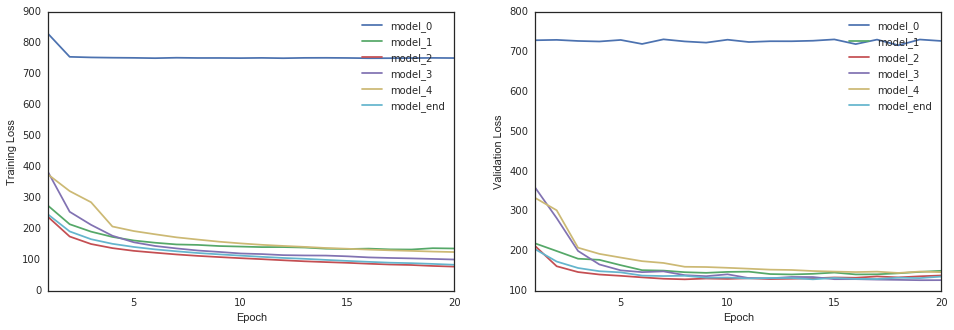

In [9]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__ Model 2 has the least training error amongst all other models, followed by model 3. However, model 3 has the best validation accuracy. Thus, overall model 3 is a good choice. Model 3 uses GRU instead of simpleRNN, which is the probable reason of its superiority over model 2, 1 and 0. Mode; 4 uses a bidirectional layer followed by softmax activation and is slightly inferior to model 3.

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, considering adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [23]:
# specify the model
model_end = final_model(input_dim=161, units = 200, output_dim=29)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         144800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         240400    
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 396,829
Trainable params: 396,829
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [25]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20


  1/106 [..............................] - ETA: 425s - loss: 997.7943

  2/106 [..............................] - ETA: 354s - loss: 646.7704

  3/106 [..............................] - ETA: 346s - loss: 578.6215

  4/106 [>.............................] - ETA: 332s - loss: 493.6243

  5/106 [>.............................] - ETA: 315s - loss: 479.7183

  6/106 [>.............................] - ETA: 299s - loss: 450.4663

  7/106 [>.............................] - ETA: 289s - loss: 427.2387

  8/106 [=>............................] - ETA: 282s - loss: 413.4189

  9/106 [=>............................] - ETA: 276s - loss: 400.8702

 10/106 [=>............................] - ETA: 271s - loss: 380.5325

 11/106 [==>...........................] - ETA: 266s - loss: 371.0003

 12/106 [==>...........................] - ETA: 263s - loss: 362.5539

 13/106 [==>...........................] - ETA: 261s - loss: 363.6676

 14/106 [==>...........................] - ETA: 261s - loss: 370.7635

 15/106 [===>..........................] - ETA: 255s - loss: 365.4469

 16/106 [===>..........................] - ETA: 252s - loss: 354.4735

 17/106 [===>..........................] - ETA: 251s - loss: 355.2756

 18/106 [====>.........................] - ETA: 249s - loss: 350.4044

 19/106 [====>.........................] - ETA: 245s - loss: 341.2314

 20/106 [====>.........................] - ETA: 239s - loss: 333.3659

 21/106 [====>.........................] - ETA: 236s - loss: 329.1816

 22/106 [=====>........................] - ETA: 234s - loss: 326.4573

 23/106 [=====>........................] - ETA: 230s - loss: 321.4469

 24/106 [=====>........................] - ETA: 226s - loss: 320.0751

 25/106 [======>.......................] - ETA: 223s - loss: 315.6631

 26/106 [======>.......................] - ETA: 221s - loss: 310.6440

 27/106 [======>.......................] - ETA: 218s - loss: 307.2487

 28/106 [======>.......................] - ETA: 214s - loss: 303.6135

 29/106 [=======>......................] - ETA: 211s - loss: 304.7393

 30/106 [=======>......................] - ETA: 209s - loss: 304.4559

 31/106 [=======>......................] - ETA: 205s - loss: 303.4408

 32/106 [========>.....................] - ETA: 200s - loss: 300.2314

 33/106 [========>.....................] - ETA: 196s - loss: 298.9322

 34/106 [========>.....................] - ETA: 193s - loss: 297.0232

 35/106 [========>.....................] - ETA: 191s - loss: 294.8230

 36/106 [=========>....................] - ETA: 188s - loss: 293.7328

 37/106 [=========>....................] - ETA: 186s - loss: 294.0869

 38/106 [=========>....................] - ETA: 184s - loss: 295.1991

 39/106 [==========>...................] - ETA: 181s - loss: 293.6876

 40/106 [==========>...................] - ETA: 178s - loss: 292.4718

 41/106 [==========>...................] - ETA: 175s - loss: 291.0737

 42/106 [==========>...................] - ETA: 173s - loss: 288.4397

 43/106 [===========>..................] - ETA: 169s - loss: 285.3171

 44/106 [===========>..................] - ETA: 166s - loss: 282.9320

 45/106 [===========>..................] - ETA: 163s - loss: 280.2989

 46/106 [============>.................] - ETA: 160s - loss: 278.0351

 47/106 [============>.................] - ETA: 158s - loss: 277.1248

 48/106 [============>.................] - ETA: 155s - loss: 274.8187

 49/106 [============>.................] - ETA: 152s - loss: 273.4972

 50/106 [=============>................] - ETA: 149s - loss: 271.3146

 51/106 [=============>................] - ETA: 147s - loss: 272.2828

 52/106 [=============>................] - ETA: 144s - loss: 272.9444

 53/106 [==============>...............] - ETA: 142s - loss: 272.5202

 54/106 [==============>...............] - ETA: 139s - loss: 271.6526

 55/106 [==============>...............] - ETA: 136s - loss: 270.5242

 56/106 [==============>...............] - ETA: 133s - loss: 270.4981

 57/106 [===============>..............] - ETA: 131s - loss: 271.2115

 58/106 [===============>..............] - ETA: 128s - loss: 270.7394

 59/106 [===============>..............] - ETA: 125s - loss: 269.6400

 60/106 [===============>..............] - ETA: 122s - loss: 268.9187

 61/106 [================>.............] - ETA: 119s - loss: 267.2971

 62/106 [================>.............] - ETA: 116s - loss: 266.1913

 63/106 [================>.............] - ETA: 114s - loss: 265.6021

 64/106 [=================>............] - ETA: 111s - loss: 264.6106

 65/106 [=================>............] - ETA: 109s - loss: 264.7762

 66/106 [=================>............] - ETA: 106s - loss: 263.7531

 67/106 [=================>............] - ETA: 104s - loss: 262.7801

 68/106 [==================>...........] - ETA: 101s - loss: 261.8365

 69/106 [==================>...........] - ETA: 98s - loss: 261.1847 

 70/106 [==================>...........] - ETA: 95s - loss: 260.5294

 71/106 [===================>..........] - ETA: 93s - loss: 259.4069

 72/106 [===================>..........] - ETA: 90s - loss: 257.9301

 73/106 [===================>..........] - ETA: 87s - loss: 256.3060

 74/106 [===================>..........] - ETA: 84s - loss: 254.7968

 75/106 [====================>.........] - ETA: 82s - loss: 253.8078

 76/106 [====================>.........] - ETA: 79s - loss: 253.5249

 77/106 [====================>.........] - ETA: 76s - loss: 253.2833

 78/106 [=====================>........] - ETA: 74s - loss: 252.2065

 79/106 [=====================>........] - ETA: 71s - loss: 251.2873

 80/106 [=====================>........] - ETA: 68s - loss: 250.4868

 81/106 [=====================>........] - ETA: 66s - loss: 250.1169

 82/106 [======================>.......] - ETA: 63s - loss: 249.4294

 83/106 [======================>.......] - ETA: 60s - loss: 250.3494

 84/106 [======================>.......] - ETA: 58s - loss: 250.1926

 85/106 [=======================>......] - ETA: 55s - loss: 249.7473

 86/106 [=======================>......] - ETA: 52s - loss: 249.8398

 87/106 [=======================>......] - ETA: 50s - loss: 249.3415

 88/106 [=======================>......] - ETA: 47s - loss: 250.0928

 89/106 [========================>.....] - ETA: 44s - loss: 250.2009

 90/106 [========================>.....] - ETA: 42s - loss: 250.5088

 91/106 [========================>.....] - ETA: 39s - loss: 250.3536

 92/106 [=========================>....] - ETA: 36s - loss: 250.1726

 93/106 [=========================>....] - ETA: 34s - loss: 249.5895

 94/106 [=========================>....] - ETA: 31s - loss: 249.0054

 95/106 [=========================>....] - ETA: 28s - loss: 248.7056

 96/106 [==========================>...] - ETA: 26s - loss: 248.7421

 97/106 [==========================>...] - ETA: 23s - loss: 248.2611

 98/106 [==========================>...] - ETA: 20s - loss: 247.4290

 99/106 [===========================>..] - ETA: 18s - loss: 246.7538

100/106 [===========================>..] - ETA: 15s - loss: 247.0466

101/106 [===========================>..] - ETA: 13s - loss: 247.1670

102/106 [===========================>..] - ETA: 10s - loss: 246.7779

103/106 [============================>.] - ETA: 7s - loss: 246.2877 

104/106 [============================>.] - ETA: 5s - loss: 245.9005

105/106 [============================>.] - ETA: 2s - loss: 245.6030

106/106 [==============================] - 388s - loss: 245.5209 - val_loss: 204.0642


Epoch 2/20


  1/106 [..............................] - ETA: 345s - loss: 257.0851

  2/106 [..............................] - ETA: 336s - loss: 236.5768

  3/106 [..............................] - ETA: 312s - loss: 234.9803

  4/106 [>.............................] - ETA: 304s - loss: 222.2653

  5/106 [>.............................] - ETA: 295s - loss: 215.1553

  6/106 [>.............................] - ETA: 289s - loss: 215.5885

  7/106 [>.............................] - ETA: 288s - loss: 217.3054

  8/106 [=>............................] - ETA: 285s - loss: 209.9491

  9/106 [=>............................] - ETA: 275s - loss: 209.0497

 10/106 [=>............................] - ETA: 272s - loss: 207.8472

 11/106 [==>...........................] - ETA: 267s - loss: 206.3205

 12/106 [==>...........................] - ETA: 262s - loss: 206.3742

 13/106 [==>...........................] - ETA: 256s - loss: 203.4281

 14/106 [==>...........................] - ETA: 251s - loss: 203.0935

 15/106 [===>..........................] - ETA: 249s - loss: 204.8589

 16/106 [===>..........................] - ETA: 246s - loss: 204.9221

 17/106 [===>..........................] - ETA: 242s - loss: 207.1273

 18/106 [====>.........................] - ETA: 239s - loss: 207.9808

 19/106 [====>.........................] - ETA: 236s - loss: 208.8995

 20/106 [====>.........................] - ETA: 232s - loss: 207.9893

 21/106 [====>.........................] - ETA: 229s - loss: 208.3151

 22/106 [=====>........................] - ETA: 226s - loss: 207.3307

 23/106 [=====>........................] - ETA: 223s - loss: 205.9579

 24/106 [=====>........................] - ETA: 220s - loss: 205.1021

 25/106 [======>.......................] - ETA: 217s - loss: 205.8629

 26/106 [======>.......................] - ETA: 214s - loss: 205.2182

 27/106 [======>.......................] - ETA: 210s - loss: 206.1566

 28/106 [======>.......................] - ETA: 207s - loss: 204.7803

 29/106 [=======>......................] - ETA: 203s - loss: 204.1316

 30/106 [=======>......................] - ETA: 201s - loss: 203.8853

 31/106 [=======>......................] - ETA: 198s - loss: 204.2831

 32/106 [========>.....................] - ETA: 195s - loss: 204.6009

 33/106 [========>.....................] - ETA: 192s - loss: 203.9708

 34/106 [========>.....................] - ETA: 189s - loss: 204.4319

 35/106 [========>.....................] - ETA: 187s - loss: 203.9674

 36/106 [=========>....................] - ETA: 184s - loss: 204.7204

 37/106 [=========>....................] - ETA: 181s - loss: 204.1741

 38/106 [=========>....................] - ETA: 179s - loss: 203.4225

 39/106 [==========>...................] - ETA: 176s - loss: 202.8797

 40/106 [==========>...................] - ETA: 173s - loss: 203.1774

 41/106 [==========>...................] - ETA: 171s - loss: 202.8132

 42/106 [==========>...................] - ETA: 169s - loss: 203.7473

 43/106 [===========>..................] - ETA: 166s - loss: 204.2388

 44/106 [===========>..................] - ETA: 163s - loss: 203.8800

 45/106 [===========>..................] - ETA: 160s - loss: 203.8286

 46/106 [============>.................] - ETA: 158s - loss: 203.4074

 47/106 [============>.................] - ETA: 155s - loss: 202.6410

 48/106 [============>.................] - ETA: 152s - loss: 202.6544

 49/106 [============>.................] - ETA: 149s - loss: 202.6602

 50/106 [=============>................] - ETA: 147s - loss: 202.6600

 51/106 [=============>................] - ETA: 144s - loss: 202.2917

 52/106 [=============>................] - ETA: 141s - loss: 202.4240

 53/106 [==============>...............] - ETA: 138s - loss: 202.5859

 54/106 [==============>...............] - ETA: 136s - loss: 201.9566

 55/106 [==============>...............] - ETA: 134s - loss: 201.9907

 56/106 [==============>...............] - ETA: 131s - loss: 202.0794

 57/106 [===============>..............] - ETA: 128s - loss: 201.8484

 58/106 [===============>..............] - ETA: 125s - loss: 201.0927

 59/106 [===============>..............] - ETA: 122s - loss: 201.0836

 60/106 [===============>..............] - ETA: 120s - loss: 200.9725

 61/106 [================>.............] - ETA: 117s - loss: 200.2792

 62/106 [================>.............] - ETA: 115s - loss: 200.4363

 63/106 [================>.............] - ETA: 112s - loss: 200.0382

 64/106 [=================>............] - ETA: 109s - loss: 200.5194

 65/106 [=================>............] - ETA: 107s - loss: 200.4960

 66/106 [=================>............] - ETA: 104s - loss: 200.5476

 67/106 [=================>............] - ETA: 102s - loss: 200.0183

 68/106 [==================>...........] - ETA: 99s - loss: 199.7059 

 69/106 [==================>...........] - ETA: 96s - loss: 199.6344

 70/106 [==================>...........] - ETA: 94s - loss: 199.1453

 71/106 [===================>..........] - ETA: 91s - loss: 199.0375

 72/106 [===================>..........] - ETA: 89s - loss: 198.7343

 73/106 [===================>..........] - ETA: 86s - loss: 198.2631

 74/106 [===================>..........] - ETA: 83s - loss: 198.0025

 75/106 [====================>.........] - ETA: 81s - loss: 198.0965

 76/106 [====================>.........] - ETA: 78s - loss: 198.0283

 77/106 [====================>.........] - ETA: 75s - loss: 197.4472

 78/106 [=====================>........] - ETA: 72s - loss: 197.1429

 79/106 [=====================>........] - ETA: 70s - loss: 196.9900

 80/106 [=====================>........] - ETA: 67s - loss: 196.5662

 81/106 [=====================>........] - ETA: 65s - loss: 196.3038

 82/106 [======================>.......] - ETA: 62s - loss: 196.0929

 83/106 [======================>.......] - ETA: 59s - loss: 195.5772

 84/106 [======================>.......] - ETA: 57s - loss: 195.3159

 85/106 [=======================>......] - ETA: 54s - loss: 195.1633

 86/106 [=======================>......] - ETA: 51s - loss: 194.8887

 87/106 [=======================>......] - ETA: 49s - loss: 194.6198

 88/106 [=======================>......] - ETA: 46s - loss: 194.3054

 89/106 [========================>.....] - ETA: 44s - loss: 194.0503

 90/106 [========================>.....] - ETA: 41s - loss: 193.7728

 91/106 [========================>.....] - ETA: 39s - loss: 193.5977

 92/106 [=========================>....] - ETA: 36s - loss: 193.7947

 93/106 [=========================>....] - ETA: 33s - loss: 193.5028

 94/106 [=========================>....] - ETA: 31s - loss: 193.5162

 95/106 [=========================>....] - ETA: 28s - loss: 193.4958

 96/106 [==========================>...] - ETA: 26s - loss: 193.2381

 97/106 [==========================>...] - ETA: 23s - loss: 193.3416

 98/106 [==========================>...] - ETA: 21s - loss: 193.2807

 99/106 [===========================>..] - ETA: 18s - loss: 193.1091

100/106 [===========================>..] - ETA: 15s - loss: 192.6900

101/106 [===========================>..] - ETA: 13s - loss: 192.5823

102/106 [===========================>..] - ETA: 10s - loss: 192.1048

103/106 [============================>.] - ETA: 7s - loss: 192.1092 

104/106 [============================>.] - ETA: 5s - loss: 191.8522

105/106 [============================>.] - ETA: 2s - loss: 191.8395

106/106 [==============================] - 411s - loss: 191.4957 - val_loss: 173.4299


Epoch 3/20


  1/106 [..............................] - ETA: 274s - loss: 163.9954

  2/106 [..............................] - ETA: 279s - loss: 168.3723

  3/106 [..............................] - ETA: 281s - loss: 173.3222

  4/106 [>.............................] - ETA: 278s - loss: 176.2440

  5/106 [>.............................] - ETA: 275s - loss: 180.1006

  6/106 [>.............................] - ETA: 271s - loss: 187.3767

  7/106 [>.............................] - ETA: 261s - loss: 182.8635

  8/106 [=>............................] - ETA: 259s - loss: 182.3627

  9/106 [=>............................] - ETA: 251s - loss: 177.5004

 10/106 [=>............................] - ETA: 253s - loss: 176.0301

 11/106 [==>...........................] - ETA: 248s - loss: 174.1312

 12/106 [==>...........................] - ETA: 248s - loss: 172.9238

 13/106 [==>...........................] - ETA: 249s - loss: 176.0640

 14/106 [==>...........................] - ETA: 249s - loss: 176.4762

 15/106 [===>..........................] - ETA: 247s - loss: 177.1540

 16/106 [===>..........................] - ETA: 246s - loss: 178.8657

 17/106 [===>..........................] - ETA: 242s - loss: 176.7272

 18/106 [====>.........................] - ETA: 241s - loss: 175.0205

 19/106 [====>.........................] - ETA: 238s - loss: 174.7514

 20/106 [====>.........................] - ETA: 240s - loss: 175.3436

 21/106 [====>.........................] - ETA: 239s - loss: 174.8433

 22/106 [=====>........................] - ETA: 238s - loss: 175.6307

 23/106 [=====>........................] - ETA: 237s - loss: 174.9565

 24/106 [=====>........................] - ETA: 234s - loss: 175.7615

 25/106 [======>.......................] - ETA: 231s - loss: 175.3492

 26/106 [======>.......................] - ETA: 228s - loss: 176.1608

 27/106 [======>.......................] - ETA: 225s - loss: 175.9945

 28/106 [======>.......................] - ETA: 222s - loss: 177.0732

 29/106 [=======>......................] - ETA: 219s - loss: 176.6815

 30/106 [=======>......................] - ETA: 216s - loss: 176.8205

 31/106 [=======>......................] - ETA: 212s - loss: 176.3318

 32/106 [========>.....................] - ETA: 209s - loss: 175.8925

 33/106 [========>.....................] - ETA: 206s - loss: 175.2512

 34/106 [========>.....................] - ETA: 202s - loss: 174.5721

 35/106 [========>.....................] - ETA: 199s - loss: 174.2707

 36/106 [=========>....................] - ETA: 196s - loss: 173.7011

 37/106 [=========>....................] - ETA: 193s - loss: 173.5944

 38/106 [=========>....................] - ETA: 190s - loss: 173.3489

 39/106 [==========>...................] - ETA: 187s - loss: 173.3282

 40/106 [==========>...................] - ETA: 184s - loss: 173.3702

 41/106 [==========>...................] - ETA: 181s - loss: 173.2164

 42/106 [==========>...................] - ETA: 178s - loss: 172.7976

 43/106 [===========>..................] - ETA: 175s - loss: 172.9927

 44/106 [===========>..................] - ETA: 173s - loss: 172.0303

 45/106 [===========>..................] - ETA: 170s - loss: 172.1892

 46/106 [============>.................] - ETA: 167s - loss: 172.0287

 47/106 [============>.................] - ETA: 165s - loss: 172.2501

 48/106 [============>.................] - ETA: 162s - loss: 172.3600

 49/106 [============>.................] - ETA: 160s - loss: 172.5571

 50/106 [=============>................] - ETA: 158s - loss: 172.5953

 51/106 [=============>................] - ETA: 155s - loss: 172.5184

 52/106 [=============>................] - ETA: 152s - loss: 173.0237

 53/106 [==============>...............] - ETA: 149s - loss: 172.9317

 54/106 [==============>...............] - ETA: 146s - loss: 172.4474

 55/106 [==============>...............] - ETA: 143s - loss: 172.2549

 56/106 [==============>...............] - ETA: 140s - loss: 171.9611

 57/106 [===============>..............] - ETA: 137s - loss: 172.0511

 58/106 [===============>..............] - ETA: 134s - loss: 172.3067

 59/106 [===============>..............] - ETA: 131s - loss: 172.2167

 60/106 [===============>..............] - ETA: 128s - loss: 171.9321

 61/106 [================>.............] - ETA: 125s - loss: 172.0169

 62/106 [================>.............] - ETA: 122s - loss: 171.9044

 63/106 [================>.............] - ETA: 119s - loss: 171.8803

 64/106 [=================>............] - ETA: 116s - loss: 171.4814

 65/106 [=================>............] - ETA: 113s - loss: 171.4558

 66/106 [=================>............] - ETA: 110s - loss: 171.1686

 67/106 [=================>............] - ETA: 108s - loss: 170.7380

 68/106 [==================>...........] - ETA: 105s - loss: 170.8074

 69/106 [==================>...........] - ETA: 102s - loss: 170.9336

 70/106 [==================>...........] - ETA: 99s - loss: 171.2959 

 71/106 [===================>..........] - ETA: 96s - loss: 170.6357

 72/106 [===================>..........] - ETA: 93s - loss: 170.0917

 73/106 [===================>..........] - ETA: 91s - loss: 169.9765

 74/106 [===================>..........] - ETA: 88s - loss: 169.6612

 75/106 [====================>.........] - ETA: 85s - loss: 169.7993

 76/106 [====================>.........] - ETA: 82s - loss: 169.5323

 77/106 [====================>.........] - ETA: 79s - loss: 169.2242

 78/106 [=====================>........] - ETA: 77s - loss: 169.0941

 79/106 [=====================>........] - ETA: 74s - loss: 168.8299

 80/106 [=====================>........] - ETA: 71s - loss: 168.9104

 81/106 [=====================>........] - ETA: 68s - loss: 168.6949

 82/106 [======================>.......] - ETA: 66s - loss: 168.5537

 83/106 [======================>.......] - ETA: 63s - loss: 168.3477

 84/106 [======================>.......] - ETA: 60s - loss: 168.3994

 85/106 [=======================>......] - ETA: 57s - loss: 168.4805

 86/106 [=======================>......] - ETA: 55s - loss: 168.4401

 87/106 [=======================>......] - ETA: 52s - loss: 168.1887

 88/106 [=======================>......] - ETA: 49s - loss: 167.9891

 89/106 [========================>.....] - ETA: 46s - loss: 168.1523

 90/106 [========================>.....] - ETA: 44s - loss: 167.9528

 91/106 [========================>.....] - ETA: 41s - loss: 167.7590

 92/106 [=========================>....] - ETA: 38s - loss: 167.8285

 93/106 [=========================>....] - ETA: 35s - loss: 167.6562

 94/106 [=========================>....] - ETA: 32s - loss: 167.6452

 95/106 [=========================>....] - ETA: 30s - loss: 167.5846

 96/106 [==========================>...] - ETA: 27s - loss: 167.1530

 97/106 [==========================>...] - ETA: 24s - loss: 166.9040

 98/106 [==========================>...] - ETA: 21s - loss: 167.1098

 99/106 [===========================>..] - ETA: 19s - loss: 167.0711

100/106 [===========================>..] - ETA: 16s - loss: 166.7703

101/106 [===========================>..] - ETA: 13s - loss: 166.7252

102/106 [===========================>..] - ETA: 10s - loss: 166.5867

103/106 [============================>.] - ETA: 8s - loss: 166.5208 

104/106 [============================>.] - ETA: 5s - loss: 166.2025

105/106 [============================>.] - ETA: 2s - loss: 166.0726

106/106 [==============================] - 412s - loss: 166.4583 - val_loss: 157.2350


Epoch 4/20


  1/106 [..............................] - ETA: 294s - loss: 172.4294

  2/106 [..............................] - ETA: 259s - loss: 162.0020

  3/106 [..............................] - ETA: 252s - loss: 161.8445

  4/106 [>.............................] - ETA: 255s - loss: 156.2864

  5/106 [>.............................] - ETA: 275s - loss: 155.5051

  6/106 [>.............................] - ETA: 281s - loss: 152.5959

  7/106 [>.............................] - ETA: 281s - loss: 156.6253

  8/106 [=>............................] - ETA: 280s - loss: 157.2224

  9/106 [=>............................] - ETA: 281s - loss: 159.7244

 10/106 [=>............................] - ETA: 280s - loss: 160.8369

 11/106 [==>...........................] - ETA: 275s - loss: 162.4200

 12/106 [==>...........................] - ETA: 267s - loss: 159.1867

 13/106 [==>...........................] - ETA: 262s - loss: 158.8403

 14/106 [==>...........................] - ETA: 256s - loss: 158.1295

 15/106 [===>..........................] - ETA: 251s - loss: 156.6527

 16/106 [===>..........................] - ETA: 246s - loss: 155.8807

 17/106 [===>..........................] - ETA: 242s - loss: 155.2433

 18/106 [====>.........................] - ETA: 238s - loss: 155.9267

 19/106 [====>.........................] - ETA: 234s - loss: 155.0380

 20/106 [====>.........................] - ETA: 231s - loss: 154.8093

 21/106 [====>.........................] - ETA: 229s - loss: 155.8347

 22/106 [=====>........................] - ETA: 226s - loss: 156.3198

 23/106 [=====>........................] - ETA: 223s - loss: 156.1413

 24/106 [=====>........................] - ETA: 220s - loss: 157.1901

 25/106 [======>.......................] - ETA: 217s - loss: 156.5979

 26/106 [======>.......................] - ETA: 213s - loss: 155.3559

 27/106 [======>.......................] - ETA: 210s - loss: 155.7060

 28/106 [======>.......................] - ETA: 207s - loss: 155.2020

 29/106 [=======>......................] - ETA: 203s - loss: 155.0409

 30/106 [=======>......................] - ETA: 200s - loss: 155.1236

 31/106 [=======>......................] - ETA: 197s - loss: 154.4488

 32/106 [========>.....................] - ETA: 194s - loss: 154.9267

 33/106 [========>.....................] - ETA: 191s - loss: 154.3899

 34/106 [========>.....................] - ETA: 188s - loss: 154.5478

 35/106 [========>.....................] - ETA: 185s - loss: 154.7571

 36/106 [=========>....................] - ETA: 182s - loss: 154.4214

 37/106 [=========>....................] - ETA: 179s - loss: 154.6322

 38/106 [=========>....................] - ETA: 176s - loss: 154.3873

 39/106 [==========>...................] - ETA: 173s - loss: 154.8151

 40/106 [==========>...................] - ETA: 170s - loss: 154.2214

 41/106 [==========>...................] - ETA: 167s - loss: 154.1855

 42/106 [==========>...................] - ETA: 165s - loss: 154.7069

 43/106 [===========>..................] - ETA: 162s - loss: 154.6743

 44/106 [===========>..................] - ETA: 160s - loss: 154.6111

 45/106 [===========>..................] - ETA: 158s - loss: 154.3405

 46/106 [============>.................] - ETA: 154s - loss: 153.8580

 47/106 [============>.................] - ETA: 151s - loss: 153.8614

 48/106 [============>.................] - ETA: 148s - loss: 154.0390

 49/106 [============>.................] - ETA: 146s - loss: 154.2311

 50/106 [=============>................] - ETA: 144s - loss: 154.0944

 51/106 [=============>................] - ETA: 142s - loss: 153.8536

 52/106 [=============>................] - ETA: 139s - loss: 153.7315

 53/106 [==============>...............] - ETA: 136s - loss: 153.2266

 54/106 [==============>...............] - ETA: 134s - loss: 153.4079

 55/106 [==============>...............] - ETA: 131s - loss: 153.6570

 56/106 [==============>...............] - ETA: 129s - loss: 154.2190

 57/106 [===============>..............] - ETA: 126s - loss: 154.4107

 58/106 [===============>..............] - ETA: 124s - loss: 153.8371

 59/106 [===============>..............] - ETA: 121s - loss: 153.5734

 60/106 [===============>..............] - ETA: 119s - loss: 153.8714

 61/106 [================>.............] - ETA: 116s - loss: 154.0128

 62/106 [================>.............] - ETA: 114s - loss: 154.0250

 63/106 [================>.............] - ETA: 111s - loss: 153.7017

 64/106 [=================>............] - ETA: 108s - loss: 153.4759

 65/106 [=================>............] - ETA: 106s - loss: 153.4410

 66/106 [=================>............] - ETA: 103s - loss: 153.4562

 67/106 [=================>............] - ETA: 101s - loss: 153.2250

 68/106 [==================>...........] - ETA: 99s - loss: 153.0052 

 69/106 [==================>...........] - ETA: 96s - loss: 152.6847

 70/106 [==================>...........] - ETA: 94s - loss: 152.6276

 71/106 [===================>..........] - ETA: 92s - loss: 152.8289

 72/106 [===================>..........] - ETA: 90s - loss: 153.0619

 73/106 [===================>..........] - ETA: 87s - loss: 152.9222

 74/106 [===================>..........] - ETA: 84s - loss: 152.6796

 75/106 [====================>.........] - ETA: 82s - loss: 152.9521

 76/106 [====================>.........] - ETA: 80s - loss: 152.6580

 77/106 [====================>.........] - ETA: 77s - loss: 152.6103

 78/106 [=====================>........] - ETA: 74s - loss: 152.3907

 79/106 [=====================>........] - ETA: 71s - loss: 152.2477

 80/106 [=====================>........] - ETA: 69s - loss: 152.0558

 81/106 [=====================>........] - ETA: 66s - loss: 151.9368

 82/106 [======================>.......] - ETA: 63s - loss: 151.9344

 83/106 [======================>.......] - ETA: 61s - loss: 152.0270

 84/106 [======================>.......] - ETA: 58s - loss: 151.9760

 85/106 [=======================>......] - ETA: 55s - loss: 151.8632

 86/106 [=======================>......] - ETA: 52s - loss: 152.1288

 87/106 [=======================>......] - ETA: 50s - loss: 152.2365

 88/106 [=======================>......] - ETA: 47s - loss: 151.9820

 89/106 [========================>.....] - ETA: 45s - loss: 151.9736

 90/106 [========================>.....] - ETA: 42s - loss: 152.0804

 91/106 [========================>.....] - ETA: 39s - loss: 152.1375

 92/106 [=========================>....] - ETA: 37s - loss: 151.9887

 93/106 [=========================>....] - ETA: 34s - loss: 152.1632

 94/106 [=========================>....] - ETA: 31s - loss: 152.3759

 95/106 [=========================>....] - ETA: 29s - loss: 152.2868

 96/106 [==========================>...] - ETA: 26s - loss: 152.0828

 97/106 [==========================>...] - ETA: 23s - loss: 152.0073

 98/106 [==========================>...] - ETA: 21s - loss: 152.2251

 99/106 [===========================>..] - ETA: 18s - loss: 151.9538

100/106 [===========================>..] - ETA: 15s - loss: 151.6715

101/106 [===========================>..] - ETA: 13s - loss: 151.7281

102/106 [===========================>..] - ETA: 10s - loss: 151.5793

103/106 [============================>.] - ETA: 7s - loss: 151.3599 

104/106 [============================>.] - ETA: 5s - loss: 151.4344

105/106 [============================>.] - ETA: 2s - loss: 151.5805

106/106 [==============================] - 400s - loss: 151.5827 - val_loss: 149.1354


Epoch 5/20


  1/106 [..............................] - ETA: 287s - loss: 155.9459

  2/106 [..............................] - ETA: 283s - loss: 151.2175

  3/106 [..............................] - ETA: 281s - loss: 149.0818

  4/106 [>.............................] - ETA: 276s - loss: 152.5026

  5/106 [>.............................] - ETA: 274s - loss: 151.1659

  6/106 [>.............................] - ETA: 268s - loss: 148.7293

  7/106 [>.............................] - ETA: 269s - loss: 148.4675

  8/106 [=>............................] - ETA: 269s - loss: 146.7408

  9/106 [=>............................] - ETA: 261s - loss: 143.6964

 10/106 [=>............................] - ETA: 257s - loss: 143.7408

 11/106 [==>...........................] - ETA: 255s - loss: 143.2929

 12/106 [==>...........................] - ETA: 251s - loss: 146.2438

 13/106 [==>...........................] - ETA: 249s - loss: 145.1507

 14/106 [==>...........................] - ETA: 245s - loss: 144.9851

 15/106 [===>..........................] - ETA: 241s - loss: 143.4921

 16/106 [===>..........................] - ETA: 237s - loss: 141.7939

 17/106 [===>..........................] - ETA: 232s - loss: 140.4953

 18/106 [====>.........................] - ETA: 229s - loss: 140.6413

 19/106 [====>.........................] - ETA: 226s - loss: 140.7503

 20/106 [====>.........................] - ETA: 223s - loss: 141.4952

 21/106 [====>.........................] - ETA: 218s - loss: 141.5882

 22/106 [=====>........................] - ETA: 216s - loss: 141.7486

 23/106 [=====>........................] - ETA: 211s - loss: 141.6006

 24/106 [=====>........................] - ETA: 210s - loss: 141.3563

 25/106 [======>.......................] - ETA: 208s - loss: 142.0151

 26/106 [======>.......................] - ETA: 205s - loss: 142.2448

 27/106 [======>.......................] - ETA: 203s - loss: 142.0957

 28/106 [======>.......................] - ETA: 200s - loss: 142.1463

 29/106 [=======>......................] - ETA: 198s - loss: 142.7504

 30/106 [=======>......................] - ETA: 195s - loss: 142.2907

 31/106 [=======>......................] - ETA: 192s - loss: 142.0408

 32/106 [========>.....................] - ETA: 190s - loss: 141.8873

 33/106 [========>.....................] - ETA: 188s - loss: 141.6663

 34/106 [========>.....................] - ETA: 187s - loss: 141.8762

 35/106 [========>.....................] - ETA: 185s - loss: 141.4968

 36/106 [=========>....................] - ETA: 183s - loss: 141.3712

 37/106 [=========>....................] - ETA: 181s - loss: 141.4502

 38/106 [=========>....................] - ETA: 178s - loss: 141.8408

 39/106 [==========>...................] - ETA: 176s - loss: 141.7750

 40/106 [==========>...................] - ETA: 173s - loss: 141.0723

 41/106 [==========>...................] - ETA: 171s - loss: 140.9396

 42/106 [==========>...................] - ETA: 169s - loss: 140.6752

 43/106 [===========>..................] - ETA: 166s - loss: 140.5100

 44/106 [===========>..................] - ETA: 164s - loss: 140.3710

 45/106 [===========>..................] - ETA: 161s - loss: 140.3842

 46/106 [============>.................] - ETA: 158s - loss: 140.1044

 47/106 [============>.................] - ETA: 155s - loss: 140.2947

 48/106 [============>.................] - ETA: 153s - loss: 140.4754

 49/106 [============>.................] - ETA: 150s - loss: 140.4658

 50/106 [=============>................] - ETA: 147s - loss: 140.5836

 51/106 [=============>................] - ETA: 145s - loss: 140.9651

 52/106 [=============>................] - ETA: 142s - loss: 141.1954

 53/106 [==============>...............] - ETA: 139s - loss: 141.2407

 54/106 [==============>...............] - ETA: 137s - loss: 141.6934

 55/106 [==============>...............] - ETA: 134s - loss: 141.9728

 56/106 [==============>...............] - ETA: 132s - loss: 141.8629

 57/106 [===============>..............] - ETA: 129s - loss: 141.3469

 58/106 [===============>..............] - ETA: 126s - loss: 141.2916

 59/106 [===============>..............] - ETA: 124s - loss: 140.9401

 60/106 [===============>..............] - ETA: 121s - loss: 141.0277

 61/106 [================>.............] - ETA: 118s - loss: 141.0692

 62/106 [================>.............] - ETA: 116s - loss: 141.0015

 63/106 [================>.............] - ETA: 113s - loss: 141.1167

 64/106 [=================>............] - ETA: 111s - loss: 141.0679

 65/106 [=================>............] - ETA: 108s - loss: 141.2153

 66/106 [=================>............] - ETA: 105s - loss: 141.4715

 67/106 [=================>............] - ETA: 103s - loss: 141.3015

 68/106 [==================>...........] - ETA: 100s - loss: 140.9051

 69/106 [==================>...........] - ETA: 98s - loss: 141.1267 

 70/106 [==================>...........] - ETA: 95s - loss: 141.1376

 71/106 [===================>..........] - ETA: 93s - loss: 141.0888

 72/106 [===================>..........] - ETA: 90s - loss: 141.4260

 73/106 [===================>..........] - ETA: 87s - loss: 141.4722

 74/106 [===================>..........] - ETA: 85s - loss: 141.7953

 75/106 [====================>.........] - ETA: 82s - loss: 141.5793

 76/106 [====================>.........] - ETA: 79s - loss: 141.6487

 77/106 [====================>.........] - ETA: 77s - loss: 141.5427

 78/106 [=====================>........] - ETA: 74s - loss: 141.5335

 79/106 [=====================>........] - ETA: 71s - loss: 141.6888

 80/106 [=====================>........] - ETA: 69s - loss: 141.6466

 81/106 [=====================>........] - ETA: 66s - loss: 141.7663

 82/106 [======================>.......] - ETA: 63s - loss: 141.6390

 83/106 [======================>.......] - ETA: 61s - loss: 141.9560

 84/106 [======================>.......] - ETA: 58s - loss: 141.8994

 85/106 [=======================>......] - ETA: 56s - loss: 142.3638

 86/106 [=======================>......] - ETA: 53s - loss: 142.3429

 87/106 [=======================>......] - ETA: 50s - loss: 142.3259

 88/106 [=======================>......] - ETA: 48s - loss: 142.0873

 89/106 [========================>.....] - ETA: 45s - loss: 141.8891

 90/106 [========================>.....] - ETA: 42s - loss: 141.9959

 91/106 [========================>.....] - ETA: 39s - loss: 141.8698

 92/106 [=========================>....] - ETA: 37s - loss: 141.6907

 93/106 [=========================>....] - ETA: 34s - loss: 141.7829

 94/106 [=========================>....] - ETA: 31s - loss: 141.7553

 95/106 [=========================>....] - ETA: 29s - loss: 141.7050

 96/106 [==========================>...] - ETA: 26s - loss: 141.6209

 97/106 [==========================>...] - ETA: 23s - loss: 141.3374

 98/106 [==========================>...] - ETA: 21s - loss: 141.4719

 99/106 [===========================>..] - ETA: 18s - loss: 141.3285

100/106 [===========================>..] - ETA: 15s - loss: 141.3489

101/106 [===========================>..] - ETA: 13s - loss: 141.4357

102/106 [===========================>..] - ETA: 10s - loss: 141.5167

103/106 [============================>.] - ETA: 7s - loss: 141.7080 

104/106 [============================>.] - ETA: 5s - loss: 141.5476

105/106 [============================>.] - ETA: 2s - loss: 141.7405

106/106 [==============================] - 402s - loss: 141.4686 - val_loss: 146.2353


Epoch 6/20


  1/106 [..............................] - ETA: 299s - loss: 140.7455

  2/106 [..............................] - ETA: 282s - loss: 139.8991

  3/106 [..............................] - ETA: 279s - loss: 135.1520

  4/106 [>.............................] - ETA: 272s - loss: 135.0872

  5/106 [>.............................] - ETA: 270s - loss: 133.9157

  6/106 [>.............................] - ETA: 266s - loss: 135.0493

  7/106 [>.............................] - ETA: 276s - loss: 133.6670

  8/106 [=>............................] - ETA: 275s - loss: 133.9912

  9/106 [=>............................] - ETA: 274s - loss: 134.0128

 10/106 [=>............................] - ETA: 264s - loss: 131.2152

 11/106 [==>...........................] - ETA: 259s - loss: 132.4673

 12/106 [==>...........................] - ETA: 251s - loss: 133.6123

 13/106 [==>...........................] - ETA: 248s - loss: 134.4964

 14/106 [==>...........................] - ETA: 241s - loss: 134.3156

 15/106 [===>..........................] - ETA: 237s - loss: 134.1805

 16/106 [===>..........................] - ETA: 233s - loss: 134.7577

 17/106 [===>..........................] - ETA: 230s - loss: 134.2033

 18/106 [====>.........................] - ETA: 226s - loss: 134.8174

 19/106 [====>.........................] - ETA: 223s - loss: 134.3985

 20/106 [====>.........................] - ETA: 218s - loss: 134.0990

 21/106 [====>.........................] - ETA: 215s - loss: 135.3699

 22/106 [=====>........................] - ETA: 211s - loss: 134.8933

 23/106 [=====>........................] - ETA: 209s - loss: 134.6077

 24/106 [=====>........................] - ETA: 204s - loss: 134.0066

 25/106 [======>.......................] - ETA: 201s - loss: 134.7088

 26/106 [======>.......................] - ETA: 198s - loss: 134.4542

 27/106 [======>.......................] - ETA: 196s - loss: 134.1726

 28/106 [======>.......................] - ETA: 192s - loss: 132.8405

 29/106 [=======>......................] - ETA: 190s - loss: 132.0842

 30/106 [=======>......................] - ETA: 188s - loss: 133.0635

 31/106 [=======>......................] - ETA: 185s - loss: 133.7573

 32/106 [========>.....................] - ETA: 183s - loss: 133.7811

 33/106 [========>.....................] - ETA: 180s - loss: 134.3506

 34/106 [========>.....................] - ETA: 177s - loss: 134.6090

 35/106 [========>.....................] - ETA: 175s - loss: 134.3130

 36/106 [=========>....................] - ETA: 173s - loss: 133.8676

 37/106 [=========>....................] - ETA: 170s - loss: 133.9100

 38/106 [=========>....................] - ETA: 167s - loss: 133.5759

 39/106 [==========>...................] - ETA: 165s - loss: 133.4816

 40/106 [==========>...................] - ETA: 162s - loss: 133.1718

 41/106 [==========>...................] - ETA: 160s - loss: 133.3424

 42/106 [==========>...................] - ETA: 157s - loss: 133.0758

 43/106 [===========>..................] - ETA: 155s - loss: 133.4223

 44/106 [===========>..................] - ETA: 152s - loss: 133.5977

 45/106 [===========>..................] - ETA: 149s - loss: 133.5747

 46/106 [============>.................] - ETA: 147s - loss: 133.0252

 47/106 [============>.................] - ETA: 144s - loss: 133.1785

 48/106 [============>.................] - ETA: 142s - loss: 133.4132

 49/106 [============>.................] - ETA: 139s - loss: 133.5019

 50/106 [=============>................] - ETA: 137s - loss: 133.6834

 51/106 [=============>................] - ETA: 135s - loss: 133.9336

 52/106 [=============>................] - ETA: 132s - loss: 134.0013

 53/106 [==============>...............] - ETA: 130s - loss: 133.8585

 54/106 [==============>...............] - ETA: 128s - loss: 134.2608

 55/106 [==============>...............] - ETA: 125s - loss: 134.1734

 56/106 [==============>...............] - ETA: 123s - loss: 134.1589

 57/106 [===============>..............] - ETA: 120s - loss: 133.9738

 58/106 [===============>..............] - ETA: 118s - loss: 134.0069

 59/106 [===============>..............] - ETA: 115s - loss: 134.1115

 60/106 [===============>..............] - ETA: 113s - loss: 134.0055

 61/106 [================>.............] - ETA: 111s - loss: 134.0592

 62/106 [================>.............] - ETA: 108s - loss: 134.1210

 63/106 [================>.............] - ETA: 106s - loss: 133.8016

 64/106 [=================>............] - ETA: 103s - loss: 133.8228

 65/106 [=================>............] - ETA: 101s - loss: 134.0288

 66/106 [=================>............] - ETA: 98s - loss: 134.1802 

 67/106 [=================>............] - ETA: 96s - loss: 134.1330

 68/106 [==================>...........] - ETA: 93s - loss: 133.9140

 69/106 [==================>...........] - ETA: 91s - loss: 133.9219

 70/106 [==================>...........] - ETA: 88s - loss: 133.7232

 71/106 [===================>..........] - ETA: 86s - loss: 133.0806

 72/106 [===================>..........] - ETA: 83s - loss: 132.7089

 73/106 [===================>..........] - ETA: 81s - loss: 132.3710

 74/106 [===================>..........] - ETA: 78s - loss: 132.5151

 75/106 [====================>.........] - ETA: 76s - loss: 132.6377

 76/106 [====================>.........] - ETA: 73s - loss: 132.7344

 77/106 [====================>.........] - ETA: 71s - loss: 133.1759

 78/106 [=====================>........] - ETA: 68s - loss: 133.2983

 79/106 [=====================>........] - ETA: 66s - loss: 133.2533

 80/106 [=====================>........] - ETA: 63s - loss: 133.2630

 81/106 [=====================>........] - ETA: 61s - loss: 133.3039

 82/106 [======================>.......] - ETA: 58s - loss: 133.3964

 83/106 [======================>.......] - ETA: 56s - loss: 133.2927

 84/106 [======================>.......] - ETA: 54s - loss: 133.5133

 85/106 [=======================>......] - ETA: 51s - loss: 133.6849

 86/106 [=======================>......] - ETA: 49s - loss: 133.7525

 87/106 [=======================>......] - ETA: 46s - loss: 133.7033

 88/106 [=======================>......] - ETA: 44s - loss: 133.6488

 89/106 [========================>.....] - ETA: 41s - loss: 133.5191

 90/106 [========================>.....] - ETA: 39s - loss: 133.3337

 91/106 [========================>.....] - ETA: 36s - loss: 133.1106

 92/106 [=========================>....] - ETA: 34s - loss: 133.1872

 93/106 [=========================>....] - ETA: 32s - loss: 133.2036

 94/106 [=========================>....] - ETA: 29s - loss: 133.3887

 95/106 [=========================>....] - ETA: 27s - loss: 133.4583

 96/106 [==========================>...] - ETA: 24s - loss: 133.6358

 97/106 [==========================>...] - ETA: 22s - loss: 133.5166

 98/106 [==========================>...] - ETA: 19s - loss: 133.6657

 99/106 [===========================>..] - ETA: 17s - loss: 133.8686

100/106 [===========================>..] - ETA: 14s - loss: 133.9814

101/106 [===========================>..] - ETA: 12s - loss: 133.8598

102/106 [===========================>..] - ETA: 9s - loss: 133.6769 

103/106 [============================>.] - ETA: 7s - loss: 133.5691

104/106 [============================>.] - ETA: 4s - loss: 133.5691

105/106 [============================>.] - ETA: 2s - loss: 133.5265

106/106 [==============================] - 373s - loss: 133.6072 - val_loss: 138.1426


Epoch 7/20


  1/106 [..............................] - ETA: 218s - loss: 127.4119

  2/106 [..............................] - ETA: 237s - loss: 136.2175

  3/106 [..............................] - ETA: 242s - loss: 133.1334

  4/106 [>.............................] - ETA: 244s - loss: 139.7153

  5/106 [>.............................] - ETA: 237s - loss: 135.4702

  6/106 [>.............................] - ETA: 239s - loss: 135.6275

  7/106 [>.............................] - ETA: 235s - loss: 135.3263

  8/106 [=>............................] - ETA: 229s - loss: 133.0607

  9/106 [=>............................] - ETA: 229s - loss: 133.7277

 10/106 [=>............................] - ETA: 227s - loss: 129.7299

 11/106 [==>...........................] - ETA: 226s - loss: 130.0332

 12/106 [==>...........................] - ETA: 226s - loss: 133.4873

 13/106 [==>...........................] - ETA: 224s - loss: 133.8160

 14/106 [==>...........................] - ETA: 222s - loss: 133.5933

 15/106 [===>..........................] - ETA: 222s - loss: 134.3654

 16/106 [===>..........................] - ETA: 220s - loss: 133.7718

 17/106 [===>..........................] - ETA: 218s - loss: 131.5260

 18/106 [====>.........................] - ETA: 215s - loss: 130.0684

 19/106 [====>.........................] - ETA: 212s - loss: 130.2724

 20/106 [====>.........................] - ETA: 210s - loss: 129.1082

 21/106 [====>.........................] - ETA: 206s - loss: 129.3603

 22/106 [=====>........................] - ETA: 204s - loss: 129.7902

 23/106 [=====>........................] - ETA: 202s - loss: 129.1252

 24/106 [=====>........................] - ETA: 199s - loss: 128.7043

 25/106 [======>.......................] - ETA: 195s - loss: 127.1919

 26/106 [======>.......................] - ETA: 193s - loss: 127.4558

 27/106 [======>.......................] - ETA: 190s - loss: 128.0968

 28/106 [======>.......................] - ETA: 188s - loss: 128.2385

 29/106 [=======>......................] - ETA: 186s - loss: 127.7854

 30/106 [=======>......................] - ETA: 184s - loss: 127.4364

 31/106 [=======>......................] - ETA: 182s - loss: 127.3626

 32/106 [========>.....................] - ETA: 180s - loss: 128.2869

 33/106 [========>.....................] - ETA: 176s - loss: 128.3697

 34/106 [========>.....................] - ETA: 174s - loss: 128.2090

 35/106 [========>.....................] - ETA: 171s - loss: 128.6194

 36/106 [=========>....................] - ETA: 169s - loss: 128.1999

 37/106 [=========>....................] - ETA: 166s - loss: 128.4289

 38/106 [=========>....................] - ETA: 164s - loss: 128.2133

 39/106 [==========>...................] - ETA: 161s - loss: 127.9550

 40/106 [==========>...................] - ETA: 158s - loss: 128.2563

 41/106 [==========>...................] - ETA: 156s - loss: 128.6875

 42/106 [==========>...................] - ETA: 153s - loss: 128.2892

 43/106 [===========>..................] - ETA: 151s - loss: 128.1971

 44/106 [===========>..................] - ETA: 149s - loss: 127.9063

 45/106 [===========>..................] - ETA: 146s - loss: 127.5733

 46/106 [============>.................] - ETA: 144s - loss: 127.4119

 47/106 [============>.................] - ETA: 142s - loss: 127.3711

 48/106 [============>.................] - ETA: 140s - loss: 127.5910

 49/106 [============>.................] - ETA: 137s - loss: 127.3822

 50/106 [=============>................] - ETA: 135s - loss: 127.6461

 51/106 [=============>................] - ETA: 132s - loss: 127.5283

 52/106 [=============>................] - ETA: 130s - loss: 127.6978

 53/106 [==============>...............] - ETA: 128s - loss: 127.7577

 54/106 [==============>...............] - ETA: 125s - loss: 128.0241

 55/106 [==============>...............] - ETA: 123s - loss: 127.9962

 56/106 [==============>...............] - ETA: 120s - loss: 127.9972

 57/106 [===============>..............] - ETA: 118s - loss: 127.9798

 58/106 [===============>..............] - ETA: 115s - loss: 128.0647

 59/106 [===============>..............] - ETA: 113s - loss: 127.7510

 60/106 [===============>..............] - ETA: 111s - loss: 127.8565

 61/106 [================>.............] - ETA: 108s - loss: 127.5621

 62/106 [================>.............] - ETA: 106s - loss: 127.5066

 63/106 [================>.............] - ETA: 104s - loss: 127.2429

 64/106 [=================>............] - ETA: 101s - loss: 127.3400

 65/106 [=================>............] - ETA: 99s - loss: 127.1405 

 66/106 [=================>............] - ETA: 96s - loss: 126.8311

 67/106 [=================>............] - ETA: 94s - loss: 126.8899

 68/106 [==================>...........] - ETA: 91s - loss: 127.0949

 69/106 [==================>...........] - ETA: 89s - loss: 127.4179

 70/106 [==================>...........] - ETA: 87s - loss: 127.6224

 71/106 [===================>..........] - ETA: 84s - loss: 127.5328

 72/106 [===================>..........] - ETA: 82s - loss: 127.9669

 73/106 [===================>..........] - ETA: 80s - loss: 127.9049

 74/106 [===================>..........] - ETA: 78s - loss: 128.0074

 75/106 [====================>.........] - ETA: 76s - loss: 127.7342

 76/106 [====================>.........] - ETA: 73s - loss: 127.8095

 77/106 [====================>.........] - ETA: 71s - loss: 127.9080

 78/106 [=====================>........] - ETA: 69s - loss: 127.9949

 79/106 [=====================>........] - ETA: 66s - loss: 127.8949

 80/106 [=====================>........] - ETA: 64s - loss: 127.9576

 81/106 [=====================>........] - ETA: 62s - loss: 128.2709

 82/106 [======================>.......] - ETA: 60s - loss: 128.4005

 83/106 [======================>.......] - ETA: 58s - loss: 128.4808

 84/106 [======================>.......] - ETA: 55s - loss: 128.6600

 85/106 [=======================>......] - ETA: 53s - loss: 128.5585

 86/106 [=======================>......] - ETA: 50s - loss: 128.2920

 87/106 [=======================>......] - ETA: 48s - loss: 128.5374

 88/106 [=======================>......] - ETA: 45s - loss: 128.2127

 89/106 [========================>.....] - ETA: 43s - loss: 128.0746

 90/106 [========================>.....] - ETA: 40s - loss: 127.9582

 91/106 [========================>.....] - ETA: 38s - loss: 127.8142

 92/106 [=========================>....] - ETA: 35s - loss: 127.8451

 93/106 [=========================>....] - ETA: 33s - loss: 127.5165

 94/106 [=========================>....] - ETA: 30s - loss: 127.6974

 95/106 [=========================>....] - ETA: 28s - loss: 128.0051

 96/106 [==========================>...] - ETA: 25s - loss: 127.8084

 97/106 [==========================>...] - ETA: 23s - loss: 127.9228

 98/106 [==========================>...] - ETA: 20s - loss: 127.9789

 99/106 [===========================>..] - ETA: 18s - loss: 127.8473

100/106 [===========================>..] - ETA: 15s - loss: 127.4698

101/106 [===========================>..] - ETA: 12s - loss: 127.5318

102/106 [===========================>..] - ETA: 10s - loss: 127.5298

103/106 [============================>.] - ETA: 7s - loss: 127.3968 

104/106 [============================>.] - ETA: 5s - loss: 127.4048

105/106 [============================>.] - ETA: 2s - loss: 127.3453

106/106 [==============================] - 410s - loss: 127.4652 - val_loss: 137.0335


Epoch 8/20


  1/106 [..............................] - ETA: 328s - loss: 121.5176

  2/106 [..............................] - ETA: 310s - loss: 115.9604

  3/106 [..............................] - ETA: 310s - loss: 112.9893

  4/106 [>.............................] - ETA: 311s - loss: 120.5003

  5/106 [>.............................] - ETA: 311s - loss: 116.5534

  6/106 [>.............................] - ETA: 306s - loss: 116.8288

  7/106 [>.............................] - ETA: 304s - loss: 116.9314

  8/106 [=>............................] - ETA: 296s - loss: 116.9120

  9/106 [=>............................] - ETA: 292s - loss: 121.4072

 10/106 [=>............................] - ETA: 288s - loss: 121.0607

 11/106 [==>...........................] - ETA: 284s - loss: 121.1127

 12/106 [==>...........................] - ETA: 278s - loss: 119.4931

 13/106 [==>...........................] - ETA: 276s - loss: 118.5415

 14/106 [==>...........................] - ETA: 276s - loss: 120.1886

 15/106 [===>..........................] - ETA: 273s - loss: 121.0627

 16/106 [===>..........................] - ETA: 267s - loss: 120.5165

 17/106 [===>..........................] - ETA: 264s - loss: 121.0458

 18/106 [====>.........................] - ETA: 261s - loss: 120.6974

 19/106 [====>.........................] - ETA: 258s - loss: 120.9254

 20/106 [====>.........................] - ETA: 255s - loss: 120.5982

 21/106 [====>.........................] - ETA: 251s - loss: 120.0721

 22/106 [=====>........................] - ETA: 247s - loss: 120.5145

 23/106 [=====>........................] - ETA: 244s - loss: 121.9936

 24/106 [=====>........................] - ETA: 242s - loss: 121.8649

 25/106 [======>.......................] - ETA: 240s - loss: 122.3684

 26/106 [======>.......................] - ETA: 237s - loss: 122.3719

 27/106 [======>.......................] - ETA: 234s - loss: 122.4369

 28/106 [======>.......................] - ETA: 229s - loss: 121.8272

 29/106 [=======>......................] - ETA: 226s - loss: 122.4678

 30/106 [=======>......................] - ETA: 224s - loss: 123.2317

 31/106 [=======>......................] - ETA: 222s - loss: 123.4842

 32/106 [========>.....................] - ETA: 219s - loss: 123.6822

 33/106 [========>.....................] - ETA: 216s - loss: 123.7964

 34/106 [========>.....................] - ETA: 213s - loss: 123.8115

 35/106 [========>.....................] - ETA: 210s - loss: 123.8885

 36/106 [=========>....................] - ETA: 207s - loss: 123.6285

 37/106 [=========>....................] - ETA: 204s - loss: 123.9947

 38/106 [=========>....................] - ETA: 202s - loss: 123.4840

 39/106 [==========>...................] - ETA: 199s - loss: 123.6828

 40/106 [==========>...................] - ETA: 196s - loss: 123.7254

 41/106 [==========>...................] - ETA: 193s - loss: 123.1013

 42/106 [==========>...................] - ETA: 190s - loss: 122.9233

 43/106 [===========>..................] - ETA: 186s - loss: 122.9469

 44/106 [===========>..................] - ETA: 183s - loss: 122.8108

 45/106 [===========>..................] - ETA: 180s - loss: 122.2886

 46/106 [============>.................] - ETA: 176s - loss: 122.3055

 47/106 [============>.................] - ETA: 173s - loss: 121.9624

 48/106 [============>.................] - ETA: 170s - loss: 121.9913

 49/106 [============>.................] - ETA: 167s - loss: 121.8739

 50/106 [=============>................] - ETA: 164s - loss: 122.0053

 51/106 [=============>................] - ETA: 161s - loss: 122.0344

 52/106 [=============>................] - ETA: 158s - loss: 121.9365

 53/106 [==============>...............] - ETA: 155s - loss: 121.9185

 54/106 [==============>...............] - ETA: 152s - loss: 122.0444

 55/106 [==============>...............] - ETA: 149s - loss: 122.1062

 56/106 [==============>...............] - ETA: 146s - loss: 121.8424

 57/106 [===============>..............] - ETA: 143s - loss: 121.7507

 58/106 [===============>..............] - ETA: 140s - loss: 121.5976

 59/106 [===============>..............] - ETA: 137s - loss: 121.8931

 60/106 [===============>..............] - ETA: 134s - loss: 122.3303

 61/106 [================>.............] - ETA: 132s - loss: 122.4503

 62/106 [================>.............] - ETA: 129s - loss: 122.3846

 63/106 [================>.............] - ETA: 126s - loss: 122.6803

 64/106 [=================>............] - ETA: 123s - loss: 122.7548

 65/106 [=================>............] - ETA: 120s - loss: 122.8638

 66/106 [=================>............] - ETA: 117s - loss: 122.8750

 67/106 [=================>............] - ETA: 115s - loss: 123.0613

 68/106 [==================>...........] - ETA: 112s - loss: 123.1849

 69/106 [==================>...........] - ETA: 109s - loss: 122.9986

 70/106 [==================>...........] - ETA: 106s - loss: 123.1433

 71/106 [===================>..........] - ETA: 103s - loss: 122.8812

 72/106 [===================>..........] - ETA: 100s - loss: 122.9363

 73/106 [===================>..........] - ETA: 97s - loss: 122.8618 

 74/106 [===================>..........] - ETA: 94s - loss: 122.8703

 75/106 [====================>.........] - ETA: 91s - loss: 123.1100

 76/106 [====================>.........] - ETA: 88s - loss: 123.0767

 77/106 [====================>.........] - ETA: 85s - loss: 123.2296

 78/106 [=====================>........] - ETA: 82s - loss: 123.0332

 79/106 [=====================>........] - ETA: 79s - loss: 123.3949

 80/106 [=====================>........] - ETA: 76s - loss: 123.1438

 81/106 [=====================>........] - ETA: 73s - loss: 123.0773

 82/106 [======================>.......] - ETA: 70s - loss: 123.0298

 83/106 [======================>.......] - ETA: 67s - loss: 122.8273

 84/106 [======================>.......] - ETA: 65s - loss: 122.7043

 85/106 [=======================>......] - ETA: 62s - loss: 122.8709

 86/106 [=======================>......] - ETA: 59s - loss: 123.1152

 87/106 [=======================>......] - ETA: 56s - loss: 123.0813

 88/106 [=======================>......] - ETA: 53s - loss: 123.1421

 89/106 [========================>.....] - ETA: 50s - loss: 123.1089

 90/106 [========================>.....] - ETA: 47s - loss: 122.9002

 91/106 [========================>.....] - ETA: 44s - loss: 122.9632

 92/106 [=========================>....] - ETA: 41s - loss: 122.8735

 93/106 [=========================>....] - ETA: 38s - loss: 122.8525

 94/106 [=========================>....] - ETA: 35s - loss: 122.7277

 95/106 [=========================>....] - ETA: 32s - loss: 122.9736

 96/106 [==========================>...] - ETA: 29s - loss: 122.8154

 97/106 [==========================>...] - ETA: 26s - loss: 122.8704

 98/106 [==========================>...] - ETA: 23s - loss: 122.8603

 99/106 [===========================>..] - ETA: 20s - loss: 122.7571

100/106 [===========================>..] - ETA: 17s - loss: 122.8971

101/106 [===========================>..] - ETA: 14s - loss: 122.5410

102/106 [===========================>..] - ETA: 11s - loss: 122.7092

103/106 [============================>.] - ETA: 8s - loss: 122.5221 

104/106 [============================>.] - ETA: 5s - loss: 122.3428

105/106 [============================>.] - ETA: 2s - loss: 122.1283

106/106 [==============================] - 444s - loss: 121.9082 - val_loss: 137.6918


Epoch 9/20


  1/106 [..............................] - ETA: 229s - loss: 94.7918

  2/106 [..............................] - ETA: 263s - loss: 90.8569

  3/106 [..............................] - ETA: 273s - loss: 102.2265

  4/106 [>.............................] - ETA: 280s - loss: 105.9018

  5/106 [>.............................] - ETA: 280s - loss: 108.3219

  6/106 [>.............................] - ETA: 280s - loss: 110.3113

  7/106 [>.............................] - ETA: 276s - loss: 110.5377

  8/106 [=>............................] - ETA: 277s - loss: 113.6113

  9/106 [=>............................] - ETA: 272s - loss: 111.7265

 10/106 [=>............................] - ETA: 267s - loss: 111.2224

 11/106 [==>...........................] - ETA: 261s - loss: 112.3870

 12/106 [==>...........................] - ETA: 258s - loss: 112.5927

 13/106 [==>...........................] - ETA: 257s - loss: 112.7209

 14/106 [==>...........................] - ETA: 256s - loss: 112.1806

 15/106 [===>..........................] - ETA: 253s - loss: 111.9587

 16/106 [===>..........................] - ETA: 253s - loss: 113.7694

 17/106 [===>..........................] - ETA: 250s - loss: 113.4373

 18/106 [====>.........................] - ETA: 247s - loss: 114.1660

 19/106 [====>.........................] - ETA: 245s - loss: 115.2402

 20/106 [====>.........................] - ETA: 241s - loss: 114.8941

 21/106 [====>.........................] - ETA: 240s - loss: 115.3056

 22/106 [=====>........................] - ETA: 236s - loss: 115.4916

 23/106 [=====>........................] - ETA: 233s - loss: 115.0133

 24/106 [=====>........................] - ETA: 230s - loss: 115.0557

 25/106 [======>.......................] - ETA: 228s - loss: 114.9799

 26/106 [======>.......................] - ETA: 226s - loss: 115.7285

 27/106 [======>.......................] - ETA: 223s - loss: 115.8684

 28/106 [======>.......................] - ETA: 221s - loss: 116.0651

 29/106 [=======>......................] - ETA: 218s - loss: 116.1815

 30/106 [=======>......................] - ETA: 216s - loss: 116.3837

 31/106 [=======>......................] - ETA: 213s - loss: 117.1291

 32/106 [========>.....................] - ETA: 211s - loss: 116.7771

 33/106 [========>.....................] - ETA: 209s - loss: 116.6332

 34/106 [========>.....................] - ETA: 206s - loss: 116.7401

 35/106 [========>.....................] - ETA: 204s - loss: 117.5839

 36/106 [=========>....................] - ETA: 202s - loss: 117.6220

 37/106 [=========>....................] - ETA: 199s - loss: 117.5286

 38/106 [=========>....................] - ETA: 196s - loss: 117.3357

 39/106 [==========>...................] - ETA: 193s - loss: 117.3962

 40/106 [==========>...................] - ETA: 191s - loss: 117.5283

 41/106 [==========>...................] - ETA: 188s - loss: 117.7156

 42/106 [==========>...................] - ETA: 185s - loss: 117.6948

 43/106 [===========>..................] - ETA: 182s - loss: 117.7240

 44/106 [===========>..................] - ETA: 179s - loss: 117.8030

 45/106 [===========>..................] - ETA: 176s - loss: 117.7762

 46/106 [============>.................] - ETA: 175s - loss: 117.8477

 47/106 [============>.................] - ETA: 173s - loss: 117.6492

 48/106 [============>.................] - ETA: 171s - loss: 117.6235

 49/106 [============>.................] - ETA: 169s - loss: 117.8294

 50/106 [=============>................] - ETA: 166s - loss: 117.8668

 51/106 [=============>................] - ETA: 163s - loss: 117.5931

 52/106 [=============>................] - ETA: 160s - loss: 117.5974

 53/106 [==============>...............] - ETA: 157s - loss: 117.7576

 54/106 [==============>...............] - ETA: 155s - loss: 117.4465

 55/106 [==============>...............] - ETA: 152s - loss: 117.2101

 56/106 [==============>...............] - ETA: 150s - loss: 117.6981

 57/106 [===============>..............] - ETA: 147s - loss: 118.2588

 58/106 [===============>..............] - ETA: 145s - loss: 118.1454

 59/106 [===============>..............] - ETA: 142s - loss: 118.3626

 60/106 [===============>..............] - ETA: 140s - loss: 118.0575

 61/106 [================>.............] - ETA: 137s - loss: 118.2318

 62/106 [================>.............] - ETA: 133s - loss: 117.9446

 63/106 [================>.............] - ETA: 130s - loss: 118.1041

 64/106 [=================>............] - ETA: 127s - loss: 117.9481

 65/106 [=================>............] - ETA: 125s - loss: 118.1221

 66/106 [=================>............] - ETA: 122s - loss: 118.1498

 67/106 [=================>............] - ETA: 120s - loss: 117.8155

 68/106 [==================>...........] - ETA: 118s - loss: 117.6399

 69/106 [==================>...........] - ETA: 115s - loss: 117.6506

 70/106 [==================>...........] - ETA: 112s - loss: 117.4005

 71/106 [===================>..........] - ETA: 109s - loss: 117.6472

 72/106 [===================>..........] - ETA: 105s - loss: 117.1444

 73/106 [===================>..........] - ETA: 102s - loss: 117.3125

 74/106 [===================>..........] - ETA: 98s - loss: 117.1292 

 75/106 [====================>.........] - ETA: 95s - loss: 117.5695

 76/106 [====================>.........] - ETA: 92s - loss: 117.7848

 77/106 [====================>.........] - ETA: 89s - loss: 117.8163

 78/106 [=====================>........] - ETA: 86s - loss: 117.8345

 79/106 [=====================>........] - ETA: 83s - loss: 117.7096

 80/106 [=====================>........] - ETA: 79s - loss: 117.4981

 81/106 [=====================>........] - ETA: 76s - loss: 117.4351

 82/106 [======================>.......] - ETA: 73s - loss: 117.2918

 83/106 [======================>.......] - ETA: 70s - loss: 117.2953

 84/106 [======================>.......] - ETA: 67s - loss: 117.0207

 85/106 [=======================>......] - ETA: 63s - loss: 117.1686

 86/106 [=======================>......] - ETA: 60s - loss: 117.6534

 87/106 [=======================>......] - ETA: 57s - loss: 117.7645

 88/106 [=======================>......] - ETA: 54s - loss: 117.3712

 89/106 [========================>.....] - ETA: 51s - loss: 117.3653

 90/106 [========================>.....] - ETA: 48s - loss: 117.1195

 91/106 [========================>.....] - ETA: 45s - loss: 116.9420

 92/106 [=========================>....] - ETA: 42s - loss: 117.0568

 93/106 [=========================>....] - ETA: 39s - loss: 116.8987

 94/106 [=========================>....] - ETA: 36s - loss: 117.0264

 95/106 [=========================>....] - ETA: 33s - loss: 117.0043

 96/106 [==========================>...] - ETA: 30s - loss: 117.0098

 97/106 [==========================>...] - ETA: 27s - loss: 117.1997

 98/106 [==========================>...] - ETA: 24s - loss: 117.5361

 99/106 [===========================>..] - ETA: 21s - loss: 117.4478

100/106 [===========================>..] - ETA: 18s - loss: 117.5804

101/106 [===========================>..] - ETA: 15s - loss: 117.7169

102/106 [===========================>..] - ETA: 12s - loss: 117.6730

103/106 [============================>.] - ETA: 9s - loss: 117.7185 

104/106 [============================>.] - ETA: 6s - loss: 117.7199

105/106 [============================>.] - ETA: 3s - loss: 117.5164

106/106 [==============================] - 438s - loss: 117.5831 - val_loss: 132.8694


Epoch 10/20


  1/106 [..............................] - ETA: 279s - loss: 100.3150

  2/106 [..............................] - ETA: 296s - loss: 125.4484

  3/106 [..............................] - ETA: 285s - loss: 125.7021

  4/106 [>.............................] - ETA: 280s - loss: 123.0010

  5/106 [>.............................] - ETA: 273s - loss: 121.8943

  6/106 [>.............................] - ETA: 270s - loss: 123.1806

  7/106 [>.............................] - ETA: 262s - loss: 123.3921

  8/106 [=>............................] - ETA: 254s - loss: 122.3488

  9/106 [=>............................] - ETA: 252s - loss: 124.8830

 10/106 [=>............................] - ETA: 247s - loss: 125.1808

 11/106 [==>...........................] - ETA: 243s - loss: 123.3082

 12/106 [==>...........................] - ETA: 240s - loss: 121.0550

 13/106 [==>...........................] - ETA: 237s - loss: 118.5876

 14/106 [==>...........................] - ETA: 234s - loss: 118.1845

 15/106 [===>..........................] - ETA: 230s - loss: 116.1021

 16/106 [===>..........................] - ETA: 227s - loss: 116.0327

 17/106 [===>..........................] - ETA: 223s - loss: 115.1856

 18/106 [====>.........................] - ETA: 220s - loss: 114.4801

 19/106 [====>.........................] - ETA: 218s - loss: 113.8291

 20/106 [====>.........................] - ETA: 216s - loss: 114.1091

 21/106 [====>.........................] - ETA: 214s - loss: 115.4280

 22/106 [=====>........................] - ETA: 210s - loss: 114.9177

 23/106 [=====>........................] - ETA: 207s - loss: 115.4371

 24/106 [=====>........................] - ETA: 205s - loss: 115.5604

 25/106 [======>.......................] - ETA: 202s - loss: 115.3916

 26/106 [======>.......................] - ETA: 199s - loss: 114.7046

 27/106 [======>.......................] - ETA: 197s - loss: 114.1415

 28/106 [======>.......................] - ETA: 194s - loss: 113.8191

 29/106 [=======>......................] - ETA: 191s - loss: 113.8815

 30/106 [=======>......................] - ETA: 188s - loss: 113.4148

 31/106 [=======>......................] - ETA: 185s - loss: 113.9344

 32/106 [========>.....................] - ETA: 183s - loss: 114.6592

 33/106 [========>.....................] - ETA: 180s - loss: 114.0805

 34/106 [========>.....................] - ETA: 178s - loss: 113.6652

 35/106 [========>.....................] - ETA: 175s - loss: 113.6104

 36/106 [=========>....................] - ETA: 173s - loss: 113.5758

 37/106 [=========>....................] - ETA: 171s - loss: 113.2880

 38/106 [=========>....................] - ETA: 169s - loss: 113.2790

 39/106 [==========>...................] - ETA: 166s - loss: 113.6274

 40/106 [==========>...................] - ETA: 164s - loss: 113.5783

 41/106 [==========>...................] - ETA: 162s - loss: 113.6729

 42/106 [==========>...................] - ETA: 159s - loss: 113.4346

 43/106 [===========>..................] - ETA: 156s - loss: 112.9946

 44/106 [===========>..................] - ETA: 153s - loss: 113.8445

 45/106 [===========>..................] - ETA: 151s - loss: 113.9690

 46/106 [============>.................] - ETA: 149s - loss: 114.2424

 47/106 [============>.................] - ETA: 146s - loss: 114.1466

 48/106 [============>.................] - ETA: 143s - loss: 114.1748

 49/106 [============>.................] - ETA: 140s - loss: 113.7798

 50/106 [=============>................] - ETA: 138s - loss: 113.3293

 51/106 [=============>................] - ETA: 135s - loss: 113.3246

 52/106 [=============>................] - ETA: 133s - loss: 113.4319

 53/106 [==============>...............] - ETA: 130s - loss: 113.4733

 54/106 [==============>...............] - ETA: 128s - loss: 113.4482

 55/106 [==============>...............] - ETA: 125s - loss: 113.1608

 56/106 [==============>...............] - ETA: 123s - loss: 112.9972

 57/106 [===============>..............] - ETA: 120s - loss: 112.9649

 58/106 [===============>..............] - ETA: 118s - loss: 112.9275

 59/106 [===============>..............] - ETA: 116s - loss: 112.8941

 60/106 [===============>..............] - ETA: 113s - loss: 112.8950

 61/106 [================>.............] - ETA: 111s - loss: 112.9697

 62/106 [================>.............] - ETA: 108s - loss: 112.9342

 63/106 [================>.............] - ETA: 106s - loss: 112.8793

 64/106 [=================>............] - ETA: 103s - loss: 112.8568

 65/106 [=================>............] - ETA: 101s - loss: 112.9034

 66/106 [=================>............] - ETA: 98s - loss: 112.6433 

 67/106 [=================>............] - ETA: 96s - loss: 113.0268

 68/106 [==================>...........] - ETA: 93s - loss: 112.7803

 69/106 [==================>...........] - ETA: 91s - loss: 112.7898

 70/106 [==================>...........] - ETA: 88s - loss: 112.9065

 71/106 [===================>..........] - ETA: 86s - loss: 112.7646

 72/106 [===================>..........] - ETA: 83s - loss: 112.7613

 73/106 [===================>..........] - ETA: 81s - loss: 112.6246

 74/106 [===================>..........] - ETA: 78s - loss: 112.6491

 75/106 [====================>.........] - ETA: 76s - loss: 112.9259

 76/106 [====================>.........] - ETA: 73s - loss: 112.7959

 77/106 [====================>.........] - ETA: 71s - loss: 112.8019

 78/106 [=====================>........] - ETA: 68s - loss: 112.9383

 79/106 [=====================>........] - ETA: 66s - loss: 113.0303

 80/106 [=====================>........] - ETA: 63s - loss: 113.1467

 81/106 [=====================>........] - ETA: 61s - loss: 113.1891

 82/106 [======================>.......] - ETA: 58s - loss: 113.1811

 83/106 [======================>.......] - ETA: 56s - loss: 113.1642

 84/106 [======================>.......] - ETA: 53s - loss: 113.3283

 85/106 [=======================>......] - ETA: 51s - loss: 113.3943

 86/106 [=======================>......] - ETA: 49s - loss: 113.6117

 87/106 [=======================>......] - ETA: 46s - loss: 113.3555

 88/106 [=======================>......] - ETA: 44s - loss: 113.0851

 89/106 [========================>.....] - ETA: 41s - loss: 113.3276

 90/106 [========================>.....] - ETA: 39s - loss: 113.2790

 91/106 [========================>.....] - ETA: 36s - loss: 113.2713

 92/106 [=========================>....] - ETA: 34s - loss: 113.3690

 93/106 [=========================>....] - ETA: 31s - loss: 113.2653

 94/106 [=========================>....] - ETA: 29s - loss: 113.5566

 95/106 [=========================>....] - ETA: 26s - loss: 113.4332

 96/106 [==========================>...] - ETA: 24s - loss: 113.4683

 97/106 [==========================>...] - ETA: 22s - loss: 113.6913

 98/106 [==========================>...] - ETA: 19s - loss: 113.6800

 99/106 [===========================>..] - ETA: 17s - loss: 113.5912

100/106 [===========================>..] - ETA: 14s - loss: 113.7432

101/106 [===========================>..] - ETA: 12s - loss: 113.8545

102/106 [===========================>..] - ETA: 9s - loss: 113.9465 

103/106 [============================>.] - ETA: 7s - loss: 113.7741

104/106 [============================>.] - ETA: 4s - loss: 113.5169

105/106 [============================>.] - ETA: 2s - loss: 113.3689

106/106 [==============================] - 371s - loss: 113.4845 - val_loss: 133.3159


Epoch 11/20


  1/106 [..............................] - ETA: 292s - loss: 115.4998

  2/106 [..............................] - ETA: 277s - loss: 112.9721

  3/106 [..............................] - ETA: 255s - loss: 114.2997

  4/106 [>.............................] - ETA: 244s - loss: 112.1655

  5/106 [>.............................] - ETA: 239s - loss: 111.8018

  6/106 [>.............................] - ETA: 241s - loss: 111.8538

  7/106 [>.............................] - ETA: 248s - loss: 107.8043

  8/106 [=>............................] - ETA: 255s - loss: 108.1143

  9/106 [=>............................] - ETA: 263s - loss: 107.9412

 10/106 [=>............................] - ETA: 265s - loss: 109.1810

 11/106 [==>...........................] - ETA: 264s - loss: 110.0220

 12/106 [==>...........................] - ETA: 260s - loss: 109.8827

 13/106 [==>...........................] - ETA: 258s - loss: 110.6953

 14/106 [==>...........................] - ETA: 252s - loss: 110.3843

 15/106 [===>..........................] - ETA: 246s - loss: 111.0531

 16/106 [===>..........................] - ETA: 243s - loss: 110.3554

 17/106 [===>..........................] - ETA: 239s - loss: 111.0553

 18/106 [====>.........................] - ETA: 235s - loss: 111.2039

 19/106 [====>.........................] - ETA: 231s - loss: 110.7790

 20/106 [====>.........................] - ETA: 226s - loss: 110.6737

 21/106 [====>.........................] - ETA: 223s - loss: 111.4874

 22/106 [=====>........................] - ETA: 220s - loss: 111.7772

 23/106 [=====>........................] - ETA: 216s - loss: 110.9756

 24/106 [=====>........................] - ETA: 213s - loss: 111.5256

 25/106 [======>.......................] - ETA: 211s - loss: 111.0460

 26/106 [======>.......................] - ETA: 207s - loss: 111.6776

 27/106 [======>.......................] - ETA: 204s - loss: 111.0457

 28/106 [======>.......................] - ETA: 201s - loss: 111.1962

 29/106 [=======>......................] - ETA: 198s - loss: 111.3983

 30/106 [=======>......................] - ETA: 195s - loss: 111.1134

 31/106 [=======>......................] - ETA: 192s - loss: 111.6474

 32/106 [========>.....................] - ETA: 190s - loss: 112.0893

 33/106 [========>.....................] - ETA: 187s - loss: 112.5543

 34/106 [========>.....................] - ETA: 185s - loss: 112.1020

 35/106 [========>.....................] - ETA: 182s - loss: 111.8146

 36/106 [=========>....................] - ETA: 179s - loss: 111.9688

 37/106 [=========>....................] - ETA: 176s - loss: 112.0499

 38/106 [=========>....................] - ETA: 173s - loss: 112.0533

 39/106 [==========>...................] - ETA: 170s - loss: 111.7556

 40/106 [==========>...................] - ETA: 167s - loss: 111.1913

 41/106 [==========>...................] - ETA: 165s - loss: 111.4598

 42/106 [==========>...................] - ETA: 162s - loss: 111.2579

 43/106 [===========>..................] - ETA: 159s - loss: 110.8173

 44/106 [===========>..................] - ETA: 157s - loss: 111.4541

 45/106 [===========>..................] - ETA: 154s - loss: 111.9828

 46/106 [============>.................] - ETA: 152s - loss: 111.9727

 47/106 [============>.................] - ETA: 149s - loss: 111.4723

 48/106 [============>.................] - ETA: 146s - loss: 111.4067

 49/106 [============>.................] - ETA: 144s - loss: 111.8793

 50/106 [=============>................] - ETA: 141s - loss: 111.4581

 51/106 [=============>................] - ETA: 139s - loss: 111.7306

 52/106 [=============>................] - ETA: 136s - loss: 111.6201

 53/106 [==============>...............] - ETA: 133s - loss: 111.3990

 54/106 [==============>...............] - ETA: 131s - loss: 111.4022

 55/106 [==============>...............] - ETA: 128s - loss: 111.1508

 56/106 [==============>...............] - ETA: 126s - loss: 111.1576

 57/106 [===============>..............] - ETA: 123s - loss: 110.7997

 58/106 [===============>..............] - ETA: 120s - loss: 110.6450

 59/106 [===============>..............] - ETA: 118s - loss: 110.5703

 60/106 [===============>..............] - ETA: 115s - loss: 110.3445

 61/106 [================>.............] - ETA: 112s - loss: 110.6124

 62/106 [================>.............] - ETA: 110s - loss: 110.6617

 63/106 [================>.............] - ETA: 107s - loss: 110.5274

 64/106 [=================>............] - ETA: 105s - loss: 110.1903

 65/106 [=================>............] - ETA: 102s - loss: 110.2570

 66/106 [=================>............] - ETA: 100s - loss: 110.1269

 67/106 [=================>............] - ETA: 97s - loss: 110.2204 

 68/106 [==================>...........] - ETA: 94s - loss: 109.9288

 69/106 [==================>...........] - ETA: 92s - loss: 109.7490

 70/106 [==================>...........] - ETA: 89s - loss: 109.7219

 71/106 [===================>..........] - ETA: 87s - loss: 109.7857

 72/106 [===================>..........] - ETA: 84s - loss: 109.8508

 73/106 [===================>..........] - ETA: 82s - loss: 109.6670

 74/106 [===================>..........] - ETA: 80s - loss: 109.7427

 75/106 [====================>.........] - ETA: 77s - loss: 109.9876

 76/106 [====================>.........] - ETA: 75s - loss: 109.6091

 77/106 [====================>.........] - ETA: 72s - loss: 109.5760

 78/106 [=====================>........] - ETA: 70s - loss: 109.8732

 79/106 [=====================>........] - ETA: 67s - loss: 110.0864

 80/106 [=====================>........] - ETA: 64s - loss: 110.0745

 81/106 [=====================>........] - ETA: 62s - loss: 110.0238

 82/106 [======================>.......] - ETA: 60s - loss: 110.1138

 83/106 [======================>.......] - ETA: 57s - loss: 110.0192

 84/106 [======================>.......] - ETA: 54s - loss: 109.9395

 85/106 [=======================>......] - ETA: 52s - loss: 109.9860

 86/106 [=======================>......] - ETA: 49s - loss: 110.0801

 87/106 [=======================>......] - ETA: 47s - loss: 110.0440

 88/106 [=======================>......] - ETA: 44s - loss: 110.0250

 89/106 [========================>.....] - ETA: 42s - loss: 110.0920

 90/106 [========================>.....] - ETA: 39s - loss: 109.9764

 91/106 [========================>.....] - ETA: 37s - loss: 109.9985

 92/106 [=========================>....] - ETA: 35s - loss: 110.0331

 93/106 [=========================>....] - ETA: 32s - loss: 110.1152

 94/106 [=========================>....] - ETA: 30s - loss: 110.1405

 95/106 [=========================>....] - ETA: 27s - loss: 110.1474

 96/106 [==========================>...] - ETA: 25s - loss: 110.0403

 97/106 [==========================>...] - ETA: 22s - loss: 110.3050

 98/106 [==========================>...] - ETA: 20s - loss: 110.2589

 99/106 [===========================>..] - ETA: 17s - loss: 110.0073

100/106 [===========================>..] - ETA: 15s - loss: 109.9339

101/106 [===========================>..] - ETA: 12s - loss: 109.9739

102/106 [===========================>..] - ETA: 10s - loss: 109.8027

103/106 [============================>.] - ETA: 7s - loss: 109.7386 

104/106 [============================>.] - ETA: 5s - loss: 109.5974

105/106 [============================>.] - ETA: 2s - loss: 109.5805

106/106 [==============================] - 382s - loss: 109.5609 - val_loss: 130.9794


Epoch 12/20


  1/106 [..............................] - ETA: 297s - loss: 98.3303

  2/106 [..............................] - ETA: 285s - loss: 96.2356

  3/106 [..............................] - ETA: 278s - loss: 97.2778

  4/106 [>.............................] - ETA: 274s - loss: 98.5703

  5/106 [>.............................] - ETA: 275s - loss: 99.4497

  6/106 [>.............................] - ETA: 273s - loss: 98.5438

  7/106 [>.............................] - ETA: 275s - loss: 101.0243

  8/106 [=>............................] - ETA: 270s - loss: 101.4834

  9/106 [=>............................] - ETA: 268s - loss: 103.2835

 10/106 [=>............................] - ETA: 264s - loss: 106.1132

 11/106 [==>...........................] - ETA: 259s - loss: 105.4914

 12/106 [==>...........................] - ETA: 252s - loss: 105.3712

 13/106 [==>...........................] - ETA: 251s - loss: 104.9146

 14/106 [==>...........................] - ETA: 248s - loss: 104.3042

 15/106 [===>..........................] - ETA: 246s - loss: 103.9171

 16/106 [===>..........................] - ETA: 244s - loss: 105.2413

 17/106 [===>..........................] - ETA: 242s - loss: 105.9549

 18/106 [====>.........................] - ETA: 239s - loss: 105.7018

 19/106 [====>.........................] - ETA: 235s - loss: 105.3332

 20/106 [====>.........................] - ETA: 233s - loss: 105.4836

 21/106 [====>.........................] - ETA: 231s - loss: 105.0875

 22/106 [=====>........................] - ETA: 229s - loss: 105.0550

 23/106 [=====>........................] - ETA: 226s - loss: 104.8392

 24/106 [=====>........................] - ETA: 223s - loss: 104.5974

 25/106 [======>.......................] - ETA: 222s - loss: 105.2497

 26/106 [======>.......................] - ETA: 218s - loss: 105.1879

 27/106 [======>.......................] - ETA: 216s - loss: 105.7984

 28/106 [======>.......................] - ETA: 213s - loss: 106.4685

 29/106 [=======>......................] - ETA: 210s - loss: 106.5353

 30/106 [=======>......................] - ETA: 207s - loss: 105.9767

 31/106 [=======>......................] - ETA: 204s - loss: 106.0903

 32/106 [========>.....................] - ETA: 202s - loss: 105.8866

 33/106 [========>.....................] - ETA: 198s - loss: 105.5953

 34/106 [========>.....................] - ETA: 196s - loss: 105.0329

 35/106 [========>.....................] - ETA: 194s - loss: 105.0737

 36/106 [=========>....................] - ETA: 192s - loss: 105.2842

 37/106 [=========>....................] - ETA: 190s - loss: 105.5123

 38/106 [=========>....................] - ETA: 187s - loss: 105.6685

 39/106 [==========>...................] - ETA: 184s - loss: 105.5065

 40/106 [==========>...................] - ETA: 181s - loss: 105.1555

 41/106 [==========>...................] - ETA: 177s - loss: 105.4680

 42/106 [==========>...................] - ETA: 175s - loss: 105.8525

 43/106 [===========>..................] - ETA: 172s - loss: 106.1314

 44/106 [===========>..................] - ETA: 169s - loss: 106.4225

 45/106 [===========>..................] - ETA: 166s - loss: 106.1617

 46/106 [============>.................] - ETA: 163s - loss: 106.2132

 47/106 [============>.................] - ETA: 160s - loss: 106.3408

 48/106 [============>.................] - ETA: 157s - loss: 106.4126

 49/106 [============>.................] - ETA: 155s - loss: 106.7109

 50/106 [=============>................] - ETA: 152s - loss: 106.5868

 51/106 [=============>................] - ETA: 149s - loss: 106.7526

 52/106 [=============>................] - ETA: 147s - loss: 107.0971

 53/106 [==============>...............] - ETA: 144s - loss: 106.6608

 54/106 [==============>...............] - ETA: 142s - loss: 106.7136

 55/106 [==============>...............] - ETA: 139s - loss: 106.5102

 56/106 [==============>...............] - ETA: 137s - loss: 106.3678

 57/106 [===============>..............] - ETA: 134s - loss: 106.3757

 58/106 [===============>..............] - ETA: 131s - loss: 106.5326

 59/106 [===============>..............] - ETA: 128s - loss: 106.6022

 60/106 [===============>..............] - ETA: 126s - loss: 106.7851

 61/106 [================>.............] - ETA: 123s - loss: 106.5356

 62/106 [================>.............] - ETA: 121s - loss: 106.5692

 63/106 [================>.............] - ETA: 118s - loss: 106.5983

 64/106 [=================>............] - ETA: 115s - loss: 106.6447

 65/106 [=================>............] - ETA: 113s - loss: 106.5857

 66/106 [=================>............] - ETA: 110s - loss: 106.4618

 67/106 [=================>............] - ETA: 108s - loss: 106.6769

 68/106 [==================>...........] - ETA: 105s - loss: 106.3846

 69/106 [==================>...........] - ETA: 102s - loss: 106.2994

 70/106 [==================>...........] - ETA: 99s - loss: 106.3006 

 71/106 [===================>..........] - ETA: 96s - loss: 106.5011

 72/106 [===================>..........] - ETA: 93s - loss: 106.4810

 73/106 [===================>..........] - ETA: 91s - loss: 106.3858

 74/106 [===================>..........] - ETA: 88s - loss: 106.3381

 75/106 [====================>.........] - ETA: 85s - loss: 106.4831

 76/106 [====================>.........] - ETA: 82s - loss: 106.8548

 77/106 [====================>.........] - ETA: 80s - loss: 106.9993

 78/106 [=====================>........] - ETA: 77s - loss: 107.0496

 79/106 [=====================>........] - ETA: 74s - loss: 106.9633

 80/106 [=====================>........] - ETA: 72s - loss: 107.3540

 81/106 [=====================>........] - ETA: 69s - loss: 107.1660

 82/106 [======================>.......] - ETA: 66s - loss: 106.9831

 83/106 [======================>.......] - ETA: 63s - loss: 107.0732

 84/106 [======================>.......] - ETA: 60s - loss: 107.0129

 85/106 [=======================>......] - ETA: 57s - loss: 106.7340

 86/106 [=======================>......] - ETA: 54s - loss: 106.7670

 87/106 [=======================>......] - ETA: 51s - loss: 106.5391

 88/106 [=======================>......] - ETA: 49s - loss: 106.3322

 89/106 [========================>.....] - ETA: 46s - loss: 106.2330

 90/106 [========================>.....] - ETA: 43s - loss: 106.0743

 91/106 [========================>.....] - ETA: 40s - loss: 105.8718

 92/106 [=========================>....] - ETA: 38s - loss: 105.7766

 93/106 [=========================>....] - ETA: 35s - loss: 105.8878

 94/106 [=========================>....] - ETA: 32s - loss: 106.0296

 95/106 [=========================>....] - ETA: 30s - loss: 105.8348

 96/106 [==========================>...] - ETA: 27s - loss: 105.8163

 97/106 [==========================>...] - ETA: 24s - loss: 105.8656

 98/106 [==========================>...] - ETA: 21s - loss: 106.0397

 99/106 [===========================>..] - ETA: 19s - loss: 105.9776

100/106 [===========================>..] - ETA: 16s - loss: 105.8271

101/106 [===========================>..] - ETA: 13s - loss: 105.7624

102/106 [===========================>..] - ETA: 10s - loss: 105.7734

103/106 [============================>.] - ETA: 8s - loss: 105.8034 

104/106 [============================>.] - ETA: 5s - loss: 105.7801

105/106 [============================>.] - ETA: 2s - loss: 105.9387

106/106 [==============================] - 421s - loss: 106.0095 - val_loss: 132.1150


Epoch 13/20


  1/106 [..............................] - ETA: 310s - loss: 96.4131

  2/106 [..............................] - ETA: 286s - loss: 95.6331

  3/106 [..............................] - ETA: 281s - loss: 94.5514

  4/106 [>.............................] - ETA: 277s - loss: 102.3049

  5/106 [>.............................] - ETA: 271s - loss: 102.7152

  6/106 [>.............................] - ETA: 267s - loss: 102.9827

  7/106 [>.............................] - ETA: 262s - loss: 101.2711

  8/106 [=>............................] - ETA: 256s - loss: 100.7539

  9/106 [=>............................] - ETA: 256s - loss: 101.2079

 10/106 [=>............................] - ETA: 255s - loss: 103.0167

 11/106 [==>...........................] - ETA: 255s - loss: 102.9678

 12/106 [==>...........................] - ETA: 255s - loss: 102.6600

 13/106 [==>...........................] - ETA: 254s - loss: 101.7272

 14/106 [==>...........................] - ETA: 254s - loss: 102.3757

 15/106 [===>..........................] - ETA: 249s - loss: 102.6099

 16/106 [===>..........................] - ETA: 246s - loss: 102.8740

 17/106 [===>..........................] - ETA: 244s - loss: 102.5072

 18/106 [====>.........................] - ETA: 241s - loss: 102.5634

 19/106 [====>.........................] - ETA: 235s - loss: 102.1180

 20/106 [====>.........................] - ETA: 232s - loss: 101.6492

 21/106 [====>.........................] - ETA: 228s - loss: 100.7787

 22/106 [=====>........................] - ETA: 224s - loss: 101.1544

 23/106 [=====>........................] - ETA: 222s - loss: 101.1767

 24/106 [=====>........................] - ETA: 220s - loss: 100.9451

 25/106 [======>.......................] - ETA: 216s - loss: 100.5397

 26/106 [======>.......................] - ETA: 214s - loss: 100.8795

 27/106 [======>.......................] - ETA: 212s - loss: 101.2972

 28/106 [======>.......................] - ETA: 209s - loss: 101.2439

 29/106 [=======>......................] - ETA: 206s - loss: 100.2251

 30/106 [=======>......................] - ETA: 202s - loss: 100.6045

 31/106 [=======>......................] - ETA: 199s - loss: 100.5218

 32/106 [========>.....................] - ETA: 196s - loss: 100.3719

 33/106 [========>.....................] - ETA: 193s - loss: 100.4944

 34/106 [========>.....................] - ETA: 189s - loss: 100.4708

 35/106 [========>.....................] - ETA: 187s - loss: 101.6776

 36/106 [=========>....................] - ETA: 184s - loss: 101.7494

 37/106 [=========>....................] - ETA: 181s - loss: 102.0069

 38/106 [=========>....................] - ETA: 178s - loss: 101.6864

 39/106 [==========>...................] - ETA: 175s - loss: 101.3620

 40/106 [==========>...................] - ETA: 172s - loss: 101.7879

 41/106 [==========>...................] - ETA: 169s - loss: 102.0359

 42/106 [==========>...................] - ETA: 167s - loss: 102.5439

 43/106 [===========>..................] - ETA: 164s - loss: 102.9256

 44/106 [===========>..................] - ETA: 161s - loss: 103.0544

 45/106 [===========>..................] - ETA: 159s - loss: 103.1383

 46/106 [============>.................] - ETA: 156s - loss: 103.0461

 47/106 [============>.................] - ETA: 154s - loss: 103.2772

 48/106 [============>.................] - ETA: 151s - loss: 102.9424

 49/106 [============>.................] - ETA: 148s - loss: 103.5339

 50/106 [=============>................] - ETA: 145s - loss: 103.6356

 51/106 [=============>................] - ETA: 143s - loss: 104.1508

 52/106 [=============>................] - ETA: 140s - loss: 104.0368

 53/106 [==============>...............] - ETA: 137s - loss: 104.1664

 54/106 [==============>...............] - ETA: 135s - loss: 104.0589

 55/106 [==============>...............] - ETA: 132s - loss: 104.0480

 56/106 [==============>...............] - ETA: 128s - loss: 103.7969

 57/106 [===============>..............] - ETA: 126s - loss: 103.6223

 58/106 [===============>..............] - ETA: 123s - loss: 103.6283

 59/106 [===============>..............] - ETA: 121s - loss: 103.9160

 60/106 [===============>..............] - ETA: 118s - loss: 103.6945

 61/106 [================>.............] - ETA: 115s - loss: 103.8235

 62/106 [================>.............] - ETA: 113s - loss: 104.0905

 63/106 [================>.............] - ETA: 110s - loss: 103.9136

 64/106 [=================>............] - ETA: 107s - loss: 103.8078

 65/106 [=================>............] - ETA: 105s - loss: 103.6625

 66/106 [=================>............] - ETA: 102s - loss: 103.6471

 67/106 [=================>............] - ETA: 99s - loss: 103.6392 

 68/106 [==================>...........] - ETA: 97s - loss: 103.3496

 69/106 [==================>...........] - ETA: 94s - loss: 103.3732

 70/106 [==================>...........] - ETA: 91s - loss: 103.4799

 71/106 [===================>..........] - ETA: 89s - loss: 103.5401

 72/106 [===================>..........] - ETA: 86s - loss: 103.4627

 73/106 [===================>..........] - ETA: 83s - loss: 103.5456

 74/106 [===================>..........] - ETA: 81s - loss: 103.4552

 75/106 [====================>.........] - ETA: 78s - loss: 103.3772

 76/106 [====================>.........] - ETA: 76s - loss: 103.3231

 77/106 [====================>.........] - ETA: 73s - loss: 103.1391

 78/106 [=====================>........] - ETA: 71s - loss: 103.0864

 79/106 [=====================>........] - ETA: 69s - loss: 103.0307

 80/106 [=====================>........] - ETA: 66s - loss: 102.7028

 81/106 [=====================>........] - ETA: 63s - loss: 102.7702

 82/106 [======================>.......] - ETA: 61s - loss: 103.1353

 83/106 [======================>.......] - ETA: 59s - loss: 103.1917

 84/106 [======================>.......] - ETA: 56s - loss: 103.1140

 85/106 [=======================>......] - ETA: 54s - loss: 103.0471

 86/106 [=======================>......] - ETA: 51s - loss: 103.1880

 87/106 [=======================>......] - ETA: 48s - loss: 103.0495

 88/106 [=======================>......] - ETA: 46s - loss: 103.1358

 89/106 [========================>.....] - ETA: 43s - loss: 103.3225

 90/106 [========================>.....] - ETA: 41s - loss: 103.4235

 91/106 [========================>.....] - ETA: 38s - loss: 103.3657

 92/106 [=========================>....] - ETA: 36s - loss: 103.6173

 93/106 [=========================>....] - ETA: 33s - loss: 103.6758

 94/106 [=========================>....] - ETA: 31s - loss: 103.4237

 95/106 [=========================>....] - ETA: 28s - loss: 103.5000

 96/106 [==========================>...] - ETA: 25s - loss: 103.4548

 97/106 [==========================>...] - ETA: 23s - loss: 103.8381

 98/106 [==========================>...] - ETA: 20s - loss: 103.6090

 99/106 [===========================>..] - ETA: 18s - loss: 103.5004

100/106 [===========================>..] - ETA: 15s - loss: 103.4818

101/106 [===========================>..] - ETA: 12s - loss: 103.4825

102/106 [===========================>..] - ETA: 10s - loss: 103.3705

103/106 [============================>.] - ETA: 7s - loss: 103.2627 

104/106 [============================>.] - ETA: 5s - loss: 103.3896

105/106 [============================>.] - ETA: 2s - loss: 103.2857

106/106 [==============================] - 404s - loss: 103.1765 - val_loss: 132.0958


Epoch 14/20


  1/106 [..............................] - ETA: 291s - loss: 96.0146

  2/106 [..............................] - ETA: 256s - loss: 90.4358

  3/106 [..............................] - ETA: 263s - loss: 97.9037

  4/106 [>.............................] - ETA: 264s - loss: 96.1022

  5/106 [>.............................] - ETA: 263s - loss: 97.6485

  6/106 [>.............................] - ETA: 259s - loss: 96.6375

  7/106 [>.............................] - ETA: 254s - loss: 95.2764

  8/106 [=>............................] - ETA: 252s - loss: 96.2493

  9/106 [=>............................] - ETA: 252s - loss: 97.2096

 10/106 [=>............................] - ETA: 247s - loss: 96.5122

 11/106 [==>...........................] - ETA: 244s - loss: 94.7380

 12/106 [==>...........................] - ETA: 242s - loss: 94.7476

 13/106 [==>...........................] - ETA: 240s - loss: 93.7538

 14/106 [==>...........................] - ETA: 239s - loss: 94.4463

 15/106 [===>..........................] - ETA: 238s - loss: 94.8296

 16/106 [===>..........................] - ETA: 235s - loss: 94.5692

 17/106 [===>..........................] - ETA: 232s - loss: 94.1219

 18/106 [====>.........................] - ETA: 230s - loss: 94.1825

 19/106 [====>.........................] - ETA: 228s - loss: 95.9723

 20/106 [====>.........................] - ETA: 226s - loss: 95.4337

 21/106 [====>.........................] - ETA: 225s - loss: 95.3563

 22/106 [=====>........................] - ETA: 222s - loss: 95.3526

 23/106 [=====>........................] - ETA: 220s - loss: 94.8527

 24/106 [=====>........................] - ETA: 217s - loss: 94.4942

 25/106 [======>.......................] - ETA: 214s - loss: 94.6606

 26/106 [======>.......................] - ETA: 211s - loss: 94.2976

 27/106 [======>.......................] - ETA: 208s - loss: 93.5234

 28/106 [======>.......................] - ETA: 205s - loss: 93.9720

 29/106 [=======>......................] - ETA: 202s - loss: 94.1230

 30/106 [=======>......................] - ETA: 199s - loss: 94.4919

 31/106 [=======>......................] - ETA: 196s - loss: 94.8055

 32/106 [========>.....................] - ETA: 194s - loss: 94.7624

 33/106 [========>.....................] - ETA: 191s - loss: 95.4797

 34/106 [========>.....................] - ETA: 188s - loss: 96.0537

 35/106 [========>.....................] - ETA: 186s - loss: 96.3518

 36/106 [=========>....................] - ETA: 183s - loss: 95.9528

 37/106 [=========>....................] - ETA: 180s - loss: 96.8687

 38/106 [=========>....................] - ETA: 177s - loss: 96.5205

 39/106 [==========>...................] - ETA: 174s - loss: 96.4994

 40/106 [==========>...................] - ETA: 172s - loss: 96.6533

 41/106 [==========>...................] - ETA: 169s - loss: 96.5008

 42/106 [==========>...................] - ETA: 166s - loss: 96.5223

 43/106 [===========>..................] - ETA: 163s - loss: 96.8930

 44/106 [===========>..................] - ETA: 160s - loss: 96.6004

 45/106 [===========>..................] - ETA: 158s - loss: 96.5997

 46/106 [============>.................] - ETA: 155s - loss: 96.6200

 47/106 [============>.................] - ETA: 153s - loss: 96.7827

 48/106 [============>.................] - ETA: 150s - loss: 96.7821

 49/106 [============>.................] - ETA: 147s - loss: 97.4347

 50/106 [=============>................] - ETA: 144s - loss: 97.1052

 51/106 [=============>................] - ETA: 142s - loss: 96.9639

 52/106 [=============>................] - ETA: 139s - loss: 96.9651

 53/106 [==============>...............] - ETA: 136s - loss: 96.7201

 54/106 [==============>...............] - ETA: 133s - loss: 97.1447

 55/106 [==============>...............] - ETA: 131s - loss: 97.3198

 56/106 [==============>...............] - ETA: 128s - loss: 97.6067

 57/106 [===============>..............] - ETA: 126s - loss: 97.5699

 58/106 [===============>..............] - ETA: 122s - loss: 97.1769

 59/106 [===============>..............] - ETA: 120s - loss: 97.3627

 60/106 [===============>..............] - ETA: 117s - loss: 97.2808

 61/106 [================>.............] - ETA: 115s - loss: 97.5225

 62/106 [================>.............] - ETA: 112s - loss: 97.4190

 63/106 [================>.............] - ETA: 110s - loss: 97.6655

 64/106 [=================>............] - ETA: 107s - loss: 97.6683

 65/106 [=================>............] - ETA: 105s - loss: 97.8223

 66/106 [=================>............] - ETA: 102s - loss: 97.8330

 67/106 [=================>............] - ETA: 100s - loss: 97.6745

 68/106 [==================>...........] - ETA: 98s - loss: 97.8956 

 69/106 [==================>...........] - ETA: 95s - loss: 98.1515

 70/106 [==================>...........] - ETA: 93s - loss: 98.3614

 71/106 [===================>..........] - ETA: 90s - loss: 98.6211

 72/106 [===================>..........] - ETA: 88s - loss: 98.6462

 73/106 [===================>..........] - ETA: 85s - loss: 99.2652

 74/106 [===================>..........] - ETA: 83s - loss: 99.2255

 75/106 [====================>.........] - ETA: 80s - loss: 99.5169

 76/106 [====================>.........] - ETA: 78s - loss: 99.4490

 77/106 [====================>.........] - ETA: 75s - loss: 99.3399

 78/106 [=====================>........] - ETA: 72s - loss: 99.4565

 79/106 [=====================>........] - ETA: 70s - loss: 99.5206

 80/106 [=====================>........] - ETA: 67s - loss: 99.6672

 81/106 [=====================>........] - ETA: 65s - loss: 99.6665

 82/106 [======================>.......] - ETA: 62s - loss: 99.6792

 83/106 [======================>.......] - ETA: 59s - loss: 99.8902

 84/106 [======================>.......] - ETA: 57s - loss: 99.7492

 85/106 [=======================>......] - ETA: 54s - loss: 99.6059

 86/106 [=======================>......] - ETA: 51s - loss: 99.4126

 87/106 [=======================>......] - ETA: 49s - loss: 99.3820

 88/106 [=======================>......] - ETA: 46s - loss: 99.3217

 89/106 [========================>.....] - ETA: 44s - loss: 99.3561

 90/106 [========================>.....] - ETA: 41s - loss: 99.3433

 91/106 [========================>.....] - ETA: 38s - loss: 99.1590

 92/106 [=========================>....] - ETA: 36s - loss: 99.2471

 93/106 [=========================>....] - ETA: 33s - loss: 99.2223

 94/106 [=========================>....] - ETA: 31s - loss: 99.2902

 95/106 [=========================>....] - ETA: 28s - loss: 99.4224

 96/106 [==========================>...] - ETA: 25s - loss: 99.6555

 97/106 [==========================>...] - ETA: 23s - loss: 99.7000

 98/106 [==========================>...] - ETA: 20s - loss: 99.6092

 99/106 [===========================>..] - ETA: 18s - loss: 99.5502

100/106 [===========================>..] - ETA: 15s - loss: 99.6392

101/106 [===========================>..] - ETA: 12s - loss: 99.5593

102/106 [===========================>..] - ETA: 10s - loss: 99.7080

103/106 [============================>.] - ETA: 7s - loss: 99.7493 

104/106 [============================>.] - ETA: 5s - loss: 99.7048

105/106 [============================>.] - ETA: 2s - loss: 99.6499

106/106 [==============================] - 395s - loss: 99.6720 - val_loss: 128.8123


Epoch 15/20


  1/106 [..............................] - ETA: 296s - loss: 92.9776

  2/106 [..............................] - ETA: 290s - loss: 92.6937

  3/106 [..............................] - ETA: 287s - loss: 94.2140

  4/106 [>.............................] - ETA: 274s - loss: 94.9728

  5/106 [>.............................] - ETA: 276s - loss: 91.8841

  6/106 [>.............................] - ETA: 262s - loss: 90.2389

  7/106 [>.............................] - ETA: 259s - loss: 90.1695

  8/106 [=>............................] - ETA: 258s - loss: 92.1246

  9/106 [=>............................] - ETA: 253s - loss: 91.9107

 10/106 [=>............................] - ETA: 251s - loss: 92.7588

 11/106 [==>...........................] - ETA: 249s - loss: 91.9798

 12/106 [==>...........................] - ETA: 249s - loss: 90.9703

 13/106 [==>...........................] - ETA: 247s - loss: 90.2650

 14/106 [==>...........................] - ETA: 245s - loss: 91.3627

 15/106 [===>..........................] - ETA: 243s - loss: 92.5288

 16/106 [===>..........................] - ETA: 241s - loss: 93.4857

 17/106 [===>..........................] - ETA: 237s - loss: 92.7994

 18/106 [====>.........................] - ETA: 233s - loss: 92.2183

 19/106 [====>.........................] - ETA: 230s - loss: 91.8065

 20/106 [====>.........................] - ETA: 227s - loss: 92.0350

 21/106 [====>.........................] - ETA: 225s - loss: 91.7925

 22/106 [=====>........................] - ETA: 222s - loss: 92.4173

 23/106 [=====>........................] - ETA: 219s - loss: 93.3662

 24/106 [=====>........................] - ETA: 215s - loss: 93.7786

 25/106 [======>.......................] - ETA: 212s - loss: 93.6430

 26/106 [======>.......................] - ETA: 208s - loss: 93.7626

 27/106 [======>.......................] - ETA: 206s - loss: 93.8281

 28/106 [======>.......................] - ETA: 204s - loss: 94.2748

 29/106 [=======>......................] - ETA: 202s - loss: 94.1422

 30/106 [=======>......................] - ETA: 199s - loss: 94.3839

 31/106 [=======>......................] - ETA: 197s - loss: 93.9170

 32/106 [========>.....................] - ETA: 195s - loss: 94.2104

 33/106 [========>.....................] - ETA: 192s - loss: 94.3068

 34/106 [========>.....................] - ETA: 189s - loss: 93.8358

 35/106 [========>.....................] - ETA: 187s - loss: 93.6541

 36/106 [=========>....................] - ETA: 183s - loss: 93.3884

 37/106 [=========>....................] - ETA: 180s - loss: 93.1706

 38/106 [=========>....................] - ETA: 177s - loss: 93.4326

 39/106 [==========>...................] - ETA: 174s - loss: 93.6203

 40/106 [==========>...................] - ETA: 171s - loss: 93.2898

 41/106 [==========>...................] - ETA: 168s - loss: 93.5934

 42/106 [==========>...................] - ETA: 166s - loss: 93.5995

 43/106 [===========>..................] - ETA: 164s - loss: 93.7789

 44/106 [===========>..................] - ETA: 161s - loss: 93.6262

 45/106 [===========>..................] - ETA: 159s - loss: 94.0065

 46/106 [============>.................] - ETA: 156s - loss: 94.1063

 47/106 [============>.................] - ETA: 153s - loss: 94.0814

 48/106 [============>.................] - ETA: 150s - loss: 94.4352

 49/106 [============>.................] - ETA: 148s - loss: 94.4329

 50/106 [=============>................] - ETA: 145s - loss: 94.2635

 51/106 [=============>................] - ETA: 142s - loss: 94.3363

 52/106 [=============>................] - ETA: 139s - loss: 94.0971

 53/106 [==============>...............] - ETA: 137s - loss: 94.0351

 54/106 [==============>...............] - ETA: 134s - loss: 93.9653

 55/106 [==============>...............] - ETA: 131s - loss: 93.8821

 56/106 [==============>...............] - ETA: 129s - loss: 94.1467

 57/106 [===============>..............] - ETA: 127s - loss: 94.0063

 58/106 [===============>..............] - ETA: 124s - loss: 94.0749

 59/106 [===============>..............] - ETA: 122s - loss: 94.2631

 60/106 [===============>..............] - ETA: 119s - loss: 94.3864

 61/106 [================>.............] - ETA: 117s - loss: 94.3959

 62/106 [================>.............] - ETA: 114s - loss: 94.2585

 63/106 [================>.............] - ETA: 111s - loss: 94.3470

 64/106 [=================>............] - ETA: 109s - loss: 94.4311

 65/106 [=================>............] - ETA: 106s - loss: 94.8081

 66/106 [=================>............] - ETA: 104s - loss: 95.0275

 67/106 [=================>............] - ETA: 101s - loss: 95.1082

 68/106 [==================>...........] - ETA: 98s - loss: 95.1055 

 69/106 [==================>...........] - ETA: 96s - loss: 95.1494

 70/106 [==================>...........] - ETA: 94s - loss: 95.1941

 71/106 [===================>..........] - ETA: 91s - loss: 95.0922

 72/106 [===================>..........] - ETA: 88s - loss: 95.2645

 73/106 [===================>..........] - ETA: 86s - loss: 95.2877

 74/106 [===================>..........] - ETA: 83s - loss: 95.2719

 75/106 [====================>.........] - ETA: 81s - loss: 95.4940

 76/106 [====================>.........] - ETA: 78s - loss: 95.9152

 77/106 [====================>.........] - ETA: 76s - loss: 95.8651

 78/106 [=====================>........] - ETA: 73s - loss: 95.8973

 79/106 [=====================>........] - ETA: 70s - loss: 96.1731

 80/106 [=====================>........] - ETA: 68s - loss: 96.1174

 81/106 [=====================>........] - ETA: 65s - loss: 96.1291

 82/106 [======================>.......] - ETA: 62s - loss: 96.1555

 83/106 [======================>.......] - ETA: 60s - loss: 96.2036

 84/106 [======================>.......] - ETA: 57s - loss: 96.1816

 85/106 [=======================>......] - ETA: 54s - loss: 96.4205

 86/106 [=======================>......] - ETA: 52s - loss: 96.4865

 87/106 [=======================>......] - ETA: 49s - loss: 96.5547

 88/106 [=======================>......] - ETA: 47s - loss: 96.5799

 89/106 [========================>.....] - ETA: 44s - loss: 96.5253

 90/106 [========================>.....] - ETA: 42s - loss: 96.6912

 91/106 [========================>.....] - ETA: 39s - loss: 96.6423

 92/106 [=========================>....] - ETA: 36s - loss: 96.6681

 93/106 [=========================>....] - ETA: 34s - loss: 96.5302

 94/106 [=========================>....] - ETA: 31s - loss: 96.5739

 95/106 [=========================>....] - ETA: 28s - loss: 96.5870

 96/106 [==========================>...] - ETA: 26s - loss: 96.5686

 97/106 [==========================>...] - ETA: 23s - loss: 96.5432

 98/106 [==========================>...] - ETA: 21s - loss: 96.6764

 99/106 [===========================>..] - ETA: 18s - loss: 96.6899

100/106 [===========================>..] - ETA: 15s - loss: 96.5506

101/106 [===========================>..] - ETA: 13s - loss: 96.4856

102/106 [===========================>..] - ETA: 10s - loss: 96.3822

103/106 [============================>.] - ETA: 7s - loss: 96.2172 

104/106 [============================>.] - ETA: 5s - loss: 96.4207

105/106 [============================>.] - ETA: 2s - loss: 96.3996

106/106 [==============================] - 418s - loss: 96.3698 - val_loss: 132.2838


Epoch 16/20


  1/106 [..............................] - ETA: 283s - loss: 97.4089

  2/106 [..............................] - ETA: 264s - loss: 91.4996

  3/106 [..............................] - ETA: 268s - loss: 93.9358

  4/106 [>.............................] - ETA: 275s - loss: 93.4244

  5/106 [>.............................] - ETA: 280s - loss: 93.6300

  6/106 [>.............................] - ETA: 279s - loss: 95.1453

  7/106 [>.............................] - ETA: 278s - loss: 92.9339

  8/106 [=>............................] - ETA: 278s - loss: 95.3784

  9/106 [=>............................] - ETA: 272s - loss: 93.3415

 10/106 [=>............................] - ETA: 264s - loss: 91.4386

 11/106 [==>...........................] - ETA: 261s - loss: 92.5121

 12/106 [==>...........................] - ETA: 256s - loss: 91.7354

 13/106 [==>...........................] - ETA: 253s - loss: 91.9689

 14/106 [==>...........................] - ETA: 248s - loss: 91.2626

 15/106 [===>..........................] - ETA: 243s - loss: 91.6366

 16/106 [===>..........................] - ETA: 239s - loss: 90.7091

 17/106 [===>..........................] - ETA: 234s - loss: 89.7157

 18/106 [====>.........................] - ETA: 231s - loss: 89.5560

 19/106 [====>.........................] - ETA: 230s - loss: 89.8951

 20/106 [====>.........................] - ETA: 229s - loss: 89.8756

 21/106 [====>.........................] - ETA: 227s - loss: 89.7885

 22/106 [=====>........................] - ETA: 224s - loss: 89.5887

 23/106 [=====>........................] - ETA: 222s - loss: 90.8502

 24/106 [=====>........................] - ETA: 219s - loss: 90.8064

 25/106 [======>.......................] - ETA: 215s - loss: 90.1650

 26/106 [======>.......................] - ETA: 213s - loss: 89.4189

 27/106 [======>.......................] - ETA: 211s - loss: 90.1009

 28/106 [======>.......................] - ETA: 209s - loss: 90.5388

 29/106 [=======>......................] - ETA: 206s - loss: 90.8383

 30/106 [=======>......................] - ETA: 204s - loss: 90.4664

 31/106 [=======>......................] - ETA: 201s - loss: 90.2271

 32/106 [========>.....................] - ETA: 199s - loss: 90.1664

 33/106 [========>.....................] - ETA: 196s - loss: 90.4142

 34/106 [========>.....................] - ETA: 193s - loss: 90.7242

 35/106 [========>.....................] - ETA: 191s - loss: 90.5446

 36/106 [=========>....................] - ETA: 188s - loss: 91.1408

 37/106 [=========>....................] - ETA: 186s - loss: 90.8507

 38/106 [=========>....................] - ETA: 183s - loss: 90.8080

 39/106 [==========>...................] - ETA: 181s - loss: 90.8168

 40/106 [==========>...................] - ETA: 178s - loss: 90.7476

 41/106 [==========>...................] - ETA: 175s - loss: 91.1471

 42/106 [==========>...................] - ETA: 172s - loss: 91.6045

 43/106 [===========>..................] - ETA: 169s - loss: 91.3443

 44/106 [===========>..................] - ETA: 167s - loss: 91.7969

 45/106 [===========>..................] - ETA: 164s - loss: 92.0265

 46/106 [============>.................] - ETA: 161s - loss: 91.9218

 47/106 [============>.................] - ETA: 157s - loss: 91.8263

 48/106 [============>.................] - ETA: 155s - loss: 91.6257

 49/106 [============>.................] - ETA: 152s - loss: 91.5903

 50/106 [=============>................] - ETA: 149s - loss: 91.5189

 51/106 [=============>................] - ETA: 146s - loss: 91.6636

 52/106 [=============>................] - ETA: 144s - loss: 91.7514

 53/106 [==============>...............] - ETA: 141s - loss: 91.6818

 54/106 [==============>...............] - ETA: 139s - loss: 91.9169

 55/106 [==============>...............] - ETA: 136s - loss: 91.9355

 56/106 [==============>...............] - ETA: 134s - loss: 92.5939

 57/106 [===============>..............] - ETA: 131s - loss: 92.6302

 58/106 [===============>..............] - ETA: 128s - loss: 92.6617

 59/106 [===============>..............] - ETA: 126s - loss: 92.5902

 60/106 [===============>..............] - ETA: 122s - loss: 92.2152

 61/106 [================>.............] - ETA: 119s - loss: 92.0878

 62/106 [================>.............] - ETA: 117s - loss: 92.2827

 63/106 [================>.............] - ETA: 114s - loss: 92.6417

 64/106 [=================>............] - ETA: 111s - loss: 92.5403

 65/106 [=================>............] - ETA: 109s - loss: 92.6456

 66/106 [=================>............] - ETA: 106s - loss: 92.6019

 67/106 [=================>............] - ETA: 103s - loss: 92.3431

 68/106 [==================>...........] - ETA: 101s - loss: 92.4480

 69/106 [==================>...........] - ETA: 98s - loss: 92.3432 

 70/106 [==================>...........] - ETA: 96s - loss: 92.4853

 71/106 [===================>..........] - ETA: 93s - loss: 92.7005

 72/106 [===================>..........] - ETA: 91s - loss: 92.7463

 73/106 [===================>..........] - ETA: 88s - loss: 92.5390

 74/106 [===================>..........] - ETA: 85s - loss: 93.0478

 75/106 [====================>.........] - ETA: 83s - loss: 93.1081

 76/106 [====================>.........] - ETA: 80s - loss: 93.2139

 77/106 [====================>.........] - ETA: 77s - loss: 93.3271

 78/106 [=====================>........] - ETA: 75s - loss: 93.2828

 79/106 [=====================>........] - ETA: 72s - loss: 93.0783

 80/106 [=====================>........] - ETA: 70s - loss: 93.2460

 81/106 [=====================>........] - ETA: 67s - loss: 93.3859

 82/106 [======================>.......] - ETA: 64s - loss: 93.5056

 83/106 [======================>.......] - ETA: 62s - loss: 93.5442

 84/106 [======================>.......] - ETA: 59s - loss: 93.3672

 85/106 [=======================>......] - ETA: 56s - loss: 93.7200

 86/106 [=======================>......] - ETA: 54s - loss: 93.8832

 87/106 [=======================>......] - ETA: 51s - loss: 94.0310

 88/106 [=======================>......] - ETA: 48s - loss: 94.0630

 89/106 [========================>.....] - ETA: 45s - loss: 93.8916

 90/106 [========================>.....] - ETA: 43s - loss: 93.9408

 91/106 [========================>.....] - ETA: 40s - loss: 93.6851

 92/106 [=========================>....] - ETA: 37s - loss: 94.0262

 93/106 [=========================>....] - ETA: 34s - loss: 93.8908

 94/106 [=========================>....] - ETA: 32s - loss: 93.8413

 95/106 [=========================>....] - ETA: 29s - loss: 93.7597

 96/106 [==========================>...] - ETA: 26s - loss: 93.8172

 97/106 [==========================>...] - ETA: 24s - loss: 93.8503

 98/106 [==========================>...] - ETA: 21s - loss: 93.7291

 99/106 [===========================>..] - ETA: 18s - loss: 93.5970

100/106 [===========================>..] - ETA: 16s - loss: 93.5859

101/106 [===========================>..] - ETA: 13s - loss: 93.7334

102/106 [===========================>..] - ETA: 10s - loss: 93.7364

103/106 [============================>.] - ETA: 8s - loss: 93.7039 

104/106 [============================>.] - ETA: 5s - loss: 93.6196

105/106 [============================>.] - ETA: 2s - loss: 93.4570

106/106 [==============================] - 405s - loss: 93.4159 - val_loss: 129.9249


Epoch 17/20


  1/106 [..............................] - ETA: 277s - loss: 80.4550

  2/106 [..............................] - ETA: 266s - loss: 83.3562

  3/106 [..............................] - ETA: 270s - loss: 93.6663

  4/106 [>.............................] - ETA: 276s - loss: 93.3737

  5/106 [>.............................] - ETA: 272s - loss: 91.6460

  6/106 [>.............................] - ETA: 274s - loss: 91.5947

  7/106 [>.............................] - ETA: 274s - loss: 91.0384

  8/106 [=>............................] - ETA: 273s - loss: 93.6776

  9/106 [=>............................] - ETA: 270s - loss: 93.1522

 10/106 [=>............................] - ETA: 263s - loss: 91.9555

 11/106 [==>...........................] - ETA: 261s - loss: 91.3156

 12/106 [==>...........................] - ETA: 257s - loss: 91.8956

 13/106 [==>...........................] - ETA: 254s - loss: 93.6327

 14/106 [==>...........................] - ETA: 248s - loss: 93.3222

 15/106 [===>..........................] - ETA: 246s - loss: 92.5840

 16/106 [===>..........................] - ETA: 242s - loss: 92.1246

 17/106 [===>..........................] - ETA: 240s - loss: 92.1334

 18/106 [====>.........................] - ETA: 237s - loss: 90.3667

 19/106 [====>.........................] - ETA: 235s - loss: 91.6468

 20/106 [====>.........................] - ETA: 231s - loss: 91.0983

 21/106 [====>.........................] - ETA: 227s - loss: 91.2034

 22/106 [=====>........................] - ETA: 225s - loss: 90.2181

 23/106 [=====>........................] - ETA: 223s - loss: 90.6294

 24/106 [=====>........................] - ETA: 220s - loss: 90.4353

 25/106 [======>.......................] - ETA: 218s - loss: 90.9427

 26/106 [======>.......................] - ETA: 213s - loss: 90.5214

 27/106 [======>.......................] - ETA: 210s - loss: 90.0943

 28/106 [======>.......................] - ETA: 207s - loss: 89.8218

 29/106 [=======>......................] - ETA: 204s - loss: 89.8000

 30/106 [=======>......................] - ETA: 201s - loss: 90.6033

 31/106 [=======>......................] - ETA: 198s - loss: 90.2514

 32/106 [========>.....................] - ETA: 195s - loss: 89.8081

 33/106 [========>.....................] - ETA: 192s - loss: 90.1712

 34/106 [========>.....................] - ETA: 190s - loss: 90.4762

 35/106 [========>.....................] - ETA: 188s - loss: 90.7822

 36/106 [=========>....................] - ETA: 184s - loss: 90.5245

 37/106 [=========>....................] - ETA: 182s - loss: 90.8072

 38/106 [=========>....................] - ETA: 179s - loss: 90.2065

 39/106 [==========>...................] - ETA: 176s - loss: 90.2170

 40/106 [==========>...................] - ETA: 174s - loss: 90.4922

 41/106 [==========>...................] - ETA: 171s - loss: 90.4434

 42/106 [==========>...................] - ETA: 168s - loss: 90.2841

 43/106 [===========>..................] - ETA: 165s - loss: 90.6851

 44/106 [===========>..................] - ETA: 162s - loss: 90.7949

 45/106 [===========>..................] - ETA: 160s - loss: 90.6809

 46/106 [============>.................] - ETA: 157s - loss: 90.5864

 47/106 [============>.................] - ETA: 154s - loss: 90.4839

 48/106 [============>.................] - ETA: 152s - loss: 90.8561

 49/106 [============>.................] - ETA: 149s - loss: 90.8863

 50/106 [=============>................] - ETA: 147s - loss: 91.0590

 51/106 [=============>................] - ETA: 144s - loss: 90.8718

 52/106 [=============>................] - ETA: 141s - loss: 90.8632

 53/106 [==============>...............] - ETA: 139s - loss: 90.9778

 54/106 [==============>...............] - ETA: 136s - loss: 91.1298

 55/106 [==============>...............] - ETA: 134s - loss: 91.1867

 56/106 [==============>...............] - ETA: 131s - loss: 91.1196

 57/106 [===============>..............] - ETA: 129s - loss: 91.6402

 58/106 [===============>..............] - ETA: 126s - loss: 91.6197

 59/106 [===============>..............] - ETA: 124s - loss: 91.4647

 60/106 [===============>..............] - ETA: 121s - loss: 91.3768

 61/106 [================>.............] - ETA: 118s - loss: 90.9763

 62/106 [================>.............] - ETA: 116s - loss: 90.7981

 63/106 [================>.............] - ETA: 113s - loss: 90.4408

 64/106 [=================>............] - ETA: 110s - loss: 90.1542

 65/106 [=================>............] - ETA: 108s - loss: 90.0658

 66/106 [=================>............] - ETA: 105s - loss: 90.0353

 67/106 [=================>............] - ETA: 102s - loss: 89.8764

 68/106 [==================>...........] - ETA: 100s - loss: 89.9296

 69/106 [==================>...........] - ETA: 97s - loss: 89.7135 

 70/106 [==================>...........] - ETA: 95s - loss: 89.7112

 71/106 [===================>..........] - ETA: 92s - loss: 90.0133

 72/106 [===================>..........] - ETA: 89s - loss: 90.0638

 73/106 [===================>..........] - ETA: 87s - loss: 90.1123

 74/106 [===================>..........] - ETA: 84s - loss: 90.4042

 75/106 [====================>.........] - ETA: 81s - loss: 90.5960

 76/106 [====================>.........] - ETA: 79s - loss: 90.5970

 77/106 [====================>.........] - ETA: 76s - loss: 90.4975

 78/106 [=====================>........] - ETA: 73s - loss: 90.5067

 79/106 [=====================>........] - ETA: 71s - loss: 90.6665

 80/106 [=====================>........] - ETA: 68s - loss: 90.6900

 81/106 [=====================>........] - ETA: 65s - loss: 90.5313

 82/106 [======================>.......] - ETA: 63s - loss: 90.5469

 83/106 [======================>.......] - ETA: 60s - loss: 90.5727

 84/106 [======================>.......] - ETA: 57s - loss: 90.4151

 85/106 [=======================>......] - ETA: 55s - loss: 90.4795

 86/106 [=======================>......] - ETA: 52s - loss: 90.5602

 87/106 [=======================>......] - ETA: 49s - loss: 90.5385

 88/106 [=======================>......] - ETA: 47s - loss: 90.3963

 89/106 [========================>.....] - ETA: 44s - loss: 90.3626

 90/106 [========================>.....] - ETA: 41s - loss: 90.2995

 91/106 [========================>.....] - ETA: 39s - loss: 90.2709

 92/106 [=========================>....] - ETA: 36s - loss: 90.3179

 93/106 [=========================>....] - ETA: 34s - loss: 90.1930

 94/106 [=========================>....] - ETA: 31s - loss: 90.2475

 95/106 [=========================>....] - ETA: 28s - loss: 90.4416

 96/106 [==========================>...] - ETA: 26s - loss: 90.2513

 97/106 [==========================>...] - ETA: 23s - loss: 90.3704

 98/106 [==========================>...] - ETA: 21s - loss: 90.3991

 99/106 [===========================>..] - ETA: 18s - loss: 90.4761

100/106 [===========================>..] - ETA: 15s - loss: 90.5296

101/106 [===========================>..] - ETA: 13s - loss: 90.7239

102/106 [===========================>..] - ETA: 10s - loss: 90.7870

103/106 [============================>.] - ETA: 7s - loss: 90.6890 

104/106 [============================>.] - ETA: 5s - loss: 90.6162

105/106 [============================>.] - ETA: 2s - loss: 90.5484

106/106 [==============================] - 412s - loss: 90.6418 - val_loss: 129.6291


Epoch 18/20


  1/106 [..............................] - ETA: 333s - loss: 93.2172

  2/106 [..............................] - ETA: 318s - loss: 91.5917

  3/106 [..............................] - ETA: 285s - loss: 86.8125

  4/106 [>.............................] - ETA: 284s - loss: 85.2075

  5/106 [>.............................] - ETA: 284s - loss: 92.6412

  6/106 [>.............................] - ETA: 279s - loss: 90.5440

  7/106 [>.............................] - ETA: 274s - loss: 89.9808

  8/106 [=>............................] - ETA: 267s - loss: 88.2903

  9/106 [=>............................] - ETA: 261s - loss: 87.5461

 10/106 [=>............................] - ETA: 256s - loss: 87.4863

 11/106 [==>...........................] - ETA: 253s - loss: 88.0837

 12/106 [==>...........................] - ETA: 251s - loss: 88.4365

 13/106 [==>...........................] - ETA: 247s - loss: 89.4347

 14/106 [==>...........................] - ETA: 243s - loss: 88.3937

 15/106 [===>..........................] - ETA: 242s - loss: 88.9222

 16/106 [===>..........................] - ETA: 242s - loss: 89.7550

 17/106 [===>..........................] - ETA: 241s - loss: 89.4192

 18/106 [====>.........................] - ETA: 240s - loss: 89.5767

 19/106 [====>.........................] - ETA: 237s - loss: 88.5995

 20/106 [====>.........................] - ETA: 234s - loss: 88.5686

 21/106 [====>.........................] - ETA: 230s - loss: 87.3408

 22/106 [=====>........................] - ETA: 227s - loss: 88.6807

 23/106 [=====>........................] - ETA: 224s - loss: 87.8430

 24/106 [=====>........................] - ETA: 222s - loss: 88.1021

 25/106 [======>.......................] - ETA: 219s - loss: 88.0284

 26/106 [======>.......................] - ETA: 216s - loss: 87.8895

 27/106 [======>.......................] - ETA: 213s - loss: 87.7531

 28/106 [======>.......................] - ETA: 211s - loss: 87.8937

 29/106 [=======>......................] - ETA: 210s - loss: 88.2762

 30/106 [=======>......................] - ETA: 208s - loss: 88.8508

 31/106 [=======>......................] - ETA: 205s - loss: 88.9723

 32/106 [========>.....................] - ETA: 204s - loss: 88.7414

 33/106 [========>.....................] - ETA: 201s - loss: 88.9915

 34/106 [========>.....................] - ETA: 199s - loss: 88.7120

 35/106 [========>.....................] - ETA: 196s - loss: 88.7791

 36/106 [=========>....................] - ETA: 194s - loss: 89.1575

 37/106 [=========>....................] - ETA: 192s - loss: 89.3347

 38/106 [=========>....................] - ETA: 189s - loss: 88.9121

 39/106 [==========>...................] - ETA: 186s - loss: 88.8450

 40/106 [==========>...................] - ETA: 183s - loss: 88.9114

 41/106 [==========>...................] - ETA: 180s - loss: 88.7355

 42/106 [==========>...................] - ETA: 178s - loss: 88.7779

 43/106 [===========>..................] - ETA: 176s - loss: 89.0516

 44/106 [===========>..................] - ETA: 173s - loss: 89.1848

 45/106 [===========>..................] - ETA: 170s - loss: 89.1674

 46/106 [============>.................] - ETA: 167s - loss: 89.0953

 47/106 [============>.................] - ETA: 164s - loss: 89.2822

 48/106 [============>.................] - ETA: 161s - loss: 89.1517

 49/106 [============>.................] - ETA: 158s - loss: 89.2654

 50/106 [=============>................] - ETA: 155s - loss: 89.4678

 51/106 [=============>................] - ETA: 152s - loss: 89.3611

 52/106 [=============>................] - ETA: 149s - loss: 89.1077

 53/106 [==============>...............] - ETA: 145s - loss: 88.9697

 54/106 [==============>...............] - ETA: 142s - loss: 88.7589

 55/106 [==============>...............] - ETA: 139s - loss: 88.7603

 56/106 [==============>...............] - ETA: 136s - loss: 88.8914

 57/106 [===============>..............] - ETA: 134s - loss: 89.2378

 58/106 [===============>..............] - ETA: 131s - loss: 89.1827

 59/106 [===============>..............] - ETA: 128s - loss: 89.5471

 60/106 [===============>..............] - ETA: 126s - loss: 89.7897

 61/106 [================>.............] - ETA: 123s - loss: 89.5170

 62/106 [================>.............] - ETA: 120s - loss: 89.1986

 63/106 [================>.............] - ETA: 117s - loss: 89.3887

 64/106 [=================>............] - ETA: 114s - loss: 89.5773

 65/106 [=================>............] - ETA: 111s - loss: 89.3879

 66/106 [=================>............] - ETA: 108s - loss: 89.2036

 67/106 [=================>............] - ETA: 105s - loss: 88.9713

 68/106 [==================>...........] - ETA: 103s - loss: 89.0000

 69/106 [==================>...........] - ETA: 100s - loss: 88.9770

 70/106 [==================>...........] - ETA: 97s - loss: 88.6295 

 71/106 [===================>..........] - ETA: 94s - loss: 88.7302

 72/106 [===================>..........] - ETA: 91s - loss: 88.5774

 73/106 [===================>..........] - ETA: 89s - loss: 88.7377

 74/106 [===================>..........] - ETA: 86s - loss: 88.8786

 75/106 [====================>.........] - ETA: 84s - loss: 88.6565

 76/106 [====================>.........] - ETA: 81s - loss: 88.8381

 77/106 [====================>.........] - ETA: 78s - loss: 88.6386

 78/106 [=====================>........] - ETA: 76s - loss: 88.9066

 79/106 [=====================>........] - ETA: 73s - loss: 88.9639

 80/106 [=====================>........] - ETA: 70s - loss: 89.0421

 81/106 [=====================>........] - ETA: 67s - loss: 89.0869

 82/106 [======================>.......] - ETA: 65s - loss: 89.1729

 83/106 [======================>.......] - ETA: 62s - loss: 89.1099

 84/106 [======================>.......] - ETA: 59s - loss: 88.9801

 85/106 [=======================>......] - ETA: 57s - loss: 88.8063

 86/106 [=======================>......] - ETA: 54s - loss: 88.7489

 87/106 [=======================>......] - ETA: 51s - loss: 88.8123

 88/106 [=======================>......] - ETA: 49s - loss: 88.8507

 89/106 [========================>.....] - ETA: 46s - loss: 88.9588

 90/106 [========================>.....] - ETA: 43s - loss: 88.8488

 91/106 [========================>.....] - ETA: 41s - loss: 88.7361

 92/106 [=========================>....] - ETA: 38s - loss: 88.5597

 93/106 [=========================>....] - ETA: 35s - loss: 88.5558

 94/106 [=========================>....] - ETA: 32s - loss: 88.7526

 95/106 [=========================>....] - ETA: 29s - loss: 88.9335

 96/106 [==========================>...] - ETA: 27s - loss: 88.9089

 97/106 [==========================>...] - ETA: 24s - loss: 88.9104

 98/106 [==========================>...] - ETA: 21s - loss: 89.1313

 99/106 [===========================>..] - ETA: 18s - loss: 89.4963

100/106 [===========================>..] - ETA: 16s - loss: 89.4891

101/106 [===========================>..] - ETA: 13s - loss: 89.3805

102/106 [===========================>..] - ETA: 10s - loss: 89.4961

103/106 [============================>.] - ETA: 8s - loss: 89.3719 

104/106 [============================>.] - ETA: 5s - loss: 89.2801

105/106 [============================>.] - ETA: 2s - loss: 89.2234

106/106 [==============================] - 420s - loss: 89.1427 - val_loss: 132.8467


Epoch 19/20


  1/106 [..............................] - ETA: 260s - loss: 63.2295

  2/106 [..............................] - ETA: 277s - loss: 69.4897

  3/106 [..............................] - ETA: 304s - loss: 72.7463

  4/106 [>.............................] - ETA: 320s - loss: 74.4090

  5/106 [>.............................] - ETA: 320s - loss: 72.5570

  6/106 [>.............................] - ETA: 313s - loss: 73.2708

  7/106 [>.............................] - ETA: 304s - loss: 74.3966

  8/106 [=>............................] - ETA: 301s - loss: 76.8477

  9/106 [=>............................] - ETA: 296s - loss: 78.2277

 10/106 [=>............................] - ETA: 294s - loss: 78.9476

 11/106 [==>...........................] - ETA: 290s - loss: 78.3706

 12/106 [==>...........................] - ETA: 285s - loss: 80.1942

 13/106 [==>...........................] - ETA: 281s - loss: 81.4925

 14/106 [==>...........................] - ETA: 279s - loss: 81.4482

 15/106 [===>..........................] - ETA: 277s - loss: 81.8937

 16/106 [===>..........................] - ETA: 275s - loss: 82.6220

 17/106 [===>..........................] - ETA: 271s - loss: 83.1868

 18/106 [====>.........................] - ETA: 268s - loss: 83.4736

 19/106 [====>.........................] - ETA: 260s - loss: 83.2127

 20/106 [====>.........................] - ETA: 257s - loss: 83.2368

 21/106 [====>.........................] - ETA: 253s - loss: 83.3334

 22/106 [=====>........................] - ETA: 248s - loss: 83.6018

 23/106 [=====>........................] - ETA: 244s - loss: 83.5212

 24/106 [=====>........................] - ETA: 239s - loss: 83.1506

 25/106 [======>.......................] - ETA: 235s - loss: 83.1833

 26/106 [======>.......................] - ETA: 231s - loss: 82.4415

 27/106 [======>.......................] - ETA: 227s - loss: 81.9426

 28/106 [======>.......................] - ETA: 224s - loss: 82.6485

 29/106 [=======>......................] - ETA: 221s - loss: 82.3788

 30/106 [=======>......................] - ETA: 217s - loss: 82.3742

 31/106 [=======>......................] - ETA: 214s - loss: 82.8747

 32/106 [========>.....................] - ETA: 210s - loss: 83.3570

 33/106 [========>.....................] - ETA: 207s - loss: 83.4050

 34/106 [========>.....................] - ETA: 204s - loss: 83.6309

 35/106 [========>.....................] - ETA: 201s - loss: 84.0014

 36/106 [=========>....................] - ETA: 198s - loss: 84.2581

 37/106 [=========>....................] - ETA: 195s - loss: 84.4040

 38/106 [=========>....................] - ETA: 192s - loss: 84.5371

 39/106 [==========>...................] - ETA: 189s - loss: 84.5555

 40/106 [==========>...................] - ETA: 187s - loss: 84.6337

 41/106 [==========>...................] - ETA: 183s - loss: 84.5414

 42/106 [==========>...................] - ETA: 181s - loss: 84.5367

 43/106 [===========>..................] - ETA: 178s - loss: 84.6163

 44/106 [===========>..................] - ETA: 175s - loss: 84.7070

 45/106 [===========>..................] - ETA: 172s - loss: 84.4661

 46/106 [============>.................] - ETA: 169s - loss: 84.4885

 47/106 [============>.................] - ETA: 165s - loss: 84.2136

 48/106 [============>.................] - ETA: 162s - loss: 83.9721

 49/106 [============>.................] - ETA: 159s - loss: 83.7773

 50/106 [=============>................] - ETA: 156s - loss: 83.6014

 51/106 [=============>................] - ETA: 154s - loss: 83.8531

 52/106 [=============>................] - ETA: 151s - loss: 83.7957

 53/106 [==============>...............] - ETA: 148s - loss: 83.8782

 54/106 [==============>...............] - ETA: 145s - loss: 84.1574

 55/106 [==============>...............] - ETA: 142s - loss: 84.0175

 56/106 [==============>...............] - ETA: 140s - loss: 83.9186

 57/106 [===============>..............] - ETA: 137s - loss: 83.9360

 58/106 [===============>..............] - ETA: 134s - loss: 83.8729

 59/106 [===============>..............] - ETA: 131s - loss: 84.0535

 60/106 [===============>..............] - ETA: 128s - loss: 84.1071

 61/106 [================>.............] - ETA: 125s - loss: 84.3960

 62/106 [================>.............] - ETA: 122s - loss: 84.8085

 63/106 [================>.............] - ETA: 119s - loss: 84.9933

 64/106 [=================>............] - ETA: 116s - loss: 84.9761

 65/106 [=================>............] - ETA: 113s - loss: 85.0017

 66/106 [=================>............] - ETA: 110s - loss: 84.9474

 67/106 [=================>............] - ETA: 107s - loss: 85.1592

 68/106 [==================>...........] - ETA: 105s - loss: 85.2213

 69/106 [==================>...........] - ETA: 102s - loss: 85.3291

 70/106 [==================>...........] - ETA: 99s - loss: 85.2098 

 71/106 [===================>..........] - ETA: 96s - loss: 85.4091

 72/106 [===================>..........] - ETA: 93s - loss: 85.5923

 73/106 [===================>..........] - ETA: 90s - loss: 85.6290

 74/106 [===================>..........] - ETA: 88s - loss: 85.7145

 75/106 [====================>.........] - ETA: 85s - loss: 85.6861

 76/106 [====================>.........] - ETA: 82s - loss: 85.6517

 77/106 [====================>.........] - ETA: 79s - loss: 85.5103

 78/106 [=====================>........] - ETA: 76s - loss: 85.6223

 79/106 [=====================>........] - ETA: 73s - loss: 85.9445

 80/106 [=====================>........] - ETA: 71s - loss: 85.8515

 81/106 [=====================>........] - ETA: 68s - loss: 85.8486

 82/106 [======================>.......] - ETA: 65s - loss: 86.2259

 83/106 [======================>.......] - ETA: 62s - loss: 86.1878

 84/106 [======================>.......] - ETA: 60s - loss: 85.9777

 85/106 [=======================>......] - ETA: 57s - loss: 86.0170

 86/106 [=======================>......] - ETA: 54s - loss: 85.8721

 87/106 [=======================>......] - ETA: 51s - loss: 85.8963

 88/106 [=======================>......] - ETA: 49s - loss: 86.0430

 89/106 [========================>.....] - ETA: 46s - loss: 86.1100

 90/106 [========================>.....] - ETA: 43s - loss: 86.1198

 91/106 [========================>.....] - ETA: 41s - loss: 85.9911

 92/106 [=========================>....] - ETA: 38s - loss: 86.0842

 93/106 [=========================>....] - ETA: 35s - loss: 86.1113

 94/106 [=========================>....] - ETA: 33s - loss: 86.0761

 95/106 [=========================>....] - ETA: 30s - loss: 86.3456

 96/106 [==========================>...] - ETA: 27s - loss: 86.4120

 97/106 [==========================>...] - ETA: 24s - loss: 86.4483

 98/106 [==========================>...] - ETA: 21s - loss: 86.3194

 99/106 [===========================>..] - ETA: 19s - loss: 86.4050

100/106 [===========================>..] - ETA: 16s - loss: 86.6063

101/106 [===========================>..] - ETA: 13s - loss: 86.6027

102/106 [===========================>..] - ETA: 11s - loss: 86.7015

103/106 [============================>.] - ETA: 8s - loss: 86.7990 

104/106 [============================>.] - ETA: 5s - loss: 86.7326

105/106 [============================>.] - ETA: 2s - loss: 86.6019

106/106 [==============================] - 417s - loss: 86.7260 - val_loss: 131.8828


Epoch 20/20


  1/106 [..............................] - ETA: 229s - loss: 59.6094

  2/106 [..............................] - ETA: 263s - loss: 69.9054

  3/106 [..............................] - ETA: 263s - loss: 75.9709

  4/106 [>.............................] - ETA: 263s - loss: 77.4547

  5/106 [>.............................] - ETA: 268s - loss: 78.7743

  6/106 [>.............................] - ETA: 264s - loss: 78.7985

  7/106 [>.............................] - ETA: 262s - loss: 79.7501

  8/106 [=>............................] - ETA: 263s - loss: 79.7121

  9/106 [=>............................] - ETA: 262s - loss: 79.6129

 10/106 [=>............................] - ETA: 258s - loss: 80.3213

 11/106 [==>...........................] - ETA: 252s - loss: 81.2009

 12/106 [==>...........................] - ETA: 250s - loss: 81.3062

 13/106 [==>...........................] - ETA: 247s - loss: 80.5766

 14/106 [==>...........................] - ETA: 244s - loss: 79.8890

 15/106 [===>..........................] - ETA: 242s - loss: 79.7313

 16/106 [===>..........................] - ETA: 240s - loss: 79.1466

 17/106 [===>..........................] - ETA: 237s - loss: 78.9754

 18/106 [====>.........................] - ETA: 234s - loss: 79.0153

 19/106 [====>.........................] - ETA: 230s - loss: 78.7470

 20/106 [====>.........................] - ETA: 229s - loss: 79.2337

 21/106 [====>.........................] - ETA: 226s - loss: 79.5872

 22/106 [=====>........................] - ETA: 225s - loss: 80.0352

 23/106 [=====>........................] - ETA: 223s - loss: 80.1261

 24/106 [=====>........................] - ETA: 220s - loss: 80.2969

 25/106 [======>.......................] - ETA: 217s - loss: 80.0264

 26/106 [======>.......................] - ETA: 214s - loss: 80.2318

 27/106 [======>.......................] - ETA: 212s - loss: 80.5907

 28/106 [======>.......................] - ETA: 210s - loss: 81.4944

 29/106 [=======>......................] - ETA: 207s - loss: 81.7440

 30/106 [=======>......................] - ETA: 204s - loss: 81.7614

 31/106 [=======>......................] - ETA: 201s - loss: 82.0301

 32/106 [========>.....................] - ETA: 197s - loss: 81.8860

 33/106 [========>.....................] - ETA: 194s - loss: 82.3361

 34/106 [========>.....................] - ETA: 192s - loss: 82.1414

 35/106 [========>.....................] - ETA: 188s - loss: 81.9049

 36/106 [=========>....................] - ETA: 187s - loss: 81.9399

 37/106 [=========>....................] - ETA: 185s - loss: 81.6336

 38/106 [=========>....................] - ETA: 183s - loss: 81.5315

 39/106 [==========>...................] - ETA: 181s - loss: 81.9398

 40/106 [==========>...................] - ETA: 179s - loss: 81.8296

 41/106 [==========>...................] - ETA: 176s - loss: 82.0034

 42/106 [==========>...................] - ETA: 173s - loss: 82.3618

 43/106 [===========>..................] - ETA: 170s - loss: 82.6646

 44/106 [===========>..................] - ETA: 167s - loss: 82.9123

 45/106 [===========>..................] - ETA: 165s - loss: 82.9780

 46/106 [============>.................] - ETA: 161s - loss: 83.1592

 47/106 [============>.................] - ETA: 158s - loss: 83.3099

 48/106 [============>.................] - ETA: 155s - loss: 83.2533

 49/106 [============>.................] - ETA: 153s - loss: 83.4129

 50/106 [=============>................] - ETA: 150s - loss: 83.5715

 51/106 [=============>................] - ETA: 147s - loss: 83.7437

 52/106 [=============>................] - ETA: 144s - loss: 83.5489

 53/106 [==============>...............] - ETA: 141s - loss: 83.5319

 54/106 [==============>...............] - ETA: 138s - loss: 83.6517

 55/106 [==============>...............] - ETA: 136s - loss: 83.7964

 56/106 [==============>...............] - ETA: 132s - loss: 83.7119

 57/106 [===============>..............] - ETA: 130s - loss: 83.8577

 58/106 [===============>..............] - ETA: 127s - loss: 83.7645

 59/106 [===============>..............] - ETA: 124s - loss: 83.6497

 60/106 [===============>..............] - ETA: 121s - loss: 83.4718

 61/106 [================>.............] - ETA: 118s - loss: 83.5003

 62/106 [================>.............] - ETA: 115s - loss: 83.3299

 63/106 [================>.............] - ETA: 112s - loss: 83.2748

 64/106 [=================>............] - ETA: 110s - loss: 83.5986

 65/106 [=================>............] - ETA: 107s - loss: 83.3930

 66/106 [=================>............] - ETA: 104s - loss: 83.2825

 67/106 [=================>............] - ETA: 102s - loss: 83.4095

 68/106 [==================>...........] - ETA: 99s - loss: 83.0767 

 69/106 [==================>...........] - ETA: 96s - loss: 83.1697

 70/106 [==================>...........] - ETA: 93s - loss: 83.2166

 71/106 [===================>..........] - ETA: 91s - loss: 83.5160

 72/106 [===================>..........] - ETA: 88s - loss: 83.7501

 73/106 [===================>..........] - ETA: 85s - loss: 83.7926

 74/106 [===================>..........] - ETA: 83s - loss: 83.7467

 75/106 [====================>.........] - ETA: 80s - loss: 83.9530

 76/106 [====================>.........] - ETA: 77s - loss: 83.9534

 77/106 [====================>.........] - ETA: 75s - loss: 83.9843

 78/106 [=====================>........] - ETA: 72s - loss: 84.1105

 79/106 [=====================>........] - ETA: 70s - loss: 84.2512

 80/106 [=====================>........] - ETA: 67s - loss: 84.3102

 81/106 [=====================>........] - ETA: 64s - loss: 84.1333

 82/106 [======================>.......] - ETA: 62s - loss: 84.1738

 83/106 [======================>.......] - ETA: 59s - loss: 83.9368

 84/106 [======================>.......] - ETA: 56s - loss: 83.9668

 85/106 [=======================>......] - ETA: 54s - loss: 83.8970

 86/106 [=======================>......] - ETA: 51s - loss: 83.7893

 87/106 [=======================>......] - ETA: 49s - loss: 83.7686

 88/106 [=======================>......] - ETA: 46s - loss: 83.7885

 89/106 [========================>.....] - ETA: 43s - loss: 83.8675

 90/106 [========================>.....] - ETA: 41s - loss: 83.7454

 91/106 [========================>.....] - ETA: 38s - loss: 84.0047

 92/106 [=========================>....] - ETA: 36s - loss: 84.0710

 93/106 [=========================>....] - ETA: 33s - loss: 84.2591

 94/106 [=========================>....] - ETA: 30s - loss: 84.3800

 95/106 [=========================>....] - ETA: 28s - loss: 84.1501

 96/106 [==========================>...] - ETA: 25s - loss: 84.3137

 97/106 [==========================>...] - ETA: 23s - loss: 84.0426

 98/106 [==========================>...] - ETA: 20s - loss: 83.9515

 99/106 [===========================>..] - ETA: 18s - loss: 83.9524

100/106 [===========================>..] - ETA: 15s - loss: 84.0368

101/106 [===========================>..] - ETA: 12s - loss: 84.1282

102/106 [===========================>..] - ETA: 10s - loss: 84.0661

103/106 [============================>.] - ETA: 7s - loss: 83.9934 

104/106 [============================>.] - ETA: 5s - loss: 84.1262

105/106 [============================>.] - ETA: 2s - loss: 84.1337

106/106 [==============================] - 392s - loss: 84.0048 - val_loss: 135.5975

__Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__In the final model I have used two bidirectional layers of SimpleRNN with relu activation. I have added softmax activation to reduce overfitting. Instead of SimpleRNN, I can also use GRU and check whether it performs better than the current architecture. However, the activation functions will remain the same.

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [10]:
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        data_point = data_gen.normalize(data_gen.featurize(data_gen.valid_audio_paths[index]))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        data_point = data_gen.normalize(data_gen.featurize(data_gen.train_audio_paths[index]))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # display the true and predicted transcriptions
    print('-'*80)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [11]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(input_dim=161, units = 200, output_dim=29), 
                model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         144800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         240400    
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 396,829
Trainable params: 396,829
Non-trainable params: 0
_________________________________________________________________
None


--------------------------------------------------------------------------------
True transcription:

illustration long pepper
--------------------------------------------------------------------------------
Predicted transcription:

nilustrationhonfeppor
--------------------------------------------------------------------------------


One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!